<h1>Experiment with std1pos</h1>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
basedir = '/home/joewandy/git/metabolomics_tools'
sys.path.append(basedir)

In [3]:
import numpy as np
import pylab as plt
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
from IPython.display import display, HTML

import cPickle
import random
import copy
import glob
import gzip

In [4]:
from alignment.models import HyperPars as AlignmentHyperPars
from alignment.experiment import *

<h2>1. Experiment Parameters</h2>

Set up all the experiment parameters

In [5]:
input_dir = '/home/joewandy/git/metabolomics_tools/alignment/input/std1_csv_full_old'
transformation_file = '/home/joewandy/git/metabolomics_tools/alignment/pos_transformations_full.yml'
gt_file = '/home/joewandy/git/metabolomics_tools/alignment/input/std1_csv_full_old/ground_truth/ground_truth.txt'

In [6]:
hp = AlignmentHyperPars()    
hp.within_file_mass_tol = 5
hp.within_file_rt_tol = 30
hp.across_file_mass_tol = 10
hp.across_file_rt_tol = 60
hp.alpha_mass = 1.0
hp.dp_alpha = 1000.0
hp.beta = 0.1
hp.t = 0.0
hp.mass_clustering_n_iterations = 10000
hp.rt_clustering_nsamps = 1000
hp.rt_clustering_burnin = 0

print hp

Hyperparameters across_file_mass_tol=10, across_file_rt_tol=60, alpha_mass=1.0, beta=0.1, dp_alpha=1000.0, mass_clustering_n_iterations=10000, matching_alpha=0.3, rt_clustering_burnin=0, rt_clustering_nsamps=1000, second_stage_clustering_use_adduct_likelihood=True, second_stage_clustering_use_mass_likelihood=True, second_stage_clustering_use_rt_likelihood=True, t=0.0, within_file_mass_tol=5, within_file_rt_tol=30


In [7]:
evaluation_method = 2

In [8]:
param_list = []
for mass_tol in range(2, 11, 2):
    for rt_tol in range(5, 101, 5):
        param_list.append((mass_tol, rt_tol))

In [9]:
param_list_mwg = []
for mass_tol in range(2, 11, 2):
    for rt_tol in range(5, 101, 5):
        for group_tol in range(2, 11, 2):
            for alpha in range(0, 11, 2):
                param_list_mwg.append((mass_tol, rt_tol, group_tol, alpha/10.0))

<h2>2. Create the first-stage clustering for all input Standard files -- Gibbs, mh_biggest=True</h2>

In [10]:
combined_list = load_or_create_clustering('pickles/beer1pos/std1_pos_clustering.p', input_dir, transformation_file, hp)

Loaded from pickles/beer1pos/std1_pos_clustering.p


In [11]:
def replace_clustering(combined_list, item_list):

    combined_map = {}
    for peakdata, clustering in combined_list:
        combined_map[peakdata.filename] = clustering

    new_item_list = []
    for row in item_list:
        new_row = []
        for peakdata, clustering in row:
            new_clustering = combined_map[peakdata.filename]
            new_item = (peakdata, new_clustering)
            new_row.append(new_item)
        new_item_list.append(new_row)

    return new_item_list

In [12]:
def second_stage_clustering(hp, training_list, i):

    training_data = training_list[i]
    print "Iteration %d" % i
    print "Training on %s" % [x[0].filename for x in training_data]

    param = (hp.across_file_mass_tol, hp.across_file_rt_tol )
    selected_files = [x[0] for x in training_data]  
    selected_clusterings = [x[1] for x in training_data]            
    aligner = Aligner(selected_files, None, transformation_file, 
                           hp, verbose=False, seed=1234567890, parallel=False)
    match_mode = 2
    aligner.run(match_mode, first_stage_clustering_results=selected_clusterings)

    res = aligner.evaluate_performance(gt_file, verbose=False, print_TP=True, method=evaluation_method)
    performances = []
    for r in res:
        performances.append(param+r)
    df = pd.DataFrame(performances, columns=['mass_tol', 'rt_tol', 'TP', 'FP', 'FN', 'Prec', 'Rec', 'F1', 'Threshold'])
    return df

<h2>3. Run the main experiment with 30 sets of pairs of files</h2>

In [13]:
n_files = 2
n_iter = 30

In [14]:
training_list_2 = load_or_create_filelist('pickles/beer1pos/training_list_2.p', combined_list, n_iter, n_files)
training_list_2 = replace_clustering(combined_list, training_list_2)

Loaded from pickles/beer1pos/training_list_2.p
['std1-file5.txt', 'std1-file7.txt']
['std1-file5.txt', 'std1-file11.txt']
['std1-file10.txt', 'std1-file5.txt']
['std1-file9.txt', 'std1-file2.txt']
['std1-file8.txt', 'std1-file5.txt']
['std1-file7.txt', 'std1-file6.txt']
['std1-file10.txt', 'std1-file3.txt']
['std1-file8.txt', 'std1-file2.txt']
['std1-file11.txt', 'std1-file7.txt']
['std1-file1.txt', 'std1-file2.txt']
['std1-file8.txt', 'std1-file1.txt']
['std1-file6.txt', 'std1-file9.txt']
['std1-file11.txt', 'std1-file7.txt']
['std1-file7.txt', 'std1-file8.txt']
['std1-file2.txt', 'std1-file7.txt']
['std1-file2.txt', 'std1-file8.txt']
['std1-file10.txt', 'std1-file7.txt']
['std1-file9.txt', 'std1-file4.txt']
['std1-file9.txt', 'std1-file4.txt']
['std1-file7.txt', 'std1-file2.txt']
['std1-file1.txt', 'std1-file10.txt']
['std1-file2.txt', 'std1-file9.txt']
['std1-file11.txt', 'std1-file1.txt']
['std1-file1.txt', 'std1-file10.txt']
['std1-file9.txt', 'std1-file8.txt']
['std1-file3.txt', 

In [15]:
testing_list_2 = load_or_create_filelist('pickles/beer1pos/testing_list_2.p', combined_list, n_iter, n_files)
testing_list_2 = replace_clustering(combined_list, testing_list_2)

Loaded from pickles/beer1pos/testing_list_2.p
['std1-file6.txt', 'std1-file8.txt']
['std1-file7.txt', 'std1-file11.txt']
['std1-file6.txt', 'std1-file2.txt']
['std1-file4.txt', 'std1-file8.txt']
['std1-file4.txt', 'std1-file7.txt']
['std1-file7.txt', 'std1-file11.txt']
['std1-file10.txt', 'std1-file1.txt']
['std1-file3.txt', 'std1-file10.txt']
['std1-file8.txt', 'std1-file11.txt']
['std1-file5.txt', 'std1-file3.txt']
['std1-file7.txt', 'std1-file5.txt']
['std1-file7.txt', 'std1-file10.txt']
['std1-file11.txt', 'std1-file9.txt']
['std1-file2.txt', 'std1-file10.txt']
['std1-file3.txt', 'std1-file7.txt']
['std1-file11.txt', 'std1-file10.txt']
['std1-file6.txt', 'std1-file9.txt']
['std1-file11.txt', 'std1-file2.txt']
['std1-file4.txt', 'std1-file10.txt']
['std1-file10.txt', 'std1-file4.txt']
['std1-file8.txt', 'std1-file3.txt']
['std1-file8.txt', 'std1-file4.txt']
['std1-file3.txt', 'std1-file11.txt']
['std1-file9.txt', 'std1-file5.txt']
['std1-file7.txt', 'std1-file4.txt']
['std1-file3.tx

In [16]:
exp_results_2a = run_experiment(0, training_list_2, testing_list_2, param_list, 'pickles/beer1pos/res_match_feature_2.p', hp, evaluation_method, transformation_file, gt_file)

Loaded from pickles/beer1pos/res_match_feature_2.p


In [17]:
exp_results_2b = run_experiment(1, training_list_2, testing_list_2, param_list, 'pickles/beer1pos/res_match_cluster_2.p', hp, evaluation_method, transformation_file, gt_file)

Loaded from pickles/beer1pos/res_match_cluster_2.p


In [18]:
# exp_results_1c = run_experiment(3, training_list_2, testing_list_2, param_list_mwg, 'pickles/beer1pos/res_mwg_2.p', hp, evaluation_method, transformation_file, gt_file)
exp_results_2c = []
n_iter = len(exp_results_2b)
for i in range(n_iter):
    filename = 'pickles/beer1pos/res_mwg_2_iter_%d.p' % i
    with gzip.GzipFile(filename, 'rb') as f:        
        item = cPickle.load(f)
        exp_results_2c.append(item)
        print "Loaded from %s" % filename

Loaded from pickles/beer1pos/res_mwg_2_iter_0.p
Loaded from pickles/beer1pos/res_mwg_2_iter_1.p
Loaded from pickles/beer1pos/res_mwg_2_iter_2.p
Loaded from pickles/beer1pos/res_mwg_2_iter_3.p
Loaded from pickles/beer1pos/res_mwg_2_iter_4.p
Loaded from pickles/beer1pos/res_mwg_2_iter_5.p
Loaded from pickles/beer1pos/res_mwg_2_iter_6.p
Loaded from pickles/beer1pos/res_mwg_2_iter_7.p
Loaded from pickles/beer1pos/res_mwg_2_iter_8.p
Loaded from pickles/beer1pos/res_mwg_2_iter_9.p
Loaded from pickles/beer1pos/res_mwg_2_iter_10.p
Loaded from pickles/beer1pos/res_mwg_2_iter_11.p
Loaded from pickles/beer1pos/res_mwg_2_iter_12.p
Loaded from pickles/beer1pos/res_mwg_2_iter_13.p
Loaded from pickles/beer1pos/res_mwg_2_iter_14.p
Loaded from pickles/beer1pos/res_mwg_2_iter_15.p
Loaded from pickles/beer1pos/res_mwg_2_iter_16.p
Loaded from pickles/beer1pos/res_mwg_2_iter_17.p
Loaded from pickles/beer1pos/res_mwg_2_iter_18.p
Loaded from pickles/beer1pos/res_mwg_2_iter_19.p
Loaded from pickles/beer1pos/r

<h2>4. Plotting of Pairwise Results</h2>

In [19]:
sns.set_context("notebook", font_scale=2.0, rc={"lines.linewidth": 2.5})

In [20]:
def plot_density(exp_res, title):
    training_dfs = []
    for item in exp_res:
        training_data, training_df, best_training_row, match_res = item
        training_dfs.append(training_df)
    combined = pd.concat(training_dfs, axis=0)
    combined = combined.reset_index(drop=True)
#     f, ax = plt.subplots(figsize=(6, 6))    
#     sns.kdeplot(combined.Rec, combined.Prec, ax=ax)
#     sns.rugplot(combined.Rec, ax=ax)
#     sns.rugplot(combined.Prec, vertical=True, ax=ax)    
#     ax.set_xlim([0.7, 1.0])
#     ax.set_ylim([0.7, 1.0])
    g = sns.JointGrid(x="Rec", y="Prec", data=combined, xlim=(0.7, 1.0), ylim=(0.7, 1.0))
    g = g.plot_joint(sns.kdeplot)
    g = g.plot_marginals(sns.kdeplot, shade=True)
    ax = g.ax_joint
    ax.set_xlabel('Rec', fontsize=24)
    ax.set_ylabel('Prec', fontsize=24)
    ax = g.ax_marg_x
    ax.set_title(title, fontsize=24)  

/home/joewandy/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/joewandy/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


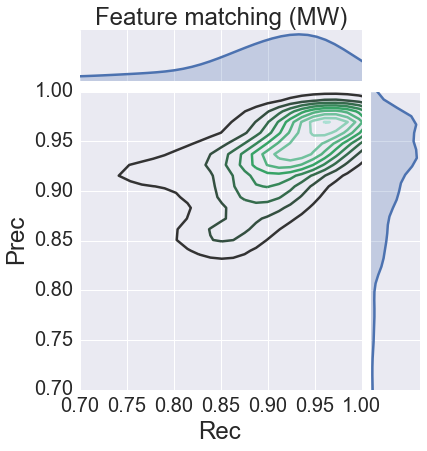

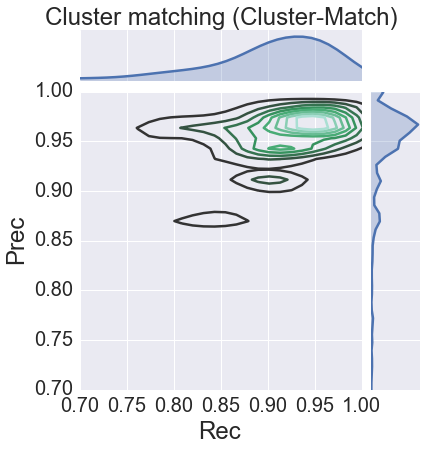

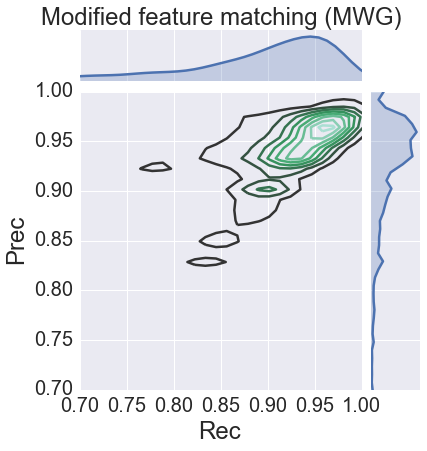

In [21]:
plot_density(exp_results_2a, 'Feature matching (MW)')
plot_density(exp_results_2b, 'Cluster matching (Cluster-Match)')
plot_density(exp_results_2c, 'Modified feature matching (MWG)')

In [22]:
import seaborn as sns
sns.set(color_codes=True)
sns.set_style("whitegrid")

In [23]:
def get_training_rows(exp_res, matching, no_files):
    rows = []
    for i in range(len(exp_res)):
        item = exp_res[i]
        training_data, training_df, best_training_row, match_res = item
        best_training_row['no_files'] = no_files
        best_training_row['matching'] = matching
        best_training_row['iter'] = i
        rows.append(best_training_row)
    return rows

In [24]:
def get_testing_rows(exp_res, matching, no_files):
    rows = []
    for i in range(len(exp_res)):
        item = exp_res[i]
        training_data, training_df, best_training_row, match_res = item
        if matching == 'MWG':
            temp = match_res[0:2] + match_res[4:]
            testing_results = temp + (no_files, matching, i)
        else:
            testing_results = match_res  + (no_files, matching, i)            
        rows.append(testing_results)
    return rows

In [25]:
def plot_training_boxplot():
    rows = []
    rows.extend(get_training_rows(exp_results_2a, 'MW', 2))
    rows.extend(get_training_rows(exp_results_2c, 'MWG', 2))
    rows.extend(get_training_rows(exp_results_2b, 'Cluster-Match', 2))
    df = pd.DataFrame(rows)
    df = df.reset_index(drop=True)
    ax = sns.boxplot(x="matching", y="F1", data=df, palette="Set3", width=0.5)
    ax.set_title('Training Performance', fontsize=24)

In [26]:
def plot_testing_boxplot():
    rows = []
    rows.extend(get_testing_rows(exp_results_2a, 'MW', 2))
    rows.extend(get_testing_rows(exp_results_2c, 'MWG', 2))
    rows.extend(get_testing_rows(exp_results_2b, 'Cluster-Match', 2))
    df = pd.DataFrame(rows, columns=['mass_tol', 'rt_tol', 'TP', 'FP', 'FN', 'Prec', 'Rec', 'F1', 'Threshold', 'no_files', 'matching', 'iter'])
    df = df.reset_index(drop=True)
    ax = sns.boxplot(x="matching", y="F1", data=df, palette="Set3", width=0.5)
    ax.set_title('Testing Performance', fontsize=24)

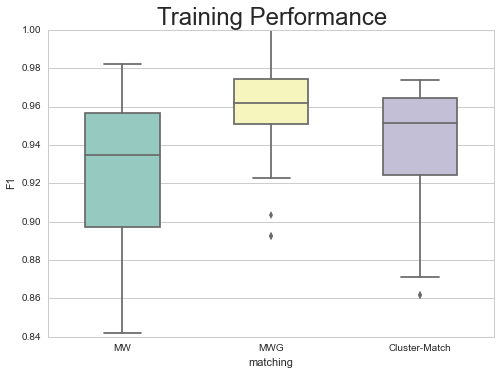

In [27]:
plot_training_boxplot()

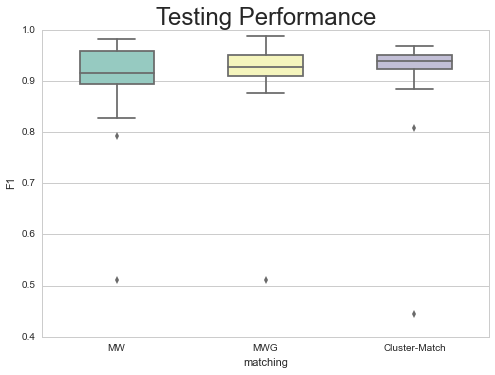

In [28]:
plot_testing_boxplot()

<hr/>

<h2>5. Run Cluster-Cluster on 5 Pairs</h2>

In [29]:
match_cluster_2a = second_stage_clustering(hp, training_list_2, 0)

Iteration 0
Training on ['std1-file5.txt', 'std1-file7.txt']
n 0	cluster_list=5	last_K = 5
n 1	cluster_list=3	last_K = 3


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done   2 jobs       | elapsed:    2.8s


n 2	cluster_list=1	last_K = 1
n 3	cluster_list=12	last_K = 11
n 4	cluster_list=2	last_K = 2
n 5	cluster_list=2	last_K = 2
n 6	cluster_list=2	last_K = 2
n 7	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done   5 jobs       | elapsed:    9.9s
[Parallel(n_jobs=1)]: Done   8 jobs       | elapsed:   11.1s


n 8	cluster_list=1	last_K = 1
n 9	cluster_list=6	last_K = 5
n 10	cluster_list=1	last_K = 1
n 11	cluster_list=1	last_K = 1
n 12	cluster_list=1	last_K = 1
n 13	cluster_list=7	last_K = 7
n 14	cluster_list=1	last_K = 1
n 15	cluster_list=1	last_K = 1
n 16	cluster_list=1	last_K = 1
n 17	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  13 jobs       | elapsed:   13.4s
[Parallel(n_jobs=1)]: Done  18 jobs       | elapsed:   16.5s


n 18	cluster_list=3	last_K = 2
n 19	cluster_list=4	last_K = 3
n 20	cluster_list=2	last_K = 2
n 21	cluster_list=2	last_K = 2
n 22	cluster_list=1	last_K = 1
n 23	cluster_list=1	last_K = 1
n 24	cluster_list=1	last_K = 1
n 25	cluster_list=1	last_K = 1
n 26	cluster_list=2	last_K = 2
n 27	cluster_list=1	last_K = 1
n 28	cluster_list=1	last_K = 1
n 29	cluster_list=1	last_K = 1
n 30	cluster_list=3	last_K = 3
n 31	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  25 jobs       | elapsed:   19.8s
[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:   21.4s


n 32	cluster_list=1	last_K = 1
n 33	cluster_list=1	last_K = 1
n 34	cluster_list=1	last_K = 1
n 35	cluster_list=14	last_K = 12
n 36	cluster_list=1	last_K = 1
n 37	cluster_list=1	last_K = 1
n 38	cluster_list=1	last_K = 1
n 39	cluster_list=1	last_K = 1
n 40	cluster_list=1	last_K = 1
n 41	cluster_list=1	last_K = 1
n 42	cluster_list=1	last_K = 1
n 43	cluster_list=1	last_K = 1
n 44	cluster_list=8	last_K = 8
n 45	cluster_list=1	last_K = 1
n 46	cluster_list=2	last_K = 2
n 47	cluster_list=1	last_K = 1
n 48	cluster_list=14	last_K = 14
n 49	cluster_list=2	last_K = 2


[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:   29.7s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:   43.4s


n 50	cluster_list=1	last_K = 1
n 51	cluster_list=1	last_K = 1
n 52	cluster_list=1	last_K = 1
n 53	cluster_list=1	last_K = 1
n 54	cluster_list=4	last_K = 3
n 55	cluster_list=1	last_K = 1
n 56	cluster_list=1	last_K = 1
n 57	cluster_list=1	last_K = 1
n 58	cluster_list=1	last_K = 1
n 59	cluster_list=1	last_K = 1
n 60	cluster_list=17	last_K = 15
n 61	cluster_list=1	last_K = 1
n 62	cluster_list=4	last_K = 3
n 63	cluster_list=13	last_K = 13
n 64	cluster_list=1	last_K = 1
n 65	cluster_list=1	last_K = 1
n 66	cluster_list=1	last_K = 1
n 67	cluster_list=4	last_K = 3
n 68	cluster_list=3	last_K = 3
n 69	cluster_list=1	last_K = 1
n 70	cluster_list=5	last_K = 5
n 71	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  61 jobs       | elapsed:   56.0s
[Parallel(n_jobs=1)]: Done  72 jobs       | elapsed:  1.2min


n 72	cluster_list=2	last_K = 1
n 73	cluster_list=1	last_K = 1
n 74	cluster_list=1	last_K = 1
n 75	cluster_list=1	last_K = 1
n 76	cluster_list=1	last_K = 1
n 77	cluster_list=3	last_K = 3
n 78	cluster_list=2	last_K = 2
n 79	cluster_list=9	last_K = 9
n 80	cluster_list=4	last_K = 4
n 81	cluster_list=2	last_K = 2
n 82	cluster_list=1	last_K = 1
n 83	cluster_list=1	last_K = 1
n 84	cluster_list=1	last_K = 1
n 85	cluster_list=1	last_K = 1
n 86	cluster_list=2	last_K = 1
n 87	cluster_list=1	last_K = 1
n 88	cluster_list=1	last_K = 1
n 89	cluster_list=10	last_K = 10
n 90	cluster_list=7	last_K = 7
n 91	cluster_list=4	last_K = 4
n 92	cluster_list=1	last_K = 1
n 93	cluster_list=1	last_K = 1
n 94	cluster_list=3	last_K = 3
n 95	cluster_list=1	last_K = 1
n 96	cluster_list=1	last_K = 1
n 97	cluster_list=2	last_K = 2


[Parallel(n_jobs=1)]: Done  85 jobs       | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  98 jobs       | elapsed:  1.5min


n 98	cluster_list=1	last_K = 1
n 99	cluster_list=2	last_K = 2
n 100	cluster_list=1	last_K = 1
n 101	cluster_list=2	last_K = 2
n 102	cluster_list=1	last_K = 1
n 103	cluster_list=1	last_K = 1
n 104	cluster_list=1	last_K = 1
n 105	cluster_list=2	last_K = 2
n 106	cluster_list=1	last_K = 1
n 107	cluster_list=2	last_K = 2
n 108	cluster_list=1	last_K = 1
n 109	cluster_list=1	last_K = 1
n 110	cluster_list=1	last_K = 1
n 111	cluster_list=1	last_K = 1
n 112	cluster_list=1	last_K = 1
n 113	cluster_list=1	last_K = 1
n 114	cluster_list=1	last_K = 1
n 115	cluster_list=1	last_K = 1
n 116	cluster_list=1	last_K = 1
n 117	cluster_list=2	last_K = 2
n 118	cluster_list=2	last_K = 2
n 119	cluster_list=1	last_K = 1
n 120	cluster_list=3	last_K = 3
n 121	cluster_list=1	last_K = 1
n 122	cluster_list=26	last_K = 23
n 123	cluster_list=1	last_K = 1
n 124	cluster_list=1	last_K = 1
n 125	cluster_list=2	last_K = 2
n 126	cluster_list=2	last_K = 2
n 127	cluster_list=2	last_K = 2


[Parallel(n_jobs=1)]: Done 113 jobs       | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done 128 jobs       | elapsed:  2.0min


n 128	cluster_list=1	last_K = 1
n 129	cluster_list=5	last_K = 4
n 130	cluster_list=5	last_K = 5
n 131	cluster_list=1	last_K = 1
n 132	cluster_list=1	last_K = 1
n 133	cluster_list=1	last_K = 1
n 134	cluster_list=1	last_K = 1
n 135	cluster_list=1	last_K = 1
n 136	cluster_list=2	last_K = 2
n 137	cluster_list=1	last_K = 1
n 138	cluster_list=32	last_K = 28
n 139	cluster_list=5	last_K = 5
n 140	cluster_list=1	last_K = 1
n 141	cluster_list=1	last_K = 1
n 142	cluster_list=1	last_K = 1
n 143	cluster_list=1	last_K = 1
n 144	cluster_list=1	last_K = 1
n 145	cluster_list=1	last_K = 1
n 146	cluster_list=1	last_K = 1
n 147	cluster_list=1	last_K = 1
n 148	cluster_list=3	last_K = 3
n 149	cluster_list=3	last_K = 2
n 150	cluster_list=10	last_K = 9
n 151	cluster_list=1	last_K = 1
n 152	cluster_list=3	last_K = 2
n 153	cluster_list=3	last_K = 3
n 154	cluster_list=2	last_K = 2
n 155	cluster_list=1	last_K = 1
n 156	cluster_list=1	last_K = 1
n 157	cluster_list=1	last_K = 1
n 158	cluster_list=1	last_K = 1
n 159

[Parallel(n_jobs=1)]: Done 145 jobs       | elapsed:  2.7min
[Parallel(n_jobs=1)]: Done 162 jobs       | elapsed:  2.9min


n 162	cluster_list=3	last_K = 3
n 163	cluster_list=1	last_K = 1
n 164	cluster_list=1	last_K = 1
n 165	cluster_list=1	last_K = 1
n 166	cluster_list=1	last_K = 1
n 167	cluster_list=3	last_K = 3
n 168	cluster_list=5	last_K = 5
n 169	cluster_list=2	last_K = 2
n 170	cluster_list=1	last_K = 1
n 171	cluster_list=7	last_K = 7
n 172	cluster_list=6	last_K = 6
n 173	cluster_list=1	last_K = 1
n 174	cluster_list=8	last_K = 8
n 175	cluster_list=2	last_K = 2
n 176	cluster_list=10	last_K = 10
n 177	cluster_list=3	last_K = 3
n 178	cluster_list=4	last_K = 4
n 179	cluster_list=4	last_K = 3
n 180	cluster_list=5	last_K = 5
n 181	cluster_list=1	last_K = 1
n 182	cluster_list=1	last_K = 1
n 183	cluster_list=1	last_K = 1
n 184	cluster_list=3	last_K = 2
n 185	cluster_list=1	last_K = 1
n 186	cluster_list=1	last_K = 1
n 187	cluster_list=1	last_K = 1
n 188	cluster_list=1	last_K = 1
n 189	cluster_list=1	last_K = 1
n 190	cluster_list=1	last_K = 1
n 191	cluster_list=9	last_K = 8
n 192	cluster_list=1	last_K = 1
n 193	

[Parallel(n_jobs=1)]: Done 181 jobs       | elapsed:  3.3min
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:  3.4min


n 200	cluster_list=4	last_K = 4
n 201	cluster_list=5	last_K = 5
n 202	cluster_list=17	last_K = 13
n 203	cluster_list=4	last_K = 4
n 204	cluster_list=16	last_K = 16
n 205	cluster_list=1	last_K = 1
n 206	cluster_list=13	last_K = 13
n 207	cluster_list=4	last_K = 4
n 208	cluster_list=9	last_K = 8
n 209	cluster_list=5	last_K = 5
n 210	cluster_list=1	last_K = 1
n 211	cluster_list=1	last_K = 1
n 212	cluster_list=4	last_K = 4
n 213	cluster_list=1	last_K = 1
n 214	cluster_list=1	last_K = 1
n 215	cluster_list=3	last_K = 3
n 216	cluster_list=1	last_K = 1
n 217	cluster_list=2	last_K = 2
n 218	cluster_list=3	last_K = 3
n 219	cluster_list=3	last_K = 3
n 220	cluster_list=2	last_K = 2
n 221	cluster_list=1	last_K = 1
n 222	cluster_list=1	last_K = 1
n 223	cluster_list=1	last_K = 1
n 224	cluster_list=2	last_K = 1
n 225	cluster_list=1	last_K = 1
n 226	cluster_list=1	last_K = 1
n 227	cluster_list=1	last_K = 1
n 228	cluster_list=1	last_K = 1
n 229	cluster_list=1	last_K = 1
n 230	cluster_list=1	last_K = 1
n 

[Parallel(n_jobs=1)]: Done 221 jobs       | elapsed:  4.2min
[Parallel(n_jobs=1)]: Done 242 jobs       | elapsed:  5.1min


n 242	cluster_list=1	last_K = 1
n 243	cluster_list=1	last_K = 1
n 244	cluster_list=2	last_K = 2
n 245	cluster_list=1	last_K = 1
n 246	cluster_list=1	last_K = 1
n 247	cluster_list=1	last_K = 1
n 248	cluster_list=1	last_K = 1
n 249	cluster_list=2	last_K = 2
n 250	cluster_list=1	last_K = 1
n 251	cluster_list=5	last_K = 4
n 252	cluster_list=2	last_K = 2
n 253	cluster_list=1	last_K = 1
n 254	cluster_list=1	last_K = 1
n 255	cluster_list=2	last_K = 2
n 256	cluster_list=4	last_K = 4
n 257	cluster_list=4	last_K = 3
n 258	cluster_list=1	last_K = 1
n 259	cluster_list=3	last_K = 2
n 260	cluster_list=1	last_K = 1
n 261	cluster_list=1	last_K = 1
n 262	cluster_list=1	last_K = 1
n 263	cluster_list=2	last_K = 2
n 264	cluster_list=9	last_K = 9
n 265	cluster_list=1	last_K = 1
n 266	cluster_list=2	last_K = 2
n 267	cluster_list=12	last_K = 12
n 268	cluster_list=1	last_K = 1
n 269	cluster_list=2	last_K = 1
n 270	cluster_list=1	last_K = 1
n 271	cluster_list=1	last_K = 1
n 272	cluster_list=1	last_K = 1
n 273	

[Parallel(n_jobs=1)]: Done 265 jobs       | elapsed:  5.3min
[Parallel(n_jobs=1)]: Done 288 jobs       | elapsed:  6.1min


n 288	cluster_list=1	last_K = 1
n 289	cluster_list=2	last_K = 2
n 290	cluster_list=9	last_K = 9
n 291	cluster_list=1	last_K = 1
n 292	cluster_list=1	last_K = 1
n 293	cluster_list=41	last_K = 35
n 294	cluster_list=8	last_K = 8
n 295	cluster_list=1	last_K = 1
n 296	cluster_list=1	last_K = 1
n 297	cluster_list=5	last_K = 5
n 298	cluster_list=1	last_K = 1
n 299	cluster_list=1	last_K = 1
n 300	cluster_list=1	last_K = 1
n 301	cluster_list=1	last_K = 1
n 302	cluster_list=2	last_K = 2
n 303	cluster_list=1	last_K = 1
n 304	cluster_list=1	last_K = 1
n 305	cluster_list=1	last_K = 1
n 306	cluster_list=7	last_K = 7
n 307	cluster_list=1	last_K = 1
n 308	cluster_list=1	last_K = 1
n 309	cluster_list=1	last_K = 1
n 310	cluster_list=1	last_K = 1
n 311	cluster_list=1	last_K = 1
n 312	cluster_list=2	last_K = 2
n 313	cluster_list=1	last_K = 1
n 314	cluster_list=2	last_K = 2
n 315	cluster_list=3	last_K = 3
n 316	cluster_list=14	last_K = 13
n 317	cluster_list=1	last_K = 1
n 318	cluster_list=1	last_K = 1
n 31

[Parallel(n_jobs=1)]: Done 313 jobs       | elapsed:  7.2min
[Parallel(n_jobs=1)]: Done 338 jobs       | elapsed:  7.4min


n 338	cluster_list=2	last_K = 2
n 339	cluster_list=1	last_K = 1
n 340	cluster_list=2	last_K = 2
n 341	cluster_list=1	last_K = 1
n 342	cluster_list=1	last_K = 1
n 343	cluster_list=22	last_K = 19
n 344	cluster_list=2	last_K = 2
n 345	cluster_list=2	last_K = 2
n 346	cluster_list=1	last_K = 1
n 347	cluster_list=1	last_K = 1
n 348	cluster_list=1	last_K = 1
n 349	cluster_list=1	last_K = 1
n 350	cluster_list=2	last_K = 2
n 351	cluster_list=14	last_K = 14
n 352	cluster_list=1	last_K = 1
n 353	cluster_list=1	last_K = 1
n 354	cluster_list=1	last_K = 1
n 355	cluster_list=1	last_K = 1
n 356	cluster_list=1	last_K = 1
n 357	cluster_list=1	last_K = 1
n 358	cluster_list=1	last_K = 1
n 359	cluster_list=2	last_K = 2
n 360	cluster_list=1	last_K = 1
n 361	cluster_list=2	last_K = 2
n 362	cluster_list=3	last_K = 3
n 363	cluster_list=18	last_K = 18
n 364	cluster_list=10	last_K = 10
n 365	cluster_list=1	last_K = 1
n 366	cluster_list=31	last_K = 26
n 367	cluster_list=1	last_K = 1
n 368	cluster_list=1	last_K = 

[Parallel(n_jobs=1)]: Done 365 jobs       | elapsed:  8.3min
[Parallel(n_jobs=1)]: Done 392 jobs       | elapsed:  8.9min


n 392	cluster_list=1	last_K = 1
n 393	cluster_list=1	last_K = 1
n 394	cluster_list=1	last_K = 1
n 395	cluster_list=2	last_K = 1
n 396	cluster_list=1	last_K = 1
n 397	cluster_list=2	last_K = 2
n 398	cluster_list=1	last_K = 1
n 399	cluster_list=2	last_K = 2
n 400	cluster_list=17	last_K = 17
n 401	cluster_list=1	last_K = 1
n 402	cluster_list=1	last_K = 1
n 403	cluster_list=1	last_K = 1
n 404	cluster_list=1	last_K = 1
n 405	cluster_list=1	last_K = 1
n 406	cluster_list=1	last_K = 1
n 407	cluster_list=1	last_K = 1
n 408	cluster_list=1	last_K = 1
n 409	cluster_list=1	last_K = 1
n 410	cluster_list=1	last_K = 1
n 411	cluster_list=1	last_K = 1
n 412	cluster_list=1	last_K = 1
n 413	cluster_list=16	last_K = 16
n 414	cluster_list=2	last_K = 2
n 415	cluster_list=1	last_K = 1
n 416	cluster_list=1	last_K = 1
n 417	cluster_list=4	last_K = 4
n 418	cluster_list=2	last_K = 1
n 419	cluster_list=3	last_K = 2
n 420	cluster_list=2	last_K = 2
n 421	cluster_list=1	last_K = 1
n 422	cluster_list=1	last_K = 1
n 42

[Parallel(n_jobs=1)]: Done 421 jobs       | elapsed:  9.4min
[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:  9.7min


n 450	cluster_list=1	last_K = 1
n 451	cluster_list=1	last_K = 1
n 452	cluster_list=1	last_K = 1
n 453	cluster_list=1	last_K = 1
n 454	cluster_list=1	last_K = 1
n 455	cluster_list=1	last_K = 1
n 456	cluster_list=1	last_K = 1
n 457	cluster_list=1	last_K = 1
n 458	cluster_list=1	last_K = 1
n 459	cluster_list=1	last_K = 1
n 460	cluster_list=1	last_K = 1
n 461	cluster_list=1	last_K = 1
n 462	cluster_list=1	last_K = 1
n 463	cluster_list=1	last_K = 1
n 464	cluster_list=1	last_K = 1
n 465	cluster_list=1	last_K = 1
n 466	cluster_list=1	last_K = 1
n 467	cluster_list=1	last_K = 1
n 468	cluster_list=1	last_K = 1
n 469	cluster_list=1	last_K = 1
n 470	cluster_list=1	last_K = 1
n 471	cluster_list=1	last_K = 1
n 472	cluster_list=1	last_K = 1
n 473	cluster_list=1	last_K = 1
n 474	cluster_list=1	last_K = 1
n 475	cluster_list=1	last_K = 1
n 476	cluster_list=1	last_K = 1
n 477	cluster_list=1	last_K = 1
n 478	cluster_list=1	last_K = 1
n 479	cluster_list=1	last_K = 1
n 480	cluster_list=1	last_K = 1
n 481	cl

[Parallel(n_jobs=1)]: Done 481 jobs       | elapsed:  9.7min
[Parallel(n_jobs=1)]: Done 512 jobs       | elapsed:  9.7min


n 512	cluster_list=1	last_K = 1
n 513	cluster_list=1	last_K = 1
n 514	cluster_list=1	last_K = 1
n 515	cluster_list=1	last_K = 1
n 516	cluster_list=1	last_K = 1
n 517	cluster_list=1	last_K = 1
n 518	cluster_list=1	last_K = 1
n 519	cluster_list=1	last_K = 1
n 520	cluster_list=1	last_K = 1
n 521	cluster_list=1	last_K = 1
n 522	cluster_list=1	last_K = 1
n 523	cluster_list=1	last_K = 1
n 524	cluster_list=1	last_K = 1
n 525	cluster_list=1	last_K = 1
n 526	cluster_list=1	last_K = 1
n 527	cluster_list=1	last_K = 1
n 528	cluster_list=1	last_K = 1
n 529	cluster_list=1	last_K = 1
n 530	cluster_list=1	last_K = 1
n 531	cluster_list=1	last_K = 1
n 532	cluster_list=1	last_K = 1
n 533	cluster_list=1	last_K = 1
n 534	cluster_list=1	last_K = 1
n 535	cluster_list=13	last_K = 13
n 536	cluster_list=1	last_K = 1
n 537	cluster_list=3	last_K = 3
n 538	cluster_list=1	last_K = 1
n 539	cluster_list=3	last_K = 3
n 540	cluster_list=1	last_K = 1
n 541	cluster_list=1	last_K = 1
n 542	cluster_list=1	last_K = 1
n 543	

[Parallel(n_jobs=1)]: Done 545 jobs       | elapsed:  9.9min
[Parallel(n_jobs=1)]: Done 578 jobs       | elapsed:  9.9min


n 578	cluster_list=1	last_K = 1
n 579	cluster_list=1	last_K = 1
n 580	cluster_list=1	last_K = 1
n 581	cluster_list=1	last_K = 1
n 582	cluster_list=1	last_K = 1
n 583	cluster_list=1	last_K = 1
n 584	cluster_list=1	last_K = 1
n 585	cluster_list=1	last_K = 1
n 586	cluster_list=1	last_K = 1
n 587	cluster_list=1	last_K = 1
n 588	cluster_list=1	last_K = 1
n 589	cluster_list=1	last_K = 1
n 590	cluster_list=1	last_K = 1
n 591	cluster_list=2	last_K = 2
n 592	cluster_list=1	last_K = 1
n 593	cluster_list=1	last_K = 1
n 594	cluster_list=1	last_K = 1
n 595	cluster_list=1	last_K = 1
n 596	cluster_list=1	last_K = 1
n 597	cluster_list=1	last_K = 1
n 598	cluster_list=1	last_K = 1
n 599	cluster_list=1	last_K = 1
n 600	cluster_list=1	last_K = 1
n 601	cluster_list=1	last_K = 1
n 602	cluster_list=1	last_K = 1
n 603	cluster_list=2	last_K = 2
n 604	cluster_list=1	last_K = 1
n 605	cluster_list=2	last_K = 2
n 606	cluster_list=1	last_K = 1
n 607	cluster_list=1	last_K = 1
n 608	cluster_list=2	last_K = 2
n 609	cl

[Parallel(n_jobs=1)]: Done 613 jobs       | elapsed:  9.9min
[Parallel(n_jobs=1)]: Done 648 jobs       | elapsed: 10.0min


n 648	cluster_list=1	last_K = 1
n 649	cluster_list=1	last_K = 1
n 650	cluster_list=1	last_K = 1
n 651	cluster_list=1	last_K = 1
n 652	cluster_list=1	last_K = 1
n 653	cluster_list=1	last_K = 1
n 654	cluster_list=1	last_K = 1
n 655	cluster_list=1	last_K = 1
n 656	cluster_list=1	last_K = 1
n 657	cluster_list=1	last_K = 1
n 658	cluster_list=1	last_K = 1
n 659	cluster_list=1	last_K = 1
n 660	cluster_list=1	last_K = 1
n 661	cluster_list=1	last_K = 1
n 662	cluster_list=1	last_K = 1
n 663	cluster_list=1	last_K = 1
n 664	cluster_list=1	last_K = 1
n 665	cluster_list=1	last_K = 1
n 666	cluster_list=1	last_K = 1
n 667	cluster_list=1	last_K = 1
n 668	cluster_list=1	last_K = 1
n 669	cluster_list=1	last_K = 1
n 670	cluster_list=1	last_K = 1
n 671	cluster_list=1	last_K = 1
n 672	cluster_list=1	last_K = 1
n 673	cluster_list=1	last_K = 1
n 674	cluster_list=1	last_K = 1
n 675	cluster_list=1	last_K = 1
n 676	cluster_list=1	last_K = 1
n 677	cluster_list=1	last_K = 1
n 678	cluster_list=1	last_K = 1
n 679	cl

[Parallel(n_jobs=1)]: Done 685 jobs       | elapsed: 10.0min
[Parallel(n_jobs=1)]: Done 722 jobs       | elapsed: 10.0min


n 722	cluster_list=1	last_K = 1
n 723	cluster_list=1	last_K = 1
n 724	cluster_list=1	last_K = 1
n 725	cluster_list=1	last_K = 1
n 726	cluster_list=1	last_K = 1
n 727	cluster_list=1	last_K = 1
n 728	cluster_list=1	last_K = 1
n 729	cluster_list=1	last_K = 1
n 730	cluster_list=1	last_K = 1
n 731	cluster_list=1	last_K = 1
n 732	cluster_list=1	last_K = 1
n 733	cluster_list=1	last_K = 1
n 734	cluster_list=1	last_K = 1
n 735	cluster_list=1	last_K = 1
n 736	cluster_list=1	last_K = 1
n 737	cluster_list=1	last_K = 1
n 738	cluster_list=1	last_K = 1
n 739	cluster_list=1	last_K = 1
n 740	cluster_list=1	last_K = 1
n 741	cluster_list=1	last_K = 1
n 742	cluster_list=1	last_K = 1
n 743	cluster_list=1	last_K = 1
n 744	cluster_list=1	last_K = 1
n 745	cluster_list=1	last_K = 1
n 746	cluster_list=1	last_K = 1
n 747	cluster_list=1	last_K = 1
n 748	cluster_list=1	last_K = 1
n 749	cluster_list=1	last_K = 1
n 750	cluster_list=1	last_K = 1
n 751	cluster_list=1	last_K = 1
n 752	cluster_list=2	last_K = 2
n 753	cl

[Parallel(n_jobs=1)]: Done 761 jobs       | elapsed: 10.0min
[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed: 10.3min


n 800	cluster_list=2	last_K = 2
n 801	cluster_list=1	last_K = 1
n 802	cluster_list=1	last_K = 1
n 803	cluster_list=2	last_K = 2
n 804	cluster_list=1	last_K = 1
n 805	cluster_list=1	last_K = 1
n 806	cluster_list=1	last_K = 1
n 807	cluster_list=1	last_K = 1
n 808	cluster_list=1	last_K = 1
n 809	cluster_list=1	last_K = 1
n 810	cluster_list=1	last_K = 1
n 811	cluster_list=1	last_K = 1
n 812	cluster_list=1	last_K = 1
n 813	cluster_list=1	last_K = 1
n 814	cluster_list=1	last_K = 1
n 815	cluster_list=1	last_K = 1
n 816	cluster_list=1	last_K = 1
n 817	cluster_list=1	last_K = 1
n 818	cluster_list=1	last_K = 1
n 819	cluster_list=1	last_K = 1
n 820	cluster_list=1	last_K = 1
n 821	cluster_list=1	last_K = 1
n 822	cluster_list=1	last_K = 1
n 823	cluster_list=1	last_K = 1
n 824	cluster_list=1	last_K = 1
n 825	cluster_list=1	last_K = 1
n 826	cluster_list=1	last_K = 1
n 827	cluster_list=1	last_K = 1
n 828	cluster_list=1	last_K = 1
n 829	cluster_list=1	last_K = 1
n 830	cluster_list=1	last_K = 1
n 831	cl

[Parallel(n_jobs=1)]: Done 841 jobs       | elapsed: 10.3min
[Parallel(n_jobs=1)]: Done 882 jobs       | elapsed: 10.3min


n 882	cluster_list=1	last_K = 1
n 883	cluster_list=2	last_K = 2
n 884	cluster_list=1	last_K = 1
n 885	cluster_list=1	last_K = 1
n 886	cluster_list=1	last_K = 1
n 887	cluster_list=1	last_K = 1
n 888	cluster_list=1	last_K = 1
n 889	cluster_list=1	last_K = 1
n 890	cluster_list=1	last_K = 1
n 891	cluster_list=3	last_K = 3
n 892	cluster_list=1	last_K = 1
n 893	cluster_list=1	last_K = 1
n 894	cluster_list=1	last_K = 1
n 895	cluster_list=1	last_K = 1
n 896	cluster_list=1	last_K = 1
n 897	cluster_list=1	last_K = 1
n 898	cluster_list=1	last_K = 1
n 899	cluster_list=1	last_K = 1
n 900	cluster_list=1	last_K = 1
n 901	cluster_list=1	last_K = 1
n 902	cluster_list=1	last_K = 1
n 903	cluster_list=1	last_K = 1
n 904	cluster_list=1	last_K = 1
n 905	cluster_list=1	last_K = 1
n 906	cluster_list=1	last_K = 1
n 907	cluster_list=1	last_K = 1
n 908	cluster_list=1	last_K = 1
n 909	cluster_list=1	last_K = 1
n 910	cluster_list=1	last_K = 1
n 911	cluster_list=3	last_K = 3
n 912	cluster_list=2	last_K = 2
n 913	cl

[Parallel(n_jobs=1)]: Done 925 jobs       | elapsed: 10.4min
[Parallel(n_jobs=1)]: Done 968 jobs       | elapsed: 10.5min


n 968	cluster_list=1	last_K = 1
n 969	cluster_list=1	last_K = 1
n 970	cluster_list=1	last_K = 1
n 971	cluster_list=2	last_K = 2
n 972	cluster_list=1	last_K = 1
n 973	cluster_list=1	last_K = 1
n 974	cluster_list=1	last_K = 1
n 975	cluster_list=2	last_K = 2
n 976	cluster_list=1	last_K = 1
n 977	cluster_list=2	last_K = 2
n 978	cluster_list=1	last_K = 1
n 979	cluster_list=1	last_K = 1
n 980	cluster_list=1	last_K = 1
n 981	cluster_list=2	last_K = 2
n 982	cluster_list=1	last_K = 1
n 983	cluster_list=1	last_K = 1
n 984	cluster_list=1	last_K = 1
n 985	cluster_list=1	last_K = 1
n 986	cluster_list=1	last_K = 1
n 987	cluster_list=1	last_K = 1
n 988	cluster_list=2	last_K = 2
n 989	cluster_list=3	last_K = 3
n 990	cluster_list=2	last_K = 2
n 991	cluster_list=1	last_K = 1
n 992	cluster_list=2	last_K = 2
n 993	cluster_list=1	last_K = 1
n 994	cluster_list=2	last_K = 2
n 995	cluster_list=1	last_K = 1
n 996	cluster_list=1	last_K = 1
n 997	cluster_list=1	last_K = 1
n 998	cluster_list=1	last_K = 1
n 999	cl

[Parallel(n_jobs=1)]: Done 1013 jobs       | elapsed: 10.6min
[Parallel(n_jobs=1)]: Done 1058 jobs       | elapsed: 10.8min


n 1058	cluster_list=1	last_K = 1
n 1059	cluster_list=1	last_K = 1
n 1060	cluster_list=1	last_K = 1
n 1061	cluster_list=1	last_K = 1
n 1062	cluster_list=1	last_K = 1
n 1063	cluster_list=2	last_K = 2
n 1064	cluster_list=1	last_K = 1
n 1065	cluster_list=1	last_K = 1
n 1066	cluster_list=1	last_K = 1
n 1067	cluster_list=2	last_K = 2
n 1068	cluster_list=1	last_K = 1
n 1069	cluster_list=1	last_K = 1
n 1070	cluster_list=1	last_K = 1
n 1071	cluster_list=1	last_K = 1
n 1072	cluster_list=1	last_K = 1
n 1073	cluster_list=1	last_K = 1
n 1074	cluster_list=1	last_K = 1
n 1075	cluster_list=1	last_K = 1
n 1076	cluster_list=1	last_K = 1
n 1077	cluster_list=1	last_K = 1
n 1078	cluster_list=1	last_K = 1
n 1079	cluster_list=2	last_K = 2
n 1080	cluster_list=2	last_K = 2
n 1081	cluster_list=1	last_K = 1
n 1082	cluster_list=1	last_K = 1
n 1083	cluster_list=1	last_K = 1
n 1084	cluster_list=1	last_K = 1
n 1085	cluster_list=2	last_K = 2
n 1086	cluster_list=1	last_K = 1
n 1087	cluster_list=1	last_K = 1
n 1088	clu

[Parallel(n_jobs=1)]: Done 1105 jobs       | elapsed: 10.8min
[Parallel(n_jobs=1)]: Done 1152 jobs       | elapsed: 11.1min


n 1152	cluster_list=2	last_K = 2
n 1153	cluster_list=1	last_K = 1
n 1154	cluster_list=1	last_K = 1
n 1155	cluster_list=1	last_K = 1
n 1156	cluster_list=2	last_K = 2
n 1157	cluster_list=1	last_K = 1
n 1158	cluster_list=1	last_K = 1
n 1159	cluster_list=1	last_K = 1
n 1160	cluster_list=1	last_K = 1
n 1161	cluster_list=1	last_K = 1
n 1162	cluster_list=1	last_K = 1
n 1163	cluster_list=3	last_K = 3
n 1164	cluster_list=1	last_K = 1
n 1165	cluster_list=3	last_K = 3
n 1166	cluster_list=1	last_K = 1
n 1167	cluster_list=1	last_K = 1
n 1168	cluster_list=3	last_K = 2
n 1169	cluster_list=1	last_K = 1
n 1170	cluster_list=1	last_K = 1
n 1171	cluster_list=1	last_K = 1
n 1172	cluster_list=2	last_K = 2
n 1173	cluster_list=1	last_K = 1
n 1174	cluster_list=1	last_K = 1
n 1175	cluster_list=1	last_K = 1
n 1176	cluster_list=1	last_K = 1
n 1177	cluster_list=2	last_K = 2
n 1178	cluster_list=1	last_K = 1
n 1179	cluster_list=1	last_K = 1
n 1180	cluster_list=1	last_K = 1
n 1181	cluster_list=2	last_K = 2
n 1182	clu

[Parallel(n_jobs=1)]: Done 1201 jobs       | elapsed: 11.2min
[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed: 11.2min


n 1250	cluster_list=1	last_K = 1
n 1251	cluster_list=1	last_K = 1
n 1252	cluster_list=1	last_K = 1
n 1253	cluster_list=1	last_K = 1
n 1254	cluster_list=1	last_K = 1
n 1255	cluster_list=1	last_K = 1
n 1256	cluster_list=1	last_K = 1
n 1257	cluster_list=1	last_K = 1
n 1258	cluster_list=1	last_K = 1
n 1259	cluster_list=1	last_K = 1
n 1260	cluster_list=1	last_K = 1
n 1261	cluster_list=1	last_K = 1
n 1262	cluster_list=1	last_K = 1
n 1263	cluster_list=1	last_K = 1
n 1264	cluster_list=1	last_K = 1
n 1265	cluster_list=1	last_K = 1
n 1266	cluster_list=1	last_K = 1
n 1267	cluster_list=1	last_K = 1
n 1268	cluster_list=1	last_K = 1
n 1269	cluster_list=1	last_K = 1
n 1270	cluster_list=1	last_K = 1
n 1271	cluster_list=1	last_K = 1
n 1272	cluster_list=1	last_K = 1
n 1273	cluster_list=1	last_K = 1
n 1274	cluster_list=1	last_K = 1
n 1275	cluster_list=1	last_K = 1
n 1276	cluster_list=1	last_K = 1
n 1277	cluster_list=1	last_K = 1
n 1278	cluster_list=1	last_K = 1
n 1279	cluster_list=1	last_K = 1
n 1280	clu

[Parallel(n_jobs=1)]: Done 1301 jobs       | elapsed: 11.3min
[Parallel(n_jobs=1)]: Done 1352 jobs       | elapsed: 11.8min


n 1352	cluster_list=1	last_K = 1
n 1353	cluster_list=2	last_K = 2
n 1354	cluster_list=1	last_K = 1
n 1355	cluster_list=1	last_K = 1
n 1356	cluster_list=1	last_K = 1
n 1357	cluster_list=1	last_K = 1
n 1358	cluster_list=1	last_K = 1
n 1359	cluster_list=1	last_K = 1
n 1360	cluster_list=1	last_K = 1
n 1361	cluster_list=1	last_K = 1
n 1362	cluster_list=1	last_K = 1
n 1363	cluster_list=1	last_K = 1
n 1364	cluster_list=1	last_K = 1
n 1365	cluster_list=1	last_K = 1
n 1366	cluster_list=1	last_K = 1
n 1367	cluster_list=1	last_K = 1
n 1368	cluster_list=1	last_K = 1
n 1369	cluster_list=1	last_K = 1
n 1370	cluster_list=1	last_K = 1
n 1371	cluster_list=1	last_K = 1
n 1372	cluster_list=1	last_K = 1
n 1373	cluster_list=1	last_K = 1
n 1374	cluster_list=1	last_K = 1
n 1375	cluster_list=1	last_K = 1
n 1376	cluster_list=1	last_K = 1
n 1377	cluster_list=1	last_K = 1
n 1378	cluster_list=1	last_K = 1
n 1379	cluster_list=1	last_K = 1
n 1380	cluster_list=1	last_K = 1
n 1381	cluster_list=1	last_K = 1
n 1382	clu

[Parallel(n_jobs=1)]: Done 1405 jobs       | elapsed: 12.0min
[Parallel(n_jobs=1)]: Done 1458 jobs       | elapsed: 12.0min


n 1458	cluster_list=1	last_K = 1
n 1459	cluster_list=1	last_K = 1
n 1460	cluster_list=1	last_K = 1
n 1461	cluster_list=1	last_K = 1
n 1462	cluster_list=2	last_K = 1
n 1463	cluster_list=3	last_K = 2
n 1464	cluster_list=2	last_K = 2
n 1465	cluster_list=1	last_K = 1
n 1466	cluster_list=2	last_K = 2
n 1467	cluster_list=1	last_K = 1
n 1468	cluster_list=2	last_K = 2
n 1469	cluster_list=1	last_K = 1
n 1470	cluster_list=1	last_K = 1
n 1471	cluster_list=2	last_K = 2
n 1472	cluster_list=3	last_K = 3
n 1473	cluster_list=2	last_K = 2
n 1474	cluster_list=1	last_K = 1
n 1475	cluster_list=3	last_K = 3
n 1476	cluster_list=3	last_K = 3
n 1477	cluster_list=4	last_K = 4
n 1478	cluster_list=1	last_K = 1
n 1479	cluster_list=2	last_K = 2
n 1480	cluster_list=2	last_K = 1
n 1481	cluster_list=4	last_K = 4
n 1482	cluster_list=1	last_K = 1
n 1483	cluster_list=5	last_K = 4
n 1484	cluster_list=1	last_K = 1
n 1485	cluster_list=1	last_K = 1
n 1486	cluster_list=3	last_K = 3
n 1487	cluster_list=3	last_K = 3
n 1488	clu

[Parallel(n_jobs=1)]: Done 1513 jobs       | elapsed: 12.9min
[Parallel(n_jobs=1)]: Done 1568 jobs       | elapsed: 13.6min


n 1568	cluster_list=9	last_K = 8
n 1569	cluster_list=2	last_K = 2
n 1570	cluster_list=1	last_K = 1
n 1571	cluster_list=1	last_K = 1
n 1572	cluster_list=3	last_K = 3
n 1573	cluster_list=3	last_K = 3
n 1574	cluster_list=2	last_K = 2
n 1575	cluster_list=2	last_K = 2
n 1576	cluster_list=1	last_K = 1
n 1577	cluster_list=3	last_K = 3
n 1578	cluster_list=2	last_K = 2
n 1579	cluster_list=2	last_K = 2
n 1580	cluster_list=2	last_K = 2
n 1581	cluster_list=1	last_K = 1
n 1582	cluster_list=1	last_K = 1
n 1583	cluster_list=1	last_K = 1
n 1584	cluster_list=1	last_K = 1
n 1585	cluster_list=1	last_K = 1
n 1586	cluster_list=2	last_K = 2
n 1587	cluster_list=1	last_K = 1
n 1588	cluster_list=1	last_K = 1
n 1589	cluster_list=1	last_K = 1
n 1590	cluster_list=1	last_K = 1
n 1591	cluster_list=2	last_K = 2
n 1592	cluster_list=3	last_K = 3
n 1593	cluster_list=1	last_K = 1
n 1594	cluster_list=1	last_K = 1
n 1595	cluster_list=1	last_K = 1
n 1596	cluster_list=1	last_K = 1
n 1597	cluster_list=2	last_K = 2
n 1598	clu

[Parallel(n_jobs=1)]: Done 1625 jobs       | elapsed: 14.1min
[Parallel(n_jobs=1)]: Done 1682 jobs       | elapsed: 14.8min


n 1682	cluster_list=2	last_K = 2
n 1683	cluster_list=1	last_K = 1
n 1684	cluster_list=1	last_K = 1
n 1685	cluster_list=5	last_K = 5
n 1686	cluster_list=1	last_K = 1
n 1687	cluster_list=1	last_K = 1
n 1688	cluster_list=3	last_K = 3
n 1689	cluster_list=1	last_K = 1
n 1690	cluster_list=2	last_K = 2
n 1691	cluster_list=1	last_K = 1
n 1692	cluster_list=2	last_K = 2
n 1693	cluster_list=7	last_K = 7
n 1694	cluster_list=16	last_K = 16
n 1695	cluster_list=3	last_K = 3
n 1696	cluster_list=1	last_K = 1
n 1697	cluster_list=1	last_K = 1
n 1698	cluster_list=1	last_K = 1
n 1699	cluster_list=7	last_K = 7
n 1700	cluster_list=2	last_K = 2
n 1701	cluster_list=1	last_K = 1
n 1702	cluster_list=4	last_K = 4
n 1703	cluster_list=1	last_K = 1
n 1704	cluster_list=5	last_K = 5
n 1705	cluster_list=1	last_K = 1
n 1706	cluster_list=1	last_K = 1
n 1707	cluster_list=14	last_K = 14
n 1708	cluster_list=1	last_K = 1
n 1709	cluster_list=2	last_K = 2
n 1710	cluster_list=1	last_K = 1
n 1711	cluster_list=1	last_K = 1
n 1712

[Parallel(n_jobs=1)]: Done 1741 jobs       | elapsed: 15.6min
[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed: 16.4min


n 1800	cluster_list=1	last_K = 1
n 1801	cluster_list=1	last_K = 1
n 1802	cluster_list=5	last_K = 4
n 1803	cluster_list=1	last_K = 1
n 1804	cluster_list=2	last_K = 2
n 1805	cluster_list=2	last_K = 2
n 1806	cluster_list=1	last_K = 1
n 1807	cluster_list=2	last_K = 2
n 1808	cluster_list=1	last_K = 1
n 1809	cluster_list=2	last_K = 2
n 1810	cluster_list=1	last_K = 1
n 1811	cluster_list=1	last_K = 1
n 1812	cluster_list=1	last_K = 1
n 1813	cluster_list=1	last_K = 1
n 1814	cluster_list=1	last_K = 1
n 1815	cluster_list=1	last_K = 1
n 1816	cluster_list=1	last_K = 1
n 1817	cluster_list=1	last_K = 1
n 1818	cluster_list=1	last_K = 1
n 1819	cluster_list=1	last_K = 1
n 1820	cluster_list=1	last_K = 1
n 1821	cluster_list=1	last_K = 1
n 1822	cluster_list=1	last_K = 1
n 1823	cluster_list=1	last_K = 1
n 1824	cluster_list=3	last_K = 2
n 1825	cluster_list=4	last_K = 3
n 1826	cluster_list=2	last_K = 2
n 1827	cluster_list=5	last_K = 4
n 1828	cluster_list=1	last_K = 1
n 1829	cluster_list=1	last_K = 1
n 1830	clu

[Parallel(n_jobs=1)]: Done 1861 jobs       | elapsed: 16.7min
[Parallel(n_jobs=1)]: Done 1922 jobs       | elapsed: 17.6min


n 1922	cluster_list=1	last_K = 1
n 1923	cluster_list=1	last_K = 1
n 1924	cluster_list=1	last_K = 1
n 1925	cluster_list=1	last_K = 1
n 1926	cluster_list=1	last_K = 1
n 1927	cluster_list=1	last_K = 1
n 1928	cluster_list=1	last_K = 1
n 1929	cluster_list=1	last_K = 1
n 1930	cluster_list=1	last_K = 1
n 1931	cluster_list=1	last_K = 1
n 1932	cluster_list=1	last_K = 1
n 1933	cluster_list=1	last_K = 1
n 1934	cluster_list=1	last_K = 1
n 1935	cluster_list=1	last_K = 1
n 1936	cluster_list=1	last_K = 1
n 1937	cluster_list=1	last_K = 1
n 1938	cluster_list=1	last_K = 1
n 1939	cluster_list=1	last_K = 1
n 1940	cluster_list=1	last_K = 1
n 1941	cluster_list=1	last_K = 1
n 1942	cluster_list=1	last_K = 1
n 1943	cluster_list=1	last_K = 1
n 1944	cluster_list=1	last_K = 1
n 1945	cluster_list=2	last_K = 2
n 1946	cluster_list=1	last_K = 1
n 1947	cluster_list=2	last_K = 1
n 1948	cluster_list=1	last_K = 1
n 1949	cluster_list=2	last_K = 2
n 1950	cluster_list=1	last_K = 1
n 1951	cluster_list=1	last_K = 1
n 1952	clu

[Parallel(n_jobs=1)]: Done 1985 jobs       | elapsed: 18.3min
[Parallel(n_jobs=1)]: Done 2048 jobs       | elapsed: 18.9min


n 2048	cluster_list=1	last_K = 1
n 2049	cluster_list=2	last_K = 2
n 2050	cluster_list=2	last_K = 2
n 2051	cluster_list=1	last_K = 1
n 2052	cluster_list=1	last_K = 1
n 2053	cluster_list=5	last_K = 4
n 2054	cluster_list=1	last_K = 1
n 2055	cluster_list=1	last_K = 1
n 2056	cluster_list=5	last_K = 5
n 2057	cluster_list=3	last_K = 3
n 2058	cluster_list=2	last_K = 2
n 2059	cluster_list=3	last_K = 3
n 2060	cluster_list=1	last_K = 1
n 2061	cluster_list=1	last_K = 1
n 2062	cluster_list=2	last_K = 2
n 2063	cluster_list=1	last_K = 1
n 2064	cluster_list=2	last_K = 2
n 2065	cluster_list=1	last_K = 1
n 2066	cluster_list=5	last_K = 5
n 2067	cluster_list=7	last_K = 7
n 2068	cluster_list=1	last_K = 1
n 2069	cluster_list=1	last_K = 1
n 2070	cluster_list=1	last_K = 1
n 2071	cluster_list=1	last_K = 1
n 2072	cluster_list=2	last_K = 2
n 2073	cluster_list=1	last_K = 1
n 2074	cluster_list=1	last_K = 1
n 2075	cluster_list=2	last_K = 2
n 2076	cluster_list=1	last_K = 1
n 2077	cluster_list=2	last_K = 1
n 2078	clu

[Parallel(n_jobs=1)]: Done 2113 jobs       | elapsed: 19.4min
[Parallel(n_jobs=1)]: Done 2178 jobs       | elapsed: 19.7min


n 2178	cluster_list=1	last_K = 1
n 2179	cluster_list=1	last_K = 1
n 2180	cluster_list=1	last_K = 1
n 2181	cluster_list=1	last_K = 1
n 2182	cluster_list=3	last_K = 3
n 2183	cluster_list=1	last_K = 1
n 2184	cluster_list=1	last_K = 1
n 2185	cluster_list=2	last_K = 2
n 2186	cluster_list=1	last_K = 1
n 2187	cluster_list=2	last_K = 1
n 2188	cluster_list=1	last_K = 1
n 2189	cluster_list=5	last_K = 4
n 2190	cluster_list=2	last_K = 2
n 2191	cluster_list=1	last_K = 1
n 2192	cluster_list=2	last_K = 1
n 2193	cluster_list=5	last_K = 4
n 2194	cluster_list=1	last_K = 1
n 2195	cluster_list=1	last_K = 1
n 2196	cluster_list=1	last_K = 1
n 2197	cluster_list=3	last_K = 3
n 2198	cluster_list=1	last_K = 1
n 2199	cluster_list=1	last_K = 1
n 2200	cluster_list=1	last_K = 1
n 2201	cluster_list=1	last_K = 1
n 2202	cluster_list=1	last_K = 1
n 2203	cluster_list=1	last_K = 1
n 2204	cluster_list=1	last_K = 1
n 2205	cluster_list=1	last_K = 1
n 2206	cluster_list=1	last_K = 1
n 2207	cluster_list=2	last_K = 2
n 2208	clu

[Parallel(n_jobs=1)]: Done 2245 jobs       | elapsed: 20.1min
[Parallel(n_jobs=1)]: Done 2312 jobs       | elapsed: 21.1min


n 2312	cluster_list=3	last_K = 3
n 2313	cluster_list=1	last_K = 1
n 2314	cluster_list=1	last_K = 1
n 2315	cluster_list=1	last_K = 1
n 2316	cluster_list=2	last_K = 2
n 2317	cluster_list=5	last_K = 4
n 2318	cluster_list=1	last_K = 1
n 2319	cluster_list=1	last_K = 1
n 2320	cluster_list=2	last_K = 2
n 2321	cluster_list=4	last_K = 3
n 2322	cluster_list=2	last_K = 2
n 2323	cluster_list=2	last_K = 2
n 2324	cluster_list=1	last_K = 1
n 2325	cluster_list=1	last_K = 1
n 2326	cluster_list=2	last_K = 2
n 2327	cluster_list=1	last_K = 1
n 2328	cluster_list=1	last_K = 1
n 2329	cluster_list=1	last_K = 1
n 2330	cluster_list=1	last_K = 1
n 2331	cluster_list=1	last_K = 1
n 2332	cluster_list=1	last_K = 1
n 2333	cluster_list=1	last_K = 1
n 2334	cluster_list=1	last_K = 1
n 2335	cluster_list=1	last_K = 1
n 2336	cluster_list=16	last_K = 16
n 2337	cluster_list=3	last_K = 3
n 2338	cluster_list=1	last_K = 1
n 2339	cluster_list=1	last_K = 1
n 2340	cluster_list=1	last_K = 1
n 2341	cluster_list=5	last_K = 4
n 2342	c

[Parallel(n_jobs=1)]: Done 2381 jobs       | elapsed: 21.6min
[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed: 22.4min


n 2450	cluster_list=2	last_K = 2
n 2451	cluster_list=2	last_K = 2
n 2452	cluster_list=1	last_K = 1
n 2453	cluster_list=1	last_K = 1
n 2454	cluster_list=1	last_K = 1
n 2455	cluster_list=2	last_K = 2
n 2456	cluster_list=8	last_K = 8
n 2457	cluster_list=1	last_K = 1
n 2458	cluster_list=3	last_K = 3
n 2459	cluster_list=1	last_K = 1
n 2460	cluster_list=1	last_K = 1
n 2461	cluster_list=1	last_K = 1
n 2462	cluster_list=2	last_K = 2
n 2463	cluster_list=2	last_K = 2
n 2464	cluster_list=3	last_K = 3
n 2465	cluster_list=2	last_K = 2
n 2466	cluster_list=1	last_K = 1
n 2467	cluster_list=19	last_K = 19
n 2468	cluster_list=27	last_K = 26
n 2469	cluster_list=3	last_K = 2
n 2470	cluster_list=1	last_K = 1
n 2471	cluster_list=5	last_K = 3
n 2472	cluster_list=3	last_K = 2
n 2473	cluster_list=1	last_K = 1
n 2474	cluster_list=1	last_K = 1
n 2475	cluster_list=1	last_K = 1
n 2476	cluster_list=2	last_K = 2
n 2477	cluster_list=5	last_K = 5
n 2478	cluster_list=1	last_K = 1
n 2479	cluster_list=1	last_K = 1
n 2480

[Parallel(n_jobs=1)]: Done 2521 jobs       | elapsed: 24.2min
[Parallel(n_jobs=1)]: Done 2592 jobs       | elapsed: 24.8min


n 2592	cluster_list=1	last_K = 1
n 2593	cluster_list=1	last_K = 1
n 2594	cluster_list=1	last_K = 1
n 2595	cluster_list=2	last_K = 2
n 2596	cluster_list=2	last_K = 2
n 2597	cluster_list=1	last_K = 1
n 2598	cluster_list=4	last_K = 3
n 2599	cluster_list=2	last_K = 1
n 2600	cluster_list=3	last_K = 3
n 2601	cluster_list=1	last_K = 1
n 2602	cluster_list=2	last_K = 2
n 2603	cluster_list=2	last_K = 2
n 2604	cluster_list=1	last_K = 1
n 2605	cluster_list=3	last_K = 2
n 2606	cluster_list=2	last_K = 2
n 2607	cluster_list=2	last_K = 2
n 2608	cluster_list=1	last_K = 1
n 2609	cluster_list=1	last_K = 1
n 2610	cluster_list=1	last_K = 1
n 2611	cluster_list=1	last_K = 1
n 2612	cluster_list=1	last_K = 1
n 2613	cluster_list=3	last_K = 3
n 2614	cluster_list=1	last_K = 1
n 2615	cluster_list=2	last_K = 2
n 2616	cluster_list=2	last_K = 2
n 2617	cluster_list=1	last_K = 1
n 2618	cluster_list=1	last_K = 1
n 2619	cluster_list=3	last_K = 3
n 2620	cluster_list=1	last_K = 1
n 2621	cluster_list=1	last_K = 1
n 2622	clu

[Parallel(n_jobs=1)]: Done 2665 jobs       | elapsed: 25.2min
[Parallel(n_jobs=1)]: Done 2738 jobs       | elapsed: 25.8min


n 2738	cluster_list=1	last_K = 1
n 2739	cluster_list=1	last_K = 1
n 2740	cluster_list=2	last_K = 2
n 2741	cluster_list=1	last_K = 1
n 2742	cluster_list=1	last_K = 1
n 2743	cluster_list=1	last_K = 1
n 2744	cluster_list=4	last_K = 4
n 2745	cluster_list=12	last_K = 11
n 2746	cluster_list=1	last_K = 1
n 2747	cluster_list=2	last_K = 2
n 2748	cluster_list=2	last_K = 2
n 2749	cluster_list=1	last_K = 1
n 2750	cluster_list=5	last_K = 4
n 2751	cluster_list=2	last_K = 2
n 2752	cluster_list=2	last_K = 2
n 2753	cluster_list=2	last_K = 1
n 2754	cluster_list=2	last_K = 1
n 2755	cluster_list=3	last_K = 3
n 2756	cluster_list=1	last_K = 1
n 2757	cluster_list=4	last_K = 3
n 2758	cluster_list=1	last_K = 1
n 2759	cluster_list=1	last_K = 1
n 2760	cluster_list=1	last_K = 1
n 2761	cluster_list=2	last_K = 2
n 2762	cluster_list=1	last_K = 1
n 2763	cluster_list=1	last_K = 1
n 2764	cluster_list=2	last_K = 2
n 2765	cluster_list=3	last_K = 3
n 2766	cluster_list=9	last_K = 6
n 2767	cluster_list=1	last_K = 1
n 2768	c

[Parallel(n_jobs=1)]: Done 2813 jobs       | elapsed: 26.6min
[Parallel(n_jobs=1)]: Done 2888 jobs       | elapsed: 27.3min


n 2888	cluster_list=2	last_K = 2
n 2889	cluster_list=1	last_K = 1
n 2890	cluster_list=1	last_K = 1
n 2891	cluster_list=1	last_K = 1
n 2892	cluster_list=1	last_K = 1
n 2893	cluster_list=2	last_K = 2
n 2894	cluster_list=1	last_K = 1
n 2895	cluster_list=1	last_K = 1
n 2896	cluster_list=1	last_K = 1
n 2897	cluster_list=7	last_K = 6
n 2898	cluster_list=1	last_K = 1
n 2899	cluster_list=2	last_K = 2
n 2900	cluster_list=1	last_K = 1
n 2901	cluster_list=2	last_K = 2
n 2902	cluster_list=1	last_K = 1
n 2903	cluster_list=1	last_K = 1
n 2904	cluster_list=4	last_K = 3
n 2905	cluster_list=1	last_K = 1
n 2906	cluster_list=2	last_K = 2
n 2907	cluster_list=2	last_K = 2
n 2908	cluster_list=1	last_K = 1
n 2909	cluster_list=2	last_K = 2
n 2910	cluster_list=3	last_K = 2
n 2911	cluster_list=2	last_K = 2
n 2912	cluster_list=1	last_K = 1
n 2913	cluster_list=2	last_K = 1
n 2914	cluster_list=1	last_K = 1
n 2915	cluster_list=1	last_K = 1
n 2916	cluster_list=1	last_K = 1
n 2917	cluster_list=3	last_K = 3
n 2918	clu

[Parallel(n_jobs=1)]: Done 2965 jobs       | elapsed: 27.8min
[Parallel(n_jobs=1)]: Done 3042 jobs       | elapsed: 28.2min


n 3042	cluster_list=6	last_K = 5
n 3043	cluster_list=1	last_K = 1
n 3044	cluster_list=1	last_K = 1
n 3045	cluster_list=1	last_K = 1
n 3046	cluster_list=4	last_K = 2
n 3047	cluster_list=2	last_K = 2
n 3048	cluster_list=1	last_K = 1
n 3049	cluster_list=2	last_K = 2
n 3050	cluster_list=2	last_K = 2
n 3051	cluster_list=1	last_K = 1
n 3052	cluster_list=1	last_K = 1
n 3053	cluster_list=2	last_K = 2
n 3054	cluster_list=2	last_K = 2
n 3055	cluster_list=1	last_K = 1
n 3056	cluster_list=1	last_K = 1
n 3057	cluster_list=2	last_K = 2
n 3058	cluster_list=3	last_K = 3
n 3059	cluster_list=1	last_K = 1
n 3060	cluster_list=2	last_K = 2
n 3061	cluster_list=2	last_K = 2
n 3062	cluster_list=1	last_K = 1
n 3063	cluster_list=1	last_K = 1
n 3064	cluster_list=2	last_K = 2
n 3065	cluster_list=1	last_K = 1
n 3066	cluster_list=1	last_K = 1
n 3067	cluster_list=1	last_K = 1
n 3068	cluster_list=1	last_K = 1
n 3069	cluster_list=2	last_K = 2
n 3070	cluster_list=2	last_K = 2
n 3071	cluster_list=8	last_K = 7
n 3072	clu

[Parallel(n_jobs=1)]: Done 3121 jobs       | elapsed: 28.9min
[Parallel(n_jobs=1)]: Done 3200 jobs       | elapsed: 29.4min


n 3200	cluster_list=2	last_K = 2
n 3201	cluster_list=2	last_K = 2
n 3202	cluster_list=1	last_K = 1
n 3203	cluster_list=3	last_K = 2
n 3204	cluster_list=1	last_K = 1
n 3205	cluster_list=1	last_K = 1
n 3206	cluster_list=1	last_K = 1
n 3207	cluster_list=1	last_K = 1
n 3208	cluster_list=2	last_K = 2
n 3209	cluster_list=2	last_K = 2
n 3210	cluster_list=2	last_K = 2
n 3211	cluster_list=1	last_K = 1
n 3212	cluster_list=1	last_K = 1
n 3213	cluster_list=14	last_K = 12
n 3214	cluster_list=2	last_K = 2
n 3215	cluster_list=1	last_K = 1
n 3216	cluster_list=2	last_K = 2
n 3217	cluster_list=1	last_K = 1
n 3218	cluster_list=1	last_K = 1
n 3219	cluster_list=2	last_K = 2
n 3220	cluster_list=1	last_K = 1
n 3221	cluster_list=1	last_K = 1
n 3222	cluster_list=1	last_K = 1
n 3223	cluster_list=5	last_K = 4
n 3224	cluster_list=1	last_K = 1
n 3225	cluster_list=1	last_K = 1
n 3226	cluster_list=2	last_K = 2
n 3227	cluster_list=23	last_K = 21
n 3228	cluster_list=2	last_K = 2
n 3229	cluster_list=1	last_K = 1
n 3230

[Parallel(n_jobs=1)]: Done 3281 jobs       | elapsed: 30.2min
[Parallel(n_jobs=1)]: Done 3362 jobs       | elapsed: 30.8min


n 3362	cluster_list=1	last_K = 1
n 3363	cluster_list=1	last_K = 1
n 3364	cluster_list=2	last_K = 2
n 3365	cluster_list=2	last_K = 2
n 3366	cluster_list=1	last_K = 1
n 3367	cluster_list=2	last_K = 2
n 3368	cluster_list=2	last_K = 2
n 3369	cluster_list=4	last_K = 4
n 3370	cluster_list=1	last_K = 1
n 3371	cluster_list=1	last_K = 1
n 3372	cluster_list=5	last_K = 3
n 3373	cluster_list=1	last_K = 1
n 3374	cluster_list=2	last_K = 2
n 3375	cluster_list=2	last_K = 2
n 3376	cluster_list=1	last_K = 1
n 3377	cluster_list=1	last_K = 1
n 3378	cluster_list=1	last_K = 1
n 3379	cluster_list=1	last_K = 1
n 3380	cluster_list=1	last_K = 1
n 3381	cluster_list=1	last_K = 1
n 3382	cluster_list=2	last_K = 2
n 3383	cluster_list=1	last_K = 1
n 3384	cluster_list=1	last_K = 1
n 3385	cluster_list=1	last_K = 1
n 3386	cluster_list=2	last_K = 2
n 3387	cluster_list=2	last_K = 2
n 3388	cluster_list=2	last_K = 2
n 3389	cluster_list=1	last_K = 1
n 3390	cluster_list=14	last_K = 8
n 3391	cluster_list=2	last_K = 2
n 3392	cl

[Parallel(n_jobs=1)]: Done 3445 jobs       | elapsed: 31.5min
[Parallel(n_jobs=1)]: Done 3528 jobs       | elapsed: 31.9min


n 3528	cluster_list=1	last_K = 1
n 3529	cluster_list=2	last_K = 2
n 3530	cluster_list=4	last_K = 3
n 3531	cluster_list=5	last_K = 5
n 3532	cluster_list=3	last_K = 3
n 3533	cluster_list=1	last_K = 1
n 3534	cluster_list=1	last_K = 1
n 3535	cluster_list=1	last_K = 1
n 3536	cluster_list=3	last_K = 2
n 3537	cluster_list=6	last_K = 5
n 3538	cluster_list=2	last_K = 2
n 3539	cluster_list=2	last_K = 2
n 3540	cluster_list=1	last_K = 1
n 3541	cluster_list=1	last_K = 1
n 3542	cluster_list=3	last_K = 3
n 3543	cluster_list=2	last_K = 1
n 3544	cluster_list=1	last_K = 1
n 3545	cluster_list=1	last_K = 1
n 3546	cluster_list=2	last_K = 2
n 3547	cluster_list=1	last_K = 1
n 3548	cluster_list=1	last_K = 1
n 3549	cluster_list=1	last_K = 1
n 3550	cluster_list=1	last_K = 1
n 3551	cluster_list=1	last_K = 1
n 3552	cluster_list=1	last_K = 1
n 3553	cluster_list=1	last_K = 1
n 3554	cluster_list=1	last_K = 1
n 3555	cluster_list=1	last_K = 1
n 3556	cluster_list=2	last_K = 2
n 3557	cluster_list=1	last_K = 1
n 3558	clu

[Parallel(n_jobs=1)]: Done 3613 jobs       | elapsed: 32.5min
[Parallel(n_jobs=1)]: Done 3698 jobs       | elapsed: 33.0min


n 3698	cluster_list=1	last_K = 1
n 3699	cluster_list=2	last_K = 2
n 3700	cluster_list=1	last_K = 1
n 3701	cluster_list=2	last_K = 2
n 3702	cluster_list=1	last_K = 1
n 3703	cluster_list=3	last_K = 2
n 3704	cluster_list=3	last_K = 3
n 3705	cluster_list=2	last_K = 2
n 3706	cluster_list=1	last_K = 1
n 3707	cluster_list=1	last_K = 1
n 3708	cluster_list=1	last_K = 1
n 3709	cluster_list=1	last_K = 1
n 3710	cluster_list=1	last_K = 1
n 3711	cluster_list=1	last_K = 1
n 3712	cluster_list=3	last_K = 3
n 3713	cluster_list=2	last_K = 2
n 3714	cluster_list=1	last_K = 1
n 3715	cluster_list=2	last_K = 2
n 3716	cluster_list=1	last_K = 1
n 3717	cluster_list=1	last_K = 1
n 3718	cluster_list=1	last_K = 1
n 3719	cluster_list=1	last_K = 1
n 3720	cluster_list=1	last_K = 1
n 3721	cluster_list=1	last_K = 1
n 3722	cluster_list=2	last_K = 2
n 3723	cluster_list=1	last_K = 1
n 3724	cluster_list=2	last_K = 2
n 3725	cluster_list=1	last_K = 1
n 3726	cluster_list=2	last_K = 2
n 3727	cluster_list=1	last_K = 1
n 3728	clu

[Parallel(n_jobs=1)]: Done 3785 jobs       | elapsed: 33.4min
[Parallel(n_jobs=1)]: Done 3872 jobs       | elapsed: 33.9min


n 3872	cluster_list=1	last_K = 1
n 3873	cluster_list=1	last_K = 1
n 3874	cluster_list=1	last_K = 1
n 3875	cluster_list=1	last_K = 1
n 3876	cluster_list=1	last_K = 1
n 3877	cluster_list=1	last_K = 1
n 3878	cluster_list=1	last_K = 1
n 3879	cluster_list=1	last_K = 1
n 3880	cluster_list=1	last_K = 1
n 3881	cluster_list=1	last_K = 1
n 3882	cluster_list=2	last_K = 2
n 3883	cluster_list=1	last_K = 1
n 3884	cluster_list=1	last_K = 1
n 3885	cluster_list=2	last_K = 2
n 3886	cluster_list=1	last_K = 1
n 3887	cluster_list=1	last_K = 1
n 3888	cluster_list=2	last_K = 2
n 3889	cluster_list=1	last_K = 1
n 3890	cluster_list=1	last_K = 1
n 3891	cluster_list=2	last_K = 2
n 3892	cluster_list=1	last_K = 1
n 3893	cluster_list=2	last_K = 2
n 3894	cluster_list=2	last_K = 2
n 3895	cluster_list=2	last_K = 2
n 3896	cluster_list=2	last_K = 2
n 3897	cluster_list=2	last_K = 2
n 3898	cluster_list=2	last_K = 2
n 3899	cluster_list=2	last_K = 2
n 3900	cluster_list=2	last_K = 2
n 3901	cluster_list=4	last_K = 2
n 3902	clu

[Parallel(n_jobs=1)]: Done 3961 jobs       | elapsed: 34.4min
[Parallel(n_jobs=1)]: Done 4050 jobs       | elapsed: 34.9min


n 4050	cluster_list=10	last_K = 8
n 4051	cluster_list=2	last_K = 2
n 4052	cluster_list=2	last_K = 2
n 4053	cluster_list=1	last_K = 1
n 4054	cluster_list=1	last_K = 1
n 4055	cluster_list=1	last_K = 1
n 4056	cluster_list=2	last_K = 2
n 4057	cluster_list=1	last_K = 1
n 4058	cluster_list=1	last_K = 1
n 4059	cluster_list=1	last_K = 1
n 4060	cluster_list=1	last_K = 1
n 4061	cluster_list=1	last_K = 1
n 4062	cluster_list=1	last_K = 1
n 4063	cluster_list=1	last_K = 1
n 4064	cluster_list=2	last_K = 2
n 4065	cluster_list=1	last_K = 1
n 4066	cluster_list=3	last_K = 3
n 4067	cluster_list=2	last_K = 1
n 4068	cluster_list=1	last_K = 1
n 4069	cluster_list=2	last_K = 2
n 4070	cluster_list=1	last_K = 1
n 4071	cluster_list=1	last_K = 1
n 4072	cluster_list=1	last_K = 1
n 4073	cluster_list=1	last_K = 1
n 4074	cluster_list=1	last_K = 1
n 4075	cluster_list=1	last_K = 1
n 4076	cluster_list=1	last_K = 1
n 4077	cluster_list=1	last_K = 1
n 4078	cluster_list=1	last_K = 1
n 4079	cluster_list=1	last_K = 1
n 4080	cl

[Parallel(n_jobs=1)]: Done 4141 jobs       | elapsed: 35.3min
[Parallel(n_jobs=1)]: Done 4232 jobs       | elapsed: 35.7min


n 4232	cluster_list=1	last_K = 1
n 4233	cluster_list=1	last_K = 1
n 4234	cluster_list=1	last_K = 1
n 4235	cluster_list=1	last_K = 1
n 4236	cluster_list=1	last_K = 1
n 4237	cluster_list=1	last_K = 1
n 4238	cluster_list=4	last_K = 3
n 4239	cluster_list=5	last_K = 3
n 4240	cluster_list=1	last_K = 1
n 4241	cluster_list=2	last_K = 1
n 4242	cluster_list=1	last_K = 1
n 4243	cluster_list=1	last_K = 1
n 4244	cluster_list=1	last_K = 1
n 4245	cluster_list=1	last_K = 1
n 4246	cluster_list=1	last_K = 1
n 4247	cluster_list=1	last_K = 1
n 4248	cluster_list=1	last_K = 1
n 4249	cluster_list=1	last_K = 1
n 4250	cluster_list=1	last_K = 1
n 4251	cluster_list=2	last_K = 2
n 4252	cluster_list=2	last_K = 2
n 4253	cluster_list=2	last_K = 2
n 4254	cluster_list=1	last_K = 1
n 4255	cluster_list=1	last_K = 1
n 4256	cluster_list=2	last_K = 2
n 4257	cluster_list=4	last_K = 3
n 4258	cluster_list=4	last_K = 2
n 4259	cluster_list=1	last_K = 1
n 4260	cluster_list=1	last_K = 1
n 4261	cluster_list=1	last_K = 1
n 4262	clu

[Parallel(n_jobs=1)]: Done 4325 jobs       | elapsed: 36.2min
[Parallel(n_jobs=1)]: Done 4418 jobs       | elapsed: 36.5min


n 4418	cluster_list=1	last_K = 1
n 4419	cluster_list=1	last_K = 1
n 4420	cluster_list=1	last_K = 1
n 4421	cluster_list=1	last_K = 1
n 4422	cluster_list=1	last_K = 1
n 4423	cluster_list=1	last_K = 1
n 4424	cluster_list=1	last_K = 1
n 4425	cluster_list=1	last_K = 1
n 4426	cluster_list=1	last_K = 1
n 4427	cluster_list=1	last_K = 1
n 4428	cluster_list=1	last_K = 1
n 4429	cluster_list=2	last_K = 2
n 4430	cluster_list=1	last_K = 1
n 4431	cluster_list=4	last_K = 3
n 4432	cluster_list=2	last_K = 2
n 4433	cluster_list=2	last_K = 2
n 4434	cluster_list=3	last_K = 3
n 4435	cluster_list=1	last_K = 1
n 4436	cluster_list=1	last_K = 1
n 4437	cluster_list=2	last_K = 2
n 4438	cluster_list=1	last_K = 1
n 4439	cluster_list=5	last_K = 5
n 4440	cluster_list=1	last_K = 1
n 4441	cluster_list=1	last_K = 1
n 4442	cluster_list=1	last_K = 1
n 4443	cluster_list=2	last_K = 2
n 4444	cluster_list=2	last_K = 2
n 4445	cluster_list=1	last_K = 1
n 4446	cluster_list=1	last_K = 1
n 4447	cluster_list=1	last_K = 1
n 4448	clu

[Parallel(n_jobs=1)]: Done 4513 jobs       | elapsed: 36.8min
[Parallel(n_jobs=1)]: Done 4608 jobs       | elapsed: 37.3min


n 4608	cluster_list=1	last_K = 1
n 4609	cluster_list=1	last_K = 1
n 4610	cluster_list=1	last_K = 1
n 4611	cluster_list=1	last_K = 1
n 4612	cluster_list=1	last_K = 1
n 4613	cluster_list=2	last_K = 2
n 4614	cluster_list=1	last_K = 1
n 4615	cluster_list=1	last_K = 1
n 4616	cluster_list=1	last_K = 1
n 4617	cluster_list=1	last_K = 1
n 4618	cluster_list=1	last_K = 1
n 4619	cluster_list=1	last_K = 1
n 4620	cluster_list=1	last_K = 1
n 4621	cluster_list=1	last_K = 1
n 4622	cluster_list=5	last_K = 4
n 4623	cluster_list=1	last_K = 1
n 4624	cluster_list=1	last_K = 1
n 4625	cluster_list=1	last_K = 1
n 4626	cluster_list=6	last_K = 4
n 4627	cluster_list=3	last_K = 2
n 4628	cluster_list=1	last_K = 1
n 4629	cluster_list=2	last_K = 1
n 4630	cluster_list=1	last_K = 1
n 4631	cluster_list=1	last_K = 1
n 4632	cluster_list=3	last_K = 2
n 4633	cluster_list=1	last_K = 1
n 4634	cluster_list=2	last_K = 2
n 4635	cluster_list=1	last_K = 1
n 4636	cluster_list=1	last_K = 1
n 4637	cluster_list=1	last_K = 1
n 4638	clu

[Parallel(n_jobs=1)]: Done 4705 jobs       | elapsed: 37.7min
[Parallel(n_jobs=1)]: Done 4802 jobs       | elapsed: 38.2min


n 4802	cluster_list=1	last_K = 1
n 4803	cluster_list=1	last_K = 1
n 4804	cluster_list=1	last_K = 1
n 4805	cluster_list=1	last_K = 1
n 4806	cluster_list=1	last_K = 1
n 4807	cluster_list=1	last_K = 1
n 4808	cluster_list=1	last_K = 1
n 4809	cluster_list=1	last_K = 1
n 4810	cluster_list=10	last_K = 10
n 4811	cluster_list=3	last_K = 3
n 4812	cluster_list=1	last_K = 1
n 4813	cluster_list=1	last_K = 1
n 4814	cluster_list=1	last_K = 1
n 4815	cluster_list=2	last_K = 2
n 4816	cluster_list=1	last_K = 1
n 4817	cluster_list=1	last_K = 1
n 4818	cluster_list=1	last_K = 1
n 4819	cluster_list=1	last_K = 1
n 4820	cluster_list=1	last_K = 1
n 4821	cluster_list=12	last_K = 11
n 4822	cluster_list=1	last_K = 1
n 4823	cluster_list=3	last_K = 2
n 4824	cluster_list=1	last_K = 1
n 4825	cluster_list=1	last_K = 1
n 4826	cluster_list=1	last_K = 1
n 4827	cluster_list=1	last_K = 1
n 4828	cluster_list=1	last_K = 1
n 4829	cluster_list=1	last_K = 1
n 4830	cluster_list=2	last_K = 2
n 4831	cluster_list=1	last_K = 1
n 4832

[Parallel(n_jobs=1)]: Done 4901 jobs       | elapsed: 38.5min
[Parallel(n_jobs=1)]: Done 5000 jobs       | elapsed: 38.9min


n 5000	cluster_list=1	last_K = 1
n 5001	cluster_list=4	last_K = 4
n 5002	cluster_list=1	last_K = 1
n 5003	cluster_list=1	last_K = 1
n 5004	cluster_list=1	last_K = 1
n 5005	cluster_list=1	last_K = 1
n 5006	cluster_list=1	last_K = 1
n 5007	cluster_list=3	last_K = 2
n 5008	cluster_list=1	last_K = 1
n 5009	cluster_list=1	last_K = 1
n 5010	cluster_list=4	last_K = 4
n 5011	cluster_list=2	last_K = 2
n 5012	cluster_list=6	last_K = 5
n 5013	cluster_list=3	last_K = 3
n 5014	cluster_list=2	last_K = 2
n 5015	cluster_list=1	last_K = 1
n 5016	cluster_list=1	last_K = 1
n 5017	cluster_list=1	last_K = 1
n 5018	cluster_list=1	last_K = 1
n 5019	cluster_list=1	last_K = 1
n 5020	cluster_list=3	last_K = 3
n 5021	cluster_list=1	last_K = 1
n 5022	cluster_list=1	last_K = 1
n 5023	cluster_list=1	last_K = 1
n 5024	cluster_list=1	last_K = 1
n 5025	cluster_list=2	last_K = 2
n 5026	cluster_list=1	last_K = 1
n 5027	cluster_list=3	last_K = 3
n 5028	cluster_list=1	last_K = 1
n 5029	cluster_list=2	last_K = 2
n 5030	clu

[Parallel(n_jobs=1)]: Done 5101 jobs       | elapsed: 39.4min
[Parallel(n_jobs=1)]: Done 5202 jobs       | elapsed: 39.7min


n 5202	cluster_list=1	last_K = 1
n 5203	cluster_list=1	last_K = 1
n 5204	cluster_list=1	last_K = 1
n 5205	cluster_list=3	last_K = 2
n 5206	cluster_list=2	last_K = 2
n 5207	cluster_list=2	last_K = 2
n 5208	cluster_list=2	last_K = 2
n 5209	cluster_list=1	last_K = 1
n 5210	cluster_list=6	last_K = 4
n 5211	cluster_list=1	last_K = 1
n 5212	cluster_list=1	last_K = 1
n 5213	cluster_list=1	last_K = 1
n 5214	cluster_list=1	last_K = 1
n 5215	cluster_list=1	last_K = 1
n 5216	cluster_list=1	last_K = 1
n 5217	cluster_list=2	last_K = 2
n 5218	cluster_list=1	last_K = 1
n 5219	cluster_list=2	last_K = 2
n 5220	cluster_list=1	last_K = 1
n 5221	cluster_list=1	last_K = 1
n 5222	cluster_list=2	last_K = 2
n 5223	cluster_list=1	last_K = 1
n 5224	cluster_list=1	last_K = 1
n 5225	cluster_list=1	last_K = 1
n 5226	cluster_list=4	last_K = 2
n 5227	cluster_list=1	last_K = 1
n 5228	cluster_list=1	last_K = 1
n 5229	cluster_list=1	last_K = 1
n 5230	cluster_list=1	last_K = 1
n 5231	cluster_list=1	last_K = 1
n 5232	clu

[Parallel(n_jobs=1)]: Done 5305 jobs       | elapsed: 40.1min
[Parallel(n_jobs=1)]: Done 5408 jobs       | elapsed: 40.4min


n 5408	cluster_list=1	last_K = 1
n 5409	cluster_list=3	last_K = 2
n 5410	cluster_list=2	last_K = 1
n 5411	cluster_list=1	last_K = 1
n 5412	cluster_list=1	last_K = 1
n 5413	cluster_list=1	last_K = 1
n 5414	cluster_list=1	last_K = 1
n 5415	cluster_list=2	last_K = 1
n 5416	cluster_list=2	last_K = 2
n 5417	cluster_list=1	last_K = 1
n 5418	cluster_list=2	last_K = 2
n 5419	cluster_list=2	last_K = 2
n 5420	cluster_list=1	last_K = 1
n 5421	cluster_list=1	last_K = 1
n 5422	cluster_list=1	last_K = 1
n 5423	cluster_list=1	last_K = 1
n 5424	cluster_list=1	last_K = 1
n 5425	cluster_list=2	last_K = 2
n 5426	cluster_list=1	last_K = 1
n 5427	cluster_list=3	last_K = 3
n 5428	cluster_list=4	last_K = 3
n 5429	cluster_list=2	last_K = 2
n 5430	cluster_list=1	last_K = 1
n 5431	cluster_list=1	last_K = 1
n 5432	cluster_list=1	last_K = 1
n 5433	cluster_list=2	last_K = 2
n 5434	cluster_list=1	last_K = 1
n 5435	cluster_list=2	last_K = 2
n 5436	cluster_list=2	last_K = 2
n 5437	cluster_list=1	last_K = 1
n 5438	clu

[Parallel(n_jobs=1)]: Done 5513 jobs       | elapsed: 40.9min
[Parallel(n_jobs=1)]: Done 5618 jobs       | elapsed: 41.4min


n 5618	cluster_list=1	last_K = 1
n 5619	cluster_list=1	last_K = 1
n 5620	cluster_list=8	last_K = 5
n 5621	cluster_list=1	last_K = 1
n 5622	cluster_list=1	last_K = 1
n 5623	cluster_list=1	last_K = 1
n 5624	cluster_list=3	last_K = 2
n 5625	cluster_list=1	last_K = 1
n 5626	cluster_list=1	last_K = 1
n 5627	cluster_list=1	last_K = 1
n 5628	cluster_list=2	last_K = 2
n 5629	cluster_list=1	last_K = 1
n 5630	cluster_list=2	last_K = 2
n 5631	cluster_list=1	last_K = 1
n 5632	cluster_list=1	last_K = 1
n 5633	cluster_list=1	last_K = 1
n 5634	cluster_list=1	last_K = 1
n 5635	cluster_list=1	last_K = 1
n 5636	cluster_list=1	last_K = 1
n 5637	cluster_list=3	last_K = 3
n 5638	cluster_list=1	last_K = 1
n 5639	cluster_list=2	last_K = 2
n 5640	cluster_list=1	last_K = 1
n 5641	cluster_list=1	last_K = 1
n 5642	cluster_list=1	last_K = 1
n 5643	cluster_list=1	last_K = 1
n 5644	cluster_list=1	last_K = 1
n 5645	cluster_list=1	last_K = 1
n 5646	cluster_list=1	last_K = 1
n 5647	cluster_list=1	last_K = 1
n 5648	clu

[Parallel(n_jobs=1)]: Done 5725 jobs       | elapsed: 41.9min
[Parallel(n_jobs=1)]: Done 5832 jobs       | elapsed: 42.2min


n 5832	cluster_list=3	last_K = 3
n 5833	cluster_list=1	last_K = 1
n 5834	cluster_list=1	last_K = 1
n 5835	cluster_list=1	last_K = 1
n 5836	cluster_list=3	last_K = 2
n 5837	cluster_list=1	last_K = 1
n 5838	cluster_list=1	last_K = 1
n 5839	cluster_list=1	last_K = 1
n 5840	cluster_list=2	last_K = 2
n 5841	cluster_list=2	last_K = 2
n 5842	cluster_list=1	last_K = 1
n 5843	cluster_list=1	last_K = 1
n 5844	cluster_list=1	last_K = 1
n 5845	cluster_list=2	last_K = 1
n 5846	cluster_list=1	last_K = 1
n 5847	cluster_list=1	last_K = 1
n 5848	cluster_list=1	last_K = 1
n 5849	cluster_list=1	last_K = 1
n 5850	cluster_list=2	last_K = 2
n 5851	cluster_list=1	last_K = 1
n 5852	cluster_list=1	last_K = 1
n 5853	cluster_list=2	last_K = 1
n 5854	cluster_list=1	last_K = 1
n 5855	cluster_list=1	last_K = 1
n 5856	cluster_list=1	last_K = 1
n 5857	cluster_list=1	last_K = 1
n 5858	cluster_list=1	last_K = 1
n 5859	cluster_list=1	last_K = 1
n 5860	cluster_list=1	last_K = 1
n 5861	cluster_list=1	last_K = 1
n 5862	clu

[Parallel(n_jobs=1)]: Done 5941 jobs       | elapsed: 42.6min
[Parallel(n_jobs=1)]: Done 6050 jobs       | elapsed: 42.8min


n 6050	cluster_list=1	last_K = 1
n 6051	cluster_list=1	last_K = 1
n 6052	cluster_list=1	last_K = 1
n 6053	cluster_list=1	last_K = 1
n 6054	cluster_list=1	last_K = 1
n 6055	cluster_list=1	last_K = 1
n 6056	cluster_list=2	last_K = 2
n 6057	cluster_list=1	last_K = 1
n 6058	cluster_list=1	last_K = 1
n 6059	cluster_list=1	last_K = 1
n 6060	cluster_list=5	last_K = 5
n 6061	cluster_list=2	last_K = 2
n 6062	cluster_list=1	last_K = 1
n 6063	cluster_list=1	last_K = 1
n 6064	cluster_list=2	last_K = 2
n 6065	cluster_list=1	last_K = 1
n 6066	cluster_list=4	last_K = 3
n 6067	cluster_list=1	last_K = 1
n 6068	cluster_list=1	last_K = 1
n 6069	cluster_list=1	last_K = 1
n 6070	cluster_list=1	last_K = 1
n 6071	cluster_list=2	last_K = 2
n 6072	cluster_list=2	last_K = 2
n 6073	cluster_list=1	last_K = 1
n 6074	cluster_list=1	last_K = 1
n 6075	cluster_list=1	last_K = 1
n 6076	cluster_list=2	last_K = 2
n 6077	cluster_list=2	last_K = 2
n 6078	cluster_list=1	last_K = 1
n 6079	cluster_list=1	last_K = 1
n 6080	clu

[Parallel(n_jobs=1)]: Done 6161 jobs       | elapsed: 43.2min
[Parallel(n_jobs=1)]: Done 6272 jobs       | elapsed: 43.5min


n 6272	cluster_list=1	last_K = 1
n 6273	cluster_list=1	last_K = 1
n 6274	cluster_list=1	last_K = 1
n 6275	cluster_list=1	last_K = 1
n 6276	cluster_list=1	last_K = 1
n 6277	cluster_list=1	last_K = 1
n 6278	cluster_list=1	last_K = 1
n 6279	cluster_list=1	last_K = 1
n 6280	cluster_list=1	last_K = 1
n 6281	cluster_list=1	last_K = 1
n 6282	cluster_list=1	last_K = 1
n 6283	cluster_list=1	last_K = 1
n 6284	cluster_list=1	last_K = 1
n 6285	cluster_list=1	last_K = 1
n 6286	cluster_list=2	last_K = 2
n 6287	cluster_list=1	last_K = 1
n 6288	cluster_list=1	last_K = 1
n 6289	cluster_list=2	last_K = 2
n 6290	cluster_list=1	last_K = 1
n 6291	cluster_list=1	last_K = 1
n 6292	cluster_list=1	last_K = 1
n 6293	cluster_list=1	last_K = 1
n 6294	cluster_list=1	last_K = 1
n 6295	cluster_list=2	last_K = 2
n 6296	cluster_list=3	last_K = 3
n 6297	cluster_list=1	last_K = 1
n 6298	cluster_list=1	last_K = 1
n 6299	cluster_list=1	last_K = 1
n 6300	cluster_list=1	last_K = 1
n 6301	cluster_list=1	last_K = 1
n 6302	clu

[Parallel(n_jobs=1)]: Done 6385 jobs       | elapsed: 43.8min
[Parallel(n_jobs=1)]: Done 6498 jobs       | elapsed: 44.1min


n 6498	cluster_list=1	last_K = 1
n 6499	cluster_list=1	last_K = 1
n 6500	cluster_list=1	last_K = 1
n 6501	cluster_list=2	last_K = 1
n 6502	cluster_list=1	last_K = 1
n 6503	cluster_list=1	last_K = 1
n 6504	cluster_list=1	last_K = 1
n 6505	cluster_list=1	last_K = 1
n 6506	cluster_list=1	last_K = 1
n 6507	cluster_list=1	last_K = 1
n 6508	cluster_list=1	last_K = 1
n 6509	cluster_list=3	last_K = 2
n 6510	cluster_list=1	last_K = 1
n 6511	cluster_list=1	last_K = 1
n 6512	cluster_list=1	last_K = 1
n 6513	cluster_list=1	last_K = 1
n 6514	cluster_list=1	last_K = 1
n 6515	cluster_list=1	last_K = 1
n 6516	cluster_list=1	last_K = 1
n 6517	cluster_list=1	last_K = 1
n 6518	cluster_list=1	last_K = 1
n 6519	cluster_list=2	last_K = 2
n 6520	cluster_list=1	last_K = 1
n 6521	cluster_list=2	last_K = 2
n 6522	cluster_list=1	last_K = 1
n 6523	cluster_list=1	last_K = 1
n 6524	cluster_list=1	last_K = 1
n 6525	cluster_list=1	last_K = 1
n 6526	cluster_list=2	last_K = 2
n 6527	cluster_list=1	last_K = 1
n 6528	clu

[Parallel(n_jobs=1)]: Done 6613 jobs       | elapsed: 44.3min
[Parallel(n_jobs=1)]: Done 6728 jobs       | elapsed: 44.4min


n 6728	cluster_list=1	last_K = 1
n 6729	cluster_list=1	last_K = 1
n 6730	cluster_list=1	last_K = 1
n 6731	cluster_list=1	last_K = 1
n 6732	cluster_list=1	last_K = 1
n 6733	cluster_list=1	last_K = 1
n 6734	cluster_list=1	last_K = 1
n 6735	cluster_list=1	last_K = 1
n 6736	cluster_list=1	last_K = 1
n 6737	cluster_list=1	last_K = 1
n 6738	cluster_list=1	last_K = 1
n 6739	cluster_list=1	last_K = 1
n 6740	cluster_list=1	last_K = 1
n 6741	cluster_list=1	last_K = 1
n 6742	cluster_list=1	last_K = 1
n 6743	cluster_list=1	last_K = 1
n 6744	cluster_list=1	last_K = 1
n 6745	cluster_list=1	last_K = 1
n 6746	cluster_list=1	last_K = 1
n 6747	cluster_list=1	last_K = 1
n 6748	cluster_list=1	last_K = 1
n 6749	cluster_list=1	last_K = 1
n 6750	cluster_list=1	last_K = 1
n 6751	cluster_list=2	last_K = 2
n 6752	cluster_list=1	last_K = 1
n 6753	cluster_list=1	last_K = 1
n 6754	cluster_list=1	last_K = 1
n 6755	cluster_list=1	last_K = 1
n 6756	cluster_list=1	last_K = 1
n 6757	cluster_list=1	last_K = 1
n 6758	clu

[Parallel(n_jobs=1)]: Done 6845 jobs       | elapsed: 44.6min
[Parallel(n_jobs=1)]: Done 6962 jobs       | elapsed: 44.7min


n 6962	cluster_list=1	last_K = 1
n 6963	cluster_list=1	last_K = 1
n 6964	cluster_list=1	last_K = 1
n 6965	cluster_list=1	last_K = 1
n 6966	cluster_list=1	last_K = 1
n 6967	cluster_list=1	last_K = 1
n 6968	cluster_list=2	last_K = 2
n 6969	cluster_list=1	last_K = 1
n 6970	cluster_list=2	last_K = 2
n 6971	cluster_list=1	last_K = 1
n 6972	cluster_list=1	last_K = 1
n 6973	cluster_list=1	last_K = 1
n 6974	cluster_list=1	last_K = 1
n 6975	cluster_list=1	last_K = 1
n 6976	cluster_list=1	last_K = 1
n 6977	cluster_list=1	last_K = 1
n 6978	cluster_list=1	last_K = 1
n 6979	cluster_list=1	last_K = 1
n 6980	cluster_list=1	last_K = 1
n 6981	cluster_list=1	last_K = 1
n 6982	cluster_list=1	last_K = 1
n 6983	cluster_list=1	last_K = 1
n 6984	cluster_list=1	last_K = 1
n 6985	cluster_list=1	last_K = 1
n 6986	cluster_list=1	last_K = 1
n 6987	cluster_list=1	last_K = 1
n 6988	cluster_list=1	last_K = 1
n 6989	cluster_list=1	last_K = 1
n 6990	cluster_list=1	last_K = 1
n 6991	cluster_list=1	last_K = 1
n 6992	clu

[Parallel(n_jobs=1)]: Done 7081 jobs       | elapsed: 44.9min
[Parallel(n_jobs=1)]: Done 7200 jobs       | elapsed: 45.1min


n 7200	cluster_list=2	last_K = 2
n 7201	cluster_list=1	last_K = 1
n 7202	cluster_list=1	last_K = 1
n 7203	cluster_list=1	last_K = 1
n 7204	cluster_list=1	last_K = 1
n 7205	cluster_list=1	last_K = 1
n 7206	cluster_list=1	last_K = 1
n 7207	cluster_list=1	last_K = 1
n 7208	cluster_list=1	last_K = 1
n 7209	cluster_list=1	last_K = 1
n 7210	cluster_list=1	last_K = 1
n 7211	cluster_list=1	last_K = 1
n 7212	cluster_list=2	last_K = 2
n 7213	cluster_list=1	last_K = 1
n 7214	cluster_list=1	last_K = 1
n 7215	cluster_list=1	last_K = 1
n 7216	cluster_list=1	last_K = 1
n 7217	cluster_list=1	last_K = 1
n 7218	cluster_list=1	last_K = 1
n 7219	cluster_list=1	last_K = 1
n 7220	cluster_list=1	last_K = 1
n 7221	cluster_list=1	last_K = 1
n 7222	cluster_list=1	last_K = 1
n 7223	cluster_list=1	last_K = 1
n 7224	cluster_list=1	last_K = 1
n 7225	cluster_list=1	last_K = 1
n 7226	cluster_list=1	last_K = 1
n 7227	cluster_list=1	last_K = 1
n 7228	cluster_list=1	last_K = 1
n 7229	cluster_list=1	last_K = 1
n 7230	clu

[Parallel(n_jobs=1)]: Done 7321 jobs       | elapsed: 45.1min
[Parallel(n_jobs=1)]: Done 7330 out of 7330 | elapsed: 45.1min finished


In [33]:
match_cluster_2b = second_stage_clustering(hp, training_list_2, 1)

Iteration 1
Training on ['std1-file5.txt', 'std1-file11.txt']
n 0	cluster_list=5	last_K = 4
n 1	cluster_list=1	last_K = 1
n 2	cluster_list=3	last_K = 3
n 3	cluster_list=1	last_K = 1
n 4	cluster_list=18	last_K = 10


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done   2 jobs       | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done   5 jobs       | elapsed:   11.7s


n 5	cluster_list=2	last_K = 2
n 6	cluster_list=2	last_K = 1
n 7	cluster_list=2	last_K = 1
n 8	cluster_list=1	last_K = 1
n 9	cluster_list=1	last_K = 1
n 10	cluster_list=8	last_K = 6
n 11	cluster_list=1	last_K = 1
n 12	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done   8 jobs       | elapsed:   13.2s
[Parallel(n_jobs=1)]: Done  13 jobs       | elapsed:   16.4s


n 13	cluster_list=1	last_K = 1
n 14	cluster_list=1	last_K = 1
n 15	cluster_list=7	last_K = 7
n 16	cluster_list=1	last_K = 1
n 17	cluster_list=1	last_K = 1
n 18	cluster_list=1	last_K = 1
n 19	cluster_list=2	last_K = 2
n 20	cluster_list=4	last_K = 2
n 21	cluster_list=1	last_K = 1
n 22	cluster_list=1	last_K = 1
n 23	cluster_list=1	last_K = 1
n 24	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  18 jobs       | elapsed:   19.4s
[Parallel(n_jobs=1)]: Done  25 jobs       | elapsed:   21.1s


n 25	cluster_list=1	last_K = 1
n 26	cluster_list=1	last_K = 1
n 27	cluster_list=1	last_K = 1
n 28	cluster_list=1	last_K = 1
n 29	cluster_list=1	last_K = 1
n 30	cluster_list=1	last_K = 1
n 31	cluster_list=6	last_K = 4
n 32	cluster_list=1	last_K = 1
n 33	cluster_list=1	last_K = 1
n 34	cluster_list=1	last_K = 1
n 35	cluster_list=1	last_K = 1
n 36	cluster_list=1	last_K = 1
n 37	cluster_list=1	last_K = 1
n 38	cluster_list=1	last_K = 1
n 39	cluster_list=17	last_K = 14
n 40	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:   23.2s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:   34.0s


n 41	cluster_list=1	last_K = 1
n 42	cluster_list=21	last_K = 16
n 43	cluster_list=1	last_K = 1
n 44	cluster_list=2	last_K = 2
n 45	cluster_list=1	last_K = 1
n 46	cluster_list=5	last_K = 3
n 47	cluster_list=1	last_K = 1
n 48	cluster_list=2	last_K = 1
n 49	cluster_list=24	last_K = 14
n 50	cluster_list=2	last_K = 1
n 51	cluster_list=1	last_K = 1
n 52	cluster_list=1	last_K = 1
n 53	cluster_list=1	last_K = 1
n 54	cluster_list=3	last_K = 2
n 55	cluster_list=28	last_K = 16
n 56	cluster_list=3	last_K = 2
n 57	cluster_list=3	last_K = 2
n 58	cluster_list=3	last_K = 2
n 59	cluster_list=8	last_K = 5
n 60	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done  61 jobs       | elapsed:  1.5min


n 61	cluster_list=1	last_K = 1
n 62	cluster_list=1	last_K = 1
n 63	cluster_list=1	last_K = 1
n 64	cluster_list=1	last_K = 1
n 65	cluster_list=2	last_K = 1
n 66	cluster_list=9	last_K = 9
n 67	cluster_list=4	last_K = 4
n 68	cluster_list=2	last_K = 2
n 69	cluster_list=1	last_K = 1
n 70	cluster_list=1	last_K = 1
n 71	cluster_list=1	last_K = 1
n 72	cluster_list=1	last_K = 1
n 73	cluster_list=1	last_K = 1
n 74	cluster_list=1	last_K = 1
n 75	cluster_list=1	last_K = 1
n 76	cluster_list=1	last_K = 1
n 77	cluster_list=2	last_K = 1
n 78	cluster_list=1	last_K = 1
n 79	cluster_list=1	last_K = 1
n 80	cluster_list=6	last_K = 6
n 81	cluster_list=4	last_K = 4
n 82	cluster_list=1	last_K = 1
n 83	cluster_list=1	last_K = 1
n 84	cluster_list=2	last_K = 1


[Parallel(n_jobs=1)]: Done  72 jobs       | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done  85 jobs       | elapsed:  1.7min


n 85	cluster_list=1	last_K = 1
n 86	cluster_list=2	last_K = 1
n 87	cluster_list=1	last_K = 1
n 88	cluster_list=1	last_K = 1
n 89	cluster_list=1	last_K = 1
n 90	cluster_list=2	last_K = 2
n 91	cluster_list=1	last_K = 1
n 92	cluster_list=1	last_K = 1
n 93	cluster_list=2	last_K = 2
n 94	cluster_list=1	last_K = 1
n 95	cluster_list=2	last_K = 1
n 96	cluster_list=1	last_K = 1
n 97	cluster_list=4	last_K = 3
n 98	cluster_list=2	last_K = 1
n 99	cluster_list=1	last_K = 1
n 100	cluster_list=1	last_K = 1
n 101	cluster_list=1	last_K = 1
n 102	cluster_list=2	last_K = 2
n 103	cluster_list=2	last_K = 1
n 104	cluster_list=1	last_K = 1
n 105	cluster_list=1	last_K = 1
n 106	cluster_list=2	last_K = 1
n 107	cluster_list=2	last_K = 1
n 108	cluster_list=2	last_K = 1
n 109	cluster_list=1	last_K = 1
n 110	cluster_list=1	last_K = 1
n 111	cluster_list=3	last_K = 2
n 112	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  98 jobs       | elapsed:  1.8min
[Parallel(n_jobs=1)]: Done 113 jobs       | elapsed:  1.8min


n 113	cluster_list=40	last_K = 26
n 114	cluster_list=2	last_K = 2
n 115	cluster_list=1	last_K = 1
n 116	cluster_list=1	last_K = 1
n 117	cluster_list=1	last_K = 1
n 118	cluster_list=3	last_K = 2
n 119	cluster_list=7	last_K = 6
n 120	cluster_list=3	last_K = 2
n 121	cluster_list=1	last_K = 1
n 122	cluster_list=6	last_K = 4
n 123	cluster_list=1	last_K = 1
n 124	cluster_list=3	last_K = 2
n 125	cluster_list=1	last_K = 1
n 126	cluster_list=1	last_K = 1
n 127	cluster_list=1	last_K = 1
n 128	cluster_list=3	last_K = 3
n 129	cluster_list=2	last_K = 2
n 130	cluster_list=2	last_K = 2
n 131	cluster_list=39	last_K = 24
n 132	cluster_list=11	last_K = 9
n 133	cluster_list=3	last_K = 3
n 134	cluster_list=1	last_K = 1
n 135	cluster_list=5	last_K = 5
n 136	cluster_list=1	last_K = 1
n 137	cluster_list=1	last_K = 1
n 138	cluster_list=1	last_K = 1
n 139	cluster_list=1	last_K = 1
n 140	cluster_list=1	last_K = 1
n 141	cluster_list=3	last_K = 3
n 142	cluster_list=1	last_K = 1
n 143	cluster_list=19	last_K = 12
n

[Parallel(n_jobs=1)]: Done 128 jobs       | elapsed:  2.6min
[Parallel(n_jobs=1)]: Done 145 jobs       | elapsed:  3.6min


n 145	cluster_list=3	last_K = 2
n 146	cluster_list=2	last_K = 1
n 147	cluster_list=1	last_K = 1
n 148	cluster_list=1	last_K = 1
n 149	cluster_list=1	last_K = 1
n 150	cluster_list=2	last_K = 2
n 151	cluster_list=1	last_K = 1
n 152	cluster_list=7	last_K = 6
n 153	cluster_list=1	last_K = 1
n 154	cluster_list=1	last_K = 1
n 155	cluster_list=2	last_K = 1
n 156	cluster_list=1	last_K = 1
n 157	cluster_list=3	last_K = 2
n 158	cluster_list=1	last_K = 1
n 159	cluster_list=1	last_K = 1
n 160	cluster_list=3	last_K = 3
n 161	cluster_list=2	last_K = 2
n 162	cluster_list=2	last_K = 2
n 163	cluster_list=1	last_K = 1
n 164	cluster_list=1	last_K = 1
n 165	cluster_list=8	last_K = 7
n 166	cluster_list=6	last_K = 6
n 167	cluster_list=3	last_K = 3
n 168	cluster_list=10	last_K = 10
n 169	cluster_list=1	last_K = 1
n 170	cluster_list=16	last_K = 16
n 171	cluster_list=1	last_K = 1
n 172	cluster_list=3	last_K = 3
n 173	cluster_list=4	last_K = 4
n 174	cluster_list=2	last_K = 1
n 175	cluster_list=5	last_K = 5
n 17

[Parallel(n_jobs=1)]: Done 162 jobs       | elapsed:  3.7min
[Parallel(n_jobs=1)]: Done 181 jobs       | elapsed:  4.2min


n 181	cluster_list=1	last_K = 1
n 182	cluster_list=1	last_K = 1
n 183	cluster_list=7	last_K = 5
n 184	cluster_list=1	last_K = 1
n 185	cluster_list=1	last_K = 1
n 186	cluster_list=1	last_K = 1
n 187	cluster_list=1	last_K = 1
n 188	cluster_list=2	last_K = 2
n 189	cluster_list=1	last_K = 1
n 190	cluster_list=1	last_K = 1
n 191	cluster_list=2	last_K = 2
n 192	cluster_list=3	last_K = 3
n 193	cluster_list=2	last_K = 2
n 194	cluster_list=7	last_K = 7
n 195	cluster_list=4	last_K = 4
n 196	cluster_list=7	last_K = 7
n 197	cluster_list=39	last_K = 34
n 198	cluster_list=1	last_K = 1
n 199	cluster_list=5	last_K = 5
n 200	cluster_list=1	last_K = 1
n 201	cluster_list=4	last_K = 4
n 202	cluster_list=1	last_K = 1
n 203	cluster_list=3	last_K = 3
n 204	cluster_list=1	last_K = 1
n 205	cluster_list=2	last_K = 2
n 206	cluster_list=2	last_K = 2
n 207	cluster_list=3	last_K = 3
n 208	cluster_list=2	last_K = 2
n 209	cluster_list=1	last_K = 1
n 210	cluster_list=1	last_K = 1
n 211	cluster_list=1	last_K = 1
n 212	

[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:  5.2min
[Parallel(n_jobs=1)]: Done 221 jobs       | elapsed:  5.3min


n 221	cluster_list=1	last_K = 1
n 222	cluster_list=1	last_K = 1
n 223	cluster_list=1	last_K = 1
n 224	cluster_list=1	last_K = 1
n 225	cluster_list=1	last_K = 1
n 226	cluster_list=1	last_K = 1
n 227	cluster_list=2	last_K = 1
n 228	cluster_list=1	last_K = 1
n 229	cluster_list=2	last_K = 2
n 230	cluster_list=1	last_K = 1
n 231	cluster_list=3	last_K = 2
n 232	cluster_list=1	last_K = 1
n 233	cluster_list=2	last_K = 1
n 234	cluster_list=1	last_K = 1
n 235	cluster_list=1	last_K = 1
n 236	cluster_list=1	last_K = 1
n 237	cluster_list=2	last_K = 1
n 238	cluster_list=1	last_K = 1
n 239	cluster_list=1	last_K = 1
n 240	cluster_list=2	last_K = 2
n 241	cluster_list=1	last_K = 1
n 242	cluster_list=3	last_K = 2
n 243	cluster_list=1	last_K = 1
n 244	cluster_list=1	last_K = 1
n 245	cluster_list=2	last_K = 1
n 246	cluster_list=2	last_K = 1
n 247	cluster_list=2	last_K = 1
n 248	cluster_list=2	last_K = 1
n 249	cluster_list=1	last_K = 1
n 250	cluster_list=2	last_K = 1
n 251	cluster_list=1	last_K = 1
n 252	cl

[Parallel(n_jobs=1)]: Done 242 jobs       | elapsed:  5.4min
[Parallel(n_jobs=1)]: Done 265 jobs       | elapsed:  5.5min


n 265	cluster_list=1	last_K = 1
n 266	cluster_list=1	last_K = 1
n 267	cluster_list=4	last_K = 3
n 268	cluster_list=2	last_K = 1
n 269	cluster_list=9	last_K = 7
n 270	cluster_list=1	last_K = 1
n 271	cluster_list=12	last_K = 10
n 272	cluster_list=1	last_K = 1
n 273	cluster_list=1	last_K = 1
n 274	cluster_list=2	last_K = 2
n 275	cluster_list=1	last_K = 1
n 276	cluster_list=1	last_K = 1
n 277	cluster_list=3	last_K = 2
n 278	cluster_list=1	last_K = 1
n 279	cluster_list=1	last_K = 1
n 280	cluster_list=1	last_K = 1
n 281	cluster_list=1	last_K = 1
n 282	cluster_list=2	last_K = 1
n 283	cluster_list=3	last_K = 2
n 284	cluster_list=1	last_K = 1
n 285	cluster_list=1	last_K = 1
n 286	cluster_list=1	last_K = 1
n 287	cluster_list=1	last_K = 1
n 288	cluster_list=1	last_K = 1
n 289	cluster_list=1	last_K = 1
n 290	cluster_list=1	last_K = 1
n 291	cluster_list=3	last_K = 2
n 292	cluster_list=1	last_K = 1
n 293	cluster_list=1	last_K = 1
n 294	cluster_list=4	last_K = 2
n 295	cluster_list=24	last_K = 16
n 29

[Parallel(n_jobs=1)]: Done 288 jobs       | elapsed:  5.8min
[Parallel(n_jobs=1)]: Done 313 jobs       | elapsed:  6.3min


n 313	cluster_list=1	last_K = 1
n 314	cluster_list=1	last_K = 1
n 315	cluster_list=2	last_K = 1
n 316	cluster_list=2	last_K = 1
n 317	cluster_list=1	last_K = 1
n 318	cluster_list=2	last_K = 2
n 319	cluster_list=1	last_K = 1
n 320	cluster_list=1	last_K = 1
n 321	cluster_list=1	last_K = 1
n 322	cluster_list=1	last_K = 1
n 323	cluster_list=1	last_K = 1
n 324	cluster_list=1	last_K = 1
n 325	cluster_list=1	last_K = 1
n 326	cluster_list=2	last_K = 2
n 327	cluster_list=1	last_K = 1
n 328	cluster_list=1	last_K = 1
n 329	cluster_list=1	last_K = 1
n 330	cluster_list=3	last_K = 3
n 331	cluster_list=18	last_K = 18
n 332	cluster_list=1	last_K = 1
n 333	cluster_list=1	last_K = 1
n 334	cluster_list=1	last_K = 1
n 335	cluster_list=1	last_K = 1
n 336	cluster_list=1	last_K = 1
n 337	cluster_list=1	last_K = 1
n 338	cluster_list=1	last_K = 1
n 339	cluster_list=1	last_K = 1
n 340	cluster_list=16	last_K = 15
n 341	cluster_list=1	last_K = 1
n 342	cluster_list=1	last_K = 1
n 343	cluster_list=1	last_K = 1
n 34

[Parallel(n_jobs=1)]: Done 338 jobs       | elapsed:  6.5min
[Parallel(n_jobs=1)]: Done 365 jobs       | elapsed:  7.4min


n 365	cluster_list=21	last_K = 21
n 366	cluster_list=1	last_K = 1
n 367	cluster_list=1	last_K = 1
n 368	cluster_list=5	last_K = 4
n 369	cluster_list=1	last_K = 1
n 370	cluster_list=1	last_K = 1
n 371	cluster_list=1	last_K = 1
n 372	cluster_list=1	last_K = 1
n 373	cluster_list=1	last_K = 1
n 374	cluster_list=1	last_K = 1
n 375	cluster_list=2	last_K = 2
n 376	cluster_list=1	last_K = 1
n 377	cluster_list=4	last_K = 3
n 378	cluster_list=3	last_K = 2
n 379	cluster_list=1	last_K = 1
n 380	cluster_list=1	last_K = 1
n 381	cluster_list=3	last_K = 2
n 382	cluster_list=1	last_K = 1
n 383	cluster_list=2	last_K = 2
n 384	cluster_list=1	last_K = 1
n 385	cluster_list=2	last_K = 1
n 386	cluster_list=2	last_K = 2
n 387	cluster_list=2	last_K = 1
n 388	cluster_list=2	last_K = 2
n 389	cluster_list=1	last_K = 1
n 390	cluster_list=2	last_K = 1
n 391	cluster_list=1	last_K = 1
n 392	cluster_list=2	last_K = 1
n 393	cluster_list=2	last_K = 1
n 394	cluster_list=1	last_K = 1
n 395	cluster_list=1	last_K = 1
n 396	

[Parallel(n_jobs=1)]: Done 392 jobs       | elapsed:  7.9min
[Parallel(n_jobs=1)]: Done 421 jobs       | elapsed:  8.4min


n 421	cluster_list=1	last_K = 1
n 422	cluster_list=2	last_K = 2
n 423	cluster_list=1	last_K = 1
n 424	cluster_list=5	last_K = 3
n 425	cluster_list=30	last_K = 17
n 426	cluster_list=2	last_K = 2
n 427	cluster_list=4	last_K = 2
n 428	cluster_list=1	last_K = 1
n 429	cluster_list=1	last_K = 1
n 430	cluster_list=2	last_K = 1
n 431	cluster_list=3	last_K = 2
n 432	cluster_list=1	last_K = 1
n 433	cluster_list=1	last_K = 1
n 434	cluster_list=1	last_K = 1
n 435	cluster_list=19	last_K = 15
n 436	cluster_list=1	last_K = 1
n 437	cluster_list=1	last_K = 1
n 438	cluster_list=1	last_K = 1
n 439	cluster_list=2	last_K = 2
n 440	cluster_list=1	last_K = 1
n 441	cluster_list=2	last_K = 2
n 442	cluster_list=1	last_K = 1
n 443	cluster_list=1	last_K = 1
n 444	cluster_list=1	last_K = 1
n 445	cluster_list=1	last_K = 1
n 446	cluster_list=1	last_K = 1
n 447	cluster_list=2	last_K = 1
n 448	cluster_list=1	last_K = 1
n 449	cluster_list=1	last_K = 1
n 450	cluster_list=1	last_K = 1
n 451	cluster_list=2	last_K = 2
n 45

[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:  9.1min
[Parallel(n_jobs=1)]: Done 481 jobs       | elapsed:  9.1min


n 481	cluster_list=1	last_K = 1
n 482	cluster_list=1	last_K = 1
n 483	cluster_list=1	last_K = 1
n 484	cluster_list=1	last_K = 1
n 485	cluster_list=1	last_K = 1
n 486	cluster_list=1	last_K = 1
n 487	cluster_list=1	last_K = 1
n 488	cluster_list=1	last_K = 1
n 489	cluster_list=2	last_K = 1
n 490	cluster_list=1	last_K = 1
n 491	cluster_list=1	last_K = 1
n 492	cluster_list=1	last_K = 1
n 493	cluster_list=1	last_K = 1
n 494	cluster_list=3	last_K = 2
n 495	cluster_list=1	last_K = 1
n 496	cluster_list=1	last_K = 1
n 497	cluster_list=1	last_K = 1
n 498	cluster_list=1	last_K = 1
n 499	cluster_list=1	last_K = 1
n 500	cluster_list=1	last_K = 1
n 501	cluster_list=2	last_K = 2
n 502	cluster_list=1	last_K = 1
n 503	cluster_list=1	last_K = 1
n 504	cluster_list=1	last_K = 1
n 505	cluster_list=1	last_K = 1
n 506	cluster_list=1	last_K = 1
n 507	cluster_list=1	last_K = 1
n 508	cluster_list=1	last_K = 1
n 509	cluster_list=1	last_K = 1
n 510	cluster_list=2	last_K = 2
n 511	cluster_list=1	last_K = 1
n 512	cl

[Parallel(n_jobs=1)]: Done 512 jobs       | elapsed:  9.2min
[Parallel(n_jobs=1)]: Done 545 jobs       | elapsed:  9.2min


n 545	cluster_list=1	last_K = 1
n 546	cluster_list=1	last_K = 1
n 547	cluster_list=1	last_K = 1
n 548	cluster_list=1	last_K = 1
n 549	cluster_list=1	last_K = 1
n 550	cluster_list=1	last_K = 1
n 551	cluster_list=1	last_K = 1
n 552	cluster_list=1	last_K = 1
n 553	cluster_list=1	last_K = 1
n 554	cluster_list=2	last_K = 1
n 555	cluster_list=1	last_K = 1
n 556	cluster_list=1	last_K = 1
n 557	cluster_list=1	last_K = 1
n 558	cluster_list=1	last_K = 1
n 559	cluster_list=1	last_K = 1
n 560	cluster_list=1	last_K = 1
n 561	cluster_list=1	last_K = 1
n 562	cluster_list=1	last_K = 1
n 563	cluster_list=1	last_K = 1
n 564	cluster_list=1	last_K = 1
n 565	cluster_list=1	last_K = 1
n 566	cluster_list=1	last_K = 1
n 567	cluster_list=1	last_K = 1
n 568	cluster_list=1	last_K = 1
n 569	cluster_list=1	last_K = 1
n 570	cluster_list=1	last_K = 1
n 571	cluster_list=1	last_K = 1
n 572	cluster_list=1	last_K = 1
n 573	cluster_list=3	last_K = 2
n 574	cluster_list=1	last_K = 1
n 575	cluster_list=1	last_K = 1
n 576	cl

[Parallel(n_jobs=1)]: Done 578 jobs       | elapsed:  9.2min
[Parallel(n_jobs=1)]: Done 613 jobs       | elapsed:  9.3min


n 613	cluster_list=1	last_K = 1
n 614	cluster_list=1	last_K = 1
n 615	cluster_list=1	last_K = 1
n 616	cluster_list=1	last_K = 1
n 617	cluster_list=2	last_K = 1
n 618	cluster_list=2	last_K = 1
n 619	cluster_list=1	last_K = 1
n 620	cluster_list=1	last_K = 1
n 621	cluster_list=2	last_K = 1
n 622	cluster_list=1	last_K = 1
n 623	cluster_list=1	last_K = 1
n 624	cluster_list=1	last_K = 1
n 625	cluster_list=1	last_K = 1
n 626	cluster_list=1	last_K = 1
n 627	cluster_list=1	last_K = 1
n 628	cluster_list=1	last_K = 1
n 629	cluster_list=1	last_K = 1
n 630	cluster_list=1	last_K = 1
n 631	cluster_list=1	last_K = 1
n 632	cluster_list=1	last_K = 1
n 633	cluster_list=1	last_K = 1
n 634	cluster_list=1	last_K = 1
n 635	cluster_list=1	last_K = 1
n 636	cluster_list=1	last_K = 1
n 637	cluster_list=1	last_K = 1
n 638	cluster_list=2	last_K = 1
n 639	cluster_list=2	last_K = 1
n 640	cluster_list=1	last_K = 1
n 641	cluster_list=2	last_K = 1
n 642	cluster_list=1	last_K = 1
n 643	cluster_list=2	last_K = 1
n 644	cl

[Parallel(n_jobs=1)]: Done 648 jobs       | elapsed:  9.4min
[Parallel(n_jobs=1)]: Done 685 jobs       | elapsed:  9.4min


n 685	cluster_list=2	last_K = 2
n 686	cluster_list=4	last_K = 4
n 687	cluster_list=3	last_K = 3
n 688	cluster_list=4	last_K = 4
n 689	cluster_list=2	last_K = 2
n 690	cluster_list=1	last_K = 1
n 691	cluster_list=10	last_K = 9
n 692	cluster_list=1	last_K = 1
n 693	cluster_list=1	last_K = 1
n 694	cluster_list=2	last_K = 2
n 695	cluster_list=5	last_K = 5
n 696	cluster_list=4	last_K = 4
n 697	cluster_list=3	last_K = 3
n 698	cluster_list=6	last_K = 4
n 699	cluster_list=4	last_K = 3
n 700	cluster_list=6	last_K = 6
n 701	cluster_list=4	last_K = 4
n 702	cluster_list=5	last_K = 5
n 703	cluster_list=2	last_K = 2
n 704	cluster_list=3	last_K = 3
n 705	cluster_list=3	last_K = 2
n 706	cluster_list=1	last_K = 1
n 707	cluster_list=3	last_K = 3
n 708	cluster_list=4	last_K = 4
n 709	cluster_list=3	last_K = 3
n 710	cluster_list=2	last_K = 2
n 711	cluster_list=1	last_K = 1
n 712	cluster_list=2	last_K = 1
n 713	cluster_list=1	last_K = 1
n 714	cluster_list=2	last_K = 1
n 715	cluster_list=2	last_K = 1
n 716	c

[Parallel(n_jobs=1)]: Done 722 jobs       | elapsed:  9.9min
[Parallel(n_jobs=1)]: Done 761 jobs       | elapsed: 10.5min


n 761	cluster_list=16	last_K = 13
n 762	cluster_list=5	last_K = 4
n 763	cluster_list=5	last_K = 4
n 764	cluster_list=2	last_K = 2
n 765	cluster_list=22	last_K = 19
n 766	cluster_list=3	last_K = 3
n 767	cluster_list=1	last_K = 1
n 768	cluster_list=17	last_K = 16
n 769	cluster_list=4	last_K = 4
n 770	cluster_list=19	last_K = 16
n 771	cluster_list=2	last_K = 2
n 772	cluster_list=11	last_K = 10
n 773	cluster_list=2	last_K = 2
n 774	cluster_list=2	last_K = 2
n 775	cluster_list=1	last_K = 1
n 776	cluster_list=25	last_K = 17
n 777	cluster_list=1	last_K = 1
n 778	cluster_list=17	last_K = 15
n 779	cluster_list=9	last_K = 6
n 780	cluster_list=2	last_K = 2
n 781	cluster_list=7	last_K = 6
n 782	cluster_list=3	last_K = 3
n 783	cluster_list=1	last_K = 1
n 784	cluster_list=6	last_K = 4
n 785	cluster_list=7	last_K = 7
n 786	cluster_list=4	last_K = 3
n 787	cluster_list=1	last_K = 1
n 788	cluster_list=2	last_K = 2
n 789	cluster_list=1	last_K = 1
n 790	cluster_list=4	last_K = 4
n 791	cluster_list=2	last_

[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed: 12.3min
[Parallel(n_jobs=1)]: Done 841 jobs       | elapsed: 13.6min


n 841	cluster_list=1	last_K = 1
n 842	cluster_list=3	last_K = 2
n 843	cluster_list=4	last_K = 3
n 844	cluster_list=1	last_K = 1
n 845	cluster_list=1	last_K = 1
n 846	cluster_list=1	last_K = 1
n 847	cluster_list=1	last_K = 1
n 848	cluster_list=4	last_K = 3
n 849	cluster_list=1	last_K = 1
n 850	cluster_list=1	last_K = 1
n 851	cluster_list=1	last_K = 1
n 852	cluster_list=1	last_K = 1
n 853	cluster_list=2	last_K = 2
n 854	cluster_list=1	last_K = 1
n 855	cluster_list=2	last_K = 1
n 856	cluster_list=1	last_K = 1
n 857	cluster_list=4	last_K = 4
n 858	cluster_list=1	last_K = 1
n 859	cluster_list=2	last_K = 1
n 860	cluster_list=1	last_K = 1
n 861	cluster_list=1	last_K = 1
n 862	cluster_list=2	last_K = 1
n 863	cluster_list=2	last_K = 1
n 864	cluster_list=1	last_K = 1
n 865	cluster_list=1	last_K = 1
n 866	cluster_list=1	last_K = 1
n 867	cluster_list=1	last_K = 1
n 868	cluster_list=1	last_K = 1
n 869	cluster_list=2	last_K = 1
n 870	cluster_list=1	last_K = 1
n 871	cluster_list=1	last_K = 1
n 872	cl

[Parallel(n_jobs=1)]: Done 882 jobs       | elapsed: 13.8min
[Parallel(n_jobs=1)]: Done 925 jobs       | elapsed: 14.7min


n 925	cluster_list=1	last_K = 1
n 926	cluster_list=1	last_K = 1
n 927	cluster_list=3	last_K = 3
n 928	cluster_list=1	last_K = 1
n 929	cluster_list=2	last_K = 2
n 930	cluster_list=1	last_K = 1
n 931	cluster_list=1	last_K = 1
n 932	cluster_list=4	last_K = 3
n 933	cluster_list=2	last_K = 1
n 934	cluster_list=1	last_K = 1
n 935	cluster_list=2	last_K = 2
n 936	cluster_list=1	last_K = 1
n 937	cluster_list=1	last_K = 1
n 938	cluster_list=1	last_K = 1
n 939	cluster_list=1	last_K = 1
n 940	cluster_list=1	last_K = 1
n 941	cluster_list=1	last_K = 1
n 942	cluster_list=1	last_K = 1
n 943	cluster_list=1	last_K = 1
n 944	cluster_list=1	last_K = 1
n 945	cluster_list=1	last_K = 1
n 946	cluster_list=1	last_K = 1
n 947	cluster_list=1	last_K = 1
n 948	cluster_list=3	last_K = 3
n 949	cluster_list=2	last_K = 2
n 950	cluster_list=11	last_K = 10
n 951	cluster_list=1	last_K = 1
n 952	cluster_list=1	last_K = 1
n 953	cluster_list=2	last_K = 2
n 954	cluster_list=1	last_K = 1
n 955	cluster_list=2	last_K = 2
n 956	

[Parallel(n_jobs=1)]: Done 968 jobs       | elapsed: 15.3min
[Parallel(n_jobs=1)]: Done 1013 jobs       | elapsed: 15.6min


n 1013	cluster_list=1	last_K = 1
n 1014	cluster_list=1	last_K = 1
n 1015	cluster_list=1	last_K = 1
n 1016	cluster_list=1	last_K = 1
n 1017	cluster_list=1	last_K = 1
n 1018	cluster_list=1	last_K = 1
n 1019	cluster_list=1	last_K = 1
n 1020	cluster_list=1	last_K = 1
n 1021	cluster_list=1	last_K = 1
n 1022	cluster_list=1	last_K = 1
n 1023	cluster_list=3	last_K = 2
n 1024	cluster_list=1	last_K = 1
n 1025	cluster_list=1	last_K = 1
n 1026	cluster_list=1	last_K = 1
n 1027	cluster_list=4	last_K = 3
n 1028	cluster_list=1	last_K = 1
n 1029	cluster_list=4	last_K = 2
n 1030	cluster_list=1	last_K = 1
n 1031	cluster_list=1	last_K = 1
n 1032	cluster_list=8	last_K = 8
n 1033	cluster_list=1	last_K = 1
n 1034	cluster_list=1	last_K = 1
n 1035	cluster_list=2	last_K = 1
n 1036	cluster_list=1	last_K = 1
n 1037	cluster_list=1	last_K = 1
n 1038	cluster_list=3	last_K = 2
n 1039	cluster_list=2	last_K = 1
n 1040	cluster_list=1	last_K = 1
n 1041	cluster_list=1	last_K = 1
n 1042	cluster_list=1	last_K = 1
n 1043	clu

[Parallel(n_jobs=1)]: Done 1058 jobs       | elapsed: 15.8min
[Parallel(n_jobs=1)]: Done 1105 jobs       | elapsed: 16.3min


n 1105	cluster_list=2	last_K = 2
n 1106	cluster_list=1	last_K = 1
n 1107	cluster_list=2	last_K = 1
n 1108	cluster_list=1	last_K = 1
n 1109	cluster_list=1	last_K = 1
n 1110	cluster_list=2	last_K = 1
n 1111	cluster_list=2	last_K = 1
n 1112	cluster_list=1	last_K = 1
n 1113	cluster_list=1	last_K = 1
n 1114	cluster_list=1	last_K = 1
n 1115	cluster_list=1	last_K = 1
n 1116	cluster_list=1	last_K = 1
n 1117	cluster_list=1	last_K = 1
n 1118	cluster_list=1	last_K = 1
n 1119	cluster_list=1	last_K = 1
n 1120	cluster_list=1	last_K = 1
n 1121	cluster_list=1	last_K = 1
n 1122	cluster_list=1	last_K = 1
n 1123	cluster_list=1	last_K = 1
n 1124	cluster_list=1	last_K = 1
n 1125	cluster_list=1	last_K = 1
n 1126	cluster_list=1	last_K = 1
n 1127	cluster_list=1	last_K = 1
n 1128	cluster_list=1	last_K = 1
n 1129	cluster_list=1	last_K = 1
n 1130	cluster_list=1	last_K = 1
n 1131	cluster_list=1	last_K = 1
n 1132	cluster_list=1	last_K = 1
n 1133	cluster_list=1	last_K = 1
n 1134	cluster_list=3	last_K = 2
n 1135	clu

[Parallel(n_jobs=1)]: Done 1152 jobs       | elapsed: 16.4min
[Parallel(n_jobs=1)]: Done 1201 jobs       | elapsed: 16.6min


n 1201	cluster_list=12	last_K = 11
n 1202	cluster_list=1	last_K = 1
n 1203	cluster_list=1	last_K = 1
n 1204	cluster_list=2	last_K = 1
n 1205	cluster_list=3	last_K = 2
n 1206	cluster_list=1	last_K = 1
n 1207	cluster_list=1	last_K = 1
n 1208	cluster_list=1	last_K = 1
n 1209	cluster_list=1	last_K = 1
n 1210	cluster_list=4	last_K = 3
n 1211	cluster_list=1	last_K = 1
n 1212	cluster_list=1	last_K = 1
n 1213	cluster_list=1	last_K = 1
n 1214	cluster_list=1	last_K = 1
n 1215	cluster_list=10	last_K = 9
n 1216	cluster_list=13	last_K = 13
n 1217	cluster_list=2	last_K = 2
n 1218	cluster_list=1	last_K = 1
n 1219	cluster_list=5	last_K = 3
n 1220	cluster_list=1	last_K = 1
n 1221	cluster_list=2	last_K = 2
n 1222	cluster_list=2	last_K = 2
n 1223	cluster_list=1	last_K = 1
n 1224	cluster_list=2	last_K = 2
n 1225	cluster_list=2	last_K = 2
n 1226	cluster_list=1	last_K = 1
n 1227	cluster_list=1	last_K = 1
n 1228	cluster_list=1	last_K = 1
n 1229	cluster_list=2	last_K = 1
n 1230	cluster_list=5	last_K = 4
n 123

[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed: 17.6min
[Parallel(n_jobs=1)]: Done 1301 jobs       | elapsed: 18.5min


n 1301	cluster_list=3	last_K = 2
n 1302	cluster_list=2	last_K = 1
n 1303	cluster_list=1	last_K = 1
n 1304	cluster_list=1	last_K = 1
n 1305	cluster_list=1	last_K = 1
n 1306	cluster_list=2	last_K = 1
n 1307	cluster_list=1	last_K = 1
n 1308	cluster_list=2	last_K = 1
n 1309	cluster_list=3	last_K = 2
n 1310	cluster_list=1	last_K = 1
n 1311	cluster_list=2	last_K = 1
n 1312	cluster_list=2	last_K = 2
n 1313	cluster_list=2	last_K = 1
n 1314	cluster_list=1	last_K = 1
n 1315	cluster_list=1	last_K = 1
n 1316	cluster_list=1	last_K = 1
n 1317	cluster_list=1	last_K = 1
n 1318	cluster_list=1	last_K = 1
n 1319	cluster_list=5	last_K = 4
n 1320	cluster_list=2	last_K = 1
n 1321	cluster_list=1	last_K = 1
n 1322	cluster_list=1	last_K = 1
n 1323	cluster_list=1	last_K = 1
n 1324	cluster_list=1	last_K = 1
n 1325	cluster_list=1	last_K = 1
n 1326	cluster_list=2	last_K = 1
n 1327	cluster_list=2	last_K = 1
n 1328	cluster_list=4	last_K = 3
n 1329	cluster_list=7	last_K = 6
n 1330	cluster_list=3	last_K = 2
n 1331	clu

[Parallel(n_jobs=1)]: Done 1352 jobs       | elapsed: 18.8min
[Parallel(n_jobs=1)]: Done 1405 jobs       | elapsed: 19.4min


n 1405	cluster_list=1	last_K = 1
n 1406	cluster_list=1	last_K = 1
n 1407	cluster_list=2	last_K = 1
n 1408	cluster_list=1	last_K = 1
n 1409	cluster_list=1	last_K = 1
n 1410	cluster_list=1	last_K = 1
n 1411	cluster_list=1	last_K = 1
n 1412	cluster_list=1	last_K = 1
n 1413	cluster_list=2	last_K = 1
n 1414	cluster_list=5	last_K = 3
n 1415	cluster_list=2	last_K = 1
n 1416	cluster_list=2	last_K = 1
n 1417	cluster_list=2	last_K = 1
n 1418	cluster_list=1	last_K = 1
n 1419	cluster_list=5	last_K = 4
n 1420	cluster_list=2	last_K = 2
n 1421	cluster_list=1	last_K = 1
n 1422	cluster_list=2	last_K = 2
n 1423	cluster_list=1	last_K = 1
n 1424	cluster_list=1	last_K = 1
n 1425	cluster_list=8	last_K = 8
n 1426	cluster_list=1	last_K = 1
n 1427	cluster_list=1	last_K = 1
n 1428	cluster_list=1	last_K = 1
n 1429	cluster_list=1	last_K = 1
n 1430	cluster_list=1	last_K = 1
n 1431	cluster_list=2	last_K = 2
n 1432	cluster_list=3	last_K = 2
n 1433	cluster_list=1	last_K = 1
n 1434	cluster_list=2	last_K = 2
n 1435	clu

[Parallel(n_jobs=1)]: Done 1458 jobs       | elapsed: 19.7min
[Parallel(n_jobs=1)]: Done 1513 jobs       | elapsed: 20.0min


n 1513	cluster_list=1	last_K = 1
n 1514	cluster_list=1	last_K = 1
n 1515	cluster_list=1	last_K = 1
n 1516	cluster_list=3	last_K = 2
n 1517	cluster_list=1	last_K = 1
n 1518	cluster_list=1	last_K = 1
n 1519	cluster_list=1	last_K = 1
n 1520	cluster_list=1	last_K = 1
n 1521	cluster_list=2	last_K = 1
n 1522	cluster_list=2	last_K = 1
n 1523	cluster_list=4	last_K = 2
n 1524	cluster_list=2	last_K = 1
n 1525	cluster_list=1	last_K = 1
n 1526	cluster_list=5	last_K = 3
n 1527	cluster_list=1	last_K = 1
n 1528	cluster_list=1	last_K = 1
n 1529	cluster_list=2	last_K = 1
n 1530	cluster_list=2	last_K = 1
n 1531	cluster_list=1	last_K = 1
n 1532	cluster_list=1	last_K = 1
n 1533	cluster_list=1	last_K = 1
n 1534	cluster_list=1	last_K = 1
n 1535	cluster_list=1	last_K = 1
n 1536	cluster_list=1	last_K = 1
n 1537	cluster_list=1	last_K = 1
n 1538	cluster_list=2	last_K = 1
n 1539	cluster_list=1	last_K = 1
n 1540	cluster_list=2	last_K = 1
n 1541	cluster_list=1	last_K = 1
n 1542	cluster_list=2	last_K = 1
n 1543	clu

[Parallel(n_jobs=1)]: Done 1568 jobs       | elapsed: 20.3min
[Parallel(n_jobs=1)]: Done 1625 jobs       | elapsed: 20.7min


n 1625	cluster_list=2	last_K = 2
n 1626	cluster_list=1	last_K = 1
n 1627	cluster_list=2	last_K = 1
n 1628	cluster_list=10	last_K = 5
n 1629	cluster_list=3	last_K = 2
n 1630	cluster_list=1	last_K = 1
n 1631	cluster_list=2	last_K = 1
n 1632	cluster_list=1	last_K = 1
n 1633	cluster_list=1	last_K = 1
n 1634	cluster_list=1	last_K = 1
n 1635	cluster_list=1	last_K = 1
n 1636	cluster_list=1	last_K = 1
n 1637	cluster_list=1	last_K = 1
n 1638	cluster_list=1	last_K = 1
n 1639	cluster_list=1	last_K = 1
n 1640	cluster_list=3	last_K = 2
n 1641	cluster_list=1	last_K = 1
n 1642	cluster_list=1	last_K = 1
n 1643	cluster_list=1	last_K = 1
n 1644	cluster_list=2	last_K = 1
n 1645	cluster_list=2	last_K = 1
n 1646	cluster_list=1	last_K = 1
n 1647	cluster_list=3	last_K = 2
n 1648	cluster_list=1	last_K = 1
n 1649	cluster_list=1	last_K = 1
n 1650	cluster_list=2	last_K = 1
n 1651	cluster_list=1	last_K = 1
n 1652	cluster_list=2	last_K = 1
n 1653	cluster_list=1	last_K = 1
n 1654	cluster_list=7	last_K = 7
n 1655	cl

[Parallel(n_jobs=1)]: Done 1682 jobs       | elapsed: 21.5min
[Parallel(n_jobs=1)]: Done 1741 jobs       | elapsed: 21.9min


n 1741	cluster_list=1	last_K = 1
n 1742	cluster_list=2	last_K = 1
n 1743	cluster_list=5	last_K = 3
n 1744	cluster_list=1	last_K = 1
n 1745	cluster_list=1	last_K = 1
n 1746	cluster_list=3	last_K = 2
n 1747	cluster_list=1	last_K = 1
n 1748	cluster_list=2	last_K = 2
n 1749	cluster_list=1	last_K = 1
n 1750	cluster_list=1	last_K = 1
n 1751	cluster_list=1	last_K = 1
n 1752	cluster_list=1	last_K = 1
n 1753	cluster_list=1	last_K = 1
n 1754	cluster_list=2	last_K = 2
n 1755	cluster_list=1	last_K = 1
n 1756	cluster_list=1	last_K = 1
n 1757	cluster_list=1	last_K = 1
n 1758	cluster_list=1	last_K = 1
n 1759	cluster_list=2	last_K = 2
n 1760	cluster_list=1	last_K = 1
n 1761	cluster_list=1	last_K = 1
n 1762	cluster_list=1	last_K = 1
n 1763	cluster_list=3	last_K = 2
n 1764	cluster_list=3	last_K = 2
n 1765	cluster_list=2	last_K = 2
n 1766	cluster_list=1	last_K = 1
n 1767	cluster_list=1	last_K = 1
n 1768	cluster_list=2	last_K = 2
n 1769	cluster_list=3	last_K = 2
n 1770	cluster_list=6	last_K = 4
n 1771	clu

[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed: 22.2min
[Parallel(n_jobs=1)]: Done 1861 jobs       | elapsed: 22.9min


n 1861	cluster_list=1	last_K = 1
n 1862	cluster_list=1	last_K = 1
n 1863	cluster_list=2	last_K = 1
n 1864	cluster_list=1	last_K = 1
n 1865	cluster_list=2	last_K = 2
n 1866	cluster_list=3	last_K = 3
n 1867	cluster_list=1	last_K = 1
n 1868	cluster_list=2	last_K = 2
n 1869	cluster_list=1	last_K = 1
n 1870	cluster_list=2	last_K = 2
n 1871	cluster_list=1	last_K = 1
n 1872	cluster_list=1	last_K = 1
n 1873	cluster_list=27	last_K = 19
n 1874	cluster_list=30	last_K = 20
n 1875	cluster_list=4	last_K = 2
n 1876	cluster_list=1	last_K = 1
n 1877	cluster_list=5	last_K = 3
n 1878	cluster_list=3	last_K = 2
n 1879	cluster_list=1	last_K = 1
n 1880	cluster_list=1	last_K = 1
n 1881	cluster_list=1	last_K = 1
n 1882	cluster_list=3	last_K = 2
n 1883	cluster_list=5	last_K = 5
n 1884	cluster_list=1	last_K = 1
n 1885	cluster_list=1	last_K = 1
n 1886	cluster_list=1	last_K = 1
n 1887	cluster_list=2	last_K = 1
n 1888	cluster_list=1	last_K = 1
n 1889	cluster_list=1	last_K = 1
n 1890	cluster_list=1	last_K = 1
n 1891

[Parallel(n_jobs=1)]: Done 1922 jobs       | elapsed: 24.8min
[Parallel(n_jobs=1)]: Done 1985 jobs       | elapsed: 25.5min


n 1985	cluster_list=1	last_K = 1
n 1986	cluster_list=7	last_K = 5
n 1987	cluster_list=1	last_K = 1
n 1988	cluster_list=1	last_K = 1
n 1989	cluster_list=2	last_K = 1
n 1990	cluster_list=3	last_K = 2
n 1991	cluster_list=1	last_K = 1
n 1992	cluster_list=1	last_K = 1
n 1993	cluster_list=2	last_K = 2
n 1994	cluster_list=1	last_K = 1
n 1995	cluster_list=1	last_K = 1
n 1996	cluster_list=1	last_K = 1
n 1997	cluster_list=1	last_K = 1
n 1998	cluster_list=1	last_K = 1
n 1999	cluster_list=3	last_K = 2
n 2000	cluster_list=2	last_K = 1
n 2001	cluster_list=1	last_K = 1
n 2002	cluster_list=2	last_K = 1
n 2003	cluster_list=1	last_K = 1
n 2004	cluster_list=1	last_K = 1
n 2005	cluster_list=1	last_K = 1
n 2006	cluster_list=4	last_K = 4
n 2007	cluster_list=2	last_K = 1
n 2008	cluster_list=5	last_K = 4
n 2009	cluster_list=3	last_K = 2
n 2010	cluster_list=1	last_K = 1
n 2011	cluster_list=2	last_K = 1
n 2012	cluster_list=1	last_K = 1
n 2013	cluster_list=1	last_K = 1
n 2014	cluster_list=2	last_K = 1
n 2015	clu

[Parallel(n_jobs=1)]: Done 2048 jobs       | elapsed: 25.8min
[Parallel(n_jobs=1)]: Done 2113 jobs       | elapsed: 26.5min


n 2113	cluster_list=1	last_K = 1
n 2114	cluster_list=2	last_K = 2
n 2115	cluster_list=1	last_K = 1
n 2116	cluster_list=3	last_K = 3
n 2117	cluster_list=1	last_K = 1
n 2118	cluster_list=2	last_K = 2
n 2119	cluster_list=2	last_K = 2
n 2120	cluster_list=1	last_K = 1
n 2121	cluster_list=1	last_K = 1
n 2122	cluster_list=3	last_K = 3
n 2123	cluster_list=1	last_K = 1
n 2124	cluster_list=1	last_K = 1
n 2125	cluster_list=1	last_K = 1
n 2126	cluster_list=1	last_K = 1
n 2127	cluster_list=1	last_K = 1
n 2128	cluster_list=1	last_K = 1
n 2129	cluster_list=1	last_K = 1
n 2130	cluster_list=1	last_K = 1
n 2131	cluster_list=1	last_K = 1
n 2132	cluster_list=1	last_K = 1
n 2133	cluster_list=1	last_K = 1
n 2134	cluster_list=1	last_K = 1
n 2135	cluster_list=1	last_K = 1
n 2136	cluster_list=1	last_K = 1
n 2137	cluster_list=1	last_K = 1
n 2138	cluster_list=1	last_K = 1
n 2139	cluster_list=1	last_K = 1
n 2140	cluster_list=1	last_K = 1
n 2141	cluster_list=1	last_K = 1
n 2142	cluster_list=1	last_K = 1
n 2143	clu

[Parallel(n_jobs=1)]: Done 2178 jobs       | elapsed: 27.2min
[Parallel(n_jobs=1)]: Done 2245 jobs       | elapsed: 28.3min


n 2245	cluster_list=2	last_K = 2
n 2246	cluster_list=3	last_K = 2
n 2247	cluster_list=1	last_K = 1
n 2248	cluster_list=4	last_K = 2
n 2249	cluster_list=7	last_K = 4
n 2250	cluster_list=2	last_K = 2
n 2251	cluster_list=4	last_K = 3
n 2252	cluster_list=2	last_K = 2
n 2253	cluster_list=12	last_K = 10
n 2254	cluster_list=10	last_K = 6
n 2255	cluster_list=2	last_K = 1
n 2256	cluster_list=1	last_K = 1
n 2257	cluster_list=3	last_K = 2
n 2258	cluster_list=4	last_K = 2
n 2259	cluster_list=8	last_K = 5
n 2260	cluster_list=2	last_K = 2
n 2261	cluster_list=1	last_K = 1
n 2262	cluster_list=12	last_K = 9
n 2263	cluster_list=8	last_K = 5
n 2264	cluster_list=4	last_K = 4
n 2265	cluster_list=1	last_K = 1
n 2266	cluster_list=2	last_K = 2
n 2267	cluster_list=5	last_K = 3
n 2268	cluster_list=8	last_K = 6
n 2269	cluster_list=2	last_K = 2
n 2270	cluster_list=5	last_K = 3
n 2271	cluster_list=2	last_K = 2
n 2272	cluster_list=2	last_K = 1
n 2273	cluster_list=2	last_K = 1
n 2274	cluster_list=2	last_K = 1
n 2275

[Parallel(n_jobs=1)]: Done 2312 jobs       | elapsed: 29.2min
[Parallel(n_jobs=1)]: Done 2381 jobs       | elapsed: 29.6min


n 2381	cluster_list=1	last_K = 1
n 2382	cluster_list=1	last_K = 1
n 2383	cluster_list=2	last_K = 1
n 2384	cluster_list=1	last_K = 1
n 2385	cluster_list=1	last_K = 1
n 2386	cluster_list=1	last_K = 1
n 2387	cluster_list=1	last_K = 1
n 2388	cluster_list=13	last_K = 9
n 2389	cluster_list=2	last_K = 1
n 2390	cluster_list=1	last_K = 1
n 2391	cluster_list=1	last_K = 1
n 2392	cluster_list=2	last_K = 1
n 2393	cluster_list=1	last_K = 1
n 2394	cluster_list=1	last_K = 1
n 2395	cluster_list=2	last_K = 1
n 2396	cluster_list=2	last_K = 1
n 2397	cluster_list=2	last_K = 1
n 2398	cluster_list=2	last_K = 1
n 2399	cluster_list=1	last_K = 1
n 2400	cluster_list=1	last_K = 1
n 2401	cluster_list=2	last_K = 2
n 2402	cluster_list=4	last_K = 3
n 2403	cluster_list=1	last_K = 1
n 2404	cluster_list=1	last_K = 1
n 2405	cluster_list=1	last_K = 1
n 2406	cluster_list=2	last_K = 2
n 2407	cluster_list=1	last_K = 1
n 2408	cluster_list=1	last_K = 1
n 2409	cluster_list=1	last_K = 1
n 2410	cluster_list=2	last_K = 2
n 2411	cl

[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed: 30.1min
[Parallel(n_jobs=1)]: Done 2521 jobs       | elapsed: 30.6min


n 2521	cluster_list=1	last_K = 1
n 2522	cluster_list=1	last_K = 1
n 2523	cluster_list=1	last_K = 1
n 2524	cluster_list=1	last_K = 1
n 2525	cluster_list=2	last_K = 2
n 2526	cluster_list=2	last_K = 2
n 2527	cluster_list=2	last_K = 1
n 2528	cluster_list=2	last_K = 1
n 2529	cluster_list=4	last_K = 3
n 2530	cluster_list=1	last_K = 1
n 2531	cluster_list=1	last_K = 1
n 2532	cluster_list=1	last_K = 1
n 2533	cluster_list=6	last_K = 6
n 2534	cluster_list=7	last_K = 5
n 2535	cluster_list=1	last_K = 1
n 2536	cluster_list=2	last_K = 2
n 2537	cluster_list=1	last_K = 1
n 2538	cluster_list=1	last_K = 1
n 2539	cluster_list=1	last_K = 1
n 2540	cluster_list=1	last_K = 1
n 2541	cluster_list=2	last_K = 2
n 2542	cluster_list=1	last_K = 1
n 2543	cluster_list=1	last_K = 1
n 2544	cluster_list=11	last_K = 9
n 2545	cluster_list=5	last_K = 5
n 2546	cluster_list=1	last_K = 1
n 2547	cluster_list=2	last_K = 2
n 2548	cluster_list=2	last_K = 1
n 2549	cluster_list=2	last_K = 1
n 2550	cluster_list=1	last_K = 1
n 2551	cl

[Parallel(n_jobs=1)]: Done 2592 jobs       | elapsed: 31.2min
[Parallel(n_jobs=1)]: Done 2665 jobs       | elapsed: 31.7min


n 2665	cluster_list=1	last_K = 1
n 2666	cluster_list=1	last_K = 1
n 2667	cluster_list=2	last_K = 2
n 2668	cluster_list=1	last_K = 1
n 2669	cluster_list=1	last_K = 1
n 2670	cluster_list=3	last_K = 2
n 2671	cluster_list=1	last_K = 1
n 2672	cluster_list=1	last_K = 1
n 2673	cluster_list=1	last_K = 1
n 2674	cluster_list=1	last_K = 1
n 2675	cluster_list=1	last_K = 1
n 2676	cluster_list=2	last_K = 1
n 2677	cluster_list=5	last_K = 5
n 2678	cluster_list=1	last_K = 1
n 2679	cluster_list=2	last_K = 1
n 2680	cluster_list=1	last_K = 1
n 2681	cluster_list=20	last_K = 14
n 2682	cluster_list=1	last_K = 1
n 2683	cluster_list=1	last_K = 1
n 2684	cluster_list=1	last_K = 1
n 2685	cluster_list=1	last_K = 1
n 2686	cluster_list=2	last_K = 1
n 2687	cluster_list=2	last_K = 1
n 2688	cluster_list=1	last_K = 1
n 2689	cluster_list=1	last_K = 1
n 2690	cluster_list=2	last_K = 1
n 2691	cluster_list=4	last_K = 2
n 2692	cluster_list=1	last_K = 1
n 2693	cluster_list=4	last_K = 4
n 2694	cluster_list=1	last_K = 1
n 2695	c

[Parallel(n_jobs=1)]: Done 2738 jobs       | elapsed: 32.9min
[Parallel(n_jobs=1)]: Done 2813 jobs       | elapsed: 33.6min


n 2813	cluster_list=5	last_K = 5
n 2814	cluster_list=3	last_K = 3
n 2815	cluster_list=1	last_K = 1
n 2816	cluster_list=2	last_K = 1
n 2817	cluster_list=1	last_K = 1
n 2818	cluster_list=2	last_K = 1
n 2819	cluster_list=2	last_K = 2
n 2820	cluster_list=1	last_K = 1
n 2821	cluster_list=1	last_K = 1
n 2822	cluster_list=2	last_K = 1
n 2823	cluster_list=1	last_K = 1
n 2824	cluster_list=2	last_K = 1
n 2825	cluster_list=1	last_K = 1
n 2826	cluster_list=1	last_K = 1
n 2827	cluster_list=1	last_K = 1
n 2828	cluster_list=2	last_K = 2
n 2829	cluster_list=3	last_K = 2
n 2830	cluster_list=1	last_K = 1
n 2831	cluster_list=1	last_K = 1
n 2832	cluster_list=3	last_K = 2
n 2833	cluster_list=1	last_K = 1
n 2834	cluster_list=1	last_K = 1
n 2835	cluster_list=1	last_K = 1
n 2836	cluster_list=3	last_K = 2
n 2837	cluster_list=2	last_K = 2
n 2838	cluster_list=2	last_K = 1
n 2839	cluster_list=2	last_K = 1
n 2840	cluster_list=1	last_K = 1
n 2841	cluster_list=2	last_K = 1
n 2842	cluster_list=2	last_K = 2
n 2843	clu

[Parallel(n_jobs=1)]: Done 2888 jobs       | elapsed: 34.1min
[Parallel(n_jobs=1)]: Done 2965 jobs       | elapsed: 34.7min


n 2965	cluster_list=2	last_K = 2
n 2966	cluster_list=12	last_K = 11
n 2967	cluster_list=1	last_K = 1
n 2968	cluster_list=1	last_K = 1
n 2969	cluster_list=4	last_K = 2
n 2970	cluster_list=1	last_K = 1
n 2971	cluster_list=1	last_K = 1
n 2972	cluster_list=2	last_K = 1
n 2973	cluster_list=3	last_K = 2
n 2974	cluster_list=1	last_K = 1
n 2975	cluster_list=1	last_K = 1
n 2976	cluster_list=1	last_K = 1
n 2977	cluster_list=1	last_K = 1
n 2978	cluster_list=1	last_K = 1
n 2979	cluster_list=1	last_K = 1
n 2980	cluster_list=1	last_K = 1
n 2981	cluster_list=3	last_K = 2
n 2982	cluster_list=1	last_K = 1
n 2983	cluster_list=1	last_K = 1
n 2984	cluster_list=4	last_K = 3
n 2985	cluster_list=1	last_K = 1
n 2986	cluster_list=2	last_K = 1
n 2987	cluster_list=2	last_K = 1
n 2988	cluster_list=1	last_K = 1
n 2989	cluster_list=1	last_K = 1
n 2990	cluster_list=2	last_K = 2
n 2991	cluster_list=1	last_K = 1
n 2992	cluster_list=1	last_K = 1
n 2993	cluster_list=4	last_K = 3
n 2994	cluster_list=1	last_K = 1
n 2995	c

[Parallel(n_jobs=1)]: Done 3042 jobs       | elapsed: 35.3min
[Parallel(n_jobs=1)]: Done 3121 jobs       | elapsed: 36.0min


n 3121	cluster_list=1	last_K = 1
n 3122	cluster_list=1	last_K = 1
n 3123	cluster_list=1	last_K = 1
n 3124	cluster_list=1	last_K = 1
n 3125	cluster_list=1	last_K = 1
n 3126	cluster_list=3	last_K = 3
n 3127	cluster_list=2	last_K = 2
n 3128	cluster_list=1	last_K = 1
n 3129	cluster_list=2	last_K = 2
n 3130	cluster_list=1	last_K = 1
n 3131	cluster_list=3	last_K = 3
n 3132	cluster_list=4	last_K = 3
n 3133	cluster_list=1	last_K = 1
n 3134	cluster_list=2	last_K = 2
n 3135	cluster_list=1	last_K = 1
n 3136	cluster_list=1	last_K = 1
n 3137	cluster_list=1	last_K = 1
n 3138	cluster_list=1	last_K = 1
n 3139	cluster_list=8	last_K = 6
n 3140	cluster_list=1	last_K = 1
n 3141	cluster_list=5	last_K = 3
n 3142	cluster_list=2	last_K = 1
n 3143	cluster_list=1	last_K = 1
n 3144	cluster_list=1	last_K = 1
n 3145	cluster_list=1	last_K = 1
n 3146	cluster_list=2	last_K = 1
n 3147	cluster_list=1	last_K = 1
n 3148	cluster_list=2	last_K = 1
n 3149	cluster_list=3	last_K = 2
n 3150	cluster_list=2	last_K = 2
n 3151	clu

[Parallel(n_jobs=1)]: Done 3200 jobs       | elapsed: 36.4min
[Parallel(n_jobs=1)]: Done 3281 jobs       | elapsed: 36.8min


n 3281	cluster_list=2	last_K = 1
n 3282	cluster_list=3	last_K = 2
n 3283	cluster_list=1	last_K = 1
n 3284	cluster_list=2	last_K = 1
n 3285	cluster_list=1	last_K = 1
n 3286	cluster_list=1	last_K = 1
n 3287	cluster_list=3	last_K = 3
n 3288	cluster_list=7	last_K = 5
n 3289	cluster_list=1	last_K = 1
n 3290	cluster_list=1	last_K = 1
n 3291	cluster_list=3	last_K = 2
n 3292	cluster_list=2	last_K = 1
n 3293	cluster_list=1	last_K = 1
n 3294	cluster_list=3	last_K = 2
n 3295	cluster_list=2	last_K = 2
n 3296	cluster_list=1	last_K = 1
n 3297	cluster_list=1	last_K = 1
n 3298	cluster_list=2	last_K = 2
n 3299	cluster_list=1	last_K = 1
n 3300	cluster_list=1	last_K = 1
n 3301	cluster_list=1	last_K = 1
n 3302	cluster_list=1	last_K = 1
n 3303	cluster_list=1	last_K = 1
n 3304	cluster_list=1	last_K = 1
n 3305	cluster_list=1	last_K = 1
n 3306	cluster_list=1	last_K = 1
n 3307	cluster_list=2	last_K = 1
n 3308	cluster_list=2	last_K = 1
n 3309	cluster_list=2	last_K = 1
n 3310	cluster_list=1	last_K = 1
n 3311	clu

[Parallel(n_jobs=1)]: Done 3362 jobs       | elapsed: 37.3min
[Parallel(n_jobs=1)]: Done 3445 jobs       | elapsed: 37.9min


n 3445	cluster_list=1	last_K = 1
n 3446	cluster_list=2	last_K = 1
n 3447	cluster_list=4	last_K = 3
n 3448	cluster_list=2	last_K = 1
n 3449	cluster_list=1	last_K = 1
n 3450	cluster_list=2	last_K = 1
n 3451	cluster_list=1	last_K = 1
n 3452	cluster_list=1	last_K = 1
n 3453	cluster_list=1	last_K = 1
n 3454	cluster_list=1	last_K = 1
n 3455	cluster_list=1	last_K = 1
n 3456	cluster_list=1	last_K = 1
n 3457	cluster_list=1	last_K = 1
n 3458	cluster_list=1	last_K = 1
n 3459	cluster_list=2	last_K = 1
n 3460	cluster_list=1	last_K = 1
n 3461	cluster_list=1	last_K = 1
n 3462	cluster_list=2	last_K = 1
n 3463	cluster_list=10	last_K = 8
n 3464	cluster_list=2	last_K = 2
n 3465	cluster_list=2	last_K = 1
n 3466	cluster_list=2	last_K = 1
n 3467	cluster_list=1	last_K = 1
n 3468	cluster_list=1	last_K = 1
n 3469	cluster_list=2	last_K = 1
n 3470	cluster_list=1	last_K = 1
n 3471	cluster_list=1	last_K = 1
n 3472	cluster_list=2	last_K = 1
n 3473	cluster_list=1	last_K = 1
n 3474	cluster_list=2	last_K = 1
n 3475	cl

[Parallel(n_jobs=1)]: Done 3528 jobs       | elapsed: 38.3min
[Parallel(n_jobs=1)]: Done 3613 jobs       | elapsed: 38.7min


n 3613	cluster_list=1	last_K = 1
n 3614	cluster_list=1	last_K = 1
n 3615	cluster_list=3	last_K = 2
n 3616	cluster_list=1	last_K = 1
n 3617	cluster_list=1	last_K = 1
n 3618	cluster_list=1	last_K = 1
n 3619	cluster_list=1	last_K = 1
n 3620	cluster_list=2	last_K = 1
n 3621	cluster_list=1	last_K = 1
n 3622	cluster_list=1	last_K = 1
n 3623	cluster_list=4	last_K = 4
n 3624	cluster_list=1	last_K = 1
n 3625	cluster_list=1	last_K = 1
n 3626	cluster_list=1	last_K = 1
n 3627	cluster_list=1	last_K = 1
n 3628	cluster_list=1	last_K = 1
n 3629	cluster_list=1	last_K = 1
n 3630	cluster_list=1	last_K = 1
n 3631	cluster_list=1	last_K = 1
n 3632	cluster_list=2	last_K = 2
n 3633	cluster_list=1	last_K = 1
n 3634	cluster_list=6	last_K = 4
n 3635	cluster_list=5	last_K = 3
n 3636	cluster_list=2	last_K = 2
n 3637	cluster_list=1	last_K = 1
n 3638	cluster_list=1	last_K = 1
n 3639	cluster_list=3	last_K = 2
n 3640	cluster_list=1	last_K = 1
n 3641	cluster_list=1	last_K = 1
n 3642	cluster_list=1	last_K = 1
n 3643	clu

[Parallel(n_jobs=1)]: Done 3698 jobs       | elapsed: 39.3min
[Parallel(n_jobs=1)]: Done 3785 jobs       | elapsed: 39.8min


n 3785	cluster_list=2	last_K = 1
n 3786	cluster_list=1	last_K = 1
n 3787	cluster_list=1	last_K = 1
n 3788	cluster_list=1	last_K = 1
n 3789	cluster_list=1	last_K = 1
n 3790	cluster_list=2	last_K = 1
n 3791	cluster_list=1	last_K = 1
n 3792	cluster_list=1	last_K = 1
n 3793	cluster_list=1	last_K = 1
n 3794	cluster_list=1	last_K = 1
n 3795	cluster_list=1	last_K = 1
n 3796	cluster_list=1	last_K = 1
n 3797	cluster_list=2	last_K = 1
n 3798	cluster_list=1	last_K = 1
n 3799	cluster_list=2	last_K = 1
n 3800	cluster_list=2	last_K = 1
n 3801	cluster_list=1	last_K = 1
n 3802	cluster_list=1	last_K = 1
n 3803	cluster_list=1	last_K = 1
n 3804	cluster_list=1	last_K = 1
n 3805	cluster_list=1	last_K = 1
n 3806	cluster_list=1	last_K = 1
n 3807	cluster_list=1	last_K = 1
n 3808	cluster_list=1	last_K = 1
n 3809	cluster_list=1	last_K = 1
n 3810	cluster_list=1	last_K = 1
n 3811	cluster_list=1	last_K = 1
n 3812	cluster_list=1	last_K = 1
n 3813	cluster_list=1	last_K = 1
n 3814	cluster_list=1	last_K = 1
n 3815	clu

[Parallel(n_jobs=1)]: Done 3872 jobs       | elapsed: 40.0min
[Parallel(n_jobs=1)]: Done 3961 jobs       | elapsed: 40.4min


n 3961	cluster_list=1	last_K = 1
n 3962	cluster_list=1	last_K = 1
n 3963	cluster_list=2	last_K = 1
n 3964	cluster_list=1	last_K = 1
n 3965	cluster_list=1	last_K = 1
n 3966	cluster_list=1	last_K = 1
n 3967	cluster_list=1	last_K = 1
n 3968	cluster_list=1	last_K = 1
n 3969	cluster_list=1	last_K = 1
n 3970	cluster_list=2	last_K = 1
n 3971	cluster_list=2	last_K = 1
n 3972	cluster_list=1	last_K = 1
n 3973	cluster_list=3	last_K = 2
n 3974	cluster_list=1	last_K = 1
n 3975	cluster_list=2	last_K = 1
n 3976	cluster_list=1	last_K = 1
n 3977	cluster_list=1	last_K = 1
n 3978	cluster_list=1	last_K = 1
n 3979	cluster_list=2	last_K = 2
n 3980	cluster_list=1	last_K = 1
n 3981	cluster_list=2	last_K = 2
n 3982	cluster_list=1	last_K = 1
n 3983	cluster_list=4	last_K = 3
n 3984	cluster_list=3	last_K = 2
n 3985	cluster_list=4	last_K = 3
n 3986	cluster_list=2	last_K = 1
n 3987	cluster_list=2	last_K = 1
n 3988	cluster_list=1	last_K = 1
n 3989	cluster_list=1	last_K = 1
n 3990	cluster_list=1	last_K = 1
n 3991	clu

[Parallel(n_jobs=1)]: Done 4050 jobs       | elapsed: 40.9min
[Parallel(n_jobs=1)]: Done 4141 jobs       | elapsed: 41.4min


n 4141	cluster_list=1	last_K = 1
n 4142	cluster_list=1	last_K = 1
n 4143	cluster_list=1	last_K = 1
n 4144	cluster_list=2	last_K = 1
n 4145	cluster_list=2	last_K = 1
n 4146	cluster_list=1	last_K = 1
n 4147	cluster_list=2	last_K = 2
n 4148	cluster_list=1	last_K = 1
n 4149	cluster_list=4	last_K = 4
n 4150	cluster_list=1	last_K = 1
n 4151	cluster_list=2	last_K = 2
n 4152	cluster_list=1	last_K = 1
n 4153	cluster_list=4	last_K = 3
n 4154	cluster_list=2	last_K = 2
n 4155	cluster_list=1	last_K = 1
n 4156	cluster_list=1	last_K = 1
n 4157	cluster_list=4	last_K = 2
n 4158	cluster_list=3	last_K = 2
n 4159	cluster_list=1	last_K = 1
n 4160	cluster_list=2	last_K = 1
n 4161	cluster_list=1	last_K = 1
n 4162	cluster_list=1	last_K = 1
n 4163	cluster_list=1	last_K = 1
n 4164	cluster_list=1	last_K = 1
n 4165	cluster_list=1	last_K = 1
n 4166	cluster_list=1	last_K = 1
n 4167	cluster_list=1	last_K = 1
n 4168	cluster_list=3	last_K = 2
n 4169	cluster_list=2	last_K = 2
n 4170	cluster_list=1	last_K = 1
n 4171	clu

[Parallel(n_jobs=1)]: Done 4232 jobs       | elapsed: 41.9min
[Parallel(n_jobs=1)]: Done 4325 jobs       | elapsed: 42.1min


n 4325	cluster_list=3	last_K = 2
n 4326	cluster_list=1	last_K = 1
n 4327	cluster_list=1	last_K = 1
n 4328	cluster_list=1	last_K = 1
n 4329	cluster_list=2	last_K = 1
n 4330	cluster_list=1	last_K = 1
n 4331	cluster_list=1	last_K = 1
n 4332	cluster_list=2	last_K = 2
n 4333	cluster_list=1	last_K = 1
n 4334	cluster_list=1	last_K = 1
n 4335	cluster_list=3	last_K = 2
n 4336	cluster_list=2	last_K = 1
n 4337	cluster_list=2	last_K = 1
n 4338	cluster_list=1	last_K = 1
n 4339	cluster_list=2	last_K = 1
n 4340	cluster_list=2	last_K = 1
n 4341	cluster_list=1	last_K = 1
n 4342	cluster_list=1	last_K = 1
n 4343	cluster_list=1	last_K = 1
n 4344	cluster_list=3	last_K = 2
n 4345	cluster_list=1	last_K = 1
n 4346	cluster_list=2	last_K = 2
n 4347	cluster_list=1	last_K = 1
n 4348	cluster_list=1	last_K = 1
n 4349	cluster_list=1	last_K = 1
n 4350	cluster_list=1	last_K = 1
n 4351	cluster_list=1	last_K = 1
n 4352	cluster_list=1	last_K = 1
n 4353	cluster_list=2	last_K = 1
n 4354	cluster_list=1	last_K = 1
n 4355	clu

[Parallel(n_jobs=1)]: Done 4418 jobs       | elapsed: 42.6min
[Parallel(n_jobs=1)]: Done 4513 jobs       | elapsed: 42.9min


n 4513	cluster_list=1	last_K = 1
n 4514	cluster_list=1	last_K = 1
n 4515	cluster_list=3	last_K = 2
n 4516	cluster_list=2	last_K = 1
n 4517	cluster_list=2	last_K = 1
n 4518	cluster_list=1	last_K = 1
n 4519	cluster_list=2	last_K = 1
n 4520	cluster_list=3	last_K = 2
n 4521	cluster_list=2	last_K = 2
n 4522	cluster_list=1	last_K = 1
n 4523	cluster_list=1	last_K = 1
n 4524	cluster_list=3	last_K = 2
n 4525	cluster_list=5	last_K = 4
n 4526	cluster_list=1	last_K = 1
n 4527	cluster_list=2	last_K = 1
n 4528	cluster_list=1	last_K = 1
n 4529	cluster_list=1	last_K = 1
n 4530	cluster_list=2	last_K = 1
n 4531	cluster_list=1	last_K = 1
n 4532	cluster_list=1	last_K = 1
n 4533	cluster_list=1	last_K = 1
n 4534	cluster_list=1	last_K = 1
n 4535	cluster_list=1	last_K = 1
n 4536	cluster_list=1	last_K = 1
n 4537	cluster_list=1	last_K = 1
n 4538	cluster_list=2	last_K = 2
n 4539	cluster_list=1	last_K = 1
n 4540	cluster_list=2	last_K = 1
n 4541	cluster_list=2	last_K = 1
n 4542	cluster_list=4	last_K = 4
n 4543	clu

[Parallel(n_jobs=1)]: Done 4608 jobs       | elapsed: 43.3min
[Parallel(n_jobs=1)]: Done 4705 jobs       | elapsed: 43.8min


n 4705	cluster_list=1	last_K = 1
n 4706	cluster_list=1	last_K = 1
n 4707	cluster_list=1	last_K = 1
n 4708	cluster_list=1	last_K = 1
n 4709	cluster_list=1	last_K = 1
n 4710	cluster_list=1	last_K = 1
n 4711	cluster_list=1	last_K = 1
n 4712	cluster_list=1	last_K = 1
n 4713	cluster_list=1	last_K = 1
n 4714	cluster_list=2	last_K = 1
n 4715	cluster_list=2	last_K = 2
n 4716	cluster_list=2	last_K = 1
n 4717	cluster_list=3	last_K = 2
n 4718	cluster_list=2	last_K = 1
n 4719	cluster_list=1	last_K = 1
n 4720	cluster_list=2	last_K = 1
n 4721	cluster_list=1	last_K = 1
n 4722	cluster_list=3	last_K = 2
n 4723	cluster_list=1	last_K = 1
n 4724	cluster_list=1	last_K = 1
n 4725	cluster_list=1	last_K = 1
n 4726	cluster_list=2	last_K = 1
n 4727	cluster_list=1	last_K = 1
n 4728	cluster_list=3	last_K = 2
n 4729	cluster_list=1	last_K = 1
n 4730	cluster_list=1	last_K = 1
n 4731	cluster_list=2	last_K = 1
n 4732	cluster_list=2	last_K = 1
n 4733	cluster_list=2	last_K = 1
n 4734	cluster_list=6	last_K = 3
n 4735	clu

[Parallel(n_jobs=1)]: Done 4802 jobs       | elapsed: 44.3min
[Parallel(n_jobs=1)]: Done 4901 jobs       | elapsed: 44.8min


n 4901	cluster_list=1	last_K = 1
n 4902	cluster_list=2	last_K = 2
n 4903	cluster_list=2	last_K = 2
n 4904	cluster_list=1	last_K = 1
n 4905	cluster_list=1	last_K = 1
n 4906	cluster_list=1	last_K = 1
n 4907	cluster_list=1	last_K = 1
n 4908	cluster_list=1	last_K = 1
n 4909	cluster_list=2	last_K = 1
n 4910	cluster_list=1	last_K = 1
n 4911	cluster_list=1	last_K = 1
n 4912	cluster_list=1	last_K = 1
n 4913	cluster_list=2	last_K = 2
n 4914	cluster_list=1	last_K = 1
n 4915	cluster_list=1	last_K = 1
n 4916	cluster_list=1	last_K = 1
n 4917	cluster_list=1	last_K = 1
n 4918	cluster_list=2	last_K = 1
n 4919	cluster_list=1	last_K = 1
n 4920	cluster_list=1	last_K = 1
n 4921	cluster_list=1	last_K = 1
n 4922	cluster_list=2	last_K = 1
n 4923	cluster_list=1	last_K = 1
n 4924	cluster_list=4	last_K = 4
n 4925	cluster_list=1	last_K = 1
n 4926	cluster_list=1	last_K = 1
n 4927	cluster_list=1	last_K = 1
n 4928	cluster_list=1	last_K = 1
n 4929	cluster_list=1	last_K = 1
n 4930	cluster_list=1	last_K = 1
n 4931	clu

[Parallel(n_jobs=1)]: Done 5000 jobs       | elapsed: 45.2min
[Parallel(n_jobs=1)]: Done 5101 jobs       | elapsed: 45.6min


n 5101	cluster_list=1	last_K = 1
n 5102	cluster_list=1	last_K = 1
n 5103	cluster_list=2	last_K = 2
n 5104	cluster_list=2	last_K = 2
n 5105	cluster_list=1	last_K = 1
n 5106	cluster_list=1	last_K = 1
n 5107	cluster_list=1	last_K = 1
n 5108	cluster_list=1	last_K = 1
n 5109	cluster_list=1	last_K = 1
n 5110	cluster_list=1	last_K = 1
n 5111	cluster_list=1	last_K = 1
n 5112	cluster_list=1	last_K = 1
n 5113	cluster_list=1	last_K = 1
n 5114	cluster_list=3	last_K = 2
n 5115	cluster_list=1	last_K = 1
n 5116	cluster_list=1	last_K = 1
n 5117	cluster_list=2	last_K = 2
n 5118	cluster_list=3	last_K = 2
n 5119	cluster_list=1	last_K = 1
n 5120	cluster_list=1	last_K = 1
n 5121	cluster_list=1	last_K = 1
n 5122	cluster_list=4	last_K = 4
n 5123	cluster_list=1	last_K = 1
n 5124	cluster_list=1	last_K = 1
n 5125	cluster_list=1	last_K = 1
n 5126	cluster_list=2	last_K = 1
n 5127	cluster_list=1	last_K = 1
n 5128	cluster_list=4	last_K = 4
n 5129	cluster_list=1	last_K = 1
n 5130	cluster_list=1	last_K = 1
n 5131	clu

[Parallel(n_jobs=1)]: Done 5202 jobs       | elapsed: 45.9min
[Parallel(n_jobs=1)]: Done 5305 jobs       | elapsed: 46.3min


n 5305	cluster_list=2	last_K = 1
n 5306	cluster_list=1	last_K = 1
n 5307	cluster_list=1	last_K = 1
n 5308	cluster_list=1	last_K = 1
n 5309	cluster_list=1	last_K = 1
n 5310	cluster_list=3	last_K = 2
n 5311	cluster_list=1	last_K = 1
n 5312	cluster_list=1	last_K = 1
n 5313	cluster_list=2	last_K = 1
n 5314	cluster_list=1	last_K = 1
n 5315	cluster_list=1	last_K = 1
n 5316	cluster_list=1	last_K = 1
n 5317	cluster_list=1	last_K = 1
n 5318	cluster_list=1	last_K = 1
n 5319	cluster_list=1	last_K = 1
n 5320	cluster_list=1	last_K = 1
n 5321	cluster_list=1	last_K = 1
n 5322	cluster_list=1	last_K = 1
n 5323	cluster_list=1	last_K = 1
n 5324	cluster_list=1	last_K = 1
n 5325	cluster_list=2	last_K = 1
n 5326	cluster_list=1	last_K = 1
n 5327	cluster_list=3	last_K = 2
n 5328	cluster_list=1	last_K = 1
n 5329	cluster_list=2	last_K = 1
n 5330	cluster_list=2	last_K = 1
n 5331	cluster_list=2	last_K = 2
n 5332	cluster_list=1	last_K = 1
n 5333	cluster_list=1	last_K = 1
n 5334	cluster_list=1	last_K = 1
n 5335	clu

[Parallel(n_jobs=1)]: Done 5408 jobs       | elapsed: 46.7min
[Parallel(n_jobs=1)]: Done 5513 jobs       | elapsed: 47.1min


n 5513	cluster_list=3	last_K = 3
n 5514	cluster_list=1	last_K = 1
n 5515	cluster_list=1	last_K = 1
n 5516	cluster_list=3	last_K = 3
n 5517	cluster_list=1	last_K = 1
n 5518	cluster_list=1	last_K = 1
n 5519	cluster_list=1	last_K = 1
n 5520	cluster_list=1	last_K = 1
n 5521	cluster_list=1	last_K = 1
n 5522	cluster_list=2	last_K = 2
n 5523	cluster_list=1	last_K = 1
n 5524	cluster_list=1	last_K = 1
n 5525	cluster_list=2	last_K = 1
n 5526	cluster_list=1	last_K = 1
n 5527	cluster_list=1	last_K = 1
n 5528	cluster_list=1	last_K = 1
n 5529	cluster_list=1	last_K = 1
n 5530	cluster_list=1	last_K = 1
n 5531	cluster_list=1	last_K = 1
n 5532	cluster_list=2	last_K = 1
n 5533	cluster_list=1	last_K = 1
n 5534	cluster_list=1	last_K = 1
n 5535	cluster_list=1	last_K = 1
n 5536	cluster_list=3	last_K = 2
n 5537	cluster_list=1	last_K = 1
n 5538	cluster_list=1	last_K = 1
n 5539	cluster_list=2	last_K = 1
n 5540	cluster_list=1	last_K = 1
n 5541	cluster_list=3	last_K = 2
n 5542	cluster_list=1	last_K = 1
n 5543	clu

[Parallel(n_jobs=1)]: Done 5618 jobs       | elapsed: 47.3min
[Parallel(n_jobs=1)]: Done 5725 jobs       | elapsed: 47.5min


n 5725	cluster_list=2	last_K = 1
n 5726	cluster_list=1	last_K = 1
n 5727	cluster_list=2	last_K = 1
n 5728	cluster_list=1	last_K = 1
n 5729	cluster_list=1	last_K = 1
n 5730	cluster_list=1	last_K = 1
n 5731	cluster_list=1	last_K = 1
n 5732	cluster_list=1	last_K = 1
n 5733	cluster_list=1	last_K = 1
n 5734	cluster_list=1	last_K = 1
n 5735	cluster_list=1	last_K = 1
n 5736	cluster_list=1	last_K = 1
n 5737	cluster_list=1	last_K = 1
n 5738	cluster_list=1	last_K = 1
n 5739	cluster_list=1	last_K = 1
n 5740	cluster_list=1	last_K = 1
n 5741	cluster_list=2	last_K = 1
n 5742	cluster_list=1	last_K = 1
n 5743	cluster_list=1	last_K = 1
n 5744	cluster_list=2	last_K = 1
n 5745	cluster_list=1	last_K = 1
n 5746	cluster_list=1	last_K = 1
n 5747	cluster_list=1	last_K = 1
n 5748	cluster_list=1	last_K = 1
n 5749	cluster_list=1	last_K = 1
n 5750	cluster_list=1	last_K = 1
n 5751	cluster_list=1	last_K = 1
n 5752	cluster_list=1	last_K = 1
n 5753	cluster_list=1	last_K = 1
n 5754	cluster_list=1	last_K = 1
n 5755	clu

[Parallel(n_jobs=1)]: Done 5832 jobs       | elapsed: 47.7min
[Parallel(n_jobs=1)]: Done 5941 jobs       | elapsed: 47.9min


n 5941	cluster_list=1	last_K = 1
n 5942	cluster_list=1	last_K = 1
n 5943	cluster_list=2	last_K = 1
n 5944	cluster_list=1	last_K = 1
n 5945	cluster_list=1	last_K = 1
n 5946	cluster_list=1	last_K = 1
n 5947	cluster_list=1	last_K = 1
n 5948	cluster_list=1	last_K = 1
n 5949	cluster_list=2	last_K = 1
n 5950	cluster_list=1	last_K = 1
n 5951	cluster_list=1	last_K = 1
n 5952	cluster_list=1	last_K = 1
n 5953	cluster_list=1	last_K = 1
n 5954	cluster_list=1	last_K = 1
n 5955	cluster_list=1	last_K = 1
n 5956	cluster_list=1	last_K = 1
n 5957	cluster_list=1	last_K = 1
n 5958	cluster_list=1	last_K = 1
n 5959	cluster_list=1	last_K = 1
n 5960	cluster_list=1	last_K = 1
n 5961	cluster_list=1	last_K = 1
n 5962	cluster_list=1	last_K = 1
n 5963	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done 5964 out of 5964 | elapsed: 47.9min finished


In [34]:
match_cluster_2c = second_stage_clustering(hp, training_list_2, 3)

Iteration 3
Training on ['std1-file9.txt', 'std1-file2.txt']
n 0	cluster_list=8	last_K = 7
n 1	cluster_list=1	last_K = 1
n 2	cluster_list=21	last_K = 15
n 3	cluster_list=1	last_K = 1
n 4	cluster_list=5	last_K = 3


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done   2 jobs       | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done   5 jobs       | elapsed:   18.5s


n 5	cluster_list=2	last_K = 1
n 6	cluster_list=1	last_K = 1
n 7	cluster_list=2	last_K = 1
n 8	cluster_list=4	last_K = 2
n 9	cluster_list=1	last_K = 1
n 10	cluster_list=2	last_K = 2
n 11	cluster_list=1	last_K = 1
n 12	cluster_list=2	last_K = 1


[Parallel(n_jobs=1)]: Done   8 jobs       | elapsed:   19.4s
[Parallel(n_jobs=1)]: Done  13 jobs       | elapsed:   21.5s


n 13	cluster_list=1	last_K = 1
n 14	cluster_list=1	last_K = 1
n 15	cluster_list=1	last_K = 1
n 16	cluster_list=5	last_K = 3
n 17	cluster_list=2	last_K = 2
n 18	cluster_list=2	last_K = 1
n 19	cluster_list=1	last_K = 1
n 20	cluster_list=1	last_K = 1
n 21	cluster_list=5	last_K = 3
n 22	cluster_list=4	last_K = 2
n 23	cluster_list=1	last_K = 1
n 24	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  18 jobs       | elapsed:   23.5s
[Parallel(n_jobs=1)]: Done  25 jobs       | elapsed:   26.5s


n 25	cluster_list=1	last_K = 1
n 26	cluster_list=2	last_K = 2
n 27	cluster_list=2	last_K = 1
n 28	cluster_list=2	last_K = 1
n 29	cluster_list=1	last_K = 1
n 30	cluster_list=1	last_K = 1
n 31	cluster_list=1	last_K = 1
n 32	cluster_list=2	last_K = 2
n 33	cluster_list=1	last_K = 1
n 34	cluster_list=4	last_K = 2
n 35	cluster_list=1	last_K = 1
n 36	cluster_list=1	last_K = 1
n 37	cluster_list=2	last_K = 1
n 38	cluster_list=24	last_K = 14
n 39	cluster_list=2	last_K = 2
n 40	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:   28.0s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:   46.2s


n 41	cluster_list=1	last_K = 1
n 42	cluster_list=8	last_K = 6
n 43	cluster_list=16	last_K = 16
n 44	cluster_list=1	last_K = 1
n 45	cluster_list=1	last_K = 1
n 46	cluster_list=1	last_K = 1
n 47	cluster_list=4	last_K = 2
n 48	cluster_list=1	last_K = 1
n 49	cluster_list=1	last_K = 1
n 50	cluster_list=1	last_K = 1
n 51	cluster_list=13	last_K = 9
n 52	cluster_list=2	last_K = 1
n 53	cluster_list=1	last_K = 1
n 54	cluster_list=1	last_K = 1
n 55	cluster_list=26	last_K = 16
n 56	cluster_list=1	last_K = 1
n 57	cluster_list=1	last_K = 1
n 58	cluster_list=1	last_K = 1
n 59	cluster_list=2	last_K = 1
n 60	cluster_list=2	last_K = 1


[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:  1.0min
[Parallel(n_jobs=1)]: Done  61 jobs       | elapsed:  1.4min


n 61	cluster_list=4	last_K = 2
n 62	cluster_list=1	last_K = 1
n 63	cluster_list=12	last_K = 10
n 64	cluster_list=13	last_K = 12
n 65	cluster_list=3	last_K = 2
n 66	cluster_list=3	last_K = 2
n 67	cluster_list=1	last_K = 1
n 68	cluster_list=23	last_K = 13
n 69	cluster_list=1	last_K = 1
n 70	cluster_list=1	last_K = 1
n 71	cluster_list=2	last_K = 2
n 72	cluster_list=3	last_K = 2
n 73	cluster_list=1	last_K = 1
n 74	cluster_list=1	last_K = 1
n 75	cluster_list=1	last_K = 1
n 76	cluster_list=1	last_K = 1
n 77	cluster_list=1	last_K = 1
n 78	cluster_list=1	last_K = 1
n 79	cluster_list=1	last_K = 1
n 80	cluster_list=2	last_K = 1
n 81	cluster_list=1	last_K = 1
n 82	cluster_list=1	last_K = 1
n 83	cluster_list=2	last_K = 1
n 84	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  72 jobs       | elapsed:  1.9min
[Parallel(n_jobs=1)]: Done  85 jobs       | elapsed:  2.0min


n 85	cluster_list=2	last_K = 1
n 86	cluster_list=1	last_K = 1
n 87	cluster_list=1	last_K = 1
n 88	cluster_list=1	last_K = 1
n 89	cluster_list=2	last_K = 1
n 90	cluster_list=7	last_K = 5
n 91	cluster_list=3	last_K = 2
n 92	cluster_list=1	last_K = 1
n 93	cluster_list=1	last_K = 1
n 94	cluster_list=1	last_K = 1
n 95	cluster_list=18	last_K = 11
n 96	cluster_list=2	last_K = 1
n 97	cluster_list=3	last_K = 2
n 98	cluster_list=1	last_K = 1
n 99	cluster_list=1	last_K = 1
n 100	cluster_list=1	last_K = 1
n 101	cluster_list=1	last_K = 1
n 102	cluster_list=1	last_K = 1
n 103	cluster_list=1	last_K = 1
n 104	cluster_list=1	last_K = 1
n 105	cluster_list=1	last_K = 1
n 106	cluster_list=1	last_K = 1
n 107	cluster_list=1	last_K = 1
n 108	cluster_list=2	last_K = 1
n 109	cluster_list=2	last_K = 1
n 110	cluster_list=2	last_K = 1
n 111	cluster_list=4	last_K = 3
n 112	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  98 jobs       | elapsed:  2.2min
[Parallel(n_jobs=1)]: Done 113 jobs       | elapsed:  2.3min


n 113	cluster_list=2	last_K = 2
n 114	cluster_list=1	last_K = 1
n 115	cluster_list=22	last_K = 17
n 116	cluster_list=1	last_K = 1
n 117	cluster_list=2	last_K = 2
n 118	cluster_list=1	last_K = 1
n 119	cluster_list=1	last_K = 1
n 120	cluster_list=1	last_K = 1
n 121	cluster_list=2	last_K = 2
n 122	cluster_list=1	last_K = 1
n 123	cluster_list=15	last_K = 10
n 124	cluster_list=2	last_K = 1
n 125	cluster_list=3	last_K = 2
n 126	cluster_list=2	last_K = 1
n 127	cluster_list=1	last_K = 1
n 128	cluster_list=1	last_K = 1
n 129	cluster_list=1	last_K = 1
n 130	cluster_list=1	last_K = 1
n 131	cluster_list=1	last_K = 1
n 132	cluster_list=1	last_K = 1
n 133	cluster_list=1	last_K = 1
n 134	cluster_list=1	last_K = 1
n 135	cluster_list=2	last_K = 2
n 136	cluster_list=1	last_K = 1
n 137	cluster_list=3	last_K = 2
n 138	cluster_list=37	last_K = 20
n 139	cluster_list=2	last_K = 1
n 140	cluster_list=7	last_K = 7
n 141	cluster_list=1	last_K = 1
n 142	cluster_list=2	last_K = 2
n 143	cluster_list=2	last_K = 2
n 

[Parallel(n_jobs=1)]: Done 128 jobs       | elapsed:  2.7min
[Parallel(n_jobs=1)]: Done 145 jobs       | elapsed:  3.5min


n 145	cluster_list=1	last_K = 1
n 146	cluster_list=1	last_K = 1
n 147	cluster_list=1	last_K = 1
n 148	cluster_list=2	last_K = 1
n 149	cluster_list=1	last_K = 1
n 150	cluster_list=1	last_K = 1
n 151	cluster_list=1	last_K = 1
n 152	cluster_list=1	last_K = 1
n 153	cluster_list=1	last_K = 1
n 154	cluster_list=4	last_K = 3
n 155	cluster_list=3	last_K = 2
n 156	cluster_list=30	last_K = 18
n 157	cluster_list=1	last_K = 1
n 158	cluster_list=2	last_K = 1
n 159	cluster_list=2	last_K = 2
n 160	cluster_list=1	last_K = 1
n 161	cluster_list=3	last_K = 3
n 162	cluster_list=1	last_K = 1
n 163	cluster_list=25	last_K = 15
n 164	cluster_list=1	last_K = 1
n 165	cluster_list=1	last_K = 1
n 166	cluster_list=1	last_K = 1
n 167	cluster_list=1	last_K = 1
n 168	cluster_list=1	last_K = 1
n 169	cluster_list=2	last_K = 2
n 170	cluster_list=9	last_K = 9
n 171	cluster_list=4	last_K = 4
n 172	cluster_list=3	last_K = 3
n 173	cluster_list=4	last_K = 4
n 174	cluster_list=4	last_K = 4
n 175	cluster_list=1	last_K = 1
n 17

[Parallel(n_jobs=1)]: Done 162 jobs       | elapsed:  3.9min
[Parallel(n_jobs=1)]: Done 181 jobs       | elapsed:  4.5min


n 181	cluster_list=6	last_K = 4
n 182	cluster_list=4	last_K = 3
n 183	cluster_list=6	last_K = 6
n 184	cluster_list=1	last_K = 1
n 185	cluster_list=4	last_K = 4
n 186	cluster_list=3	last_K = 3
n 187	cluster_list=4	last_K = 4
n 188	cluster_list=3	last_K = 3
n 189	cluster_list=2	last_K = 2
n 190	cluster_list=10	last_K = 9
n 191	cluster_list=3	last_K = 3
n 192	cluster_list=1	last_K = 1
n 193	cluster_list=3	last_K = 2
n 194	cluster_list=1	last_K = 1
n 195	cluster_list=2	last_K = 2
n 196	cluster_list=1	last_K = 1
n 197	cluster_list=2	last_K = 2
n 198	cluster_list=8	last_K = 6
n 199	cluster_list=1	last_K = 1
n 200	cluster_list=1	last_K = 1
n 201	cluster_list=1	last_K = 1
n 202	cluster_list=1	last_K = 1
n 203	cluster_list=1	last_K = 1
n 204	cluster_list=1	last_K = 1
n 205	cluster_list=2	last_K = 2
n 206	cluster_list=1	last_K = 1
n 207	cluster_list=1	last_K = 1
n 208	cluster_list=1	last_K = 1
n 209	cluster_list=1	last_K = 1
n 210	cluster_list=1	last_K = 1
n 211	cluster_list=1	last_K = 1
n 212	c

[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:  4.9min
[Parallel(n_jobs=1)]: Done 221 jobs       | elapsed:  6.0min


n 221	cluster_list=9	last_K = 7
n 222	cluster_list=3	last_K = 3
n 223	cluster_list=14	last_K = 14
n 224	cluster_list=1	last_K = 1
n 225	cluster_list=2	last_K = 2
n 226	cluster_list=5	last_K = 5
n 227	cluster_list=13	last_K = 13
n 228	cluster_list=5	last_K = 5
n 229	cluster_list=1	last_K = 1
n 230	cluster_list=13	last_K = 13
n 231	cluster_list=8	last_K = 8
n 232	cluster_list=11	last_K = 10
n 233	cluster_list=1	last_K = 1
n 234	cluster_list=8	last_K = 7
n 235	cluster_list=9	last_K = 6
n 236	cluster_list=2	last_K = 2
n 237	cluster_list=3	last_K = 3
n 238	cluster_list=4	last_K = 4
n 239	cluster_list=4	last_K = 4
n 240	cluster_list=4	last_K = 3
n 241	cluster_list=3	last_K = 3
n 242	cluster_list=3	last_K = 2
n 243	cluster_list=1	last_K = 1
n 244	cluster_list=1	last_K = 1
n 245	cluster_list=1	last_K = 1
n 246	cluster_list=1	last_K = 1
n 247	cluster_list=1	last_K = 1
n 248	cluster_list=1	last_K = 1
n 249	cluster_list=5	last_K = 3
n 250	cluster_list=2	last_K = 1
n 251	cluster_list=3	last_K = 3


[Parallel(n_jobs=1)]: Done 242 jobs       | elapsed:  6.9min
[Parallel(n_jobs=1)]: Done 265 jobs       | elapsed:  7.0min


n 265	cluster_list=2	last_K = 1
n 266	cluster_list=1	last_K = 1
n 267	cluster_list=1	last_K = 1
n 268	cluster_list=2	last_K = 1
n 269	cluster_list=1	last_K = 1
n 270	cluster_list=1	last_K = 1
n 271	cluster_list=1	last_K = 1
n 272	cluster_list=1	last_K = 1
n 273	cluster_list=1	last_K = 1
n 274	cluster_list=1	last_K = 1
n 275	cluster_list=1	last_K = 1
n 276	cluster_list=3	last_K = 2
n 277	cluster_list=1	last_K = 1
n 278	cluster_list=1	last_K = 1
n 279	cluster_list=1	last_K = 1
n 280	cluster_list=2	last_K = 1
n 281	cluster_list=1	last_K = 1
n 282	cluster_list=2	last_K = 1
n 283	cluster_list=2	last_K = 1
n 284	cluster_list=2	last_K = 1
n 285	cluster_list=1	last_K = 1
n 286	cluster_list=3	last_K = 3
n 287	cluster_list=2	last_K = 1
n 288	cluster_list=1	last_K = 1
n 289	cluster_list=1	last_K = 1
n 290	cluster_list=26	last_K = 17
n 291	cluster_list=4	last_K = 2
n 292	cluster_list=1	last_K = 1
n 293	cluster_list=1	last_K = 1
n 294	cluster_list=9	last_K = 9
n 295	cluster_list=4	last_K = 4
n 296	

[Parallel(n_jobs=1)]: Done 288 jobs       | elapsed:  7.1min
[Parallel(n_jobs=1)]: Done 313 jobs       | elapsed:  8.1min


n 313	cluster_list=1	last_K = 1
n 314	cluster_list=1	last_K = 1
n 315	cluster_list=1	last_K = 1
n 316	cluster_list=2	last_K = 1
n 317	cluster_list=2	last_K = 1
n 318	cluster_list=1	last_K = 1
n 319	cluster_list=1	last_K = 1
n 320	cluster_list=4	last_K = 3
n 321	cluster_list=13	last_K = 11
n 322	cluster_list=1	last_K = 1
n 323	cluster_list=1	last_K = 1
n 324	cluster_list=2	last_K = 2
n 325	cluster_list=1	last_K = 1
n 326	cluster_list=1	last_K = 1
n 327	cluster_list=1	last_K = 1
n 328	cluster_list=1	last_K = 1
n 329	cluster_list=1	last_K = 1
n 330	cluster_list=1	last_K = 1
n 331	cluster_list=1	last_K = 1
n 332	cluster_list=2	last_K = 1
n 333	cluster_list=1	last_K = 1
n 334	cluster_list=1	last_K = 1
n 335	cluster_list=1	last_K = 1
n 336	cluster_list=1	last_K = 1
n 337	cluster_list=1	last_K = 1
n 338	cluster_list=1	last_K = 1
n 339	cluster_list=12	last_K = 9
n 340	cluster_list=1	last_K = 1
n 341	cluster_list=2	last_K = 1
n 342	cluster_list=1	last_K = 1
n 343	cluster_list=3	last_K = 3
n 344

[Parallel(n_jobs=1)]: Done 338 jobs       | elapsed:  8.3min
[Parallel(n_jobs=1)]: Done 365 jobs       | elapsed:  9.0min


n 365	cluster_list=1	last_K = 1
n 366	cluster_list=1	last_K = 1
n 367	cluster_list=38	last_K = 28
n 368	cluster_list=1	last_K = 1
n 369	cluster_list=4	last_K = 4
n 370	cluster_list=1	last_K = 1
n 371	cluster_list=33	last_K = 25
n 372	cluster_list=1	last_K = 1
n 373	cluster_list=1	last_K = 1
n 374	cluster_list=1	last_K = 1
n 375	cluster_list=3	last_K = 2
n 376	cluster_list=5	last_K = 4
n 377	cluster_list=1	last_K = 1
n 378	cluster_list=3	last_K = 2
n 379	cluster_list=1	last_K = 1
n 380	cluster_list=3	last_K = 2
n 381	cluster_list=2	last_K = 2
n 382	cluster_list=3	last_K = 3
n 383	cluster_list=3	last_K = 2
n 384	cluster_list=1	last_K = 1
n 385	cluster_list=1	last_K = 1
n 386	cluster_list=1	last_K = 1
n 387	cluster_list=1	last_K = 1
n 388	cluster_list=1	last_K = 1
n 389	cluster_list=1	last_K = 1
n 390	cluster_list=2	last_K = 1
n 391	cluster_list=2	last_K = 1
n 392	cluster_list=1	last_K = 1
n 393	cluster_list=1	last_K = 1
n 394	cluster_list=6	last_K = 3
n 395	cluster_list=2	last_K = 1
n 39

[Parallel(n_jobs=1)]: Done 392 jobs       | elapsed: 10.3min
[Parallel(n_jobs=1)]: Done 421 jobs       | elapsed: 11.0min


n 421	cluster_list=3	last_K = 3
n 422	cluster_list=3	last_K = 2
n 423	cluster_list=1	last_K = 1
n 424	cluster_list=1	last_K = 1
n 425	cluster_list=1	last_K = 1
n 426	cluster_list=1	last_K = 1
n 427	cluster_list=5	last_K = 4
n 428	cluster_list=1	last_K = 1
n 429	cluster_list=11	last_K = 11
n 430	cluster_list=2	last_K = 2
n 431	cluster_list=1	last_K = 1
n 432	cluster_list=2	last_K = 2
n 433	cluster_list=1	last_K = 1
n 434	cluster_list=1	last_K = 1
n 435	cluster_list=1	last_K = 1
n 436	cluster_list=1	last_K = 1
n 437	cluster_list=2	last_K = 1
n 438	cluster_list=3	last_K = 2
n 439	cluster_list=1	last_K = 1
n 440	cluster_list=1	last_K = 1
n 441	cluster_list=1	last_K = 1
n 442	cluster_list=1	last_K = 1
n 443	cluster_list=1	last_K = 1
n 444	cluster_list=1	last_K = 1
n 445	cluster_list=1	last_K = 1
n 446	cluster_list=1	last_K = 1
n 447	cluster_list=1	last_K = 1
n 448	cluster_list=1	last_K = 1
n 449	cluster_list=1	last_K = 1
n 450	cluster_list=1	last_K = 1
n 451	cluster_list=1	last_K = 1
n 452	

[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed: 11.2min
[Parallel(n_jobs=1)]: Done 481 jobs       | elapsed: 11.3min


n 481	cluster_list=1	last_K = 1
n 482	cluster_list=10	last_K = 9
n 483	cluster_list=2	last_K = 1
n 484	cluster_list=1	last_K = 1
n 485	cluster_list=1	last_K = 1
n 486	cluster_list=1	last_K = 1
n 487	cluster_list=1	last_K = 1
n 488	cluster_list=1	last_K = 1
n 489	cluster_list=2	last_K = 2
n 490	cluster_list=1	last_K = 1
n 491	cluster_list=1	last_K = 1
n 492	cluster_list=1	last_K = 1
n 493	cluster_list=14	last_K = 13
n 494	cluster_list=2	last_K = 1
n 495	cluster_list=1	last_K = 1
n 496	cluster_list=1	last_K = 1
n 497	cluster_list=2	last_K = 1
n 498	cluster_list=1	last_K = 1
n 499	cluster_list=1	last_K = 1
n 500	cluster_list=1	last_K = 1
n 501	cluster_list=1	last_K = 1
n 502	cluster_list=7	last_K = 5
n 503	cluster_list=1	last_K = 1
n 504	cluster_list=2	last_K = 1
n 505	cluster_list=1	last_K = 1
n 506	cluster_list=1	last_K = 1
n 507	cluster_list=1	last_K = 1
n 508	cluster_list=1	last_K = 1
n 509	cluster_list=2	last_K = 1
n 510	cluster_list=2	last_K = 1
n 511	cluster_list=1	last_K = 1
n 512

[Parallel(n_jobs=1)]: Done 512 jobs       | elapsed: 11.6min
[Parallel(n_jobs=1)]: Done 545 jobs       | elapsed: 11.6min


n 545	cluster_list=2	last_K = 2
n 546	cluster_list=4	last_K = 4
n 547	cluster_list=3	last_K = 3
n 548	cluster_list=32	last_K = 25
n 549	cluster_list=1	last_K = 1
n 550	cluster_list=2	last_K = 2
n 551	cluster_list=2	last_K = 2
n 552	cluster_list=6	last_K = 6
n 553	cluster_list=3	last_K = 2
n 554	cluster_list=1	last_K = 1
n 555	cluster_list=6	last_K = 6
n 556	cluster_list=2	last_K = 2
n 557	cluster_list=2	last_K = 2
n 558	cluster_list=2	last_K = 2
n 559	cluster_list=1	last_K = 1
n 560	cluster_list=1	last_K = 1
n 561	cluster_list=1	last_K = 1
n 562	cluster_list=1	last_K = 1
n 563	cluster_list=2	last_K = 1
n 564	cluster_list=2	last_K = 1
n 565	cluster_list=1	last_K = 1
n 566	cluster_list=1	last_K = 1
n 567	cluster_list=1	last_K = 1
n 568	cluster_list=1	last_K = 1
n 569	cluster_list=1	last_K = 1
n 570	cluster_list=1	last_K = 1
n 571	cluster_list=1	last_K = 1
n 572	cluster_list=1	last_K = 1
n 573	cluster_list=1	last_K = 1
n 574	cluster_list=7	last_K = 7
n 575	cluster_list=23	last_K = 19
n 57

[Parallel(n_jobs=1)]: Done 578 jobs       | elapsed: 12.7min
[Parallel(n_jobs=1)]: Done 613 jobs       | elapsed: 13.6min


n 613	cluster_list=1	last_K = 1
n 614	cluster_list=10	last_K = 7
n 615	cluster_list=1	last_K = 1
n 616	cluster_list=1	last_K = 1
n 617	cluster_list=5	last_K = 5
n 618	cluster_list=8	last_K = 8
n 619	cluster_list=3	last_K = 3
n 620	cluster_list=2	last_K = 2
n 621	cluster_list=2	last_K = 1
n 622	cluster_list=1	last_K = 1
n 623	cluster_list=1	last_K = 1
n 624	cluster_list=1	last_K = 1
n 625	cluster_list=1	last_K = 1
n 626	cluster_list=1	last_K = 1
n 627	cluster_list=1	last_K = 1
n 628	cluster_list=1	last_K = 1
n 629	cluster_list=1	last_K = 1
n 630	cluster_list=2	last_K = 1
n 631	cluster_list=4	last_K = 2
n 632	cluster_list=1	last_K = 1
n 633	cluster_list=1	last_K = 1
n 634	cluster_list=1	last_K = 1
n 635	cluster_list=1	last_K = 1
n 636	cluster_list=1	last_K = 1
n 637	cluster_list=16	last_K = 12
n 638	cluster_list=47	last_K = 27
n 639	cluster_list=2	last_K = 2
n 640	cluster_list=1	last_K = 1
n 641	cluster_list=1	last_K = 1
n 642	cluster_list=2	last_K = 1
n 643	cluster_list=11	last_K = 11
n

[Parallel(n_jobs=1)]: Done 648 jobs       | elapsed: 14.9min
[Parallel(n_jobs=1)]: Done 685 jobs       | elapsed: 15.2min


n 685	cluster_list=2	last_K = 2
n 686	cluster_list=3	last_K = 2
n 687	cluster_list=1	last_K = 1
n 688	cluster_list=1	last_K = 1
n 689	cluster_list=2	last_K = 1
n 690	cluster_list=5	last_K = 5
n 691	cluster_list=1	last_K = 1
n 692	cluster_list=2	last_K = 1
n 693	cluster_list=2	last_K = 1
n 694	cluster_list=1	last_K = 1
n 695	cluster_list=2	last_K = 2
n 696	cluster_list=1	last_K = 1
n 697	cluster_list=2	last_K = 1
n 698	cluster_list=1	last_K = 1
n 699	cluster_list=2	last_K = 1
n 700	cluster_list=2	last_K = 1
n 701	cluster_list=1	last_K = 1
n 702	cluster_list=1	last_K = 1
n 703	cluster_list=1	last_K = 1
n 704	cluster_list=1	last_K = 1
n 705	cluster_list=2	last_K = 1
n 706	cluster_list=3	last_K = 2
n 707	cluster_list=1	last_K = 1
n 708	cluster_list=2	last_K = 1
n 709	cluster_list=2	last_K = 1
n 710	cluster_list=15	last_K = 15
n 711	cluster_list=1	last_K = 1
n 712	cluster_list=1	last_K = 1
n 713	cluster_list=1	last_K = 1
n 714	cluster_list=1	last_K = 1
n 715	cluster_list=1	last_K = 1
n 716	

[Parallel(n_jobs=1)]: Done 722 jobs       | elapsed: 15.6min
[Parallel(n_jobs=1)]: Done 761 jobs       | elapsed: 16.3min


n 761	cluster_list=1	last_K = 1
n 762	cluster_list=1	last_K = 1
n 763	cluster_list=1	last_K = 1
n 764	cluster_list=1	last_K = 1
n 765	cluster_list=1	last_K = 1
n 766	cluster_list=1	last_K = 1
n 767	cluster_list=1	last_K = 1
n 768	cluster_list=1	last_K = 1
n 769	cluster_list=5	last_K = 5
n 770	cluster_list=1	last_K = 1
n 771	cluster_list=2	last_K = 2
n 772	cluster_list=2	last_K = 2
n 773	cluster_list=1	last_K = 1
n 774	cluster_list=1	last_K = 1
n 775	cluster_list=4	last_K = 3
n 776	cluster_list=2	last_K = 1
n 777	cluster_list=3	last_K = 2
n 778	cluster_list=1	last_K = 1
n 779	cluster_list=1	last_K = 1
n 780	cluster_list=1	last_K = 1
n 781	cluster_list=1	last_K = 1
n 782	cluster_list=1	last_K = 1
n 783	cluster_list=2	last_K = 1
n 784	cluster_list=1	last_K = 1
n 785	cluster_list=2	last_K = 1
n 786	cluster_list=2	last_K = 2
n 787	cluster_list=1	last_K = 1
n 788	cluster_list=9	last_K = 9
n 789	cluster_list=1	last_K = 1
n 790	cluster_list=1	last_K = 1
n 791	cluster_list=1	last_K = 1
n 792	cl

[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed: 16.5min
[Parallel(n_jobs=1)]: Done 841 jobs       | elapsed: 16.9min


n 841	cluster_list=3	last_K = 3
n 842	cluster_list=1	last_K = 1
n 843	cluster_list=1	last_K = 1
n 844	cluster_list=1	last_K = 1
n 845	cluster_list=2	last_K = 1
n 846	cluster_list=2	last_K = 1
n 847	cluster_list=3	last_K = 2
n 848	cluster_list=2	last_K = 1
n 849	cluster_list=2	last_K = 1
n 850	cluster_list=2	last_K = 1
n 851	cluster_list=1	last_K = 1
n 852	cluster_list=2	last_K = 1
n 853	cluster_list=2	last_K = 1
n 854	cluster_list=2	last_K = 1
n 855	cluster_list=1	last_K = 1
n 856	cluster_list=1	last_K = 1
n 857	cluster_list=1	last_K = 1
n 858	cluster_list=1	last_K = 1
n 859	cluster_list=1	last_K = 1
n 860	cluster_list=1	last_K = 1
n 861	cluster_list=1	last_K = 1
n 862	cluster_list=1	last_K = 1
n 863	cluster_list=1	last_K = 1
n 864	cluster_list=1	last_K = 1
n 865	cluster_list=1	last_K = 1
n 866	cluster_list=1	last_K = 1
n 867	cluster_list=1	last_K = 1
n 868	cluster_list=1	last_K = 1
n 869	cluster_list=1	last_K = 1
n 870	cluster_list=1	last_K = 1
n 871	cluster_list=1	last_K = 1
n 872	cl

[Parallel(n_jobs=1)]: Done 882 jobs       | elapsed: 17.2min
[Parallel(n_jobs=1)]: Done 925 jobs       | elapsed: 17.4min


n 925	cluster_list=1	last_K = 1
n 926	cluster_list=7	last_K = 6
n 927	cluster_list=1	last_K = 1
n 928	cluster_list=6	last_K = 6
n 929	cluster_list=1	last_K = 1
n 930	cluster_list=1	last_K = 1
n 931	cluster_list=1	last_K = 1
n 932	cluster_list=1	last_K = 1
n 933	cluster_list=2	last_K = 1
n 934	cluster_list=1	last_K = 1
n 935	cluster_list=2	last_K = 2
n 936	cluster_list=5	last_K = 3
n 937	cluster_list=3	last_K = 2
n 938	cluster_list=1	last_K = 1
n 939	cluster_list=4	last_K = 3
n 940	cluster_list=2	last_K = 1
n 941	cluster_list=1	last_K = 1
n 942	cluster_list=2	last_K = 2
n 943	cluster_list=2	last_K = 1
n 944	cluster_list=1	last_K = 1
n 945	cluster_list=1	last_K = 1
n 946	cluster_list=2	last_K = 1
n 947	cluster_list=2	last_K = 1
n 948	cluster_list=2	last_K = 2
n 949	cluster_list=1	last_K = 1
n 950	cluster_list=2	last_K = 1
n 951	cluster_list=1	last_K = 1
n 952	cluster_list=2	last_K = 2
n 953	cluster_list=3	last_K = 3
n 954	cluster_list=2	last_K = 1
n 955	cluster_list=1	last_K = 1
n 956	cl

[Parallel(n_jobs=1)]: Done 968 jobs       | elapsed: 17.7min
[Parallel(n_jobs=1)]: Done 1013 jobs       | elapsed: 18.4min


n 1013	cluster_list=1	last_K = 1
n 1014	cluster_list=1	last_K = 1
n 1015	cluster_list=2	last_K = 2
n 1016	cluster_list=6	last_K = 5
n 1017	cluster_list=1	last_K = 1
n 1018	cluster_list=16	last_K = 13
n 1019	cluster_list=2	last_K = 1
n 1020	cluster_list=4	last_K = 3
n 1021	cluster_list=2	last_K = 2
n 1022	cluster_list=1	last_K = 1
n 1023	cluster_list=1	last_K = 1
n 1024	cluster_list=1	last_K = 1
n 1025	cluster_list=2	last_K = 1
n 1026	cluster_list=1	last_K = 1
n 1027	cluster_list=1	last_K = 1
n 1028	cluster_list=17	last_K = 16
n 1029	cluster_list=1	last_K = 1
n 1030	cluster_list=1	last_K = 1
n 1031	cluster_list=6	last_K = 5
n 1032	cluster_list=1	last_K = 1
n 1033	cluster_list=2	last_K = 1
n 1034	cluster_list=2	last_K = 1
n 1035	cluster_list=1	last_K = 1
n 1036	cluster_list=1	last_K = 1
n 1037	cluster_list=1	last_K = 1
n 1038	cluster_list=2	last_K = 1
n 1039	cluster_list=1	last_K = 1
n 1040	cluster_list=1	last_K = 1
n 1041	cluster_list=1	last_K = 1
n 1042	cluster_list=1	last_K = 1
n 1043

[Parallel(n_jobs=1)]: Done 1058 jobs       | elapsed: 19.0min
[Parallel(n_jobs=1)]: Done 1105 jobs       | elapsed: 19.4min


n 1105	cluster_list=2	last_K = 2
n 1106	cluster_list=1	last_K = 1
n 1107	cluster_list=1	last_K = 1
n 1108	cluster_list=1	last_K = 1
n 1109	cluster_list=2	last_K = 2
n 1110	cluster_list=30	last_K = 21
n 1111	cluster_list=1	last_K = 1
n 1112	cluster_list=1	last_K = 1
n 1113	cluster_list=2	last_K = 2
n 1114	cluster_list=3	last_K = 3
n 1115	cluster_list=1	last_K = 1
n 1116	cluster_list=1	last_K = 1
n 1117	cluster_list=2	last_K = 1
n 1118	cluster_list=1	last_K = 1
n 1119	cluster_list=2	last_K = 1
n 1120	cluster_list=2	last_K = 1
n 1121	cluster_list=2	last_K = 1
n 1122	cluster_list=2	last_K = 2
n 1123	cluster_list=1	last_K = 1
n 1124	cluster_list=1	last_K = 1
n 1125	cluster_list=2	last_K = 1
n 1126	cluster_list=3	last_K = 2
n 1127	cluster_list=1	last_K = 1
n 1128	cluster_list=1	last_K = 1
n 1129	cluster_list=2	last_K = 1
n 1130	cluster_list=2	last_K = 1
n 1131	cluster_list=1	last_K = 1
n 1132	cluster_list=5	last_K = 4
n 1133	cluster_list=3	last_K = 2
n 1134	cluster_list=2	last_K = 1
n 1135	c

[Parallel(n_jobs=1)]: Done 1152 jobs       | elapsed: 20.2min
[Parallel(n_jobs=1)]: Done 1201 jobs       | elapsed: 20.5min


n 1201	cluster_list=2	last_K = 2
n 1202	cluster_list=2	last_K = 1
n 1203	cluster_list=1	last_K = 1
n 1204	cluster_list=2	last_K = 1
n 1205	cluster_list=1	last_K = 1
n 1206	cluster_list=1	last_K = 1
n 1207	cluster_list=1	last_K = 1
n 1208	cluster_list=1	last_K = 1
n 1209	cluster_list=2	last_K = 1
n 1210	cluster_list=2	last_K = 1
n 1211	cluster_list=5	last_K = 4
n 1212	cluster_list=1	last_K = 1
n 1213	cluster_list=1	last_K = 1
n 1214	cluster_list=1	last_K = 1
n 1215	cluster_list=1	last_K = 1
n 1216	cluster_list=2	last_K = 1
n 1217	cluster_list=2	last_K = 1
n 1218	cluster_list=1	last_K = 1
n 1219	cluster_list=1	last_K = 1
n 1220	cluster_list=1	last_K = 1
n 1221	cluster_list=1	last_K = 1
n 1222	cluster_list=1	last_K = 1
n 1223	cluster_list=1	last_K = 1
n 1224	cluster_list=1	last_K = 1
n 1225	cluster_list=1	last_K = 1
n 1226	cluster_list=1	last_K = 1
n 1227	cluster_list=2	last_K = 1
n 1228	cluster_list=2	last_K = 2
n 1229	cluster_list=2	last_K = 1
n 1230	cluster_list=1	last_K = 1
n 1231	clu

[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed: 20.8min
[Parallel(n_jobs=1)]: Done 1301 jobs       | elapsed: 21.1min


n 1301	cluster_list=6	last_K = 4
n 1302	cluster_list=5	last_K = 3
n 1303	cluster_list=2	last_K = 1
n 1304	cluster_list=2	last_K = 1
n 1305	cluster_list=1	last_K = 1
n 1306	cluster_list=3	last_K = 2
n 1307	cluster_list=5	last_K = 3
n 1308	cluster_list=5	last_K = 3
n 1309	cluster_list=2	last_K = 1
n 1310	cluster_list=2	last_K = 1
n 1311	cluster_list=2	last_K = 2
n 1312	cluster_list=1	last_K = 1
n 1313	cluster_list=1	last_K = 1
n 1314	cluster_list=4	last_K = 2
n 1315	cluster_list=2	last_K = 1
n 1316	cluster_list=4	last_K = 2
n 1317	cluster_list=1	last_K = 1
n 1318	cluster_list=1	last_K = 1
n 1319	cluster_list=2	last_K = 1
n 1320	cluster_list=1	last_K = 1
n 1321	cluster_list=1	last_K = 1
n 1322	cluster_list=2	last_K = 1
n 1323	cluster_list=1	last_K = 1
n 1324	cluster_list=1	last_K = 1
n 1325	cluster_list=1	last_K = 1
n 1326	cluster_list=2	last_K = 2
n 1327	cluster_list=1	last_K = 1
n 1328	cluster_list=1	last_K = 1
n 1329	cluster_list=1	last_K = 1
n 1330	cluster_list=3	last_K = 3
n 1331	clu

[Parallel(n_jobs=1)]: Done 1352 jobs       | elapsed: 21.5min
[Parallel(n_jobs=1)]: Done 1405 jobs       | elapsed: 21.7min


n 1405	cluster_list=2	last_K = 1
n 1406	cluster_list=2	last_K = 2
n 1407	cluster_list=1	last_K = 1
n 1408	cluster_list=4	last_K = 3
n 1409	cluster_list=1	last_K = 1
n 1410	cluster_list=4	last_K = 3
n 1411	cluster_list=1	last_K = 1
n 1412	cluster_list=2	last_K = 1
n 1413	cluster_list=1	last_K = 1
n 1414	cluster_list=1	last_K = 1
n 1415	cluster_list=1	last_K = 1
n 1416	cluster_list=2	last_K = 2
n 1417	cluster_list=1	last_K = 1
n 1418	cluster_list=2	last_K = 2
n 1419	cluster_list=1	last_K = 1
n 1420	cluster_list=1	last_K = 1
n 1421	cluster_list=1	last_K = 1
n 1422	cluster_list=2	last_K = 2
n 1423	cluster_list=1	last_K = 1
n 1424	cluster_list=1	last_K = 1
n 1425	cluster_list=1	last_K = 1
n 1426	cluster_list=1	last_K = 1
n 1427	cluster_list=1	last_K = 1
n 1428	cluster_list=6	last_K = 5
n 1429	cluster_list=1	last_K = 1
n 1430	cluster_list=4	last_K = 3
n 1431	cluster_list=2	last_K = 2
n 1432	cluster_list=1	last_K = 1
n 1433	cluster_list=1	last_K = 1
n 1434	cluster_list=4	last_K = 2
n 1435	clu

[Parallel(n_jobs=1)]: Done 1458 jobs       | elapsed: 22.4min
[Parallel(n_jobs=1)]: Done 1513 jobs       | elapsed: 23.2min


n 1513	cluster_list=2	last_K = 2
n 1514	cluster_list=1	last_K = 1
n 1515	cluster_list=2	last_K = 2
n 1516	cluster_list=3	last_K = 2
n 1517	cluster_list=4	last_K = 3
n 1518	cluster_list=4	last_K = 2
n 1519	cluster_list=2	last_K = 1
n 1520	cluster_list=1	last_K = 1
n 1521	cluster_list=1	last_K = 1
n 1522	cluster_list=2	last_K = 2
n 1523	cluster_list=1	last_K = 1
n 1524	cluster_list=2	last_K = 1
n 1525	cluster_list=2	last_K = 2
n 1526	cluster_list=2	last_K = 2
n 1527	cluster_list=1	last_K = 1
n 1528	cluster_list=1	last_K = 1
n 1529	cluster_list=2	last_K = 1
n 1530	cluster_list=3	last_K = 2
n 1531	cluster_list=1	last_K = 1
n 1532	cluster_list=4	last_K = 3
n 1533	cluster_list=1	last_K = 1
n 1534	cluster_list=1	last_K = 1
n 1535	cluster_list=1	last_K = 1
n 1536	cluster_list=1	last_K = 1
n 1537	cluster_list=1	last_K = 1
n 1538	cluster_list=4	last_K = 2
n 1539	cluster_list=1	last_K = 1
n 1540	cluster_list=1	last_K = 1
n 1541	cluster_list=4	last_K = 3
n 1542	cluster_list=3	last_K = 2
n 1543	clu

[Parallel(n_jobs=1)]: Done 1568 jobs       | elapsed: 23.6min
[Parallel(n_jobs=1)]: Done 1625 jobs       | elapsed: 25.0min


n 1625	cluster_list=2	last_K = 1
n 1626	cluster_list=1	last_K = 1
n 1627	cluster_list=2	last_K = 1
n 1628	cluster_list=3	last_K = 2
n 1629	cluster_list=1	last_K = 1
n 1630	cluster_list=13	last_K = 12
n 1631	cluster_list=2	last_K = 1
n 1632	cluster_list=1	last_K = 1
n 1633	cluster_list=13	last_K = 12
n 1634	cluster_list=1	last_K = 1
n 1635	cluster_list=1	last_K = 1
n 1636	cluster_list=8	last_K = 6
n 1637	cluster_list=5	last_K = 3
n 1638	cluster_list=1	last_K = 1
n 1639	cluster_list=5	last_K = 3
n 1640	cluster_list=3	last_K = 2
n 1641	cluster_list=1	last_K = 1
n 1642	cluster_list=3	last_K = 2
n 1643	cluster_list=1	last_K = 1
n 1644	cluster_list=1	last_K = 1
n 1645	cluster_list=2	last_K = 1
n 1646	cluster_list=20	last_K = 14
n 1647	cluster_list=5	last_K = 3
n 1648	cluster_list=2	last_K = 2
n 1649	cluster_list=2	last_K = 1
n 1650	cluster_list=2	last_K = 1
n 1651	cluster_list=3	last_K = 2
n 1652	cluster_list=1	last_K = 1
n 1653	cluster_list=2	last_K = 1
n 1654	cluster_list=1	last_K = 1
n 16

[Parallel(n_jobs=1)]: Done 1682 jobs       | elapsed: 25.9min
[Parallel(n_jobs=1)]: Done 1741 jobs       | elapsed: 26.3min


n 1741	cluster_list=2	last_K = 1
n 1742	cluster_list=1	last_K = 1
n 1743	cluster_list=2	last_K = 1
n 1744	cluster_list=5	last_K = 5
n 1745	cluster_list=2	last_K = 1
n 1746	cluster_list=1	last_K = 1
n 1747	cluster_list=1	last_K = 1
n 1748	cluster_list=1	last_K = 1
n 1749	cluster_list=2	last_K = 1
n 1750	cluster_list=1	last_K = 1
n 1751	cluster_list=2	last_K = 1
n 1752	cluster_list=2	last_K = 1
n 1753	cluster_list=1	last_K = 1
n 1754	cluster_list=1	last_K = 1
n 1755	cluster_list=1	last_K = 1
n 1756	cluster_list=3	last_K = 2
n 1757	cluster_list=2	last_K = 1
n 1758	cluster_list=2	last_K = 1
n 1759	cluster_list=1	last_K = 1
n 1760	cluster_list=1	last_K = 1
n 1761	cluster_list=1	last_K = 1
n 1762	cluster_list=1	last_K = 1
n 1763	cluster_list=3	last_K = 3
n 1764	cluster_list=1	last_K = 1
n 1765	cluster_list=1	last_K = 1
n 1766	cluster_list=1	last_K = 1
n 1767	cluster_list=2	last_K = 1
n 1768	cluster_list=1	last_K = 1
n 1769	cluster_list=2	last_K = 2
n 1770	cluster_list=2	last_K = 1
n 1771	clu

[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed: 26.6min
[Parallel(n_jobs=1)]: Done 1861 jobs       | elapsed: 27.8min


n 1861	cluster_list=4	last_K = 3
n 1862	cluster_list=3	last_K = 2
n 1863	cluster_list=1	last_K = 1
n 1864	cluster_list=1	last_K = 1
n 1865	cluster_list=2	last_K = 2
n 1866	cluster_list=2	last_K = 1
n 1867	cluster_list=1	last_K = 1
n 1868	cluster_list=1	last_K = 1
n 1869	cluster_list=3	last_K = 2
n 1870	cluster_list=2	last_K = 1
n 1871	cluster_list=2	last_K = 1
n 1872	cluster_list=4	last_K = 3
n 1873	cluster_list=1	last_K = 1
n 1874	cluster_list=2	last_K = 1
n 1875	cluster_list=2	last_K = 2
n 1876	cluster_list=1	last_K = 1
n 1877	cluster_list=2	last_K = 1
n 1878	cluster_list=1	last_K = 1
n 1879	cluster_list=1	last_K = 1
n 1880	cluster_list=1	last_K = 1
n 1881	cluster_list=10	last_K = 7
n 1882	cluster_list=2	last_K = 1
n 1883	cluster_list=1	last_K = 1
n 1884	cluster_list=4	last_K = 3
n 1885	cluster_list=2	last_K = 1
n 1886	cluster_list=2	last_K = 1
n 1887	cluster_list=1	last_K = 1
n 1888	cluster_list=2	last_K = 1
n 1889	cluster_list=1	last_K = 1
n 1890	cluster_list=1	last_K = 1
n 1891	cl

[Parallel(n_jobs=1)]: Done 1922 jobs       | elapsed: 28.2min
[Parallel(n_jobs=1)]: Done 1985 jobs       | elapsed: 28.9min


n 1985	cluster_list=1	last_K = 1
n 1986	cluster_list=2	last_K = 1
n 1987	cluster_list=1	last_K = 1
n 1988	cluster_list=1	last_K = 1
n 1989	cluster_list=2	last_K = 1
n 1990	cluster_list=4	last_K = 3
n 1991	cluster_list=1	last_K = 1
n 1992	cluster_list=1	last_K = 1
n 1993	cluster_list=1	last_K = 1
n 1994	cluster_list=2	last_K = 1
n 1995	cluster_list=5	last_K = 4
n 1996	cluster_list=4	last_K = 2
n 1997	cluster_list=2	last_K = 1
n 1998	cluster_list=2	last_K = 1
n 1999	cluster_list=1	last_K = 1
n 2000	cluster_list=1	last_K = 1
n 2001	cluster_list=1	last_K = 1
n 2002	cluster_list=1	last_K = 1
n 2003	cluster_list=2	last_K = 2
n 2004	cluster_list=1	last_K = 1
n 2005	cluster_list=1	last_K = 1
n 2006	cluster_list=2	last_K = 1
n 2007	cluster_list=1	last_K = 1
n 2008	cluster_list=4	last_K = 3
n 2009	cluster_list=1	last_K = 1
n 2010	cluster_list=1	last_K = 1
n 2011	cluster_list=1	last_K = 1
n 2012	cluster_list=3	last_K = 2
n 2013	cluster_list=1	last_K = 1
n 2014	cluster_list=4	last_K = 2
n 2015	clu

[Parallel(n_jobs=1)]: Done 2048 jobs       | elapsed: 29.4min
[Parallel(n_jobs=1)]: Done 2113 jobs       | elapsed: 30.0min


n 2113	cluster_list=1	last_K = 1
n 2114	cluster_list=2	last_K = 2
n 2115	cluster_list=5	last_K = 4
n 2116	cluster_list=1	last_K = 1
n 2117	cluster_list=2	last_K = 2
n 2118	cluster_list=7	last_K = 7
n 2119	cluster_list=1	last_K = 1
n 2120	cluster_list=1	last_K = 1
n 2121	cluster_list=2	last_K = 1
n 2122	cluster_list=1	last_K = 1
n 2123	cluster_list=2	last_K = 1
n 2124	cluster_list=1	last_K = 1
n 2125	cluster_list=1	last_K = 1
n 2126	cluster_list=2	last_K = 2
n 2127	cluster_list=3	last_K = 2
n 2128	cluster_list=2	last_K = 1
n 2129	cluster_list=1	last_K = 1
n 2130	cluster_list=6	last_K = 5
n 2131	cluster_list=4	last_K = 4
n 2132	cluster_list=7	last_K = 5
n 2133	cluster_list=2	last_K = 1
n 2134	cluster_list=1	last_K = 1
n 2135	cluster_list=2	last_K = 1
n 2136	cluster_list=2	last_K = 1
n 2137	cluster_list=2	last_K = 2
n 2138	cluster_list=2	last_K = 2
n 2139	cluster_list=1	last_K = 1
n 2140	cluster_list=1	last_K = 1
n 2141	cluster_list=1	last_K = 1
n 2142	cluster_list=1	last_K = 1
n 2143	clu

[Parallel(n_jobs=1)]: Done 2178 jobs       | elapsed: 30.6min
[Parallel(n_jobs=1)]: Done 2245 jobs       | elapsed: 30.9min


n 2245	cluster_list=1	last_K = 1
n 2246	cluster_list=3	last_K = 2
n 2247	cluster_list=1	last_K = 1
n 2248	cluster_list=4	last_K = 4
n 2249	cluster_list=1	last_K = 1
n 2250	cluster_list=2	last_K = 1
n 2251	cluster_list=2	last_K = 1
n 2252	cluster_list=1	last_K = 1
n 2253	cluster_list=2	last_K = 1
n 2254	cluster_list=9	last_K = 8
n 2255	cluster_list=1	last_K = 1
n 2256	cluster_list=2	last_K = 1
n 2257	cluster_list=2	last_K = 1
n 2258	cluster_list=2	last_K = 1
n 2259	cluster_list=9	last_K = 8
n 2260	cluster_list=1	last_K = 1
n 2261	cluster_list=1	last_K = 1
n 2262	cluster_list=2	last_K = 1
n 2263	cluster_list=2	last_K = 1
n 2264	cluster_list=1	last_K = 1
n 2265	cluster_list=2	last_K = 2
n 2266	cluster_list=1	last_K = 1
n 2267	cluster_list=2	last_K = 1
n 2268	cluster_list=1	last_K = 1
n 2269	cluster_list=1	last_K = 1
n 2270	cluster_list=5	last_K = 3
n 2271	cluster_list=2	last_K = 2
n 2272	cluster_list=2	last_K = 1
n 2273	cluster_list=2	last_K = 1
n 2274	cluster_list=2	last_K = 1
n 2275	clu

[Parallel(n_jobs=1)]: Done 2312 jobs       | elapsed: 31.7min
[Parallel(n_jobs=1)]: Done 2381 jobs       | elapsed: 32.1min


n 2381	cluster_list=3	last_K = 2
n 2382	cluster_list=11	last_K = 6
n 2383	cluster_list=5	last_K = 3
n 2384	cluster_list=10	last_K = 7
n 2385	cluster_list=2	last_K = 2
n 2386	cluster_list=1	last_K = 1
n 2387	cluster_list=2	last_K = 2
n 2388	cluster_list=1	last_K = 1
n 2389	cluster_list=2	last_K = 2
n 2390	cluster_list=1	last_K = 1
n 2391	cluster_list=2	last_K = 1
n 2392	cluster_list=1	last_K = 1
n 2393	cluster_list=1	last_K = 1
n 2394	cluster_list=2	last_K = 2
n 2395	cluster_list=1	last_K = 1
n 2396	cluster_list=1	last_K = 1
n 2397	cluster_list=1	last_K = 1
n 2398	cluster_list=1	last_K = 1
n 2399	cluster_list=6	last_K = 3
n 2400	cluster_list=1	last_K = 1
n 2401	cluster_list=1	last_K = 1
n 2402	cluster_list=2	last_K = 1
n 2403	cluster_list=4	last_K = 2
n 2404	cluster_list=2	last_K = 2
n 2405	cluster_list=1	last_K = 1
n 2406	cluster_list=1	last_K = 1
n 2407	cluster_list=1	last_K = 1
n 2408	cluster_list=2	last_K = 1
n 2409	cluster_list=2	last_K = 1
n 2410	cluster_list=2	last_K = 2
n 2411	c

[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed: 32.6min
[Parallel(n_jobs=1)]: Done 2521 jobs       | elapsed: 32.9min


n 2521	cluster_list=1	last_K = 1
n 2522	cluster_list=2	last_K = 1
n 2523	cluster_list=2	last_K = 2
n 2524	cluster_list=2	last_K = 1
n 2525	cluster_list=1	last_K = 1
n 2526	cluster_list=6	last_K = 4
n 2527	cluster_list=2	last_K = 1
n 2528	cluster_list=1	last_K = 1
n 2529	cluster_list=2	last_K = 2
n 2530	cluster_list=2	last_K = 1
n 2531	cluster_list=4	last_K = 2
n 2532	cluster_list=6	last_K = 4
n 2533	cluster_list=5	last_K = 3
n 2534	cluster_list=2	last_K = 2
n 2535	cluster_list=1	last_K = 1
n 2536	cluster_list=1	last_K = 1
n 2537	cluster_list=1	last_K = 1
n 2538	cluster_list=2	last_K = 2
n 2539	cluster_list=3	last_K = 2
n 2540	cluster_list=1	last_K = 1
n 2541	cluster_list=1	last_K = 1
n 2542	cluster_list=2	last_K = 2
n 2543	cluster_list=1	last_K = 1
n 2544	cluster_list=1	last_K = 1
n 2545	cluster_list=2	last_K = 2
n 2546	cluster_list=1	last_K = 1
n 2547	cluster_list=1	last_K = 1
n 2548	cluster_list=1	last_K = 1
n 2549	cluster_list=2	last_K = 1
n 2550	cluster_list=1	last_K = 1
n 2551	clu

[Parallel(n_jobs=1)]: Done 2592 jobs       | elapsed: 33.3min
[Parallel(n_jobs=1)]: Done 2665 jobs       | elapsed: 33.6min


n 2665	cluster_list=1	last_K = 1
n 2666	cluster_list=1	last_K = 1
n 2667	cluster_list=1	last_K = 1
n 2668	cluster_list=2	last_K = 2
n 2669	cluster_list=1	last_K = 1
n 2670	cluster_list=5	last_K = 3
n 2671	cluster_list=1	last_K = 1
n 2672	cluster_list=1	last_K = 1
n 2673	cluster_list=1	last_K = 1
n 2674	cluster_list=1	last_K = 1
n 2675	cluster_list=4	last_K = 2
n 2676	cluster_list=1	last_K = 1
n 2677	cluster_list=1	last_K = 1
n 2678	cluster_list=1	last_K = 1
n 2679	cluster_list=4	last_K = 3
n 2680	cluster_list=3	last_K = 2
n 2681	cluster_list=2	last_K = 2
n 2682	cluster_list=1	last_K = 1
n 2683	cluster_list=1	last_K = 1
n 2684	cluster_list=1	last_K = 1
n 2685	cluster_list=2	last_K = 1
n 2686	cluster_list=2	last_K = 1
n 2687	cluster_list=1	last_K = 1
n 2688	cluster_list=1	last_K = 1
n 2689	cluster_list=1	last_K = 1
n 2690	cluster_list=1	last_K = 1
n 2691	cluster_list=1	last_K = 1
n 2692	cluster_list=1	last_K = 1
n 2693	cluster_list=1	last_K = 1
n 2694	cluster_list=1	last_K = 1
n 2695	clu

[Parallel(n_jobs=1)]: Done 2738 jobs       | elapsed: 33.8min
[Parallel(n_jobs=1)]: Done 2813 jobs       | elapsed: 34.4min


n 2813	cluster_list=1	last_K = 1
n 2814	cluster_list=2	last_K = 2
n 2815	cluster_list=4	last_K = 3
n 2816	cluster_list=1	last_K = 1
n 2817	cluster_list=5	last_K = 4
n 2818	cluster_list=1	last_K = 1
n 2819	cluster_list=1	last_K = 1
n 2820	cluster_list=1	last_K = 1
n 2821	cluster_list=1	last_K = 1
n 2822	cluster_list=2	last_K = 2
n 2823	cluster_list=3	last_K = 2
n 2824	cluster_list=1	last_K = 1
n 2825	cluster_list=2	last_K = 2
n 2826	cluster_list=1	last_K = 1
n 2827	cluster_list=1	last_K = 1
n 2828	cluster_list=1	last_K = 1
n 2829	cluster_list=1	last_K = 1
n 2830	cluster_list=1	last_K = 1
n 2831	cluster_list=2	last_K = 2
n 2832	cluster_list=1	last_K = 1
n 2833	cluster_list=1	last_K = 1
n 2834	cluster_list=1	last_K = 1
n 2835	cluster_list=3	last_K = 2
n 2836	cluster_list=1	last_K = 1
n 2837	cluster_list=1	last_K = 1
n 2838	cluster_list=2	last_K = 1
n 2839	cluster_list=2	last_K = 2
n 2840	cluster_list=1	last_K = 1
n 2841	cluster_list=1	last_K = 1
n 2842	cluster_list=1	last_K = 1
n 2843	clu

[Parallel(n_jobs=1)]: Done 2888 jobs       | elapsed: 34.8min
[Parallel(n_jobs=1)]: Done 2965 jobs       | elapsed: 35.3min


n 2965	cluster_list=1	last_K = 1
n 2966	cluster_list=1	last_K = 1
n 2967	cluster_list=1	last_K = 1
n 2968	cluster_list=2	last_K = 1
n 2969	cluster_list=2	last_K = 1
n 2970	cluster_list=3	last_K = 2
n 2971	cluster_list=2	last_K = 1
n 2972	cluster_list=1	last_K = 1
n 2973	cluster_list=1	last_K = 1
n 2974	cluster_list=1	last_K = 1
n 2975	cluster_list=1	last_K = 1
n 2976	cluster_list=1	last_K = 1
n 2977	cluster_list=1	last_K = 1
n 2978	cluster_list=2	last_K = 1
n 2979	cluster_list=1	last_K = 1
n 2980	cluster_list=2	last_K = 1
n 2981	cluster_list=1	last_K = 1
n 2982	cluster_list=1	last_K = 1
n 2983	cluster_list=1	last_K = 1
n 2984	cluster_list=1	last_K = 1
n 2985	cluster_list=2	last_K = 1
n 2986	cluster_list=1	last_K = 1
n 2987	cluster_list=1	last_K = 1
n 2988	cluster_list=1	last_K = 1
n 2989	cluster_list=1	last_K = 1
n 2990	cluster_list=1	last_K = 1
n 2991	cluster_list=1	last_K = 1
n 2992	cluster_list=2	last_K = 1
n 2993	cluster_list=1	last_K = 1
n 2994	cluster_list=1	last_K = 1
n 2995	clu

[Parallel(n_jobs=1)]: Done 3042 jobs       | elapsed: 35.6min
[Parallel(n_jobs=1)]: Done 3121 jobs       | elapsed: 36.1min


n 3121	cluster_list=1	last_K = 1
n 3122	cluster_list=1	last_K = 1
n 3123	cluster_list=2	last_K = 1
n 3124	cluster_list=2	last_K = 1
n 3125	cluster_list=2	last_K = 1
n 3126	cluster_list=3	last_K = 2
n 3127	cluster_list=1	last_K = 1
n 3128	cluster_list=2	last_K = 1
n 3129	cluster_list=2	last_K = 1
n 3130	cluster_list=1	last_K = 1
n 3131	cluster_list=1	last_K = 1
n 3132	cluster_list=4	last_K = 2
n 3133	cluster_list=2	last_K = 2
n 3134	cluster_list=1	last_K = 1
n 3135	cluster_list=1	last_K = 1
n 3136	cluster_list=1	last_K = 1
n 3137	cluster_list=1	last_K = 1
n 3138	cluster_list=1	last_K = 1
n 3139	cluster_list=1	last_K = 1
n 3140	cluster_list=1	last_K = 1
n 3141	cluster_list=2	last_K = 1
n 3142	cluster_list=1	last_K = 1
n 3143	cluster_list=1	last_K = 1
n 3144	cluster_list=1	last_K = 1
n 3145	cluster_list=1	last_K = 1
n 3146	cluster_list=1	last_K = 1
n 3147	cluster_list=1	last_K = 1
n 3148	cluster_list=1	last_K = 1
n 3149	cluster_list=1	last_K = 1
n 3150	cluster_list=2	last_K = 2
n 3151	clu

[Parallel(n_jobs=1)]: Done 3200 jobs       | elapsed: 36.3min
[Parallel(n_jobs=1)]: Done 3281 jobs       | elapsed: 36.7min


n 3281	cluster_list=3	last_K = 2
n 3282	cluster_list=1	last_K = 1
n 3283	cluster_list=2	last_K = 1
n 3284	cluster_list=6	last_K = 3
n 3285	cluster_list=1	last_K = 1
n 3286	cluster_list=1	last_K = 1
n 3287	cluster_list=5	last_K = 3
n 3288	cluster_list=1	last_K = 1
n 3289	cluster_list=1	last_K = 1
n 3290	cluster_list=2	last_K = 1
n 3291	cluster_list=4	last_K = 3
n 3292	cluster_list=1	last_K = 1
n 3293	cluster_list=1	last_K = 1
n 3294	cluster_list=1	last_K = 1
n 3295	cluster_list=2	last_K = 2
n 3296	cluster_list=1	last_K = 1
n 3297	cluster_list=1	last_K = 1
n 3298	cluster_list=1	last_K = 1
n 3299	cluster_list=1	last_K = 1
n 3300	cluster_list=1	last_K = 1
n 3301	cluster_list=1	last_K = 1
n 3302	cluster_list=1	last_K = 1
n 3303	cluster_list=2	last_K = 1
n 3304	cluster_list=2	last_K = 1
n 3305	cluster_list=1	last_K = 1
n 3306	cluster_list=2	last_K = 1
n 3307	cluster_list=2	last_K = 2
n 3308	cluster_list=2	last_K = 2
n 3309	cluster_list=1	last_K = 1
n 3310	cluster_list=2	last_K = 1
n 3311	clu

[Parallel(n_jobs=1)]: Done 3362 jobs       | elapsed: 37.1min
[Parallel(n_jobs=1)]: Done 3445 jobs       | elapsed: 37.5min


n 3445	cluster_list=1	last_K = 1
n 3446	cluster_list=1	last_K = 1
n 3447	cluster_list=3	last_K = 2
n 3448	cluster_list=1	last_K = 1
n 3449	cluster_list=1	last_K = 1
n 3450	cluster_list=1	last_K = 1
n 3451	cluster_list=1	last_K = 1
n 3452	cluster_list=1	last_K = 1
n 3453	cluster_list=3	last_K = 2
n 3454	cluster_list=1	last_K = 1
n 3455	cluster_list=1	last_K = 1
n 3456	cluster_list=3	last_K = 2
n 3457	cluster_list=1	last_K = 1
n 3458	cluster_list=1	last_K = 1
n 3459	cluster_list=1	last_K = 1
n 3460	cluster_list=1	last_K = 1
n 3461	cluster_list=1	last_K = 1
n 3462	cluster_list=1	last_K = 1
n 3463	cluster_list=2	last_K = 1
n 3464	cluster_list=1	last_K = 1
n 3465	cluster_list=2	last_K = 1
n 3466	cluster_list=1	last_K = 1
n 3467	cluster_list=1	last_K = 1
n 3468	cluster_list=1	last_K = 1
n 3469	cluster_list=2	last_K = 1
n 3470	cluster_list=4	last_K = 2
n 3471	cluster_list=2	last_K = 1
n 3472	cluster_list=3	last_K = 2
n 3473	cluster_list=2	last_K = 2
n 3474	cluster_list=2	last_K = 1
n 3475	clu

[Parallel(n_jobs=1)]: Done 3528 jobs       | elapsed: 37.8min
[Parallel(n_jobs=1)]: Done 3613 jobs       | elapsed: 38.1min


n 3613	cluster_list=2	last_K = 2
n 3614	cluster_list=1	last_K = 1
n 3615	cluster_list=1	last_K = 1
n 3616	cluster_list=1	last_K = 1
n 3617	cluster_list=1	last_K = 1
n 3618	cluster_list=1	last_K = 1
n 3619	cluster_list=1	last_K = 1
n 3620	cluster_list=1	last_K = 1
n 3621	cluster_list=1	last_K = 1
n 3622	cluster_list=1	last_K = 1
n 3623	cluster_list=1	last_K = 1
n 3624	cluster_list=1	last_K = 1
n 3625	cluster_list=1	last_K = 1
n 3626	cluster_list=3	last_K = 2
n 3627	cluster_list=6	last_K = 4
n 3628	cluster_list=5	last_K = 3
n 3629	cluster_list=1	last_K = 1
n 3630	cluster_list=2	last_K = 2
n 3631	cluster_list=1	last_K = 1
n 3632	cluster_list=2	last_K = 1
n 3633	cluster_list=1	last_K = 1
n 3634	cluster_list=1	last_K = 1
n 3635	cluster_list=1	last_K = 1
n 3636	cluster_list=1	last_K = 1
n 3637	cluster_list=1	last_K = 1
n 3638	cluster_list=1	last_K = 1
n 3639	cluster_list=3	last_K = 2
n 3640	cluster_list=3	last_K = 3
n 3641	cluster_list=1	last_K = 1
n 3642	cluster_list=1	last_K = 1
n 3643	clu

[Parallel(n_jobs=1)]: Done 3698 jobs       | elapsed: 38.6min
[Parallel(n_jobs=1)]: Done 3785 jobs       | elapsed: 39.0min


n 3785	cluster_list=3	last_K = 3
n 3786	cluster_list=3	last_K = 2
n 3787	cluster_list=2	last_K = 1
n 3788	cluster_list=4	last_K = 2
n 3789	cluster_list=3	last_K = 2
n 3790	cluster_list=1	last_K = 1
n 3791	cluster_list=1	last_K = 1
n 3792	cluster_list=1	last_K = 1
n 3793	cluster_list=1	last_K = 1
n 3794	cluster_list=1	last_K = 1
n 3795	cluster_list=2	last_K = 1
n 3796	cluster_list=1	last_K = 1
n 3797	cluster_list=1	last_K = 1
n 3798	cluster_list=1	last_K = 1
n 3799	cluster_list=1	last_K = 1
n 3800	cluster_list=1	last_K = 1
n 3801	cluster_list=1	last_K = 1
n 3802	cluster_list=1	last_K = 1
n 3803	cluster_list=2	last_K = 2
n 3804	cluster_list=1	last_K = 1
n 3805	cluster_list=1	last_K = 1
n 3806	cluster_list=1	last_K = 1
n 3807	cluster_list=2	last_K = 1
n 3808	cluster_list=2	last_K = 1
n 3809	cluster_list=1	last_K = 1
n 3810	cluster_list=1	last_K = 1
n 3811	cluster_list=1	last_K = 1
n 3812	cluster_list=3	last_K = 2
n 3813	cluster_list=1	last_K = 1
n 3814	cluster_list=6	last_K = 4
n 3815	clu

[Parallel(n_jobs=1)]: Done 3872 jobs       | elapsed: 39.3min
[Parallel(n_jobs=1)]: Done 3961 jobs       | elapsed: 39.9min


n 3961	cluster_list=1	last_K = 1
n 3962	cluster_list=1	last_K = 1
n 3963	cluster_list=1	last_K = 1
n 3964	cluster_list=1	last_K = 1
n 3965	cluster_list=1	last_K = 1
n 3966	cluster_list=1	last_K = 1
n 3967	cluster_list=2	last_K = 1
n 3968	cluster_list=2	last_K = 1
n 3969	cluster_list=1	last_K = 1
n 3970	cluster_list=1	last_K = 1
n 3971	cluster_list=1	last_K = 1
n 3972	cluster_list=1	last_K = 1
n 3973	cluster_list=2	last_K = 1
n 3974	cluster_list=2	last_K = 1
n 3975	cluster_list=1	last_K = 1
n 3976	cluster_list=1	last_K = 1
n 3977	cluster_list=2	last_K = 1
n 3978	cluster_list=1	last_K = 1
n 3979	cluster_list=1	last_K = 1
n 3980	cluster_list=1	last_K = 1
n 3981	cluster_list=3	last_K = 2
n 3982	cluster_list=4	last_K = 3
n 3983	cluster_list=1	last_K = 1
n 3984	cluster_list=1	last_K = 1
n 3985	cluster_list=1	last_K = 1
n 3986	cluster_list=1	last_K = 1
n 3987	cluster_list=1	last_K = 1
n 3988	cluster_list=1	last_K = 1
n 3989	cluster_list=2	last_K = 1
n 3990	cluster_list=1	last_K = 1
n 3991	clu

[Parallel(n_jobs=1)]: Done 4050 jobs       | elapsed: 40.3min
[Parallel(n_jobs=1)]: Done 4141 jobs       | elapsed: 40.7min


n 4141	cluster_list=2	last_K = 1
n 4142	cluster_list=1	last_K = 1
n 4143	cluster_list=5	last_K = 3
n 4144	cluster_list=2	last_K = 1
n 4145	cluster_list=1	last_K = 1
n 4146	cluster_list=1	last_K = 1
n 4147	cluster_list=1	last_K = 1
n 4148	cluster_list=2	last_K = 1
n 4149	cluster_list=1	last_K = 1
n 4150	cluster_list=1	last_K = 1
n 4151	cluster_list=1	last_K = 1
n 4152	cluster_list=1	last_K = 1
n 4153	cluster_list=1	last_K = 1
n 4154	cluster_list=1	last_K = 1
n 4155	cluster_list=1	last_K = 1
n 4156	cluster_list=2	last_K = 1
n 4157	cluster_list=2	last_K = 2
n 4158	cluster_list=3	last_K = 2
n 4159	cluster_list=1	last_K = 1
n 4160	cluster_list=1	last_K = 1
n 4161	cluster_list=1	last_K = 1
n 4162	cluster_list=2	last_K = 1
n 4163	cluster_list=1	last_K = 1
n 4164	cluster_list=1	last_K = 1
n 4165	cluster_list=2	last_K = 1
n 4166	cluster_list=1	last_K = 1
n 4167	cluster_list=1	last_K = 1
n 4168	cluster_list=1	last_K = 1
n 4169	cluster_list=3	last_K = 2
n 4170	cluster_list=3	last_K = 2
n 4171	clu

[Parallel(n_jobs=1)]: Done 4232 jobs       | elapsed: 41.3min
[Parallel(n_jobs=1)]: Done 4325 jobs       | elapsed: 41.7min


n 4325	cluster_list=2	last_K = 1
n 4326	cluster_list=1	last_K = 1
n 4327	cluster_list=1	last_K = 1
n 4328	cluster_list=1	last_K = 1
n 4329	cluster_list=1	last_K = 1
n 4330	cluster_list=1	last_K = 1
n 4331	cluster_list=2	last_K = 1
n 4332	cluster_list=1	last_K = 1
n 4333	cluster_list=1	last_K = 1
n 4334	cluster_list=2	last_K = 2
n 4335	cluster_list=1	last_K = 1
n 4336	cluster_list=1	last_K = 1
n 4337	cluster_list=2	last_K = 1
n 4338	cluster_list=2	last_K = 2
n 4339	cluster_list=2	last_K = 1
n 4340	cluster_list=1	last_K = 1
n 4341	cluster_list=1	last_K = 1
n 4342	cluster_list=1	last_K = 1
n 4343	cluster_list=1	last_K = 1
n 4344	cluster_list=1	last_K = 1
n 4345	cluster_list=1	last_K = 1
n 4346	cluster_list=2	last_K = 1
n 4347	cluster_list=1	last_K = 1
n 4348	cluster_list=1	last_K = 1
n 4349	cluster_list=4	last_K = 2
n 4350	cluster_list=1	last_K = 1
n 4351	cluster_list=2	last_K = 1
n 4352	cluster_list=1	last_K = 1
n 4353	cluster_list=1	last_K = 1
n 4354	cluster_list=1	last_K = 1
n 4355	clu

[Parallel(n_jobs=1)]: Done 4418 jobs       | elapsed: 42.0min
[Parallel(n_jobs=1)]: Done 4513 jobs       | elapsed: 42.4min


n 4513	cluster_list=2	last_K = 1
n 4514	cluster_list=2	last_K = 1
n 4515	cluster_list=1	last_K = 1
n 4516	cluster_list=1	last_K = 1
n 4517	cluster_list=2	last_K = 1
n 4518	cluster_list=2	last_K = 1
n 4519	cluster_list=1	last_K = 1
n 4520	cluster_list=1	last_K = 1
n 4521	cluster_list=2	last_K = 1
n 4522	cluster_list=1	last_K = 1
n 4523	cluster_list=2	last_K = 2
n 4524	cluster_list=1	last_K = 1
n 4525	cluster_list=2	last_K = 1
n 4526	cluster_list=2	last_K = 1
n 4527	cluster_list=1	last_K = 1
n 4528	cluster_list=2	last_K = 1
n 4529	cluster_list=1	last_K = 1
n 4530	cluster_list=2	last_K = 1
n 4531	cluster_list=1	last_K = 1
n 4532	cluster_list=3	last_K = 2
n 4533	cluster_list=2	last_K = 1
n 4534	cluster_list=1	last_K = 1
n 4535	cluster_list=1	last_K = 1
n 4536	cluster_list=2	last_K = 1
n 4537	cluster_list=2	last_K = 1
n 4538	cluster_list=2	last_K = 1
n 4539	cluster_list=1	last_K = 1
n 4540	cluster_list=2	last_K = 1
n 4541	cluster_list=1	last_K = 1
n 4542	cluster_list=2	last_K = 1
n 4543	clu

[Parallel(n_jobs=1)]: Done 4608 jobs       | elapsed: 42.8min
[Parallel(n_jobs=1)]: Done 4705 jobs       | elapsed: 43.2min


n 4705	cluster_list=1	last_K = 1
n 4706	cluster_list=2	last_K = 1
n 4707	cluster_list=1	last_K = 1
n 4708	cluster_list=2	last_K = 1
n 4709	cluster_list=1	last_K = 1
n 4710	cluster_list=1	last_K = 1
n 4711	cluster_list=1	last_K = 1
n 4712	cluster_list=1	last_K = 1
n 4713	cluster_list=1	last_K = 1
n 4714	cluster_list=1	last_K = 1
n 4715	cluster_list=1	last_K = 1
n 4716	cluster_list=1	last_K = 1
n 4717	cluster_list=2	last_K = 1
n 4718	cluster_list=1	last_K = 1
n 4719	cluster_list=1	last_K = 1
n 4720	cluster_list=1	last_K = 1
n 4721	cluster_list=2	last_K = 1
n 4722	cluster_list=1	last_K = 1
n 4723	cluster_list=1	last_K = 1
n 4724	cluster_list=1	last_K = 1
n 4725	cluster_list=1	last_K = 1
n 4726	cluster_list=1	last_K = 1
n 4727	cluster_list=1	last_K = 1
n 4728	cluster_list=2	last_K = 1
n 4729	cluster_list=1	last_K = 1
n 4730	cluster_list=2	last_K = 1
n 4731	cluster_list=2	last_K = 1
n 4732	cluster_list=2	last_K = 1
n 4733	cluster_list=1	last_K = 1
n 4734	cluster_list=1	last_K = 1
n 4735	clu

[Parallel(n_jobs=1)]: Done 4802 jobs       | elapsed: 43.4min
[Parallel(n_jobs=1)]: Done 4884 out of 4884 | elapsed: 43.6min finished


In [35]:
match_cluster_2d = second_stage_clustering(hp, training_list_2, 4)

Iteration 4
Training on ['std1-file8.txt', 'std1-file5.txt']
n 0	cluster_list=4	last_K = 4
n 1	cluster_list=3	last_K = 3


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done   2 jobs       | elapsed:    2.3s


n 2	cluster_list=1	last_K = 1
n 3	cluster_list=12	last_K = 10
n 4	cluster_list=1	last_K = 1
n 5	cluster_list=2	last_K = 2
n 6	cluster_list=2	last_K = 1
n 7	cluster_list=2	last_K = 1


[Parallel(n_jobs=1)]: Done   5 jobs       | elapsed:    8.4s
[Parallel(n_jobs=1)]: Done   8 jobs       | elapsed:    9.9s


n 8	cluster_list=1	last_K = 1
n 9	cluster_list=1	last_K = 1
n 10	cluster_list=6	last_K = 4
n 11	cluster_list=1	last_K = 1
n 12	cluster_list=1	last_K = 1
n 13	cluster_list=2	last_K = 1
n 14	cluster_list=1	last_K = 1
n 15	cluster_list=1	last_K = 1
n 16	cluster_list=7	last_K = 7
n 17	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  13 jobs       | elapsed:   11.9s
[Parallel(n_jobs=1)]: Done  18 jobs       | elapsed:   15.4s


n 18	cluster_list=1	last_K = 1
n 19	cluster_list=1	last_K = 1
n 20	cluster_list=1	last_K = 1
n 21	cluster_list=2	last_K = 2
n 22	cluster_list=4	last_K = 2
n 23	cluster_list=1	last_K = 1
n 24	cluster_list=1	last_K = 1
n 25	cluster_list=1	last_K = 1
n 26	cluster_list=1	last_K = 1
n 27	cluster_list=1	last_K = 1
n 28	cluster_list=1	last_K = 1
n 29	cluster_list=1	last_K = 1
n 30	cluster_list=1	last_K = 1
n 31	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  25 jobs       | elapsed:   17.1s
[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:   17.2s


n 32	cluster_list=1	last_K = 1
n 33	cluster_list=6	last_K = 4
n 34	cluster_list=1	last_K = 1
n 35	cluster_list=1	last_K = 1
n 36	cluster_list=1	last_K = 1
n 37	cluster_list=1	last_K = 1
n 38	cluster_list=1	last_K = 1
n 39	cluster_list=1	last_K = 1
n 40	cluster_list=1	last_K = 1
n 41	cluster_list=1	last_K = 1
n 42	cluster_list=18	last_K = 13
n 43	cluster_list=1	last_K = 1
n 44	cluster_list=1	last_K = 1
n 45	cluster_list=14	last_K = 14
n 46	cluster_list=1	last_K = 1
n 47	cluster_list=1	last_K = 1
n 48	cluster_list=5	last_K = 3
n 49	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:   19.3s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:   40.8s


n 50	cluster_list=1	last_K = 1
n 51	cluster_list=1	last_K = 1
n 52	cluster_list=31	last_K = 19
n 53	cluster_list=1	last_K = 1
n 54	cluster_list=2	last_K = 2
n 55	cluster_list=14	last_K = 13
n 56	cluster_list=2	last_K = 2
n 57	cluster_list=2	last_K = 2
n 58	cluster_list=2	last_K = 2
n 59	cluster_list=5	last_K = 5
n 60	cluster_list=1	last_K = 1
n 61	cluster_list=1	last_K = 1
n 62	cluster_list=1	last_K = 1
n 63	cluster_list=1	last_K = 1
n 64	cluster_list=1	last_K = 1
n 65	cluster_list=1	last_K = 1
n 66	cluster_list=9	last_K = 9
n 67	cluster_list=4	last_K = 4
n 68	cluster_list=7	last_K = 6
n 69	cluster_list=1	last_K = 1
n 70	cluster_list=1	last_K = 1
n 71	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  61 jobs       | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  72 jobs       | elapsed:  1.4min


n 72	cluster_list=1	last_K = 1
n 73	cluster_list=1	last_K = 1
n 74	cluster_list=1	last_K = 1
n 75	cluster_list=2	last_K = 1
n 76	cluster_list=1	last_K = 1
n 77	cluster_list=8	last_K = 8
n 78	cluster_list=1	last_K = 1
n 79	cluster_list=4	last_K = 4
n 80	cluster_list=1	last_K = 1
n 81	cluster_list=1	last_K = 1
n 82	cluster_list=2	last_K = 1
n 83	cluster_list=1	last_K = 1
n 84	cluster_list=2	last_K = 1
n 85	cluster_list=1	last_K = 1
n 86	cluster_list=1	last_K = 1
n 87	cluster_list=1	last_K = 1
n 88	cluster_list=2	last_K = 2
n 89	cluster_list=1	last_K = 1
n 90	cluster_list=1	last_K = 1
n 91	cluster_list=3	last_K = 2
n 92	cluster_list=2	last_K = 1
n 93	cluster_list=1	last_K = 1
n 94	cluster_list=2	last_K = 2
n 95	cluster_list=1	last_K = 1
n 96	cluster_list=1	last_K = 1
n 97	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  85 jobs       | elapsed:  1.5min
[Parallel(n_jobs=1)]: Done  98 jobs       | elapsed:  1.6min


n 98	cluster_list=1	last_K = 1
n 99	cluster_list=5	last_K = 4
n 100	cluster_list=2	last_K = 1
n 101	cluster_list=2	last_K = 1
n 102	cluster_list=1	last_K = 1
n 103	cluster_list=1	last_K = 1
n 104	cluster_list=3	last_K = 2
n 105	cluster_list=1	last_K = 1
n 106	cluster_list=22	last_K = 22
n 107	cluster_list=1	last_K = 1
n 108	cluster_list=1	last_K = 1
n 109	cluster_list=1	last_K = 1
n 110	cluster_list=2	last_K = 1
n 111	cluster_list=2	last_K = 2
n 112	cluster_list=2	last_K = 1
n 113	cluster_list=2	last_K = 1
n 114	cluster_list=6	last_K = 3
n 115	cluster_list=3	last_K = 2
n 116	cluster_list=1	last_K = 1
n 117	cluster_list=1	last_K = 1
n 118	cluster_list=2	last_K = 2
n 119	cluster_list=1	last_K = 1
n 120	cluster_list=3	last_K = 2
n 121	cluster_list=1	last_K = 1
n 122	cluster_list=25	last_K = 24
n 123	cluster_list=5	last_K = 5
n 124	cluster_list=1	last_K = 1
n 125	cluster_list=2	last_K = 1
n 126	cluster_list=1	last_K = 1
n 127	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done 113 jobs       | elapsed:  2.0min
[Parallel(n_jobs=1)]: Done 128 jobs       | elapsed:  2.5min


n 128	cluster_list=1	last_K = 1
n 129	cluster_list=1	last_K = 1
n 130	cluster_list=1	last_K = 1
n 131	cluster_list=2	last_K = 2
n 132	cluster_list=2	last_K = 2
n 133	cluster_list=1	last_K = 1
n 134	cluster_list=3	last_K = 3
n 135	cluster_list=7	last_K = 7
n 136	cluster_list=9	last_K = 9
n 137	cluster_list=2	last_K = 2
n 138	cluster_list=2	last_K = 2
n 139	cluster_list=5	last_K = 5
n 140	cluster_list=4	last_K = 4
n 141	cluster_list=5	last_K = 5
n 142	cluster_list=4	last_K = 4
n 143	cluster_list=2	last_K = 2
n 144	cluster_list=4	last_K = 4
n 145	cluster_list=2	last_K = 2
n 146	cluster_list=1	last_K = 1
n 147	cluster_list=1	last_K = 1
n 148	cluster_list=1	last_K = 1
n 149	cluster_list=2	last_K = 2
n 150	cluster_list=1	last_K = 1
n 151	cluster_list=1	last_K = 1
n 152	cluster_list=1	last_K = 1
n 153	cluster_list=1	last_K = 1
n 154	cluster_list=2	last_K = 2
n 155	cluster_list=2	last_K = 1
n 156	cluster_list=1	last_K = 1
n 157	cluster_list=1	last_K = 1
n 158	cluster_list=1	last_K = 1
n 159	cl

[Parallel(n_jobs=1)]: Done 145 jobs       | elapsed:  2.8min
[Parallel(n_jobs=1)]: Done 162 jobs       | elapsed:  2.9min


n 162	cluster_list=1	last_K = 1
n 163	cluster_list=2	last_K = 2
n 164	cluster_list=1	last_K = 1
n 165	cluster_list=11	last_K = 11
n 166	cluster_list=4	last_K = 4
n 167	cluster_list=5	last_K = 5
n 168	cluster_list=22	last_K = 21
n 169	cluster_list=8	last_K = 8
n 170	cluster_list=3	last_K = 3
n 171	cluster_list=12	last_K = 12
n 172	cluster_list=15	last_K = 15
n 173	cluster_list=1	last_K = 1
n 174	cluster_list=2	last_K = 2
n 175	cluster_list=4	last_K = 4
n 176	cluster_list=1	last_K = 1
n 177	cluster_list=1	last_K = 1
n 178	cluster_list=1	last_K = 1
n 179	cluster_list=3	last_K = 3
n 180	cluster_list=3	last_K = 3
n 181	cluster_list=8	last_K = 8
n 182	cluster_list=3	last_K = 3
n 183	cluster_list=13	last_K = 13
n 184	cluster_list=8	last_K = 7
n 185	cluster_list=27	last_K = 27
n 186	cluster_list=1	last_K = 1
n 187	cluster_list=2	last_K = 2
n 188	cluster_list=6	last_K = 5
n 189	cluster_list=9	last_K = 9
n 190	cluster_list=2	last_K = 2
n 191	cluster_list=2	last_K = 2
n 192	cluster_list=1	last_K 

[Parallel(n_jobs=1)]: Done 181 jobs       | elapsed:  3.7min
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:  4.6min


n 200	cluster_list=1	last_K = 1
n 201	cluster_list=1	last_K = 1
n 202	cluster_list=1	last_K = 1
n 203	cluster_list=2	last_K = 2
n 204	cluster_list=1	last_K = 1
n 205	cluster_list=1	last_K = 1
n 206	cluster_list=2	last_K = 2
n 207	cluster_list=1	last_K = 1
n 208	cluster_list=1	last_K = 1
n 209	cluster_list=1	last_K = 1
n 210	cluster_list=5	last_K = 4
n 211	cluster_list=3	last_K = 2
n 212	cluster_list=1	last_K = 1
n 213	cluster_list=1	last_K = 1
n 214	cluster_list=1	last_K = 1
n 215	cluster_list=1	last_K = 1
n 216	cluster_list=1	last_K = 1
n 217	cluster_list=2	last_K = 2
n 218	cluster_list=3	last_K = 3
n 219	cluster_list=2	last_K = 2
n 220	cluster_list=3	last_K = 3
n 221	cluster_list=1	last_K = 1
n 222	cluster_list=6	last_K = 5
n 223	cluster_list=16	last_K = 16
n 224	cluster_list=6	last_K = 5
n 225	cluster_list=7	last_K = 6
n 226	cluster_list=6	last_K = 5
n 227	cluster_list=1	last_K = 1
n 228	cluster_list=4	last_K = 4
n 229	cluster_list=1	last_K = 1
n 230	cluster_list=3	last_K = 3
n 231	

[Parallel(n_jobs=1)]: Done 221 jobs       | elapsed:  4.8min
[Parallel(n_jobs=1)]: Done 242 jobs       | elapsed:  5.2min


n 242	cluster_list=1	last_K = 1
n 243	cluster_list=1	last_K = 1
n 244	cluster_list=1	last_K = 1
n 245	cluster_list=1	last_K = 1
n 246	cluster_list=3	last_K = 3
n 247	cluster_list=2	last_K = 2
n 248	cluster_list=1	last_K = 1
n 249	cluster_list=1	last_K = 1
n 250	cluster_list=1	last_K = 1
n 251	cluster_list=1	last_K = 1
n 252	cluster_list=1	last_K = 1
n 253	cluster_list=1	last_K = 1
n 254	cluster_list=1	last_K = 1
n 255	cluster_list=1	last_K = 1
n 256	cluster_list=2	last_K = 2
n 257	cluster_list=1	last_K = 1
n 258	cluster_list=3	last_K = 2
n 259	cluster_list=1	last_K = 1
n 260	cluster_list=1	last_K = 1
n 261	cluster_list=1	last_K = 1
n 262	cluster_list=2	last_K = 1
n 263	cluster_list=1	last_K = 1
n 264	cluster_list=1	last_K = 1
n 265	cluster_list=2	last_K = 1
n 266	cluster_list=1	last_K = 1
n 267	cluster_list=3	last_K = 2
n 268	cluster_list=1	last_K = 1
n 269	cluster_list=1	last_K = 1
n 270	cluster_list=2	last_K = 1
n 271	cluster_list=1	last_K = 1
n 272	cluster_list=1	last_K = 1
n 273	cl

[Parallel(n_jobs=1)]: Done 265 jobs       | elapsed:  5.3min
[Parallel(n_jobs=1)]: Done 288 jobs       | elapsed:  5.3min


n 288	cluster_list=1	last_K = 1
n 289	cluster_list=12	last_K = 12
n 290	cluster_list=3	last_K = 3
n 291	cluster_list=1	last_K = 1
n 292	cluster_list=3	last_K = 3
n 293	cluster_list=1	last_K = 1
n 294	cluster_list=2	last_K = 2
n 295	cluster_list=1	last_K = 1
n 296	cluster_list=1	last_K = 1
n 297	cluster_list=1	last_K = 1
n 298	cluster_list=1	last_K = 1
n 299	cluster_list=18	last_K = 16
n 300	cluster_list=8	last_K = 8
n 301	cluster_list=1	last_K = 1
n 302	cluster_list=1	last_K = 1
n 303	cluster_list=1	last_K = 1
n 304	cluster_list=1	last_K = 1
n 305	cluster_list=1	last_K = 1
n 306	cluster_list=1	last_K = 1
n 307	cluster_list=1	last_K = 1
n 308	cluster_list=1	last_K = 1
n 309	cluster_list=1	last_K = 1
n 310	cluster_list=1	last_K = 1
n 311	cluster_list=1	last_K = 1
n 312	cluster_list=1	last_K = 1
n 313	cluster_list=3	last_K = 2
n 314	cluster_list=1	last_K = 1
n 315	cluster_list=1	last_K = 1
n 316	cluster_list=1	last_K = 1
n 317	cluster_list=1	last_K = 1
n 318	cluster_list=1	last_K = 1
n 31

[Parallel(n_jobs=1)]: Done 313 jobs       | elapsed:  5.8min
[Parallel(n_jobs=1)]: Done 338 jobs       | elapsed:  6.0min


n 338	cluster_list=1	last_K = 1
n 339	cluster_list=2	last_K = 1
n 340	cluster_list=1	last_K = 1
n 341	cluster_list=2	last_K = 1
n 342	cluster_list=1	last_K = 1
n 343	cluster_list=1	last_K = 1
n 344	cluster_list=1	last_K = 1
n 345	cluster_list=1	last_K = 1
n 346	cluster_list=1	last_K = 1
n 347	cluster_list=1	last_K = 1
n 348	cluster_list=18	last_K = 18
n 349	cluster_list=2	last_K = 2
n 350	cluster_list=1	last_K = 1
n 351	cluster_list=2	last_K = 1
n 352	cluster_list=1	last_K = 1
n 353	cluster_list=1	last_K = 1
n 354	cluster_list=1	last_K = 1
n 355	cluster_list=1	last_K = 1
n 356	cluster_list=1	last_K = 1
n 357	cluster_list=22	last_K = 16
n 358	cluster_list=1	last_K = 1
n 359	cluster_list=1	last_K = 1
n 360	cluster_list=1	last_K = 1
n 361	cluster_list=1	last_K = 1
n 362	cluster_list=1	last_K = 1
n 363	cluster_list=1	last_K = 1
n 364	cluster_list=1	last_K = 1
n 365	cluster_list=2	last_K = 1
n 366	cluster_list=1	last_K = 1
n 367	cluster_list=1	last_K = 1
n 368	cluster_list=1	last_K = 1
n 36

[Parallel(n_jobs=1)]: Done 365 jobs       | elapsed:  6.5min
[Parallel(n_jobs=1)]: Done 392 jobs       | elapsed:  7.3min


n 392	cluster_list=3	last_K = 2
n 393	cluster_list=1	last_K = 1
n 394	cluster_list=1	last_K = 1
n 395	cluster_list=2	last_K = 1
n 396	cluster_list=1	last_K = 1
n 397	cluster_list=1	last_K = 1
n 398	cluster_list=2	last_K = 1
n 399	cluster_list=1	last_K = 1
n 400	cluster_list=1	last_K = 1
n 401	cluster_list=1	last_K = 1
n 402	cluster_list=1	last_K = 1
n 403	cluster_list=1	last_K = 1
n 404	cluster_list=1	last_K = 1
n 405	cluster_list=1	last_K = 1
n 406	cluster_list=1	last_K = 1
n 407	cluster_list=2	last_K = 2
n 408	cluster_list=1	last_K = 1
n 409	cluster_list=6	last_K = 5
n 410	cluster_list=1	last_K = 1
n 411	cluster_list=33	last_K = 20
n 412	cluster_list=5	last_K = 3
n 413	cluster_list=1	last_K = 1
n 414	cluster_list=1	last_K = 1
n 415	cluster_list=1	last_K = 1
n 416	cluster_list=1	last_K = 1
n 417	cluster_list=1	last_K = 1
n 418	cluster_list=3	last_K = 2
n 419	cluster_list=1	last_K = 1
n 420	cluster_list=1	last_K = 1
n 421	cluster_list=3	last_K = 2
n 422	cluster_list=28	last_K = 19
n 42

[Parallel(n_jobs=1)]: Done 421 jobs       | elapsed:  7.9min
[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:  8.5min


n 450	cluster_list=1	last_K = 1
n 451	cluster_list=1	last_K = 1
n 452	cluster_list=1	last_K = 1
n 453	cluster_list=2	last_K = 1
n 454	cluster_list=4	last_K = 2
n 455	cluster_list=1	last_K = 1
n 456	cluster_list=1	last_K = 1
n 457	cluster_list=1	last_K = 1
n 458	cluster_list=1	last_K = 1
n 459	cluster_list=1	last_K = 1
n 460	cluster_list=1	last_K = 1
n 461	cluster_list=1	last_K = 1
n 462	cluster_list=1	last_K = 1
n 463	cluster_list=1	last_K = 1
n 464	cluster_list=1	last_K = 1
n 465	cluster_list=1	last_K = 1
n 466	cluster_list=1	last_K = 1
n 467	cluster_list=1	last_K = 1
n 468	cluster_list=1	last_K = 1
n 469	cluster_list=1	last_K = 1
n 470	cluster_list=1	last_K = 1
n 471	cluster_list=1	last_K = 1
n 472	cluster_list=1	last_K = 1
n 473	cluster_list=1	last_K = 1
n 474	cluster_list=1	last_K = 1
n 475	cluster_list=1	last_K = 1
n 476	cluster_list=1	last_K = 1
n 477	cluster_list=1	last_K = 1
n 478	cluster_list=1	last_K = 1
n 479	cluster_list=1	last_K = 1
n 480	cluster_list=1	last_K = 1
n 481	cl

[Parallel(n_jobs=1)]: Done 481 jobs       | elapsed:  8.5min
[Parallel(n_jobs=1)]: Done 512 jobs       | elapsed:  8.5min


n 512	cluster_list=1	last_K = 1
n 513	cluster_list=1	last_K = 1
n 514	cluster_list=1	last_K = 1
n 515	cluster_list=1	last_K = 1
n 516	cluster_list=1	last_K = 1
n 517	cluster_list=1	last_K = 1
n 518	cluster_list=1	last_K = 1
n 519	cluster_list=1	last_K = 1
n 520	cluster_list=1	last_K = 1
n 521	cluster_list=1	last_K = 1
n 522	cluster_list=1	last_K = 1
n 523	cluster_list=1	last_K = 1
n 524	cluster_list=1	last_K = 1
n 525	cluster_list=1	last_K = 1
n 526	cluster_list=1	last_K = 1
n 527	cluster_list=1	last_K = 1
n 528	cluster_list=1	last_K = 1
n 529	cluster_list=1	last_K = 1
n 530	cluster_list=1	last_K = 1
n 531	cluster_list=1	last_K = 1
n 532	cluster_list=1	last_K = 1
n 533	cluster_list=1	last_K = 1
n 534	cluster_list=1	last_K = 1
n 535	cluster_list=1	last_K = 1
n 536	cluster_list=1	last_K = 1
n 537	cluster_list=1	last_K = 1
n 538	cluster_list=1	last_K = 1
n 539	cluster_list=1	last_K = 1
n 540	cluster_list=1	last_K = 1
n 541	cluster_list=1	last_K = 1
n 542	cluster_list=1	last_K = 1
n 543	cl

[Parallel(n_jobs=1)]: Done 545 jobs       | elapsed:  8.5min
[Parallel(n_jobs=1)]: Done 578 jobs       | elapsed:  8.7min


n 578	cluster_list=1	last_K = 1
n 579	cluster_list=3	last_K = 2
n 580	cluster_list=2	last_K = 1
n 581	cluster_list=3	last_K = 2
n 582	cluster_list=2	last_K = 1
n 583	cluster_list=1	last_K = 1
n 584	cluster_list=1	last_K = 1
n 585	cluster_list=1	last_K = 1
n 586	cluster_list=1	last_K = 1
n 587	cluster_list=1	last_K = 1
n 588	cluster_list=1	last_K = 1
n 589	cluster_list=1	last_K = 1
n 590	cluster_list=1	last_K = 1
n 591	cluster_list=1	last_K = 1
n 592	cluster_list=1	last_K = 1
n 593	cluster_list=1	last_K = 1
n 594	cluster_list=1	last_K = 1
n 595	cluster_list=1	last_K = 1
n 596	cluster_list=2	last_K = 1
n 597	cluster_list=1	last_K = 1
n 598	cluster_list=3	last_K = 2
n 599	cluster_list=1	last_K = 1
n 600	cluster_list=1	last_K = 1
n 601	cluster_list=1	last_K = 1
n 602	cluster_list=1	last_K = 1
n 603	cluster_list=1	last_K = 1
n 604	cluster_list=1	last_K = 1
n 605	cluster_list=1	last_K = 1
n 606	cluster_list=1	last_K = 1
n 607	cluster_list=2	last_K = 1
n 608	cluster_list=1	last_K = 1
n 609	cl

[Parallel(n_jobs=1)]: Done 613 jobs       | elapsed:  8.8min
[Parallel(n_jobs=1)]: Done 648 jobs       | elapsed:  8.9min


n 648	cluster_list=1	last_K = 1
n 649	cluster_list=1	last_K = 1
n 650	cluster_list=2	last_K = 1
n 651	cluster_list=1	last_K = 1
n 652	cluster_list=2	last_K = 1
n 653	cluster_list=1	last_K = 1
n 654	cluster_list=1	last_K = 1
n 655	cluster_list=1	last_K = 1
n 656	cluster_list=1	last_K = 1
n 657	cluster_list=1	last_K = 1
n 658	cluster_list=2	last_K = 1
n 659	cluster_list=1	last_K = 1
n 660	cluster_list=1	last_K = 1
n 661	cluster_list=1	last_K = 1
n 662	cluster_list=1	last_K = 1
n 663	cluster_list=2	last_K = 1
n 664	cluster_list=1	last_K = 1
n 665	cluster_list=1	last_K = 1
n 666	cluster_list=1	last_K = 1
n 667	cluster_list=1	last_K = 1
n 668	cluster_list=1	last_K = 1
n 669	cluster_list=1	last_K = 1
n 670	cluster_list=1	last_K = 1
n 671	cluster_list=2	last_K = 2
n 672	cluster_list=1	last_K = 1
n 673	cluster_list=5	last_K = 5
n 674	cluster_list=4	last_K = 4
n 675	cluster_list=5	last_K = 4
n 676	cluster_list=3	last_K = 3
n 677	cluster_list=7	last_K = 7
n 678	cluster_list=6	last_K = 5
n 679	cl

[Parallel(n_jobs=1)]: Done 685 jobs       | elapsed:  9.3min
[Parallel(n_jobs=1)]: Done 722 jobs       | elapsed: 10.1min


n 722	cluster_list=1	last_K = 1
n 723	cluster_list=1	last_K = 1
n 724	cluster_list=1	last_K = 1
n 725	cluster_list=1	last_K = 1
n 726	cluster_list=1	last_K = 1
n 727	cluster_list=1	last_K = 1
n 728	cluster_list=1	last_K = 1
n 729	cluster_list=1	last_K = 1
n 730	cluster_list=1	last_K = 1
n 731	cluster_list=1	last_K = 1
n 732	cluster_list=3	last_K = 2
n 733	cluster_list=1	last_K = 1
n 734	cluster_list=1	last_K = 1
n 735	cluster_list=1	last_K = 1
n 736	cluster_list=1	last_K = 1
n 737	cluster_list=2	last_K = 1
n 738	cluster_list=1	last_K = 1
n 739	cluster_list=1	last_K = 1
n 740	cluster_list=1	last_K = 1
n 741	cluster_list=1	last_K = 1
n 742	cluster_list=1	last_K = 1
n 743	cluster_list=4	last_K = 2
n 744	cluster_list=1	last_K = 1
n 745	cluster_list=1	last_K = 1
n 746	cluster_list=1	last_K = 1
n 747	cluster_list=2	last_K = 2
n 748	cluster_list=2	last_K = 2
n 749	cluster_list=1	last_K = 1
n 750	cluster_list=1	last_K = 1
n 751	cluster_list=11	last_K = 7
n 752	cluster_list=1	last_K = 1
n 753	c

[Parallel(n_jobs=1)]: Done 761 jobs       | elapsed: 10.3min
[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed: 13.5min


n 800	cluster_list=1	last_K = 1
n 801	cluster_list=1	last_K = 1
n 802	cluster_list=2	last_K = 1
n 803	cluster_list=1	last_K = 1
n 804	cluster_list=2	last_K = 1
n 805	cluster_list=2	last_K = 1
n 806	cluster_list=1	last_K = 1
n 807	cluster_list=1	last_K = 1
n 808	cluster_list=3	last_K = 2
n 809	cluster_list=1	last_K = 1
n 810	cluster_list=1	last_K = 1
n 811	cluster_list=1	last_K = 1
n 812	cluster_list=1	last_K = 1
n 813	cluster_list=1	last_K = 1
n 814	cluster_list=4	last_K = 4
n 815	cluster_list=1	last_K = 1
n 816	cluster_list=1	last_K = 1
n 817	cluster_list=8	last_K = 7
n 818	cluster_list=5	last_K = 5
n 819	cluster_list=7	last_K = 7
n 820	cluster_list=5	last_K = 5
n 821	cluster_list=1	last_K = 1
n 822	cluster_list=1	last_K = 1
n 823	cluster_list=2	last_K = 1
n 824	cluster_list=1	last_K = 1
n 825	cluster_list=1	last_K = 1
n 826	cluster_list=2	last_K = 2
n 827	cluster_list=1	last_K = 1
n 828	cluster_list=1	last_K = 1
n 829	cluster_list=1	last_K = 1
n 830	cluster_list=1	last_K = 1
n 831	cl

[Parallel(n_jobs=1)]: Done 841 jobs       | elapsed: 13.9min
[Parallel(n_jobs=1)]: Done 882 jobs       | elapsed: 14.1min


n 882	cluster_list=2	last_K = 2
n 883	cluster_list=2	last_K = 1
n 884	cluster_list=2	last_K = 1
n 885	cluster_list=1	last_K = 1
n 886	cluster_list=1	last_K = 1
n 887	cluster_list=14	last_K = 9
n 888	cluster_list=1	last_K = 1
n 889	cluster_list=2	last_K = 1
n 890	cluster_list=1	last_K = 1
n 891	cluster_list=1	last_K = 1
n 892	cluster_list=4	last_K = 4
n 893	cluster_list=8	last_K = 6
n 894	cluster_list=3	last_K = 2
n 895	cluster_list=1	last_K = 1
n 896	cluster_list=1	last_K = 1
n 897	cluster_list=1	last_K = 1
n 898	cluster_list=1	last_K = 1
n 899	cluster_list=1	last_K = 1
n 900	cluster_list=1	last_K = 1
n 901	cluster_list=1	last_K = 1
n 902	cluster_list=1	last_K = 1
n 903	cluster_list=2	last_K = 2
n 904	cluster_list=1	last_K = 1
n 905	cluster_list=1	last_K = 1
n 906	cluster_list=2	last_K = 2
n 907	cluster_list=1	last_K = 1
n 908	cluster_list=1	last_K = 1
n 909	cluster_list=2	last_K = 2
n 910	cluster_list=3	last_K = 3
n 911	cluster_list=2	last_K = 2
n 912	cluster_list=3	last_K = 3
n 913	c

[Parallel(n_jobs=1)]: Done 925 jobs       | elapsed: 14.6min
[Parallel(n_jobs=1)]: Done 968 jobs       | elapsed: 15.1min


n 968	cluster_list=1	last_K = 1
n 969	cluster_list=3	last_K = 2
n 970	cluster_list=2	last_K = 1
n 971	cluster_list=1	last_K = 1
n 972	cluster_list=2	last_K = 2
n 973	cluster_list=1	last_K = 1
n 974	cluster_list=1	last_K = 1
n 975	cluster_list=1	last_K = 1
n 976	cluster_list=1	last_K = 1
n 977	cluster_list=1	last_K = 1
n 978	cluster_list=1	last_K = 1
n 979	cluster_list=4	last_K = 2
n 980	cluster_list=1	last_K = 1
n 981	cluster_list=1	last_K = 1
n 982	cluster_list=1	last_K = 1
n 983	cluster_list=1	last_K = 1
n 984	cluster_list=1	last_K = 1
n 985	cluster_list=2	last_K = 2
n 986	cluster_list=1	last_K = 1
n 987	cluster_list=1	last_K = 1
n 988	cluster_list=1	last_K = 1
n 989	cluster_list=4	last_K = 3
n 990	cluster_list=3	last_K = 3
n 991	cluster_list=1	last_K = 1
n 992	cluster_list=1	last_K = 1
n 993	cluster_list=2	last_K = 2
n 994	cluster_list=1	last_K = 1
n 995	cluster_list=2	last_K = 2
n 996	cluster_list=1	last_K = 1
n 997	cluster_list=4	last_K = 3
n 998	cluster_list=1	last_K = 1
n 999	cl

[Parallel(n_jobs=1)]: Done 1013 jobs       | elapsed: 15.3min
[Parallel(n_jobs=1)]: Done 1058 jobs       | elapsed: 15.7min


n 1058	cluster_list=3	last_K = 3
n 1059	cluster_list=3	last_K = 3
n 1060	cluster_list=1	last_K = 1
n 1061	cluster_list=4	last_K = 2
n 1062	cluster_list=1	last_K = 1
n 1063	cluster_list=2	last_K = 1
n 1064	cluster_list=2	last_K = 1
n 1065	cluster_list=1	last_K = 1
n 1066	cluster_list=2	last_K = 1
n 1067	cluster_list=1	last_K = 1
n 1068	cluster_list=1	last_K = 1
n 1069	cluster_list=1	last_K = 1
n 1070	cluster_list=2	last_K = 1
n 1071	cluster_list=1	last_K = 1
n 1072	cluster_list=1	last_K = 1
n 1073	cluster_list=1	last_K = 1
n 1074	cluster_list=1	last_K = 1
n 1075	cluster_list=1	last_K = 1
n 1076	cluster_list=1	last_K = 1
n 1077	cluster_list=1	last_K = 1
n 1078	cluster_list=1	last_K = 1
n 1079	cluster_list=1	last_K = 1
n 1080	cluster_list=1	last_K = 1
n 1081	cluster_list=1	last_K = 1
n 1082	cluster_list=1	last_K = 1
n 1083	cluster_list=1	last_K = 1
n 1084	cluster_list=3	last_K = 2
n 1085	cluster_list=1	last_K = 1
n 1086	cluster_list=1	last_K = 1
n 1087	cluster_list=1	last_K = 1
n 1088	clu

[Parallel(n_jobs=1)]: Done 1105 jobs       | elapsed: 15.9min
[Parallel(n_jobs=1)]: Done 1152 jobs       | elapsed: 16.2min


n 1152	cluster_list=1	last_K = 1
n 1153	cluster_list=8	last_K = 8
n 1154	cluster_list=1	last_K = 1
n 1155	cluster_list=2	last_K = 2
n 1156	cluster_list=3	last_K = 2
n 1157	cluster_list=1	last_K = 1
n 1158	cluster_list=1	last_K = 1
n 1159	cluster_list=1	last_K = 1
n 1160	cluster_list=1	last_K = 1
n 1161	cluster_list=2	last_K = 2
n 1162	cluster_list=1	last_K = 1
n 1163	cluster_list=19	last_K = 12
n 1164	cluster_list=13	last_K = 13
n 1165	cluster_list=2	last_K = 2
n 1166	cluster_list=1	last_K = 1
n 1167	cluster_list=4	last_K = 3
n 1168	cluster_list=3	last_K = 2
n 1169	cluster_list=10	last_K = 8
n 1170	cluster_list=1	last_K = 1
n 1171	cluster_list=1	last_K = 1
n 1172	cluster_list=1	last_K = 1
n 1173	cluster_list=1	last_K = 1
n 1174	cluster_list=1	last_K = 1
n 1175	cluster_list=1	last_K = 1
n 1176	cluster_list=2	last_K = 2
n 1177	cluster_list=7	last_K = 6
n 1178	cluster_list=31	last_K = 19
n 1179	cluster_list=2	last_K = 2
n 1180	cluster_list=1	last_K = 1
n 1181	cluster_list=2	last_K = 1
n 1

[Parallel(n_jobs=1)]: Done 1201 jobs       | elapsed: 17.2min
[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed: 17.7min


n 1250	cluster_list=1	last_K = 1
n 1251	cluster_list=2	last_K = 1
n 1252	cluster_list=2	last_K = 1
n 1253	cluster_list=4	last_K = 2
n 1254	cluster_list=6	last_K = 5
n 1255	cluster_list=2	last_K = 1
n 1256	cluster_list=1	last_K = 1
n 1257	cluster_list=1	last_K = 1
n 1258	cluster_list=4	last_K = 2
n 1259	cluster_list=2	last_K = 1
n 1260	cluster_list=1	last_K = 1
n 1261	cluster_list=1	last_K = 1
n 1262	cluster_list=1	last_K = 1
n 1263	cluster_list=1	last_K = 1
n 1264	cluster_list=1	last_K = 1
n 1265	cluster_list=1	last_K = 1
n 1266	cluster_list=1	last_K = 1
n 1267	cluster_list=1	last_K = 1
n 1268	cluster_list=1	last_K = 1
n 1269	cluster_list=1	last_K = 1
n 1270	cluster_list=1	last_K = 1
n 1271	cluster_list=1	last_K = 1
n 1272	cluster_list=1	last_K = 1
n 1273	cluster_list=1	last_K = 1
n 1274	cluster_list=1	last_K = 1
n 1275	cluster_list=6	last_K = 4
n 1276	cluster_list=2	last_K = 1
n 1277	cluster_list=7	last_K = 6
n 1278	cluster_list=2	last_K = 2
n 1279	cluster_list=1	last_K = 1
n 1280	clu

[Parallel(n_jobs=1)]: Done 1301 jobs       | elapsed: 18.1min
[Parallel(n_jobs=1)]: Done 1352 jobs       | elapsed: 18.5min


n 1352	cluster_list=2	last_K = 2
n 1353	cluster_list=3	last_K = 2
n 1354	cluster_list=2	last_K = 1
n 1355	cluster_list=1	last_K = 1
n 1356	cluster_list=2	last_K = 2
n 1357	cluster_list=1	last_K = 1
n 1358	cluster_list=1	last_K = 1
n 1359	cluster_list=1	last_K = 1
n 1360	cluster_list=1	last_K = 1
n 1361	cluster_list=1	last_K = 1
n 1362	cluster_list=3	last_K = 2
n 1363	cluster_list=2	last_K = 2
n 1364	cluster_list=1	last_K = 1
n 1365	cluster_list=1	last_K = 1
n 1366	cluster_list=1	last_K = 1
n 1367	cluster_list=1	last_K = 1
n 1368	cluster_list=1	last_K = 1
n 1369	cluster_list=2	last_K = 1
n 1370	cluster_list=1	last_K = 1
n 1371	cluster_list=1	last_K = 1
n 1372	cluster_list=2	last_K = 1
n 1373	cluster_list=1	last_K = 1
n 1374	cluster_list=1	last_K = 1
n 1375	cluster_list=1	last_K = 1
n 1376	cluster_list=1	last_K = 1
n 1377	cluster_list=4	last_K = 3
n 1378	cluster_list=1	last_K = 1
n 1379	cluster_list=1	last_K = 1
n 1380	cluster_list=2	last_K = 1
n 1381	cluster_list=1	last_K = 1
n 1382	clu

[Parallel(n_jobs=1)]: Done 1405 jobs       | elapsed: 18.8min
[Parallel(n_jobs=1)]: Done 1458 jobs       | elapsed: 19.0min


n 1458	cluster_list=1	last_K = 1
n 1459	cluster_list=2	last_K = 1
n 1460	cluster_list=1	last_K = 1
n 1461	cluster_list=3	last_K = 2
n 1462	cluster_list=1	last_K = 1
n 1463	cluster_list=1	last_K = 1
n 1464	cluster_list=1	last_K = 1
n 1465	cluster_list=1	last_K = 1
n 1466	cluster_list=1	last_K = 1
n 1467	cluster_list=2	last_K = 1
n 1468	cluster_list=3	last_K = 3
n 1469	cluster_list=1	last_K = 1
n 1470	cluster_list=1	last_K = 1
n 1471	cluster_list=2	last_K = 1
n 1472	cluster_list=1	last_K = 1
n 1473	cluster_list=1	last_K = 1
n 1474	cluster_list=2	last_K = 2
n 1475	cluster_list=1	last_K = 1
n 1476	cluster_list=3	last_K = 2
n 1477	cluster_list=1	last_K = 1
n 1478	cluster_list=2	last_K = 1
n 1479	cluster_list=4	last_K = 2
n 1480	cluster_list=1	last_K = 1
n 1481	cluster_list=2	last_K = 2
n 1482	cluster_list=1	last_K = 1
n 1483	cluster_list=1	last_K = 1
n 1484	cluster_list=2	last_K = 2
n 1485	cluster_list=1	last_K = 1
n 1486	cluster_list=1	last_K = 1
n 1487	cluster_list=1	last_K = 1
n 1488	clu

[Parallel(n_jobs=1)]: Done 1513 jobs       | elapsed: 19.3min
[Parallel(n_jobs=1)]: Done 1568 jobs       | elapsed: 19.7min


n 1568	cluster_list=2	last_K = 2
n 1569	cluster_list=1	last_K = 1
n 1570	cluster_list=1	last_K = 1
n 1571	cluster_list=1	last_K = 1
n 1572	cluster_list=1	last_K = 1
n 1573	cluster_list=1	last_K = 1
n 1574	cluster_list=1	last_K = 1
n 1575	cluster_list=1	last_K = 1
n 1576	cluster_list=1	last_K = 1
n 1577	cluster_list=1	last_K = 1
n 1578	cluster_list=1	last_K = 1
n 1579	cluster_list=1	last_K = 1
n 1580	cluster_list=2	last_K = 1
n 1581	cluster_list=1	last_K = 1
n 1582	cluster_list=3	last_K = 3
n 1583	cluster_list=1	last_K = 1
n 1584	cluster_list=1	last_K = 1
n 1585	cluster_list=1	last_K = 1
n 1586	cluster_list=1	last_K = 1
n 1587	cluster_list=1	last_K = 1
n 1588	cluster_list=1	last_K = 1
n 1589	cluster_list=2	last_K = 1
n 1590	cluster_list=5	last_K = 4
n 1591	cluster_list=1	last_K = 1
n 1592	cluster_list=2	last_K = 2
n 1593	cluster_list=3	last_K = 2
n 1594	cluster_list=2	last_K = 1
n 1595	cluster_list=2	last_K = 1
n 1596	cluster_list=1	last_K = 1
n 1597	cluster_list=1	last_K = 1
n 1598	clu

[Parallel(n_jobs=1)]: Done 1625 jobs       | elapsed: 19.9min
[Parallel(n_jobs=1)]: Done 1682 jobs       | elapsed: 20.2min


n 1682	cluster_list=1	last_K = 1
n 1683	cluster_list=1	last_K = 1
n 1684	cluster_list=1	last_K = 1
n 1685	cluster_list=1	last_K = 1
n 1686	cluster_list=2	last_K = 1
n 1687	cluster_list=2	last_K = 1
n 1688	cluster_list=1	last_K = 1
n 1689	cluster_list=24	last_K = 20
n 1690	cluster_list=1	last_K = 1
n 1691	cluster_list=5	last_K = 3
n 1692	cluster_list=2	last_K = 1
n 1693	cluster_list=2	last_K = 1
n 1694	cluster_list=1	last_K = 1
n 1695	cluster_list=1	last_K = 1
n 1696	cluster_list=2	last_K = 2
n 1697	cluster_list=2	last_K = 2
n 1698	cluster_list=8	last_K = 8
n 1699	cluster_list=1	last_K = 1
n 1700	cluster_list=3	last_K = 2
n 1701	cluster_list=1	last_K = 1
n 1702	cluster_list=2	last_K = 1
n 1703	cluster_list=2	last_K = 2
n 1704	cluster_list=3	last_K = 3
n 1705	cluster_list=4	last_K = 3
n 1706	cluster_list=3	last_K = 3
n 1707	cluster_list=18	last_K = 18
n 1708	cluster_list=35	last_K = 23
n 1709	cluster_list=3	last_K = 2
n 1710	cluster_list=1	last_K = 1
n 1711	cluster_list=3	last_K = 3
n 17

[Parallel(n_jobs=1)]: Done 1741 jobs       | elapsed: 22.1min
[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed: 22.6min


n 1800	cluster_list=1	last_K = 1
n 1801	cluster_list=3	last_K = 3
n 1802	cluster_list=1	last_K = 1
n 1803	cluster_list=1	last_K = 1
n 1804	cluster_list=1	last_K = 1
n 1805	cluster_list=1	last_K = 1
n 1806	cluster_list=1	last_K = 1
n 1807	cluster_list=1	last_K = 1
n 1808	cluster_list=18	last_K = 11
n 1809	cluster_list=1	last_K = 1
n 1810	cluster_list=1	last_K = 1
n 1811	cluster_list=1	last_K = 1
n 1812	cluster_list=3	last_K = 3
n 1813	cluster_list=1	last_K = 1
n 1814	cluster_list=9	last_K = 7
n 1815	cluster_list=1	last_K = 1
n 1816	cluster_list=2	last_K = 1
n 1817	cluster_list=3	last_K = 2
n 1818	cluster_list=1	last_K = 1
n 1819	cluster_list=1	last_K = 1
n 1820	cluster_list=1	last_K = 1
n 1821	cluster_list=1	last_K = 1
n 1822	cluster_list=4	last_K = 3
n 1823	cluster_list=1	last_K = 1
n 1824	cluster_list=1	last_K = 1
n 1825	cluster_list=1	last_K = 1
n 1826	cluster_list=1	last_K = 1
n 1827	cluster_list=1	last_K = 1
n 1828	cluster_list=2	last_K = 2
n 1829	cluster_list=2	last_K = 1
n 1830	c

[Parallel(n_jobs=1)]: Done 1861 jobs       | elapsed: 23.0min
[Parallel(n_jobs=1)]: Done 1922 jobs       | elapsed: 23.5min


n 1922	cluster_list=2	last_K = 2
n 1923	cluster_list=2	last_K = 1
n 1924	cluster_list=3	last_K = 2
n 1925	cluster_list=1	last_K = 1
n 1926	cluster_list=1	last_K = 1
n 1927	cluster_list=1	last_K = 1
n 1928	cluster_list=1	last_K = 1
n 1929	cluster_list=1	last_K = 1
n 1930	cluster_list=1	last_K = 1
n 1931	cluster_list=1	last_K = 1
n 1932	cluster_list=1	last_K = 1
n 1933	cluster_list=1	last_K = 1
n 1934	cluster_list=1	last_K = 1
n 1935	cluster_list=1	last_K = 1
n 1936	cluster_list=1	last_K = 1
n 1937	cluster_list=1	last_K = 1
n 1938	cluster_list=1	last_K = 1
n 1939	cluster_list=1	last_K = 1
n 1940	cluster_list=2	last_K = 2
n 1941	cluster_list=1	last_K = 1
n 1942	cluster_list=1	last_K = 1
n 1943	cluster_list=1	last_K = 1
n 1944	cluster_list=1	last_K = 1
n 1945	cluster_list=1	last_K = 1
n 1946	cluster_list=1	last_K = 1
n 1947	cluster_list=1	last_K = 1
n 1948	cluster_list=1	last_K = 1
n 1949	cluster_list=1	last_K = 1
n 1950	cluster_list=1	last_K = 1
n 1951	cluster_list=2	last_K = 2
n 1952	clu

[Parallel(n_jobs=1)]: Done 1985 jobs       | elapsed: 24.5min
[Parallel(n_jobs=1)]: Done 2048 jobs       | elapsed: 24.8min


n 2048	cluster_list=3	last_K = 3
n 2049	cluster_list=3	last_K = 2
n 2050	cluster_list=3	last_K = 2
n 2051	cluster_list=2	last_K = 2
n 2052	cluster_list=4	last_K = 3
n 2053	cluster_list=2	last_K = 2
n 2054	cluster_list=1	last_K = 1
n 2055	cluster_list=15	last_K = 11
n 2056	cluster_list=2	last_K = 2
n 2057	cluster_list=4	last_K = 2
n 2058	cluster_list=1	last_K = 1
n 2059	cluster_list=4	last_K = 3
n 2060	cluster_list=1	last_K = 1
n 2061	cluster_list=2	last_K = 2
n 2062	cluster_list=1	last_K = 1
n 2063	cluster_list=3	last_K = 2
n 2064	cluster_list=5	last_K = 3
n 2065	cluster_list=8	last_K = 6
n 2066	cluster_list=2	last_K = 1
n 2067	cluster_list=2	last_K = 2
n 2068	cluster_list=1	last_K = 1
n 2069	cluster_list=1	last_K = 1
n 2070	cluster_list=1	last_K = 1
n 2071	cluster_list=1	last_K = 1
n 2072	cluster_list=5	last_K = 3
n 2073	cluster_list=1	last_K = 1
n 2074	cluster_list=3	last_K = 2
n 2075	cluster_list=2	last_K = 1
n 2076	cluster_list=6	last_K = 5
n 2077	cluster_list=5	last_K = 3
n 2078	c

[Parallel(n_jobs=1)]: Done 2113 jobs       | elapsed: 25.4min
[Parallel(n_jobs=1)]: Done 2178 jobs       | elapsed: 25.8min


n 2178	cluster_list=1	last_K = 1
n 2179	cluster_list=2	last_K = 1
n 2180	cluster_list=1	last_K = 1
n 2181	cluster_list=2	last_K = 1
n 2182	cluster_list=3	last_K = 2
n 2183	cluster_list=2	last_K = 1
n 2184	cluster_list=1	last_K = 1
n 2185	cluster_list=1	last_K = 1
n 2186	cluster_list=1	last_K = 1
n 2187	cluster_list=1	last_K = 1
n 2188	cluster_list=10	last_K = 9
n 2189	cluster_list=1	last_K = 1
n 2190	cluster_list=1	last_K = 1
n 2191	cluster_list=2	last_K = 2
n 2192	cluster_list=1	last_K = 1
n 2193	cluster_list=1	last_K = 1
n 2194	cluster_list=2	last_K = 2
n 2195	cluster_list=2	last_K = 1
n 2196	cluster_list=1	last_K = 1
n 2197	cluster_list=1	last_K = 1
n 2198	cluster_list=2	last_K = 1
n 2199	cluster_list=1	last_K = 1
n 2200	cluster_list=1	last_K = 1
n 2201	cluster_list=1	last_K = 1
n 2202	cluster_list=2	last_K = 1
n 2203	cluster_list=1	last_K = 1
n 2204	cluster_list=1	last_K = 1
n 2205	cluster_list=2	last_K = 1
n 2206	cluster_list=1	last_K = 1
n 2207	cluster_list=1	last_K = 1
n 2208	cl

[Parallel(n_jobs=1)]: Done 2245 jobs       | elapsed: 26.1min
[Parallel(n_jobs=1)]: Done 2312 jobs       | elapsed: 26.5min


n 2312	cluster_list=1	last_K = 1
n 2313	cluster_list=1	last_K = 1
n 2314	cluster_list=1	last_K = 1
n 2315	cluster_list=1	last_K = 1
n 2316	cluster_list=2	last_K = 1
n 2317	cluster_list=3	last_K = 2
n 2318	cluster_list=1	last_K = 1
n 2319	cluster_list=1	last_K = 1
n 2320	cluster_list=2	last_K = 2
n 2321	cluster_list=2	last_K = 2
n 2322	cluster_list=1	last_K = 1
n 2323	cluster_list=1	last_K = 1
n 2324	cluster_list=2	last_K = 1
n 2325	cluster_list=3	last_K = 2
n 2326	cluster_list=1	last_K = 1
n 2327	cluster_list=1	last_K = 1
n 2328	cluster_list=1	last_K = 1
n 2329	cluster_list=1	last_K = 1
n 2330	cluster_list=5	last_K = 4
n 2331	cluster_list=3	last_K = 3
n 2332	cluster_list=5	last_K = 5
n 2333	cluster_list=1	last_K = 1
n 2334	cluster_list=1	last_K = 1
n 2335	cluster_list=1	last_K = 1
n 2336	cluster_list=2	last_K = 1
n 2337	cluster_list=1	last_K = 1
n 2338	cluster_list=1	last_K = 1
n 2339	cluster_list=1	last_K = 1
n 2340	cluster_list=2	last_K = 2
n 2341	cluster_list=2	last_K = 2
n 2342	clu

[Parallel(n_jobs=1)]: Done 2381 jobs       | elapsed: 26.9min
[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed: 27.5min


n 2450	cluster_list=48	last_K = 29
n 2451	cluster_list=1	last_K = 1
n 2452	cluster_list=1	last_K = 1
n 2453	cluster_list=3	last_K = 2
n 2454	cluster_list=1	last_K = 1
n 2455	cluster_list=1	last_K = 1
n 2456	cluster_list=3	last_K = 2
n 2457	cluster_list=1	last_K = 1
n 2458	cluster_list=2	last_K = 1
n 2459	cluster_list=1	last_K = 1
n 2460	cluster_list=1	last_K = 1
n 2461	cluster_list=1	last_K = 1
n 2462	cluster_list=1	last_K = 1
n 2463	cluster_list=1	last_K = 1
n 2464	cluster_list=1	last_K = 1
n 2465	cluster_list=2	last_K = 1
n 2466	cluster_list=2	last_K = 2
n 2467	cluster_list=2	last_K = 2
n 2468	cluster_list=2	last_K = 1
n 2469	cluster_list=1	last_K = 1
n 2470	cluster_list=1	last_K = 1
n 2471	cluster_list=2	last_K = 2
n 2472	cluster_list=1	last_K = 1
n 2473	cluster_list=2	last_K = 1
n 2474	cluster_list=4	last_K = 3
n 2475	cluster_list=2	last_K = 1
n 2476	cluster_list=1	last_K = 1
n 2477	cluster_list=2	last_K = 1
n 2478	cluster_list=1	last_K = 1
n 2479	cluster_list=1	last_K = 1
n 2480	c

[Parallel(n_jobs=1)]: Done 2521 jobs       | elapsed: 29.0min
[Parallel(n_jobs=1)]: Done 2592 jobs       | elapsed: 29.4min


n 2592	cluster_list=1	last_K = 1
n 2593	cluster_list=2	last_K = 2
n 2594	cluster_list=2	last_K = 2
n 2595	cluster_list=1	last_K = 1
n 2596	cluster_list=3	last_K = 3
n 2597	cluster_list=1	last_K = 1
n 2598	cluster_list=1	last_K = 1
n 2599	cluster_list=8	last_K = 6
n 2600	cluster_list=1	last_K = 1
n 2601	cluster_list=1	last_K = 1
n 2602	cluster_list=2	last_K = 1
n 2603	cluster_list=2	last_K = 2
n 2604	cluster_list=1	last_K = 1
n 2605	cluster_list=1	last_K = 1
n 2606	cluster_list=1	last_K = 1
n 2607	cluster_list=1	last_K = 1
n 2608	cluster_list=4	last_K = 3
n 2609	cluster_list=1	last_K = 1
n 2610	cluster_list=1	last_K = 1
n 2611	cluster_list=1	last_K = 1
n 2612	cluster_list=1	last_K = 1
n 2613	cluster_list=1	last_K = 1
n 2614	cluster_list=9	last_K = 7
n 2615	cluster_list=1	last_K = 1
n 2616	cluster_list=2	last_K = 1
n 2617	cluster_list=1	last_K = 1
n 2618	cluster_list=3	last_K = 2
n 2619	cluster_list=3	last_K = 2
n 2620	cluster_list=1	last_K = 1
n 2621	cluster_list=1	last_K = 1
n 2622	clu

[Parallel(n_jobs=1)]: Done 2665 jobs       | elapsed: 30.0min
[Parallel(n_jobs=1)]: Done 2738 jobs       | elapsed: 30.5min


n 2738	cluster_list=5	last_K = 4
n 2739	cluster_list=5	last_K = 5
n 2740	cluster_list=1	last_K = 1
n 2741	cluster_list=1	last_K = 1
n 2742	cluster_list=7	last_K = 5
n 2743	cluster_list=1	last_K = 1
n 2744	cluster_list=2	last_K = 1
n 2745	cluster_list=4	last_K = 2
n 2746	cluster_list=6	last_K = 5
n 2747	cluster_list=2	last_K = 1
n 2748	cluster_list=1	last_K = 1
n 2749	cluster_list=1	last_K = 1
n 2750	cluster_list=4	last_K = 3
n 2751	cluster_list=1	last_K = 1
n 2752	cluster_list=2	last_K = 1
n 2753	cluster_list=1	last_K = 1
n 2754	cluster_list=11	last_K = 11
n 2755	cluster_list=1	last_K = 1
n 2756	cluster_list=1	last_K = 1
n 2757	cluster_list=1	last_K = 1
n 2758	cluster_list=1	last_K = 1
n 2759	cluster_list=2	last_K = 1
n 2760	cluster_list=2	last_K = 1
n 2761	cluster_list=1	last_K = 1
n 2762	cluster_list=1	last_K = 1
n 2763	cluster_list=2	last_K = 1
n 2764	cluster_list=1	last_K = 1
n 2765	cluster_list=1	last_K = 1
n 2766	cluster_list=1	last_K = 1
n 2767	cluster_list=1	last_K = 1
n 2768	c

[Parallel(n_jobs=1)]: Done 2813 jobs       | elapsed: 31.1min
[Parallel(n_jobs=1)]: Done 2888 jobs       | elapsed: 31.7min


n 2888	cluster_list=3	last_K = 3
n 2889	cluster_list=1	last_K = 1
n 2890	cluster_list=1	last_K = 1
n 2891	cluster_list=1	last_K = 1
n 2892	cluster_list=1	last_K = 1
n 2893	cluster_list=2	last_K = 1
n 2894	cluster_list=1	last_K = 1
n 2895	cluster_list=1	last_K = 1
n 2896	cluster_list=1	last_K = 1
n 2897	cluster_list=1	last_K = 1
n 2898	cluster_list=3	last_K = 2
n 2899	cluster_list=2	last_K = 2
n 2900	cluster_list=1	last_K = 1
n 2901	cluster_list=4	last_K = 2
n 2902	cluster_list=2	last_K = 1
n 2903	cluster_list=7	last_K = 7
n 2904	cluster_list=2	last_K = 2
n 2905	cluster_list=1	last_K = 1
n 2906	cluster_list=1	last_K = 1
n 2907	cluster_list=1	last_K = 1
n 2908	cluster_list=1	last_K = 1
n 2909	cluster_list=1	last_K = 1
n 2910	cluster_list=1	last_K = 1
n 2911	cluster_list=3	last_K = 2
n 2912	cluster_list=2	last_K = 2
n 2913	cluster_list=3	last_K = 2
n 2914	cluster_list=1	last_K = 1
n 2915	cluster_list=2	last_K = 1
n 2916	cluster_list=2	last_K = 2
n 2917	cluster_list=1	last_K = 1
n 2918	clu

[Parallel(n_jobs=1)]: Done 2965 jobs       | elapsed: 32.1min
[Parallel(n_jobs=1)]: Done 3042 jobs       | elapsed: 32.4min


n 3042	cluster_list=3	last_K = 2
n 3043	cluster_list=3	last_K = 2
n 3044	cluster_list=1	last_K = 1
n 3045	cluster_list=2	last_K = 1
n 3046	cluster_list=1	last_K = 1
n 3047	cluster_list=2	last_K = 2
n 3048	cluster_list=1	last_K = 1
n 3049	cluster_list=1	last_K = 1
n 3050	cluster_list=1	last_K = 1
n 3051	cluster_list=3	last_K = 2
n 3052	cluster_list=2	last_K = 1
n 3053	cluster_list=1	last_K = 1
n 3054	cluster_list=2	last_K = 2
n 3055	cluster_list=1	last_K = 1
n 3056	cluster_list=1	last_K = 1
n 3057	cluster_list=1	last_K = 1
n 3058	cluster_list=1	last_K = 1
n 3059	cluster_list=1	last_K = 1
n 3060	cluster_list=1	last_K = 1
n 3061	cluster_list=1	last_K = 1
n 3062	cluster_list=1	last_K = 1
n 3063	cluster_list=1	last_K = 1
n 3064	cluster_list=2	last_K = 1
n 3065	cluster_list=2	last_K = 1
n 3066	cluster_list=2	last_K = 1
n 3067	cluster_list=2	last_K = 1
n 3068	cluster_list=2	last_K = 1
n 3069	cluster_list=1	last_K = 1
n 3070	cluster_list=2	last_K = 2
n 3071	cluster_list=1	last_K = 1
n 3072	clu

[Parallel(n_jobs=1)]: Done 3121 jobs       | elapsed: 32.8min
[Parallel(n_jobs=1)]: Done 3200 jobs       | elapsed: 33.1min


n 3200	cluster_list=2	last_K = 2
n 3201	cluster_list=1	last_K = 1
n 3202	cluster_list=13	last_K = 8
n 3203	cluster_list=1	last_K = 1
n 3204	cluster_list=2	last_K = 1
n 3205	cluster_list=1	last_K = 1
n 3206	cluster_list=1	last_K = 1
n 3207	cluster_list=6	last_K = 4
n 3208	cluster_list=1	last_K = 1
n 3209	cluster_list=2	last_K = 2
n 3210	cluster_list=2	last_K = 2
n 3211	cluster_list=1	last_K = 1
n 3212	cluster_list=2	last_K = 1
n 3213	cluster_list=1	last_K = 1
n 3214	cluster_list=1	last_K = 1
n 3215	cluster_list=1	last_K = 1
n 3216	cluster_list=1	last_K = 1
n 3217	cluster_list=3	last_K = 2
n 3218	cluster_list=1	last_K = 1
n 3219	cluster_list=2	last_K = 1
n 3220	cluster_list=10	last_K = 8
n 3221	cluster_list=3	last_K = 2
n 3222	cluster_list=2	last_K = 1
n 3223	cluster_list=1	last_K = 1
n 3224	cluster_list=1	last_K = 1
n 3225	cluster_list=4	last_K = 4
n 3226	cluster_list=1	last_K = 1
n 3227	cluster_list=1	last_K = 1
n 3228	cluster_list=1	last_K = 1
n 3229	cluster_list=2	last_K = 2
n 3230	c

[Parallel(n_jobs=1)]: Done 3281 jobs       | elapsed: 33.6min
[Parallel(n_jobs=1)]: Done 3362 jobs       | elapsed: 33.9min


n 3362	cluster_list=1	last_K = 1
n 3363	cluster_list=1	last_K = 1
n 3364	cluster_list=1	last_K = 1
n 3365	cluster_list=1	last_K = 1
n 3366	cluster_list=1	last_K = 1
n 3367	cluster_list=1	last_K = 1
n 3368	cluster_list=1	last_K = 1
n 3369	cluster_list=1	last_K = 1
n 3370	cluster_list=3	last_K = 3
n 3371	cluster_list=1	last_K = 1
n 3372	cluster_list=1	last_K = 1
n 3373	cluster_list=1	last_K = 1
n 3374	cluster_list=1	last_K = 1
n 3375	cluster_list=1	last_K = 1
n 3376	cluster_list=5	last_K = 3
n 3377	cluster_list=5	last_K = 4
n 3378	cluster_list=1	last_K = 1
n 3379	cluster_list=1	last_K = 1
n 3380	cluster_list=1	last_K = 1
n 3381	cluster_list=1	last_K = 1
n 3382	cluster_list=1	last_K = 1
n 3383	cluster_list=1	last_K = 1
n 3384	cluster_list=2	last_K = 1
n 3385	cluster_list=1	last_K = 1
n 3386	cluster_list=2	last_K = 1
n 3387	cluster_list=1	last_K = 1
n 3388	cluster_list=3	last_K = 3
n 3389	cluster_list=1	last_K = 1
n 3390	cluster_list=1	last_K = 1
n 3391	cluster_list=1	last_K = 1
n 3392	clu

[Parallel(n_jobs=1)]: Done 3445 jobs       | elapsed: 34.3min
[Parallel(n_jobs=1)]: Done 3528 jobs       | elapsed: 34.6min


n 3528	cluster_list=1	last_K = 1
n 3529	cluster_list=1	last_K = 1
n 3530	cluster_list=1	last_K = 1
n 3531	cluster_list=1	last_K = 1
n 3532	cluster_list=1	last_K = 1
n 3533	cluster_list=1	last_K = 1
n 3534	cluster_list=1	last_K = 1
n 3535	cluster_list=1	last_K = 1
n 3536	cluster_list=1	last_K = 1
n 3537	cluster_list=1	last_K = 1
n 3538	cluster_list=1	last_K = 1
n 3539	cluster_list=1	last_K = 1
n 3540	cluster_list=1	last_K = 1
n 3541	cluster_list=1	last_K = 1
n 3542	cluster_list=1	last_K = 1
n 3543	cluster_list=1	last_K = 1
n 3544	cluster_list=1	last_K = 1
n 3545	cluster_list=2	last_K = 1
n 3546	cluster_list=1	last_K = 1
n 3547	cluster_list=1	last_K = 1
n 3548	cluster_list=1	last_K = 1
n 3549	cluster_list=1	last_K = 1
n 3550	cluster_list=1	last_K = 1
n 3551	cluster_list=1	last_K = 1
n 3552	cluster_list=2	last_K = 1
n 3553	cluster_list=3	last_K = 3
n 3554	cluster_list=2	last_K = 1
n 3555	cluster_list=1	last_K = 1
n 3556	cluster_list=2	last_K = 2
n 3557	cluster_list=1	last_K = 1
n 3558	clu

[Parallel(n_jobs=1)]: Done 3613 jobs       | elapsed: 34.9min
[Parallel(n_jobs=1)]: Done 3698 jobs       | elapsed: 35.3min


n 3698	cluster_list=5	last_K = 3
n 3699	cluster_list=1	last_K = 1
n 3700	cluster_list=3	last_K = 2
n 3701	cluster_list=2	last_K = 1
n 3702	cluster_list=3	last_K = 2
n 3703	cluster_list=1	last_K = 1
n 3704	cluster_list=6	last_K = 4
n 3705	cluster_list=1	last_K = 1
n 3706	cluster_list=1	last_K = 1
n 3707	cluster_list=1	last_K = 1
n 3708	cluster_list=1	last_K = 1
n 3709	cluster_list=1	last_K = 1
n 3710	cluster_list=3	last_K = 2
n 3711	cluster_list=1	last_K = 1
n 3712	cluster_list=1	last_K = 1
n 3713	cluster_list=2	last_K = 1
n 3714	cluster_list=1	last_K = 1
n 3715	cluster_list=2	last_K = 1
n 3716	cluster_list=2	last_K = 2
n 3717	cluster_list=1	last_K = 1
n 3718	cluster_list=1	last_K = 1
n 3719	cluster_list=1	last_K = 1
n 3720	cluster_list=2	last_K = 1
n 3721	cluster_list=1	last_K = 1
n 3722	cluster_list=1	last_K = 1
n 3723	cluster_list=1	last_K = 1
n 3724	cluster_list=2	last_K = 1
n 3725	cluster_list=1	last_K = 1
n 3726	cluster_list=1	last_K = 1
n 3727	cluster_list=1	last_K = 1
n 3728	clu

[Parallel(n_jobs=1)]: Done 3785 jobs       | elapsed: 35.8min
[Parallel(n_jobs=1)]: Done 3872 jobs       | elapsed: 36.2min


n 3872	cluster_list=1	last_K = 1
n 3873	cluster_list=1	last_K = 1
n 3874	cluster_list=1	last_K = 1
n 3875	cluster_list=1	last_K = 1
n 3876	cluster_list=3	last_K = 2
n 3877	cluster_list=1	last_K = 1
n 3878	cluster_list=1	last_K = 1
n 3879	cluster_list=1	last_K = 1
n 3880	cluster_list=1	last_K = 1
n 3881	cluster_list=1	last_K = 1
n 3882	cluster_list=2	last_K = 1
n 3883	cluster_list=1	last_K = 1
n 3884	cluster_list=1	last_K = 1
n 3885	cluster_list=1	last_K = 1
n 3886	cluster_list=1	last_K = 1
n 3887	cluster_list=1	last_K = 1
n 3888	cluster_list=3	last_K = 3
n 3889	cluster_list=1	last_K = 1
n 3890	cluster_list=1	last_K = 1
n 3891	cluster_list=1	last_K = 1
n 3892	cluster_list=1	last_K = 1
n 3893	cluster_list=10	last_K = 10
n 3894	cluster_list=5	last_K = 4
n 3895	cluster_list=1	last_K = 1
n 3896	cluster_list=1	last_K = 1
n 3897	cluster_list=3	last_K = 3
n 3898	cluster_list=1	last_K = 1
n 3899	cluster_list=1	last_K = 1
n 3900	cluster_list=1	last_K = 1
n 3901	cluster_list=1	last_K = 1
n 3902	c

[Parallel(n_jobs=1)]: Done 3961 jobs       | elapsed: 36.7min
[Parallel(n_jobs=1)]: Done 4050 jobs       | elapsed: 36.9min


n 4050	cluster_list=1	last_K = 1
n 4051	cluster_list=1	last_K = 1
n 4052	cluster_list=2	last_K = 1
n 4053	cluster_list=1	last_K = 1
n 4054	cluster_list=3	last_K = 2
n 4055	cluster_list=1	last_K = 1
n 4056	cluster_list=3	last_K = 2
n 4057	cluster_list=1	last_K = 1
n 4058	cluster_list=1	last_K = 1
n 4059	cluster_list=1	last_K = 1
n 4060	cluster_list=1	last_K = 1
n 4061	cluster_list=1	last_K = 1
n 4062	cluster_list=1	last_K = 1
n 4063	cluster_list=1	last_K = 1
n 4064	cluster_list=1	last_K = 1
n 4065	cluster_list=1	last_K = 1
n 4066	cluster_list=1	last_K = 1
n 4067	cluster_list=2	last_K = 2
n 4068	cluster_list=2	last_K = 1
n 4069	cluster_list=4	last_K = 3
n 4070	cluster_list=1	last_K = 1
n 4071	cluster_list=1	last_K = 1
n 4072	cluster_list=2	last_K = 2
n 4073	cluster_list=2	last_K = 1
n 4074	cluster_list=1	last_K = 1
n 4075	cluster_list=3	last_K = 2
n 4076	cluster_list=1	last_K = 1
n 4077	cluster_list=1	last_K = 1
n 4078	cluster_list=3	last_K = 3
n 4079	cluster_list=2	last_K = 2
n 4080	clu

[Parallel(n_jobs=1)]: Done 4141 jobs       | elapsed: 37.3min
[Parallel(n_jobs=1)]: Done 4232 jobs       | elapsed: 37.6min


n 4232	cluster_list=1	last_K = 1
n 4233	cluster_list=1	last_K = 1
n 4234	cluster_list=1	last_K = 1
n 4235	cluster_list=2	last_K = 1
n 4236	cluster_list=1	last_K = 1
n 4237	cluster_list=2	last_K = 2
n 4238	cluster_list=1	last_K = 1
n 4239	cluster_list=2	last_K = 1
n 4240	cluster_list=1	last_K = 1
n 4241	cluster_list=2	last_K = 1
n 4242	cluster_list=2	last_K = 1
n 4243	cluster_list=4	last_K = 4
n 4244	cluster_list=1	last_K = 1
n 4245	cluster_list=1	last_K = 1
n 4246	cluster_list=1	last_K = 1
n 4247	cluster_list=1	last_K = 1
n 4248	cluster_list=1	last_K = 1
n 4249	cluster_list=1	last_K = 1
n 4250	cluster_list=1	last_K = 1
n 4251	cluster_list=1	last_K = 1
n 4252	cluster_list=2	last_K = 1
n 4253	cluster_list=1	last_K = 1
n 4254	cluster_list=1	last_K = 1
n 4255	cluster_list=2	last_K = 2
n 4256	cluster_list=2	last_K = 1
n 4257	cluster_list=1	last_K = 1
n 4258	cluster_list=1	last_K = 1
n 4259	cluster_list=4	last_K = 2
n 4260	cluster_list=1	last_K = 1
n 4261	cluster_list=1	last_K = 1
n 4262	clu

[Parallel(n_jobs=1)]: Done 4325 jobs       | elapsed: 38.1min
[Parallel(n_jobs=1)]: Done 4418 jobs       | elapsed: 38.4min


n 4418	cluster_list=1	last_K = 1
n 4419	cluster_list=2	last_K = 1
n 4420	cluster_list=1	last_K = 1
n 4421	cluster_list=1	last_K = 1
n 4422	cluster_list=2	last_K = 2
n 4423	cluster_list=1	last_K = 1
n 4424	cluster_list=1	last_K = 1
n 4425	cluster_list=1	last_K = 1
n 4426	cluster_list=1	last_K = 1
n 4427	cluster_list=2	last_K = 1
n 4428	cluster_list=5	last_K = 3
n 4429	cluster_list=1	last_K = 1
n 4430	cluster_list=4	last_K = 3
n 4431	cluster_list=1	last_K = 1
n 4432	cluster_list=1	last_K = 1
n 4433	cluster_list=2	last_K = 2
n 4434	cluster_list=4	last_K = 2
n 4435	cluster_list=1	last_K = 1
n 4436	cluster_list=1	last_K = 1
n 4437	cluster_list=2	last_K = 1
n 4438	cluster_list=1	last_K = 1
n 4439	cluster_list=2	last_K = 1
n 4440	cluster_list=1	last_K = 1
n 4441	cluster_list=1	last_K = 1
n 4442	cluster_list=1	last_K = 1
n 4443	cluster_list=2	last_K = 1
n 4444	cluster_list=1	last_K = 1
n 4445	cluster_list=1	last_K = 1
n 4446	cluster_list=2	last_K = 1
n 4447	cluster_list=1	last_K = 1
n 4448	clu

[Parallel(n_jobs=1)]: Done 4513 jobs       | elapsed: 38.9min
[Parallel(n_jobs=1)]: Done 4608 jobs       | elapsed: 39.3min


n 4608	cluster_list=3	last_K = 3
n 4609	cluster_list=1	last_K = 1
n 4610	cluster_list=1	last_K = 1
n 4611	cluster_list=1	last_K = 1
n 4612	cluster_list=1	last_K = 1
n 4613	cluster_list=1	last_K = 1
n 4614	cluster_list=1	last_K = 1
n 4615	cluster_list=1	last_K = 1
n 4616	cluster_list=1	last_K = 1
n 4617	cluster_list=1	last_K = 1
n 4618	cluster_list=1	last_K = 1
n 4619	cluster_list=10	last_K = 7
n 4620	cluster_list=1	last_K = 1
n 4621	cluster_list=2	last_K = 2
n 4622	cluster_list=1	last_K = 1
n 4623	cluster_list=1	last_K = 1
n 4624	cluster_list=1	last_K = 1
n 4625	cluster_list=1	last_K = 1
n 4626	cluster_list=1	last_K = 1
n 4627	cluster_list=1	last_K = 1
n 4628	cluster_list=1	last_K = 1
n 4629	cluster_list=1	last_K = 1
n 4630	cluster_list=6	last_K = 4
n 4631	cluster_list=1	last_K = 1
n 4632	cluster_list=1	last_K = 1
n 4633	cluster_list=3	last_K = 3
n 4634	cluster_list=1	last_K = 1
n 4635	cluster_list=1	last_K = 1
n 4636	cluster_list=1	last_K = 1
n 4637	cluster_list=1	last_K = 1
n 4638	cl

[Parallel(n_jobs=1)]: Done 4705 jobs       | elapsed: 39.6min
[Parallel(n_jobs=1)]: Done 4802 jobs       | elapsed: 40.0min


n 4802	cluster_list=1	last_K = 1
n 4803	cluster_list=3	last_K = 2
n 4804	cluster_list=1	last_K = 1
n 4805	cluster_list=1	last_K = 1
n 4806	cluster_list=1	last_K = 1
n 4807	cluster_list=1	last_K = 1
n 4808	cluster_list=1	last_K = 1
n 4809	cluster_list=2	last_K = 1
n 4810	cluster_list=1	last_K = 1
n 4811	cluster_list=1	last_K = 1
n 4812	cluster_list=3	last_K = 3
n 4813	cluster_list=2	last_K = 1
n 4814	cluster_list=1	last_K = 1
n 4815	cluster_list=1	last_K = 1
n 4816	cluster_list=2	last_K = 2
n 4817	cluster_list=2	last_K = 1
n 4818	cluster_list=1	last_K = 1
n 4819	cluster_list=1	last_K = 1
n 4820	cluster_list=1	last_K = 1
n 4821	cluster_list=2	last_K = 1
n 4822	cluster_list=1	last_K = 1
n 4823	cluster_list=1	last_K = 1
n 4824	cluster_list=1	last_K = 1
n 4825	cluster_list=1	last_K = 1
n 4826	cluster_list=1	last_K = 1
n 4827	cluster_list=1	last_K = 1
n 4828	cluster_list=1	last_K = 1
n 4829	cluster_list=2	last_K = 1
n 4830	cluster_list=1	last_K = 1
n 4831	cluster_list=1	last_K = 1
n 4832	clu

[Parallel(n_jobs=1)]: Done 4901 jobs       | elapsed: 40.3min
[Parallel(n_jobs=1)]: Done 5000 jobs       | elapsed: 40.6min


n 5000	cluster_list=1	last_K = 1
n 5001	cluster_list=3	last_K = 2
n 5002	cluster_list=1	last_K = 1
n 5003	cluster_list=2	last_K = 1
n 5004	cluster_list=1	last_K = 1
n 5005	cluster_list=4	last_K = 2
n 5006	cluster_list=1	last_K = 1
n 5007	cluster_list=1	last_K = 1
n 5008	cluster_list=1	last_K = 1
n 5009	cluster_list=1	last_K = 1
n 5010	cluster_list=1	last_K = 1
n 5011	cluster_list=1	last_K = 1
n 5012	cluster_list=1	last_K = 1
n 5013	cluster_list=1	last_K = 1
n 5014	cluster_list=1	last_K = 1
n 5015	cluster_list=2	last_K = 2
n 5016	cluster_list=2	last_K = 2
n 5017	cluster_list=1	last_K = 1
n 5018	cluster_list=1	last_K = 1
n 5019	cluster_list=2	last_K = 2
n 5020	cluster_list=1	last_K = 1
n 5021	cluster_list=1	last_K = 1
n 5022	cluster_list=1	last_K = 1
n 5023	cluster_list=1	last_K = 1
n 5024	cluster_list=1	last_K = 1
n 5025	cluster_list=2	last_K = 1
n 5026	cluster_list=3	last_K = 2
n 5027	cluster_list=2	last_K = 1
n 5028	cluster_list=1	last_K = 1
n 5029	cluster_list=1	last_K = 1
n 5030	clu

[Parallel(n_jobs=1)]: Done 5101 jobs       | elapsed: 40.8min
[Parallel(n_jobs=1)]: Done 5202 jobs       | elapsed: 41.3min


n 5202	cluster_list=2	last_K = 2
n 5203	cluster_list=1	last_K = 1
n 5204	cluster_list=1	last_K = 1
n 5205	cluster_list=1	last_K = 1
n 5206	cluster_list=1	last_K = 1
n 5207	cluster_list=1	last_K = 1
n 5208	cluster_list=1	last_K = 1
n 5209	cluster_list=1	last_K = 1
n 5210	cluster_list=1	last_K = 1
n 5211	cluster_list=1	last_K = 1
n 5212	cluster_list=1	last_K = 1
n 5213	cluster_list=1	last_K = 1
n 5214	cluster_list=1	last_K = 1
n 5215	cluster_list=1	last_K = 1
n 5216	cluster_list=2	last_K = 1
n 5217	cluster_list=2	last_K = 2
n 5218	cluster_list=1	last_K = 1
n 5219	cluster_list=1	last_K = 1
n 5220	cluster_list=1	last_K = 1
n 5221	cluster_list=1	last_K = 1
n 5222	cluster_list=1	last_K = 1
n 5223	cluster_list=3	last_K = 2
n 5224	cluster_list=1	last_K = 1
n 5225	cluster_list=1	last_K = 1
n 5226	cluster_list=1	last_K = 1
n 5227	cluster_list=3	last_K = 2
n 5228	cluster_list=1	last_K = 1
n 5229	cluster_list=1	last_K = 1
n 5230	cluster_list=1	last_K = 1
n 5231	cluster_list=1	last_K = 1
n 5232	clu

[Parallel(n_jobs=1)]: Done 5305 jobs       | elapsed: 41.5min
[Parallel(n_jobs=1)]: Done 5408 jobs       | elapsed: 41.6min


n 5408	cluster_list=2	last_K = 2
n 5409	cluster_list=1	last_K = 1
n 5410	cluster_list=1	last_K = 1
n 5411	cluster_list=1	last_K = 1
n 5412	cluster_list=3	last_K = 3
n 5413	cluster_list=1	last_K = 1
n 5414	cluster_list=1	last_K = 1
n 5415	cluster_list=1	last_K = 1
n 5416	cluster_list=2	last_K = 1
n 5417	cluster_list=2	last_K = 2
n 5418	cluster_list=2	last_K = 1
n 5419	cluster_list=1	last_K = 1
n 5420	cluster_list=2	last_K = 1
n 5421	cluster_list=1	last_K = 1
n 5422	cluster_list=1	last_K = 1
n 5423	cluster_list=1	last_K = 1
n 5424	cluster_list=1	last_K = 1
n 5425	cluster_list=1	last_K = 1
n 5426	cluster_list=1	last_K = 1
n 5427	cluster_list=1	last_K = 1
n 5428	cluster_list=1	last_K = 1
n 5429	cluster_list=1	last_K = 1
n 5430	cluster_list=1	last_K = 1
n 5431	cluster_list=1	last_K = 1
n 5432	cluster_list=1	last_K = 1
n 5433	cluster_list=2	last_K = 1
n 5434	cluster_list=1	last_K = 1
n 5435	cluster_list=1	last_K = 1
n 5436	cluster_list=1	last_K = 1
n 5437	cluster_list=1	last_K = 1
n 5438	clu

[Parallel(n_jobs=1)]: Done 5513 jobs       | elapsed: 41.8min
[Parallel(n_jobs=1)]: Done 5618 jobs       | elapsed: 41.9min


n 5618	cluster_list=1	last_K = 1
n 5619	cluster_list=1	last_K = 1
n 5620	cluster_list=1	last_K = 1
n 5621	cluster_list=1	last_K = 1
n 5622	cluster_list=1	last_K = 1
n 5623	cluster_list=1	last_K = 1
n 5624	cluster_list=1	last_K = 1
n 5625	cluster_list=1	last_K = 1
n 5626	cluster_list=1	last_K = 1
n 5627	cluster_list=1	last_K = 1
n 5628	cluster_list=2	last_K = 1
n 5629	cluster_list=2	last_K = 1
n 5630	cluster_list=1	last_K = 1
n 5631	cluster_list=1	last_K = 1
n 5632	cluster_list=1	last_K = 1
n 5633	cluster_list=1	last_K = 1
n 5634	cluster_list=1	last_K = 1
n 5635	cluster_list=1	last_K = 1
n 5636	cluster_list=1	last_K = 1
n 5637	cluster_list=1	last_K = 1
n 5638	cluster_list=1	last_K = 1
n 5639	cluster_list=2	last_K = 1
n 5640	cluster_list=1	last_K = 1
n 5641	cluster_list=1	last_K = 1
n 5642	cluster_list=1	last_K = 1
n 5643	cluster_list=1	last_K = 1
n 5644	cluster_list=1	last_K = 1
n 5645	cluster_list=2	last_K = 1
n 5646	cluster_list=1	last_K = 1
n 5647	cluster_list=1	last_K = 1
n 5648	clu

[Parallel(n_jobs=1)]: Done 5654 out of 5654 | elapsed: 42.0min finished


In [36]:
match_cluster_2e = second_stage_clustering(hp, training_list_2, 5)

Iteration 5
Training on ['std1-file7.txt', 'std1-file6.txt']
n 0	cluster_list=3	last_K = 3
n 1	cluster_list=1	last_K = 1
n 2	cluster_list=3	last_K = 3
n 3	cluster_list=2	last_K = 2
n 4	cluster_list=2	last_K = 2


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done   2 jobs       | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done   5 jobs       | elapsed:    3.0s


n 5	cluster_list=1	last_K = 1
n 6	cluster_list=4	last_K = 3
n 7	cluster_list=2	last_K = 2
n 8	cluster_list=2	last_K = 2
n 9	cluster_list=1	last_K = 1
n 10	cluster_list=1	last_K = 1
n 11	cluster_list=1	last_K = 1
n 12	cluster_list=4	last_K = 3


[Parallel(n_jobs=1)]: Done   8 jobs       | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done  13 jobs       | elapsed:    6.7s


n 13	cluster_list=1	last_K = 1
n 14	cluster_list=1	last_K = 1
n 15	cluster_list=1	last_K = 1
n 16	cluster_list=2	last_K = 2
n 17	cluster_list=1	last_K = 1
n 18	cluster_list=1	last_K = 1
n 19	cluster_list=1	last_K = 1
n 20	cluster_list=1	last_K = 1
n 21	cluster_list=1	last_K = 1
n 22	cluster_list=2	last_K = 2
n 23	cluster_list=3	last_K = 3
n 24	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  18 jobs       | elapsed:    7.3s
[Parallel(n_jobs=1)]: Done  25 jobs       | elapsed:    8.9s


n 25	cluster_list=13	last_K = 11
n 26	cluster_list=2	last_K = 2
n 27	cluster_list=1	last_K = 1
n 28	cluster_list=13	last_K = 13
n 29	cluster_list=1	last_K = 1
n 30	cluster_list=1	last_K = 1
n 31	cluster_list=1	last_K = 1
n 32	cluster_list=1	last_K = 1
n 33	cluster_list=2	last_K = 2
n 34	cluster_list=1	last_K = 1
n 35	cluster_list=3	last_K = 3
n 36	cluster_list=11	last_K = 11
n 37	cluster_list=1	last_K = 1
n 38	cluster_list=1	last_K = 1
n 39	cluster_list=1	last_K = 1
n 40	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:   24.6s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:   32.3s


n 41	cluster_list=1	last_K = 1
n 42	cluster_list=18	last_K = 15
n 43	cluster_list=1	last_K = 1
n 44	cluster_list=1	last_K = 1
n 45	cluster_list=3	last_K = 3
n 46	cluster_list=1	last_K = 1
n 47	cluster_list=1	last_K = 1
n 48	cluster_list=1	last_K = 1
n 49	cluster_list=3	last_K = 3
n 50	cluster_list=8	last_K = 7
n 51	cluster_list=1	last_K = 1
n 52	cluster_list=1	last_K = 1
n 53	cluster_list=1	last_K = 1
n 54	cluster_list=1	last_K = 1
n 55	cluster_list=1	last_K = 1
n 56	cluster_list=1	last_K = 1
n 57	cluster_list=3	last_K = 3
n 58	cluster_list=2	last_K = 2
n 59	cluster_list=1	last_K = 1
n 60	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:   46.1s
[Parallel(n_jobs=1)]: Done  61 jobs       | elapsed:   51.1s


n 61	cluster_list=1	last_K = 1
n 62	cluster_list=1	last_K = 1
n 63	cluster_list=1	last_K = 1
n 64	cluster_list=10	last_K = 10
n 65	cluster_list=1	last_K = 1
n 66	cluster_list=1	last_K = 1
n 67	cluster_list=2	last_K = 2
n 68	cluster_list=1	last_K = 1
n 69	cluster_list=3	last_K = 3
n 70	cluster_list=1	last_K = 1
n 71	cluster_list=1	last_K = 1
n 72	cluster_list=1	last_K = 1
n 73	cluster_list=1	last_K = 1
n 74	cluster_list=1	last_K = 1
n 75	cluster_list=1	last_K = 1
n 76	cluster_list=2	last_K = 2
n 77	cluster_list=1	last_K = 1
n 78	cluster_list=1	last_K = 1
n 79	cluster_list=1	last_K = 1
n 80	cluster_list=5	last_K = 4
n 81	cluster_list=2	last_K = 2
n 82	cluster_list=1	last_K = 1
n 83	cluster_list=1	last_K = 1
n 84	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  72 jobs       | elapsed:   57.9s
[Parallel(n_jobs=1)]: Done  85 jobs       | elapsed:  1.0min


n 85	cluster_list=1	last_K = 1
n 86	cluster_list=1	last_K = 1
n 87	cluster_list=2	last_K = 2
n 88	cluster_list=1	last_K = 1
n 89	cluster_list=2	last_K = 2
n 90	cluster_list=2	last_K = 2
n 91	cluster_list=1	last_K = 1
n 92	cluster_list=1	last_K = 1
n 93	cluster_list=2	last_K = 2
n 94	cluster_list=2	last_K = 2
n 95	cluster_list=1	last_K = 1
n 96	cluster_list=5	last_K = 4
n 97	cluster_list=1	last_K = 1
n 98	cluster_list=2	last_K = 2
n 99	cluster_list=1	last_K = 1
n 100	cluster_list=5	last_K = 3
n 101	cluster_list=4	last_K = 4
n 102	cluster_list=1	last_K = 1
n 103	cluster_list=2	last_K = 2
n 104	cluster_list=2	last_K = 2
n 105	cluster_list=1	last_K = 1
n 106	cluster_list=16	last_K = 13
n 107	cluster_list=2	last_K = 2
n 108	cluster_list=1	last_K = 1
n 109	cluster_list=2	last_K = 2
n 110	cluster_list=4	last_K = 3
n 111	cluster_list=8	last_K = 8
n 112	cluster_list=2	last_K = 2


[Parallel(n_jobs=1)]: Done  98 jobs       | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done 113 jobs       | elapsed:  1.4min


n 113	cluster_list=1	last_K = 1
n 114	cluster_list=1	last_K = 1
n 115	cluster_list=4	last_K = 4
n 116	cluster_list=1	last_K = 1
n 117	cluster_list=1	last_K = 1
n 118	cluster_list=6	last_K = 6
n 119	cluster_list=1	last_K = 1
n 120	cluster_list=1	last_K = 1
n 121	cluster_list=1	last_K = 1
n 122	cluster_list=1	last_K = 1
n 123	cluster_list=1	last_K = 1
n 124	cluster_list=5	last_K = 5
n 125	cluster_list=2	last_K = 2
n 126	cluster_list=1	last_K = 1
n 127	cluster_list=2	last_K = 2
n 128	cluster_list=8	last_K = 8
n 129	cluster_list=11	last_K = 11
n 130	cluster_list=13	last_K = 12
n 131	cluster_list=1	last_K = 1
n 132	cluster_list=1	last_K = 1
n 133	cluster_list=6	last_K = 6
n 134	cluster_list=1	last_K = 1
n 135	cluster_list=1	last_K = 1
n 136	cluster_list=1	last_K = 1
n 137	cluster_list=1	last_K = 1
n 138	cluster_list=2	last_K = 2
n 139	cluster_list=1	last_K = 1
n 140	cluster_list=2	last_K = 2
n 141	cluster_list=2	last_K = 2
n 142	cluster_list=13	last_K = 13
n 143	cluster_list=8	last_K = 8
n 

[Parallel(n_jobs=1)]: Done 128 jobs       | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done 145 jobs       | elapsed:  2.2min


n 145	cluster_list=2	last_K = 2
n 146	cluster_list=4	last_K = 4
n 147	cluster_list=3	last_K = 3
n 148	cluster_list=1	last_K = 1
n 149	cluster_list=2	last_K = 2
n 150	cluster_list=1	last_K = 1
n 151	cluster_list=1	last_K = 1
n 152	cluster_list=2	last_K = 2
n 153	cluster_list=2	last_K = 2
n 154	cluster_list=3	last_K = 3
n 155	cluster_list=1	last_K = 1
n 156	cluster_list=1	last_K = 1
n 157	cluster_list=1	last_K = 1
n 158	cluster_list=1	last_K = 1
n 159	cluster_list=1	last_K = 1
n 160	cluster_list=1	last_K = 1
n 161	cluster_list=2	last_K = 2
n 162	cluster_list=1	last_K = 1
n 163	cluster_list=1	last_K = 1
n 164	cluster_list=9	last_K = 9
n 165	cluster_list=2	last_K = 2
n 166	cluster_list=7	last_K = 7
n 167	cluster_list=7	last_K = 7
n 168	cluster_list=5	last_K = 5
n 169	cluster_list=4	last_K = 4
n 170	cluster_list=11	last_K = 11
n 171	cluster_list=2	last_K = 2
n 172	cluster_list=21	last_K = 21
n 173	cluster_list=5	last_K = 5
n 174	cluster_list=1	last_K = 1
n 175	cluster_list=1	last_K = 1
n 17

[Parallel(n_jobs=1)]: Done 162 jobs       | elapsed:  2.3min
[Parallel(n_jobs=1)]: Done 181 jobs       | elapsed:  3.5min


n 181	cluster_list=4	last_K = 4
n 182	cluster_list=15	last_K = 15
n 183	cluster_list=5	last_K = 5
n 184	cluster_list=1	last_K = 1
n 185	cluster_list=1	last_K = 1
n 186	cluster_list=2	last_K = 2
n 187	cluster_list=2	last_K = 2
n 188	cluster_list=1	last_K = 1
n 189	cluster_list=4	last_K = 4
n 190	cluster_list=1	last_K = 1
n 191	cluster_list=1	last_K = 1
n 192	cluster_list=2	last_K = 2
n 193	cluster_list=3	last_K = 3
n 194	cluster_list=1	last_K = 1
n 195	cluster_list=2	last_K = 2
n 196	cluster_list=4	last_K = 4
n 197	cluster_list=1	last_K = 1
n 198	cluster_list=3	last_K = 3
n 199	cluster_list=2	last_K = 2
n 200	cluster_list=3	last_K = 3
n 201	cluster_list=1	last_K = 1
n 202	cluster_list=1	last_K = 1
n 203	cluster_list=1	last_K = 1
n 204	cluster_list=1	last_K = 1
n 205	cluster_list=1	last_K = 1
n 206	cluster_list=1	last_K = 1
n 207	cluster_list=1	last_K = 1
n 208	cluster_list=1	last_K = 1
n 209	cluster_list=1	last_K = 1
n 210	cluster_list=1	last_K = 1
n 211	cluster_list=1	last_K = 1
n 212	

[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:  3.8min
[Parallel(n_jobs=1)]: Done 221 jobs       | elapsed:  4.7min


n 221	cluster_list=1	last_K = 1
n 222	cluster_list=1	last_K = 1
n 223	cluster_list=2	last_K = 2
n 224	cluster_list=1	last_K = 1
n 225	cluster_list=4	last_K = 3
n 226	cluster_list=2	last_K = 2
n 227	cluster_list=2	last_K = 2
n 228	cluster_list=4	last_K = 4
n 229	cluster_list=1	last_K = 1
n 230	cluster_list=1	last_K = 1
n 231	cluster_list=4	last_K = 3
n 232	cluster_list=2	last_K = 2
n 233	cluster_list=1	last_K = 1
n 234	cluster_list=1	last_K = 1
n 235	cluster_list=1	last_K = 1
n 236	cluster_list=1	last_K = 1
n 237	cluster_list=2	last_K = 2
n 238	cluster_list=9	last_K = 9
n 239	cluster_list=1	last_K = 1
n 240	cluster_list=12	last_K = 12
n 241	cluster_list=1	last_K = 1
n 242	cluster_list=2	last_K = 2
n 243	cluster_list=1	last_K = 1
n 244	cluster_list=1	last_K = 1
n 245	cluster_list=2	last_K = 2
n 246	cluster_list=1	last_K = 1
n 247	cluster_list=3	last_K = 3
n 248	cluster_list=1	last_K = 1
n 249	cluster_list=1	last_K = 1
n 250	cluster_list=1	last_K = 1
n 251	cluster_list=1	last_K = 1
n 252	

[Parallel(n_jobs=1)]: Done 242 jobs       | elapsed:  5.0min
[Parallel(n_jobs=1)]: Done 265 jobs       | elapsed:  5.7min


n 265	cluster_list=1	last_K = 1
n 266	cluster_list=38	last_K = 35
n 267	cluster_list=1	last_K = 1
n 268	cluster_list=1	last_K = 1
n 269	cluster_list=1	last_K = 1
n 270	cluster_list=8	last_K = 8
n 271	cluster_list=1	last_K = 1
n 272	cluster_list=1	last_K = 1
n 273	cluster_list=8	last_K = 7
n 274	cluster_list=1	last_K = 1
n 275	cluster_list=1	last_K = 1
n 276	cluster_list=3	last_K = 3
n 277	cluster_list=1	last_K = 1
n 278	cluster_list=1	last_K = 1
n 279	cluster_list=1	last_K = 1
n 280	cluster_list=1	last_K = 1
n 281	cluster_list=2	last_K = 2
n 282	cluster_list=1	last_K = 1
n 283	cluster_list=7	last_K = 7
n 284	cluster_list=1	last_K = 1
n 285	cluster_list=1	last_K = 1
n 286	cluster_list=1	last_K = 1
n 287	cluster_list=1	last_K = 1
n 288	cluster_list=1	last_K = 1
n 289	cluster_list=1	last_K = 1
n 290	cluster_list=1	last_K = 1
n 291	cluster_list=2	last_K = 2
n 292	cluster_list=1	last_K = 1
n 293	cluster_list=1	last_K = 1
n 294	cluster_list=2	last_K = 2
n 295	cluster_list=9	last_K = 9
n 296	

[Parallel(n_jobs=1)]: Done 288 jobs       | elapsed:  6.7min
[Parallel(n_jobs=1)]: Done 313 jobs       | elapsed:  7.1min


n 313	cluster_list=1	last_K = 1
n 314	cluster_list=1	last_K = 1
n 315	cluster_list=19	last_K = 17
n 316	cluster_list=2	last_K = 2
n 317	cluster_list=1	last_K = 1
n 318	cluster_list=1	last_K = 1
n 319	cluster_list=1	last_K = 1
n 320	cluster_list=9	last_K = 9
n 321	cluster_list=1	last_K = 1
n 322	cluster_list=1	last_K = 1
n 323	cluster_list=1	last_K = 1
n 324	cluster_list=2	last_K = 2
n 325	cluster_list=1	last_K = 1
n 326	cluster_list=1	last_K = 1
n 327	cluster_list=1	last_K = 1
n 328	cluster_list=1	last_K = 1
n 329	cluster_list=1	last_K = 1
n 330	cluster_list=3	last_K = 3
n 331	cluster_list=8	last_K = 8
n 332	cluster_list=4	last_K = 4
n 333	cluster_list=3	last_K = 3
n 334	cluster_list=1	last_K = 1
n 335	cluster_list=27	last_K = 22
n 336	cluster_list=1	last_K = 1
n 337	cluster_list=1	last_K = 1
n 338	cluster_list=6	last_K = 6
n 339	cluster_list=3	last_K = 3
n 340	cluster_list=2	last_K = 2
n 341	cluster_list=3	last_K = 3
n 342	cluster_list=1	last_K = 1
n 343	cluster_list=5	last_K = 4
n 34

[Parallel(n_jobs=1)]: Done 338 jobs       | elapsed:  7.9min
[Parallel(n_jobs=1)]: Done 365 jobs       | elapsed:  8.4min


n 365	cluster_list=3	last_K = 3
n 366	cluster_list=1	last_K = 1
n 367	cluster_list=3	last_K = 2
n 368	cluster_list=2	last_K = 2
n 369	cluster_list=1	last_K = 1
n 370	cluster_list=1	last_K = 1
n 371	cluster_list=1	last_K = 1
n 372	cluster_list=1	last_K = 1
n 373	cluster_list=1	last_K = 1
n 374	cluster_list=1	last_K = 1
n 375	cluster_list=1	last_K = 1
n 376	cluster_list=1	last_K = 1
n 377	cluster_list=1	last_K = 1
n 378	cluster_list=2	last_K = 2
n 379	cluster_list=1	last_K = 1
n 380	cluster_list=1	last_K = 1
n 381	cluster_list=1	last_K = 1
n 382	cluster_list=1	last_K = 1
n 383	cluster_list=1	last_K = 1
n 384	cluster_list=1	last_K = 1
n 385	cluster_list=1	last_K = 1
n 386	cluster_list=1	last_K = 1
n 387	cluster_list=1	last_K = 1
n 388	cluster_list=2	last_K = 1
n 389	cluster_list=10	last_K = 10
n 390	cluster_list=1	last_K = 1
n 391	cluster_list=6	last_K = 6
n 392	cluster_list=1	last_K = 1
n 393	cluster_list=1	last_K = 1
n 394	cluster_list=3	last_K = 3
n 395	cluster_list=1	last_K = 1
n 396	

[Parallel(n_jobs=1)]: Done 392 jobs       | elapsed:  8.6min
[Parallel(n_jobs=1)]: Done 421 jobs       | elapsed:  8.6min


n 421	cluster_list=1	last_K = 1
n 422	cluster_list=1	last_K = 1
n 423	cluster_list=1	last_K = 1
n 424	cluster_list=1	last_K = 1
n 425	cluster_list=1	last_K = 1
n 426	cluster_list=1	last_K = 1
n 427	cluster_list=1	last_K = 1
n 428	cluster_list=1	last_K = 1
n 429	cluster_list=1	last_K = 1
n 430	cluster_list=1	last_K = 1
n 431	cluster_list=1	last_K = 1
n 432	cluster_list=1	last_K = 1
n 433	cluster_list=1	last_K = 1
n 434	cluster_list=1	last_K = 1
n 435	cluster_list=1	last_K = 1
n 436	cluster_list=1	last_K = 1
n 437	cluster_list=1	last_K = 1
n 438	cluster_list=1	last_K = 1
n 439	cluster_list=1	last_K = 1
n 440	cluster_list=1	last_K = 1
n 441	cluster_list=1	last_K = 1
n 442	cluster_list=1	last_K = 1
n 443	cluster_list=1	last_K = 1
n 444	cluster_list=1	last_K = 1
n 445	cluster_list=1	last_K = 1
n 446	cluster_list=1	last_K = 1
n 447	cluster_list=1	last_K = 1
n 448	cluster_list=1	last_K = 1
n 449	cluster_list=1	last_K = 1
n 450	cluster_list=1	last_K = 1
n 451	cluster_list=1	last_K = 1
n 452	cl

[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:  8.6min
[Parallel(n_jobs=1)]: Done 481 jobs       | elapsed:  8.7min


n 481	cluster_list=3	last_K = 3
n 482	cluster_list=1	last_K = 1
n 483	cluster_list=4	last_K = 3
n 484	cluster_list=1	last_K = 1
n 485	cluster_list=1	last_K = 1
n 486	cluster_list=1	last_K = 1
n 487	cluster_list=1	last_K = 1
n 488	cluster_list=1	last_K = 1
n 489	cluster_list=1	last_K = 1
n 490	cluster_list=1	last_K = 1
n 491	cluster_list=1	last_K = 1
n 492	cluster_list=1	last_K = 1
n 493	cluster_list=1	last_K = 1
n 494	cluster_list=1	last_K = 1
n 495	cluster_list=1	last_K = 1
n 496	cluster_list=1	last_K = 1
n 497	cluster_list=1	last_K = 1
n 498	cluster_list=1	last_K = 1
n 499	cluster_list=1	last_K = 1
n 500	cluster_list=1	last_K = 1
n 501	cluster_list=1	last_K = 1
n 502	cluster_list=1	last_K = 1
n 503	cluster_list=1	last_K = 1
n 504	cluster_list=1	last_K = 1
n 505	cluster_list=1	last_K = 1
n 506	cluster_list=1	last_K = 1
n 507	cluster_list=1	last_K = 1
n 508	cluster_list=1	last_K = 1
n 509	cluster_list=1	last_K = 1
n 510	cluster_list=1	last_K = 1
n 511	cluster_list=1	last_K = 1
n 512	cl

[Parallel(n_jobs=1)]: Done 512 jobs       | elapsed:  8.8min
[Parallel(n_jobs=1)]: Done 545 jobs       | elapsed:  8.8min


n 545	cluster_list=1	last_K = 1
n 546	cluster_list=2	last_K = 2
n 547	cluster_list=1	last_K = 1
n 548	cluster_list=2	last_K = 1
n 549	cluster_list=1	last_K = 1
n 550	cluster_list=1	last_K = 1
n 551	cluster_list=1	last_K = 1
n 552	cluster_list=1	last_K = 1
n 553	cluster_list=1	last_K = 1
n 554	cluster_list=1	last_K = 1
n 555	cluster_list=1	last_K = 1
n 556	cluster_list=2	last_K = 2
n 557	cluster_list=1	last_K = 1
n 558	cluster_list=1	last_K = 1
n 559	cluster_list=1	last_K = 1
n 560	cluster_list=1	last_K = 1
n 561	cluster_list=2	last_K = 2
n 562	cluster_list=1	last_K = 1
n 563	cluster_list=1	last_K = 1
n 564	cluster_list=1	last_K = 1
n 565	cluster_list=1	last_K = 1
n 566	cluster_list=1	last_K = 1
n 567	cluster_list=1	last_K = 1
n 568	cluster_list=1	last_K = 1
n 569	cluster_list=1	last_K = 1
n 570	cluster_list=1	last_K = 1
n 571	cluster_list=1	last_K = 1
n 572	cluster_list=1	last_K = 1
n 573	cluster_list=1	last_K = 1
n 574	cluster_list=1	last_K = 1
n 575	cluster_list=1	last_K = 1
n 576	cl

[Parallel(n_jobs=1)]: Done 578 jobs       | elapsed:  8.8min
[Parallel(n_jobs=1)]: Done 613 jobs       | elapsed:  8.9min


n 613	cluster_list=1	last_K = 1
n 614	cluster_list=1	last_K = 1
n 615	cluster_list=1	last_K = 1
n 616	cluster_list=1	last_K = 1
n 617	cluster_list=1	last_K = 1
n 618	cluster_list=1	last_K = 1
n 619	cluster_list=1	last_K = 1
n 620	cluster_list=1	last_K = 1
n 621	cluster_list=1	last_K = 1
n 622	cluster_list=1	last_K = 1
n 623	cluster_list=1	last_K = 1
n 624	cluster_list=1	last_K = 1
n 625	cluster_list=1	last_K = 1
n 626	cluster_list=1	last_K = 1
n 627	cluster_list=1	last_K = 1
n 628	cluster_list=1	last_K = 1
n 629	cluster_list=1	last_K = 1
n 630	cluster_list=1	last_K = 1
n 631	cluster_list=1	last_K = 1
n 632	cluster_list=1	last_K = 1
n 633	cluster_list=1	last_K = 1
n 634	cluster_list=1	last_K = 1
n 635	cluster_list=1	last_K = 1
n 636	cluster_list=1	last_K = 1
n 637	cluster_list=1	last_K = 1
n 638	cluster_list=1	last_K = 1
n 639	cluster_list=1	last_K = 1
n 640	cluster_list=1	last_K = 1
n 641	cluster_list=1	last_K = 1
n 642	cluster_list=1	last_K = 1
n 643	cluster_list=1	last_K = 1
n 644	cl

[Parallel(n_jobs=1)]: Done 648 jobs       | elapsed:  8.9min
[Parallel(n_jobs=1)]: Done 685 jobs       | elapsed:  8.9min


n 685	cluster_list=1	last_K = 1
n 686	cluster_list=1	last_K = 1
n 687	cluster_list=1	last_K = 1
n 688	cluster_list=1	last_K = 1
n 689	cluster_list=1	last_K = 1
n 690	cluster_list=1	last_K = 1
n 691	cluster_list=2	last_K = 2
n 692	cluster_list=1	last_K = 1
n 693	cluster_list=1	last_K = 1
n 694	cluster_list=1	last_K = 1
n 695	cluster_list=1	last_K = 1
n 696	cluster_list=1	last_K = 1
n 697	cluster_list=1	last_K = 1
n 698	cluster_list=1	last_K = 1
n 699	cluster_list=1	last_K = 1
n 700	cluster_list=1	last_K = 1
n 701	cluster_list=1	last_K = 1
n 702	cluster_list=1	last_K = 1
n 703	cluster_list=1	last_K = 1
n 704	cluster_list=1	last_K = 1
n 705	cluster_list=1	last_K = 1
n 706	cluster_list=1	last_K = 1
n 707	cluster_list=5	last_K = 5
n 708	cluster_list=1	last_K = 1
n 709	cluster_list=2	last_K = 2
n 710	cluster_list=2	last_K = 2
n 711	cluster_list=1	last_K = 1
n 712	cluster_list=1	last_K = 1
n 713	cluster_list=1	last_K = 1
n 714	cluster_list=1	last_K = 1
n 715	cluster_list=1	last_K = 1
n 716	cl

[Parallel(n_jobs=1)]: Done 722 jobs       | elapsed:  9.0min
[Parallel(n_jobs=1)]: Done 761 jobs       | elapsed:  9.1min


n 761	cluster_list=1	last_K = 1
n 762	cluster_list=1	last_K = 1
n 763	cluster_list=1	last_K = 1
n 764	cluster_list=1	last_K = 1
n 765	cluster_list=1	last_K = 1
n 766	cluster_list=1	last_K = 1
n 767	cluster_list=1	last_K = 1
n 768	cluster_list=1	last_K = 1
n 769	cluster_list=1	last_K = 1
n 770	cluster_list=1	last_K = 1
n 771	cluster_list=1	last_K = 1
n 772	cluster_list=1	last_K = 1
n 773	cluster_list=2	last_K = 2
n 774	cluster_list=1	last_K = 1
n 775	cluster_list=1	last_K = 1
n 776	cluster_list=1	last_K = 1
n 777	cluster_list=1	last_K = 1
n 778	cluster_list=1	last_K = 1
n 779	cluster_list=1	last_K = 1
n 780	cluster_list=1	last_K = 1
n 781	cluster_list=1	last_K = 1
n 782	cluster_list=1	last_K = 1
n 783	cluster_list=1	last_K = 1
n 784	cluster_list=1	last_K = 1
n 785	cluster_list=1	last_K = 1
n 786	cluster_list=1	last_K = 1
n 787	cluster_list=1	last_K = 1
n 788	cluster_list=1	last_K = 1
n 789	cluster_list=1	last_K = 1
n 790	cluster_list=1	last_K = 1
n 791	cluster_list=1	last_K = 1
n 792	cl

[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed:  9.1min
[Parallel(n_jobs=1)]: Done 841 jobs       | elapsed:  9.1min


n 841	cluster_list=1	last_K = 1
n 842	cluster_list=1	last_K = 1
n 843	cluster_list=1	last_K = 1
n 844	cluster_list=1	last_K = 1
n 845	cluster_list=1	last_K = 1
n 846	cluster_list=1	last_K = 1
n 847	cluster_list=1	last_K = 1
n 848	cluster_list=1	last_K = 1
n 849	cluster_list=1	last_K = 1
n 850	cluster_list=1	last_K = 1
n 851	cluster_list=1	last_K = 1
n 852	cluster_list=1	last_K = 1
n 853	cluster_list=1	last_K = 1
n 854	cluster_list=1	last_K = 1
n 855	cluster_list=1	last_K = 1
n 856	cluster_list=1	last_K = 1
n 857	cluster_list=1	last_K = 1
n 858	cluster_list=1	last_K = 1
n 859	cluster_list=1	last_K = 1
n 860	cluster_list=1	last_K = 1
n 861	cluster_list=1	last_K = 1
n 862	cluster_list=1	last_K = 1
n 863	cluster_list=1	last_K = 1
n 864	cluster_list=1	last_K = 1
n 865	cluster_list=1	last_K = 1
n 866	cluster_list=1	last_K = 1
n 867	cluster_list=1	last_K = 1
n 868	cluster_list=1	last_K = 1
n 869	cluster_list=1	last_K = 1
n 870	cluster_list=1	last_K = 1
n 871	cluster_list=1	last_K = 1
n 872	cl

[Parallel(n_jobs=1)]: Done 882 jobs       | elapsed:  9.2min
[Parallel(n_jobs=1)]: Done 925 jobs       | elapsed:  9.2min


n 925	cluster_list=1	last_K = 1
n 926	cluster_list=1	last_K = 1
n 927	cluster_list=1	last_K = 1
n 928	cluster_list=1	last_K = 1
n 929	cluster_list=1	last_K = 1
n 930	cluster_list=1	last_K = 1
n 931	cluster_list=1	last_K = 1
n 932	cluster_list=1	last_K = 1
n 933	cluster_list=1	last_K = 1
n 934	cluster_list=1	last_K = 1
n 935	cluster_list=1	last_K = 1
n 936	cluster_list=1	last_K = 1
n 937	cluster_list=1	last_K = 1
n 938	cluster_list=1	last_K = 1
n 939	cluster_list=1	last_K = 1
n 940	cluster_list=1	last_K = 1
n 941	cluster_list=1	last_K = 1
n 942	cluster_list=1	last_K = 1
n 943	cluster_list=1	last_K = 1
n 944	cluster_list=2	last_K = 2
n 945	cluster_list=1	last_K = 1
n 946	cluster_list=1	last_K = 1
n 947	cluster_list=1	last_K = 1
n 948	cluster_list=1	last_K = 1
n 949	cluster_list=1	last_K = 1
n 950	cluster_list=1	last_K = 1
n 951	cluster_list=1	last_K = 1
n 952	cluster_list=1	last_K = 1
n 953	cluster_list=1	last_K = 1
n 954	cluster_list=1	last_K = 1
n 955	cluster_list=1	last_K = 1
n 956	cl

[Parallel(n_jobs=1)]: Done 968 jobs       | elapsed:  9.2min
[Parallel(n_jobs=1)]: Done 1013 jobs       | elapsed:  9.2min


n 1013	cluster_list=1	last_K = 1
n 1014	cluster_list=1	last_K = 1
n 1015	cluster_list=1	last_K = 1
n 1016	cluster_list=1	last_K = 1
n 1017	cluster_list=1	last_K = 1
n 1018	cluster_list=1	last_K = 1
n 1019	cluster_list=1	last_K = 1
n 1020	cluster_list=1	last_K = 1
n 1021	cluster_list=1	last_K = 1
n 1022	cluster_list=1	last_K = 1
n 1023	cluster_list=1	last_K = 1
n 1024	cluster_list=1	last_K = 1
n 1025	cluster_list=1	last_K = 1
n 1026	cluster_list=1	last_K = 1
n 1027	cluster_list=1	last_K = 1
n 1028	cluster_list=1	last_K = 1
n 1029	cluster_list=1	last_K = 1
n 1030	cluster_list=1	last_K = 1
n 1031	cluster_list=1	last_K = 1
n 1032	cluster_list=1	last_K = 1
n 1033	cluster_list=2	last_K = 1
n 1034	cluster_list=1	last_K = 1
n 1035	cluster_list=1	last_K = 1
n 1036	cluster_list=1	last_K = 1
n 1037	cluster_list=1	last_K = 1
n 1038	cluster_list=1	last_K = 1
n 1039	cluster_list=1	last_K = 1
n 1040	cluster_list=1	last_K = 1
n 1041	cluster_list=1	last_K = 1
n 1042	cluster_list=8	last_K = 8
n 1043	clu

[Parallel(n_jobs=1)]: Done 1058 jobs       | elapsed:  9.5min
[Parallel(n_jobs=1)]: Done 1105 jobs       | elapsed:  9.7min


n 1105	cluster_list=1	last_K = 1
n 1106	cluster_list=1	last_K = 1
n 1107	cluster_list=1	last_K = 1
n 1108	cluster_list=1	last_K = 1
n 1109	cluster_list=1	last_K = 1
n 1110	cluster_list=1	last_K = 1
n 1111	cluster_list=1	last_K = 1
n 1112	cluster_list=1	last_K = 1
n 1113	cluster_list=1	last_K = 1
n 1114	cluster_list=1	last_K = 1
n 1115	cluster_list=1	last_K = 1
n 1116	cluster_list=1	last_K = 1
n 1117	cluster_list=1	last_K = 1
n 1118	cluster_list=1	last_K = 1
n 1119	cluster_list=1	last_K = 1
n 1120	cluster_list=1	last_K = 1
n 1121	cluster_list=1	last_K = 1
n 1122	cluster_list=1	last_K = 1
n 1123	cluster_list=1	last_K = 1
n 1124	cluster_list=1	last_K = 1
n 1125	cluster_list=1	last_K = 1
n 1126	cluster_list=1	last_K = 1
n 1127	cluster_list=1	last_K = 1
n 1128	cluster_list=1	last_K = 1
n 1129	cluster_list=1	last_K = 1
n 1130	cluster_list=1	last_K = 1
n 1131	cluster_list=1	last_K = 1
n 1132	cluster_list=1	last_K = 1
n 1133	cluster_list=1	last_K = 1
n 1134	cluster_list=1	last_K = 1
n 1135	clu

[Parallel(n_jobs=1)]: Done 1152 jobs       | elapsed:  9.7min
[Parallel(n_jobs=1)]: Done 1201 jobs       | elapsed: 10.1min


n 1201	cluster_list=2	last_K = 2
n 1202	cluster_list=2	last_K = 2
n 1203	cluster_list=1	last_K = 1
n 1204	cluster_list=1	last_K = 1
n 1205	cluster_list=1	last_K = 1
n 1206	cluster_list=3	last_K = 3
n 1207	cluster_list=2	last_K = 2
n 1208	cluster_list=1	last_K = 1
n 1209	cluster_list=12	last_K = 10
n 1210	cluster_list=2	last_K = 2
n 1211	cluster_list=2	last_K = 2
n 1212	cluster_list=1	last_K = 1
n 1213	cluster_list=3	last_K = 3
n 1214	cluster_list=3	last_K = 3
n 1215	cluster_list=1	last_K = 1
n 1216	cluster_list=2	last_K = 2
n 1217	cluster_list=2	last_K = 2
n 1218	cluster_list=1	last_K = 1
n 1219	cluster_list=2	last_K = 2
n 1220	cluster_list=3	last_K = 3
n 1221	cluster_list=2	last_K = 2
n 1222	cluster_list=1	last_K = 1
n 1223	cluster_list=1	last_K = 1
n 1224	cluster_list=1	last_K = 1
n 1225	cluster_list=1	last_K = 1
n 1226	cluster_list=1	last_K = 1
n 1227	cluster_list=1	last_K = 1
n 1228	cluster_list=1	last_K = 1
n 1229	cluster_list=1	last_K = 1
n 1230	cluster_list=1	last_K = 1
n 1231	c

[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed: 10.4min
[Parallel(n_jobs=1)]: Done 1301 jobs       | elapsed: 10.5min


n 1301	cluster_list=1	last_K = 1
n 1302	cluster_list=1	last_K = 1
n 1303	cluster_list=1	last_K = 1
n 1304	cluster_list=1	last_K = 1
n 1305	cluster_list=1	last_K = 1
n 1306	cluster_list=1	last_K = 1
n 1307	cluster_list=1	last_K = 1
n 1308	cluster_list=1	last_K = 1
n 1309	cluster_list=1	last_K = 1
n 1310	cluster_list=1	last_K = 1
n 1311	cluster_list=1	last_K = 1
n 1312	cluster_list=1	last_K = 1
n 1313	cluster_list=1	last_K = 1
n 1314	cluster_list=1	last_K = 1
n 1315	cluster_list=1	last_K = 1
n 1316	cluster_list=1	last_K = 1
n 1317	cluster_list=1	last_K = 1
n 1318	cluster_list=1	last_K = 1
n 1319	cluster_list=1	last_K = 1
n 1320	cluster_list=1	last_K = 1
n 1321	cluster_list=1	last_K = 1
n 1322	cluster_list=1	last_K = 1
n 1323	cluster_list=1	last_K = 1
n 1324	cluster_list=1	last_K = 1
n 1325	cluster_list=1	last_K = 1
n 1326	cluster_list=1	last_K = 1
n 1327	cluster_list=1	last_K = 1
n 1328	cluster_list=2	last_K = 2
n 1329	cluster_list=1	last_K = 1
n 1330	cluster_list=1	last_K = 1
n 1331	clu

[Parallel(n_jobs=1)]: Done 1352 jobs       | elapsed: 10.5min
[Parallel(n_jobs=1)]: Done 1405 jobs       | elapsed: 12.2min


n 1405	cluster_list=1	last_K = 1
n 1406	cluster_list=1	last_K = 1
n 1407	cluster_list=1	last_K = 1
n 1408	cluster_list=1	last_K = 1
n 1409	cluster_list=1	last_K = 1
n 1410	cluster_list=1	last_K = 1
n 1411	cluster_list=1	last_K = 1
n 1412	cluster_list=1	last_K = 1
n 1413	cluster_list=1	last_K = 1
n 1414	cluster_list=1	last_K = 1
n 1415	cluster_list=1	last_K = 1
n 1416	cluster_list=6	last_K = 6
n 1417	cluster_list=17	last_K = 16
n 1418	cluster_list=1	last_K = 1
n 1419	cluster_list=1	last_K = 1
n 1420	cluster_list=1	last_K = 1
n 1421	cluster_list=1	last_K = 1
n 1422	cluster_list=1	last_K = 1
n 1423	cluster_list=1	last_K = 1
n 1424	cluster_list=1	last_K = 1
n 1425	cluster_list=1	last_K = 1
n 1426	cluster_list=1	last_K = 1
n 1427	cluster_list=1	last_K = 1
n 1428	cluster_list=2	last_K = 2
n 1429	cluster_list=4	last_K = 4
n 1430	cluster_list=1	last_K = 1
n 1431	cluster_list=2	last_K = 2
n 1432	cluster_list=2	last_K = 1
n 1433	cluster_list=3	last_K = 3
n 1434	cluster_list=3	last_K = 3
n 1435	c

[Parallel(n_jobs=1)]: Done 1458 jobs       | elapsed: 13.0min
[Parallel(n_jobs=1)]: Done 1513 jobs       | elapsed: 13.5min


n 1513	cluster_list=3	last_K = 3
n 1514	cluster_list=3	last_K = 3
n 1515	cluster_list=2	last_K = 2
n 1516	cluster_list=3	last_K = 3
n 1517	cluster_list=4	last_K = 3
n 1518	cluster_list=39	last_K = 34
n 1519	cluster_list=1	last_K = 1
n 1520	cluster_list=2	last_K = 2
n 1521	cluster_list=1	last_K = 1
n 1522	cluster_list=1	last_K = 1
n 1523	cluster_list=2	last_K = 2
n 1524	cluster_list=1	last_K = 1
n 1525	cluster_list=1	last_K = 1
n 1526	cluster_list=1	last_K = 1
n 1527	cluster_list=1	last_K = 1
n 1528	cluster_list=12	last_K = 12
n 1529	cluster_list=1	last_K = 1
n 1530	cluster_list=1	last_K = 1
n 1531	cluster_list=1	last_K = 1
n 1532	cluster_list=5	last_K = 5
n 1533	cluster_list=1	last_K = 1
n 1534	cluster_list=1	last_K = 1
n 1535	cluster_list=1	last_K = 1
n 1536	cluster_list=1	last_K = 1
n 1537	cluster_list=1	last_K = 1
n 1538	cluster_list=1	last_K = 1
n 1539	cluster_list=1	last_K = 1
n 1540	cluster_list=2	last_K = 2
n 1541	cluster_list=5	last_K = 5
n 1542	cluster_list=6	last_K = 6
n 1543

[Parallel(n_jobs=1)]: Done 1568 jobs       | elapsed: 15.3min
[Parallel(n_jobs=1)]: Done 1625 jobs       | elapsed: 15.7min


n 1625	cluster_list=1	last_K = 1
n 1626	cluster_list=1	last_K = 1
n 1627	cluster_list=1	last_K = 1
n 1628	cluster_list=3	last_K = 3
n 1629	cluster_list=1	last_K = 1
n 1630	cluster_list=6	last_K = 6
n 1631	cluster_list=12	last_K = 12
n 1632	cluster_list=1	last_K = 1
n 1633	cluster_list=1	last_K = 1
n 1634	cluster_list=1	last_K = 1
n 1635	cluster_list=1	last_K = 1
n 1636	cluster_list=1	last_K = 1
n 1637	cluster_list=2	last_K = 2
n 1638	cluster_list=2	last_K = 2
n 1639	cluster_list=2	last_K = 2
n 1640	cluster_list=11	last_K = 11
n 1641	cluster_list=1	last_K = 1
n 1642	cluster_list=1	last_K = 1
n 1643	cluster_list=2	last_K = 2
n 1644	cluster_list=2	last_K = 2
n 1645	cluster_list=1	last_K = 1
n 1646	cluster_list=11	last_K = 11
n 1647	cluster_list=1	last_K = 1
n 1648	cluster_list=2	last_K = 2
n 1649	cluster_list=1	last_K = 1
n 1650	cluster_list=2	last_K = 2
n 1651	cluster_list=7	last_K = 7
n 1652	cluster_list=1	last_K = 1
n 1653	cluster_list=1	last_K = 1
n 1654	cluster_list=5	last_K = 5
n 16

[Parallel(n_jobs=1)]: Done 1682 jobs       | elapsed: 16.3min
[Parallel(n_jobs=1)]: Done 1741 jobs       | elapsed: 16.6min


n 1741	cluster_list=1	last_K = 1
n 1742	cluster_list=2	last_K = 2
n 1743	cluster_list=1	last_K = 1
n 1744	cluster_list=3	last_K = 2
n 1745	cluster_list=1	last_K = 1
n 1746	cluster_list=1	last_K = 1
n 1747	cluster_list=1	last_K = 1
n 1748	cluster_list=1	last_K = 1
n 1749	cluster_list=1	last_K = 1
n 1750	cluster_list=1	last_K = 1
n 1751	cluster_list=1	last_K = 1
n 1752	cluster_list=2	last_K = 2
n 1753	cluster_list=2	last_K = 2
n 1754	cluster_list=2	last_K = 2
n 1755	cluster_list=2	last_K = 2
n 1756	cluster_list=1	last_K = 1
n 1757	cluster_list=3	last_K = 2
n 1758	cluster_list=1	last_K = 1
n 1759	cluster_list=1	last_K = 1
n 1760	cluster_list=1	last_K = 1
n 1761	cluster_list=2	last_K = 2
n 1762	cluster_list=1	last_K = 1
n 1763	cluster_list=1	last_K = 1
n 1764	cluster_list=1	last_K = 1
n 1765	cluster_list=1	last_K = 1
n 1766	cluster_list=1	last_K = 1
n 1767	cluster_list=2	last_K = 2
n 1768	cluster_list=2	last_K = 2
n 1769	cluster_list=1	last_K = 1
n 1770	cluster_list=3	last_K = 2
n 1771	clu

[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed: 17.3min
[Parallel(n_jobs=1)]: Done 1861 jobs       | elapsed: 18.0min


n 1861	cluster_list=1	last_K = 1
n 1862	cluster_list=3	last_K = 3
n 1863	cluster_list=1	last_K = 1
n 1864	cluster_list=2	last_K = 2
n 1865	cluster_list=1	last_K = 1
n 1866	cluster_list=1	last_K = 1
n 1867	cluster_list=1	last_K = 1
n 1868	cluster_list=2	last_K = 2
n 1869	cluster_list=1	last_K = 1
n 1870	cluster_list=1	last_K = 1
n 1871	cluster_list=1	last_K = 1
n 1872	cluster_list=1	last_K = 1
n 1873	cluster_list=10	last_K = 10
n 1874	cluster_list=1	last_K = 1
n 1875	cluster_list=1	last_K = 1
n 1876	cluster_list=2	last_K = 1
n 1877	cluster_list=2	last_K = 2
n 1878	cluster_list=2	last_K = 2
n 1879	cluster_list=1	last_K = 1
n 1880	cluster_list=1	last_K = 1
n 1881	cluster_list=2	last_K = 2
n 1882	cluster_list=3	last_K = 3
n 1883	cluster_list=1	last_K = 1
n 1884	cluster_list=2	last_K = 2
n 1885	cluster_list=1	last_K = 1
n 1886	cluster_list=1	last_K = 1
n 1887	cluster_list=1	last_K = 1
n 1888	cluster_list=2	last_K = 1
n 1889	cluster_list=2	last_K = 2
n 1890	cluster_list=1	last_K = 1
n 1891	c

[Parallel(n_jobs=1)]: Done 1922 jobs       | elapsed: 18.5min
[Parallel(n_jobs=1)]: Done 1985 jobs       | elapsed: 19.0min


n 1985	cluster_list=1	last_K = 1
n 1986	cluster_list=1	last_K = 1
n 1987	cluster_list=2	last_K = 1
n 1988	cluster_list=2	last_K = 2
n 1989	cluster_list=1	last_K = 1
n 1990	cluster_list=1	last_K = 1
n 1991	cluster_list=1	last_K = 1
n 1992	cluster_list=1	last_K = 1
n 1993	cluster_list=1	last_K = 1
n 1994	cluster_list=1	last_K = 1
n 1995	cluster_list=1	last_K = 1
n 1996	cluster_list=4	last_K = 4
n 1997	cluster_list=1	last_K = 1
n 1998	cluster_list=1	last_K = 1
n 1999	cluster_list=1	last_K = 1
n 2000	cluster_list=4	last_K = 3
n 2001	cluster_list=1	last_K = 1
n 2002	cluster_list=1	last_K = 1
n 2003	cluster_list=4	last_K = 3
n 2004	cluster_list=1	last_K = 1
n 2005	cluster_list=2	last_K = 2
n 2006	cluster_list=3	last_K = 3
n 2007	cluster_list=3	last_K = 3
n 2008	cluster_list=1	last_K = 1
n 2009	cluster_list=2	last_K = 2
n 2010	cluster_list=7	last_K = 6
n 2011	cluster_list=1	last_K = 1
n 2012	cluster_list=1	last_K = 1
n 2013	cluster_list=1	last_K = 1
n 2014	cluster_list=4	last_K = 3
n 2015	clu

[Parallel(n_jobs=1)]: Done 2048 jobs       | elapsed: 19.5min
[Parallel(n_jobs=1)]: Done 2113 jobs       | elapsed: 19.8min


n 2113	cluster_list=1	last_K = 1
n 2114	cluster_list=1	last_K = 1
n 2115	cluster_list=1	last_K = 1
n 2116	cluster_list=1	last_K = 1
n 2117	cluster_list=4	last_K = 4
n 2118	cluster_list=6	last_K = 6
n 2119	cluster_list=2	last_K = 2
n 2120	cluster_list=1	last_K = 1
n 2121	cluster_list=1	last_K = 1
n 2122	cluster_list=3	last_K = 3
n 2123	cluster_list=3	last_K = 2
n 2124	cluster_list=2	last_K = 2
n 2125	cluster_list=1	last_K = 1
n 2126	cluster_list=1	last_K = 1
n 2127	cluster_list=1	last_K = 1
n 2128	cluster_list=1	last_K = 1
n 2129	cluster_list=1	last_K = 1
n 2130	cluster_list=1	last_K = 1
n 2131	cluster_list=1	last_K = 1
n 2132	cluster_list=1	last_K = 1
n 2133	cluster_list=2	last_K = 2
n 2134	cluster_list=1	last_K = 1
n 2135	cluster_list=2	last_K = 2
n 2136	cluster_list=1	last_K = 1
n 2137	cluster_list=7	last_K = 7
n 2138	cluster_list=2	last_K = 1
n 2139	cluster_list=1	last_K = 1
n 2140	cluster_list=1	last_K = 1
n 2141	cluster_list=13	last_K = 13
n 2142	cluster_list=2	last_K = 2
n 2143	c

[Parallel(n_jobs=1)]: Done 2178 jobs       | elapsed: 20.6min
[Parallel(n_jobs=1)]: Done 2245 jobs       | elapsed: 21.5min


n 2245	cluster_list=1	last_K = 1
n 2246	cluster_list=2	last_K = 2
n 2247	cluster_list=1	last_K = 1
n 2248	cluster_list=2	last_K = 2
n 2249	cluster_list=1	last_K = 1
n 2250	cluster_list=2	last_K = 2
n 2251	cluster_list=1	last_K = 1
n 2252	cluster_list=1	last_K = 1
n 2253	cluster_list=1	last_K = 1
n 2254	cluster_list=1	last_K = 1
n 2255	cluster_list=2	last_K = 2
n 2256	cluster_list=1	last_K = 1
n 2257	cluster_list=1	last_K = 1
n 2258	cluster_list=2	last_K = 1
n 2259	cluster_list=3	last_K = 3
n 2260	cluster_list=1	last_K = 1
n 2261	cluster_list=3	last_K = 3
n 2262	cluster_list=1	last_K = 1
n 2263	cluster_list=1	last_K = 1
n 2264	cluster_list=2	last_K = 2
n 2265	cluster_list=1	last_K = 1
n 2266	cluster_list=1	last_K = 1
n 2267	cluster_list=5	last_K = 5
n 2268	cluster_list=1	last_K = 1
n 2269	cluster_list=1	last_K = 1
n 2270	cluster_list=2	last_K = 2
n 2271	cluster_list=12	last_K = 11
n 2272	cluster_list=2	last_K = 2
n 2273	cluster_list=7	last_K = 6
n 2274	cluster_list=2	last_K = 2
n 2275	c

[Parallel(n_jobs=1)]: Done 2312 jobs       | elapsed: 22.4min
[Parallel(n_jobs=1)]: Done 2381 jobs       | elapsed: 23.0min


n 2381	cluster_list=1	last_K = 1
n 2382	cluster_list=1	last_K = 1
n 2383	cluster_list=1	last_K = 1
n 2384	cluster_list=2	last_K = 2
n 2385	cluster_list=4	last_K = 4
n 2386	cluster_list=1	last_K = 1
n 2387	cluster_list=1	last_K = 1
n 2388	cluster_list=7	last_K = 7
n 2389	cluster_list=1	last_K = 1
n 2390	cluster_list=1	last_K = 1
n 2391	cluster_list=2	last_K = 2
n 2392	cluster_list=1	last_K = 1
n 2393	cluster_list=3	last_K = 3
n 2394	cluster_list=1	last_K = 1
n 2395	cluster_list=1	last_K = 1
n 2396	cluster_list=2	last_K = 2
n 2397	cluster_list=1	last_K = 1
n 2398	cluster_list=1	last_K = 1
n 2399	cluster_list=1	last_K = 1
n 2400	cluster_list=1	last_K = 1
n 2401	cluster_list=1	last_K = 1
n 2402	cluster_list=1	last_K = 1
n 2403	cluster_list=2	last_K = 2
n 2404	cluster_list=3	last_K = 3
n 2405	cluster_list=2	last_K = 2
n 2406	cluster_list=4	last_K = 3
n 2407	cluster_list=2	last_K = 2
n 2408	cluster_list=2	last_K = 1
n 2409	cluster_list=1	last_K = 1
n 2410	cluster_list=3	last_K = 3
n 2411	clu

[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed: 23.3min
[Parallel(n_jobs=1)]: Done 2521 jobs       | elapsed: 24.0min


n 2521	cluster_list=1	last_K = 1
n 2522	cluster_list=1	last_K = 1
n 2523	cluster_list=1	last_K = 1
n 2524	cluster_list=1	last_K = 1
n 2525	cluster_list=1	last_K = 1
n 2526	cluster_list=1	last_K = 1
n 2527	cluster_list=2	last_K = 2
n 2528	cluster_list=1	last_K = 1
n 2529	cluster_list=2	last_K = 2
n 2530	cluster_list=1	last_K = 1
n 2531	cluster_list=1	last_K = 1
n 2532	cluster_list=2	last_K = 2
n 2533	cluster_list=1	last_K = 1
n 2534	cluster_list=1	last_K = 1
n 2535	cluster_list=1	last_K = 1
n 2536	cluster_list=1	last_K = 1
n 2537	cluster_list=1	last_K = 1
n 2538	cluster_list=1	last_K = 1
n 2539	cluster_list=1	last_K = 1
n 2540	cluster_list=1	last_K = 1
n 2541	cluster_list=1	last_K = 1
n 2542	cluster_list=2	last_K = 2
n 2543	cluster_list=1	last_K = 1
n 2544	cluster_list=2	last_K = 2
n 2545	cluster_list=1	last_K = 1
n 2546	cluster_list=19	last_K = 18
n 2547	cluster_list=1	last_K = 1
n 2548	cluster_list=3	last_K = 3
n 2549	cluster_list=1	last_K = 1
n 2550	cluster_list=1	last_K = 1
n 2551	c

[Parallel(n_jobs=1)]: Done 2592 jobs       | elapsed: 24.6min
[Parallel(n_jobs=1)]: Done 2665 jobs       | elapsed: 25.2min


n 2665	cluster_list=1	last_K = 1
n 2666	cluster_list=1	last_K = 1
n 2667	cluster_list=1	last_K = 1
n 2668	cluster_list=1	last_K = 1
n 2669	cluster_list=1	last_K = 1
n 2670	cluster_list=1	last_K = 1
n 2671	cluster_list=1	last_K = 1
n 2672	cluster_list=1	last_K = 1
n 2673	cluster_list=1	last_K = 1
n 2674	cluster_list=1	last_K = 1
n 2675	cluster_list=1	last_K = 1
n 2676	cluster_list=1	last_K = 1
n 2677	cluster_list=1	last_K = 1
n 2678	cluster_list=3	last_K = 3
n 2679	cluster_list=2	last_K = 1
n 2680	cluster_list=2	last_K = 1
n 2681	cluster_list=1	last_K = 1
n 2682	cluster_list=2	last_K = 2
n 2683	cluster_list=3	last_K = 2
n 2684	cluster_list=1	last_K = 1
n 2685	cluster_list=2	last_K = 2
n 2686	cluster_list=1	last_K = 1
n 2687	cluster_list=1	last_K = 1
n 2688	cluster_list=3	last_K = 3
n 2689	cluster_list=1	last_K = 1
n 2690	cluster_list=4	last_K = 4
n 2691	cluster_list=3	last_K = 2
n 2692	cluster_list=2	last_K = 1
n 2693	cluster_list=1	last_K = 1
n 2694	cluster_list=1	last_K = 1
n 2695	clu

[Parallel(n_jobs=1)]: Done 2738 jobs       | elapsed: 25.6min
[Parallel(n_jobs=1)]: Done 2813 jobs       | elapsed: 26.0min


n 2813	cluster_list=4	last_K = 3
n 2814	cluster_list=2	last_K = 2
n 2815	cluster_list=2	last_K = 2
n 2816	cluster_list=2	last_K = 2
n 2817	cluster_list=1	last_K = 1
n 2818	cluster_list=2	last_K = 2
n 2819	cluster_list=1	last_K = 1
n 2820	cluster_list=2	last_K = 2
n 2821	cluster_list=2	last_K = 2
n 2822	cluster_list=1	last_K = 1
n 2823	cluster_list=3	last_K = 2
n 2824	cluster_list=1	last_K = 1
n 2825	cluster_list=3	last_K = 2
n 2826	cluster_list=1	last_K = 1
n 2827	cluster_list=1	last_K = 1
n 2828	cluster_list=1	last_K = 1
n 2829	cluster_list=1	last_K = 1
n 2830	cluster_list=1	last_K = 1
n 2831	cluster_list=3	last_K = 2
n 2832	cluster_list=1	last_K = 1
n 2833	cluster_list=1	last_K = 1
n 2834	cluster_list=1	last_K = 1
n 2835	cluster_list=1	last_K = 1
n 2836	cluster_list=6	last_K = 5
n 2837	cluster_list=1	last_K = 1
n 2838	cluster_list=1	last_K = 1
n 2839	cluster_list=1	last_K = 1
n 2840	cluster_list=1	last_K = 1
n 2841	cluster_list=3	last_K = 3
n 2842	cluster_list=1	last_K = 1
n 2843	clu

[Parallel(n_jobs=1)]: Done 2888 jobs       | elapsed: 26.5min
[Parallel(n_jobs=1)]: Done 2965 jobs       | elapsed: 26.9min


n 2965	cluster_list=1	last_K = 1
n 2966	cluster_list=1	last_K = 1
n 2967	cluster_list=1	last_K = 1
n 2968	cluster_list=1	last_K = 1
n 2969	cluster_list=2	last_K = 2
n 2970	cluster_list=2	last_K = 1
n 2971	cluster_list=4	last_K = 3
n 2972	cluster_list=1	last_K = 1
n 2973	cluster_list=2	last_K = 2
n 2974	cluster_list=2	last_K = 2
n 2975	cluster_list=1	last_K = 1
n 2976	cluster_list=1	last_K = 1
n 2977	cluster_list=2	last_K = 2
n 2978	cluster_list=2	last_K = 2
n 2979	cluster_list=1	last_K = 1
n 2980	cluster_list=1	last_K = 1
n 2981	cluster_list=2	last_K = 2
n 2982	cluster_list=2	last_K = 2
n 2983	cluster_list=2	last_K = 2
n 2984	cluster_list=1	last_K = 1
n 2985	cluster_list=3	last_K = 3
n 2986	cluster_list=1	last_K = 1
n 2987	cluster_list=2	last_K = 2
n 2988	cluster_list=1	last_K = 1
n 2989	cluster_list=2	last_K = 2
n 2990	cluster_list=3	last_K = 3
n 2991	cluster_list=2	last_K = 2
n 2992	cluster_list=2	last_K = 2
n 2993	cluster_list=1	last_K = 1
n 2994	cluster_list=2	last_K = 2
n 2995	clu

[Parallel(n_jobs=1)]: Done 3042 jobs       | elapsed: 27.3min
[Parallel(n_jobs=1)]: Done 3121 jobs       | elapsed: 28.0min


n 3121	cluster_list=1	last_K = 1
n 3122	cluster_list=2	last_K = 2
n 3123	cluster_list=2	last_K = 2
n 3124	cluster_list=1	last_K = 1
n 3125	cluster_list=2	last_K = 2
n 3126	cluster_list=2	last_K = 2
n 3127	cluster_list=1	last_K = 1
n 3128	cluster_list=3	last_K = 3
n 3129	cluster_list=1	last_K = 1
n 3130	cluster_list=1	last_K = 1
n 3131	cluster_list=5	last_K = 3
n 3132	cluster_list=1	last_K = 1
n 3133	cluster_list=1	last_K = 1
n 3134	cluster_list=1	last_K = 1
n 3135	cluster_list=1	last_K = 1
n 3136	cluster_list=1	last_K = 1
n 3137	cluster_list=1	last_K = 1
n 3138	cluster_list=1	last_K = 1
n 3139	cluster_list=1	last_K = 1
n 3140	cluster_list=1	last_K = 1
n 3141	cluster_list=1	last_K = 1
n 3142	cluster_list=1	last_K = 1
n 3143	cluster_list=1	last_K = 1
n 3144	cluster_list=1	last_K = 1
n 3145	cluster_list=1	last_K = 1
n 3146	cluster_list=2	last_K = 1
n 3147	cluster_list=2	last_K = 1
n 3148	cluster_list=1	last_K = 1
n 3149	cluster_list=1	last_K = 1
n 3150	cluster_list=1	last_K = 1
n 3151	clu

[Parallel(n_jobs=1)]: Done 3200 jobs       | elapsed: 28.4min
[Parallel(n_jobs=1)]: Done 3281 jobs       | elapsed: 28.8min


n 3281	cluster_list=1	last_K = 1
n 3282	cluster_list=2	last_K = 2
n 3283	cluster_list=2	last_K = 2
n 3284	cluster_list=1	last_K = 1
n 3285	cluster_list=1	last_K = 1
n 3286	cluster_list=4	last_K = 3
n 3287	cluster_list=1	last_K = 1
n 3288	cluster_list=2	last_K = 2
n 3289	cluster_list=1	last_K = 1
n 3290	cluster_list=1	last_K = 1
n 3291	cluster_list=4	last_K = 4
n 3292	cluster_list=1	last_K = 1
n 3293	cluster_list=1	last_K = 1
n 3294	cluster_list=2	last_K = 2
n 3295	cluster_list=1	last_K = 1
n 3296	cluster_list=2	last_K = 2
n 3297	cluster_list=1	last_K = 1
n 3298	cluster_list=1	last_K = 1
n 3299	cluster_list=1	last_K = 1
n 3300	cluster_list=3	last_K = 2
n 3301	cluster_list=1	last_K = 1
n 3302	cluster_list=1	last_K = 1
n 3303	cluster_list=3	last_K = 3
n 3304	cluster_list=2	last_K = 2
n 3305	cluster_list=1	last_K = 1
n 3306	cluster_list=3	last_K = 3
n 3307	cluster_list=1	last_K = 1
n 3308	cluster_list=3	last_K = 2
n 3309	cluster_list=2	last_K = 2
n 3310	cluster_list=2	last_K = 2
n 3311	clu

[Parallel(n_jobs=1)]: Done 3362 jobs       | elapsed: 29.2min
[Parallel(n_jobs=1)]: Done 3445 jobs       | elapsed: 29.6min


n 3445	cluster_list=1	last_K = 1
n 3446	cluster_list=2	last_K = 2
n 3447	cluster_list=1	last_K = 1
n 3448	cluster_list=2	last_K = 2
n 3449	cluster_list=1	last_K = 1
n 3450	cluster_list=1	last_K = 1
n 3451	cluster_list=1	last_K = 1
n 3452	cluster_list=2	last_K = 2
n 3453	cluster_list=2	last_K = 2
n 3454	cluster_list=1	last_K = 1
n 3455	cluster_list=2	last_K = 2
n 3456	cluster_list=1	last_K = 1
n 3457	cluster_list=2	last_K = 2
n 3458	cluster_list=1	last_K = 1
n 3459	cluster_list=1	last_K = 1
n 3460	cluster_list=1	last_K = 1
n 3461	cluster_list=2	last_K = 2
n 3462	cluster_list=1	last_K = 1
n 3463	cluster_list=2	last_K = 2
n 3464	cluster_list=1	last_K = 1
n 3465	cluster_list=2	last_K = 2
n 3466	cluster_list=1	last_K = 1
n 3467	cluster_list=1	last_K = 1
n 3468	cluster_list=1	last_K = 1
n 3469	cluster_list=2	last_K = 2
n 3470	cluster_list=1	last_K = 1
n 3471	cluster_list=1	last_K = 1
n 3472	cluster_list=1	last_K = 1
n 3473	cluster_list=1	last_K = 1
n 3474	cluster_list=1	last_K = 1
n 3475	clu

[Parallel(n_jobs=1)]: Done 3528 jobs       | elapsed: 29.9min
[Parallel(n_jobs=1)]: Done 3613 jobs       | elapsed: 30.3min


n 3613	cluster_list=1	last_K = 1
n 3614	cluster_list=2	last_K = 2
n 3615	cluster_list=1	last_K = 1
n 3616	cluster_list=1	last_K = 1
n 3617	cluster_list=1	last_K = 1
n 3618	cluster_list=1	last_K = 1
n 3619	cluster_list=1	last_K = 1
n 3620	cluster_list=1	last_K = 1
n 3621	cluster_list=1	last_K = 1
n 3622	cluster_list=1	last_K = 1
n 3623	cluster_list=1	last_K = 1
n 3624	cluster_list=2	last_K = 2
n 3625	cluster_list=2	last_K = 2
n 3626	cluster_list=1	last_K = 1
n 3627	cluster_list=1	last_K = 1
n 3628	cluster_list=1	last_K = 1
n 3629	cluster_list=1	last_K = 1
n 3630	cluster_list=1	last_K = 1
n 3631	cluster_list=1	last_K = 1
n 3632	cluster_list=2	last_K = 2
n 3633	cluster_list=1	last_K = 1
n 3634	cluster_list=1	last_K = 1
n 3635	cluster_list=1	last_K = 1
n 3636	cluster_list=1	last_K = 1
n 3637	cluster_list=1	last_K = 1
n 3638	cluster_list=1	last_K = 1
n 3639	cluster_list=2	last_K = 2
n 3640	cluster_list=1	last_K = 1
n 3641	cluster_list=2	last_K = 2
n 3642	cluster_list=1	last_K = 1
n 3643	clu

[Parallel(n_jobs=1)]: Done 3698 jobs       | elapsed: 30.6min
[Parallel(n_jobs=1)]: Done 3785 jobs       | elapsed: 31.0min


n 3785	cluster_list=1	last_K = 1
n 3786	cluster_list=1	last_K = 1
n 3787	cluster_list=1	last_K = 1
n 3788	cluster_list=2	last_K = 2
n 3789	cluster_list=1	last_K = 1
n 3790	cluster_list=2	last_K = 2
n 3791	cluster_list=1	last_K = 1
n 3792	cluster_list=1	last_K = 1
n 3793	cluster_list=1	last_K = 1
n 3794	cluster_list=2	last_K = 2
n 3795	cluster_list=1	last_K = 1
n 3796	cluster_list=2	last_K = 2
n 3797	cluster_list=1	last_K = 1
n 3798	cluster_list=1	last_K = 1
n 3799	cluster_list=2	last_K = 2
n 3800	cluster_list=1	last_K = 1
n 3801	cluster_list=1	last_K = 1
n 3802	cluster_list=1	last_K = 1
n 3803	cluster_list=1	last_K = 1
n 3804	cluster_list=1	last_K = 1
n 3805	cluster_list=1	last_K = 1
n 3806	cluster_list=3	last_K = 3
n 3807	cluster_list=1	last_K = 1
n 3808	cluster_list=1	last_K = 1
n 3809	cluster_list=1	last_K = 1
n 3810	cluster_list=1	last_K = 1
n 3811	cluster_list=1	last_K = 1
n 3812	cluster_list=2	last_K = 2
n 3813	cluster_list=1	last_K = 1
n 3814	cluster_list=5	last_K = 3
n 3815	clu

[Parallel(n_jobs=1)]: Done 3872 jobs       | elapsed: 31.2min
[Parallel(n_jobs=1)]: Done 3961 jobs       | elapsed: 31.7min


n 3961	cluster_list=1	last_K = 1
n 3962	cluster_list=1	last_K = 1
n 3963	cluster_list=2	last_K = 2
n 3964	cluster_list=1	last_K = 1
n 3965	cluster_list=1	last_K = 1
n 3966	cluster_list=1	last_K = 1
n 3967	cluster_list=1	last_K = 1
n 3968	cluster_list=1	last_K = 1
n 3969	cluster_list=1	last_K = 1
n 3970	cluster_list=1	last_K = 1
n 3971	cluster_list=1	last_K = 1
n 3972	cluster_list=1	last_K = 1
n 3973	cluster_list=1	last_K = 1
n 3974	cluster_list=1	last_K = 1
n 3975	cluster_list=1	last_K = 1
n 3976	cluster_list=3	last_K = 2
n 3977	cluster_list=1	last_K = 1
n 3978	cluster_list=1	last_K = 1
n 3979	cluster_list=1	last_K = 1
n 3980	cluster_list=1	last_K = 1
n 3981	cluster_list=2	last_K = 1
n 3982	cluster_list=1	last_K = 1
n 3983	cluster_list=1	last_K = 1
n 3984	cluster_list=1	last_K = 1
n 3985	cluster_list=1	last_K = 1
n 3986	cluster_list=1	last_K = 1
n 3987	cluster_list=1	last_K = 1
n 3988	cluster_list=1	last_K = 1
n 3989	cluster_list=1	last_K = 1
n 3990	cluster_list=1	last_K = 1
n 3991	clu

[Parallel(n_jobs=1)]: Done 4050 jobs       | elapsed: 31.9min
[Parallel(n_jobs=1)]: Done 4141 jobs       | elapsed: 32.2min


n 4141	cluster_list=1	last_K = 1
n 4142	cluster_list=1	last_K = 1
n 4143	cluster_list=1	last_K = 1
n 4144	cluster_list=1	last_K = 1
n 4145	cluster_list=1	last_K = 1
n 4146	cluster_list=1	last_K = 1
n 4147	cluster_list=2	last_K = 2
n 4148	cluster_list=1	last_K = 1
n 4149	cluster_list=1	last_K = 1
n 4150	cluster_list=2	last_K = 2
n 4151	cluster_list=2	last_K = 2
n 4152	cluster_list=2	last_K = 2
n 4153	cluster_list=1	last_K = 1
n 4154	cluster_list=1	last_K = 1
n 4155	cluster_list=1	last_K = 1
n 4156	cluster_list=1	last_K = 1
n 4157	cluster_list=1	last_K = 1
n 4158	cluster_list=3	last_K = 3
n 4159	cluster_list=1	last_K = 1
n 4160	cluster_list=1	last_K = 1
n 4161	cluster_list=1	last_K = 1
n 4162	cluster_list=1	last_K = 1
n 4163	cluster_list=2	last_K = 2
n 4164	cluster_list=1	last_K = 1
n 4165	cluster_list=1	last_K = 1
n 4166	cluster_list=1	last_K = 1
n 4167	cluster_list=1	last_K = 1
n 4168	cluster_list=1	last_K = 1
n 4169	cluster_list=1	last_K = 1
n 4170	cluster_list=1	last_K = 1
n 4171	clu

[Parallel(n_jobs=1)]: Done 4232 jobs       | elapsed: 32.4min
[Parallel(n_jobs=1)]: Done 4325 jobs       | elapsed: 32.6min


n 4325	cluster_list=1	last_K = 1
n 4326	cluster_list=1	last_K = 1
n 4327	cluster_list=1	last_K = 1
n 4328	cluster_list=1	last_K = 1
n 4329	cluster_list=1	last_K = 1
n 4330	cluster_list=1	last_K = 1
n 4331	cluster_list=1	last_K = 1
n 4332	cluster_list=1	last_K = 1
n 4333	cluster_list=1	last_K = 1
n 4334	cluster_list=2	last_K = 1
n 4335	cluster_list=1	last_K = 1
n 4336	cluster_list=1	last_K = 1
n 4337	cluster_list=2	last_K = 2
n 4338	cluster_list=1	last_K = 1
n 4339	cluster_list=1	last_K = 1
n 4340	cluster_list=1	last_K = 1
n 4341	cluster_list=1	last_K = 1
n 4342	cluster_list=1	last_K = 1
n 4343	cluster_list=1	last_K = 1
n 4344	cluster_list=1	last_K = 1
n 4345	cluster_list=2	last_K = 1
n 4346	cluster_list=2	last_K = 2
n 4347	cluster_list=1	last_K = 1
n 4348	cluster_list=5	last_K = 4
n 4349	cluster_list=1	last_K = 1
n 4350	cluster_list=1	last_K = 1
n 4351	cluster_list=1	last_K = 1
n 4352	cluster_list=3	last_K = 3
n 4353	cluster_list=1	last_K = 1
n 4354	cluster_list=4	last_K = 4
n 4355	clu

[Parallel(n_jobs=1)]: Done 4418 jobs       | elapsed: 33.0min
[Parallel(n_jobs=1)]: Done 4513 jobs       | elapsed: 33.3min


n 4513	cluster_list=1	last_K = 1
n 4514	cluster_list=1	last_K = 1
n 4515	cluster_list=2	last_K = 1
n 4516	cluster_list=1	last_K = 1
n 4517	cluster_list=3	last_K = 3
n 4518	cluster_list=1	last_K = 1
n 4519	cluster_list=1	last_K = 1
n 4520	cluster_list=1	last_K = 1
n 4521	cluster_list=1	last_K = 1
n 4522	cluster_list=1	last_K = 1
n 4523	cluster_list=1	last_K = 1
n 4524	cluster_list=1	last_K = 1
n 4525	cluster_list=1	last_K = 1
n 4526	cluster_list=2	last_K = 2
n 4527	cluster_list=1	last_K = 1
n 4528	cluster_list=1	last_K = 1
n 4529	cluster_list=1	last_K = 1
n 4530	cluster_list=1	last_K = 1
n 4531	cluster_list=1	last_K = 1
n 4532	cluster_list=1	last_K = 1
n 4533	cluster_list=1	last_K = 1
n 4534	cluster_list=1	last_K = 1
n 4535	cluster_list=7	last_K = 6
n 4536	cluster_list=1	last_K = 1
n 4537	cluster_list=1	last_K = 1
n 4538	cluster_list=3	last_K = 3
n 4539	cluster_list=1	last_K = 1
n 4540	cluster_list=1	last_K = 1
n 4541	cluster_list=1	last_K = 1
n 4542	cluster_list=1	last_K = 1
n 4543	clu

[Parallel(n_jobs=1)]: Done 4608 jobs       | elapsed: 33.6min
[Parallel(n_jobs=1)]: Done 4705 jobs       | elapsed: 33.8min


n 4705	cluster_list=1	last_K = 1
n 4706	cluster_list=1	last_K = 1
n 4707	cluster_list=1	last_K = 1
n 4708	cluster_list=1	last_K = 1
n 4709	cluster_list=1	last_K = 1
n 4710	cluster_list=1	last_K = 1
n 4711	cluster_list=1	last_K = 1
n 4712	cluster_list=1	last_K = 1
n 4713	cluster_list=3	last_K = 2
n 4714	cluster_list=1	last_K = 1
n 4715	cluster_list=1	last_K = 1
n 4716	cluster_list=1	last_K = 1
n 4717	cluster_list=2	last_K = 2
n 4718	cluster_list=1	last_K = 1
n 4719	cluster_list=2	last_K = 2
n 4720	cluster_list=1	last_K = 1
n 4721	cluster_list=1	last_K = 1
n 4722	cluster_list=1	last_K = 1
n 4723	cluster_list=2	last_K = 2
n 4724	cluster_list=4	last_K = 3
n 4725	cluster_list=1	last_K = 1
n 4726	cluster_list=1	last_K = 1
n 4727	cluster_list=1	last_K = 1
n 4728	cluster_list=1	last_K = 1
n 4729	cluster_list=1	last_K = 1
n 4730	cluster_list=1	last_K = 1
n 4731	cluster_list=1	last_K = 1
n 4732	cluster_list=1	last_K = 1
n 4733	cluster_list=2	last_K = 2
n 4734	cluster_list=1	last_K = 1
n 4735	clu

[Parallel(n_jobs=1)]: Done 4802 jobs       | elapsed: 34.2min
[Parallel(n_jobs=1)]: Done 4901 jobs       | elapsed: 34.5min


n 4901	cluster_list=1	last_K = 1
n 4902	cluster_list=1	last_K = 1
n 4903	cluster_list=1	last_K = 1
n 4904	cluster_list=1	last_K = 1
n 4905	cluster_list=1	last_K = 1
n 4906	cluster_list=2	last_K = 1
n 4907	cluster_list=1	last_K = 1
n 4908	cluster_list=1	last_K = 1
n 4909	cluster_list=1	last_K = 1
n 4910	cluster_list=1	last_K = 1
n 4911	cluster_list=1	last_K = 1
n 4912	cluster_list=1	last_K = 1
n 4913	cluster_list=2	last_K = 1
n 4914	cluster_list=1	last_K = 1
n 4915	cluster_list=1	last_K = 1
n 4916	cluster_list=2	last_K = 2
n 4917	cluster_list=1	last_K = 1
n 4918	cluster_list=1	last_K = 1
n 4919	cluster_list=1	last_K = 1
n 4920	cluster_list=1	last_K = 1
n 4921	cluster_list=1	last_K = 1
n 4922	cluster_list=1	last_K = 1
n 4923	cluster_list=6	last_K = 6
n 4924	cluster_list=1	last_K = 1
n 4925	cluster_list=1	last_K = 1
n 4926	cluster_list=1	last_K = 1
n 4927	cluster_list=1	last_K = 1
n 4928	cluster_list=2	last_K = 2
n 4929	cluster_list=2	last_K = 2
n 4930	cluster_list=1	last_K = 1
n 4931	clu

[Parallel(n_jobs=1)]: Done 5000 jobs       | elapsed: 34.7min
[Parallel(n_jobs=1)]: Done 5101 jobs       | elapsed: 35.0min


n 5101	cluster_list=1	last_K = 1
n 5102	cluster_list=1	last_K = 1
n 5103	cluster_list=1	last_K = 1
n 5104	cluster_list=2	last_K = 2
n 5105	cluster_list=1	last_K = 1
n 5106	cluster_list=1	last_K = 1
n 5107	cluster_list=1	last_K = 1
n 5108	cluster_list=1	last_K = 1
n 5109	cluster_list=2	last_K = 2
n 5110	cluster_list=1	last_K = 1
n 5111	cluster_list=2	last_K = 2
n 5112	cluster_list=1	last_K = 1
n 5113	cluster_list=1	last_K = 1
n 5114	cluster_list=1	last_K = 1
n 5115	cluster_list=1	last_K = 1
n 5116	cluster_list=1	last_K = 1
n 5117	cluster_list=1	last_K = 1
n 5118	cluster_list=1	last_K = 1
n 5119	cluster_list=1	last_K = 1
n 5120	cluster_list=1	last_K = 1
n 5121	cluster_list=1	last_K = 1
n 5122	cluster_list=1	last_K = 1
n 5123	cluster_list=1	last_K = 1
n 5124	cluster_list=1	last_K = 1
n 5125	cluster_list=1	last_K = 1
n 5126	cluster_list=1	last_K = 1
n 5127	cluster_list=1	last_K = 1
n 5128	cluster_list=1	last_K = 1
n 5129	cluster_list=1	last_K = 1
n 5130	cluster_list=1	last_K = 1
n 5131	clu

[Parallel(n_jobs=1)]: Done 5202 jobs       | elapsed: 35.1min
[Parallel(n_jobs=1)]: Done 5305 jobs       | elapsed: 35.2min


n 5305	cluster_list=1	last_K = 1
n 5306	cluster_list=2	last_K = 2
n 5307	cluster_list=1	last_K = 1
n 5308	cluster_list=1	last_K = 1
n 5309	cluster_list=1	last_K = 1
n 5310	cluster_list=1	last_K = 1
n 5311	cluster_list=1	last_K = 1
n 5312	cluster_list=1	last_K = 1
n 5313	cluster_list=1	last_K = 1
n 5314	cluster_list=1	last_K = 1
n 5315	cluster_list=2	last_K = 2
n 5316	cluster_list=1	last_K = 1
n 5317	cluster_list=1	last_K = 1
n 5318	cluster_list=1	last_K = 1
n 5319	cluster_list=1	last_K = 1
n 5320	cluster_list=1	last_K = 1
n 5321	cluster_list=1	last_K = 1
n 5322	cluster_list=1	last_K = 1
n 5323	cluster_list=2	last_K = 1
n 5324	cluster_list=1	last_K = 1
n 5325	cluster_list=1	last_K = 1
n 5326	cluster_list=1	last_K = 1
n 5327	cluster_list=1	last_K = 1
n 5328	cluster_list=1	last_K = 1
n 5329	cluster_list=1	last_K = 1
n 5330	cluster_list=2	last_K = 2
n 5331	cluster_list=1	last_K = 1
n 5332	cluster_list=1	last_K = 1
n 5333	cluster_list=1	last_K = 1
n 5334	cluster_list=1	last_K = 1
n 5335	clu

[Parallel(n_jobs=1)]: Done 5408 jobs       | elapsed: 35.4min
[Parallel(n_jobs=1)]: Done 5513 jobs       | elapsed: 35.5min


n 5513	cluster_list=1	last_K = 1
n 5514	cluster_list=1	last_K = 1
n 5515	cluster_list=1	last_K = 1
n 5516	cluster_list=1	last_K = 1
n 5517	cluster_list=1	last_K = 1
n 5518	cluster_list=1	last_K = 1
n 5519	cluster_list=1	last_K = 1
n 5520	cluster_list=1	last_K = 1
n 5521	cluster_list=2	last_K = 2
n 5522	cluster_list=1	last_K = 1
n 5523	cluster_list=1	last_K = 1
n 5524	cluster_list=1	last_K = 1
n 5525	cluster_list=1	last_K = 1
n 5526	cluster_list=1	last_K = 1
n 5527	cluster_list=1	last_K = 1
n 5528	cluster_list=2	last_K = 2
n 5529	cluster_list=1	last_K = 1
n 5530	cluster_list=1	last_K = 1
n 5531	cluster_list=1	last_K = 1
n 5532	cluster_list=1	last_K = 1
n 5533	cluster_list=1	last_K = 1
n 5534	cluster_list=1	last_K = 1
n 5535	cluster_list=2	last_K = 2
n 5536	cluster_list=1	last_K = 1
n 5537	cluster_list=1	last_K = 1
n 5538	cluster_list=1	last_K = 1
n 5539	cluster_list=1	last_K = 1
n 5540	cluster_list=1	last_K = 1
n 5541	cluster_list=2	last_K = 1
n 5542	cluster_list=1	last_K = 1
n 5543	clu

[Parallel(n_jobs=1)]: Done 5618 jobs       | elapsed: 35.7min
[Parallel(n_jobs=1)]: Done 5725 jobs       | elapsed: 35.8min


n 5725	cluster_list=1	last_K = 1
n 5726	cluster_list=1	last_K = 1
n 5727	cluster_list=1	last_K = 1
n 5728	cluster_list=1	last_K = 1
n 5729	cluster_list=3	last_K = 3
n 5730	cluster_list=1	last_K = 1
n 5731	cluster_list=2	last_K = 2
n 5732	cluster_list=1	last_K = 1
n 5733	cluster_list=3	last_K = 2
n 5734	cluster_list=1	last_K = 1
n 5735	cluster_list=1	last_K = 1
n 5736	cluster_list=1	last_K = 1
n 5737	cluster_list=3	last_K = 2
n 5738	cluster_list=1	last_K = 1
n 5739	cluster_list=1	last_K = 1
n 5740	cluster_list=1	last_K = 1
n 5741	cluster_list=1	last_K = 1
n 5742	cluster_list=1	last_K = 1
n 5743	cluster_list=1	last_K = 1
n 5744	cluster_list=1	last_K = 1
n 5745	cluster_list=1	last_K = 1
n 5746	cluster_list=1	last_K = 1
n 5747	cluster_list=1	last_K = 1
n 5748	cluster_list=1	last_K = 1
n 5749	cluster_list=1	last_K = 1
n 5750	cluster_list=1	last_K = 1
n 5751	cluster_list=1	last_K = 1
n 5752	cluster_list=1	last_K = 1
n 5753	cluster_list=1	last_K = 1
n 5754	cluster_list=1	last_K = 1
n 5755	clu

[Parallel(n_jobs=1)]: Done 5832 jobs       | elapsed: 36.0min
[Parallel(n_jobs=1)]: Done 5941 jobs       | elapsed: 36.1min


n 5941	cluster_list=1	last_K = 1
n 5942	cluster_list=1	last_K = 1
n 5943	cluster_list=1	last_K = 1
n 5944	cluster_list=1	last_K = 1
n 5945	cluster_list=1	last_K = 1
n 5946	cluster_list=1	last_K = 1
n 5947	cluster_list=1	last_K = 1
n 5948	cluster_list=1	last_K = 1
n 5949	cluster_list=1	last_K = 1
n 5950	cluster_list=1	last_K = 1
n 5951	cluster_list=2	last_K = 1
n 5952	cluster_list=1	last_K = 1
n 5953	cluster_list=1	last_K = 1
n 5954	cluster_list=1	last_K = 1
n 5955	cluster_list=1	last_K = 1
n 5956	cluster_list=1	last_K = 1
n 5957	cluster_list=1	last_K = 1
n 5958	cluster_list=1	last_K = 1
n 5959	cluster_list=1	last_K = 1
n 5960	cluster_list=1	last_K = 1
n 5961	cluster_list=1	last_K = 1
n 5962	cluster_list=1	last_K = 1
n 5963	cluster_list=1	last_K = 1
n 5964	cluster_list=1	last_K = 1
n 5965	cluster_list=2	last_K = 2
n 5966	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done 5967 out of 5967 | elapsed: 36.1min finished


In [37]:
match_cluster_2a.to_pickle('pickles/beer1pos/res_match_cluster_2a.p')
match_cluster_2b.to_pickle('pickles/beer1pos/res_match_cluster_2b.p')
match_cluster_2c.to_pickle('pickles/beer1pos/res_match_cluster_2c.p')
match_cluster_2d.to_pickle('pickles/beer1pos/res_match_cluster_2d.p')
match_cluster_2e.to_pickle('pickles/beer1pos/res_match_cluster_2e.p')

In [38]:
match_cluster_2a = pd.read_pickle('pickles/beer1pos/res_match_cluster_2a.p')
match_cluster_2b = pd.read_pickle('pickles/beer1pos/res_match_cluster_2b.p')
match_cluster_2c = pd.read_pickle('pickles/beer1pos/res_match_cluster_2c.p')
match_cluster_2d = pd.read_pickle('pickles/beer1pos/res_match_cluster_2d.p')
match_cluster_2e = pd.read_pickle('pickles/beer1pos/res_match_cluster_2e.p')

In [39]:
def plot_scatter(exp_res, idx, df, title):
    item = exp_res[idx]
    training_data, training_df, best_training_row, match_res = item
    training_df = training_df.reset_index(drop=True)
    g = sns.JointGrid(x="Rec", y="Prec", data=training_df)
    g = g.plot_joint(plt.scatter, color=".5", edgecolor="white")
    plt.figure(g.fig.number)
    plt.plot(df.Rec, df.Prec, '.r-')    
    # g = g.plot_marginals(sns.distplot, kde=False, color=".5")  
    g = g.plot_marginals(sns.kdeplot, shade=True)
    ax = g.ax_joint
    ax.set_xlabel('Rec')
    ax.set_ylabel('Prec')
    ax.set_ylim([0.7, 1.0])
    ax = g.ax_marg_x
    ax.set_title(title)    

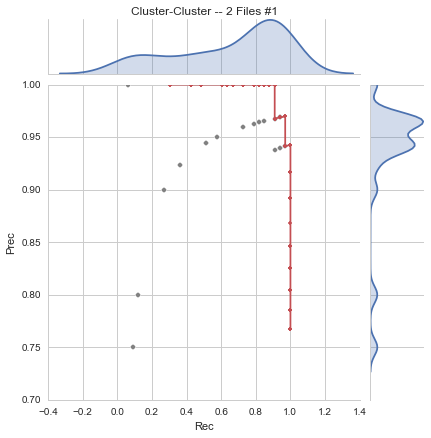

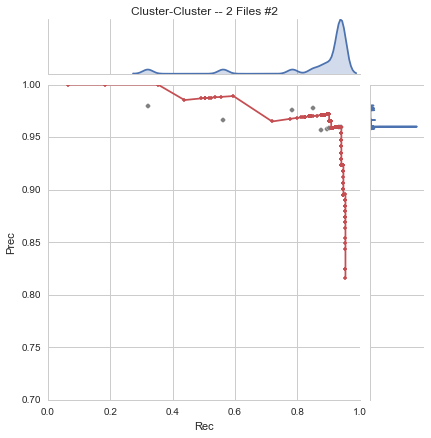

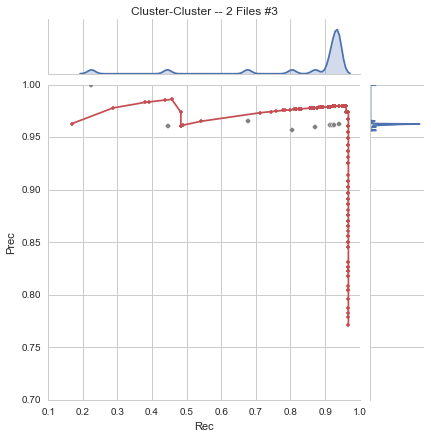

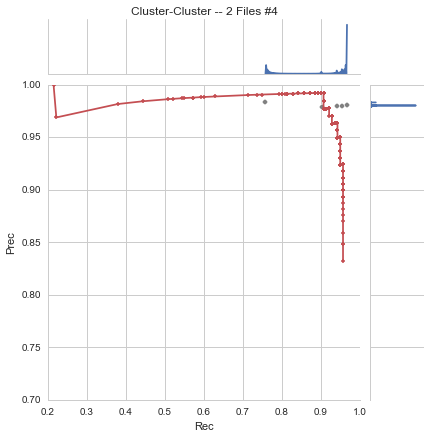

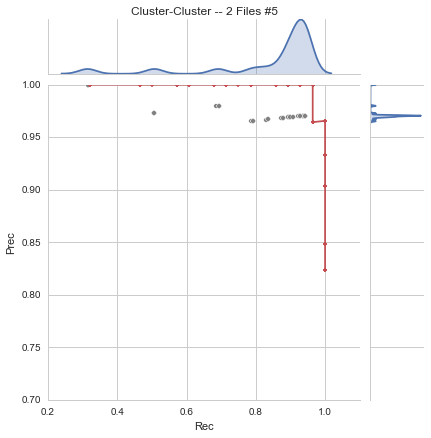

In [40]:
plot_scatter(exp_results_2b, 0, match_cluster_2a, 'Cluster-Cluster -- 2 Files #1')
plot_scatter(exp_results_2b, 1, match_cluster_2b, 'Cluster-Cluster -- 2 Files #2')
plot_scatter(exp_results_2b, 2, match_cluster_2c, 'Cluster-Cluster -- 2 Files #3')
plot_scatter(exp_results_2b, 3, match_cluster_2d, 'Cluster-Cluster -- 2 Files #4')
plot_scatter(exp_results_2b, 4, match_cluster_2e, 'Cluster-Cluster -- 2 Files #5')

<h2>6. Run experiment on sets of 3 files</h2>

In [41]:
n_files = 3
n_iter = 5

In [42]:
training_list_3 = load_or_create_filelist('pickles/beer1pos/training_list_3.p', combined_list, n_iter, n_files)

['std1-file8.txt', 'std1-file1.txt', 'std1-file10.txt']
['std1-file11.txt', 'std1-file1.txt', 'std1-file4.txt']
['std1-file10.txt', 'std1-file8.txt', 'std1-file7.txt']
['std1-file6.txt', 'std1-file7.txt', 'std1-file1.txt']
['std1-file9.txt', 'std1-file11.txt', 'std1-file2.txt']
Saved to pickles/beer1pos/training_list_3.p


In [43]:
testing_list_3 = load_or_create_filelist('pickles/beer1pos/testing_list_3.p', combined_list, n_iter, n_files)

['std1-file8.txt', 'std1-file2.txt', 'std1-file10.txt']
['std1-file10.txt', 'std1-file3.txt', 'std1-file8.txt']
['std1-file5.txt', 'std1-file1.txt', 'std1-file4.txt']
['std1-file3.txt', 'std1-file6.txt', 'std1-file10.txt']
['std1-file4.txt', 'std1-file9.txt', 'std1-file1.txt']
Saved to pickles/beer1pos/testing_list_3.p


In [44]:
exp_results_3a = run_experiment(0, training_list_3, testing_list_3, param_list, 'pickles/beer1pos/res_match_feature_3.p', hp, evaluation_method, transformation_file, gt_file)

Iteration 0
Training on ['std1-file8.txt', 'std1-file1.txt', 'std1-file10.txt']
mass_tol=2, rt_tol=5, tp=154, fp=11, fn=247, prec=0.933, rec=0.384, f1=0.544, th_prob=1.000
mass_tol=2, rt_tol=10, tp=246, fp=19, fn=155, prec=0.928, rec=0.613, f1=0.739, th_prob=1.000
mass_tol=2, rt_tol=15, tp=283, fp=24, fn=118, prec=0.922, rec=0.706, f1=0.799, th_prob=1.000
mass_tol=2, rt_tol=20, tp=313, fp=27, fn=88, prec=0.921, rec=0.781, f1=0.845, th_prob=1.000
mass_tol=2, rt_tol=25, tp=327, fp=27, fn=74, prec=0.924, rec=0.815, f1=0.866, th_prob=1.000
mass_tol=2, rt_tol=30, tp=338, fp=27, fn=63, prec=0.926, rec=0.843, f1=0.883, th_prob=1.000
mass_tol=2, rt_tol=35, tp=342, fp=27, fn=59, prec=0.927, rec=0.853, f1=0.888, th_prob=1.000
mass_tol=2, rt_tol=40, tp=342, fp=27, fn=59, prec=0.927, rec=0.853, f1=0.888, th_prob=1.000
mass_tol=2, rt_tol=45, tp=347, fp=27, fn=54, prec=0.928, rec=0.865, f1=0.895, th_prob=1.000
mass_tol=2, rt_tol=50, tp=351, fp=27, fn=50, prec=0.929, rec=0.875, f1=0.901, th_prob=1.00

In [45]:
exp_results_3b = run_experiment(1, training_list_3, testing_list_3, param_list, 'pickles/beer1pos/res_match_cluster_3.p', hp, evaluation_method, transformation_file, gt_file)

Iteration 0
Training on ['std1-file8.txt', 'std1-file1.txt', 'std1-file10.txt']
mass_tol=2, rt_tol=5, tp=149, fp=15, fn=252, prec=0.909, rec=0.372, f1=0.527, th_prob=1.000
mass_tol=2, rt_tol=10, tp=244, fp=18, fn=157, prec=0.931, rec=0.608, f1=0.736, th_prob=1.000
mass_tol=2, rt_tol=15, tp=288, fp=22, fn=113, prec=0.929, rec=0.718, f1=0.810, th_prob=1.000
mass_tol=2, rt_tol=20, tp=315, fp=24, fn=86, prec=0.929, rec=0.786, f1=0.851, th_prob=1.000
mass_tol=2, rt_tol=25, tp=325, fp=24, fn=76, prec=0.931, rec=0.810, f1=0.867, th_prob=1.000
mass_tol=2, rt_tol=30, tp=337, fp=25, fn=64, prec=0.931, rec=0.840, f1=0.883, th_prob=1.000
mass_tol=2, rt_tol=35, tp=343, fp=27, fn=58, prec=0.927, rec=0.855, f1=0.890, th_prob=1.000
mass_tol=2, rt_tol=40, tp=343, fp=27, fn=58, prec=0.927, rec=0.855, f1=0.890, th_prob=1.000
mass_tol=2, rt_tol=45, tp=348, fp=26, fn=53, prec=0.930, rec=0.868, f1=0.898, th_prob=1.000
mass_tol=2, rt_tol=50, tp=355, fp=27, fn=46, prec=0.929, rec=0.885, f1=0.907, th_prob=1.00

In [46]:
match_cluster_3a = second_stage_clustering(hp, training_list_3, 0)

Iteration 0
Training on ['std1-file8.txt', 'std1-file1.txt', 'std1-file10.txt']
n 0	cluster_list=13	last_K = 13
n 1	cluster_list=1	last_K = 1
n 2	cluster_list=14	last_K = 12
n 3	cluster_list=2	last_K = 1
n 4	cluster_list=2	last_K = 1


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done   2 jobs       | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done   5 jobs       | elapsed:   16.6s


n 5	cluster_list=3	last_K = 1
n 6	cluster_list=1	last_K = 1
n 7	cluster_list=8	last_K = 4
n 8	cluster_list=1	last_K = 1
n 9	cluster_list=1	last_K = 1
n 10	cluster_list=1	last_K = 1
n 11	cluster_list=1	last_K = 1
n 12	cluster_list=2	last_K = 2


[Parallel(n_jobs=1)]: Done   8 jobs       | elapsed:   19.9s
[Parallel(n_jobs=1)]: Done  13 jobs       | elapsed:   20.5s


n 13	cluster_list=1	last_K = 1
n 14	cluster_list=2	last_K = 2
n 15	cluster_list=1	last_K = 1
n 16	cluster_list=1	last_K = 1
n 17	cluster_list=1	last_K = 1
n 18	cluster_list=1	last_K = 1
n 19	cluster_list=1	last_K = 1
n 20	cluster_list=4	last_K = 2
n 21	cluster_list=1	last_K = 1
n 22	cluster_list=1	last_K = 1
n 23	cluster_list=1	last_K = 1
n 24	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  18 jobs       | elapsed:   21.2s
[Parallel(n_jobs=1)]: Done  25 jobs       | elapsed:   22.3s


n 25	cluster_list=1	last_K = 1
n 26	cluster_list=1	last_K = 1
n 27	cluster_list=1	last_K = 1
n 28	cluster_list=1	last_K = 1
n 29	cluster_list=1	last_K = 1
n 30	cluster_list=3	last_K = 3
n 31	cluster_list=1	last_K = 1
n 32	cluster_list=2	last_K = 1
n 33	cluster_list=1	last_K = 1
n 34	cluster_list=1	last_K = 1
n 35	cluster_list=7	last_K = 3
n 36	cluster_list=1	last_K = 1
n 37	cluster_list=1	last_K = 1
n 38	cluster_list=1	last_K = 1
n 39	cluster_list=1	last_K = 1
n 40	cluster_list=2	last_K = 2


[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:   23.4s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:   26.4s


n 41	cluster_list=1	last_K = 1
n 42	cluster_list=31	last_K = 24
n 43	cluster_list=1	last_K = 1
n 44	cluster_list=1	last_K = 1
n 45	cluster_list=16	last_K = 16
n 46	cluster_list=1	last_K = 1
n 47	cluster_list=3	last_K = 3
n 48	cluster_list=3	last_K = 3
n 49	cluster_list=1	last_K = 1
n 50	cluster_list=6	last_K = 2
n 51	cluster_list=6	last_K = 6
n 52	cluster_list=1	last_K = 1
n 53	cluster_list=1	last_K = 1
n 54	cluster_list=1	last_K = 1
n 55	cluster_list=1	last_K = 1
n 56	cluster_list=1	last_K = 1
n 57	cluster_list=1	last_K = 1
n 58	cluster_list=1	last_K = 1
n 59	cluster_list=1	last_K = 1
n 60	cluster_list=33	last_K = 19


[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done  61 jobs       | elapsed:  1.6min


n 61	cluster_list=1	last_K = 1
n 62	cluster_list=1	last_K = 1
n 63	cluster_list=1	last_K = 1
n 64	cluster_list=1	last_K = 1
n 65	cluster_list=1	last_K = 1
n 66	cluster_list=3	last_K = 2
n 67	cluster_list=1	last_K = 1
n 68	cluster_list=1	last_K = 1
n 69	cluster_list=14	last_K = 13
n 70	cluster_list=1	last_K = 1
n 71	cluster_list=3	last_K = 2
n 72	cluster_list=2	last_K = 2
n 73	cluster_list=4	last_K = 4
n 74	cluster_list=3	last_K = 3
n 75	cluster_list=1	last_K = 1
n 76	cluster_list=6	last_K = 5
n 77	cluster_list=1	last_K = 1
n 78	cluster_list=2	last_K = 2
n 79	cluster_list=1	last_K = 1
n 80	cluster_list=2	last_K = 2
n 81	cluster_list=1	last_K = 1
n 82	cluster_list=1	last_K = 1
n 83	cluster_list=1	last_K = 1
n 84	cluster_list=5	last_K = 5


[Parallel(n_jobs=1)]: Done  72 jobs       | elapsed:  1.8min
[Parallel(n_jobs=1)]: Done  85 jobs       | elapsed:  1.9min


n 85	cluster_list=1	last_K = 1
n 86	cluster_list=1	last_K = 1
n 87	cluster_list=1	last_K = 1
n 88	cluster_list=1	last_K = 1
n 89	cluster_list=1	last_K = 1
n 90	cluster_list=1	last_K = 1
n 91	cluster_list=1	last_K = 1
n 92	cluster_list=1	last_K = 1
n 93	cluster_list=1	last_K = 1
n 94	cluster_list=3	last_K = 1
n 95	cluster_list=1	last_K = 1
n 96	cluster_list=1	last_K = 1
n 97	cluster_list=1	last_K = 1
n 98	cluster_list=1	last_K = 1
n 99	cluster_list=1	last_K = 1
n 100	cluster_list=3	last_K = 2
n 101	cluster_list=1	last_K = 1
n 102	cluster_list=2	last_K = 2
n 103	cluster_list=1	last_K = 1
n 104	cluster_list=1	last_K = 1
n 105	cluster_list=1	last_K = 1
n 106	cluster_list=3	last_K = 1
n 107	cluster_list=1	last_K = 1
n 108	cluster_list=1	last_K = 1
n 109	cluster_list=6	last_K = 6
n 110	cluster_list=4	last_K = 4
n 111	cluster_list=1	last_K = 1
n 112	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  98 jobs       | elapsed:  1.9min
[Parallel(n_jobs=1)]: Done 113 jobs       | elapsed:  2.0min


n 113	cluster_list=1	last_K = 1
n 114	cluster_list=1	last_K = 1
n 115	cluster_list=1	last_K = 1
n 116	cluster_list=1	last_K = 1
n 117	cluster_list=10	last_K = 9
n 118	cluster_list=1	last_K = 1
n 119	cluster_list=4	last_K = 2
n 120	cluster_list=1	last_K = 1
n 121	cluster_list=1	last_K = 1
n 122	cluster_list=9	last_K = 8
n 123	cluster_list=1	last_K = 1
n 124	cluster_list=1	last_K = 1
n 125	cluster_list=6	last_K = 4
n 126	cluster_list=3	last_K = 1
n 127	cluster_list=3	last_K = 1
n 128	cluster_list=2	last_K = 2
n 129	cluster_list=1	last_K = 1
n 130	cluster_list=1	last_K = 1
n 131	cluster_list=5	last_K = 3
n 132	cluster_list=1	last_K = 1
n 133	cluster_list=15	last_K = 15
n 134	cluster_list=1	last_K = 1
n 135	cluster_list=1	last_K = 1
n 136	cluster_list=1	last_K = 1
n 137	cluster_list=1	last_K = 1
n 138	cluster_list=7	last_K = 7
n 139	cluster_list=3	last_K = 1
n 140	cluster_list=1	last_K = 1
n 141	cluster_list=8	last_K = 4
n 142	cluster_list=4	last_K = 2
n 143	cluster_list=1	last_K = 1
n 144

[Parallel(n_jobs=1)]: Done 128 jobs       | elapsed:  2.2min
[Parallel(n_jobs=1)]: Done 145 jobs       | elapsed:  2.6min


n 145	cluster_list=1	last_K = 1
n 146	cluster_list=1	last_K = 1
n 147	cluster_list=3	last_K = 3
n 148	cluster_list=1	last_K = 1
n 149	cluster_list=1	last_K = 1
n 150	cluster_list=1	last_K = 1
n 151	cluster_list=2	last_K = 2
n 152	cluster_list=1	last_K = 1
n 153	cluster_list=1	last_K = 1
n 154	cluster_list=1	last_K = 1
n 155	cluster_list=29	last_K = 24
n 156	cluster_list=1	last_K = 1
n 157	cluster_list=1	last_K = 1
n 158	cluster_list=1	last_K = 1
n 159	cluster_list=1	last_K = 1
n 160	cluster_list=8	last_K = 7
n 161	cluster_list=1	last_K = 1
n 162	cluster_list=2	last_K = 2
n 163	cluster_list=1	last_K = 1
n 164	cluster_list=1	last_K = 1
n 165	cluster_list=1	last_K = 1
n 166	cluster_list=1	last_K = 1
n 167	cluster_list=1	last_K = 1
n 168	cluster_list=3	last_K = 2
n 169	cluster_list=2	last_K = 2
n 170	cluster_list=1	last_K = 1
n 171	cluster_list=1	last_K = 1
n 172	cluster_list=6	last_K = 6
n 173	cluster_list=2	last_K = 2
n 174	cluster_list=14	last_K = 13
n 175	cluster_list=2	last_K = 2
n 17

[Parallel(n_jobs=1)]: Done 162 jobs       | elapsed:  3.1min
[Parallel(n_jobs=1)]: Done 181 jobs       | elapsed:  3.4min


n 181	cluster_list=2	last_K = 2
n 182	cluster_list=2	last_K = 2
n 183	cluster_list=1	last_K = 1
n 184	cluster_list=4	last_K = 4
n 185	cluster_list=2	last_K = 2
n 186	cluster_list=3	last_K = 3
n 187	cluster_list=2	last_K = 2
n 188	cluster_list=2	last_K = 2
n 189	cluster_list=2	last_K = 2
n 190	cluster_list=4	last_K = 4
n 191	cluster_list=2	last_K = 2
n 192	cluster_list=4	last_K = 4
n 193	cluster_list=4	last_K = 4
n 194	cluster_list=1	last_K = 1
n 195	cluster_list=1	last_K = 1
n 196	cluster_list=2	last_K = 2
n 197	cluster_list=1	last_K = 1
n 198	cluster_list=1	last_K = 1
n 199	cluster_list=1	last_K = 1
n 200	cluster_list=4	last_K = 4
n 201	cluster_list=1	last_K = 1
n 202	cluster_list=3	last_K = 3
n 203	cluster_list=1	last_K = 1
n 204	cluster_list=17	last_K = 15
n 205	cluster_list=1	last_K = 1
n 206	cluster_list=1	last_K = 1
n 207	cluster_list=1	last_K = 1
n 208	cluster_list=1	last_K = 1
n 209	cluster_list=1	last_K = 1
n 210	cluster_list=1	last_K = 1
n 211	cluster_list=1	last_K = 1
n 212	

[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:  3.7min
[Parallel(n_jobs=1)]: Done 221 jobs       | elapsed:  4.0min


n 221	cluster_list=1	last_K = 1
n 222	cluster_list=2	last_K = 2
n 223	cluster_list=4	last_K = 4
n 224	cluster_list=1	last_K = 1
n 225	cluster_list=2	last_K = 2
n 226	cluster_list=16	last_K = 14
n 227	cluster_list=4	last_K = 4
n 228	cluster_list=8	last_K = 8
n 229	cluster_list=2	last_K = 2
n 230	cluster_list=1	last_K = 1
n 231	cluster_list=2	last_K = 2
n 232	cluster_list=1	last_K = 1
n 233	cluster_list=9	last_K = 9
n 234	cluster_list=3	last_K = 3
n 235	cluster_list=2	last_K = 2
n 236	cluster_list=3	last_K = 3
n 237	cluster_list=10	last_K = 10
n 238	cluster_list=4	last_K = 3
n 239	cluster_list=2	last_K = 2
n 240	cluster_list=1	last_K = 1
n 241	cluster_list=1	last_K = 1
n 242	cluster_list=3	last_K = 3
n 243	cluster_list=1	last_K = 1
n 244	cluster_list=2	last_K = 2
n 245	cluster_list=1	last_K = 1
n 246	cluster_list=3	last_K = 3
n 247	cluster_list=4	last_K = 4
n 248	cluster_list=2	last_K = 2
n 249	cluster_list=2	last_K = 2
n 250	cluster_list=1	last_K = 1
n 251	cluster_list=2	last_K = 2
n 25

[Parallel(n_jobs=1)]: Done 242 jobs       | elapsed:  4.6min
[Parallel(n_jobs=1)]: Done 265 jobs       | elapsed:  5.5min


n 265	cluster_list=1	last_K = 1
n 266	cluster_list=4	last_K = 4
n 267	cluster_list=1	last_K = 1
n 268	cluster_list=5	last_K = 5
n 269	cluster_list=1	last_K = 1
n 270	cluster_list=8	last_K = 6
n 271	cluster_list=3	last_K = 3
n 272	cluster_list=1	last_K = 1
n 273	cluster_list=1	last_K = 1
n 274	cluster_list=1	last_K = 1
n 275	cluster_list=3	last_K = 3
n 276	cluster_list=2	last_K = 2
n 277	cluster_list=2	last_K = 2
n 278	cluster_list=1	last_K = 1
n 279	cluster_list=1	last_K = 1
n 280	cluster_list=1	last_K = 1
n 281	cluster_list=2	last_K = 2
n 282	cluster_list=2	last_K = 2
n 283	cluster_list=1	last_K = 1
n 284	cluster_list=1	last_K = 1
n 285	cluster_list=1	last_K = 1
n 286	cluster_list=1	last_K = 1
n 287	cluster_list=2	last_K = 2
n 288	cluster_list=1	last_K = 1
n 289	cluster_list=2	last_K = 2
n 290	cluster_list=1	last_K = 1
n 291	cluster_list=1	last_K = 1
n 292	cluster_list=2	last_K = 2
n 293	cluster_list=1	last_K = 1
n 294	cluster_list=1	last_K = 1
n 295	cluster_list=1	last_K = 1
n 296	cl

[Parallel(n_jobs=1)]: Done 288 jobs       | elapsed:  5.7min
[Parallel(n_jobs=1)]: Done 313 jobs       | elapsed:  5.8min


n 313	cluster_list=1	last_K = 1
n 314	cluster_list=1	last_K = 1
n 315	cluster_list=1	last_K = 1
n 316	cluster_list=1	last_K = 1
n 317	cluster_list=2	last_K = 2
n 318	cluster_list=1	last_K = 1
n 319	cluster_list=1	last_K = 1
n 320	cluster_list=4	last_K = 3
n 321	cluster_list=2	last_K = 2
n 322	cluster_list=2	last_K = 2
n 323	cluster_list=2	last_K = 2
n 324	cluster_list=1	last_K = 1
n 325	cluster_list=2	last_K = 2
n 326	cluster_list=1	last_K = 1
n 327	cluster_list=1	last_K = 1
n 328	cluster_list=4	last_K = 4
n 329	cluster_list=1	last_K = 1
n 330	cluster_list=1	last_K = 1
n 331	cluster_list=1	last_K = 1
n 332	cluster_list=2	last_K = 2
n 333	cluster_list=4	last_K = 4
n 334	cluster_list=1	last_K = 1
n 335	cluster_list=1	last_K = 1
n 336	cluster_list=3	last_K = 3
n 337	cluster_list=1	last_K = 1
n 338	cluster_list=6	last_K = 6
n 339	cluster_list=1	last_K = 1
n 340	cluster_list=1	last_K = 1
n 341	cluster_list=3	last_K = 3
n 342	cluster_list=1	last_K = 1
n 343	cluster_list=3	last_K = 3
n 344	cl

[Parallel(n_jobs=1)]: Done 338 jobs       | elapsed:  6.0min
[Parallel(n_jobs=1)]: Done 365 jobs       | elapsed:  6.3min


n 365	cluster_list=3	last_K = 3
n 366	cluster_list=1	last_K = 1
n 367	cluster_list=1	last_K = 1
n 368	cluster_list=1	last_K = 1
n 369	cluster_list=2	last_K = 2
n 370	cluster_list=4	last_K = 3
n 371	cluster_list=1	last_K = 1
n 372	cluster_list=1	last_K = 1
n 373	cluster_list=1	last_K = 1
n 374	cluster_list=1	last_K = 1
n 375	cluster_list=2	last_K = 2
n 376	cluster_list=1	last_K = 1
n 377	cluster_list=2	last_K = 2
n 378	cluster_list=1	last_K = 1
n 379	cluster_list=3	last_K = 2
n 380	cluster_list=1	last_K = 1
n 381	cluster_list=1	last_K = 1
n 382	cluster_list=1	last_K = 1
n 383	cluster_list=1	last_K = 1
n 384	cluster_list=1	last_K = 1
n 385	cluster_list=1	last_K = 1
n 386	cluster_list=1	last_K = 1
n 387	cluster_list=1	last_K = 1
n 388	cluster_list=1	last_K = 1
n 389	cluster_list=1	last_K = 1
n 390	cluster_list=2	last_K = 1
n 391	cluster_list=3	last_K = 1
n 392	cluster_list=1	last_K = 1
n 393	cluster_list=1	last_K = 1
n 394	cluster_list=1	last_K = 1
n 395	cluster_list=3	last_K = 1
n 396	cl

[Parallel(n_jobs=1)]: Done 392 jobs       | elapsed:  6.4min
[Parallel(n_jobs=1)]: Done 421 jobs       | elapsed:  6.5min


n 421	cluster_list=1	last_K = 1
n 422	cluster_list=1	last_K = 1
n 423	cluster_list=1	last_K = 1
n 424	cluster_list=1	last_K = 1
n 425	cluster_list=2	last_K = 1
n 426	cluster_list=2	last_K = 2
n 427	cluster_list=22	last_K = 17
n 428	cluster_list=3	last_K = 2
n 429	cluster_list=1	last_K = 1
n 430	cluster_list=1	last_K = 1
n 431	cluster_list=1	last_K = 1
n 432	cluster_list=3	last_K = 2
n 433	cluster_list=3	last_K = 3
n 434	cluster_list=3	last_K = 2
n 435	cluster_list=2	last_K = 2
n 436	cluster_list=1	last_K = 1
n 437	cluster_list=3	last_K = 3
n 438	cluster_list=1	last_K = 1
n 439	cluster_list=1	last_K = 1
n 440	cluster_list=1	last_K = 1
n 441	cluster_list=1	last_K = 1
n 442	cluster_list=1	last_K = 1
n 443	cluster_list=1	last_K = 1
n 444	cluster_list=1	last_K = 1
n 445	cluster_list=5	last_K = 5
n 446	cluster_list=1	last_K = 1
n 447	cluster_list=31	last_K = 19
n 448	cluster_list=13	last_K = 12
n 449	cluster_list=1	last_K = 1
n 450	cluster_list=1	last_K = 1
n 451	cluster_list=1	last_K = 1
n 

[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:  7.4min
[Parallel(n_jobs=1)]: Done 481 jobs       | elapsed:  7.7min


n 481	cluster_list=1	last_K = 1
n 482	cluster_list=1	last_K = 1
n 483	cluster_list=1	last_K = 1
n 484	cluster_list=1	last_K = 1
n 485	cluster_list=1	last_K = 1
n 486	cluster_list=1	last_K = 1
n 487	cluster_list=16	last_K = 13
n 488	cluster_list=1	last_K = 1
n 489	cluster_list=1	last_K = 1
n 490	cluster_list=1	last_K = 1
n 491	cluster_list=1	last_K = 1
n 492	cluster_list=1	last_K = 1
n 493	cluster_list=1	last_K = 1
n 494	cluster_list=3	last_K = 2
n 495	cluster_list=1	last_K = 1
n 496	cluster_list=1	last_K = 1
n 497	cluster_list=3	last_K = 1
n 498	cluster_list=1	last_K = 1
n 499	cluster_list=1	last_K = 1
n 500	cluster_list=1	last_K = 1
n 501	cluster_list=1	last_K = 1
n 502	cluster_list=1	last_K = 1
n 503	cluster_list=1	last_K = 1
n 504	cluster_list=1	last_K = 1
n 505	cluster_list=1	last_K = 1
n 506	cluster_list=2	last_K = 2
n 507	cluster_list=1	last_K = 1
n 508	cluster_list=1	last_K = 1
n 509	cluster_list=1	last_K = 1
n 510	cluster_list=3	last_K = 3
n 511	cluster_list=14	last_K = 14
n 51

[Parallel(n_jobs=1)]: Done 512 jobs       | elapsed:  8.0min
[Parallel(n_jobs=1)]: Done 545 jobs       | elapsed:  8.6min


n 545	cluster_list=3	last_K = 2
n 546	cluster_list=6	last_K = 4
n 547	cluster_list=4	last_K = 2
n 548	cluster_list=1	last_K = 1
n 549	cluster_list=6	last_K = 5
n 550	cluster_list=12	last_K = 11
n 551	cluster_list=2	last_K = 1
n 552	cluster_list=4	last_K = 4
n 553	cluster_list=2	last_K = 1
n 554	cluster_list=2	last_K = 2
n 555	cluster_list=3	last_K = 2
n 556	cluster_list=5	last_K = 5
n 557	cluster_list=3	last_K = 3
n 558	cluster_list=3	last_K = 2
n 559	cluster_list=1	last_K = 1
n 560	cluster_list=2	last_K = 2
n 561	cluster_list=1	last_K = 1
n 562	cluster_list=1	last_K = 1
n 563	cluster_list=2	last_K = 2
n 564	cluster_list=1	last_K = 1
n 565	cluster_list=1	last_K = 1
n 566	cluster_list=1	last_K = 1
n 567	cluster_list=3	last_K = 1
n 568	cluster_list=2	last_K = 1
n 569	cluster_list=2	last_K = 2
n 570	cluster_list=2	last_K = 2
n 571	cluster_list=1	last_K = 1
n 572	cluster_list=1	last_K = 1
n 573	cluster_list=1	last_K = 1
n 574	cluster_list=3	last_K = 1
n 575	cluster_list=1	last_K = 1
n 576	

[Parallel(n_jobs=1)]: Done 578 jobs       | elapsed:  9.0min
[Parallel(n_jobs=1)]: Done 613 jobs       | elapsed:  9.8min


n 613	cluster_list=1	last_K = 1
n 614	cluster_list=1	last_K = 1
n 615	cluster_list=1	last_K = 1
n 616	cluster_list=1	last_K = 1
n 617	cluster_list=1	last_K = 1
n 618	cluster_list=2	last_K = 1
n 619	cluster_list=1	last_K = 1
n 620	cluster_list=1	last_K = 1
n 621	cluster_list=32	last_K = 20
n 622	cluster_list=5	last_K = 3
n 623	cluster_list=2	last_K = 2
n 624	cluster_list=1	last_K = 1
n 625	cluster_list=1	last_K = 1
n 626	cluster_list=1	last_K = 1
n 627	cluster_list=4	last_K = 2
n 628	cluster_list=1	last_K = 1
n 629	cluster_list=18	last_K = 15
n 630	cluster_list=1	last_K = 1
n 631	cluster_list=1	last_K = 1
n 632	cluster_list=2	last_K = 2
n 633	cluster_list=2	last_K = 2
n 634	cluster_list=1	last_K = 1
n 635	cluster_list=1	last_K = 1
n 636	cluster_list=1	last_K = 1
n 637	cluster_list=1	last_K = 1
n 638	cluster_list=3	last_K = 1
n 639	cluster_list=3	last_K = 2
n 640	cluster_list=1	last_K = 1
n 641	cluster_list=5	last_K = 4
n 642	cluster_list=7	last_K = 4
n 643	cluster_list=1	last_K = 1
n 64

[Parallel(n_jobs=1)]: Done 648 jobs       | elapsed: 10.6min
[Parallel(n_jobs=1)]: Done 685 jobs       | elapsed: 10.6min


n 685	cluster_list=1	last_K = 1
n 686	cluster_list=1	last_K = 1
n 687	cluster_list=1	last_K = 1
n 688	cluster_list=1	last_K = 1
n 689	cluster_list=2	last_K = 1
n 690	cluster_list=2	last_K = 2
n 691	cluster_list=1	last_K = 1
n 692	cluster_list=1	last_K = 1
n 693	cluster_list=2	last_K = 2
n 694	cluster_list=2	last_K = 2
n 695	cluster_list=8	last_K = 8
n 696	cluster_list=1	last_K = 1
n 697	cluster_list=2	last_K = 1
n 698	cluster_list=1	last_K = 1
n 699	cluster_list=1	last_K = 1
n 700	cluster_list=1	last_K = 1
n 701	cluster_list=1	last_K = 1
n 702	cluster_list=1	last_K = 1
n 703	cluster_list=1	last_K = 1
n 704	cluster_list=11	last_K = 11
n 705	cluster_list=1	last_K = 1
n 706	cluster_list=1	last_K = 1
n 707	cluster_list=1	last_K = 1
n 708	cluster_list=1	last_K = 1
n 709	cluster_list=1	last_K = 1
n 710	cluster_list=1	last_K = 1
n 711	cluster_list=1	last_K = 1
n 712	cluster_list=1	last_K = 1
n 713	cluster_list=1	last_K = 1
n 714	cluster_list=1	last_K = 1
n 715	cluster_list=1	last_K = 1
n 716	

[Parallel(n_jobs=1)]: Done 722 jobs       | elapsed: 10.8min
[Parallel(n_jobs=1)]: Done 761 jobs       | elapsed: 10.9min


n 761	cluster_list=1	last_K = 1
n 762	cluster_list=1	last_K = 1
n 763	cluster_list=1	last_K = 1
n 764	cluster_list=1	last_K = 1
n 765	cluster_list=1	last_K = 1
n 766	cluster_list=1	last_K = 1
n 767	cluster_list=1	last_K = 1
n 768	cluster_list=1	last_K = 1
n 769	cluster_list=1	last_K = 1
n 770	cluster_list=1	last_K = 1
n 771	cluster_list=1	last_K = 1
n 772	cluster_list=1	last_K = 1
n 773	cluster_list=1	last_K = 1
n 774	cluster_list=1	last_K = 1
n 775	cluster_list=1	last_K = 1
n 776	cluster_list=2	last_K = 1
n 777	cluster_list=1	last_K = 1
n 778	cluster_list=1	last_K = 1
n 779	cluster_list=1	last_K = 1
n 780	cluster_list=1	last_K = 1
n 781	cluster_list=1	last_K = 1
n 782	cluster_list=1	last_K = 1
n 783	cluster_list=2	last_K = 1
n 784	cluster_list=1	last_K = 1
n 785	cluster_list=2	last_K = 1
n 786	cluster_list=1	last_K = 1
n 787	cluster_list=1	last_K = 1
n 788	cluster_list=1	last_K = 1
n 789	cluster_list=1	last_K = 1
n 790	cluster_list=1	last_K = 1
n 791	cluster_list=1	last_K = 1
n 792	cl

[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed: 11.0min
[Parallel(n_jobs=1)]: Done 841 jobs       | elapsed: 11.0min


n 841	cluster_list=1	last_K = 1
n 842	cluster_list=1	last_K = 1
n 843	cluster_list=1	last_K = 1
n 844	cluster_list=1	last_K = 1
n 845	cluster_list=3	last_K = 3
n 846	cluster_list=1	last_K = 1
n 847	cluster_list=2	last_K = 1
n 848	cluster_list=2	last_K = 2
n 849	cluster_list=1	last_K = 1
n 850	cluster_list=1	last_K = 1
n 851	cluster_list=35	last_K = 27
n 852	cluster_list=4	last_K = 4
n 853	cluster_list=1	last_K = 1
n 854	cluster_list=4	last_K = 3
n 855	cluster_list=2	last_K = 2
n 856	cluster_list=1	last_K = 1
n 857	cluster_list=1	last_K = 1
n 858	cluster_list=3	last_K = 3
n 859	cluster_list=9	last_K = 8
n 860	cluster_list=2	last_K = 2
n 861	cluster_list=13	last_K = 10
n 862	cluster_list=2	last_K = 2
n 863	cluster_list=4	last_K = 2
n 864	cluster_list=1	last_K = 1
n 865	cluster_list=1	last_K = 1
n 866	cluster_list=6	last_K = 6
n 867	cluster_list=1	last_K = 1
n 868	cluster_list=1	last_K = 1
n 869	cluster_list=20	last_K = 19
n 870	cluster_list=1	last_K = 1
n 871	cluster_list=2	last_K = 2
n 

[Parallel(n_jobs=1)]: Done 882 jobs       | elapsed: 12.6min
[Parallel(n_jobs=1)]: Done 925 jobs       | elapsed: 13.1min


n 925	cluster_list=1	last_K = 1
n 926	cluster_list=4	last_K = 3
n 927	cluster_list=1	last_K = 1
n 928	cluster_list=1	last_K = 1
n 929	cluster_list=1	last_K = 1
n 930	cluster_list=1	last_K = 1
n 931	cluster_list=1	last_K = 1
n 932	cluster_list=1	last_K = 1
n 933	cluster_list=1	last_K = 1
n 934	cluster_list=1	last_K = 1
n 935	cluster_list=1	last_K = 1
n 936	cluster_list=1	last_K = 1
n 937	cluster_list=1	last_K = 1
n 938	cluster_list=1	last_K = 1
n 939	cluster_list=2	last_K = 2
n 940	cluster_list=1	last_K = 1
n 941	cluster_list=1	last_K = 1
n 942	cluster_list=1	last_K = 1
n 943	cluster_list=1	last_K = 1
n 944	cluster_list=1	last_K = 1
n 945	cluster_list=2	last_K = 2
n 946	cluster_list=1	last_K = 1
n 947	cluster_list=1	last_K = 1
n 948	cluster_list=3	last_K = 2
n 949	cluster_list=1	last_K = 1
n 950	cluster_list=1	last_K = 1
n 951	cluster_list=2	last_K = 2
n 952	cluster_list=1	last_K = 1
n 953	cluster_list=1	last_K = 1
n 954	cluster_list=2	last_K = 2
n 955	cluster_list=1	last_K = 1
n 956	cl

[Parallel(n_jobs=1)]: Done 968 jobs       | elapsed: 13.3min
[Parallel(n_jobs=1)]: Done 1013 jobs       | elapsed: 15.1min


n 1013	cluster_list=1	last_K = 1
n 1014	cluster_list=1	last_K = 1
n 1015	cluster_list=1	last_K = 1
n 1016	cluster_list=1	last_K = 1
n 1017	cluster_list=1	last_K = 1
n 1018	cluster_list=1	last_K = 1
n 1019	cluster_list=3	last_K = 3
n 1020	cluster_list=3	last_K = 3
n 1021	cluster_list=1	last_K = 1
n 1022	cluster_list=6	last_K = 6
n 1023	cluster_list=1	last_K = 1
n 1024	cluster_list=1	last_K = 1
n 1025	cluster_list=2	last_K = 2
n 1026	cluster_list=1	last_K = 1
n 1027	cluster_list=4	last_K = 4
n 1028	cluster_list=1	last_K = 1
n 1029	cluster_list=2	last_K = 2
n 1030	cluster_list=1	last_K = 1
n 1031	cluster_list=48	last_K = 48
n 1032	cluster_list=1	last_K = 1
n 1033	cluster_list=3	last_K = 3
n 1034	cluster_list=1	last_K = 1
n 1035	cluster_list=4	last_K = 4
n 1036	cluster_list=2	last_K = 2
n 1037	cluster_list=1	last_K = 1
n 1038	cluster_list=2	last_K = 2
n 1039	cluster_list=1	last_K = 1
n 1040	cluster_list=1	last_K = 1
n 1041	cluster_list=1	last_K = 1
n 1042	cluster_list=1	last_K = 1
n 1043	c

[Parallel(n_jobs=1)]: Done 1058 jobs       | elapsed: 17.7min
[Parallel(n_jobs=1)]: Done 1105 jobs       | elapsed: 18.5min


n 1105	cluster_list=6	last_K = 5
n 1106	cluster_list=5	last_K = 5
n 1107	cluster_list=1	last_K = 1
n 1108	cluster_list=3	last_K = 3
n 1109	cluster_list=1	last_K = 1
n 1110	cluster_list=4	last_K = 4
n 1111	cluster_list=1	last_K = 1
n 1112	cluster_list=1	last_K = 1
n 1113	cluster_list=1	last_K = 1
n 1114	cluster_list=1	last_K = 1
n 1115	cluster_list=1	last_K = 1
n 1116	cluster_list=2	last_K = 2
n 1117	cluster_list=1	last_K = 1
n 1118	cluster_list=1	last_K = 1
n 1119	cluster_list=1	last_K = 1
n 1120	cluster_list=3	last_K = 2
n 1121	cluster_list=1	last_K = 1
n 1122	cluster_list=1	last_K = 1
n 1123	cluster_list=1	last_K = 1
n 1124	cluster_list=2	last_K = 2
n 1125	cluster_list=1	last_K = 1
n 1126	cluster_list=1	last_K = 1
n 1127	cluster_list=11	last_K = 8
n 1128	cluster_list=1	last_K = 1
n 1129	cluster_list=3	last_K = 1
n 1130	cluster_list=1	last_K = 1
n 1131	cluster_list=1	last_K = 1
n 1132	cluster_list=1	last_K = 1
n 1133	cluster_list=3	last_K = 1
n 1134	cluster_list=1	last_K = 1
n 1135	cl

[Parallel(n_jobs=1)]: Done 1152 jobs       | elapsed: 18.8min
[Parallel(n_jobs=1)]: Done 1201 jobs       | elapsed: 19.3min


n 1201	cluster_list=1	last_K = 1
n 1202	cluster_list=1	last_K = 1
n 1203	cluster_list=2	last_K = 2
n 1204	cluster_list=3	last_K = 2
n 1205	cluster_list=1	last_K = 1
n 1206	cluster_list=1	last_K = 1
n 1207	cluster_list=1	last_K = 1
n 1208	cluster_list=9	last_K = 8
n 1209	cluster_list=12	last_K = 8
n 1210	cluster_list=5	last_K = 4
n 1211	cluster_list=1	last_K = 1
n 1212	cluster_list=7	last_K = 5
n 1213	cluster_list=1	last_K = 1
n 1214	cluster_list=17	last_K = 11
n 1215	cluster_list=1	last_K = 1
n 1216	cluster_list=3	last_K = 2
n 1217	cluster_list=3	last_K = 2
n 1218	cluster_list=1	last_K = 1
n 1219	cluster_list=4	last_K = 2
n 1220	cluster_list=3	last_K = 2
n 1221	cluster_list=2	last_K = 2
n 1222	cluster_list=3	last_K = 2
n 1223	cluster_list=4	last_K = 3
n 1224	cluster_list=1	last_K = 1
n 1225	cluster_list=9	last_K = 6
n 1226	cluster_list=1	last_K = 1
n 1227	cluster_list=1	last_K = 1
n 1228	cluster_list=5	last_K = 3
n 1229	cluster_list=1	last_K = 1
n 1230	cluster_list=2	last_K = 1
n 1231	

[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed: 20.2min
[Parallel(n_jobs=1)]: Done 1301 jobs       | elapsed: 20.6min


n 1301	cluster_list=1	last_K = 1
n 1302	cluster_list=3	last_K = 1
n 1303	cluster_list=1	last_K = 1
n 1304	cluster_list=2	last_K = 1
n 1305	cluster_list=1	last_K = 1
n 1306	cluster_list=1	last_K = 1
n 1307	cluster_list=1	last_K = 1
n 1308	cluster_list=9	last_K = 7
n 1309	cluster_list=1	last_K = 1
n 1310	cluster_list=1	last_K = 1
n 1311	cluster_list=1	last_K = 1
n 1312	cluster_list=1	last_K = 1
n 1313	cluster_list=1	last_K = 1
n 1314	cluster_list=1	last_K = 1
n 1315	cluster_list=1	last_K = 1
n 1316	cluster_list=1	last_K = 1
n 1317	cluster_list=1	last_K = 1
n 1318	cluster_list=1	last_K = 1
n 1319	cluster_list=2	last_K = 1
n 1320	cluster_list=1	last_K = 1
n 1321	cluster_list=1	last_K = 1
n 1322	cluster_list=1	last_K = 1
n 1323	cluster_list=1	last_K = 1
n 1324	cluster_list=1	last_K = 1
n 1325	cluster_list=4	last_K = 4
n 1326	cluster_list=1	last_K = 1
n 1327	cluster_list=1	last_K = 1
n 1328	cluster_list=1	last_K = 1
n 1329	cluster_list=17	last_K = 12
n 1330	cluster_list=1	last_K = 1
n 1331	c

[Parallel(n_jobs=1)]: Done 1352 jobs       | elapsed: 21.0min
[Parallel(n_jobs=1)]: Done 1405 jobs       | elapsed: 21.2min


n 1405	cluster_list=1	last_K = 1
n 1406	cluster_list=3	last_K = 1
n 1407	cluster_list=2	last_K = 1
n 1408	cluster_list=1	last_K = 1
n 1409	cluster_list=2	last_K = 1
n 1410	cluster_list=1	last_K = 1
n 1411	cluster_list=1	last_K = 1
n 1412	cluster_list=1	last_K = 1
n 1413	cluster_list=1	last_K = 1
n 1414	cluster_list=1	last_K = 1
n 1415	cluster_list=1	last_K = 1
n 1416	cluster_list=2	last_K = 1
n 1417	cluster_list=1	last_K = 1
n 1418	cluster_list=1	last_K = 1
n 1419	cluster_list=1	last_K = 1
n 1420	cluster_list=1	last_K = 1
n 1421	cluster_list=1	last_K = 1
n 1422	cluster_list=1	last_K = 1
n 1423	cluster_list=2	last_K = 1
n 1424	cluster_list=1	last_K = 1
n 1425	cluster_list=1	last_K = 1
n 1426	cluster_list=1	last_K = 1
n 1427	cluster_list=1	last_K = 1
n 1428	cluster_list=1	last_K = 1
n 1429	cluster_list=3	last_K = 2
n 1430	cluster_list=1	last_K = 1
n 1431	cluster_list=1	last_K = 1
n 1432	cluster_list=1	last_K = 1
n 1433	cluster_list=1	last_K = 1
n 1434	cluster_list=1	last_K = 1
n 1435	clu

[Parallel(n_jobs=1)]: Done 1458 jobs       | elapsed: 21.3min
[Parallel(n_jobs=1)]: Done 1513 jobs       | elapsed: 21.7min


n 1513	cluster_list=1	last_K = 1
n 1514	cluster_list=3	last_K = 1
n 1515	cluster_list=3	last_K = 1
n 1516	cluster_list=1	last_K = 1
n 1517	cluster_list=4	last_K = 3
n 1518	cluster_list=1	last_K = 1
n 1519	cluster_list=2	last_K = 2
n 1520	cluster_list=1	last_K = 1
n 1521	cluster_list=4	last_K = 4
n 1522	cluster_list=1	last_K = 1
n 1523	cluster_list=2	last_K = 2
n 1524	cluster_list=6	last_K = 6
n 1525	cluster_list=3	last_K = 3
n 1526	cluster_list=6	last_K = 6
n 1527	cluster_list=5	last_K = 4
n 1528	cluster_list=2	last_K = 2
n 1529	cluster_list=1	last_K = 1
n 1530	cluster_list=2	last_K = 2
n 1531	cluster_list=4	last_K = 3
n 1532	cluster_list=2	last_K = 2
n 1533	cluster_list=2	last_K = 1
n 1534	cluster_list=1	last_K = 1
n 1535	cluster_list=5	last_K = 5
n 1536	cluster_list=4	last_K = 4
n 1537	cluster_list=16	last_K = 14
n 1538	cluster_list=1	last_K = 1
n 1539	cluster_list=1	last_K = 1
n 1540	cluster_list=1	last_K = 1
n 1541	cluster_list=2	last_K = 1
n 1542	cluster_list=2	last_K = 1
n 1543	c

[Parallel(n_jobs=1)]: Done 1568 jobs       | elapsed: 22.4min
[Parallel(n_jobs=1)]: Done 1625 jobs       | elapsed: 23.1min


n 1625	cluster_list=2	last_K = 1
n 1626	cluster_list=2	last_K = 2
n 1627	cluster_list=4	last_K = 2
n 1628	cluster_list=1	last_K = 1
n 1629	cluster_list=2	last_K = 2
n 1630	cluster_list=1	last_K = 1
n 1631	cluster_list=1	last_K = 1
n 1632	cluster_list=2	last_K = 2
n 1633	cluster_list=1	last_K = 1
n 1634	cluster_list=1	last_K = 1
n 1635	cluster_list=1	last_K = 1
n 1636	cluster_list=1	last_K = 1
n 1637	cluster_list=1	last_K = 1
n 1638	cluster_list=1	last_K = 1
n 1639	cluster_list=1	last_K = 1
n 1640	cluster_list=1	last_K = 1
n 1641	cluster_list=2	last_K = 1
n 1642	cluster_list=1	last_K = 1
n 1643	cluster_list=2	last_K = 1
n 1644	cluster_list=1	last_K = 1
n 1645	cluster_list=1	last_K = 1
n 1646	cluster_list=1	last_K = 1
n 1647	cluster_list=8	last_K = 5
n 1648	cluster_list=1	last_K = 1
n 1649	cluster_list=1	last_K = 1
n 1650	cluster_list=1	last_K = 1
n 1651	cluster_list=1	last_K = 1
n 1652	cluster_list=1	last_K = 1
n 1653	cluster_list=1	last_K = 1
n 1654	cluster_list=6	last_K = 5
n 1655	clu

[Parallel(n_jobs=1)]: Done 1682 jobs       | elapsed: 23.9min
[Parallel(n_jobs=1)]: Done 1741 jobs       | elapsed: 24.5min


n 1741	cluster_list=1	last_K = 1
n 1742	cluster_list=3	last_K = 2
n 1743	cluster_list=5	last_K = 2
n 1744	cluster_list=1	last_K = 1
n 1745	cluster_list=1	last_K = 1
n 1746	cluster_list=2	last_K = 1
n 1747	cluster_list=4	last_K = 4
n 1748	cluster_list=3	last_K = 1
n 1749	cluster_list=3	last_K = 3
n 1750	cluster_list=1	last_K = 1
n 1751	cluster_list=1	last_K = 1
n 1752	cluster_list=2	last_K = 1
n 1753	cluster_list=1	last_K = 1
n 1754	cluster_list=2	last_K = 2
n 1755	cluster_list=1	last_K = 1
n 1756	cluster_list=1	last_K = 1
n 1757	cluster_list=2	last_K = 1
n 1758	cluster_list=1	last_K = 1
n 1759	cluster_list=1	last_K = 1
n 1760	cluster_list=4	last_K = 2
n 1761	cluster_list=1	last_K = 1
n 1762	cluster_list=1	last_K = 1
n 1763	cluster_list=1	last_K = 1
n 1764	cluster_list=3	last_K = 2
n 1765	cluster_list=1	last_K = 1
n 1766	cluster_list=1	last_K = 1
n 1767	cluster_list=2	last_K = 2
n 1768	cluster_list=1	last_K = 1
n 1769	cluster_list=3	last_K = 2
n 1770	cluster_list=1	last_K = 1
n 1771	clu

[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed: 24.9min
[Parallel(n_jobs=1)]: Done 1861 jobs       | elapsed: 25.2min


n 1861	cluster_list=1	last_K = 1
n 1862	cluster_list=1	last_K = 1
n 1863	cluster_list=1	last_K = 1
n 1864	cluster_list=1	last_K = 1
n 1865	cluster_list=1	last_K = 1
n 1866	cluster_list=1	last_K = 1
n 1867	cluster_list=1	last_K = 1
n 1868	cluster_list=6	last_K = 4
n 1869	cluster_list=1	last_K = 1
n 1870	cluster_list=1	last_K = 1
n 1871	cluster_list=1	last_K = 1
n 1872	cluster_list=1	last_K = 1
n 1873	cluster_list=1	last_K = 1
n 1874	cluster_list=1	last_K = 1
n 1875	cluster_list=1	last_K = 1
n 1876	cluster_list=1	last_K = 1
n 1877	cluster_list=3	last_K = 1
n 1878	cluster_list=3	last_K = 3
n 1879	cluster_list=2	last_K = 2
n 1880	cluster_list=1	last_K = 1
n 1881	cluster_list=2	last_K = 2
n 1882	cluster_list=1	last_K = 1
n 1883	cluster_list=1	last_K = 1
n 1884	cluster_list=3	last_K = 3
n 1885	cluster_list=1	last_K = 1
n 1886	cluster_list=4	last_K = 2
n 1887	cluster_list=3	last_K = 1
n 1888	cluster_list=3	last_K = 2
n 1889	cluster_list=3	last_K = 1
n 1890	cluster_list=1	last_K = 1
n 1891	clu

[Parallel(n_jobs=1)]: Done 1922 jobs       | elapsed: 25.6min
[Parallel(n_jobs=1)]: Done 1985 jobs       | elapsed: 26.0min


n 1985	cluster_list=1	last_K = 1
n 1986	cluster_list=1	last_K = 1
n 1987	cluster_list=1	last_K = 1
n 1988	cluster_list=1	last_K = 1
n 1989	cluster_list=1	last_K = 1
n 1990	cluster_list=1	last_K = 1
n 1991	cluster_list=1	last_K = 1
n 1992	cluster_list=1	last_K = 1
n 1993	cluster_list=1	last_K = 1
n 1994	cluster_list=1	last_K = 1
n 1995	cluster_list=1	last_K = 1
n 1996	cluster_list=1	last_K = 1
n 1997	cluster_list=1	last_K = 1
n 1998	cluster_list=6	last_K = 3
n 1999	cluster_list=1	last_K = 1
n 2000	cluster_list=1	last_K = 1
n 2001	cluster_list=1	last_K = 1
n 2002	cluster_list=1	last_K = 1
n 2003	cluster_list=1	last_K = 1
n 2004	cluster_list=3	last_K = 1
n 2005	cluster_list=2	last_K = 2
n 2006	cluster_list=1	last_K = 1
n 2007	cluster_list=1	last_K = 1
n 2008	cluster_list=2	last_K = 1
n 2009	cluster_list=6	last_K = 2
n 2010	cluster_list=1	last_K = 1
n 2011	cluster_list=1	last_K = 1
n 2012	cluster_list=1	last_K = 1
n 2013	cluster_list=1	last_K = 1
n 2014	cluster_list=2	last_K = 1
n 2015	clu

[Parallel(n_jobs=1)]: Done 2048 jobs       | elapsed: 26.3min
[Parallel(n_jobs=1)]: Done 2113 jobs       | elapsed: 26.8min


n 2113	cluster_list=1	last_K = 1
n 2114	cluster_list=1	last_K = 1
n 2115	cluster_list=13	last_K = 8
n 2116	cluster_list=1	last_K = 1
n 2117	cluster_list=1	last_K = 1
n 2118	cluster_list=1	last_K = 1
n 2119	cluster_list=2	last_K = 2
n 2120	cluster_list=1	last_K = 1
n 2121	cluster_list=1	last_K = 1
n 2122	cluster_list=4	last_K = 2
n 2123	cluster_list=1	last_K = 1
n 2124	cluster_list=1	last_K = 1
n 2125	cluster_list=1	last_K = 1
n 2126	cluster_list=1	last_K = 1
n 2127	cluster_list=1	last_K = 1
n 2128	cluster_list=1	last_K = 1
n 2129	cluster_list=5	last_K = 2
n 2130	cluster_list=1	last_K = 1
n 2131	cluster_list=1	last_K = 1
n 2132	cluster_list=1	last_K = 1
n 2133	cluster_list=1	last_K = 1
n 2134	cluster_list=2	last_K = 2
n 2135	cluster_list=1	last_K = 1
n 2136	cluster_list=11	last_K = 6
n 2137	cluster_list=1	last_K = 1
n 2138	cluster_list=1	last_K = 1
n 2139	cluster_list=1	last_K = 1
n 2140	cluster_list=2	last_K = 2
n 2141	cluster_list=1	last_K = 1
n 2142	cluster_list=1	last_K = 1
n 2143	c

[Parallel(n_jobs=1)]: Done 2178 jobs       | elapsed: 27.2min
[Parallel(n_jobs=1)]: Done 2245 jobs       | elapsed: 27.5min


n 2245	cluster_list=1	last_K = 1
n 2246	cluster_list=1	last_K = 1
n 2247	cluster_list=2	last_K = 2
n 2248	cluster_list=1	last_K = 1
n 2249	cluster_list=1	last_K = 1
n 2250	cluster_list=3	last_K = 1
n 2251	cluster_list=1	last_K = 1
n 2252	cluster_list=1	last_K = 1
n 2253	cluster_list=2	last_K = 1
n 2254	cluster_list=3	last_K = 1
n 2255	cluster_list=3	last_K = 2
n 2256	cluster_list=1	last_K = 1
n 2257	cluster_list=1	last_K = 1
n 2258	cluster_list=2	last_K = 1
n 2259	cluster_list=2	last_K = 1
n 2260	cluster_list=2	last_K = 1
n 2261	cluster_list=3	last_K = 1
n 2262	cluster_list=1	last_K = 1
n 2263	cluster_list=2	last_K = 1
n 2264	cluster_list=2	last_K = 1
n 2265	cluster_list=2	last_K = 1
n 2266	cluster_list=1	last_K = 1
n 2267	cluster_list=6	last_K = 3
n 2268	cluster_list=3	last_K = 1
n 2269	cluster_list=2	last_K = 1
n 2270	cluster_list=1	last_K = 1
n 2271	cluster_list=3	last_K = 1
n 2272	cluster_list=2	last_K = 1
n 2273	cluster_list=8	last_K = 8
n 2274	cluster_list=2	last_K = 1
n 2275	clu

[Parallel(n_jobs=1)]: Done 2312 jobs       | elapsed: 28.5min
[Parallel(n_jobs=1)]: Done 2381 jobs       | elapsed: 30.2min


n 2381	cluster_list=1	last_K = 1
n 2382	cluster_list=1	last_K = 1
n 2383	cluster_list=1	last_K = 1
n 2384	cluster_list=1	last_K = 1
n 2385	cluster_list=7	last_K = 4
n 2386	cluster_list=1	last_K = 1
n 2387	cluster_list=1	last_K = 1
n 2388	cluster_list=1	last_K = 1
n 2389	cluster_list=2	last_K = 1
n 2390	cluster_list=1	last_K = 1
n 2391	cluster_list=1	last_K = 1
n 2392	cluster_list=1	last_K = 1
n 2393	cluster_list=1	last_K = 1
n 2394	cluster_list=2	last_K = 1
n 2395	cluster_list=1	last_K = 1
n 2396	cluster_list=1	last_K = 1
n 2397	cluster_list=11	last_K = 10
n 2398	cluster_list=2	last_K = 1
n 2399	cluster_list=2	last_K = 1
n 2400	cluster_list=3	last_K = 1
n 2401	cluster_list=2	last_K = 1
n 2402	cluster_list=19	last_K = 11
n 2403	cluster_list=1	last_K = 1
n 2404	cluster_list=1	last_K = 1
n 2405	cluster_list=3	last_K = 1
n 2406	cluster_list=2	last_K = 1
n 2407	cluster_list=3	last_K = 1
n 2408	cluster_list=2	last_K = 1
n 2409	cluster_list=4	last_K = 2
n 2410	cluster_list=1	last_K = 1
n 2411

[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed: 30.8min
[Parallel(n_jobs=1)]: Done 2521 jobs       | elapsed: 31.5min


n 2521	cluster_list=1	last_K = 1
n 2522	cluster_list=1	last_K = 1
n 2523	cluster_list=1	last_K = 1
n 2524	cluster_list=3	last_K = 1
n 2525	cluster_list=1	last_K = 1
n 2526	cluster_list=1	last_K = 1
n 2527	cluster_list=1	last_K = 1
n 2528	cluster_list=1	last_K = 1
n 2529	cluster_list=1	last_K = 1
n 2530	cluster_list=3	last_K = 1
n 2531	cluster_list=3	last_K = 1
n 2532	cluster_list=1	last_K = 1
n 2533	cluster_list=1	last_K = 1
n 2534	cluster_list=3	last_K = 1
n 2535	cluster_list=1	last_K = 1
n 2536	cluster_list=4	last_K = 2
n 2537	cluster_list=1	last_K = 1
n 2538	cluster_list=1	last_K = 1
n 2539	cluster_list=1	last_K = 1
n 2540	cluster_list=1	last_K = 1
n 2541	cluster_list=1	last_K = 1
n 2542	cluster_list=1	last_K = 1
n 2543	cluster_list=3	last_K = 2
n 2544	cluster_list=1	last_K = 1
n 2545	cluster_list=13	last_K = 13
n 2546	cluster_list=1	last_K = 1
n 2547	cluster_list=2	last_K = 1
n 2548	cluster_list=3	last_K = 1
n 2549	cluster_list=2	last_K = 1
n 2550	cluster_list=1	last_K = 1
n 2551	c

[Parallel(n_jobs=1)]: Done 2592 jobs       | elapsed: 31.9min
[Parallel(n_jobs=1)]: Done 2665 jobs       | elapsed: 32.5min


n 2665	cluster_list=1	last_K = 1
n 2666	cluster_list=1	last_K = 1
n 2667	cluster_list=1	last_K = 1
n 2668	cluster_list=3	last_K = 2
n 2669	cluster_list=1	last_K = 1
n 2670	cluster_list=1	last_K = 1
n 2671	cluster_list=1	last_K = 1
n 2672	cluster_list=3	last_K = 1
n 2673	cluster_list=2	last_K = 1
n 2674	cluster_list=1	last_K = 1
n 2675	cluster_list=2	last_K = 1
n 2676	cluster_list=2	last_K = 1
n 2677	cluster_list=1	last_K = 1
n 2678	cluster_list=1	last_K = 1
n 2679	cluster_list=2	last_K = 1
n 2680	cluster_list=1	last_K = 1
n 2681	cluster_list=2	last_K = 1
n 2682	cluster_list=7	last_K = 3
n 2683	cluster_list=1	last_K = 1
n 2684	cluster_list=6	last_K = 3
n 2685	cluster_list=1	last_K = 1
n 2686	cluster_list=1	last_K = 1
n 2687	cluster_list=1	last_K = 1
n 2688	cluster_list=1	last_K = 1
n 2689	cluster_list=1	last_K = 1
n 2690	cluster_list=1	last_K = 1
n 2691	cluster_list=1	last_K = 1
n 2692	cluster_list=2	last_K = 1
n 2693	cluster_list=1	last_K = 1
n 2694	cluster_list=1	last_K = 1
n 2695	clu

[Parallel(n_jobs=1)]: Done 2738 jobs       | elapsed: 32.7min
[Parallel(n_jobs=1)]: Done 2813 jobs       | elapsed: 34.1min


n 2813	cluster_list=3	last_K = 1
n 2814	cluster_list=3	last_K = 1
n 2815	cluster_list=2	last_K = 1
n 2816	cluster_list=1	last_K = 1
n 2817	cluster_list=1	last_K = 1
n 2818	cluster_list=1	last_K = 1
n 2819	cluster_list=1	last_K = 1
n 2820	cluster_list=1	last_K = 1
n 2821	cluster_list=1	last_K = 1
n 2822	cluster_list=1	last_K = 1
n 2823	cluster_list=1	last_K = 1
n 2824	cluster_list=2	last_K = 2
n 2825	cluster_list=1	last_K = 1
n 2826	cluster_list=1	last_K = 1
n 2827	cluster_list=1	last_K = 1
n 2828	cluster_list=1	last_K = 1
n 2829	cluster_list=1	last_K = 1
n 2830	cluster_list=1	last_K = 1
n 2831	cluster_list=3	last_K = 1
n 2832	cluster_list=1	last_K = 1
n 2833	cluster_list=2	last_K = 2
n 2834	cluster_list=1	last_K = 1
n 2835	cluster_list=2	last_K = 2
n 2836	cluster_list=1	last_K = 1
n 2837	cluster_list=1	last_K = 1
n 2838	cluster_list=1	last_K = 1
n 2839	cluster_list=1	last_K = 1
n 2840	cluster_list=2	last_K = 2
n 2841	cluster_list=2	last_K = 2
n 2842	cluster_list=1	last_K = 1
n 2843	clu

[Parallel(n_jobs=1)]: Done 2888 jobs       | elapsed: 34.4min
[Parallel(n_jobs=1)]: Done 2965 jobs       | elapsed: 34.7min


n 2965	cluster_list=2	last_K = 1
n 2966	cluster_list=1	last_K = 1
n 2967	cluster_list=1	last_K = 1
n 2968	cluster_list=2	last_K = 1
n 2969	cluster_list=1	last_K = 1
n 2970	cluster_list=1	last_K = 1
n 2971	cluster_list=1	last_K = 1
n 2972	cluster_list=2	last_K = 2
n 2973	cluster_list=1	last_K = 1
n 2974	cluster_list=1	last_K = 1
n 2975	cluster_list=1	last_K = 1
n 2976	cluster_list=1	last_K = 1
n 2977	cluster_list=1	last_K = 1
n 2978	cluster_list=1	last_K = 1
n 2979	cluster_list=1	last_K = 1
n 2980	cluster_list=1	last_K = 1
n 2981	cluster_list=1	last_K = 1
n 2982	cluster_list=1	last_K = 1
n 2983	cluster_list=1	last_K = 1
n 2984	cluster_list=1	last_K = 1
n 2985	cluster_list=1	last_K = 1
n 2986	cluster_list=1	last_K = 1
n 2987	cluster_list=2	last_K = 1
n 2988	cluster_list=2	last_K = 2
n 2989	cluster_list=1	last_K = 1
n 2990	cluster_list=4	last_K = 3
n 2991	cluster_list=2	last_K = 1
n 2992	cluster_list=4	last_K = 2
n 2993	cluster_list=1	last_K = 1
n 2994	cluster_list=2	last_K = 1
n 2995	clu

[Parallel(n_jobs=1)]: Done 3042 jobs       | elapsed: 35.2min
[Parallel(n_jobs=1)]: Done 3121 jobs       | elapsed: 35.7min


n 3121	cluster_list=3	last_K = 1
n 3122	cluster_list=1	last_K = 1
n 3123	cluster_list=1	last_K = 1
n 3124	cluster_list=1	last_K = 1
n 3125	cluster_list=1	last_K = 1
n 3126	cluster_list=2	last_K = 1
n 3127	cluster_list=2	last_K = 2
n 3128	cluster_list=1	last_K = 1
n 3129	cluster_list=2	last_K = 1
n 3130	cluster_list=2	last_K = 2
n 3131	cluster_list=1	last_K = 1
n 3132	cluster_list=1	last_K = 1
n 3133	cluster_list=1	last_K = 1
n 3134	cluster_list=1	last_K = 1
n 3135	cluster_list=1	last_K = 1
n 3136	cluster_list=1	last_K = 1
n 3137	cluster_list=1	last_K = 1
n 3138	cluster_list=3	last_K = 3
n 3139	cluster_list=1	last_K = 1
n 3140	cluster_list=1	last_K = 1
n 3141	cluster_list=1	last_K = 1
n 3142	cluster_list=1	last_K = 1
n 3143	cluster_list=1	last_K = 1
n 3144	cluster_list=2	last_K = 2
n 3145	cluster_list=1	last_K = 1
n 3146	cluster_list=1	last_K = 1
n 3147	cluster_list=3	last_K = 1
n 3148	cluster_list=5	last_K = 3
n 3149	cluster_list=3	last_K = 1
n 3150	cluster_list=2	last_K = 1
n 3151	clu

[Parallel(n_jobs=1)]: Done 3200 jobs       | elapsed: 36.7min
[Parallel(n_jobs=1)]: Done 3281 jobs       | elapsed: 37.5min


n 3281	cluster_list=1	last_K = 1
n 3282	cluster_list=3	last_K = 2
n 3283	cluster_list=5	last_K = 4
n 3284	cluster_list=1	last_K = 1
n 3285	cluster_list=1	last_K = 1
n 3286	cluster_list=1	last_K = 1
n 3287	cluster_list=5	last_K = 5
n 3288	cluster_list=2	last_K = 1
n 3289	cluster_list=1	last_K = 1
n 3290	cluster_list=3	last_K = 1
n 3291	cluster_list=1	last_K = 1
n 3292	cluster_list=1	last_K = 1
n 3293	cluster_list=1	last_K = 1
n 3294	cluster_list=1	last_K = 1
n 3295	cluster_list=1	last_K = 1
n 3296	cluster_list=1	last_K = 1
n 3297	cluster_list=1	last_K = 1
n 3298	cluster_list=1	last_K = 1
n 3299	cluster_list=1	last_K = 1
n 3300	cluster_list=4	last_K = 2
n 3301	cluster_list=1	last_K = 1
n 3302	cluster_list=1	last_K = 1
n 3303	cluster_list=3	last_K = 2
n 3304	cluster_list=1	last_K = 1
n 3305	cluster_list=1	last_K = 1
n 3306	cluster_list=1	last_K = 1
n 3307	cluster_list=1	last_K = 1
n 3308	cluster_list=1	last_K = 1
n 3309	cluster_list=2	last_K = 1
n 3310	cluster_list=1	last_K = 1
n 3311	clu

[Parallel(n_jobs=1)]: Done 3362 jobs       | elapsed: 37.8min
[Parallel(n_jobs=1)]: Done 3445 jobs       | elapsed: 38.2min


n 3445	cluster_list=2	last_K = 1
n 3446	cluster_list=13	last_K = 12
n 3447	cluster_list=2	last_K = 1
n 3448	cluster_list=1	last_K = 1
n 3449	cluster_list=1	last_K = 1
n 3450	cluster_list=3	last_K = 1
n 3451	cluster_list=1	last_K = 1
n 3452	cluster_list=1	last_K = 1
n 3453	cluster_list=1	last_K = 1
n 3454	cluster_list=1	last_K = 1
n 3455	cluster_list=6	last_K = 3
n 3456	cluster_list=2	last_K = 1
n 3457	cluster_list=2	last_K = 2
n 3458	cluster_list=2	last_K = 2
n 3459	cluster_list=1	last_K = 1
n 3460	cluster_list=31	last_K = 28
n 3461	cluster_list=2	last_K = 2
n 3462	cluster_list=1	last_K = 1
n 3463	cluster_list=4	last_K = 2
n 3464	cluster_list=2	last_K = 2
n 3465	cluster_list=1	last_K = 1
n 3466	cluster_list=1	last_K = 1
n 3467	cluster_list=2	last_K = 2
n 3468	cluster_list=2	last_K = 1
n 3469	cluster_list=1	last_K = 1
n 3470	cluster_list=1	last_K = 1
n 3471	cluster_list=1	last_K = 1
n 3472	cluster_list=1	last_K = 1
n 3473	cluster_list=3	last_K = 1
n 3474	cluster_list=1	last_K = 1
n 3475

[Parallel(n_jobs=1)]: Done 3528 jobs       | elapsed: 39.5min
[Parallel(n_jobs=1)]: Done 3613 jobs       | elapsed: 39.8min


n 3613	cluster_list=1	last_K = 1
n 3614	cluster_list=1	last_K = 1
n 3615	cluster_list=1	last_K = 1
n 3616	cluster_list=1	last_K = 1
n 3617	cluster_list=1	last_K = 1
n 3618	cluster_list=1	last_K = 1
n 3619	cluster_list=1	last_K = 1
n 3620	cluster_list=3	last_K = 1
n 3621	cluster_list=1	last_K = 1
n 3622	cluster_list=1	last_K = 1
n 3623	cluster_list=3	last_K = 2
n 3624	cluster_list=1	last_K = 1
n 3625	cluster_list=1	last_K = 1
n 3626	cluster_list=1	last_K = 1
n 3627	cluster_list=3	last_K = 1
n 3628	cluster_list=1	last_K = 1
n 3629	cluster_list=2	last_K = 1
n 3630	cluster_list=3	last_K = 1
n 3631	cluster_list=3	last_K = 1
n 3632	cluster_list=1	last_K = 1
n 3633	cluster_list=1	last_K = 1
n 3634	cluster_list=1	last_K = 1
n 3635	cluster_list=2	last_K = 1
n 3636	cluster_list=1	last_K = 1
n 3637	cluster_list=5	last_K = 4
n 3638	cluster_list=1	last_K = 1
n 3639	cluster_list=1	last_K = 1
n 3640	cluster_list=1	last_K = 1
n 3641	cluster_list=1	last_K = 1
n 3642	cluster_list=1	last_K = 1
n 3643	clu

[Parallel(n_jobs=1)]: Done 3698 jobs       | elapsed: 40.2min
[Parallel(n_jobs=1)]: Done 3785 jobs       | elapsed: 40.7min


n 3785	cluster_list=2	last_K = 1
n 3786	cluster_list=3	last_K = 3
n 3787	cluster_list=1	last_K = 1
n 3788	cluster_list=4	last_K = 2
n 3789	cluster_list=1	last_K = 1
n 3790	cluster_list=1	last_K = 1
n 3791	cluster_list=1	last_K = 1
n 3792	cluster_list=3	last_K = 1
n 3793	cluster_list=1	last_K = 1
n 3794	cluster_list=1	last_K = 1
n 3795	cluster_list=1	last_K = 1
n 3796	cluster_list=4	last_K = 2
n 3797	cluster_list=25	last_K = 17
n 3798	cluster_list=3	last_K = 3
n 3799	cluster_list=1	last_K = 1
n 3800	cluster_list=1	last_K = 1
n 3801	cluster_list=1	last_K = 1
n 3802	cluster_list=2	last_K = 2
n 3803	cluster_list=1	last_K = 1
n 3804	cluster_list=1	last_K = 1
n 3805	cluster_list=1	last_K = 1
n 3806	cluster_list=3	last_K = 2
n 3807	cluster_list=2	last_K = 2
n 3808	cluster_list=1	last_K = 1
n 3809	cluster_list=3	last_K = 2
n 3810	cluster_list=1	last_K = 1
n 3811	cluster_list=1	last_K = 1
n 3812	cluster_list=1	last_K = 1
n 3813	cluster_list=1	last_K = 1
n 3814	cluster_list=1	last_K = 1
n 3815	c

[Parallel(n_jobs=1)]: Done 3872 jobs       | elapsed: 41.5min
[Parallel(n_jobs=1)]: Done 3961 jobs       | elapsed: 42.4min


n 3961	cluster_list=1	last_K = 1
n 3962	cluster_list=2	last_K = 1
n 3963	cluster_list=2	last_K = 2
n 3964	cluster_list=19	last_K = 11
n 3965	cluster_list=1	last_K = 1
n 3966	cluster_list=1	last_K = 1
n 3967	cluster_list=2	last_K = 1
n 3968	cluster_list=1	last_K = 1
n 3969	cluster_list=1	last_K = 1
n 3970	cluster_list=1	last_K = 1
n 3971	cluster_list=1	last_K = 1
n 3972	cluster_list=1	last_K = 1
n 3973	cluster_list=1	last_K = 1
n 3974	cluster_list=1	last_K = 1
n 3975	cluster_list=3	last_K = 3
n 3976	cluster_list=1	last_K = 1
n 3977	cluster_list=2	last_K = 2
n 3978	cluster_list=3	last_K = 1
n 3979	cluster_list=1	last_K = 1
n 3980	cluster_list=2	last_K = 1
n 3981	cluster_list=1	last_K = 1
n 3982	cluster_list=2	last_K = 1
n 3983	cluster_list=1	last_K = 1
n 3984	cluster_list=1	last_K = 1
n 3985	cluster_list=1	last_K = 1
n 3986	cluster_list=1	last_K = 1
n 3987	cluster_list=4	last_K = 2
n 3988	cluster_list=1	last_K = 1
n 3989	cluster_list=1	last_K = 1
n 3990	cluster_list=1	last_K = 1
n 3991	c

[Parallel(n_jobs=1)]: Done 4050 jobs       | elapsed: 43.1min
[Parallel(n_jobs=1)]: Done 4141 jobs       | elapsed: 43.3min


n 4141	cluster_list=1	last_K = 1
n 4142	cluster_list=1	last_K = 1
n 4143	cluster_list=1	last_K = 1
n 4144	cluster_list=1	last_K = 1
n 4145	cluster_list=1	last_K = 1
n 4146	cluster_list=1	last_K = 1
n 4147	cluster_list=1	last_K = 1
n 4148	cluster_list=1	last_K = 1
n 4149	cluster_list=1	last_K = 1
n 4150	cluster_list=1	last_K = 1
n 4151	cluster_list=1	last_K = 1
n 4152	cluster_list=1	last_K = 1
n 4153	cluster_list=1	last_K = 1
n 4154	cluster_list=1	last_K = 1
n 4155	cluster_list=1	last_K = 1
n 4156	cluster_list=1	last_K = 1
n 4157	cluster_list=1	last_K = 1
n 4158	cluster_list=1	last_K = 1
n 4159	cluster_list=1	last_K = 1
n 4160	cluster_list=1	last_K = 1
n 4161	cluster_list=1	last_K = 1
n 4162	cluster_list=2	last_K = 1
n 4163	cluster_list=1	last_K = 1
n 4164	cluster_list=1	last_K = 1
n 4165	cluster_list=1	last_K = 1
n 4166	cluster_list=2	last_K = 1
n 4167	cluster_list=1	last_K = 1
n 4168	cluster_list=1	last_K = 1
n 4169	cluster_list=2	last_K = 1
n 4170	cluster_list=3	last_K = 3
n 4171	clu

[Parallel(n_jobs=1)]: Done 4232 jobs       | elapsed: 43.7min
[Parallel(n_jobs=1)]: Done 4325 jobs       | elapsed: 44.3min


n 4325	cluster_list=3	last_K = 2
n 4326	cluster_list=2	last_K = 2
n 4327	cluster_list=1	last_K = 1
n 4328	cluster_list=1	last_K = 1
n 4329	cluster_list=3	last_K = 1
n 4330	cluster_list=1	last_K = 1
n 4331	cluster_list=6	last_K = 4
n 4332	cluster_list=1	last_K = 1
n 4333	cluster_list=1	last_K = 1
n 4334	cluster_list=1	last_K = 1
n 4335	cluster_list=1	last_K = 1
n 4336	cluster_list=3	last_K = 1
n 4337	cluster_list=1	last_K = 1
n 4338	cluster_list=1	last_K = 1
n 4339	cluster_list=2	last_K = 1
n 4340	cluster_list=2	last_K = 1
n 4341	cluster_list=1	last_K = 1
n 4342	cluster_list=2	last_K = 1
n 4343	cluster_list=1	last_K = 1
n 4344	cluster_list=1	last_K = 1
n 4345	cluster_list=1	last_K = 1
n 4346	cluster_list=1	last_K = 1
n 4347	cluster_list=1	last_K = 1
n 4348	cluster_list=1	last_K = 1
n 4349	cluster_list=1	last_K = 1
n 4350	cluster_list=1	last_K = 1
n 4351	cluster_list=1	last_K = 1
n 4352	cluster_list=1	last_K = 1
n 4353	cluster_list=1	last_K = 1
n 4354	cluster_list=1	last_K = 1
n 4355	clu

[Parallel(n_jobs=1)]: Done 4418 jobs       | elapsed: 44.8min
[Parallel(n_jobs=1)]: Done 4513 jobs       | elapsed: 45.2min


n 4513	cluster_list=1	last_K = 1
n 4514	cluster_list=1	last_K = 1
n 4515	cluster_list=2	last_K = 2
n 4516	cluster_list=1	last_K = 1
n 4517	cluster_list=3	last_K = 2
n 4518	cluster_list=1	last_K = 1
n 4519	cluster_list=2	last_K = 1
n 4520	cluster_list=1	last_K = 1
n 4521	cluster_list=1	last_K = 1
n 4522	cluster_list=1	last_K = 1
n 4523	cluster_list=2	last_K = 1
n 4524	cluster_list=3	last_K = 2
n 4525	cluster_list=2	last_K = 2
n 4526	cluster_list=1	last_K = 1
n 4527	cluster_list=1	last_K = 1
n 4528	cluster_list=1	last_K = 1
n 4529	cluster_list=2	last_K = 1
n 4530	cluster_list=2	last_K = 2
n 4531	cluster_list=1	last_K = 1
n 4532	cluster_list=1	last_K = 1
n 4533	cluster_list=1	last_K = 1
n 4534	cluster_list=1	last_K = 1
n 4535	cluster_list=1	last_K = 1
n 4536	cluster_list=1	last_K = 1
n 4537	cluster_list=1	last_K = 1
n 4538	cluster_list=1	last_K = 1
n 4539	cluster_list=3	last_K = 1
n 4540	cluster_list=1	last_K = 1
n 4541	cluster_list=3	last_K = 1
n 4542	cluster_list=1	last_K = 1
n 4543	clu

[Parallel(n_jobs=1)]: Done 4608 jobs       | elapsed: 45.6min
[Parallel(n_jobs=1)]: Done 4705 jobs       | elapsed: 45.9min


n 4705	cluster_list=2	last_K = 1
n 4706	cluster_list=1	last_K = 1
n 4707	cluster_list=2	last_K = 1
n 4708	cluster_list=2	last_K = 1
n 4709	cluster_list=1	last_K = 1
n 4710	cluster_list=1	last_K = 1
n 4711	cluster_list=2	last_K = 1
n 4712	cluster_list=1	last_K = 1
n 4713	cluster_list=5	last_K = 3
n 4714	cluster_list=3	last_K = 1
n 4715	cluster_list=4	last_K = 2
n 4716	cluster_list=3	last_K = 1
n 4717	cluster_list=3	last_K = 2
n 4718	cluster_list=1	last_K = 1
n 4719	cluster_list=2	last_K = 1
n 4720	cluster_list=1	last_K = 1
n 4721	cluster_list=3	last_K = 1
n 4722	cluster_list=2	last_K = 1
n 4723	cluster_list=1	last_K = 1
n 4724	cluster_list=1	last_K = 1
n 4725	cluster_list=1	last_K = 1
n 4726	cluster_list=3	last_K = 1
n 4727	cluster_list=2	last_K = 1
n 4728	cluster_list=1	last_K = 1
n 4729	cluster_list=3	last_K = 1
n 4730	cluster_list=1	last_K = 1
n 4731	cluster_list=4	last_K = 2
n 4732	cluster_list=2	last_K = 1
n 4733	cluster_list=4	last_K = 2
n 4734	cluster_list=1	last_K = 1
n 4735	clu

[Parallel(n_jobs=1)]: Done 4802 jobs       | elapsed: 46.4min
[Parallel(n_jobs=1)]: Done 4901 jobs       | elapsed: 46.8min


n 4901	cluster_list=1	last_K = 1
n 4902	cluster_list=1	last_K = 1
n 4903	cluster_list=1	last_K = 1
n 4904	cluster_list=2	last_K = 1
n 4905	cluster_list=2	last_K = 1
n 4906	cluster_list=3	last_K = 1
n 4907	cluster_list=1	last_K = 1
n 4908	cluster_list=1	last_K = 1
n 4909	cluster_list=5	last_K = 3
n 4910	cluster_list=3	last_K = 1
n 4911	cluster_list=2	last_K = 1
n 4912	cluster_list=1	last_K = 1
n 4913	cluster_list=1	last_K = 1
n 4914	cluster_list=5	last_K = 3
n 4915	cluster_list=2	last_K = 1
n 4916	cluster_list=1	last_K = 1
n 4917	cluster_list=2	last_K = 2
n 4918	cluster_list=1	last_K = 1
n 4919	cluster_list=3	last_K = 2
n 4920	cluster_list=1	last_K = 1
n 4921	cluster_list=2	last_K = 1
n 4922	cluster_list=1	last_K = 1
n 4923	cluster_list=1	last_K = 1
n 4924	cluster_list=1	last_K = 1
n 4925	cluster_list=2	last_K = 1
n 4926	cluster_list=3	last_K = 1
n 4927	cluster_list=1	last_K = 1
n 4928	cluster_list=3	last_K = 1
n 4929	cluster_list=1	last_K = 1
n 4930	cluster_list=1	last_K = 1
n 4931	clu

[Parallel(n_jobs=1)]: Done 5000 jobs       | elapsed: 47.4min
[Parallel(n_jobs=1)]: Done 5101 jobs       | elapsed: 47.8min


n 5101	cluster_list=3	last_K = 2
n 5102	cluster_list=2	last_K = 1
n 5103	cluster_list=1	last_K = 1
n 5104	cluster_list=1	last_K = 1
n 5105	cluster_list=1	last_K = 1
n 5106	cluster_list=1	last_K = 1
n 5107	cluster_list=4	last_K = 3
n 5108	cluster_list=4	last_K = 4
n 5109	cluster_list=1	last_K = 1
n 5110	cluster_list=1	last_K = 1
n 5111	cluster_list=1	last_K = 1
n 5112	cluster_list=2	last_K = 1
n 5113	cluster_list=3	last_K = 3
n 5114	cluster_list=1	last_K = 1
n 5115	cluster_list=11	last_K = 8
n 5116	cluster_list=1	last_K = 1
n 5117	cluster_list=3	last_K = 1
n 5118	cluster_list=2	last_K = 2
n 5119	cluster_list=1	last_K = 1
n 5120	cluster_list=1	last_K = 1
n 5121	cluster_list=1	last_K = 1
n 5122	cluster_list=1	last_K = 1
n 5123	cluster_list=2	last_K = 1
n 5124	cluster_list=1	last_K = 1
n 5125	cluster_list=2	last_K = 1
n 5126	cluster_list=3	last_K = 2
n 5127	cluster_list=2	last_K = 1
n 5128	cluster_list=3	last_K = 3
n 5129	cluster_list=1	last_K = 1
n 5130	cluster_list=1	last_K = 1
n 5131	cl

[Parallel(n_jobs=1)]: Done 5202 jobs       | elapsed: 48.5min
[Parallel(n_jobs=1)]: Done 5305 jobs       | elapsed: 48.8min


n 5305	cluster_list=1	last_K = 1
n 5306	cluster_list=1	last_K = 1
n 5307	cluster_list=1	last_K = 1
n 5308	cluster_list=1	last_K = 1
n 5309	cluster_list=2	last_K = 2
n 5310	cluster_list=1	last_K = 1
n 5311	cluster_list=1	last_K = 1
n 5312	cluster_list=1	last_K = 1
n 5313	cluster_list=1	last_K = 1
n 5314	cluster_list=5	last_K = 2
n 5315	cluster_list=1	last_K = 1
n 5316	cluster_list=1	last_K = 1
n 5317	cluster_list=4	last_K = 3
n 5318	cluster_list=1	last_K = 1
n 5319	cluster_list=1	last_K = 1
n 5320	cluster_list=1	last_K = 1
n 5321	cluster_list=3	last_K = 1
n 5322	cluster_list=1	last_K = 1
n 5323	cluster_list=2	last_K = 1
n 5324	cluster_list=4	last_K = 2
n 5325	cluster_list=1	last_K = 1
n 5326	cluster_list=2	last_K = 1
n 5327	cluster_list=2	last_K = 1
n 5328	cluster_list=1	last_K = 1
n 5329	cluster_list=1	last_K = 1
n 5330	cluster_list=1	last_K = 1
n 5331	cluster_list=1	last_K = 1
n 5332	cluster_list=1	last_K = 1
n 5333	cluster_list=1	last_K = 1
n 5334	cluster_list=1	last_K = 1
n 5335	clu

[Parallel(n_jobs=1)]: Done 5408 jobs       | elapsed: 49.3min
[Parallel(n_jobs=1)]: Done 5513 jobs       | elapsed: 49.8min


n 5513	cluster_list=1	last_K = 1
n 5514	cluster_list=1	last_K = 1
n 5515	cluster_list=1	last_K = 1
n 5516	cluster_list=1	last_K = 1
n 5517	cluster_list=1	last_K = 1
n 5518	cluster_list=1	last_K = 1
n 5519	cluster_list=2	last_K = 2
n 5520	cluster_list=6	last_K = 4
n 5521	cluster_list=1	last_K = 1
n 5522	cluster_list=1	last_K = 1
n 5523	cluster_list=1	last_K = 1
n 5524	cluster_list=2	last_K = 1
n 5525	cluster_list=1	last_K = 1
n 5526	cluster_list=1	last_K = 1
n 5527	cluster_list=3	last_K = 1
n 5528	cluster_list=1	last_K = 1
n 5529	cluster_list=1	last_K = 1
n 5530	cluster_list=5	last_K = 2
n 5531	cluster_list=1	last_K = 1
n 5532	cluster_list=3	last_K = 1
n 5533	cluster_list=1	last_K = 1
n 5534	cluster_list=1	last_K = 1
n 5535	cluster_list=4	last_K = 2
n 5536	cluster_list=2	last_K = 1
n 5537	cluster_list=1	last_K = 1
n 5538	cluster_list=1	last_K = 1
n 5539	cluster_list=2	last_K = 1
n 5540	cluster_list=1	last_K = 1
n 5541	cluster_list=1	last_K = 1
n 5542	cluster_list=1	last_K = 1
n 5543	clu

[Parallel(n_jobs=1)]: Done 5618 jobs       | elapsed: 50.3min
[Parallel(n_jobs=1)]: Done 5725 jobs       | elapsed: 50.8min


n 5725	cluster_list=1	last_K = 1
n 5726	cluster_list=1	last_K = 1
n 5727	cluster_list=1	last_K = 1
n 5728	cluster_list=2	last_K = 1
n 5729	cluster_list=4	last_K = 2
n 5730	cluster_list=1	last_K = 1
n 5731	cluster_list=1	last_K = 1
n 5732	cluster_list=1	last_K = 1
n 5733	cluster_list=1	last_K = 1
n 5734	cluster_list=1	last_K = 1
n 5735	cluster_list=2	last_K = 2
n 5736	cluster_list=1	last_K = 1
n 5737	cluster_list=1	last_K = 1
n 5738	cluster_list=1	last_K = 1
n 5739	cluster_list=2	last_K = 2
n 5740	cluster_list=8	last_K = 6
n 5741	cluster_list=2	last_K = 2
n 5742	cluster_list=1	last_K = 1
n 5743	cluster_list=3	last_K = 2
n 5744	cluster_list=1	last_K = 1
n 5745	cluster_list=1	last_K = 1
n 5746	cluster_list=1	last_K = 1
n 5747	cluster_list=1	last_K = 1
n 5748	cluster_list=1	last_K = 1
n 5749	cluster_list=1	last_K = 1
n 5750	cluster_list=2	last_K = 2
n 5751	cluster_list=3	last_K = 1
n 5752	cluster_list=3	last_K = 1
n 5753	cluster_list=4	last_K = 2
n 5754	cluster_list=1	last_K = 1
n 5755	clu

[Parallel(n_jobs=1)]: Done 5832 jobs       | elapsed: 51.3min
[Parallel(n_jobs=1)]: Done 5941 jobs       | elapsed: 52.0min


n 5941	cluster_list=3	last_K = 2
n 5942	cluster_list=1	last_K = 1
n 5943	cluster_list=1	last_K = 1
n 5944	cluster_list=1	last_K = 1
n 5945	cluster_list=2	last_K = 1
n 5946	cluster_list=2	last_K = 1
n 5947	cluster_list=1	last_K = 1
n 5948	cluster_list=3	last_K = 1
n 5949	cluster_list=1	last_K = 1
n 5950	cluster_list=1	last_K = 1
n 5951	cluster_list=1	last_K = 1
n 5952	cluster_list=1	last_K = 1
n 5953	cluster_list=1	last_K = 1
n 5954	cluster_list=1	last_K = 1
n 5955	cluster_list=1	last_K = 1
n 5956	cluster_list=1	last_K = 1
n 5957	cluster_list=1	last_K = 1
n 5958	cluster_list=1	last_K = 1
n 5959	cluster_list=1	last_K = 1
n 5960	cluster_list=1	last_K = 1
n 5961	cluster_list=3	last_K = 1
n 5962	cluster_list=2	last_K = 1
n 5963	cluster_list=1	last_K = 1
n 5964	cluster_list=1	last_K = 1
n 5965	cluster_list=1	last_K = 1
n 5966	cluster_list=1	last_K = 1
n 5967	cluster_list=2	last_K = 1
n 5968	cluster_list=1	last_K = 1
n 5969	cluster_list=1	last_K = 1
n 5970	cluster_list=1	last_K = 1
n 5971	clu

[Parallel(n_jobs=1)]: Done 6050 jobs       | elapsed: 52.3min
[Parallel(n_jobs=1)]: Done 6161 jobs       | elapsed: 52.6min


n 6161	cluster_list=4	last_K = 2
n 6162	cluster_list=2	last_K = 1
n 6163	cluster_list=2	last_K = 2
n 6164	cluster_list=1	last_K = 1
n 6165	cluster_list=1	last_K = 1
n 6166	cluster_list=1	last_K = 1
n 6167	cluster_list=2	last_K = 1
n 6168	cluster_list=1	last_K = 1
n 6169	cluster_list=6	last_K = 3
n 6170	cluster_list=1	last_K = 1
n 6171	cluster_list=1	last_K = 1
n 6172	cluster_list=2	last_K = 1
n 6173	cluster_list=1	last_K = 1
n 6174	cluster_list=4	last_K = 2
n 6175	cluster_list=1	last_K = 1
n 6176	cluster_list=1	last_K = 1
n 6177	cluster_list=1	last_K = 1
n 6178	cluster_list=1	last_K = 1
n 6179	cluster_list=3	last_K = 1
n 6180	cluster_list=1	last_K = 1
n 6181	cluster_list=1	last_K = 1
n 6182	cluster_list=1	last_K = 1
n 6183	cluster_list=1	last_K = 1
n 6184	cluster_list=2	last_K = 1
n 6185	cluster_list=1	last_K = 1
n 6186	cluster_list=1	last_K = 1
n 6187	cluster_list=1	last_K = 1
n 6188	cluster_list=1	last_K = 1
n 6189	cluster_list=1	last_K = 1
n 6190	cluster_list=1	last_K = 1
n 6191	clu

[Parallel(n_jobs=1)]: Done 6272 jobs       | elapsed: 53.0min
[Parallel(n_jobs=1)]: Done 6385 jobs       | elapsed: 53.5min


n 6385	cluster_list=1	last_K = 1
n 6386	cluster_list=1	last_K = 1
n 6387	cluster_list=1	last_K = 1
n 6388	cluster_list=1	last_K = 1
n 6389	cluster_list=1	last_K = 1
n 6390	cluster_list=1	last_K = 1
n 6391	cluster_list=1	last_K = 1
n 6392	cluster_list=3	last_K = 1
n 6393	cluster_list=1	last_K = 1
n 6394	cluster_list=1	last_K = 1
n 6395	cluster_list=1	last_K = 1
n 6396	cluster_list=1	last_K = 1
n 6397	cluster_list=1	last_K = 1
n 6398	cluster_list=1	last_K = 1
n 6399	cluster_list=1	last_K = 1
n 6400	cluster_list=1	last_K = 1
n 6401	cluster_list=1	last_K = 1
n 6402	cluster_list=1	last_K = 1
n 6403	cluster_list=1	last_K = 1
n 6404	cluster_list=3	last_K = 1
n 6405	cluster_list=2	last_K = 1
n 6406	cluster_list=1	last_K = 1
n 6407	cluster_list=1	last_K = 1
n 6408	cluster_list=3	last_K = 1
n 6409	cluster_list=2	last_K = 1
n 6410	cluster_list=1	last_K = 1
n 6411	cluster_list=3	last_K = 1
n 6412	cluster_list=1	last_K = 1
n 6413	cluster_list=2	last_K = 1
n 6414	cluster_list=1	last_K = 1
n 6415	clu

[Parallel(n_jobs=1)]: Done 6498 jobs       | elapsed: 53.8min
[Parallel(n_jobs=1)]: Done 6613 jobs       | elapsed: 54.2min


n 6613	cluster_list=2	last_K = 2
n 6614	cluster_list=4	last_K = 2
n 6615	cluster_list=1	last_K = 1
n 6616	cluster_list=1	last_K = 1
n 6617	cluster_list=1	last_K = 1
n 6618	cluster_list=1	last_K = 1
n 6619	cluster_list=3	last_K = 3
n 6620	cluster_list=1	last_K = 1
n 6621	cluster_list=1	last_K = 1
n 6622	cluster_list=2	last_K = 1
n 6623	cluster_list=1	last_K = 1
n 6624	cluster_list=2	last_K = 1
n 6625	cluster_list=1	last_K = 1
n 6626	cluster_list=2	last_K = 1
n 6627	cluster_list=1	last_K = 1
n 6628	cluster_list=1	last_K = 1
n 6629	cluster_list=1	last_K = 1
n 6630	cluster_list=1	last_K = 1
n 6631	cluster_list=1	last_K = 1
n 6632	cluster_list=3	last_K = 1
n 6633	cluster_list=3	last_K = 1
n 6634	cluster_list=2	last_K = 1
n 6635	cluster_list=1	last_K = 1
n 6636	cluster_list=2	last_K = 1
n 6637	cluster_list=2	last_K = 1
n 6638	cluster_list=1	last_K = 1
n 6639	cluster_list=1	last_K = 1
n 6640	cluster_list=1	last_K = 1
n 6641	cluster_list=1	last_K = 1
n 6642	cluster_list=2	last_K = 1
n 6643	clu

[Parallel(n_jobs=1)]: Done 6728 jobs       | elapsed: 54.6min
[Parallel(n_jobs=1)]: Done 6845 jobs       | elapsed: 54.8min


n 6845	cluster_list=1	last_K = 1
n 6846	cluster_list=1	last_K = 1
n 6847	cluster_list=1	last_K = 1
n 6848	cluster_list=1	last_K = 1
n 6849	cluster_list=3	last_K = 1
n 6850	cluster_list=1	last_K = 1
n 6851	cluster_list=1	last_K = 1
n 6852	cluster_list=1	last_K = 1
n 6853	cluster_list=1	last_K = 1
n 6854	cluster_list=1	last_K = 1
n 6855	cluster_list=1	last_K = 1
n 6856	cluster_list=1	last_K = 1
n 6857	cluster_list=1	last_K = 1
n 6858	cluster_list=1	last_K = 1
n 6859	cluster_list=1	last_K = 1
n 6860	cluster_list=1	last_K = 1
n 6861	cluster_list=1	last_K = 1
n 6862	cluster_list=1	last_K = 1
n 6863	cluster_list=1	last_K = 1
n 6864	cluster_list=3	last_K = 1
n 6865	cluster_list=1	last_K = 1
n 6866	cluster_list=2	last_K = 1
n 6867	cluster_list=1	last_K = 1
n 6868	cluster_list=1	last_K = 1
n 6869	cluster_list=1	last_K = 1
n 6870	cluster_list=2	last_K = 1
n 6871	cluster_list=3	last_K = 1
n 6872	cluster_list=1	last_K = 1
n 6873	cluster_list=1	last_K = 1
n 6874	cluster_list=1	last_K = 1
n 6875	clu

[Parallel(n_jobs=1)]: Done 6880 out of 6880 | elapsed: 54.9min finished


In [47]:
match_cluster_3b = second_stage_clustering(hp, training_list_3, 1)

Iteration 1
Training on ['std1-file11.txt', 'std1-file1.txt', 'std1-file4.txt']
n 0	cluster_list=16	last_K = 14
n 1	cluster_list=1	last_K = 1
n 2	cluster_list=32	last_K = 15
n 3	cluster_list=3	last_K = 3
n 4	cluster_list=2	last_K = 1


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   10.0s
[Parallel(n_jobs=1)]: Done   2 jobs       | elapsed:   10.0s
[Parallel(n_jobs=1)]: Done   5 jobs       | elapsed:   32.1s


n 5	cluster_list=3	last_K = 1
n 6	cluster_list=2	last_K = 1
n 7	cluster_list=9	last_K = 5
n 8	cluster_list=1	last_K = 1
n 9	cluster_list=3	last_K = 1
n 10	cluster_list=1	last_K = 1
n 11	cluster_list=1	last_K = 1
n 12	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done   8 jobs       | elapsed:   36.4s
[Parallel(n_jobs=1)]: Done  13 jobs       | elapsed:   37.2s


n 13	cluster_list=2	last_K = 2
n 14	cluster_list=1	last_K = 1
n 15	cluster_list=1	last_K = 1
n 16	cluster_list=3	last_K = 1
n 17	cluster_list=2	last_K = 2
n 18	cluster_list=6	last_K = 2
n 19	cluster_list=1	last_K = 1
n 20	cluster_list=1	last_K = 1
n 21	cluster_list=1	last_K = 1
n 22	cluster_list=1	last_K = 1
n 23	cluster_list=1	last_K = 1
n 24	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  18 jobs       | elapsed:   39.0s
[Parallel(n_jobs=1)]: Done  25 jobs       | elapsed:   40.7s


n 25	cluster_list=1	last_K = 1
n 26	cluster_list=1	last_K = 1
n 27	cluster_list=1	last_K = 1
n 28	cluster_list=1	last_K = 1
n 29	cluster_list=1	last_K = 1
n 30	cluster_list=1	last_K = 1
n 31	cluster_list=1	last_K = 1
n 32	cluster_list=2	last_K = 2
n 33	cluster_list=1	last_K = 1
n 34	cluster_list=1	last_K = 1
n 35	cluster_list=1	last_K = 1
n 36	cluster_list=1	last_K = 1
n 37	cluster_list=3	last_K = 2
n 38	cluster_list=1	last_K = 1
n 39	cluster_list=1	last_K = 1
n 40	cluster_list=7	last_K = 4


[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:   40.8s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:   44.3s


n 41	cluster_list=1	last_K = 1
n 42	cluster_list=1	last_K = 1
n 43	cluster_list=1	last_K = 1
n 44	cluster_list=1	last_K = 1
n 45	cluster_list=2	last_K = 1
n 46	cluster_list=1	last_K = 1
n 47	cluster_list=1	last_K = 1
n 48	cluster_list=44	last_K = 21
n 49	cluster_list=1	last_K = 1
n 50	cluster_list=23	last_K = 16
n 51	cluster_list=2	last_K = 2
n 52	cluster_list=3	last_K = 3
n 53	cluster_list=3	last_K = 3
n 54	cluster_list=6	last_K = 2
n 55	cluster_list=6	last_K = 6
n 56	cluster_list=1	last_K = 1
n 57	cluster_list=1	last_K = 1
n 58	cluster_list=1	last_K = 1
n 59	cluster_list=1	last_K = 1
n 60	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  61 jobs       | elapsed:  1.7min


n 61	cluster_list=1	last_K = 1
n 62	cluster_list=1	last_K = 1
n 63	cluster_list=1	last_K = 1
n 64	cluster_list=1	last_K = 1
n 65	cluster_list=2	last_K = 1
n 66	cluster_list=44	last_K = 20
n 67	cluster_list=2	last_K = 1
n 68	cluster_list=1	last_K = 1
n 69	cluster_list=1	last_K = 1
n 70	cluster_list=1	last_K = 1
n 71	cluster_list=1	last_K = 1
n 72	cluster_list=1	last_K = 1
n 73	cluster_list=6	last_K = 3
n 74	cluster_list=1	last_K = 1
n 75	cluster_list=30	last_K = 16
n 76	cluster_list=3	last_K = 2
n 77	cluster_list=3	last_K = 1
n 78	cluster_list=5	last_K = 5
n 79	cluster_list=1	last_K = 1
n 80	cluster_list=5	last_K = 3
n 81	cluster_list=1	last_K = 1
n 82	cluster_list=12	last_K = 7
n 83	cluster_list=1	last_K = 1
n 84	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  72 jobs       | elapsed:  2.3min
[Parallel(n_jobs=1)]: Done  85 jobs       | elapsed:  2.8min


n 85	cluster_list=1	last_K = 1
n 86	cluster_list=1	last_K = 1
n 87	cluster_list=3	last_K = 2
n 88	cluster_list=2	last_K = 1
n 89	cluster_list=2	last_K = 1
n 90	cluster_list=1	last_K = 1
n 91	cluster_list=1	last_K = 1
n 92	cluster_list=1	last_K = 1
n 93	cluster_list=1	last_K = 1
n 94	cluster_list=1	last_K = 1
n 95	cluster_list=1	last_K = 1
n 96	cluster_list=1	last_K = 1
n 97	cluster_list=1	last_K = 1
n 98	cluster_list=1	last_K = 1
n 99	cluster_list=1	last_K = 1
n 100	cluster_list=1	last_K = 1
n 101	cluster_list=1	last_K = 1
n 102	cluster_list=1	last_K = 1
n 103	cluster_list=1	last_K = 1
n 104	cluster_list=3	last_K = 1
n 105	cluster_list=1	last_K = 1
n 106	cluster_list=2	last_K = 1
n 107	cluster_list=1	last_K = 1
n 108	cluster_list=1	last_K = 1
n 109	cluster_list=2	last_K = 2
n 110	cluster_list=1	last_K = 1
n 111	cluster_list=1	last_K = 1
n 112	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  98 jobs       | elapsed:  2.9min
[Parallel(n_jobs=1)]: Done 113 jobs       | elapsed:  2.9min


n 113	cluster_list=1	last_K = 1
n 114	cluster_list=2	last_K = 1
n 115	cluster_list=3	last_K = 1
n 116	cluster_list=1	last_K = 1
n 117	cluster_list=1	last_K = 1
n 118	cluster_list=1	last_K = 1
n 119	cluster_list=1	last_K = 1
n 120	cluster_list=5	last_K = 5
n 121	cluster_list=2	last_K = 2
n 122	cluster_list=1	last_K = 1
n 123	cluster_list=1	last_K = 1
n 124	cluster_list=1	last_K = 1
n 125	cluster_list=1	last_K = 1
n 126	cluster_list=1	last_K = 1
n 127	cluster_list=1	last_K = 1
n 128	cluster_list=1	last_K = 1
n 129	cluster_list=1	last_K = 1
n 130	cluster_list=1	last_K = 1
n 131	cluster_list=12	last_K = 9
n 132	cluster_list=1	last_K = 1
n 133	cluster_list=3	last_K = 1
n 134	cluster_list=1	last_K = 1
n 135	cluster_list=1	last_K = 1
n 136	cluster_list=1	last_K = 1
n 137	cluster_list=1	last_K = 1
n 138	cluster_list=1	last_K = 1
n 139	cluster_list=1	last_K = 1
n 140	cluster_list=2	last_K = 2
n 141	cluster_list=2	last_K = 1
n 142	cluster_list=1	last_K = 1
n 143	cluster_list=1	last_K = 1
n 144	c

[Parallel(n_jobs=1)]: Done 128 jobs       | elapsed:  3.0min
[Parallel(n_jobs=1)]: Done 145 jobs       | elapsed:  3.1min


n 145	cluster_list=1	last_K = 1
n 146	cluster_list=2	last_K = 1
n 147	cluster_list=3	last_K = 1
n 148	cluster_list=3	last_K = 1
n 149	cluster_list=2	last_K = 1
n 150	cluster_list=1	last_K = 1
n 151	cluster_list=6	last_K = 4
n 152	cluster_list=1	last_K = 1
n 153	cluster_list=33	last_K = 22
n 154	cluster_list=2	last_K = 2
n 155	cluster_list=1	last_K = 1
n 156	cluster_list=1	last_K = 1
n 157	cluster_list=1	last_K = 1
n 158	cluster_list=1	last_K = 1
n 159	cluster_list=3	last_K = 3
n 160	cluster_list=13	last_K = 8
n 161	cluster_list=4	last_K = 2
n 162	cluster_list=1	last_K = 1
n 163	cluster_list=8	last_K = 5
n 164	cluster_list=1	last_K = 1
n 165	cluster_list=4	last_K = 2
n 166	cluster_list=1	last_K = 1
n 167	cluster_list=1	last_K = 1
n 168	cluster_list=1	last_K = 1
n 169	cluster_list=1	last_K = 1
n 170	cluster_list=2	last_K = 2
n 171	cluster_list=1	last_K = 1
n 172	cluster_list=1	last_K = 1
n 173	cluster_list=1	last_K = 1
n 174	cluster_list=5	last_K = 5
n 175	cluster_list=1	last_K = 1
n 176

[Parallel(n_jobs=1)]: Done 162 jobs       | elapsed:  3.8min
[Parallel(n_jobs=1)]: Done 181 jobs       | elapsed:  4.5min


n 181	cluster_list=2	last_K = 1
n 182	cluster_list=3	last_K = 3
n 183	cluster_list=1	last_K = 1
n 184	cluster_list=1	last_K = 1
n 185	cluster_list=19	last_K = 12
n 186	cluster_list=1	last_K = 1
n 187	cluster_list=1	last_K = 1
n 188	cluster_list=2	last_K = 2
n 189	cluster_list=1	last_K = 1
n 190	cluster_list=1	last_K = 1
n 191	cluster_list=1	last_K = 1
n 192	cluster_list=1	last_K = 1
n 193	cluster_list=1	last_K = 1
n 194	cluster_list=1	last_K = 1
n 195	cluster_list=1	last_K = 1
n 196	cluster_list=1	last_K = 1
n 197	cluster_list=2	last_K = 1
n 198	cluster_list=2	last_K = 2
n 199	cluster_list=25	last_K = 15
n 200	cluster_list=3	last_K = 2
n 201	cluster_list=3	last_K = 1
n 202	cluster_list=1	last_K = 1
n 203	cluster_list=1	last_K = 1
n 204	cluster_list=3	last_K = 3
n 205	cluster_list=2	last_K = 2
n 206	cluster_list=34	last_K = 16
n 207	cluster_list=2	last_K = 1
n 208	cluster_list=1	last_K = 1
n 209	cluster_list=2	last_K = 1
n 210	cluster_list=1	last_K = 1
n 211	cluster_list=1	last_K = 1
n 

[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:  5.0min
[Parallel(n_jobs=1)]: Done 221 jobs       | elapsed:  5.5min


n 221	cluster_list=1	last_K = 1
n 222	cluster_list=1	last_K = 1
n 223	cluster_list=2	last_K = 2
n 224	cluster_list=1	last_K = 1
n 225	cluster_list=2	last_K = 2
n 226	cluster_list=4	last_K = 4
n 227	cluster_list=1	last_K = 1
n 228	cluster_list=1	last_K = 1
n 229	cluster_list=4	last_K = 4
n 230	cluster_list=2	last_K = 2
n 231	cluster_list=2	last_K = 2
n 232	cluster_list=1	last_K = 1
n 233	cluster_list=6	last_K = 6
n 234	cluster_list=1	last_K = 1
n 235	cluster_list=1	last_K = 1
n 236	cluster_list=1	last_K = 1
n 237	cluster_list=3	last_K = 3
n 238	cluster_list=4	last_K = 4
n 239	cluster_list=3	last_K = 3
n 240	cluster_list=1	last_K = 1
n 241	cluster_list=1	last_K = 1
n 242	cluster_list=1	last_K = 1
n 243	cluster_list=6	last_K = 6
n 244	cluster_list=1	last_K = 1
n 245	cluster_list=6	last_K = 5
n 246	cluster_list=5	last_K = 5
n 247	cluster_list=1	last_K = 1
n 248	cluster_list=8	last_K = 6
n 249	cluster_list=1	last_K = 1
n 250	cluster_list=8	last_K = 5
n 251	cluster_list=2	last_K = 1
n 252	cl

[Parallel(n_jobs=1)]: Done 242 jobs       | elapsed:  5.7min
[Parallel(n_jobs=1)]: Done 265 jobs       | elapsed:  6.0min


n 265	cluster_list=1	last_K = 1
n 266	cluster_list=1	last_K = 1
n 267	cluster_list=1	last_K = 1
n 268	cluster_list=1	last_K = 1
n 269	cluster_list=1	last_K = 1
n 270	cluster_list=1	last_K = 1
n 271	cluster_list=1	last_K = 1
n 272	cluster_list=2	last_K = 2
n 273	cluster_list=1	last_K = 1
n 274	cluster_list=1	last_K = 1
n 275	cluster_list=6	last_K = 4
n 276	cluster_list=2	last_K = 2
n 277	cluster_list=2	last_K = 2
n 278	cluster_list=2	last_K = 2
n 279	cluster_list=1	last_K = 1
n 280	cluster_list=1	last_K = 1
n 281	cluster_list=1	last_K = 1
n 282	cluster_list=4	last_K = 4
n 283	cluster_list=1	last_K = 1
n 284	cluster_list=1	last_K = 1
n 285	cluster_list=3	last_K = 3
n 286	cluster_list=1	last_K = 1
n 287	cluster_list=1	last_K = 1
n 288	cluster_list=2	last_K = 2
n 289	cluster_list=2	last_K = 2
n 290	cluster_list=1	last_K = 1
n 291	cluster_list=3	last_K = 3
n 292	cluster_list=1	last_K = 1
n 293	cluster_list=6	last_K = 6
n 294	cluster_list=1	last_K = 1
n 295	cluster_list=1	last_K = 1
n 296	cl

[Parallel(n_jobs=1)]: Done 288 jobs       | elapsed:  6.1min
[Parallel(n_jobs=1)]: Done 313 jobs       | elapsed:  6.5min


n 313	cluster_list=1	last_K = 1
n 314	cluster_list=1	last_K = 1
n 315	cluster_list=4	last_K = 4
n 316	cluster_list=1	last_K = 1
n 317	cluster_list=1	last_K = 1
n 318	cluster_list=2	last_K = 2
n 319	cluster_list=1	last_K = 1
n 320	cluster_list=1	last_K = 1
n 321	cluster_list=1	last_K = 1
n 322	cluster_list=1	last_K = 1
n 323	cluster_list=2	last_K = 2
n 324	cluster_list=1	last_K = 1
n 325	cluster_list=1	last_K = 1
n 326	cluster_list=1	last_K = 1
n 327	cluster_list=1	last_K = 1
n 328	cluster_list=1	last_K = 1
n 329	cluster_list=1	last_K = 1
n 330	cluster_list=1	last_K = 1
n 331	cluster_list=12	last_K = 8
n 332	cluster_list=3	last_K = 3
n 333	cluster_list=2	last_K = 2
n 334	cluster_list=1	last_K = 1
n 335	cluster_list=1	last_K = 1
n 336	cluster_list=2	last_K = 2
n 337	cluster_list=1	last_K = 1
n 338	cluster_list=2	last_K = 1
n 339	cluster_list=1	last_K = 1
n 340	cluster_list=1	last_K = 1
n 341	cluster_list=1	last_K = 1
n 342	cluster_list=1	last_K = 1
n 343	cluster_list=1	last_K = 1
n 344	c

[Parallel(n_jobs=1)]: Done 338 jobs       | elapsed:  6.6min
[Parallel(n_jobs=1)]: Done 365 jobs       | elapsed:  6.8min


n 365	cluster_list=1	last_K = 1
n 366	cluster_list=1	last_K = 1
n 367	cluster_list=1	last_K = 1
n 368	cluster_list=4	last_K = 2
n 369	cluster_list=5	last_K = 5
n 370	cluster_list=3	last_K = 1
n 371	cluster_list=1	last_K = 1
n 372	cluster_list=12	last_K = 10
n 373	cluster_list=3	last_K = 1
n 374	cluster_list=1	last_K = 1
n 375	cluster_list=1	last_K = 1
n 376	cluster_list=1	last_K = 1
n 377	cluster_list=2	last_K = 1
n 378	cluster_list=1	last_K = 1
n 379	cluster_list=4	last_K = 2
n 380	cluster_list=1	last_K = 1
n 381	cluster_list=2	last_K = 2
n 382	cluster_list=1	last_K = 1
n 383	cluster_list=1	last_K = 1
n 384	cluster_list=1	last_K = 1
n 385	cluster_list=2	last_K = 1
n 386	cluster_list=1	last_K = 1
n 387	cluster_list=1	last_K = 1
n 388	cluster_list=1	last_K = 1
n 389	cluster_list=2	last_K = 2
n 390	cluster_list=2	last_K = 1
n 391	cluster_list=1	last_K = 1
n 392	cluster_list=10	last_K = 10
n 393	cluster_list=6	last_K = 2
n 394	cluster_list=1	last_K = 1
n 395	cluster_list=1	last_K = 1
n 39

[Parallel(n_jobs=1)]: Done 392 jobs       | elapsed:  7.0min
[Parallel(n_jobs=1)]: Done 421 jobs       | elapsed:  7.9min


n 421	cluster_list=1	last_K = 1
n 422	cluster_list=2	last_K = 2
n 423	cluster_list=1	last_K = 1
n 424	cluster_list=5	last_K = 2
n 425	cluster_list=1	last_K = 1
n 426	cluster_list=1	last_K = 1
n 427	cluster_list=1	last_K = 1
n 428	cluster_list=1	last_K = 1
n 429	cluster_list=1	last_K = 1
n 430	cluster_list=1	last_K = 1
n 431	cluster_list=1	last_K = 1
n 432	cluster_list=1	last_K = 1
n 433	cluster_list=1	last_K = 1
n 434	cluster_list=1	last_K = 1
n 435	cluster_list=1	last_K = 1
n 436	cluster_list=1	last_K = 1
n 437	cluster_list=1	last_K = 1
n 438	cluster_list=1	last_K = 1
n 439	cluster_list=5	last_K = 2
n 440	cluster_list=1	last_K = 1
n 441	cluster_list=1	last_K = 1
n 442	cluster_list=1	last_K = 1
n 443	cluster_list=1	last_K = 1
n 444	cluster_list=2	last_K = 1
n 445	cluster_list=1	last_K = 1
n 446	cluster_list=3	last_K = 3
n 447	cluster_list=1	last_K = 1
n 448	cluster_list=1	last_K = 1
n 449	cluster_list=1	last_K = 1
n 450	cluster_list=1	last_K = 1
n 451	cluster_list=2	last_K = 1
n 452	cl

[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:  8.0min
[Parallel(n_jobs=1)]: Done 481 jobs       | elapsed:  9.2min


n 481	cluster_list=2	last_K = 1
n 482	cluster_list=1	last_K = 1
n 483	cluster_list=2	last_K = 1
n 484	cluster_list=1	last_K = 1
n 485	cluster_list=3	last_K = 2
n 486	cluster_list=2	last_K = 1
n 487	cluster_list=2	last_K = 1
n 488	cluster_list=3	last_K = 1
n 489	cluster_list=5	last_K = 4
n 490	cluster_list=1	last_K = 1
n 491	cluster_list=2	last_K = 1
n 492	cluster_list=1	last_K = 1
n 493	cluster_list=1	last_K = 1
n 494	cluster_list=1	last_K = 1
n 495	cluster_list=1	last_K = 1
n 496	cluster_list=1	last_K = 1
n 497	cluster_list=1	last_K = 1
n 498	cluster_list=3	last_K = 3
n 499	cluster_list=2	last_K = 2
n 500	cluster_list=1	last_K = 1
n 501	cluster_list=2	last_K = 1
n 502	cluster_list=1	last_K = 1
n 503	cluster_list=1	last_K = 1
n 504	cluster_list=1	last_K = 1
n 505	cluster_list=1	last_K = 1
n 506	cluster_list=1	last_K = 1
n 507	cluster_list=2	last_K = 2
n 508	cluster_list=1	last_K = 1
n 509	cluster_list=1	last_K = 1
n 510	cluster_list=1	last_K = 1
n 511	cluster_list=1	last_K = 1
n 512	cl

[Parallel(n_jobs=1)]: Done 512 jobs       | elapsed:  9.3min
[Parallel(n_jobs=1)]: Done 545 jobs       | elapsed:  9.9min


n 545	cluster_list=1	last_K = 1
n 546	cluster_list=1	last_K = 1
n 547	cluster_list=1	last_K = 1
n 548	cluster_list=1	last_K = 1
n 549	cluster_list=1	last_K = 1
n 550	cluster_list=1	last_K = 1
n 551	cluster_list=1	last_K = 1
n 552	cluster_list=1	last_K = 1
n 553	cluster_list=1	last_K = 1
n 554	cluster_list=1	last_K = 1
n 555	cluster_list=1	last_K = 1
n 556	cluster_list=1	last_K = 1
n 557	cluster_list=2	last_K = 2
n 558	cluster_list=1	last_K = 1
n 559	cluster_list=1	last_K = 1
n 560	cluster_list=2	last_K = 2
n 561	cluster_list=1	last_K = 1
n 562	cluster_list=38	last_K = 20
n 563	cluster_list=1	last_K = 1
n 564	cluster_list=3	last_K = 3
n 565	cluster_list=5	last_K = 4
n 566	cluster_list=2	last_K = 1
n 567	cluster_list=7	last_K = 5
n 568	cluster_list=6	last_K = 5
n 569	cluster_list=13	last_K = 11
n 570	cluster_list=1	last_K = 1
n 571	cluster_list=2	last_K = 1
n 572	cluster_list=14	last_K = 13
n 573	cluster_list=5	last_K = 4
n 574	cluster_list=1	last_K = 1
n 575	cluster_list=1	last_K = 1
n 

[Parallel(n_jobs=1)]: Done 578 jobs       | elapsed: 10.9min
[Parallel(n_jobs=1)]: Done 613 jobs       | elapsed: 10.9min


n 613	cluster_list=3	last_K = 1
n 614	cluster_list=1	last_K = 1
n 615	cluster_list=16	last_K = 15
n 616	cluster_list=1	last_K = 1
n 617	cluster_list=2	last_K = 1
n 618	cluster_list=1	last_K = 1
n 619	cluster_list=2	last_K = 1
n 620	cluster_list=1	last_K = 1
n 621	cluster_list=4	last_K = 2
n 622	cluster_list=21	last_K = 16
n 623	cluster_list=3	last_K = 3
n 624	cluster_list=4	last_K = 3
n 625	cluster_list=1	last_K = 1
n 626	cluster_list=1	last_K = 1
n 627	cluster_list=2	last_K = 1
n 628	cluster_list=1	last_K = 1
n 629	cluster_list=1	last_K = 1
n 630	cluster_list=1	last_K = 1
n 631	cluster_list=1	last_K = 1
n 632	cluster_list=1	last_K = 1
n 633	cluster_list=1	last_K = 1
n 634	cluster_list=1	last_K = 1
n 635	cluster_list=1	last_K = 1
n 636	cluster_list=1	last_K = 1
n 637	cluster_list=1	last_K = 1
n 638	cluster_list=1	last_K = 1
n 639	cluster_list=5	last_K = 3
n 640	cluster_list=1	last_K = 1
n 641	cluster_list=1	last_K = 1
n 642	cluster_list=2	last_K = 2
n 643	cluster_list=2	last_K = 2
n 64

[Parallel(n_jobs=1)]: Done 648 jobs       | elapsed: 12.5min
[Parallel(n_jobs=1)]: Done 685 jobs       | elapsed: 12.9min


n 685	cluster_list=1	last_K = 1
n 686	cluster_list=1	last_K = 1
n 687	cluster_list=1	last_K = 1
n 688	cluster_list=1	last_K = 1
n 689	cluster_list=1	last_K = 1
n 690	cluster_list=1	last_K = 1
n 691	cluster_list=1	last_K = 1
n 692	cluster_list=1	last_K = 1
n 693	cluster_list=1	last_K = 1
n 694	cluster_list=1	last_K = 1
n 695	cluster_list=1	last_K = 1
n 696	cluster_list=1	last_K = 1
n 697	cluster_list=1	last_K = 1
n 698	cluster_list=1	last_K = 1
n 699	cluster_list=1	last_K = 1
n 700	cluster_list=1	last_K = 1
n 701	cluster_list=1	last_K = 1
n 702	cluster_list=1	last_K = 1
n 703	cluster_list=1	last_K = 1
n 704	cluster_list=1	last_K = 1
n 705	cluster_list=1	last_K = 1
n 706	cluster_list=1	last_K = 1
n 707	cluster_list=1	last_K = 1
n 708	cluster_list=1	last_K = 1
n 709	cluster_list=1	last_K = 1
n 710	cluster_list=1	last_K = 1
n 711	cluster_list=1	last_K = 1
n 712	cluster_list=1	last_K = 1
n 713	cluster_list=1	last_K = 1
n 714	cluster_list=1	last_K = 1
n 715	cluster_list=1	last_K = 1
n 716	cl

[Parallel(n_jobs=1)]: Done 722 jobs       | elapsed: 12.9min
[Parallel(n_jobs=1)]: Done 761 jobs       | elapsed: 13.0min


n 761	cluster_list=1	last_K = 1
n 762	cluster_list=1	last_K = 1
n 763	cluster_list=1	last_K = 1
n 764	cluster_list=1	last_K = 1
n 765	cluster_list=1	last_K = 1
n 766	cluster_list=1	last_K = 1
n 767	cluster_list=1	last_K = 1
n 768	cluster_list=1	last_K = 1
n 769	cluster_list=1	last_K = 1
n 770	cluster_list=1	last_K = 1
n 771	cluster_list=1	last_K = 1
n 772	cluster_list=1	last_K = 1
n 773	cluster_list=1	last_K = 1
n 774	cluster_list=1	last_K = 1
n 775	cluster_list=1	last_K = 1
n 776	cluster_list=1	last_K = 1
n 777	cluster_list=1	last_K = 1
n 778	cluster_list=1	last_K = 1
n 779	cluster_list=1	last_K = 1
n 780	cluster_list=1	last_K = 1
n 781	cluster_list=1	last_K = 1
n 782	cluster_list=2	last_K = 1
n 783	cluster_list=1	last_K = 1
n 784	cluster_list=1	last_K = 1
n 785	cluster_list=1	last_K = 1
n 786	cluster_list=1	last_K = 1
n 787	cluster_list=1	last_K = 1
n 788	cluster_list=1	last_K = 1
n 789	cluster_list=1	last_K = 1
n 790	cluster_list=1	last_K = 1
n 791	cluster_list=1	last_K = 1
n 792	cl

[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed: 13.0min
[Parallel(n_jobs=1)]: Done 841 jobs       | elapsed: 13.0min


n 841	cluster_list=1	last_K = 1
n 842	cluster_list=1	last_K = 1
n 843	cluster_list=1	last_K = 1
n 844	cluster_list=1	last_K = 1
n 845	cluster_list=1	last_K = 1
n 846	cluster_list=1	last_K = 1
n 847	cluster_list=1	last_K = 1
n 848	cluster_list=1	last_K = 1
n 849	cluster_list=1	last_K = 1
n 850	cluster_list=1	last_K = 1
n 851	cluster_list=1	last_K = 1
n 852	cluster_list=1	last_K = 1
n 853	cluster_list=1	last_K = 1
n 854	cluster_list=1	last_K = 1
n 855	cluster_list=1	last_K = 1
n 856	cluster_list=1	last_K = 1
n 857	cluster_list=1	last_K = 1
n 858	cluster_list=1	last_K = 1
n 859	cluster_list=1	last_K = 1
n 860	cluster_list=1	last_K = 1
n 861	cluster_list=1	last_K = 1
n 862	cluster_list=1	last_K = 1
n 863	cluster_list=1	last_K = 1
n 864	cluster_list=1	last_K = 1
n 865	cluster_list=1	last_K = 1
n 866	cluster_list=1	last_K = 1
n 867	cluster_list=1	last_K = 1
n 868	cluster_list=1	last_K = 1
n 869	cluster_list=1	last_K = 1
n 870	cluster_list=1	last_K = 1
n 871	cluster_list=1	last_K = 1
n 872	cl

[Parallel(n_jobs=1)]: Done 882 jobs       | elapsed: 13.0min
[Parallel(n_jobs=1)]: Done 925 jobs       | elapsed: 13.0min


n 925	cluster_list=1	last_K = 1
n 926	cluster_list=1	last_K = 1
n 927	cluster_list=1	last_K = 1
n 928	cluster_list=1	last_K = 1
n 929	cluster_list=1	last_K = 1
n 930	cluster_list=1	last_K = 1
n 931	cluster_list=1	last_K = 1
n 932	cluster_list=1	last_K = 1
n 933	cluster_list=1	last_K = 1
n 934	cluster_list=1	last_K = 1
n 935	cluster_list=1	last_K = 1
n 936	cluster_list=1	last_K = 1
n 937	cluster_list=2	last_K = 1
n 938	cluster_list=2	last_K = 1
n 939	cluster_list=1	last_K = 1
n 940	cluster_list=1	last_K = 1
n 941	cluster_list=1	last_K = 1
n 942	cluster_list=3	last_K = 1
n 943	cluster_list=2	last_K = 1
n 944	cluster_list=2	last_K = 1
n 945	cluster_list=1	last_K = 1
n 946	cluster_list=1	last_K = 1
n 947	cluster_list=1	last_K = 1
n 948	cluster_list=1	last_K = 1
n 949	cluster_list=1	last_K = 1
n 950	cluster_list=1	last_K = 1
n 951	cluster_list=1	last_K = 1
n 952	cluster_list=1	last_K = 1
n 953	cluster_list=1	last_K = 1
n 954	cluster_list=1	last_K = 1
n 955	cluster_list=1	last_K = 1
n 956	cl

[Parallel(n_jobs=1)]: Done 968 jobs       | elapsed: 13.1min
[Parallel(n_jobs=1)]: Done 1013 jobs       | elapsed: 13.2min


n 1013	cluster_list=1	last_K = 1
n 1014	cluster_list=1	last_K = 1
n 1015	cluster_list=1	last_K = 1
n 1016	cluster_list=1	last_K = 1
n 1017	cluster_list=1	last_K = 1
n 1018	cluster_list=5	last_K = 5
n 1019	cluster_list=1	last_K = 1
n 1020	cluster_list=3	last_K = 2
n 1021	cluster_list=4	last_K = 3
n 1022	cluster_list=1	last_K = 1
n 1023	cluster_list=1	last_K = 1
n 1024	cluster_list=1	last_K = 1
n 1025	cluster_list=2	last_K = 2
n 1026	cluster_list=2	last_K = 1
n 1027	cluster_list=1	last_K = 1
n 1028	cluster_list=1	last_K = 1
n 1029	cluster_list=1	last_K = 1
n 1030	cluster_list=1	last_K = 1
n 1031	cluster_list=1	last_K = 1
n 1032	cluster_list=1	last_K = 1
n 1033	cluster_list=1	last_K = 1
n 1034	cluster_list=1	last_K = 1
n 1035	cluster_list=1	last_K = 1
n 1036	cluster_list=1	last_K = 1
n 1037	cluster_list=1	last_K = 1
n 1038	cluster_list=1	last_K = 1
n 1039	cluster_list=5	last_K = 3
n 1040	cluster_list=1	last_K = 1
n 1041	cluster_list=1	last_K = 1
n 1042	cluster_list=1	last_K = 1
n 1043	clu

[Parallel(n_jobs=1)]: Done 1058 jobs       | elapsed: 13.4min
[Parallel(n_jobs=1)]: Done 1105 jobs       | elapsed: 13.6min


n 1105	cluster_list=5	last_K = 5
n 1106	cluster_list=1	last_K = 1
n 1107	cluster_list=34	last_K = 24
n 1108	cluster_list=1	last_K = 1
n 1109	cluster_list=1	last_K = 1
n 1110	cluster_list=5	last_K = 5
n 1111	cluster_list=3	last_K = 3
n 1112	cluster_list=8	last_K = 8
n 1113	cluster_list=3	last_K = 1
n 1114	cluster_list=1	last_K = 1
n 1115	cluster_list=1	last_K = 1
n 1116	cluster_list=1	last_K = 1
n 1117	cluster_list=1	last_K = 1
n 1118	cluster_list=10	last_K = 8
n 1119	cluster_list=1	last_K = 1
n 1120	cluster_list=4	last_K = 4
n 1121	cluster_list=1	last_K = 1
n 1122	cluster_list=4	last_K = 3
n 1123	cluster_list=3	last_K = 2
n 1124	cluster_list=3	last_K = 1
n 1125	cluster_list=1	last_K = 1
n 1126	cluster_list=2	last_K = 2
n 1127	cluster_list=1	last_K = 1
n 1128	cluster_list=1	last_K = 1
n 1129	cluster_list=3	last_K = 1
n 1130	cluster_list=2	last_K = 2
n 1131	cluster_list=1	last_K = 1
n 1132	cluster_list=1	last_K = 1
n 1133	cluster_list=1	last_K = 1
n 1134	cluster_list=1	last_K = 1
n 1135	

[Parallel(n_jobs=1)]: Done 1152 jobs       | elapsed: 14.4min
[Parallel(n_jobs=1)]: Done 1201 jobs       | elapsed: 15.1min


n 1201	cluster_list=2	last_K = 1
n 1202	cluster_list=1	last_K = 1
n 1203	cluster_list=2	last_K = 2
n 1204	cluster_list=1	last_K = 1
n 1205	cluster_list=6	last_K = 4
n 1206	cluster_list=2	last_K = 2
n 1207	cluster_list=1	last_K = 1
n 1208	cluster_list=4	last_K = 3
n 1209	cluster_list=2	last_K = 2
n 1210	cluster_list=3	last_K = 2
n 1211	cluster_list=3	last_K = 3
n 1212	cluster_list=3	last_K = 2
n 1213	cluster_list=7	last_K = 6
n 1214	cluster_list=7	last_K = 5
n 1215	cluster_list=2	last_K = 2
n 1216	cluster_list=4	last_K = 3
n 1217	cluster_list=4	last_K = 3
n 1218	cluster_list=1	last_K = 1
n 1219	cluster_list=1	last_K = 1
n 1220	cluster_list=1	last_K = 1
n 1221	cluster_list=6	last_K = 4
n 1222	cluster_list=1	last_K = 1
n 1223	cluster_list=3	last_K = 2
n 1224	cluster_list=7	last_K = 7
n 1225	cluster_list=3	last_K = 3
n 1226	cluster_list=6	last_K = 5
n 1227	cluster_list=8	last_K = 7
n 1228	cluster_list=1	last_K = 1
n 1229	cluster_list=1	last_K = 1
n 1230	cluster_list=3	last_K = 3
n 1231	clu

[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed: 16.0min
[Parallel(n_jobs=1)]: Done 1301 jobs       | elapsed: 17.7min


n 1301	cluster_list=3	last_K = 3
n 1302	cluster_list=3	last_K = 3
n 1303	cluster_list=2	last_K = 2
n 1304	cluster_list=1	last_K = 1
n 1305	cluster_list=1	last_K = 1
n 1306	cluster_list=1	last_K = 1
n 1307	cluster_list=1	last_K = 1
n 1308	cluster_list=1	last_K = 1
n 1309	cluster_list=1	last_K = 1
n 1310	cluster_list=1	last_K = 1
n 1311	cluster_list=1	last_K = 1
n 1312	cluster_list=1	last_K = 1
n 1313	cluster_list=4	last_K = 3
n 1314	cluster_list=1	last_K = 1
n 1315	cluster_list=1	last_K = 1
n 1316	cluster_list=1	last_K = 1
n 1317	cluster_list=1	last_K = 1
n 1318	cluster_list=3	last_K = 2
n 1319	cluster_list=1	last_K = 1
n 1320	cluster_list=2	last_K = 2
n 1321	cluster_list=1	last_K = 1
n 1322	cluster_list=3	last_K = 1
n 1323	cluster_list=1	last_K = 1
n 1324	cluster_list=1	last_K = 1
n 1325	cluster_list=3	last_K = 3
n 1326	cluster_list=3	last_K = 2
n 1327	cluster_list=1	last_K = 1
n 1328	cluster_list=1	last_K = 1
n 1329	cluster_list=1	last_K = 1
n 1330	cluster_list=3	last_K = 2
n 1331	clu

[Parallel(n_jobs=1)]: Done 1352 jobs       | elapsed: 19.5min
[Parallel(n_jobs=1)]: Done 1405 jobs       | elapsed: 20.4min


n 1405	cluster_list=1	last_K = 1
n 1406	cluster_list=1	last_K = 1
n 1407	cluster_list=1	last_K = 1
n 1408	cluster_list=1	last_K = 1
n 1409	cluster_list=1	last_K = 1
n 1410	cluster_list=1	last_K = 1
n 1411	cluster_list=4	last_K = 2
n 1412	cluster_list=1	last_K = 1
n 1413	cluster_list=1	last_K = 1
n 1414	cluster_list=3	last_K = 1
n 1415	cluster_list=3	last_K = 3
n 1416	cluster_list=3	last_K = 2
n 1417	cluster_list=3	last_K = 1
n 1418	cluster_list=3	last_K = 1
n 1419	cluster_list=1	last_K = 1
n 1420	cluster_list=1	last_K = 1
n 1421	cluster_list=5	last_K = 4
n 1422	cluster_list=1	last_K = 1
n 1423	cluster_list=1	last_K = 1
n 1424	cluster_list=1	last_K = 1
n 1425	cluster_list=1	last_K = 1
n 1426	cluster_list=4	last_K = 3
n 1427	cluster_list=1	last_K = 1
n 1428	cluster_list=2	last_K = 1
n 1429	cluster_list=1	last_K = 1
n 1430	cluster_list=3	last_K = 1
n 1431	cluster_list=1	last_K = 1
n 1432	cluster_list=1	last_K = 1
n 1433	cluster_list=2	last_K = 1
n 1434	cluster_list=2	last_K = 1
n 1435	clu

[Parallel(n_jobs=1)]: Done 1458 jobs       | elapsed: 21.0min
[Parallel(n_jobs=1)]: Done 1513 jobs       | elapsed: 22.0min


n 1513	cluster_list=24	last_K = 22
n 1514	cluster_list=4	last_K = 2
n 1515	cluster_list=1	last_K = 1
n 1516	cluster_list=2	last_K = 2
n 1517	cluster_list=1	last_K = 1
n 1518	cluster_list=8	last_K = 6
n 1519	cluster_list=2	last_K = 2
n 1520	cluster_list=1	last_K = 1
n 1521	cluster_list=1	last_K = 1
n 1522	cluster_list=3	last_K = 1
n 1523	cluster_list=1	last_K = 1
n 1524	cluster_list=1	last_K = 1
n 1525	cluster_list=1	last_K = 1
n 1526	cluster_list=1	last_K = 1
n 1527	cluster_list=1	last_K = 1
n 1528	cluster_list=1	last_K = 1
n 1529	cluster_list=1	last_K = 1
n 1530	cluster_list=1	last_K = 1
n 1531	cluster_list=1	last_K = 1
n 1532	cluster_list=1	last_K = 1
n 1533	cluster_list=4	last_K = 3
n 1534	cluster_list=1	last_K = 1
n 1535	cluster_list=1	last_K = 1
n 1536	cluster_list=3	last_K = 3
n 1537	cluster_list=2	last_K = 2
n 1538	cluster_list=2	last_K = 1
n 1539	cluster_list=5	last_K = 3
n 1540	cluster_list=1	last_K = 1
n 1541	cluster_list=1	last_K = 1
n 1542	cluster_list=1	last_K = 1
n 1543	c

[Parallel(n_jobs=1)]: Done 1568 jobs       | elapsed: 22.9min
[Parallel(n_jobs=1)]: Done 1625 jobs       | elapsed: 23.3min


n 1625	cluster_list=1	last_K = 1
n 1626	cluster_list=1	last_K = 1
n 1627	cluster_list=1	last_K = 1
n 1628	cluster_list=1	last_K = 1
n 1629	cluster_list=1	last_K = 1
n 1630	cluster_list=1	last_K = 1
n 1631	cluster_list=1	last_K = 1
n 1632	cluster_list=1	last_K = 1
n 1633	cluster_list=1	last_K = 1
n 1634	cluster_list=1	last_K = 1
n 1635	cluster_list=1	last_K = 1
n 1636	cluster_list=1	last_K = 1
n 1637	cluster_list=1	last_K = 1
n 1638	cluster_list=1	last_K = 1
n 1639	cluster_list=1	last_K = 1
n 1640	cluster_list=2	last_K = 1
n 1641	cluster_list=1	last_K = 1
n 1642	cluster_list=1	last_K = 1
n 1643	cluster_list=1	last_K = 1
n 1644	cluster_list=1	last_K = 1
n 1645	cluster_list=1	last_K = 1
n 1646	cluster_list=1	last_K = 1
n 1647	cluster_list=1	last_K = 1
n 1648	cluster_list=4	last_K = 2
n 1649	cluster_list=1	last_K = 1
n 1650	cluster_list=1	last_K = 1
n 1651	cluster_list=1	last_K = 1
n 1652	cluster_list=2	last_K = 1
n 1653	cluster_list=1	last_K = 1
n 1654	cluster_list=1	last_K = 1
n 1655	clu

[Parallel(n_jobs=1)]: Done 1682 jobs       | elapsed: 23.5min
[Parallel(n_jobs=1)]: Done 1741 jobs       | elapsed: 23.9min


n 1741	cluster_list=1	last_K = 1
n 1742	cluster_list=1	last_K = 1
n 1743	cluster_list=1	last_K = 1
n 1744	cluster_list=1	last_K = 1
n 1745	cluster_list=1	last_K = 1
n 1746	cluster_list=2	last_K = 1
n 1747	cluster_list=1	last_K = 1
n 1748	cluster_list=3	last_K = 1
n 1749	cluster_list=3	last_K = 1
n 1750	cluster_list=1	last_K = 1
n 1751	cluster_list=1	last_K = 1
n 1752	cluster_list=1	last_K = 1
n 1753	cluster_list=1	last_K = 1
n 1754	cluster_list=1	last_K = 1
n 1755	cluster_list=1	last_K = 1
n 1756	cluster_list=1	last_K = 1
n 1757	cluster_list=1	last_K = 1
n 1758	cluster_list=1	last_K = 1
n 1759	cluster_list=1	last_K = 1
n 1760	cluster_list=1	last_K = 1
n 1761	cluster_list=6	last_K = 4
n 1762	cluster_list=1	last_K = 1
n 1763	cluster_list=1	last_K = 1
n 1764	cluster_list=9	last_K = 7
n 1765	cluster_list=1	last_K = 1
n 1766	cluster_list=1	last_K = 1
n 1767	cluster_list=1	last_K = 1
n 1768	cluster_list=1	last_K = 1
n 1769	cluster_list=1	last_K = 1
n 1770	cluster_list=1	last_K = 1
n 1771	clu

[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed: 24.2min
[Parallel(n_jobs=1)]: Done 1861 jobs       | elapsed: 24.4min


n 1861	cluster_list=1	last_K = 1
n 1862	cluster_list=1	last_K = 1
n 1863	cluster_list=2	last_K = 2
n 1864	cluster_list=1	last_K = 1
n 1865	cluster_list=4	last_K = 2
n 1866	cluster_list=1	last_K = 1
n 1867	cluster_list=3	last_K = 2
n 1868	cluster_list=1	last_K = 1
n 1869	cluster_list=1	last_K = 1
n 1870	cluster_list=1	last_K = 1
n 1871	cluster_list=2	last_K = 2
n 1872	cluster_list=1	last_K = 1
n 1873	cluster_list=1	last_K = 1
n 1874	cluster_list=3	last_K = 1
n 1875	cluster_list=4	last_K = 2
n 1876	cluster_list=1	last_K = 1
n 1877	cluster_list=2	last_K = 1
n 1878	cluster_list=4	last_K = 2
n 1879	cluster_list=2	last_K = 1
n 1880	cluster_list=1	last_K = 1
n 1881	cluster_list=1	last_K = 1
n 1882	cluster_list=1	last_K = 1
n 1883	cluster_list=1	last_K = 1
n 1884	cluster_list=1	last_K = 1
n 1885	cluster_list=4	last_K = 2
n 1886	cluster_list=1	last_K = 1
n 1887	cluster_list=2	last_K = 1
n 1888	cluster_list=1	last_K = 1
n 1889	cluster_list=1	last_K = 1
n 1890	cluster_list=4	last_K = 2
n 1891	clu

[Parallel(n_jobs=1)]: Done 1922 jobs       | elapsed: 25.0min
[Parallel(n_jobs=1)]: Done 1985 jobs       | elapsed: 25.8min


n 1985	cluster_list=1	last_K = 1
n 1986	cluster_list=1	last_K = 1
n 1987	cluster_list=1	last_K = 1
n 1988	cluster_list=1	last_K = 1
n 1989	cluster_list=1	last_K = 1
n 1990	cluster_list=1	last_K = 1
n 1991	cluster_list=1	last_K = 1
n 1992	cluster_list=1	last_K = 1
n 1993	cluster_list=1	last_K = 1
n 1994	cluster_list=1	last_K = 1
n 1995	cluster_list=1	last_K = 1
n 1996	cluster_list=3	last_K = 1
n 1997	cluster_list=1	last_K = 1
n 1998	cluster_list=1	last_K = 1
n 1999	cluster_list=2	last_K = 1
n 2000	cluster_list=1	last_K = 1
n 2001	cluster_list=3	last_K = 1
n 2002	cluster_list=1	last_K = 1
n 2003	cluster_list=1	last_K = 1
n 2004	cluster_list=2	last_K = 1
n 2005	cluster_list=1	last_K = 1
n 2006	cluster_list=2	last_K = 1
n 2007	cluster_list=1	last_K = 1
n 2008	cluster_list=1	last_K = 1
n 2009	cluster_list=1	last_K = 1
n 2010	cluster_list=1	last_K = 1
n 2011	cluster_list=1	last_K = 1
n 2012	cluster_list=1	last_K = 1
n 2013	cluster_list=1	last_K = 1
n 2014	cluster_list=1	last_K = 1
n 2015	clu

[Parallel(n_jobs=1)]: Done 2048 jobs       | elapsed: 26.0min
[Parallel(n_jobs=1)]: Done 2113 jobs       | elapsed: 27.6min


n 2113	cluster_list=3	last_K = 3
n 2114	cluster_list=1	last_K = 1
n 2115	cluster_list=3	last_K = 1
n 2116	cluster_list=1	last_K = 1
n 2117	cluster_list=3	last_K = 2
n 2118	cluster_list=1	last_K = 1
n 2119	cluster_list=1	last_K = 1
n 2120	cluster_list=1	last_K = 1
n 2121	cluster_list=1	last_K = 1
n 2122	cluster_list=2	last_K = 2
n 2123	cluster_list=1	last_K = 1
n 2124	cluster_list=2	last_K = 1
n 2125	cluster_list=1	last_K = 1
n 2126	cluster_list=1	last_K = 1
n 2127	cluster_list=1	last_K = 1
n 2128	cluster_list=1	last_K = 1
n 2129	cluster_list=1	last_K = 1
n 2130	cluster_list=1	last_K = 1
n 2131	cluster_list=1	last_K = 1
n 2132	cluster_list=1	last_K = 1
n 2133	cluster_list=1	last_K = 1
n 2134	cluster_list=1	last_K = 1
n 2135	cluster_list=1	last_K = 1
n 2136	cluster_list=3	last_K = 3
n 2137	cluster_list=1	last_K = 1
n 2138	cluster_list=2	last_K = 2
n 2139	cluster_list=2	last_K = 1
n 2140	cluster_list=1	last_K = 1
n 2141	cluster_list=3	last_K = 1
n 2142	cluster_list=1	last_K = 1
n 2143	clu

[Parallel(n_jobs=1)]: Done 2178 jobs       | elapsed: 27.9min
[Parallel(n_jobs=1)]: Done 2245 jobs       | elapsed: 28.4min


n 2245	cluster_list=1	last_K = 1
n 2246	cluster_list=4	last_K = 2
n 2247	cluster_list=1	last_K = 1
n 2248	cluster_list=1	last_K = 1
n 2249	cluster_list=1	last_K = 1
n 2250	cluster_list=1	last_K = 1
n 2251	cluster_list=1	last_K = 1
n 2252	cluster_list=1	last_K = 1
n 2253	cluster_list=1	last_K = 1
n 2254	cluster_list=1	last_K = 1
n 2255	cluster_list=1	last_K = 1
n 2256	cluster_list=1	last_K = 1
n 2257	cluster_list=1	last_K = 1
n 2258	cluster_list=1	last_K = 1
n 2259	cluster_list=3	last_K = 1
n 2260	cluster_list=1	last_K = 1
n 2261	cluster_list=1	last_K = 1
n 2262	cluster_list=1	last_K = 1
n 2263	cluster_list=1	last_K = 1
n 2264	cluster_list=3	last_K = 3
n 2265	cluster_list=1	last_K = 1
n 2266	cluster_list=1	last_K = 1
n 2267	cluster_list=1	last_K = 1
n 2268	cluster_list=1	last_K = 1
n 2269	cluster_list=1	last_K = 1
n 2270	cluster_list=1	last_K = 1
n 2271	cluster_list=2	last_K = 2
n 2272	cluster_list=1	last_K = 1
n 2273	cluster_list=1	last_K = 1
n 2274	cluster_list=1	last_K = 1
n 2275	clu

[Parallel(n_jobs=1)]: Done 2312 jobs       | elapsed: 28.9min
[Parallel(n_jobs=1)]: Done 2381 jobs       | elapsed: 29.3min


n 2381	cluster_list=1	last_K = 1
n 2382	cluster_list=1	last_K = 1
n 2383	cluster_list=4	last_K = 2
n 2384	cluster_list=2	last_K = 1
n 2385	cluster_list=2	last_K = 1
n 2386	cluster_list=2	last_K = 1
n 2387	cluster_list=6	last_K = 3
n 2388	cluster_list=3	last_K = 1
n 2389	cluster_list=2	last_K = 1
n 2390	cluster_list=2	last_K = 2
n 2391	cluster_list=1	last_K = 1
n 2392	cluster_list=2	last_K = 1
n 2393	cluster_list=1	last_K = 1
n 2394	cluster_list=1	last_K = 1
n 2395	cluster_list=1	last_K = 1
n 2396	cluster_list=1	last_K = 1
n 2397	cluster_list=1	last_K = 1
n 2398	cluster_list=2	last_K = 2
n 2399	cluster_list=1	last_K = 1
n 2400	cluster_list=1	last_K = 1
n 2401	cluster_list=1	last_K = 1
n 2402	cluster_list=1	last_K = 1
n 2403	cluster_list=1	last_K = 1
n 2404	cluster_list=1	last_K = 1
n 2405	cluster_list=2	last_K = 2
n 2406	cluster_list=3	last_K = 1
n 2407	cluster_list=1	last_K = 1
n 2408	cluster_list=1	last_K = 1
n 2409	cluster_list=2	last_K = 1
n 2410	cluster_list=1	last_K = 1
n 2411	clu

[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed: 29.5min
[Parallel(n_jobs=1)]: Done 2521 jobs       | elapsed: 29.9min


n 2521	cluster_list=3	last_K = 2
n 2522	cluster_list=1	last_K = 1
n 2523	cluster_list=2	last_K = 1
n 2524	cluster_list=3	last_K = 1
n 2525	cluster_list=1	last_K = 1
n 2526	cluster_list=4	last_K = 2
n 2527	cluster_list=1	last_K = 1
n 2528	cluster_list=3	last_K = 1
n 2529	cluster_list=1	last_K = 1
n 2530	cluster_list=1	last_K = 1
n 2531	cluster_list=1	last_K = 1
n 2532	cluster_list=1	last_K = 1
n 2533	cluster_list=1	last_K = 1
n 2534	cluster_list=3	last_K = 1
n 2535	cluster_list=1	last_K = 1
n 2536	cluster_list=1	last_K = 1
n 2537	cluster_list=2	last_K = 1
n 2538	cluster_list=1	last_K = 1
n 2539	cluster_list=2	last_K = 1
n 2540	cluster_list=1	last_K = 1
n 2541	cluster_list=1	last_K = 1
n 2542	cluster_list=1	last_K = 1
n 2543	cluster_list=1	last_K = 1
n 2544	cluster_list=1	last_K = 1
n 2545	cluster_list=1	last_K = 1
n 2546	cluster_list=2	last_K = 1
n 2547	cluster_list=2	last_K = 1
n 2548	cluster_list=7	last_K = 4
n 2549	cluster_list=3	last_K = 1
n 2550	cluster_list=5	last_K = 5
n 2551	clu

[Parallel(n_jobs=1)]: Done 2592 jobs       | elapsed: 30.2min
[Parallel(n_jobs=1)]: Done 2665 jobs       | elapsed: 30.5min


n 2665	cluster_list=1	last_K = 1
n 2666	cluster_list=2	last_K = 1
n 2667	cluster_list=1	last_K = 1
n 2668	cluster_list=2	last_K = 1
n 2669	cluster_list=1	last_K = 1
n 2670	cluster_list=2	last_K = 1
n 2671	cluster_list=1	last_K = 1
n 2672	cluster_list=2	last_K = 2
n 2673	cluster_list=1	last_K = 1
n 2674	cluster_list=1	last_K = 1
n 2675	cluster_list=1	last_K = 1
n 2676	cluster_list=1	last_K = 1
n 2677	cluster_list=1	last_K = 1
n 2678	cluster_list=1	last_K = 1
n 2679	cluster_list=1	last_K = 1
n 2680	cluster_list=1	last_K = 1
n 2681	cluster_list=1	last_K = 1
n 2682	cluster_list=1	last_K = 1
n 2683	cluster_list=1	last_K = 1
n 2684	cluster_list=1	last_K = 1
n 2685	cluster_list=1	last_K = 1
n 2686	cluster_list=1	last_K = 1
n 2687	cluster_list=1	last_K = 1
n 2688	cluster_list=1	last_K = 1
n 2689	cluster_list=1	last_K = 1
n 2690	cluster_list=1	last_K = 1
n 2691	cluster_list=1	last_K = 1
n 2692	cluster_list=1	last_K = 1
n 2693	cluster_list=1	last_K = 1
n 2694	cluster_list=1	last_K = 1
n 2695	clu

[Parallel(n_jobs=1)]: Done 2738 jobs       | elapsed: 30.9min
[Parallel(n_jobs=1)]: Done 2813 jobs       | elapsed: 32.1min


n 2813	cluster_list=1	last_K = 1
n 2814	cluster_list=2	last_K = 2
n 2815	cluster_list=1	last_K = 1
n 2816	cluster_list=1	last_K = 1
n 2817	cluster_list=1	last_K = 1
n 2818	cluster_list=16	last_K = 12
n 2819	cluster_list=7	last_K = 4
n 2820	cluster_list=3	last_K = 1
n 2821	cluster_list=1	last_K = 1
n 2822	cluster_list=3	last_K = 2
n 2823	cluster_list=1	last_K = 1
n 2824	cluster_list=1	last_K = 1
n 2825	cluster_list=1	last_K = 1
n 2826	cluster_list=1	last_K = 1
n 2827	cluster_list=1	last_K = 1
n 2828	cluster_list=1	last_K = 1
n 2829	cluster_list=2	last_K = 1
n 2830	cluster_list=2	last_K = 2
n 2831	cluster_list=1	last_K = 1
n 2832	cluster_list=5	last_K = 2
n 2833	cluster_list=2	last_K = 1
n 2834	cluster_list=1	last_K = 1
n 2835	cluster_list=1	last_K = 1
n 2836	cluster_list=1	last_K = 1
n 2837	cluster_list=1	last_K = 1
n 2838	cluster_list=1	last_K = 1
n 2839	cluster_list=1	last_K = 1
n 2840	cluster_list=9	last_K = 5
n 2841	cluster_list=1	last_K = 1
n 2842	cluster_list=2	last_K = 1
n 2843	c

[Parallel(n_jobs=1)]: Done 2888 jobs       | elapsed: 32.6min
[Parallel(n_jobs=1)]: Done 2965 jobs       | elapsed: 33.0min


n 2965	cluster_list=1	last_K = 1
n 2966	cluster_list=1	last_K = 1
n 2967	cluster_list=1	last_K = 1
n 2968	cluster_list=1	last_K = 1
n 2969	cluster_list=1	last_K = 1
n 2970	cluster_list=1	last_K = 1
n 2971	cluster_list=2	last_K = 2
n 2972	cluster_list=1	last_K = 1
n 2973	cluster_list=1	last_K = 1
n 2974	cluster_list=2	last_K = 1
n 2975	cluster_list=2	last_K = 1
n 2976	cluster_list=1	last_K = 1
n 2977	cluster_list=2	last_K = 1
n 2978	cluster_list=1	last_K = 1
n 2979	cluster_list=3	last_K = 2
n 2980	cluster_list=1	last_K = 1
n 2981	cluster_list=1	last_K = 1
n 2982	cluster_list=3	last_K = 1
n 2983	cluster_list=2	last_K = 1
n 2984	cluster_list=1	last_K = 1
n 2985	cluster_list=4	last_K = 2
n 2986	cluster_list=1	last_K = 1
n 2987	cluster_list=1	last_K = 1
n 2988	cluster_list=2	last_K = 1
n 2989	cluster_list=1	last_K = 1
n 2990	cluster_list=3	last_K = 1
n 2991	cluster_list=1	last_K = 1
n 2992	cluster_list=1	last_K = 1
n 2993	cluster_list=1	last_K = 1
n 2994	cluster_list=2	last_K = 1
n 2995	clu

[Parallel(n_jobs=1)]: Done 3042 jobs       | elapsed: 33.3min
[Parallel(n_jobs=1)]: Done 3121 jobs       | elapsed: 36.0min


n 3121	cluster_list=5	last_K = 3
n 3122	cluster_list=1	last_K = 1
n 3123	cluster_list=1	last_K = 1
n 3124	cluster_list=1	last_K = 1
n 3125	cluster_list=1	last_K = 1
n 3126	cluster_list=7	last_K = 4
n 3127	cluster_list=1	last_K = 1
n 3128	cluster_list=1	last_K = 1
n 3129	cluster_list=1	last_K = 1
n 3130	cluster_list=1	last_K = 1
n 3131	cluster_list=3	last_K = 1
n 3132	cluster_list=1	last_K = 1
n 3133	cluster_list=1	last_K = 1
n 3134	cluster_list=1	last_K = 1
n 3135	cluster_list=1	last_K = 1
n 3136	cluster_list=2	last_K = 1
n 3137	cluster_list=1	last_K = 1
n 3138	cluster_list=1	last_K = 1
n 3139	cluster_list=2	last_K = 2
n 3140	cluster_list=1	last_K = 1
n 3141	cluster_list=4	last_K = 4
n 3142	cluster_list=1	last_K = 1
n 3143	cluster_list=1	last_K = 1
n 3144	cluster_list=2	last_K = 1
n 3145	cluster_list=3	last_K = 1
n 3146	cluster_list=1	last_K = 1
n 3147	cluster_list=30	last_K = 14
n 3148	cluster_list=1	last_K = 1
n 3149	cluster_list=3	last_K = 1
n 3150	cluster_list=2	last_K = 1
n 3151	c

[Parallel(n_jobs=1)]: Done 3200 jobs       | elapsed: 36.8min
[Parallel(n_jobs=1)]: Done 3281 jobs       | elapsed: 37.8min


n 3281	cluster_list=2	last_K = 1
n 3282	cluster_list=3	last_K = 2
n 3283	cluster_list=1	last_K = 1
n 3284	cluster_list=1	last_K = 1
n 3285	cluster_list=1	last_K = 1
n 3286	cluster_list=1	last_K = 1
n 3287	cluster_list=4	last_K = 2
n 3288	cluster_list=3	last_K = 1
n 3289	cluster_list=1	last_K = 1
n 3290	cluster_list=1	last_K = 1
n 3291	cluster_list=1	last_K = 1
n 3292	cluster_list=1	last_K = 1
n 3293	cluster_list=2	last_K = 2
n 3294	cluster_list=1	last_K = 1
n 3295	cluster_list=1	last_K = 1
n 3296	cluster_list=3	last_K = 2
n 3297	cluster_list=1	last_K = 1
n 3298	cluster_list=3	last_K = 1
n 3299	cluster_list=1	last_K = 1
n 3300	cluster_list=1	last_K = 1
n 3301	cluster_list=3	last_K = 1
n 3302	cluster_list=4	last_K = 2
n 3303	cluster_list=1	last_K = 1
n 3304	cluster_list=2	last_K = 1
n 3305	cluster_list=4	last_K = 2
n 3306	cluster_list=4	last_K = 3
n 3307	cluster_list=1	last_K = 1
n 3308	cluster_list=1	last_K = 1
n 3309	cluster_list=2	last_K = 2
n 3310	cluster_list=1	last_K = 1
n 3311	clu

[Parallel(n_jobs=1)]: Done 3362 jobs       | elapsed: 38.2min
[Parallel(n_jobs=1)]: Done 3445 jobs       | elapsed: 38.5min


n 3445	cluster_list=1	last_K = 1
n 3446	cluster_list=4	last_K = 4
n 3447	cluster_list=1	last_K = 1
n 3448	cluster_list=1	last_K = 1
n 3449	cluster_list=1	last_K = 1
n 3450	cluster_list=2	last_K = 2
n 3451	cluster_list=1	last_K = 1
n 3452	cluster_list=1	last_K = 1
n 3453	cluster_list=2	last_K = 1
n 3454	cluster_list=22	last_K = 16
n 3455	cluster_list=1	last_K = 1
n 3456	cluster_list=1	last_K = 1
n 3457	cluster_list=1	last_K = 1
n 3458	cluster_list=2	last_K = 2
n 3459	cluster_list=2	last_K = 1
n 3460	cluster_list=2	last_K = 2
n 3461	cluster_list=1	last_K = 1
n 3462	cluster_list=4	last_K = 4
n 3463	cluster_list=2	last_K = 2
n 3464	cluster_list=1	last_K = 1
n 3465	cluster_list=2	last_K = 2
n 3466	cluster_list=7	last_K = 7
n 3467	cluster_list=4	last_K = 4
n 3468	cluster_list=2	last_K = 1
n 3469	cluster_list=1	last_K = 1
n 3470	cluster_list=1	last_K = 1
n 3471	cluster_list=2	last_K = 1
n 3472	cluster_list=1	last_K = 1
n 3473	cluster_list=2	last_K = 1
n 3474	cluster_list=2	last_K = 1
n 3475	c

[Parallel(n_jobs=1)]: Done 3528 jobs       | elapsed: 39.3min
[Parallel(n_jobs=1)]: Done 3613 jobs       | elapsed: 40.5min


n 3613	cluster_list=2	last_K = 2
n 3614	cluster_list=1	last_K = 1
n 3615	cluster_list=1	last_K = 1
n 3616	cluster_list=1	last_K = 1
n 3617	cluster_list=3	last_K = 3
n 3618	cluster_list=1	last_K = 1
n 3619	cluster_list=1	last_K = 1
n 3620	cluster_list=1	last_K = 1
n 3621	cluster_list=1	last_K = 1
n 3622	cluster_list=1	last_K = 1
n 3623	cluster_list=1	last_K = 1
n 3624	cluster_list=1	last_K = 1
n 3625	cluster_list=1	last_K = 1
n 3626	cluster_list=3	last_K = 1
n 3627	cluster_list=3	last_K = 1
n 3628	cluster_list=3	last_K = 1
n 3629	cluster_list=1	last_K = 1
n 3630	cluster_list=1	last_K = 1
n 3631	cluster_list=1	last_K = 1
n 3632	cluster_list=1	last_K = 1
n 3633	cluster_list=1	last_K = 1
n 3634	cluster_list=1	last_K = 1
n 3635	cluster_list=1	last_K = 1
n 3636	cluster_list=2	last_K = 1
n 3637	cluster_list=1	last_K = 1
n 3638	cluster_list=1	last_K = 1
n 3639	cluster_list=1	last_K = 1
n 3640	cluster_list=1	last_K = 1
n 3641	cluster_list=2	last_K = 1
n 3642	cluster_list=2	last_K = 2
n 3643	clu

[Parallel(n_jobs=1)]: Done 3698 jobs       | elapsed: 42.0min
[Parallel(n_jobs=1)]: Done 3785 jobs       | elapsed: 42.3min


n 3785	cluster_list=1	last_K = 1
n 3786	cluster_list=2	last_K = 2
n 3787	cluster_list=1	last_K = 1
n 3788	cluster_list=1	last_K = 1
n 3789	cluster_list=1	last_K = 1
n 3790	cluster_list=1	last_K = 1
n 3791	cluster_list=1	last_K = 1
n 3792	cluster_list=3	last_K = 2
n 3793	cluster_list=2	last_K = 1
n 3794	cluster_list=1	last_K = 1
n 3795	cluster_list=1	last_K = 1
n 3796	cluster_list=1	last_K = 1
n 3797	cluster_list=1	last_K = 1
n 3798	cluster_list=2	last_K = 2
n 3799	cluster_list=1	last_K = 1
n 3800	cluster_list=2	last_K = 2
n 3801	cluster_list=1	last_K = 1
n 3802	cluster_list=1	last_K = 1
n 3803	cluster_list=1	last_K = 1
n 3804	cluster_list=1	last_K = 1
n 3805	cluster_list=3	last_K = 2
n 3806	cluster_list=2	last_K = 2
n 3807	cluster_list=2	last_K = 1
n 3808	cluster_list=1	last_K = 1
n 3809	cluster_list=2	last_K = 2
n 3810	cluster_list=7	last_K = 4
n 3811	cluster_list=1	last_K = 1
n 3812	cluster_list=2	last_K = 1
n 3813	cluster_list=1	last_K = 1
n 3814	cluster_list=1	last_K = 1
n 3815	clu

[Parallel(n_jobs=1)]: Done 3872 jobs       | elapsed: 42.6min
[Parallel(n_jobs=1)]: Done 3961 jobs       | elapsed: 43.4min


n 3961	cluster_list=1	last_K = 1
n 3962	cluster_list=1	last_K = 1
n 3963	cluster_list=1	last_K = 1
n 3964	cluster_list=1	last_K = 1
n 3965	cluster_list=1	last_K = 1
n 3966	cluster_list=2	last_K = 1
n 3967	cluster_list=1	last_K = 1
n 3968	cluster_list=5	last_K = 3
n 3969	cluster_list=1	last_K = 1
n 3970	cluster_list=1	last_K = 1
n 3971	cluster_list=1	last_K = 1
n 3972	cluster_list=4	last_K = 2
n 3973	cluster_list=1	last_K = 1
n 3974	cluster_list=3	last_K = 2
n 3975	cluster_list=2	last_K = 1
n 3976	cluster_list=4	last_K = 2
n 3977	cluster_list=1	last_K = 1
n 3978	cluster_list=1	last_K = 1
n 3979	cluster_list=3	last_K = 3
n 3980	cluster_list=1	last_K = 1
n 3981	cluster_list=1	last_K = 1
n 3982	cluster_list=1	last_K = 1
n 3983	cluster_list=1	last_K = 1
n 3984	cluster_list=3	last_K = 3
n 3985	cluster_list=1	last_K = 1
n 3986	cluster_list=1	last_K = 1
n 3987	cluster_list=1	last_K = 1
n 3988	cluster_list=1	last_K = 1
n 3989	cluster_list=1	last_K = 1
n 3990	cluster_list=3	last_K = 1
n 3991	clu

[Parallel(n_jobs=1)]: Done 4050 jobs       | elapsed: 43.9min
[Parallel(n_jobs=1)]: Done 4141 jobs       | elapsed: 44.6min


n 4141	cluster_list=1	last_K = 1
n 4142	cluster_list=3	last_K = 1
n 4143	cluster_list=1	last_K = 1
n 4144	cluster_list=1	last_K = 1
n 4145	cluster_list=3	last_K = 1
n 4146	cluster_list=12	last_K = 8
n 4147	cluster_list=1	last_K = 1
n 4148	cluster_list=2	last_K = 2
n 4149	cluster_list=2	last_K = 1
n 4150	cluster_list=4	last_K = 4
n 4151	cluster_list=1	last_K = 1
n 4152	cluster_list=5	last_K = 2
n 4153	cluster_list=3	last_K = 1
n 4154	cluster_list=1	last_K = 1
n 4155	cluster_list=1	last_K = 1
n 4156	cluster_list=1	last_K = 1
n 4157	cluster_list=2	last_K = 1
n 4158	cluster_list=2	last_K = 1
n 4159	cluster_list=3	last_K = 1
n 4160	cluster_list=18	last_K = 18
n 4161	cluster_list=2	last_K = 1
n 4162	cluster_list=3	last_K = 2
n 4163	cluster_list=1	last_K = 1
n 4164	cluster_list=2	last_K = 1
n 4165	cluster_list=1	last_K = 1
n 4166	cluster_list=2	last_K = 2
n 4167	cluster_list=1	last_K = 1
n 4168	cluster_list=1	last_K = 1
n 4169	cluster_list=1	last_K = 1
n 4170	cluster_list=1	last_K = 1
n 4171	

[Parallel(n_jobs=1)]: Done 4232 jobs       | elapsed: 45.9min
[Parallel(n_jobs=1)]: Done 4325 jobs       | elapsed: 46.4min


n 4325	cluster_list=1	last_K = 1
n 4326	cluster_list=1	last_K = 1
n 4327	cluster_list=1	last_K = 1
n 4328	cluster_list=1	last_K = 1
n 4329	cluster_list=1	last_K = 1
n 4330	cluster_list=2	last_K = 1
n 4331	cluster_list=6	last_K = 4
n 4332	cluster_list=2	last_K = 1
n 4333	cluster_list=1	last_K = 1
n 4334	cluster_list=1	last_K = 1
n 4335	cluster_list=1	last_K = 1
n 4336	cluster_list=2	last_K = 1
n 4337	cluster_list=1	last_K = 1
n 4338	cluster_list=1	last_K = 1
n 4339	cluster_list=1	last_K = 1
n 4340	cluster_list=1	last_K = 1
n 4341	cluster_list=7	last_K = 4
n 4342	cluster_list=2	last_K = 1
n 4343	cluster_list=1	last_K = 1
n 4344	cluster_list=1	last_K = 1
n 4345	cluster_list=1	last_K = 1
n 4346	cluster_list=2	last_K = 2
n 4347	cluster_list=1	last_K = 1
n 4348	cluster_list=1	last_K = 1
n 4349	cluster_list=2	last_K = 1
n 4350	cluster_list=1	last_K = 1
n 4351	cluster_list=2	last_K = 1
n 4352	cluster_list=6	last_K = 3
n 4353	cluster_list=1	last_K = 1
n 4354	cluster_list=1	last_K = 1
n 4355	clu

[Parallel(n_jobs=1)]: Done 4418 jobs       | elapsed: 46.8min
[Parallel(n_jobs=1)]: Done 4513 jobs       | elapsed: 47.2min


n 4513	cluster_list=1	last_K = 1
n 4514	cluster_list=1	last_K = 1
n 4515	cluster_list=1	last_K = 1
n 4516	cluster_list=2	last_K = 1
n 4517	cluster_list=1	last_K = 1
n 4518	cluster_list=9	last_K = 9
n 4519	cluster_list=1	last_K = 1
n 4520	cluster_list=2	last_K = 2
n 4521	cluster_list=1	last_K = 1
n 4522	cluster_list=1	last_K = 1
n 4523	cluster_list=1	last_K = 1
n 4524	cluster_list=1	last_K = 1
n 4525	cluster_list=3	last_K = 1
n 4526	cluster_list=1	last_K = 1
n 4527	cluster_list=1	last_K = 1
n 4528	cluster_list=2	last_K = 1
n 4529	cluster_list=1	last_K = 1
n 4530	cluster_list=1	last_K = 1
n 4531	cluster_list=1	last_K = 1
n 4532	cluster_list=6	last_K = 3
n 4533	cluster_list=2	last_K = 1
n 4534	cluster_list=5	last_K = 5
n 4535	cluster_list=1	last_K = 1
n 4536	cluster_list=1	last_K = 1
n 4537	cluster_list=1	last_K = 1
n 4538	cluster_list=20	last_K = 20
n 4539	cluster_list=3	last_K = 1
n 4540	cluster_list=1	last_K = 1
n 4541	cluster_list=3	last_K = 1
n 4542	cluster_list=1	last_K = 1
n 4543	c

[Parallel(n_jobs=1)]: Done 4608 jobs       | elapsed: 48.0min
[Parallel(n_jobs=1)]: Done 4705 jobs       | elapsed: 48.5min


n 4705	cluster_list=2	last_K = 1
n 4706	cluster_list=3	last_K = 1
n 4707	cluster_list=3	last_K = 1
n 4708	cluster_list=4	last_K = 4
n 4709	cluster_list=1	last_K = 1
n 4710	cluster_list=3	last_K = 1
n 4711	cluster_list=4	last_K = 3
n 4712	cluster_list=2	last_K = 1
n 4713	cluster_list=1	last_K = 1
n 4714	cluster_list=2	last_K = 1
n 4715	cluster_list=3	last_K = 1
n 4716	cluster_list=2	last_K = 1
n 4717	cluster_list=1	last_K = 1
n 4718	cluster_list=1	last_K = 1
n 4719	cluster_list=3	last_K = 1
n 4720	cluster_list=1	last_K = 1
n 4721	cluster_list=1	last_K = 1
n 4722	cluster_list=1	last_K = 1
n 4723	cluster_list=1	last_K = 1
n 4724	cluster_list=1	last_K = 1
n 4725	cluster_list=1	last_K = 1
n 4726	cluster_list=1	last_K = 1
n 4727	cluster_list=1	last_K = 1
n 4728	cluster_list=1	last_K = 1
n 4729	cluster_list=1	last_K = 1
n 4730	cluster_list=1	last_K = 1
n 4731	cluster_list=1	last_K = 1
n 4732	cluster_list=1	last_K = 1
n 4733	cluster_list=1	last_K = 1
n 4734	cluster_list=1	last_K = 1
n 4735	clu

[Parallel(n_jobs=1)]: Done 4802 jobs       | elapsed: 48.7min
[Parallel(n_jobs=1)]: Done 4901 jobs       | elapsed: 49.1min


n 4901	cluster_list=3	last_K = 1
n 4902	cluster_list=1	last_K = 1
n 4903	cluster_list=3	last_K = 2
n 4904	cluster_list=1	last_K = 1
n 4905	cluster_list=1	last_K = 1
n 4906	cluster_list=1	last_K = 1
n 4907	cluster_list=2	last_K = 1
n 4908	cluster_list=1	last_K = 1
n 4909	cluster_list=1	last_K = 1
n 4910	cluster_list=2	last_K = 2
n 4911	cluster_list=1	last_K = 1
n 4912	cluster_list=5	last_K = 3
n 4913	cluster_list=1	last_K = 1
n 4914	cluster_list=1	last_K = 1
n 4915	cluster_list=2	last_K = 2
n 4916	cluster_list=3	last_K = 1
n 4917	cluster_list=2	last_K = 1
n 4918	cluster_list=1	last_K = 1
n 4919	cluster_list=1	last_K = 1
n 4920	cluster_list=1	last_K = 1
n 4921	cluster_list=1	last_K = 1
n 4922	cluster_list=1	last_K = 1
n 4923	cluster_list=2	last_K = 1
n 4924	cluster_list=2	last_K = 1
n 4925	cluster_list=1	last_K = 1
n 4926	cluster_list=5	last_K = 3
n 4927	cluster_list=2	last_K = 1
n 4928	cluster_list=1	last_K = 1
n 4929	cluster_list=12	last_K = 7
n 4930	cluster_list=2	last_K = 2
n 4931	cl

[Parallel(n_jobs=1)]: Done 5000 jobs       | elapsed: 49.8min
[Parallel(n_jobs=1)]: Done 5101 jobs       | elapsed: 50.5min


n 5101	cluster_list=1	last_K = 1
n 5102	cluster_list=2	last_K = 1
n 5103	cluster_list=1	last_K = 1
n 5104	cluster_list=1	last_K = 1
n 5105	cluster_list=3	last_K = 1
n 5106	cluster_list=1	last_K = 1
n 5107	cluster_list=1	last_K = 1
n 5108	cluster_list=1	last_K = 1
n 5109	cluster_list=4	last_K = 2
n 5110	cluster_list=1	last_K = 1
n 5111	cluster_list=2	last_K = 2
n 5112	cluster_list=2	last_K = 2
n 5113	cluster_list=1	last_K = 1
n 5114	cluster_list=1	last_K = 1
n 5115	cluster_list=1	last_K = 1
n 5116	cluster_list=3	last_K = 1
n 5117	cluster_list=5	last_K = 3
n 5118	cluster_list=1	last_K = 1
n 5119	cluster_list=1	last_K = 1
n 5120	cluster_list=1	last_K = 1
n 5121	cluster_list=1	last_K = 1
n 5122	cluster_list=1	last_K = 1
n 5123	cluster_list=1	last_K = 1
n 5124	cluster_list=1	last_K = 1
n 5125	cluster_list=1	last_K = 1
n 5126	cluster_list=1	last_K = 1
n 5127	cluster_list=6	last_K = 4
n 5128	cluster_list=3	last_K = 1
n 5129	cluster_list=1	last_K = 1
n 5130	cluster_list=3	last_K = 3
n 5131	clu

[Parallel(n_jobs=1)]: Done 5202 jobs       | elapsed: 51.0min
[Parallel(n_jobs=1)]: Done 5305 jobs       | elapsed: 51.6min


n 5305	cluster_list=1	last_K = 1
n 5306	cluster_list=1	last_K = 1
n 5307	cluster_list=1	last_K = 1
n 5308	cluster_list=2	last_K = 1
n 5309	cluster_list=3	last_K = 1
n 5310	cluster_list=1	last_K = 1
n 5311	cluster_list=1	last_K = 1
n 5312	cluster_list=2	last_K = 1
n 5313	cluster_list=3	last_K = 1
n 5314	cluster_list=4	last_K = 2
n 5315	cluster_list=1	last_K = 1
n 5316	cluster_list=1	last_K = 1
n 5317	cluster_list=2	last_K = 2
n 5318	cluster_list=1	last_K = 1
n 5319	cluster_list=1	last_K = 1
n 5320	cluster_list=1	last_K = 1
n 5321	cluster_list=1	last_K = 1
n 5322	cluster_list=3	last_K = 1
n 5323	cluster_list=3	last_K = 3
n 5324	cluster_list=1	last_K = 1
n 5325	cluster_list=1	last_K = 1
n 5326	cluster_list=5	last_K = 5
n 5327	cluster_list=3	last_K = 1
n 5328	cluster_list=1	last_K = 1
n 5329	cluster_list=2	last_K = 1
n 5330	cluster_list=2	last_K = 2
n 5331	cluster_list=4	last_K = 2
n 5332	cluster_list=1	last_K = 1
n 5333	cluster_list=1	last_K = 1
n 5334	cluster_list=1	last_K = 1
n 5335	clu

[Parallel(n_jobs=1)]: Done 5408 jobs       | elapsed: 52.1min
[Parallel(n_jobs=1)]: Done 5513 jobs       | elapsed: 52.7min


n 5513	cluster_list=1	last_K = 1
n 5514	cluster_list=1	last_K = 1
n 5515	cluster_list=3	last_K = 2
n 5516	cluster_list=3	last_K = 1
n 5517	cluster_list=1	last_K = 1
n 5518	cluster_list=1	last_K = 1
n 5519	cluster_list=1	last_K = 1
n 5520	cluster_list=1	last_K = 1
n 5521	cluster_list=1	last_K = 1
n 5522	cluster_list=1	last_K = 1
n 5523	cluster_list=1	last_K = 1
n 5524	cluster_list=1	last_K = 1
n 5525	cluster_list=1	last_K = 1
n 5526	cluster_list=1	last_K = 1
n 5527	cluster_list=1	last_K = 1
n 5528	cluster_list=1	last_K = 1
n 5529	cluster_list=1	last_K = 1
n 5530	cluster_list=1	last_K = 1
n 5531	cluster_list=1	last_K = 1
n 5532	cluster_list=1	last_K = 1
n 5533	cluster_list=1	last_K = 1
n 5534	cluster_list=1	last_K = 1
n 5535	cluster_list=1	last_K = 1
n 5536	cluster_list=1	last_K = 1
n 5537	cluster_list=2	last_K = 2
n 5538	cluster_list=1	last_K = 1
n 5539	cluster_list=2	last_K = 1
n 5540	cluster_list=1	last_K = 1
n 5541	cluster_list=1	last_K = 1
n 5542	cluster_list=1	last_K = 1
n 5543	clu

[Parallel(n_jobs=1)]: Done 5618 jobs       | elapsed: 53.0min
[Parallel(n_jobs=1)]: Done 5725 jobs       | elapsed: 53.7min


n 5725	cluster_list=1	last_K = 1
n 5726	cluster_list=2	last_K = 2
n 5727	cluster_list=1	last_K = 1
n 5728	cluster_list=1	last_K = 1
n 5729	cluster_list=1	last_K = 1
n 5730	cluster_list=1	last_K = 1
n 5731	cluster_list=1	last_K = 1
n 5732	cluster_list=5	last_K = 5
n 5733	cluster_list=1	last_K = 1
n 5734	cluster_list=1	last_K = 1
n 5735	cluster_list=1	last_K = 1
n 5736	cluster_list=1	last_K = 1
n 5737	cluster_list=1	last_K = 1
n 5738	cluster_list=4	last_K = 3
n 5739	cluster_list=1	last_K = 1
n 5740	cluster_list=1	last_K = 1
n 5741	cluster_list=2	last_K = 1
n 5742	cluster_list=1	last_K = 1
n 5743	cluster_list=7	last_K = 7
n 5744	cluster_list=1	last_K = 1
n 5745	cluster_list=7	last_K = 5
n 5746	cluster_list=2	last_K = 1
n 5747	cluster_list=1	last_K = 1
n 5748	cluster_list=2	last_K = 2
n 5749	cluster_list=2	last_K = 1
n 5750	cluster_list=1	last_K = 1
n 5751	cluster_list=3	last_K = 2
n 5752	cluster_list=8	last_K = 7
n 5753	cluster_list=1	last_K = 1
n 5754	cluster_list=1	last_K = 1
n 5755	clu

[Parallel(n_jobs=1)]: Done 5832 jobs       | elapsed: 54.4min
[Parallel(n_jobs=1)]: Done 5941 jobs       | elapsed: 54.9min


n 5941	cluster_list=1	last_K = 1
n 5942	cluster_list=1	last_K = 1
n 5943	cluster_list=1	last_K = 1
n 5944	cluster_list=1	last_K = 1
n 5945	cluster_list=1	last_K = 1
n 5946	cluster_list=1	last_K = 1
n 5947	cluster_list=1	last_K = 1
n 5948	cluster_list=1	last_K = 1
n 5949	cluster_list=1	last_K = 1
n 5950	cluster_list=1	last_K = 1
n 5951	cluster_list=1	last_K = 1
n 5952	cluster_list=1	last_K = 1
n 5953	cluster_list=1	last_K = 1
n 5954	cluster_list=3	last_K = 2
n 5955	cluster_list=2	last_K = 1
n 5956	cluster_list=1	last_K = 1
n 5957	cluster_list=1	last_K = 1
n 5958	cluster_list=1	last_K = 1
n 5959	cluster_list=1	last_K = 1
n 5960	cluster_list=1	last_K = 1
n 5961	cluster_list=1	last_K = 1
n 5962	cluster_list=1	last_K = 1
n 5963	cluster_list=1	last_K = 1
n 5964	cluster_list=1	last_K = 1
n 5965	cluster_list=2	last_K = 1
n 5966	cluster_list=1	last_K = 1
n 5967	cluster_list=1	last_K = 1
n 5968	cluster_list=1	last_K = 1
n 5969	cluster_list=3	last_K = 2
n 5970	cluster_list=1	last_K = 1
n 5971	clu

[Parallel(n_jobs=1)]: Done 6050 jobs       | elapsed: 55.3min
[Parallel(n_jobs=1)]: Done 6161 jobs       | elapsed: 55.9min


n 6161	cluster_list=1	last_K = 1
n 6162	cluster_list=1	last_K = 1
n 6163	cluster_list=1	last_K = 1
n 6164	cluster_list=1	last_K = 1
n 6165	cluster_list=1	last_K = 1
n 6166	cluster_list=2	last_K = 2
n 6167	cluster_list=1	last_K = 1
n 6168	cluster_list=1	last_K = 1
n 6169	cluster_list=3	last_K = 1
n 6170	cluster_list=3	last_K = 1
n 6171	cluster_list=1	last_K = 1
n 6172	cluster_list=1	last_K = 1
n 6173	cluster_list=8	last_K = 6
n 6174	cluster_list=1	last_K = 1
n 6175	cluster_list=1	last_K = 1
n 6176	cluster_list=1	last_K = 1
n 6177	cluster_list=1	last_K = 1
n 6178	cluster_list=1	last_K = 1
n 6179	cluster_list=2	last_K = 2
n 6180	cluster_list=2	last_K = 2
n 6181	cluster_list=1	last_K = 1
n 6182	cluster_list=1	last_K = 1
n 6183	cluster_list=2	last_K = 1
n 6184	cluster_list=1	last_K = 1
n 6185	cluster_list=1	last_K = 1
n 6186	cluster_list=1	last_K = 1
n 6187	cluster_list=1	last_K = 1
n 6188	cluster_list=1	last_K = 1
n 6189	cluster_list=1	last_K = 1
n 6190	cluster_list=1	last_K = 1
n 6191	clu

[Parallel(n_jobs=1)]: Done 6272 jobs       | elapsed: 56.3min
[Parallel(n_jobs=1)]: Done 6385 jobs       | elapsed: 57.0min


n 6385	cluster_list=2	last_K = 2
n 6386	cluster_list=1	last_K = 1
n 6387	cluster_list=1	last_K = 1
n 6388	cluster_list=1	last_K = 1
n 6389	cluster_list=2	last_K = 2
n 6390	cluster_list=1	last_K = 1
n 6391	cluster_list=1	last_K = 1
n 6392	cluster_list=5	last_K = 2
n 6393	cluster_list=3	last_K = 3
n 6394	cluster_list=2	last_K = 1
n 6395	cluster_list=1	last_K = 1
n 6396	cluster_list=1	last_K = 1
n 6397	cluster_list=3	last_K = 1
n 6398	cluster_list=1	last_K = 1
n 6399	cluster_list=1	last_K = 1
n 6400	cluster_list=1	last_K = 1
n 6401	cluster_list=7	last_K = 4
n 6402	cluster_list=1	last_K = 1
n 6403	cluster_list=4	last_K = 2
n 6404	cluster_list=1	last_K = 1
n 6405	cluster_list=3	last_K = 2
n 6406	cluster_list=4	last_K = 2
n 6407	cluster_list=1	last_K = 1
n 6408	cluster_list=2	last_K = 1
n 6409	cluster_list=3	last_K = 3
n 6410	cluster_list=3	last_K = 1
n 6411	cluster_list=1	last_K = 1
n 6412	cluster_list=1	last_K = 1
n 6413	cluster_list=3	last_K = 1
n 6414	cluster_list=1	last_K = 1
n 6415	clu

[Parallel(n_jobs=1)]: Done 6498 jobs       | elapsed: 57.5min
[Parallel(n_jobs=1)]: Done 6613 jobs       | elapsed: 58.1min


n 6613	cluster_list=3	last_K = 2
n 6614	cluster_list=1	last_K = 1
n 6615	cluster_list=1	last_K = 1
n 6616	cluster_list=1	last_K = 1
n 6617	cluster_list=1	last_K = 1
n 6618	cluster_list=3	last_K = 2
n 6619	cluster_list=2	last_K = 1
n 6620	cluster_list=2	last_K = 1
n 6621	cluster_list=2	last_K = 2
n 6622	cluster_list=5	last_K = 3
n 6623	cluster_list=1	last_K = 1
n 6624	cluster_list=1	last_K = 1
n 6625	cluster_list=3	last_K = 2
n 6626	cluster_list=4	last_K = 2
n 6627	cluster_list=1	last_K = 1
n 6628	cluster_list=2	last_K = 1
n 6629	cluster_list=1	last_K = 1
n 6630	cluster_list=1	last_K = 1
n 6631	cluster_list=2	last_K = 1
n 6632	cluster_list=1	last_K = 1
n 6633	cluster_list=1	last_K = 1
n 6634	cluster_list=3	last_K = 2
n 6635	cluster_list=2	last_K = 1
n 6636	cluster_list=1	last_K = 1
n 6637	cluster_list=1	last_K = 1
n 6638	cluster_list=1	last_K = 1
n 6639	cluster_list=1	last_K = 1
n 6640	cluster_list=2	last_K = 1
n 6641	cluster_list=1	last_K = 1
n 6642	cluster_list=2	last_K = 1
n 6643	clu

[Parallel(n_jobs=1)]: Done 6728 jobs       | elapsed: 58.6min
[Parallel(n_jobs=1)]: Done 6845 jobs       | elapsed: 59.2min


n 6845	cluster_list=2	last_K = 1
n 6846	cluster_list=3	last_K = 1
n 6847	cluster_list=1	last_K = 1
n 6848	cluster_list=1	last_K = 1
n 6849	cluster_list=1	last_K = 1
n 6850	cluster_list=2	last_K = 2
n 6851	cluster_list=1	last_K = 1
n 6852	cluster_list=1	last_K = 1
n 6853	cluster_list=1	last_K = 1
n 6854	cluster_list=1	last_K = 1
n 6855	cluster_list=3	last_K = 1
n 6856	cluster_list=1	last_K = 1
n 6857	cluster_list=1	last_K = 1
n 6858	cluster_list=2	last_K = 2
n 6859	cluster_list=1	last_K = 1
n 6860	cluster_list=1	last_K = 1
n 6861	cluster_list=1	last_K = 1
n 6862	cluster_list=1	last_K = 1
n 6863	cluster_list=1	last_K = 1
n 6864	cluster_list=1	last_K = 1
n 6865	cluster_list=2	last_K = 2
n 6866	cluster_list=1	last_K = 1
n 6867	cluster_list=1	last_K = 1
n 6868	cluster_list=1	last_K = 1
n 6869	cluster_list=2	last_K = 1
n 6870	cluster_list=1	last_K = 1
n 6871	cluster_list=1	last_K = 1
n 6872	cluster_list=1	last_K = 1
n 6873	cluster_list=1	last_K = 1
n 6874	cluster_list=1	last_K = 1
n 6875	clu

[Parallel(n_jobs=1)]: Done 6962 jobs       | elapsed: 59.7min
[Parallel(n_jobs=1)]: Done 7081 jobs       | elapsed: 60.4min


n 7081	cluster_list=1	last_K = 1
n 7082	cluster_list=1	last_K = 1
n 7083	cluster_list=1	last_K = 1
n 7084	cluster_list=2	last_K = 2
n 7085	cluster_list=1	last_K = 1
n 7086	cluster_list=1	last_K = 1
n 7087	cluster_list=3	last_K = 1
n 7088	cluster_list=2	last_K = 2
n 7089	cluster_list=1	last_K = 1
n 7090	cluster_list=1	last_K = 1
n 7091	cluster_list=2	last_K = 2
n 7092	cluster_list=5	last_K = 3
n 7093	cluster_list=1	last_K = 1
n 7094	cluster_list=1	last_K = 1
n 7095	cluster_list=1	last_K = 1
n 7096	cluster_list=1	last_K = 1
n 7097	cluster_list=5	last_K = 2
n 7098	cluster_list=1	last_K = 1
n 7099	cluster_list=3	last_K = 1
n 7100	cluster_list=2	last_K = 1
n 7101	cluster_list=1	last_K = 1
n 7102	cluster_list=1	last_K = 1
n 7103	cluster_list=1	last_K = 1
n 7104	cluster_list=1	last_K = 1
n 7105	cluster_list=2	last_K = 1
n 7106	cluster_list=1	last_K = 1
n 7107	cluster_list=1	last_K = 1
n 7108	cluster_list=4	last_K = 2
n 7109	cluster_list=1	last_K = 1
n 7110	cluster_list=2	last_K = 1
n 7111	clu

[Parallel(n_jobs=1)]: Done 7200 jobs       | elapsed: 60.8min
[Parallel(n_jobs=1)]: Done 7321 jobs       | elapsed: 61.1min


n 7321	cluster_list=1	last_K = 1
n 7322	cluster_list=1	last_K = 1
n 7323	cluster_list=1	last_K = 1
n 7324	cluster_list=2	last_K = 1
n 7325	cluster_list=5	last_K = 2
n 7326	cluster_list=1	last_K = 1
n 7327	cluster_list=1	last_K = 1
n 7328	cluster_list=2	last_K = 2
n 7329	cluster_list=1	last_K = 1
n 7330	cluster_list=1	last_K = 1
n 7331	cluster_list=1	last_K = 1
n 7332	cluster_list=1	last_K = 1
n 7333	cluster_list=6	last_K = 3
n 7334	cluster_list=4	last_K = 2
n 7335	cluster_list=1	last_K = 1
n 7336	cluster_list=1	last_K = 1
n 7337	cluster_list=1	last_K = 1
n 7338	cluster_list=4	last_K = 2
n 7339	cluster_list=4	last_K = 2
n 7340	cluster_list=1	last_K = 1
n 7341	cluster_list=1	last_K = 1
n 7342	cluster_list=1	last_K = 1
n 7343	cluster_list=1	last_K = 1
n 7344	cluster_list=1	last_K = 1
n 7345	cluster_list=3	last_K = 1
n 7346	cluster_list=1	last_K = 1
n 7347	cluster_list=1	last_K = 1
n 7348	cluster_list=1	last_K = 1
n 7349	cluster_list=1	last_K = 1
n 7350	cluster_list=1	last_K = 1
n 7351	clu

[Parallel(n_jobs=1)]: Done 7442 jobs       | elapsed: 61.3min
[Parallel(n_jobs=1)]: Done 7565 jobs       | elapsed: 61.8min


n 7565	cluster_list=1	last_K = 1
n 7566	cluster_list=1	last_K = 1
n 7567	cluster_list=1	last_K = 1
n 7568	cluster_list=2	last_K = 1
n 7569	cluster_list=2	last_K = 1
n 7570	cluster_list=1	last_K = 1
n 7571	cluster_list=2	last_K = 1
n 7572	cluster_list=3	last_K = 1
n 7573	cluster_list=1	last_K = 1
n 7574	cluster_list=1	last_K = 1
n 7575	cluster_list=2	last_K = 1
n 7576	cluster_list=2	last_K = 1
n 7577	cluster_list=1	last_K = 1
n 7578	cluster_list=11	last_K = 4
n 7579	cluster_list=1	last_K = 1
n 7580	cluster_list=6	last_K = 3
n 7581	cluster_list=1	last_K = 1
n 7582	cluster_list=2	last_K = 1
n 7583	cluster_list=1	last_K = 1
n 7584	cluster_list=2	last_K = 2
n 7585	cluster_list=2	last_K = 1
n 7586	cluster_list=1	last_K = 1
n 7587	cluster_list=1	last_K = 1
n 7588	cluster_list=1	last_K = 1
n 7589	cluster_list=1	last_K = 1
n 7590	cluster_list=1	last_K = 1
n 7591	cluster_list=7	last_K = 5
n 7592	cluster_list=2	last_K = 2
n 7593	cluster_list=1	last_K = 1
n 7594	cluster_list=7	last_K = 7
n 7595	cl

[Parallel(n_jobs=1)]: Done 7688 jobs       | elapsed: 62.5min
[Parallel(n_jobs=1)]: Done 7813 jobs       | elapsed: 63.0min


n 7813	cluster_list=1	last_K = 1
n 7814	cluster_list=1	last_K = 1
n 7815	cluster_list=2	last_K = 2
n 7816	cluster_list=3	last_K = 1
n 7817	cluster_list=1	last_K = 1
n 7818	cluster_list=1	last_K = 1
n 7819	cluster_list=1	last_K = 1
n 7820	cluster_list=4	last_K = 3
n 7821	cluster_list=1	last_K = 1
n 7822	cluster_list=6	last_K = 3
n 7823	cluster_list=3	last_K = 3
n 7824	cluster_list=1	last_K = 1
n 7825	cluster_list=1	last_K = 1
n 7826	cluster_list=1	last_K = 1
n 7827	cluster_list=1	last_K = 1
n 7828	cluster_list=2	last_K = 1
n 7829	cluster_list=1	last_K = 1
n 7830	cluster_list=1	last_K = 1
n 7831	cluster_list=1	last_K = 1
n 7832	cluster_list=1	last_K = 1
n 7833	cluster_list=1	last_K = 1
n 7834	cluster_list=1	last_K = 1
n 7835	cluster_list=1	last_K = 1
n 7836	cluster_list=2	last_K = 1
n 7837	cluster_list=3	last_K = 1
n 7838	cluster_list=3	last_K = 1
n 7839	cluster_list=1	last_K = 1
n 7840	cluster_list=5	last_K = 4
n 7841	cluster_list=1	last_K = 1
n 7842	cluster_list=6	last_K = 4
n 7843	clu

[Parallel(n_jobs=1)]: Done 7938 jobs       | elapsed: 63.6min
[Parallel(n_jobs=1)]: Done 8065 jobs       | elapsed: 64.2min


n 8065	cluster_list=5	last_K = 3
n 8066	cluster_list=4	last_K = 3
n 8067	cluster_list=1	last_K = 1
n 8068	cluster_list=3	last_K = 3
n 8069	cluster_list=2	last_K = 1
n 8070	cluster_list=1	last_K = 1
n 8071	cluster_list=1	last_K = 1
n 8072	cluster_list=2	last_K = 1
n 8073	cluster_list=1	last_K = 1
n 8074	cluster_list=1	last_K = 1
n 8075	cluster_list=6	last_K = 2
n 8076	cluster_list=3	last_K = 3
n 8077	cluster_list=3	last_K = 1
n 8078	cluster_list=2	last_K = 2
n 8079	cluster_list=4	last_K = 2
n 8080	cluster_list=1	last_K = 1
n 8081	cluster_list=1	last_K = 1
n 8082	cluster_list=3	last_K = 2
n 8083	cluster_list=1	last_K = 1
n 8084	cluster_list=1	last_K = 1
n 8085	cluster_list=1	last_K = 1
n 8086	cluster_list=1	last_K = 1
n 8087	cluster_list=1	last_K = 1
n 8088	cluster_list=4	last_K = 2
n 8089	cluster_list=1	last_K = 1
n 8090	cluster_list=3	last_K = 1
n 8091	cluster_list=1	last_K = 1
n 8092	cluster_list=2	last_K = 1
n 8093	cluster_list=1	last_K = 1
n 8094	cluster_list=1	last_K = 1
n 8095	clu

[Parallel(n_jobs=1)]: Done 8192 jobs       | elapsed: 64.9min
[Parallel(n_jobs=1)]: Done 8321 jobs       | elapsed: 65.2min


n 8321	cluster_list=1	last_K = 1
n 8322	cluster_list=1	last_K = 1
n 8323	cluster_list=1	last_K = 1
n 8324	cluster_list=1	last_K = 1
n 8325	cluster_list=1	last_K = 1
n 8326	cluster_list=1	last_K = 1
n 8327	cluster_list=1	last_K = 1
n 8328	cluster_list=1	last_K = 1
n 8329	cluster_list=1	last_K = 1
n 8330	cluster_list=1	last_K = 1
n 8331	cluster_list=3	last_K = 1
n 8332	cluster_list=3	last_K = 2
n 8333	cluster_list=1	last_K = 1
n 8334	cluster_list=1	last_K = 1
n 8335	cluster_list=1	last_K = 1
n 8336	cluster_list=2	last_K = 2
n 8337	cluster_list=1	last_K = 1
n 8338	cluster_list=1	last_K = 1
n 8339	cluster_list=3	last_K = 1
n 8340	cluster_list=1	last_K = 1
n 8341	cluster_list=1	last_K = 1
n 8342	cluster_list=3	last_K = 1
n 8343	cluster_list=3	last_K = 1
n 8344	cluster_list=2	last_K = 2
n 8345	cluster_list=2	last_K = 2
n 8346	cluster_list=9	last_K = 5
n 8347	cluster_list=1	last_K = 1
n 8348	cluster_list=2	last_K = 1
n 8349	cluster_list=1	last_K = 1
n 8350	cluster_list=1	last_K = 1
n 8351	clu

[Parallel(n_jobs=1)]: Done 8450 jobs       | elapsed: 65.8min
[Parallel(n_jobs=1)]: Done 8581 jobs       | elapsed: 66.3min


n 8581	cluster_list=2	last_K = 1
n 8582	cluster_list=1	last_K = 1
n 8583	cluster_list=1	last_K = 1
n 8584	cluster_list=1	last_K = 1
n 8585	cluster_list=3	last_K = 1
n 8586	cluster_list=1	last_K = 1
n 8587	cluster_list=3	last_K = 3
n 8588	cluster_list=1	last_K = 1
n 8589	cluster_list=1	last_K = 1
n 8590	cluster_list=1	last_K = 1
n 8591	cluster_list=1	last_K = 1
n 8592	cluster_list=1	last_K = 1
n 8593	cluster_list=1	last_K = 1
n 8594	cluster_list=1	last_K = 1
n 8595	cluster_list=1	last_K = 1
n 8596	cluster_list=1	last_K = 1
n 8597	cluster_list=1	last_K = 1
n 8598	cluster_list=2	last_K = 2
n 8599	cluster_list=3	last_K = 1
n 8600	cluster_list=1	last_K = 1
n 8601	cluster_list=1	last_K = 1
n 8602	cluster_list=1	last_K = 1
n 8603	cluster_list=3	last_K = 1
n 8604	cluster_list=1	last_K = 1
n 8605	cluster_list=1	last_K = 1
n 8606	cluster_list=1	last_K = 1
n 8607	cluster_list=2	last_K = 1
n 8608	cluster_list=7	last_K = 4
n 8609	cluster_list=1	last_K = 1
n 8610	cluster_list=1	last_K = 1
n 8611	clu

[Parallel(n_jobs=1)]: Done 8712 jobs       | elapsed: 66.7min
[Parallel(n_jobs=1)]: Done 8845 jobs       | elapsed: 67.2min


n 8845	cluster_list=1	last_K = 1
n 8846	cluster_list=1	last_K = 1
n 8847	cluster_list=1	last_K = 1
n 8848	cluster_list=1	last_K = 1
n 8849	cluster_list=1	last_K = 1
n 8850	cluster_list=1	last_K = 1
n 8851	cluster_list=1	last_K = 1
n 8852	cluster_list=1	last_K = 1
n 8853	cluster_list=1	last_K = 1
n 8854	cluster_list=1	last_K = 1
n 8855	cluster_list=1	last_K = 1
n 8856	cluster_list=1	last_K = 1
n 8857	cluster_list=1	last_K = 1
n 8858	cluster_list=1	last_K = 1
n 8859	cluster_list=2	last_K = 1
n 8860	cluster_list=4	last_K = 2
n 8861	cluster_list=1	last_K = 1
n 8862	cluster_list=2	last_K = 1
n 8863	cluster_list=1	last_K = 1
n 8864	cluster_list=2	last_K = 1
n 8865	cluster_list=1	last_K = 1
n 8866	cluster_list=2	last_K = 2
n 8867	cluster_list=1	last_K = 1
n 8868	cluster_list=1	last_K = 1
n 8869	cluster_list=1	last_K = 1
n 8870	cluster_list=4	last_K = 2
n 8871	cluster_list=1	last_K = 1
n 8872	cluster_list=1	last_K = 1
n 8873	cluster_list=1	last_K = 1
n 8874	cluster_list=2	last_K = 1
n 8875	clu

[Parallel(n_jobs=1)]: Done 8978 jobs       | elapsed: 67.7min
[Parallel(n_jobs=1)]: Done 9113 jobs       | elapsed: 68.2min


n 9113	cluster_list=1	last_K = 1
n 9114	cluster_list=1	last_K = 1
n 9115	cluster_list=1	last_K = 1
n 9116	cluster_list=3	last_K = 1
n 9117	cluster_list=1	last_K = 1
n 9118	cluster_list=2	last_K = 2
n 9119	cluster_list=1	last_K = 1
n 9120	cluster_list=3	last_K = 3
n 9121	cluster_list=2	last_K = 2
n 9122	cluster_list=1	last_K = 1
n 9123	cluster_list=1	last_K = 1
n 9124	cluster_list=1	last_K = 1
n 9125	cluster_list=2	last_K = 1
n 9126	cluster_list=1	last_K = 1
n 9127	cluster_list=1	last_K = 1
n 9128	cluster_list=1	last_K = 1
n 9129	cluster_list=2	last_K = 1
n 9130	cluster_list=1	last_K = 1
n 9131	cluster_list=3	last_K = 2
n 9132	cluster_list=1	last_K = 1
n 9133	cluster_list=3	last_K = 3
n 9134	cluster_list=1	last_K = 1
n 9135	cluster_list=1	last_K = 1
n 9136	cluster_list=1	last_K = 1
n 9137	cluster_list=1	last_K = 1
n 9138	cluster_list=1	last_K = 1
n 9139	cluster_list=1	last_K = 1
n 9140	cluster_list=1	last_K = 1
n 9141	cluster_list=1	last_K = 1
n 9142	cluster_list=1	last_K = 1
n 9143	clu

[Parallel(n_jobs=1)]: Done 9248 jobs       | elapsed: 68.6min
[Parallel(n_jobs=1)]: Done 9385 jobs       | elapsed: 69.1min


n 9385	cluster_list=1	last_K = 1
n 9386	cluster_list=1	last_K = 1
n 9387	cluster_list=1	last_K = 1
n 9388	cluster_list=1	last_K = 1
n 9389	cluster_list=1	last_K = 1
n 9390	cluster_list=1	last_K = 1
n 9391	cluster_list=1	last_K = 1
n 9392	cluster_list=1	last_K = 1
n 9393	cluster_list=1	last_K = 1
n 9394	cluster_list=2	last_K = 1
n 9395	cluster_list=1	last_K = 1
n 9396	cluster_list=3	last_K = 1
n 9397	cluster_list=1	last_K = 1
n 9398	cluster_list=1	last_K = 1
n 9399	cluster_list=1	last_K = 1
n 9400	cluster_list=1	last_K = 1
n 9401	cluster_list=1	last_K = 1
n 9402	cluster_list=1	last_K = 1
n 9403	cluster_list=2	last_K = 1
n 9404	cluster_list=2	last_K = 1
n 9405	cluster_list=1	last_K = 1
n 9406	cluster_list=1	last_K = 1
n 9407	cluster_list=2	last_K = 1
n 9408	cluster_list=1	last_K = 1
n 9409	cluster_list=1	last_K = 1
n 9410	cluster_list=2	last_K = 1
n 9411	cluster_list=2	last_K = 1
n 9412	cluster_list=1	last_K = 1
n 9413	cluster_list=1	last_K = 1
n 9414	cluster_list=5	last_K = 5
n 9415	clu

[Parallel(n_jobs=1)]: Done 9522 jobs       | elapsed: 69.6min
[Parallel(n_jobs=1)]: Done 9661 jobs       | elapsed: 70.1min


n 9661	cluster_list=2	last_K = 1
n 9662	cluster_list=1	last_K = 1
n 9663	cluster_list=1	last_K = 1
n 9664	cluster_list=1	last_K = 1
n 9665	cluster_list=1	last_K = 1
n 9666	cluster_list=1	last_K = 1
n 9667	cluster_list=3	last_K = 1
n 9668	cluster_list=1	last_K = 1
n 9669	cluster_list=1	last_K = 1
n 9670	cluster_list=3	last_K = 1
n 9671	cluster_list=1	last_K = 1
n 9672	cluster_list=3	last_K = 1
n 9673	cluster_list=1	last_K = 1
n 9674	cluster_list=1	last_K = 1
n 9675	cluster_list=1	last_K = 1
n 9676	cluster_list=1	last_K = 1
n 9677	cluster_list=1	last_K = 1
n 9678	cluster_list=1	last_K = 1
n 9679	cluster_list=1	last_K = 1
n 9680	cluster_list=1	last_K = 1
n 9681	cluster_list=1	last_K = 1
n 9682	cluster_list=1	last_K = 1
n 9683	cluster_list=1	last_K = 1
n 9684	cluster_list=1	last_K = 1
n 9685	cluster_list=1	last_K = 1
n 9686	cluster_list=1	last_K = 1
n 9687	cluster_list=1	last_K = 1
n 9688	cluster_list=1	last_K = 1
n 9689	cluster_list=1	last_K = 1
n 9690	cluster_list=1	last_K = 1
n 9691	clu

[Parallel(n_jobs=1)]: Done 9800 jobs       | elapsed: 70.4min
[Parallel(n_jobs=1)]: Done 9941 jobs       | elapsed: 70.8min


n 9941	cluster_list=4	last_K = 2
n 9942	cluster_list=1	last_K = 1
n 9943	cluster_list=1	last_K = 1
n 9944	cluster_list=1	last_K = 1
n 9945	cluster_list=1	last_K = 1
n 9946	cluster_list=1	last_K = 1
n 9947	cluster_list=1	last_K = 1
n 9948	cluster_list=1	last_K = 1
n 9949	cluster_list=1	last_K = 1
n 9950	cluster_list=1	last_K = 1
n 9951	cluster_list=1	last_K = 1
n 9952	cluster_list=1	last_K = 1
n 9953	cluster_list=3	last_K = 1
n 9954	cluster_list=1	last_K = 1
n 9955	cluster_list=1	last_K = 1
n 9956	cluster_list=1	last_K = 1
n 9957	cluster_list=1	last_K = 1
n 9958	cluster_list=1	last_K = 1
n 9959	cluster_list=1	last_K = 1
n 9960	cluster_list=1	last_K = 1
n 9961	cluster_list=1	last_K = 1
n 9962	cluster_list=1	last_K = 1
n 9963	cluster_list=1	last_K = 1
n 9964	cluster_list=1	last_K = 1
n 9965	cluster_list=1	last_K = 1
n 9966	cluster_list=1	last_K = 1
n 9967	cluster_list=1	last_K = 1
n 9968	cluster_list=1	last_K = 1
n 9969	cluster_list=1	last_K = 1
n 9970	cluster_list=1	last_K = 1
n 9971	clu

[Parallel(n_jobs=1)]: Done 10063 out of 10063 | elapsed: 71.0min finished


In [48]:
match_cluster_3c = second_stage_clustering(hp, training_list_3, 2)

Iteration 2
Training on ['std1-file10.txt', 'std1-file8.txt', 'std1-file7.txt']
n 0	cluster_list=1	last_K = 1
n 1	cluster_list=1	last_K = 1
n 2	cluster_list=4	last_K = 4
n 3	cluster_list=2	last_K = 1
n 4	cluster_list=3	last_K = 2


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 jobs       | elapsed:    2.6s


n 5	cluster_list=3	last_K = 2
n 6	cluster_list=8	last_K = 6
n 7	cluster_list=1	last_K = 1
n 8	cluster_list=1	last_K = 1
n 9	cluster_list=1	last_K = 1
n 10	cluster_list=1	last_K = 1
n 11	cluster_list=1	last_K = 1
n 12	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done   8 jobs       | elapsed:    6.5s
[Parallel(n_jobs=1)]: Done  13 jobs       | elapsed:    6.6s


n 13	cluster_list=1	last_K = 1
n 14	cluster_list=1	last_K = 1
n 15	cluster_list=2	last_K = 1
n 16	cluster_list=4	last_K = 3
n 17	cluster_list=1	last_K = 1
n 18	cluster_list=1	last_K = 1
n 19	cluster_list=1	last_K = 1
n 20	cluster_list=1	last_K = 1
n 21	cluster_list=2	last_K = 2
n 22	cluster_list=1	last_K = 1
n 23	cluster_list=1	last_K = 1
n 24	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  18 jobs       | elapsed:    8.5s
[Parallel(n_jobs=1)]: Done  25 jobs       | elapsed:    9.1s


n 25	cluster_list=1	last_K = 1
n 26	cluster_list=1	last_K = 1
n 27	cluster_list=4	last_K = 4
n 28	cluster_list=2	last_K = 2
n 29	cluster_list=1	last_K = 1
n 30	cluster_list=1	last_K = 1
n 31	cluster_list=1	last_K = 1
n 32	cluster_list=15	last_K = 12
n 33	cluster_list=1	last_K = 1
n 34	cluster_list=1	last_K = 1
n 35	cluster_list=1	last_K = 1
n 36	cluster_list=2	last_K = 2
n 37	cluster_list=1	last_K = 1
n 38	cluster_list=1	last_K = 1
n 39	cluster_list=17	last_K = 17
n 40	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:   11.2s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:   32.5s


n 41	cluster_list=1	last_K = 1
n 42	cluster_list=1	last_K = 1
n 43	cluster_list=1	last_K = 1
n 44	cluster_list=1	last_K = 1
n 45	cluster_list=1	last_K = 1
n 46	cluster_list=4	last_K = 4
n 47	cluster_list=1	last_K = 1
n 48	cluster_list=1	last_K = 1
n 49	cluster_list=5	last_K = 3
n 50	cluster_list=1	last_K = 1
n 51	cluster_list=1	last_K = 1
n 52	cluster_list=1	last_K = 1
n 53	cluster_list=1	last_K = 1
n 54	cluster_list=1	last_K = 1
n 55	cluster_list=1	last_K = 1
n 56	cluster_list=1	last_K = 1
n 57	cluster_list=1	last_K = 1
n 58	cluster_list=24	last_K = 21
n 59	cluster_list=1	last_K = 1
n 60	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:   35.4s
[Parallel(n_jobs=1)]: Done  61 jobs       | elapsed:   55.6s


n 61	cluster_list=1	last_K = 1
n 62	cluster_list=3	last_K = 3
n 63	cluster_list=1	last_K = 1
n 64	cluster_list=1	last_K = 1
n 65	cluster_list=1	last_K = 1
n 66	cluster_list=1	last_K = 1
n 67	cluster_list=1	last_K = 1
n 68	cluster_list=4	last_K = 3
n 69	cluster_list=2	last_K = 2
n 70	cluster_list=2	last_K = 2
n 71	cluster_list=1	last_K = 1
n 72	cluster_list=1	last_K = 1
n 73	cluster_list=1	last_K = 1
n 74	cluster_list=1	last_K = 1
n 75	cluster_list=1	last_K = 1
n 76	cluster_list=3	last_K = 3
n 77	cluster_list=1	last_K = 1
n 78	cluster_list=2	last_K = 2
n 79	cluster_list=1	last_K = 1
n 80	cluster_list=1	last_K = 1
n 81	cluster_list=5	last_K = 5
n 82	cluster_list=1	last_K = 1
n 83	cluster_list=1	last_K = 1
n 84	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  72 jobs       | elapsed:   59.1s
[Parallel(n_jobs=1)]: Done  85 jobs       | elapsed:  1.0min


n 85	cluster_list=1	last_K = 1
n 86	cluster_list=1	last_K = 1
n 87	cluster_list=1	last_K = 1
n 88	cluster_list=1	last_K = 1
n 89	cluster_list=1	last_K = 1
n 90	cluster_list=11	last_K = 10
n 91	cluster_list=1	last_K = 1
n 92	cluster_list=1	last_K = 1
n 93	cluster_list=1	last_K = 1
n 94	cluster_list=1	last_K = 1
n 95	cluster_list=4	last_K = 3
n 96	cluster_list=1	last_K = 1
n 97	cluster_list=1	last_K = 1
n 98	cluster_list=1	last_K = 1
n 99	cluster_list=4	last_K = 3
n 100	cluster_list=1	last_K = 1
n 101	cluster_list=1	last_K = 1
n 102	cluster_list=2	last_K = 2
n 103	cluster_list=4	last_K = 4
n 104	cluster_list=1	last_K = 1
n 105	cluster_list=1	last_K = 1
n 106	cluster_list=1	last_K = 1
n 107	cluster_list=1	last_K = 1
n 108	cluster_list=1	last_K = 1
n 109	cluster_list=1	last_K = 1
n 110	cluster_list=1	last_K = 1
n 111	cluster_list=1	last_K = 1
n 112	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  98 jobs       | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done 113 jobs       | elapsed:  1.2min


n 113	cluster_list=4	last_K = 2
n 114	cluster_list=1	last_K = 1
n 115	cluster_list=1	last_K = 1
n 116	cluster_list=9	last_K = 8
n 117	cluster_list=1	last_K = 1
n 118	cluster_list=1	last_K = 1
n 119	cluster_list=1	last_K = 1
n 120	cluster_list=1	last_K = 1
n 121	cluster_list=1	last_K = 1
n 122	cluster_list=6	last_K = 4
n 123	cluster_list=3	last_K = 2
n 124	cluster_list=3	last_K = 2
n 125	cluster_list=2	last_K = 2
n 126	cluster_list=1	last_K = 1
n 127	cluster_list=3	last_K = 2
n 128	cluster_list=1	last_K = 1
n 129	cluster_list=4	last_K = 4
n 130	cluster_list=1	last_K = 1
n 131	cluster_list=1	last_K = 1
n 132	cluster_list=2	last_K = 2
n 133	cluster_list=3	last_K = 2
n 134	cluster_list=1	last_K = 1
n 135	cluster_list=9	last_K = 4
n 136	cluster_list=6	last_K = 5
n 137	cluster_list=1	last_K = 1
n 138	cluster_list=1	last_K = 1
n 139	cluster_list=1	last_K = 1
n 140	cluster_list=1	last_K = 1
n 141	cluster_list=1	last_K = 1
n 142	cluster_list=1	last_K = 1
n 143	cluster_list=1	last_K = 1
n 144	cl

[Parallel(n_jobs=1)]: Done 128 jobs       | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done 145 jobs       | elapsed:  1.5min


n 145	cluster_list=1	last_K = 1
n 146	cluster_list=16	last_K = 11
n 147	cluster_list=1	last_K = 1
n 148	cluster_list=1	last_K = 1
n 149	cluster_list=1	last_K = 1
n 150	cluster_list=1	last_K = 1
n 151	cluster_list=1	last_K = 1
n 152	cluster_list=3	last_K = 2
n 153	cluster_list=2	last_K = 2
n 154	cluster_list=1	last_K = 1
n 155	cluster_list=6	last_K = 6
n 156	cluster_list=2	last_K = 2
n 157	cluster_list=2	last_K = 2
n 158	cluster_list=2	last_K = 2
n 159	cluster_list=2	last_K = 2
n 160	cluster_list=1	last_K = 1
n 161	cluster_list=3	last_K = 3
n 162	cluster_list=4	last_K = 4
n 163	cluster_list=5	last_K = 5
n 164	cluster_list=1	last_K = 1
n 165	cluster_list=2	last_K = 2
n 166	cluster_list=2	last_K = 2
n 167	cluster_list=1	last_K = 1
n 168	cluster_list=4	last_K = 4
n 169	cluster_list=2	last_K = 2
n 170	cluster_list=3	last_K = 3
n 171	cluster_list=3	last_K = 3
n 172	cluster_list=2	last_K = 2
n 173	cluster_list=2	last_K = 2
n 174	cluster_list=4	last_K = 4
n 175	cluster_list=2	last_K = 2
n 176	

[Parallel(n_jobs=1)]: Done 162 jobs       | elapsed:  1.8min
[Parallel(n_jobs=1)]: Done 181 jobs       | elapsed:  2.0min


n 181	cluster_list=1	last_K = 1
n 182	cluster_list=1	last_K = 1
n 183	cluster_list=1	last_K = 1
n 184	cluster_list=4	last_K = 4
n 185	cluster_list=1	last_K = 1
n 186	cluster_list=1	last_K = 1
n 187	cluster_list=8	last_K = 7
n 188	cluster_list=2	last_K = 2
n 189	cluster_list=1	last_K = 1
n 190	cluster_list=1	last_K = 1
n 191	cluster_list=1	last_K = 1
n 192	cluster_list=1	last_K = 1
n 193	cluster_list=1	last_K = 1
n 194	cluster_list=1	last_K = 1
n 195	cluster_list=1	last_K = 1
n 196	cluster_list=1	last_K = 1
n 197	cluster_list=2	last_K = 2
n 198	cluster_list=1	last_K = 1
n 199	cluster_list=1	last_K = 1
n 200	cluster_list=12	last_K = 12
n 201	cluster_list=2	last_K = 2
n 202	cluster_list=2	last_K = 2
n 203	cluster_list=1	last_K = 1
n 204	cluster_list=4	last_K = 4
n 205	cluster_list=1	last_K = 1
n 206	cluster_list=17	last_K = 16
n 207	cluster_list=4	last_K = 4
n 208	cluster_list=8	last_K = 8
n 209	cluster_list=2	last_K = 2
n 210	cluster_list=1	last_K = 1
n 211	cluster_list=1	last_K = 1
n 21

[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:  2.1min
[Parallel(n_jobs=1)]: Done 221 jobs       | elapsed:  2.9min


n 221	cluster_list=2	last_K = 2
n 222	cluster_list=1	last_K = 1
n 223	cluster_list=1	last_K = 1
n 224	cluster_list=4	last_K = 4
n 225	cluster_list=1	last_K = 1
n 226	cluster_list=4	last_K = 4
n 227	cluster_list=1	last_K = 1
n 228	cluster_list=4	last_K = 4
n 229	cluster_list=4	last_K = 3
n 230	cluster_list=5	last_K = 5
n 231	cluster_list=3	last_K = 3
n 232	cluster_list=6	last_K = 6
n 233	cluster_list=1	last_K = 1
n 234	cluster_list=2	last_K = 2
n 235	cluster_list=2	last_K = 2
n 236	cluster_list=1	last_K = 1
n 237	cluster_list=2	last_K = 2
n 238	cluster_list=5	last_K = 5
n 239	cluster_list=3	last_K = 3
n 240	cluster_list=10	last_K = 9
n 241	cluster_list=32	last_K = 31
n 242	cluster_list=1	last_K = 1
n 243	cluster_list=1	last_K = 1
n 244	cluster_list=1	last_K = 1
n 245	cluster_list=1	last_K = 1
n 246	cluster_list=7	last_K = 6
n 247	cluster_list=2	last_K = 2
n 248	cluster_list=1	last_K = 1
n 249	cluster_list=1	last_K = 1
n 250	cluster_list=1	last_K = 1
n 251	cluster_list=3	last_K = 3
n 252

[Parallel(n_jobs=1)]: Done 242 jobs       | elapsed:  3.8min
[Parallel(n_jobs=1)]: Done 265 jobs       | elapsed:  4.0min


n 265	cluster_list=2	last_K = 2
n 266	cluster_list=1	last_K = 1
n 267	cluster_list=1	last_K = 1
n 268	cluster_list=1	last_K = 1
n 269	cluster_list=2	last_K = 2
n 270	cluster_list=1	last_K = 1
n 271	cluster_list=1	last_K = 1
n 272	cluster_list=1	last_K = 1
n 273	cluster_list=2	last_K = 2
n 274	cluster_list=1	last_K = 1
n 275	cluster_list=1	last_K = 1
n 276	cluster_list=1	last_K = 1
n 277	cluster_list=1	last_K = 1
n 278	cluster_list=1	last_K = 1
n 279	cluster_list=1	last_K = 1
n 280	cluster_list=1	last_K = 1
n 281	cluster_list=1	last_K = 1
n 282	cluster_list=9	last_K = 7
n 283	cluster_list=1	last_K = 1
n 284	cluster_list=1	last_K = 1
n 285	cluster_list=1	last_K = 1
n 286	cluster_list=1	last_K = 1
n 287	cluster_list=1	last_K = 1
n 288	cluster_list=1	last_K = 1
n 289	cluster_list=2	last_K = 2
n 290	cluster_list=3	last_K = 3
n 291	cluster_list=1	last_K = 1
n 292	cluster_list=1	last_K = 1
n 293	cluster_list=3	last_K = 3
n 294	cluster_list=1	last_K = 1
n 295	cluster_list=3	last_K = 3
n 296	cl

[Parallel(n_jobs=1)]: Done 288 jobs       | elapsed:  4.1min
[Parallel(n_jobs=1)]: Done 313 jobs       | elapsed:  4.4min


n 313	cluster_list=1	last_K = 1
n 314	cluster_list=1	last_K = 1
n 315	cluster_list=3	last_K = 3
n 316	cluster_list=1	last_K = 1
n 317	cluster_list=4	last_K = 3
n 318	cluster_list=2	last_K = 2
n 319	cluster_list=2	last_K = 2
n 320	cluster_list=3	last_K = 3
n 321	cluster_list=1	last_K = 1
n 322	cluster_list=1	last_K = 1
n 323	cluster_list=1	last_K = 1
n 324	cluster_list=4	last_K = 4
n 325	cluster_list=1	last_K = 1
n 326	cluster_list=1	last_K = 1
n 327	cluster_list=1	last_K = 1
n 328	cluster_list=1	last_K = 1
n 329	cluster_list=2	last_K = 2
n 330	cluster_list=1	last_K = 1
n 331	cluster_list=1	last_K = 1
n 332	cluster_list=1	last_K = 1
n 333	cluster_list=1	last_K = 1
n 334	cluster_list=3	last_K = 3
n 335	cluster_list=1	last_K = 1
n 336	cluster_list=2	last_K = 2
n 337	cluster_list=2	last_K = 2
n 338	cluster_list=1	last_K = 1
n 339	cluster_list=1	last_K = 1
n 340	cluster_list=20	last_K = 20
n 341	cluster_list=29	last_K = 29
n 342	cluster_list=1	last_K = 1
n 343	cluster_list=1	last_K = 1
n 34

[Parallel(n_jobs=1)]: Done 338 jobs       | elapsed:  4.5min
[Parallel(n_jobs=1)]: Done 365 jobs       | elapsed:  5.6min


n 365	cluster_list=1	last_K = 1
n 366	cluster_list=1	last_K = 1
n 367	cluster_list=1	last_K = 1
n 368	cluster_list=1	last_K = 1
n 369	cluster_list=1	last_K = 1
n 370	cluster_list=2	last_K = 2
n 371	cluster_list=2	last_K = 2
n 372	cluster_list=1	last_K = 1
n 373	cluster_list=1	last_K = 1
n 374	cluster_list=2	last_K = 2
n 375	cluster_list=1	last_K = 1
n 376	cluster_list=1	last_K = 1
n 377	cluster_list=1	last_K = 1
n 378	cluster_list=2	last_K = 2
n 379	cluster_list=1	last_K = 1
n 380	cluster_list=2	last_K = 2
n 381	cluster_list=1	last_K = 1
n 382	cluster_list=1	last_K = 1
n 383	cluster_list=1	last_K = 1
n 384	cluster_list=1	last_K = 1
n 385	cluster_list=2	last_K = 2
n 386	cluster_list=41	last_K = 37
n 387	cluster_list=2	last_K = 2
n 388	cluster_list=1	last_K = 1
n 389	cluster_list=1	last_K = 1
n 390	cluster_list=4	last_K = 4
n 391	cluster_list=4	last_K = 2
n 392	cluster_list=11	last_K = 9
n 393	cluster_list=1	last_K = 1
n 394	cluster_list=1	last_K = 1
n 395	cluster_list=1	last_K = 1
n 396

[Parallel(n_jobs=1)]: Done 392 jobs       | elapsed:  6.7min
[Parallel(n_jobs=1)]: Done 421 jobs       | elapsed:  8.1min


n 421	cluster_list=1	last_K = 1
n 422	cluster_list=2	last_K = 2
n 423	cluster_list=7	last_K = 6
n 424	cluster_list=1	last_K = 1
n 425	cluster_list=1	last_K = 1
n 426	cluster_list=1	last_K = 1
n 427	cluster_list=1	last_K = 1
n 428	cluster_list=1	last_K = 1
n 429	cluster_list=1	last_K = 1
n 430	cluster_list=24	last_K = 16
n 431	cluster_list=1	last_K = 1
n 432	cluster_list=1	last_K = 1
n 433	cluster_list=1	last_K = 1
n 434	cluster_list=1	last_K = 1
n 435	cluster_list=1	last_K = 1
n 436	cluster_list=1	last_K = 1
n 437	cluster_list=3	last_K = 2
n 438	cluster_list=1	last_K = 1
n 439	cluster_list=1	last_K = 1
n 440	cluster_list=1	last_K = 1
n 441	cluster_list=1	last_K = 1
n 442	cluster_list=1	last_K = 1
n 443	cluster_list=1	last_K = 1
n 444	cluster_list=1	last_K = 1
n 445	cluster_list=1	last_K = 1
n 446	cluster_list=1	last_K = 1
n 447	cluster_list=1	last_K = 1
n 448	cluster_list=1	last_K = 1
n 449	cluster_list=1	last_K = 1
n 450	cluster_list=3	last_K = 3
n 451	cluster_list=4	last_K = 4
n 452	

[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:  8.4min
[Parallel(n_jobs=1)]: Done 481 jobs       | elapsed:  8.8min


n 481	cluster_list=1	last_K = 1
n 482	cluster_list=1	last_K = 1
n 483	cluster_list=2	last_K = 2
n 484	cluster_list=3	last_K = 2
n 485	cluster_list=1	last_K = 1
n 486	cluster_list=2	last_K = 2
n 487	cluster_list=4	last_K = 3
n 488	cluster_list=1	last_K = 1
n 489	cluster_list=5	last_K = 4
n 490	cluster_list=4	last_K = 3
n 491	cluster_list=1	last_K = 1
n 492	cluster_list=5	last_K = 5
n 493	cluster_list=1	last_K = 1
n 494	cluster_list=11	last_K = 10
n 495	cluster_list=1	last_K = 1
n 496	cluster_list=1	last_K = 1
n 497	cluster_list=4	last_K = 4
n 498	cluster_list=1	last_K = 1
n 499	cluster_list=2	last_K = 2
n 500	cluster_list=9	last_K = 8
n 501	cluster_list=4	last_K = 4
n 502	cluster_list=1	last_K = 1
n 503	cluster_list=2	last_K = 2
n 504	cluster_list=1	last_K = 1
n 505	cluster_list=2	last_K = 2
n 506	cluster_list=3	last_K = 2
n 507	cluster_list=1	last_K = 1
n 508	cluster_list=1	last_K = 1
n 509	cluster_list=2	last_K = 2
n 510	cluster_list=1	last_K = 1
n 511	cluster_list=1	last_K = 1
n 512	

[Parallel(n_jobs=1)]: Done 512 jobs       | elapsed:  9.2min
[Parallel(n_jobs=1)]: Done 545 jobs       | elapsed:  9.5min


n 545	cluster_list=1	last_K = 1
n 546	cluster_list=1	last_K = 1
n 547	cluster_list=1	last_K = 1
n 548	cluster_list=8	last_K = 8
n 549	cluster_list=36	last_K = 24
n 550	cluster_list=2	last_K = 2
n 551	cluster_list=1	last_K = 1
n 552	cluster_list=1	last_K = 1
n 553	cluster_list=1	last_K = 1
n 554	cluster_list=2	last_K = 2
n 555	cluster_list=2	last_K = 2
n 556	cluster_list=1	last_K = 1
n 557	cluster_list=1	last_K = 1
n 558	cluster_list=1	last_K = 1
n 559	cluster_list=1	last_K = 1
n 560	cluster_list=1	last_K = 1
n 561	cluster_list=1	last_K = 1
n 562	cluster_list=2	last_K = 1
n 563	cluster_list=1	last_K = 1
n 564	cluster_list=1	last_K = 1
n 565	cluster_list=19	last_K = 14
n 566	cluster_list=4	last_K = 3
n 567	cluster_list=1	last_K = 1
n 568	cluster_list=1	last_K = 1
n 569	cluster_list=1	last_K = 1
n 570	cluster_list=3	last_K = 3
n 571	cluster_list=1	last_K = 1
n 572	cluster_list=3	last_K = 1
n 573	cluster_list=2	last_K = 2
n 574	cluster_list=1	last_K = 1
n 575	cluster_list=1	last_K = 1
n 57

[Parallel(n_jobs=1)]: Done 578 jobs       | elapsed: 10.3min
[Parallel(n_jobs=1)]: Done 613 jobs       | elapsed: 10.7min


n 613	cluster_list=1	last_K = 1
n 614	cluster_list=1	last_K = 1
n 615	cluster_list=1	last_K = 1
n 616	cluster_list=1	last_K = 1
n 617	cluster_list=1	last_K = 1
n 618	cluster_list=1	last_K = 1
n 619	cluster_list=1	last_K = 1
n 620	cluster_list=1	last_K = 1
n 621	cluster_list=1	last_K = 1
n 622	cluster_list=1	last_K = 1
n 623	cluster_list=1	last_K = 1
n 624	cluster_list=1	last_K = 1
n 625	cluster_list=1	last_K = 1
n 626	cluster_list=1	last_K = 1
n 627	cluster_list=1	last_K = 1
n 628	cluster_list=1	last_K = 1
n 629	cluster_list=1	last_K = 1
n 630	cluster_list=1	last_K = 1
n 631	cluster_list=1	last_K = 1
n 632	cluster_list=1	last_K = 1
n 633	cluster_list=1	last_K = 1
n 634	cluster_list=1	last_K = 1
n 635	cluster_list=1	last_K = 1
n 636	cluster_list=1	last_K = 1
n 637	cluster_list=1	last_K = 1
n 638	cluster_list=1	last_K = 1
n 639	cluster_list=1	last_K = 1
n 640	cluster_list=1	last_K = 1
n 641	cluster_list=1	last_K = 1
n 642	cluster_list=1	last_K = 1
n 643	cluster_list=1	last_K = 1
n 644	cl

[Parallel(n_jobs=1)]: Done 648 jobs       | elapsed: 10.7min
[Parallel(n_jobs=1)]: Done 685 jobs       | elapsed: 10.7min


n 685	cluster_list=1	last_K = 1
n 686	cluster_list=13	last_K = 13
n 687	cluster_list=1	last_K = 1
n 688	cluster_list=1	last_K = 1
n 689	cluster_list=2	last_K = 2
n 690	cluster_list=1	last_K = 1
n 691	cluster_list=1	last_K = 1
n 692	cluster_list=3	last_K = 2
n 693	cluster_list=1	last_K = 1
n 694	cluster_list=1	last_K = 1
n 695	cluster_list=1	last_K = 1
n 696	cluster_list=1	last_K = 1
n 697	cluster_list=1	last_K = 1
n 698	cluster_list=1	last_K = 1
n 699	cluster_list=1	last_K = 1
n 700	cluster_list=1	last_K = 1
n 701	cluster_list=1	last_K = 1
n 702	cluster_list=1	last_K = 1
n 703	cluster_list=1	last_K = 1
n 704	cluster_list=1	last_K = 1
n 705	cluster_list=1	last_K = 1
n 706	cluster_list=1	last_K = 1
n 707	cluster_list=1	last_K = 1
n 708	cluster_list=1	last_K = 1
n 709	cluster_list=1	last_K = 1
n 710	cluster_list=1	last_K = 1
n 711	cluster_list=1	last_K = 1
n 712	cluster_list=1	last_K = 1
n 713	cluster_list=1	last_K = 1
n 714	cluster_list=1	last_K = 1
n 715	cluster_list=1	last_K = 1
n 716	

[Parallel(n_jobs=1)]: Done 722 jobs       | elapsed: 10.9min
[Parallel(n_jobs=1)]: Done 761 jobs       | elapsed: 10.9min


n 761	cluster_list=1	last_K = 1
n 762	cluster_list=1	last_K = 1
n 763	cluster_list=1	last_K = 1
n 764	cluster_list=1	last_K = 1
n 765	cluster_list=2	last_K = 2
n 766	cluster_list=1	last_K = 1
n 767	cluster_list=1	last_K = 1
n 768	cluster_list=1	last_K = 1
n 769	cluster_list=1	last_K = 1
n 770	cluster_list=2	last_K = 2
n 771	cluster_list=1	last_K = 1
n 772	cluster_list=1	last_K = 1
n 773	cluster_list=1	last_K = 1
n 774	cluster_list=1	last_K = 1
n 775	cluster_list=1	last_K = 1
n 776	cluster_list=1	last_K = 1
n 777	cluster_list=1	last_K = 1
n 778	cluster_list=1	last_K = 1
n 779	cluster_list=1	last_K = 1
n 780	cluster_list=1	last_K = 1
n 781	cluster_list=1	last_K = 1
n 782	cluster_list=1	last_K = 1
n 783	cluster_list=1	last_K = 1
n 784	cluster_list=1	last_K = 1
n 785	cluster_list=1	last_K = 1
n 786	cluster_list=1	last_K = 1
n 787	cluster_list=1	last_K = 1
n 788	cluster_list=1	last_K = 1
n 789	cluster_list=1	last_K = 1
n 790	cluster_list=1	last_K = 1
n 791	cluster_list=1	last_K = 1
n 792	cl

[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed: 11.0min
[Parallel(n_jobs=1)]: Done 841 jobs       | elapsed: 11.0min


n 841	cluster_list=1	last_K = 1
n 842	cluster_list=1	last_K = 1
n 843	cluster_list=1	last_K = 1
n 844	cluster_list=1	last_K = 1
n 845	cluster_list=1	last_K = 1
n 846	cluster_list=1	last_K = 1
n 847	cluster_list=1	last_K = 1
n 848	cluster_list=1	last_K = 1
n 849	cluster_list=1	last_K = 1
n 850	cluster_list=1	last_K = 1
n 851	cluster_list=1	last_K = 1
n 852	cluster_list=1	last_K = 1
n 853	cluster_list=1	last_K = 1
n 854	cluster_list=1	last_K = 1
n 855	cluster_list=1	last_K = 1
n 856	cluster_list=1	last_K = 1
n 857	cluster_list=1	last_K = 1
n 858	cluster_list=1	last_K = 1
n 859	cluster_list=1	last_K = 1
n 860	cluster_list=1	last_K = 1
n 861	cluster_list=1	last_K = 1
n 862	cluster_list=1	last_K = 1
n 863	cluster_list=1	last_K = 1
n 864	cluster_list=1	last_K = 1
n 865	cluster_list=1	last_K = 1
n 866	cluster_list=1	last_K = 1
n 867	cluster_list=1	last_K = 1
n 868	cluster_list=1	last_K = 1
n 869	cluster_list=1	last_K = 1
n 870	cluster_list=1	last_K = 1
n 871	cluster_list=1	last_K = 1
n 872	cl

[Parallel(n_jobs=1)]: Done 882 jobs       | elapsed: 11.0min
[Parallel(n_jobs=1)]: Done 925 jobs       | elapsed: 11.1min


n 925	cluster_list=1	last_K = 1
n 926	cluster_list=1	last_K = 1
n 927	cluster_list=1	last_K = 1
n 928	cluster_list=1	last_K = 1
n 929	cluster_list=1	last_K = 1
n 930	cluster_list=1	last_K = 1
n 931	cluster_list=1	last_K = 1
n 932	cluster_list=1	last_K = 1
n 933	cluster_list=1	last_K = 1
n 934	cluster_list=1	last_K = 1
n 935	cluster_list=1	last_K = 1
n 936	cluster_list=1	last_K = 1
n 937	cluster_list=1	last_K = 1
n 938	cluster_list=1	last_K = 1
n 939	cluster_list=1	last_K = 1
n 940	cluster_list=1	last_K = 1
n 941	cluster_list=11	last_K = 11
n 942	cluster_list=1	last_K = 1
n 943	cluster_list=2	last_K = 2
n 944	cluster_list=1	last_K = 1
n 945	cluster_list=1	last_K = 1
n 946	cluster_list=1	last_K = 1
n 947	cluster_list=1	last_K = 1
n 948	cluster_list=1	last_K = 1
n 949	cluster_list=1	last_K = 1
n 950	cluster_list=1	last_K = 1
n 951	cluster_list=1	last_K = 1
n 952	cluster_list=1	last_K = 1
n 953	cluster_list=1	last_K = 1
n 954	cluster_list=1	last_K = 1
n 955	cluster_list=1	last_K = 1
n 956	

[Parallel(n_jobs=1)]: Done 968 jobs       | elapsed: 11.2min
[Parallel(n_jobs=1)]: Done 1013 jobs       | elapsed: 11.2min


n 1013	cluster_list=1	last_K = 1
n 1014	cluster_list=1	last_K = 1
n 1015	cluster_list=1	last_K = 1
n 1016	cluster_list=1	last_K = 1
n 1017	cluster_list=1	last_K = 1
n 1018	cluster_list=1	last_K = 1
n 1019	cluster_list=1	last_K = 1
n 1020	cluster_list=1	last_K = 1
n 1021	cluster_list=1	last_K = 1
n 1022	cluster_list=1	last_K = 1
n 1023	cluster_list=1	last_K = 1
n 1024	cluster_list=1	last_K = 1
n 1025	cluster_list=1	last_K = 1
n 1026	cluster_list=1	last_K = 1
n 1027	cluster_list=1	last_K = 1
n 1028	cluster_list=1	last_K = 1
n 1029	cluster_list=1	last_K = 1
n 1030	cluster_list=1	last_K = 1
n 1031	cluster_list=1	last_K = 1
n 1032	cluster_list=1	last_K = 1
n 1033	cluster_list=1	last_K = 1
n 1034	cluster_list=1	last_K = 1
n 1035	cluster_list=1	last_K = 1
n 1036	cluster_list=1	last_K = 1
n 1037	cluster_list=1	last_K = 1
n 1038	cluster_list=1	last_K = 1
n 1039	cluster_list=1	last_K = 1
n 1040	cluster_list=1	last_K = 1
n 1041	cluster_list=1	last_K = 1
n 1042	cluster_list=1	last_K = 1
n 1043	clu

[Parallel(n_jobs=1)]: Done 1058 jobs       | elapsed: 11.3min
[Parallel(n_jobs=1)]: Done 1105 jobs       | elapsed: 11.3min


n 1105	cluster_list=1	last_K = 1
n 1106	cluster_list=1	last_K = 1
n 1107	cluster_list=1	last_K = 1
n 1108	cluster_list=1	last_K = 1
n 1109	cluster_list=1	last_K = 1
n 1110	cluster_list=1	last_K = 1
n 1111	cluster_list=1	last_K = 1
n 1112	cluster_list=1	last_K = 1
n 1113	cluster_list=1	last_K = 1
n 1114	cluster_list=1	last_K = 1
n 1115	cluster_list=1	last_K = 1
n 1116	cluster_list=1	last_K = 1
n 1117	cluster_list=1	last_K = 1
n 1118	cluster_list=1	last_K = 1
n 1119	cluster_list=1	last_K = 1
n 1120	cluster_list=1	last_K = 1
n 1121	cluster_list=1	last_K = 1
n 1122	cluster_list=1	last_K = 1
n 1123	cluster_list=1	last_K = 1
n 1124	cluster_list=1	last_K = 1
n 1125	cluster_list=1	last_K = 1
n 1126	cluster_list=1	last_K = 1
n 1127	cluster_list=1	last_K = 1
n 1128	cluster_list=1	last_K = 1
n 1129	cluster_list=1	last_K = 1
n 1130	cluster_list=1	last_K = 1
n 1131	cluster_list=1	last_K = 1
n 1132	cluster_list=1	last_K = 1
n 1133	cluster_list=1	last_K = 1
n 1134	cluster_list=1	last_K = 1
n 1135	clu

[Parallel(n_jobs=1)]: Done 1152 jobs       | elapsed: 11.3min
[Parallel(n_jobs=1)]: Done 1201 jobs       | elapsed: 11.3min


n 1201	cluster_list=1	last_K = 1
n 1202	cluster_list=1	last_K = 1
n 1203	cluster_list=1	last_K = 1
n 1204	cluster_list=1	last_K = 1
n 1205	cluster_list=1	last_K = 1
n 1206	cluster_list=1	last_K = 1
n 1207	cluster_list=1	last_K = 1
n 1208	cluster_list=1	last_K = 1
n 1209	cluster_list=1	last_K = 1
n 1210	cluster_list=1	last_K = 1
n 1211	cluster_list=1	last_K = 1
n 1212	cluster_list=1	last_K = 1
n 1213	cluster_list=1	last_K = 1
n 1214	cluster_list=1	last_K = 1
n 1215	cluster_list=1	last_K = 1
n 1216	cluster_list=1	last_K = 1
n 1217	cluster_list=1	last_K = 1
n 1218	cluster_list=1	last_K = 1
n 1219	cluster_list=1	last_K = 1
n 1220	cluster_list=1	last_K = 1
n 1221	cluster_list=1	last_K = 1
n 1222	cluster_list=1	last_K = 1
n 1223	cluster_list=1	last_K = 1
n 1224	cluster_list=1	last_K = 1
n 1225	cluster_list=1	last_K = 1
n 1226	cluster_list=1	last_K = 1
n 1227	cluster_list=1	last_K = 1
n 1228	cluster_list=1	last_K = 1
n 1229	cluster_list=1	last_K = 1
n 1230	cluster_list=1	last_K = 1
n 1231	clu

[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed: 11.4min
[Parallel(n_jobs=1)]: Done 1301 jobs       | elapsed: 11.7min


n 1301	cluster_list=1	last_K = 1
n 1302	cluster_list=2	last_K = 1
n 1303	cluster_list=1	last_K = 1
n 1304	cluster_list=1	last_K = 1
n 1305	cluster_list=1	last_K = 1
n 1306	cluster_list=1	last_K = 1
n 1307	cluster_list=1	last_K = 1
n 1308	cluster_list=1	last_K = 1
n 1309	cluster_list=2	last_K = 2
n 1310	cluster_list=1	last_K = 1
n 1311	cluster_list=1	last_K = 1
n 1312	cluster_list=1	last_K = 1
n 1313	cluster_list=1	last_K = 1
n 1314	cluster_list=6	last_K = 4
n 1315	cluster_list=2	last_K = 1
n 1316	cluster_list=1	last_K = 1
n 1317	cluster_list=2	last_K = 1
n 1318	cluster_list=1	last_K = 1
n 1319	cluster_list=1	last_K = 1
n 1320	cluster_list=2	last_K = 1
n 1321	cluster_list=1	last_K = 1
n 1322	cluster_list=1	last_K = 1
n 1323	cluster_list=1	last_K = 1
n 1324	cluster_list=1	last_K = 1
n 1325	cluster_list=1	last_K = 1
n 1326	cluster_list=1	last_K = 1
n 1327	cluster_list=1	last_K = 1
n 1328	cluster_list=1	last_K = 1
n 1329	cluster_list=1	last_K = 1
n 1330	cluster_list=1	last_K = 1
n 1331	clu

[Parallel(n_jobs=1)]: Done 1352 jobs       | elapsed: 11.8min
[Parallel(n_jobs=1)]: Done 1405 jobs       | elapsed: 11.9min


n 1405	cluster_list=1	last_K = 1
n 1406	cluster_list=1	last_K = 1
n 1407	cluster_list=1	last_K = 1
n 1408	cluster_list=1	last_K = 1
n 1409	cluster_list=1	last_K = 1
n 1410	cluster_list=1	last_K = 1
n 1411	cluster_list=1	last_K = 1
n 1412	cluster_list=1	last_K = 1
n 1413	cluster_list=1	last_K = 1
n 1414	cluster_list=1	last_K = 1
n 1415	cluster_list=1	last_K = 1
n 1416	cluster_list=1	last_K = 1
n 1417	cluster_list=1	last_K = 1
n 1418	cluster_list=1	last_K = 1
n 1419	cluster_list=1	last_K = 1
n 1420	cluster_list=1	last_K = 1
n 1421	cluster_list=1	last_K = 1
n 1422	cluster_list=1	last_K = 1
n 1423	cluster_list=1	last_K = 1
n 1424	cluster_list=1	last_K = 1
n 1425	cluster_list=1	last_K = 1
n 1426	cluster_list=1	last_K = 1
n 1427	cluster_list=1	last_K = 1
n 1428	cluster_list=1	last_K = 1
n 1429	cluster_list=1	last_K = 1
n 1430	cluster_list=1	last_K = 1
n 1431	cluster_list=1	last_K = 1
n 1432	cluster_list=1	last_K = 1
n 1433	cluster_list=1	last_K = 1
n 1434	cluster_list=1	last_K = 1
n 1435	clu

[Parallel(n_jobs=1)]: Done 1458 jobs       | elapsed: 11.9min
[Parallel(n_jobs=1)]: Done 1513 jobs       | elapsed: 12.2min


n 1513	cluster_list=2	last_K = 2
n 1514	cluster_list=1	last_K = 1
n 1515	cluster_list=1	last_K = 1
n 1516	cluster_list=3	last_K = 3
n 1517	cluster_list=8	last_K = 8
n 1518	cluster_list=2	last_K = 2
n 1519	cluster_list=8	last_K = 8
n 1520	cluster_list=2	last_K = 2
n 1521	cluster_list=3	last_K = 2
n 1522	cluster_list=1	last_K = 1
n 1523	cluster_list=3	last_K = 3
n 1524	cluster_list=6	last_K = 6
n 1525	cluster_list=2	last_K = 2
n 1526	cluster_list=21	last_K = 20
n 1527	cluster_list=2	last_K = 2
n 1528	cluster_list=3	last_K = 3
n 1529	cluster_list=2	last_K = 2
n 1530	cluster_list=22	last_K = 22
n 1531	cluster_list=1	last_K = 1
n 1532	cluster_list=1	last_K = 1
n 1533	cluster_list=1	last_K = 1
n 1534	cluster_list=2	last_K = 2
n 1535	cluster_list=3	last_K = 2
n 1536	cluster_list=1	last_K = 1
n 1537	cluster_list=2	last_K = 2
n 1538	cluster_list=5	last_K = 2
n 1539	cluster_list=1	last_K = 1
n 1540	cluster_list=2	last_K = 2
n 1541	cluster_list=1	last_K = 1
n 1542	cluster_list=1	last_K = 1
n 1543

[Parallel(n_jobs=1)]: Done 1568 jobs       | elapsed: 13.1min
[Parallel(n_jobs=1)]: Done 1625 jobs       | elapsed: 13.3min


n 1625	cluster_list=1	last_K = 1
n 1626	cluster_list=1	last_K = 1
n 1627	cluster_list=1	last_K = 1
n 1628	cluster_list=1	last_K = 1
n 1629	cluster_list=1	last_K = 1
n 1630	cluster_list=1	last_K = 1
n 1631	cluster_list=1	last_K = 1
n 1632	cluster_list=1	last_K = 1
n 1633	cluster_list=1	last_K = 1
n 1634	cluster_list=1	last_K = 1
n 1635	cluster_list=1	last_K = 1
n 1636	cluster_list=1	last_K = 1
n 1637	cluster_list=1	last_K = 1
n 1638	cluster_list=1	last_K = 1
n 1639	cluster_list=1	last_K = 1
n 1640	cluster_list=1	last_K = 1
n 1641	cluster_list=1	last_K = 1
n 1642	cluster_list=1	last_K = 1
n 1643	cluster_list=1	last_K = 1
n 1644	cluster_list=1	last_K = 1
n 1645	cluster_list=1	last_K = 1
n 1646	cluster_list=1	last_K = 1
n 1647	cluster_list=1	last_K = 1
n 1648	cluster_list=1	last_K = 1
n 1649	cluster_list=1	last_K = 1
n 1650	cluster_list=1	last_K = 1
n 1651	cluster_list=1	last_K = 1
n 1652	cluster_list=1	last_K = 1
n 1653	cluster_list=1	last_K = 1
n 1654	cluster_list=1	last_K = 1
n 1655	clu

[Parallel(n_jobs=1)]: Done 1682 jobs       | elapsed: 13.4min
[Parallel(n_jobs=1)]: Done 1741 jobs       | elapsed: 14.2min


n 1741	cluster_list=2	last_K = 1
n 1742	cluster_list=3	last_K = 3
n 1743	cluster_list=7	last_K = 6
n 1744	cluster_list=7	last_K = 6
n 1745	cluster_list=7	last_K = 7
n 1746	cluster_list=2	last_K = 2
n 1747	cluster_list=1	last_K = 1
n 1748	cluster_list=1	last_K = 1
n 1749	cluster_list=3	last_K = 3
n 1750	cluster_list=3	last_K = 3
n 1751	cluster_list=2	last_K = 2
n 1752	cluster_list=2	last_K = 2
n 1753	cluster_list=9	last_K = 9
n 1754	cluster_list=2	last_K = 2
n 1755	cluster_list=13	last_K = 12
n 1756	cluster_list=1	last_K = 1
n 1757	cluster_list=2	last_K = 2
n 1758	cluster_list=3	last_K = 2
n 1759	cluster_list=20	last_K = 17
n 1760	cluster_list=2	last_K = 2
n 1761	cluster_list=3	last_K = 3
n 1762	cluster_list=1	last_K = 1
n 1763	cluster_list=5	last_K = 4
n 1764	cluster_list=1	last_K = 1
n 1765	cluster_list=2	last_K = 2
n 1766	cluster_list=2	last_K = 2
n 1767	cluster_list=10	last_K = 8
n 1768	cluster_list=3	last_K = 3
n 1769	cluster_list=1	last_K = 1
n 1770	cluster_list=3	last_K = 2
n 177

[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed: 16.5min
[Parallel(n_jobs=1)]: Done 1861 jobs       | elapsed: 17.9min


n 1861	cluster_list=5	last_K = 4
n 1862	cluster_list=4	last_K = 4
n 1863	cluster_list=1	last_K = 1
n 1864	cluster_list=1	last_K = 1
n 1865	cluster_list=1	last_K = 1
n 1866	cluster_list=1	last_K = 1
n 1867	cluster_list=1	last_K = 1
n 1868	cluster_list=2	last_K = 1
n 1869	cluster_list=1	last_K = 1
n 1870	cluster_list=1	last_K = 1
n 1871	cluster_list=1	last_K = 1
n 1872	cluster_list=1	last_K = 1
n 1873	cluster_list=1	last_K = 1
n 1874	cluster_list=1	last_K = 1
n 1875	cluster_list=1	last_K = 1
n 1876	cluster_list=1	last_K = 1
n 1877	cluster_list=2	last_K = 2
n 1878	cluster_list=1	last_K = 1
n 1879	cluster_list=4	last_K = 4
n 1880	cluster_list=10	last_K = 9
n 1881	cluster_list=5	last_K = 5
n 1882	cluster_list=5	last_K = 5
n 1883	cluster_list=1	last_K = 1
n 1884	cluster_list=3	last_K = 3
n 1885	cluster_list=1	last_K = 1
n 1886	cluster_list=4	last_K = 4
n 1887	cluster_list=1	last_K = 1
n 1888	cluster_list=1	last_K = 1
n 1889	cluster_list=1	last_K = 1
n 1890	cluster_list=1	last_K = 1
n 1891	cl

[Parallel(n_jobs=1)]: Done 1922 jobs       | elapsed: 18.4min
[Parallel(n_jobs=1)]: Done 1985 jobs       | elapsed: 19.2min


n 1985	cluster_list=1	last_K = 1
n 1986	cluster_list=1	last_K = 1
n 1987	cluster_list=1	last_K = 1
n 1988	cluster_list=1	last_K = 1
n 1989	cluster_list=4	last_K = 3
n 1990	cluster_list=1	last_K = 1
n 1991	cluster_list=13	last_K = 13
n 1992	cluster_list=5	last_K = 5
n 1993	cluster_list=1	last_K = 1
n 1994	cluster_list=1	last_K = 1
n 1995	cluster_list=1	last_K = 1
n 1996	cluster_list=8	last_K = 8
n 1997	cluster_list=12	last_K = 9
n 1998	cluster_list=1	last_K = 1
n 1999	cluster_list=8	last_K = 6
n 2000	cluster_list=1	last_K = 1
n 2001	cluster_list=19	last_K = 11
n 2002	cluster_list=1	last_K = 1
n 2003	cluster_list=1	last_K = 1
n 2004	cluster_list=2	last_K = 2
n 2005	cluster_list=1	last_K = 1
n 2006	cluster_list=7	last_K = 7
n 2007	cluster_list=1	last_K = 1
n 2008	cluster_list=17	last_K = 16
n 2009	cluster_list=5	last_K = 5
n 2010	cluster_list=1	last_K = 1
n 2011	cluster_list=1	last_K = 1
n 2012	cluster_list=2	last_K = 2
n 2013	cluster_list=2	last_K = 2
n 2014	cluster_list=3	last_K = 2
n 2

[Parallel(n_jobs=1)]: Done 2048 jobs       | elapsed: 20.6min
[Parallel(n_jobs=1)]: Done 2113 jobs       | elapsed: 21.2min


n 2113	cluster_list=2	last_K = 2
n 2114	cluster_list=3	last_K = 3
n 2115	cluster_list=4	last_K = 3
n 2116	cluster_list=3	last_K = 3
n 2117	cluster_list=11	last_K = 11
n 2118	cluster_list=1	last_K = 1
n 2119	cluster_list=3	last_K = 2
n 2120	cluster_list=1	last_K = 1
n 2121	cluster_list=1	last_K = 1
n 2122	cluster_list=4	last_K = 3
n 2123	cluster_list=3	last_K = 2
n 2124	cluster_list=2	last_K = 2
n 2125	cluster_list=1	last_K = 1
n 2126	cluster_list=3	last_K = 3
n 2127	cluster_list=11	last_K = 11
n 2128	cluster_list=2	last_K = 2
n 2129	cluster_list=1	last_K = 1
n 2130	cluster_list=1	last_K = 1
n 2131	cluster_list=1	last_K = 1
n 2132	cluster_list=10	last_K = 7
n 2133	cluster_list=1	last_K = 1
n 2134	cluster_list=1	last_K = 1
n 2135	cluster_list=1	last_K = 1
n 2136	cluster_list=2	last_K = 2
n 2137	cluster_list=3	last_K = 3
n 2138	cluster_list=4	last_K = 2
n 2139	cluster_list=1	last_K = 1
n 2140	cluster_list=1	last_K = 1
n 2141	cluster_list=2	last_K = 2
n 2142	cluster_list=1	last_K = 1
n 214

[Parallel(n_jobs=1)]: Done 2178 jobs       | elapsed: 21.9min
[Parallel(n_jobs=1)]: Done 2245 jobs       | elapsed: 22.4min


n 2245	cluster_list=1	last_K = 1
n 2246	cluster_list=1	last_K = 1
n 2247	cluster_list=1	last_K = 1
n 2248	cluster_list=1	last_K = 1
n 2249	cluster_list=1	last_K = 1
n 2250	cluster_list=1	last_K = 1
n 2251	cluster_list=2	last_K = 2
n 2252	cluster_list=1	last_K = 1
n 2253	cluster_list=1	last_K = 1
n 2254	cluster_list=1	last_K = 1
n 2255	cluster_list=4	last_K = 3
n 2256	cluster_list=1	last_K = 1
n 2257	cluster_list=1	last_K = 1
n 2258	cluster_list=1	last_K = 1
n 2259	cluster_list=1	last_K = 1
n 2260	cluster_list=1	last_K = 1
n 2261	cluster_list=1	last_K = 1
n 2262	cluster_list=1	last_K = 1
n 2263	cluster_list=1	last_K = 1
n 2264	cluster_list=4	last_K = 2
n 2265	cluster_list=1	last_K = 1
n 2266	cluster_list=4	last_K = 2
n 2267	cluster_list=1	last_K = 1
n 2268	cluster_list=1	last_K = 1
n 2269	cluster_list=1	last_K = 1
n 2270	cluster_list=1	last_K = 1
n 2271	cluster_list=1	last_K = 1
n 2272	cluster_list=1	last_K = 1
n 2273	cluster_list=1	last_K = 1
n 2274	cluster_list=2	last_K = 2
n 2275	clu

[Parallel(n_jobs=1)]: Done 2312 jobs       | elapsed: 22.9min
[Parallel(n_jobs=1)]: Done 2381 jobs       | elapsed: 23.8min


n 2381	cluster_list=1	last_K = 1
n 2382	cluster_list=1	last_K = 1
n 2383	cluster_list=1	last_K = 1
n 2384	cluster_list=1	last_K = 1
n 2385	cluster_list=1	last_K = 1
n 2386	cluster_list=1	last_K = 1
n 2387	cluster_list=1	last_K = 1
n 2388	cluster_list=1	last_K = 1
n 2389	cluster_list=1	last_K = 1
n 2390	cluster_list=1	last_K = 1
n 2391	cluster_list=1	last_K = 1
n 2392	cluster_list=1	last_K = 1
n 2393	cluster_list=1	last_K = 1
n 2394	cluster_list=4	last_K = 2
n 2395	cluster_list=1	last_K = 1
n 2396	cluster_list=1	last_K = 1
n 2397	cluster_list=1	last_K = 1
n 2398	cluster_list=1	last_K = 1
n 2399	cluster_list=2	last_K = 1
n 2400	cluster_list=1	last_K = 1
n 2401	cluster_list=1	last_K = 1
n 2402	cluster_list=2	last_K = 2
n 2403	cluster_list=3	last_K = 1
n 2404	cluster_list=1	last_K = 1
n 2405	cluster_list=1	last_K = 1
n 2406	cluster_list=1	last_K = 1
n 2407	cluster_list=3	last_K = 2
n 2408	cluster_list=1	last_K = 1
n 2409	cluster_list=1	last_K = 1
n 2410	cluster_list=2	last_K = 2
n 2411	clu

[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed: 24.6min
[Parallel(n_jobs=1)]: Done 2521 jobs       | elapsed: 25.4min


n 2521	cluster_list=2	last_K = 2
n 2522	cluster_list=2	last_K = 2
n 2523	cluster_list=3	last_K = 2
n 2524	cluster_list=2	last_K = 2
n 2525	cluster_list=1	last_K = 1
n 2526	cluster_list=1	last_K = 1
n 2527	cluster_list=2	last_K = 2
n 2528	cluster_list=1	last_K = 1
n 2529	cluster_list=8	last_K = 4
n 2530	cluster_list=2	last_K = 2
n 2531	cluster_list=2	last_K = 2
n 2532	cluster_list=5	last_K = 5
n 2533	cluster_list=2	last_K = 2
n 2534	cluster_list=2	last_K = 1
n 2535	cluster_list=3	last_K = 2
n 2536	cluster_list=1	last_K = 1
n 2537	cluster_list=4	last_K = 2
n 2538	cluster_list=1	last_K = 1
n 2539	cluster_list=1	last_K = 1
n 2540	cluster_list=4	last_K = 3
n 2541	cluster_list=5	last_K = 4
n 2542	cluster_list=15	last_K = 8
n 2543	cluster_list=3	last_K = 3
n 2544	cluster_list=1	last_K = 1
n 2545	cluster_list=2	last_K = 2
n 2546	cluster_list=6	last_K = 5
n 2547	cluster_list=1	last_K = 1
n 2548	cluster_list=2	last_K = 1
n 2549	cluster_list=3	last_K = 2
n 2550	cluster_list=1	last_K = 1
n 2551	cl

[Parallel(n_jobs=1)]: Done 2592 jobs       | elapsed: 26.1min
[Parallel(n_jobs=1)]: Done 2665 jobs       | elapsed: 26.6min


n 2665	cluster_list=1	last_K = 1
n 2666	cluster_list=1	last_K = 1
n 2667	cluster_list=1	last_K = 1
n 2668	cluster_list=1	last_K = 1
n 2669	cluster_list=3	last_K = 3
n 2670	cluster_list=3	last_K = 1
n 2671	cluster_list=2	last_K = 2
n 2672	cluster_list=6	last_K = 5
n 2673	cluster_list=1	last_K = 1
n 2674	cluster_list=1	last_K = 1
n 2675	cluster_list=1	last_K = 1
n 2676	cluster_list=1	last_K = 1
n 2677	cluster_list=1	last_K = 1
n 2678	cluster_list=2	last_K = 2
n 2679	cluster_list=2	last_K = 1
n 2680	cluster_list=1	last_K = 1
n 2681	cluster_list=1	last_K = 1
n 2682	cluster_list=2	last_K = 2
n 2683	cluster_list=1	last_K = 1
n 2684	cluster_list=3	last_K = 1
n 2685	cluster_list=1	last_K = 1
n 2686	cluster_list=1	last_K = 1
n 2687	cluster_list=6	last_K = 3
n 2688	cluster_list=1	last_K = 1
n 2689	cluster_list=1	last_K = 1
n 2690	cluster_list=2	last_K = 1
n 2691	cluster_list=1	last_K = 1
n 2692	cluster_list=2	last_K = 1
n 2693	cluster_list=7	last_K = 4
n 2694	cluster_list=1	last_K = 1
n 2695	clu

[Parallel(n_jobs=1)]: Done 2738 jobs       | elapsed: 27.0min
[Parallel(n_jobs=1)]: Done 2813 jobs       | elapsed: 27.6min


n 2813	cluster_list=19	last_K = 16
n 2814	cluster_list=1	last_K = 1
n 2815	cluster_list=5	last_K = 5
n 2816	cluster_list=3	last_K = 2
n 2817	cluster_list=1	last_K = 1
n 2818	cluster_list=1	last_K = 1
n 2819	cluster_list=1	last_K = 1
n 2820	cluster_list=1	last_K = 1
n 2821	cluster_list=1	last_K = 1
n 2822	cluster_list=1	last_K = 1
n 2823	cluster_list=1	last_K = 1
n 2824	cluster_list=1	last_K = 1
n 2825	cluster_list=1	last_K = 1
n 2826	cluster_list=2	last_K = 2
n 2827	cluster_list=2	last_K = 2
n 2828	cluster_list=5	last_K = 4
n 2829	cluster_list=1	last_K = 1
n 2830	cluster_list=2	last_K = 2
n 2831	cluster_list=2	last_K = 2
n 2832	cluster_list=1	last_K = 1
n 2833	cluster_list=1	last_K = 1
n 2834	cluster_list=1	last_K = 1
n 2835	cluster_list=1	last_K = 1
n 2836	cluster_list=3	last_K = 3
n 2837	cluster_list=11	last_K = 9
n 2838	cluster_list=1	last_K = 1
n 2839	cluster_list=1	last_K = 1
n 2840	cluster_list=1	last_K = 1
n 2841	cluster_list=1	last_K = 1
n 2842	cluster_list=1	last_K = 1
n 2843	

[Parallel(n_jobs=1)]: Done 2888 jobs       | elapsed: 28.4min
[Parallel(n_jobs=1)]: Done 2965 jobs       | elapsed: 29.0min


n 2965	cluster_list=1	last_K = 1
n 2966	cluster_list=1	last_K = 1
n 2967	cluster_list=1	last_K = 1
n 2968	cluster_list=1	last_K = 1
n 2969	cluster_list=1	last_K = 1
n 2970	cluster_list=3	last_K = 2
n 2971	cluster_list=2	last_K = 2
n 2972	cluster_list=1	last_K = 1
n 2973	cluster_list=1	last_K = 1
n 2974	cluster_list=1	last_K = 1
n 2975	cluster_list=4	last_K = 3
n 2976	cluster_list=1	last_K = 1
n 2977	cluster_list=3	last_K = 2
n 2978	cluster_list=1	last_K = 1
n 2979	cluster_list=1	last_K = 1
n 2980	cluster_list=2	last_K = 1
n 2981	cluster_list=1	last_K = 1
n 2982	cluster_list=9	last_K = 9
n 2983	cluster_list=2	last_K = 2
n 2984	cluster_list=1	last_K = 1
n 2985	cluster_list=1	last_K = 1
n 2986	cluster_list=1	last_K = 1
n 2987	cluster_list=1	last_K = 1
n 2988	cluster_list=3	last_K = 2
n 2989	cluster_list=1	last_K = 1
n 2990	cluster_list=1	last_K = 1
n 2991	cluster_list=3	last_K = 3
n 2992	cluster_list=1	last_K = 1
n 2993	cluster_list=1	last_K = 1
n 2994	cluster_list=1	last_K = 1
n 2995	clu

[Parallel(n_jobs=1)]: Done 3042 jobs       | elapsed: 29.6min
[Parallel(n_jobs=1)]: Done 3121 jobs       | elapsed: 31.3min


n 3121	cluster_list=3	last_K = 2
n 3122	cluster_list=4	last_K = 2
n 3123	cluster_list=1	last_K = 1
n 3124	cluster_list=3	last_K = 3
n 3125	cluster_list=1	last_K = 1
n 3126	cluster_list=1	last_K = 1
n 3127	cluster_list=5	last_K = 5
n 3128	cluster_list=1	last_K = 1
n 3129	cluster_list=1	last_K = 1
n 3130	cluster_list=2	last_K = 2
n 3131	cluster_list=1	last_K = 1
n 3132	cluster_list=1	last_K = 1
n 3133	cluster_list=2	last_K = 2
n 3134	cluster_list=2	last_K = 2
n 3135	cluster_list=2	last_K = 2
n 3136	cluster_list=3	last_K = 1
n 3137	cluster_list=1	last_K = 1
n 3138	cluster_list=1	last_K = 1
n 3139	cluster_list=2	last_K = 2
n 3140	cluster_list=15	last_K = 12
n 3141	cluster_list=1	last_K = 1
n 3142	cluster_list=1	last_K = 1
n 3143	cluster_list=1	last_K = 1
n 3144	cluster_list=1	last_K = 1
n 3145	cluster_list=1	last_K = 1
n 3146	cluster_list=1	last_K = 1
n 3147	cluster_list=1	last_K = 1
n 3148	cluster_list=1	last_K = 1
n 3149	cluster_list=2	last_K = 2
n 3150	cluster_list=1	last_K = 1
n 3151	c

[Parallel(n_jobs=1)]: Done 3200 jobs       | elapsed: 32.0min
[Parallel(n_jobs=1)]: Done 3281 jobs       | elapsed: 32.9min


n 3281	cluster_list=1	last_K = 1
n 3282	cluster_list=1	last_K = 1
n 3283	cluster_list=1	last_K = 1
n 3284	cluster_list=1	last_K = 1
n 3285	cluster_list=1	last_K = 1
n 3286	cluster_list=1	last_K = 1
n 3287	cluster_list=1	last_K = 1
n 3288	cluster_list=2	last_K = 2
n 3289	cluster_list=1	last_K = 1
n 3290	cluster_list=1	last_K = 1
n 3291	cluster_list=1	last_K = 1
n 3292	cluster_list=1	last_K = 1
n 3293	cluster_list=4	last_K = 3
n 3294	cluster_list=1	last_K = 1
n 3295	cluster_list=1	last_K = 1
n 3296	cluster_list=2	last_K = 2
n 3297	cluster_list=1	last_K = 1
n 3298	cluster_list=1	last_K = 1
n 3299	cluster_list=1	last_K = 1
n 3300	cluster_list=1	last_K = 1
n 3301	cluster_list=1	last_K = 1
n 3302	cluster_list=1	last_K = 1
n 3303	cluster_list=1	last_K = 1
n 3304	cluster_list=1	last_K = 1
n 3305	cluster_list=1	last_K = 1
n 3306	cluster_list=1	last_K = 1
n 3307	cluster_list=1	last_K = 1
n 3308	cluster_list=1	last_K = 1
n 3309	cluster_list=1	last_K = 1
n 3310	cluster_list=1	last_K = 1
n 3311	clu

[Parallel(n_jobs=1)]: Done 3362 jobs       | elapsed: 33.2min
[Parallel(n_jobs=1)]: Done 3445 jobs       | elapsed: 34.3min


n 3445	cluster_list=1	last_K = 1
n 3446	cluster_list=2	last_K = 2
n 3447	cluster_list=1	last_K = 1
n 3448	cluster_list=4	last_K = 4
n 3449	cluster_list=1	last_K = 1
n 3450	cluster_list=1	last_K = 1
n 3451	cluster_list=2	last_K = 1
n 3452	cluster_list=1	last_K = 1
n 3453	cluster_list=3	last_K = 2
n 3454	cluster_list=1	last_K = 1
n 3455	cluster_list=5	last_K = 3
n 3456	cluster_list=1	last_K = 1
n 3457	cluster_list=2	last_K = 2
n 3458	cluster_list=1	last_K = 1
n 3459	cluster_list=1	last_K = 1
n 3460	cluster_list=1	last_K = 1
n 3461	cluster_list=1	last_K = 1
n 3462	cluster_list=2	last_K = 2
n 3463	cluster_list=1	last_K = 1
n 3464	cluster_list=1	last_K = 1
n 3465	cluster_list=3	last_K = 1
n 3466	cluster_list=3	last_K = 1
n 3467	cluster_list=1	last_K = 1
n 3468	cluster_list=1	last_K = 1
n 3469	cluster_list=1	last_K = 1
n 3470	cluster_list=1	last_K = 1
n 3471	cluster_list=1	last_K = 1
n 3472	cluster_list=1	last_K = 1
n 3473	cluster_list=1	last_K = 1
n 3474	cluster_list=1	last_K = 1
n 3475	clu

[Parallel(n_jobs=1)]: Done 3528 jobs       | elapsed: 34.9min
[Parallel(n_jobs=1)]: Done 3613 jobs       | elapsed: 35.2min


n 3613	cluster_list=5	last_K = 4
n 3614	cluster_list=1	last_K = 1
n 3615	cluster_list=2	last_K = 2
n 3616	cluster_list=2	last_K = 2
n 3617	cluster_list=1	last_K = 1
n 3618	cluster_list=2	last_K = 2
n 3619	cluster_list=1	last_K = 1
n 3620	cluster_list=1	last_K = 1
n 3621	cluster_list=1	last_K = 1
n 3622	cluster_list=1	last_K = 1
n 3623	cluster_list=1	last_K = 1
n 3624	cluster_list=4	last_K = 2
n 3625	cluster_list=2	last_K = 1
n 3626	cluster_list=1	last_K = 1
n 3627	cluster_list=1	last_K = 1
n 3628	cluster_list=1	last_K = 1
n 3629	cluster_list=2	last_K = 2
n 3630	cluster_list=1	last_K = 1
n 3631	cluster_list=2	last_K = 2
n 3632	cluster_list=2	last_K = 2
n 3633	cluster_list=1	last_K = 1
n 3634	cluster_list=2	last_K = 2
n 3635	cluster_list=2	last_K = 1
n 3636	cluster_list=1	last_K = 1
n 3637	cluster_list=1	last_K = 1
n 3638	cluster_list=1	last_K = 1
n 3639	cluster_list=1	last_K = 1
n 3640	cluster_list=1	last_K = 1
n 3641	cluster_list=1	last_K = 1
n 3642	cluster_list=1	last_K = 1
n 3643	clu

[Parallel(n_jobs=1)]: Done 3698 jobs       | elapsed: 35.4min
[Parallel(n_jobs=1)]: Done 3785 jobs       | elapsed: 36.0min


n 3785	cluster_list=1	last_K = 1
n 3786	cluster_list=1	last_K = 1
n 3787	cluster_list=5	last_K = 2
n 3788	cluster_list=1	last_K = 1
n 3789	cluster_list=2	last_K = 2
n 3790	cluster_list=3	last_K = 1
n 3791	cluster_list=1	last_K = 1
n 3792	cluster_list=1	last_K = 1
n 3793	cluster_list=3	last_K = 2
n 3794	cluster_list=1	last_K = 1
n 3795	cluster_list=2	last_K = 2
n 3796	cluster_list=2	last_K = 2
n 3797	cluster_list=8	last_K = 6
n 3798	cluster_list=1	last_K = 1
n 3799	cluster_list=1	last_K = 1
n 3800	cluster_list=1	last_K = 1
n 3801	cluster_list=1	last_K = 1
n 3802	cluster_list=3	last_K = 2
n 3803	cluster_list=1	last_K = 1
n 3804	cluster_list=1	last_K = 1
n 3805	cluster_list=1	last_K = 1
n 3806	cluster_list=2	last_K = 2
n 3807	cluster_list=1	last_K = 1
n 3808	cluster_list=1	last_K = 1
n 3809	cluster_list=11	last_K = 10
n 3810	cluster_list=1	last_K = 1
n 3811	cluster_list=1	last_K = 1
n 3812	cluster_list=2	last_K = 2
n 3813	cluster_list=1	last_K = 1
n 3814	cluster_list=1	last_K = 1
n 3815	c

[Parallel(n_jobs=1)]: Done 3872 jobs       | elapsed: 36.6min
[Parallel(n_jobs=1)]: Done 3961 jobs       | elapsed: 37.6min


n 3961	cluster_list=1	last_K = 1
n 3962	cluster_list=1	last_K = 1
n 3963	cluster_list=1	last_K = 1
n 3964	cluster_list=1	last_K = 1
n 3965	cluster_list=1	last_K = 1
n 3966	cluster_list=1	last_K = 1
n 3967	cluster_list=1	last_K = 1
n 3968	cluster_list=1	last_K = 1
n 3969	cluster_list=3	last_K = 2
n 3970	cluster_list=1	last_K = 1
n 3971	cluster_list=2	last_K = 1
n 3972	cluster_list=1	last_K = 1
n 3973	cluster_list=1	last_K = 1
n 3974	cluster_list=1	last_K = 1
n 3975	cluster_list=9	last_K = 7
n 3976	cluster_list=1	last_K = 1
n 3977	cluster_list=1	last_K = 1
n 3978	cluster_list=1	last_K = 1
n 3979	cluster_list=1	last_K = 1
n 3980	cluster_list=1	last_K = 1
n 3981	cluster_list=1	last_K = 1
n 3982	cluster_list=1	last_K = 1
n 3983	cluster_list=4	last_K = 3
n 3984	cluster_list=2	last_K = 2
n 3985	cluster_list=1	last_K = 1
n 3986	cluster_list=1	last_K = 1
n 3987	cluster_list=1	last_K = 1
n 3988	cluster_list=3	last_K = 2
n 3989	cluster_list=3	last_K = 3
n 3990	cluster_list=1	last_K = 1
n 3991	clu

[Parallel(n_jobs=1)]: Done 4050 jobs       | elapsed: 38.1min
[Parallel(n_jobs=1)]: Done 4141 jobs       | elapsed: 38.5min


n 4141	cluster_list=3	last_K = 2
n 4142	cluster_list=1	last_K = 1
n 4143	cluster_list=16	last_K = 13
n 4144	cluster_list=3	last_K = 2
n 4145	cluster_list=1	last_K = 1
n 4146	cluster_list=1	last_K = 1
n 4147	cluster_list=3	last_K = 2
n 4148	cluster_list=1	last_K = 1
n 4149	cluster_list=1	last_K = 1
n 4150	cluster_list=1	last_K = 1
n 4151	cluster_list=1	last_K = 1
n 4152	cluster_list=6	last_K = 4
n 4153	cluster_list=1	last_K = 1
n 4154	cluster_list=2	last_K = 2
n 4155	cluster_list=1	last_K = 1
n 4156	cluster_list=2	last_K = 2
n 4157	cluster_list=1	last_K = 1
n 4158	cluster_list=34	last_K = 29
n 4159	cluster_list=2	last_K = 2
n 4160	cluster_list=1	last_K = 1
n 4161	cluster_list=4	last_K = 2
n 4162	cluster_list=2	last_K = 1
n 4163	cluster_list=1	last_K = 1
n 4164	cluster_list=1	last_K = 1
n 4165	cluster_list=2	last_K = 2
n 4166	cluster_list=2	last_K = 2
n 4167	cluster_list=3	last_K = 2
n 4168	cluster_list=1	last_K = 1
n 4169	cluster_list=1	last_K = 1
n 4170	cluster_list=2	last_K = 2
n 4171

[Parallel(n_jobs=1)]: Done 4232 jobs       | elapsed: 40.0min
[Parallel(n_jobs=1)]: Done 4325 jobs       | elapsed: 40.3min


n 4325	cluster_list=2	last_K = 2
n 4326	cluster_list=1	last_K = 1
n 4327	cluster_list=2	last_K = 1
n 4328	cluster_list=1	last_K = 1
n 4329	cluster_list=1	last_K = 1
n 4330	cluster_list=1	last_K = 1
n 4331	cluster_list=2	last_K = 2
n 4332	cluster_list=1	last_K = 1
n 4333	cluster_list=9	last_K = 5
n 4334	cluster_list=1	last_K = 1
n 4335	cluster_list=1	last_K = 1
n 4336	cluster_list=2	last_K = 2
n 4337	cluster_list=2	last_K = 2
n 4338	cluster_list=1	last_K = 1
n 4339	cluster_list=1	last_K = 1
n 4340	cluster_list=1	last_K = 1
n 4341	cluster_list=1	last_K = 1
n 4342	cluster_list=1	last_K = 1
n 4343	cluster_list=1	last_K = 1
n 4344	cluster_list=1	last_K = 1
n 4345	cluster_list=1	last_K = 1
n 4346	cluster_list=1	last_K = 1
n 4347	cluster_list=1	last_K = 1
n 4348	cluster_list=1	last_K = 1
n 4349	cluster_list=6	last_K = 4
n 4350	cluster_list=1	last_K = 1
n 4351	cluster_list=1	last_K = 1
n 4352	cluster_list=1	last_K = 1
n 4353	cluster_list=1	last_K = 1
n 4354	cluster_list=1	last_K = 1
n 4355	clu

[Parallel(n_jobs=1)]: Done 4418 jobs       | elapsed: 40.9min
[Parallel(n_jobs=1)]: Done 4513 jobs       | elapsed: 41.7min


n 4513	cluster_list=1	last_K = 1
n 4514	cluster_list=1	last_K = 1
n 4515	cluster_list=1	last_K = 1
n 4516	cluster_list=1	last_K = 1
n 4517	cluster_list=1	last_K = 1
n 4518	cluster_list=1	last_K = 1
n 4519	cluster_list=5	last_K = 5
n 4520	cluster_list=1	last_K = 1
n 4521	cluster_list=2	last_K = 2
n 4522	cluster_list=3	last_K = 3
n 4523	cluster_list=1	last_K = 1
n 4524	cluster_list=1	last_K = 1
n 4525	cluster_list=1	last_K = 1
n 4526	cluster_list=3	last_K = 3
n 4527	cluster_list=5	last_K = 4
n 4528	cluster_list=1	last_K = 1
n 4529	cluster_list=1	last_K = 1
n 4530	cluster_list=1	last_K = 1
n 4531	cluster_list=3	last_K = 3
n 4532	cluster_list=1	last_K = 1
n 4533	cluster_list=3	last_K = 2
n 4534	cluster_list=1	last_K = 1
n 4535	cluster_list=1	last_K = 1
n 4536	cluster_list=3	last_K = 2
n 4537	cluster_list=2	last_K = 1
n 4538	cluster_list=1	last_K = 1
n 4539	cluster_list=3	last_K = 2
n 4540	cluster_list=2	last_K = 2
n 4541	cluster_list=1	last_K = 1
n 4542	cluster_list=1	last_K = 1
n 4543	clu

[Parallel(n_jobs=1)]: Done 4608 jobs       | elapsed: 42.3min
[Parallel(n_jobs=1)]: Done 4705 jobs       | elapsed: 43.3min


n 4705	cluster_list=1	last_K = 1
n 4706	cluster_list=2	last_K = 1
n 4707	cluster_list=1	last_K = 1
n 4708	cluster_list=2	last_K = 2
n 4709	cluster_list=1	last_K = 1
n 4710	cluster_list=3	last_K = 2
n 4711	cluster_list=1	last_K = 1
n 4712	cluster_list=2	last_K = 2
n 4713	cluster_list=5	last_K = 3
n 4714	cluster_list=3	last_K = 2
n 4715	cluster_list=7	last_K = 7
n 4716	cluster_list=3	last_K = 3
n 4717	cluster_list=1	last_K = 1
n 4718	cluster_list=1	last_K = 1
n 4719	cluster_list=1	last_K = 1
n 4720	cluster_list=2	last_K = 2
n 4721	cluster_list=2	last_K = 2
n 4722	cluster_list=2	last_K = 1
n 4723	cluster_list=2	last_K = 1
n 4724	cluster_list=1	last_K = 1
n 4725	cluster_list=1	last_K = 1
n 4726	cluster_list=1	last_K = 1
n 4727	cluster_list=1	last_K = 1
n 4728	cluster_list=1	last_K = 1
n 4729	cluster_list=1	last_K = 1
n 4730	cluster_list=3	last_K = 2
n 4731	cluster_list=1	last_K = 1
n 4732	cluster_list=1	last_K = 1
n 4733	cluster_list=1	last_K = 1
n 4734	cluster_list=1	last_K = 1
n 4735	clu

[Parallel(n_jobs=1)]: Done 4802 jobs       | elapsed: 43.8min
[Parallel(n_jobs=1)]: Done 4901 jobs       | elapsed: 44.0min


n 4901	cluster_list=3	last_K = 1
n 4902	cluster_list=1	last_K = 1
n 4903	cluster_list=1	last_K = 1
n 4904	cluster_list=1	last_K = 1
n 4905	cluster_list=2	last_K = 1
n 4906	cluster_list=1	last_K = 1
n 4907	cluster_list=10	last_K = 6
n 4908	cluster_list=1	last_K = 1
n 4909	cluster_list=1	last_K = 1
n 4910	cluster_list=1	last_K = 1
n 4911	cluster_list=2	last_K = 2
n 4912	cluster_list=2	last_K = 2
n 4913	cluster_list=1	last_K = 1
n 4914	cluster_list=1	last_K = 1
n 4915	cluster_list=1	last_K = 1
n 4916	cluster_list=1	last_K = 1
n 4917	cluster_list=1	last_K = 1
n 4918	cluster_list=1	last_K = 1
n 4919	cluster_list=1	last_K = 1
n 4920	cluster_list=1	last_K = 1
n 4921	cluster_list=1	last_K = 1
n 4922	cluster_list=1	last_K = 1
n 4923	cluster_list=1	last_K = 1
n 4924	cluster_list=1	last_K = 1
n 4925	cluster_list=1	last_K = 1
n 4926	cluster_list=1	last_K = 1
n 4927	cluster_list=1	last_K = 1
n 4928	cluster_list=1	last_K = 1
n 4929	cluster_list=1	last_K = 1
n 4930	cluster_list=1	last_K = 1
n 4931	cl

[Parallel(n_jobs=1)]: Done 5000 jobs       | elapsed: 44.4min
[Parallel(n_jobs=1)]: Done 5101 jobs       | elapsed: 44.9min


n 5101	cluster_list=1	last_K = 1
n 5102	cluster_list=2	last_K = 1
n 5103	cluster_list=1	last_K = 1
n 5104	cluster_list=1	last_K = 1
n 5105	cluster_list=2	last_K = 2
n 5106	cluster_list=4	last_K = 4
n 5107	cluster_list=1	last_K = 1
n 5108	cluster_list=1	last_K = 1
n 5109	cluster_list=2	last_K = 2
n 5110	cluster_list=1	last_K = 1
n 5111	cluster_list=1	last_K = 1
n 5112	cluster_list=2	last_K = 2
n 5113	cluster_list=3	last_K = 2
n 5114	cluster_list=1	last_K = 1
n 5115	cluster_list=4	last_K = 4
n 5116	cluster_list=2	last_K = 2
n 5117	cluster_list=1	last_K = 1
n 5118	cluster_list=1	last_K = 1
n 5119	cluster_list=1	last_K = 1
n 5120	cluster_list=1	last_K = 1
n 5121	cluster_list=5	last_K = 3
n 5122	cluster_list=2	last_K = 2
n 5123	cluster_list=2	last_K = 2
n 5124	cluster_list=1	last_K = 1
n 5125	cluster_list=1	last_K = 1
n 5126	cluster_list=1	last_K = 1
n 5127	cluster_list=1	last_K = 1
n 5128	cluster_list=1	last_K = 1
n 5129	cluster_list=2	last_K = 1
n 5130	cluster_list=2	last_K = 2
n 5131	clu

[Parallel(n_jobs=1)]: Done 5202 jobs       | elapsed: 45.4min
[Parallel(n_jobs=1)]: Done 5305 jobs       | elapsed: 45.8min


n 5305	cluster_list=2	last_K = 2
n 5306	cluster_list=1	last_K = 1
n 5307	cluster_list=2	last_K = 2
n 5308	cluster_list=2	last_K = 2
n 5309	cluster_list=1	last_K = 1
n 5310	cluster_list=2	last_K = 2
n 5311	cluster_list=1	last_K = 1
n 5312	cluster_list=2	last_K = 2
n 5313	cluster_list=1	last_K = 1
n 5314	cluster_list=1	last_K = 1
n 5315	cluster_list=2	last_K = 2
n 5316	cluster_list=1	last_K = 1
n 5317	cluster_list=1	last_K = 1
n 5318	cluster_list=1	last_K = 1
n 5319	cluster_list=1	last_K = 1
n 5320	cluster_list=1	last_K = 1
n 5321	cluster_list=1	last_K = 1
n 5322	cluster_list=1	last_K = 1
n 5323	cluster_list=1	last_K = 1
n 5324	cluster_list=5	last_K = 4
n 5325	cluster_list=2	last_K = 1
n 5326	cluster_list=1	last_K = 1
n 5327	cluster_list=1	last_K = 1
n 5328	cluster_list=1	last_K = 1
n 5329	cluster_list=1	last_K = 1
n 5330	cluster_list=2	last_K = 2
n 5331	cluster_list=3	last_K = 3
n 5332	cluster_list=1	last_K = 1
n 5333	cluster_list=1	last_K = 1
n 5334	cluster_list=1	last_K = 1
n 5335	clu

[Parallel(n_jobs=1)]: Done 5408 jobs       | elapsed: 46.1min
[Parallel(n_jobs=1)]: Done 5513 jobs       | elapsed: 46.6min


n 5513	cluster_list=1	last_K = 1
n 5514	cluster_list=1	last_K = 1
n 5515	cluster_list=1	last_K = 1
n 5516	cluster_list=4	last_K = 2
n 5517	cluster_list=1	last_K = 1
n 5518	cluster_list=1	last_K = 1
n 5519	cluster_list=1	last_K = 1
n 5520	cluster_list=1	last_K = 1
n 5521	cluster_list=1	last_K = 1
n 5522	cluster_list=1	last_K = 1
n 5523	cluster_list=1	last_K = 1
n 5524	cluster_list=4	last_K = 3
n 5525	cluster_list=1	last_K = 1
n 5526	cluster_list=1	last_K = 1
n 5527	cluster_list=1	last_K = 1
n 5528	cluster_list=1	last_K = 1
n 5529	cluster_list=3	last_K = 3
n 5530	cluster_list=1	last_K = 1
n 5531	cluster_list=2	last_K = 1
n 5532	cluster_list=1	last_K = 1
n 5533	cluster_list=2	last_K = 1
n 5534	cluster_list=1	last_K = 1
n 5535	cluster_list=1	last_K = 1
n 5536	cluster_list=1	last_K = 1
n 5537	cluster_list=1	last_K = 1
n 5538	cluster_list=1	last_K = 1
n 5539	cluster_list=5	last_K = 3
n 5540	cluster_list=2	last_K = 1
n 5541	cluster_list=3	last_K = 2
n 5542	cluster_list=2	last_K = 1
n 5543	clu

[Parallel(n_jobs=1)]: Done 5618 jobs       | elapsed: 47.0min
[Parallel(n_jobs=1)]: Done 5725 jobs       | elapsed: 47.3min


n 5725	cluster_list=2	last_K = 1
n 5726	cluster_list=1	last_K = 1
n 5727	cluster_list=1	last_K = 1
n 5728	cluster_list=1	last_K = 1
n 5729	cluster_list=1	last_K = 1
n 5730	cluster_list=1	last_K = 1
n 5731	cluster_list=4	last_K = 3
n 5732	cluster_list=3	last_K = 3
n 5733	cluster_list=1	last_K = 1
n 5734	cluster_list=1	last_K = 1
n 5735	cluster_list=2	last_K = 2
n 5736	cluster_list=1	last_K = 1
n 5737	cluster_list=1	last_K = 1
n 5738	cluster_list=1	last_K = 1
n 5739	cluster_list=1	last_K = 1
n 5740	cluster_list=2	last_K = 1
n 5741	cluster_list=3	last_K = 1
n 5742	cluster_list=2	last_K = 2
n 5743	cluster_list=2	last_K = 1
n 5744	cluster_list=7	last_K = 7
n 5745	cluster_list=1	last_K = 1
n 5746	cluster_list=1	last_K = 1
n 5747	cluster_list=2	last_K = 2
n 5748	cluster_list=1	last_K = 1
n 5749	cluster_list=1	last_K = 1
n 5750	cluster_list=1	last_K = 1
n 5751	cluster_list=3	last_K = 3
n 5752	cluster_list=3	last_K = 2
n 5753	cluster_list=2	last_K = 1
n 5754	cluster_list=3	last_K = 3
n 5755	clu

[Parallel(n_jobs=1)]: Done 5832 jobs       | elapsed: 48.0min
[Parallel(n_jobs=1)]: Done 5941 jobs       | elapsed: 48.4min


n 5941	cluster_list=1	last_K = 1
n 5942	cluster_list=1	last_K = 1
n 5943	cluster_list=1	last_K = 1
n 5944	cluster_list=13	last_K = 8
n 5945	cluster_list=1	last_K = 1
n 5946	cluster_list=3	last_K = 2
n 5947	cluster_list=1	last_K = 1
n 5948	cluster_list=1	last_K = 1
n 5949	cluster_list=1	last_K = 1
n 5950	cluster_list=1	last_K = 1
n 5951	cluster_list=1	last_K = 1
n 5952	cluster_list=3	last_K = 1
n 5953	cluster_list=3	last_K = 2
n 5954	cluster_list=2	last_K = 2
n 5955	cluster_list=1	last_K = 1
n 5956	cluster_list=2	last_K = 2
n 5957	cluster_list=1	last_K = 1
n 5958	cluster_list=1	last_K = 1
n 5959	cluster_list=1	last_K = 1
n 5960	cluster_list=1	last_K = 1
n 5961	cluster_list=1	last_K = 1
n 5962	cluster_list=1	last_K = 1
n 5963	cluster_list=1	last_K = 1
n 5964	cluster_list=1	last_K = 1
n 5965	cluster_list=3	last_K = 3
n 5966	cluster_list=1	last_K = 1
n 5967	cluster_list=1	last_K = 1
n 5968	cluster_list=1	last_K = 1
n 5969	cluster_list=3	last_K = 3
n 5970	cluster_list=1	last_K = 1
n 5971	cl

[Parallel(n_jobs=1)]: Done 6050 jobs       | elapsed: 49.0min
[Parallel(n_jobs=1)]: Done 6161 jobs       | elapsed: 49.3min


n 6161	cluster_list=3	last_K = 2
n 6162	cluster_list=1	last_K = 1
n 6163	cluster_list=2	last_K = 1
n 6164	cluster_list=1	last_K = 1
n 6165	cluster_list=2	last_K = 2
n 6166	cluster_list=1	last_K = 1
n 6167	cluster_list=1	last_K = 1
n 6168	cluster_list=2	last_K = 1
n 6169	cluster_list=1	last_K = 1
n 6170	cluster_list=1	last_K = 1
n 6171	cluster_list=1	last_K = 1
n 6172	cluster_list=1	last_K = 1
n 6173	cluster_list=1	last_K = 1
n 6174	cluster_list=1	last_K = 1
n 6175	cluster_list=1	last_K = 1
n 6176	cluster_list=1	last_K = 1
n 6177	cluster_list=1	last_K = 1
n 6178	cluster_list=3	last_K = 2
n 6179	cluster_list=3	last_K = 2
n 6180	cluster_list=1	last_K = 1
n 6181	cluster_list=1	last_K = 1
n 6182	cluster_list=3	last_K = 3
n 6183	cluster_list=1	last_K = 1
n 6184	cluster_list=1	last_K = 1
n 6185	cluster_list=1	last_K = 1
n 6186	cluster_list=1	last_K = 1
n 6187	cluster_list=2	last_K = 2
n 6188	cluster_list=1	last_K = 1
n 6189	cluster_list=2	last_K = 2
n 6190	cluster_list=2	last_K = 2
n 6191	clu

[Parallel(n_jobs=1)]: Done 6272 jobs       | elapsed: 49.8min
[Parallel(n_jobs=1)]: Done 6385 jobs       | elapsed: 50.3min


n 6385	cluster_list=1	last_K = 1
n 6386	cluster_list=2	last_K = 2
n 6387	cluster_list=1	last_K = 1
n 6388	cluster_list=4	last_K = 4
n 6389	cluster_list=1	last_K = 1
n 6390	cluster_list=1	last_K = 1
n 6391	cluster_list=1	last_K = 1
n 6392	cluster_list=1	last_K = 1
n 6393	cluster_list=2	last_K = 2
n 6394	cluster_list=2	last_K = 2
n 6395	cluster_list=1	last_K = 1
n 6396	cluster_list=3	last_K = 2
n 6397	cluster_list=3	last_K = 3
n 6398	cluster_list=3	last_K = 3
n 6399	cluster_list=1	last_K = 1
n 6400	cluster_list=1	last_K = 1
n 6401	cluster_list=3	last_K = 1
n 6402	cluster_list=1	last_K = 1
n 6403	cluster_list=1	last_K = 1
n 6404	cluster_list=1	last_K = 1
n 6405	cluster_list=1	last_K = 1
n 6406	cluster_list=1	last_K = 1
n 6407	cluster_list=5	last_K = 3
n 6408	cluster_list=1	last_K = 1
n 6409	cluster_list=1	last_K = 1
n 6410	cluster_list=2	last_K = 1
n 6411	cluster_list=2	last_K = 1
n 6412	cluster_list=3	last_K = 2
n 6413	cluster_list=8	last_K = 6
n 6414	cluster_list=3	last_K = 1
n 6415	clu

[Parallel(n_jobs=1)]: Done 6498 jobs       | elapsed: 50.9min
[Parallel(n_jobs=1)]: Done 6613 jobs       | elapsed: 51.3min


n 6613	cluster_list=1	last_K = 1
n 6614	cluster_list=1	last_K = 1
n 6615	cluster_list=2	last_K = 1
n 6616	cluster_list=2	last_K = 2
n 6617	cluster_list=1	last_K = 1
n 6618	cluster_list=1	last_K = 1
n 6619	cluster_list=2	last_K = 2
n 6620	cluster_list=1	last_K = 1
n 6621	cluster_list=1	last_K = 1
n 6622	cluster_list=2	last_K = 2
n 6623	cluster_list=1	last_K = 1
n 6624	cluster_list=2	last_K = 2
n 6625	cluster_list=1	last_K = 1
n 6626	cluster_list=1	last_K = 1
n 6627	cluster_list=1	last_K = 1
n 6628	cluster_list=9	last_K = 5
n 6629	cluster_list=3	last_K = 3
n 6630	cluster_list=1	last_K = 1
n 6631	cluster_list=2	last_K = 2
n 6632	cluster_list=1	last_K = 1
n 6633	cluster_list=1	last_K = 1
n 6634	cluster_list=1	last_K = 1
n 6635	cluster_list=1	last_K = 1
n 6636	cluster_list=1	last_K = 1
n 6637	cluster_list=3	last_K = 1
n 6638	cluster_list=2	last_K = 1
n 6639	cluster_list=4	last_K = 3
n 6640	cluster_list=1	last_K = 1
n 6641	cluster_list=3	last_K = 1
n 6642	cluster_list=1	last_K = 1
n 6643	clu

[Parallel(n_jobs=1)]: Done 6728 jobs       | elapsed: 51.7min
[Parallel(n_jobs=1)]: Done 6845 jobs       | elapsed: 52.3min


n 6845	cluster_list=1	last_K = 1
n 6846	cluster_list=1	last_K = 1
n 6847	cluster_list=2	last_K = 2
n 6848	cluster_list=1	last_K = 1
n 6849	cluster_list=2	last_K = 2
n 6850	cluster_list=3	last_K = 2
n 6851	cluster_list=1	last_K = 1
n 6852	cluster_list=1	last_K = 1
n 6853	cluster_list=1	last_K = 1
n 6854	cluster_list=1	last_K = 1
n 6855	cluster_list=2	last_K = 2
n 6856	cluster_list=1	last_K = 1
n 6857	cluster_list=1	last_K = 1
n 6858	cluster_list=1	last_K = 1
n 6859	cluster_list=2	last_K = 2
n 6860	cluster_list=1	last_K = 1
n 6861	cluster_list=3	last_K = 1
n 6862	cluster_list=1	last_K = 1
n 6863	cluster_list=1	last_K = 1
n 6864	cluster_list=1	last_K = 1
n 6865	cluster_list=2	last_K = 1
n 6866	cluster_list=1	last_K = 1
n 6867	cluster_list=2	last_K = 2
n 6868	cluster_list=1	last_K = 1
n 6869	cluster_list=1	last_K = 1
n 6870	cluster_list=1	last_K = 1
n 6871	cluster_list=1	last_K = 1
n 6872	cluster_list=1	last_K = 1
n 6873	cluster_list=1	last_K = 1
n 6874	cluster_list=1	last_K = 1
n 6875	clu

[Parallel(n_jobs=1)]: Done 6962 jobs       | elapsed: 52.7min
[Parallel(n_jobs=1)]: Done 7081 jobs       | elapsed: 53.0min


n 7081	cluster_list=1	last_K = 1
n 7082	cluster_list=1	last_K = 1
n 7083	cluster_list=1	last_K = 1
n 7084	cluster_list=1	last_K = 1
n 7085	cluster_list=1	last_K = 1
n 7086	cluster_list=2	last_K = 1
n 7087	cluster_list=1	last_K = 1
n 7088	cluster_list=1	last_K = 1
n 7089	cluster_list=1	last_K = 1
n 7090	cluster_list=1	last_K = 1
n 7091	cluster_list=1	last_K = 1
n 7092	cluster_list=2	last_K = 1
n 7093	cluster_list=1	last_K = 1
n 7094	cluster_list=3	last_K = 3
n 7095	cluster_list=1	last_K = 1
n 7096	cluster_list=2	last_K = 1
n 7097	cluster_list=1	last_K = 1
n 7098	cluster_list=1	last_K = 1
n 7099	cluster_list=1	last_K = 1
n 7100	cluster_list=3	last_K = 1
n 7101	cluster_list=1	last_K = 1
n 7102	cluster_list=2	last_K = 2
n 7103	cluster_list=1	last_K = 1
n 7104	cluster_list=1	last_K = 1
n 7105	cluster_list=1	last_K = 1
n 7106	cluster_list=1	last_K = 1
n 7107	cluster_list=1	last_K = 1
n 7108	cluster_list=1	last_K = 1
n 7109	cluster_list=1	last_K = 1
n 7110	cluster_list=1	last_K = 1
n 7111	clu

[Parallel(n_jobs=1)]: Done 7200 jobs       | elapsed: 53.3min
[Parallel(n_jobs=1)]: Done 7321 jobs       | elapsed: 53.6min


n 7321	cluster_list=1	last_K = 1
n 7322	cluster_list=1	last_K = 1
n 7323	cluster_list=1	last_K = 1
n 7324	cluster_list=1	last_K = 1
n 7325	cluster_list=1	last_K = 1
n 7326	cluster_list=1	last_K = 1
n 7327	cluster_list=1	last_K = 1
n 7328	cluster_list=1	last_K = 1
n 7329	cluster_list=1	last_K = 1
n 7330	cluster_list=1	last_K = 1
n 7331	cluster_list=1	last_K = 1
n 7332	cluster_list=1	last_K = 1
n 7333	cluster_list=1	last_K = 1
n 7334	cluster_list=1	last_K = 1
n 7335	cluster_list=1	last_K = 1
n 7336	cluster_list=1	last_K = 1
n 7337	cluster_list=1	last_K = 1
n 7338	cluster_list=1	last_K = 1
n 7339	cluster_list=2	last_K = 2
n 7340	cluster_list=3	last_K = 2
n 7341	cluster_list=1	last_K = 1
n 7342	cluster_list=1	last_K = 1
n 7343	cluster_list=1	last_K = 1
n 7344	cluster_list=1	last_K = 1
n 7345	cluster_list=1	last_K = 1
n 7346	cluster_list=1	last_K = 1
n 7347	cluster_list=1	last_K = 1
n 7348	cluster_list=1	last_K = 1
n 7349	cluster_list=1	last_K = 1
n 7350	cluster_list=1	last_K = 1
n 7351	clu

[Parallel(n_jobs=1)]: Done 7442 jobs       | elapsed: 53.9min
[Parallel(n_jobs=1)]: Done 7565 jobs       | elapsed: 54.2min


n 7565	cluster_list=1	last_K = 1
n 7566	cluster_list=1	last_K = 1
n 7567	cluster_list=1	last_K = 1
n 7568	cluster_list=1	last_K = 1
n 7569	cluster_list=1	last_K = 1
n 7570	cluster_list=1	last_K = 1
n 7571	cluster_list=2	last_K = 1
n 7572	cluster_list=3	last_K = 2
n 7573	cluster_list=1	last_K = 1
n 7574	cluster_list=1	last_K = 1
n 7575	cluster_list=1	last_K = 1
n 7576	cluster_list=1	last_K = 1
n 7577	cluster_list=2	last_K = 2
n 7578	cluster_list=1	last_K = 1
n 7579	cluster_list=1	last_K = 1
n 7580	cluster_list=1	last_K = 1
n 7581	cluster_list=1	last_K = 1
n 7582	cluster_list=2	last_K = 2
n 7583	cluster_list=1	last_K = 1
n 7584	cluster_list=1	last_K = 1
n 7585	cluster_list=1	last_K = 1
n 7586	cluster_list=1	last_K = 1
n 7587	cluster_list=2	last_K = 1
n 7588	cluster_list=1	last_K = 1
n 7589	cluster_list=1	last_K = 1
n 7590	cluster_list=2	last_K = 2
n 7591	cluster_list=1	last_K = 1
n 7592	cluster_list=1	last_K = 1
n 7593	cluster_list=1	last_K = 1
n 7594	cluster_list=1	last_K = 1
n 7595	clu

[Parallel(n_jobs=1)]: Done 7688 jobs       | elapsed: 54.4min
[Parallel(n_jobs=1)]: Done 7813 jobs       | elapsed: 54.7min


n 7813	cluster_list=1	last_K = 1
n 7814	cluster_list=1	last_K = 1
n 7815	cluster_list=1	last_K = 1
n 7816	cluster_list=1	last_K = 1
n 7817	cluster_list=1	last_K = 1
n 7818	cluster_list=1	last_K = 1
n 7819	cluster_list=1	last_K = 1
n 7820	cluster_list=1	last_K = 1
n 7821	cluster_list=1	last_K = 1
n 7822	cluster_list=1	last_K = 1
n 7823	cluster_list=1	last_K = 1
n 7824	cluster_list=1	last_K = 1
n 7825	cluster_list=1	last_K = 1
n 7826	cluster_list=1	last_K = 1
n 7827	cluster_list=1	last_K = 1
n 7828	cluster_list=1	last_K = 1
n 7829	cluster_list=1	last_K = 1
n 7830	cluster_list=1	last_K = 1
n 7831	cluster_list=2	last_K = 2
n 7832	cluster_list=1	last_K = 1
n 7833	cluster_list=1	last_K = 1
n 7834	cluster_list=1	last_K = 1
n 7835	cluster_list=1	last_K = 1
n 7836	cluster_list=1	last_K = 1
n 7837	cluster_list=1	last_K = 1
n 7838	cluster_list=1	last_K = 1
n 7839	cluster_list=1	last_K = 1
n 7840	cluster_list=1	last_K = 1
n 7841	cluster_list=1	last_K = 1
n 7842	cluster_list=1	last_K = 1
n 7843	clu

[Parallel(n_jobs=1)]: Done 7938 jobs       | elapsed: 54.8min
[Parallel(n_jobs=1)]: Done 8065 jobs       | elapsed: 55.0min


n 8065	cluster_list=1	last_K = 1
n 8066	cluster_list=1	last_K = 1
n 8067	cluster_list=1	last_K = 1
n 8068	cluster_list=2	last_K = 2
n 8069	cluster_list=1	last_K = 1
n 8070	cluster_list=1	last_K = 1
n 8071	cluster_list=1	last_K = 1
n 8072	cluster_list=1	last_K = 1
n 8073	cluster_list=1	last_K = 1
n 8074	cluster_list=1	last_K = 1
n 8075	cluster_list=1	last_K = 1
n 8076	cluster_list=1	last_K = 1
n 8077	cluster_list=1	last_K = 1
n 8078	cluster_list=1	last_K = 1
n 8079	cluster_list=1	last_K = 1
n 8080	cluster_list=1	last_K = 1
n 8081	cluster_list=1	last_K = 1
n 8082	cluster_list=1	last_K = 1
n 8083	cluster_list=1	last_K = 1
n 8084	cluster_list=1	last_K = 1
n 8085	cluster_list=1	last_K = 1
n 8086	cluster_list=1	last_K = 1
n 8087	cluster_list=2	last_K = 2
n 8088	cluster_list=1	last_K = 1
n 8089	cluster_list=1	last_K = 1
n 8090	cluster_list=1	last_K = 1
n 8091	cluster_list=1	last_K = 1
n 8092	cluster_list=1	last_K = 1
n 8093	cluster_list=1	last_K = 1
n 8094	cluster_list=1	last_K = 1
n 8095	clu

[Parallel(n_jobs=1)]: Done 8192 jobs       | elapsed: 55.1min
[Parallel(n_jobs=1)]: Done 8283 out of 8283 | elapsed: 55.2min finished


In [49]:
match_cluster_3d = second_stage_clustering(hp, training_list_3, 3)

Iteration 3
Training on ['std1-file6.txt', 'std1-file7.txt', 'std1-file1.txt']
n 0	cluster_list=16	last_K = 15
n 1	cluster_list=1	last_K = 1
n 2	cluster_list=15	last_K = 12
n 3	cluster_list=2	last_K = 2
n 4	cluster_list=3	last_K = 2


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   10.7s
[Parallel(n_jobs=1)]: Done   2 jobs       | elapsed:   10.7s
[Parallel(n_jobs=1)]: Done   5 jobs       | elapsed:   20.6s


n 5	cluster_list=2	last_K = 1
n 6	cluster_list=6	last_K = 4
n 7	cluster_list=1	last_K = 1
n 8	cluster_list=1	last_K = 1
n 9	cluster_list=3	last_K = 2
n 10	cluster_list=2	last_K = 2
n 11	cluster_list=1	last_K = 1
n 12	cluster_list=3	last_K = 2


[Parallel(n_jobs=1)]: Done   8 jobs       | elapsed:   23.0s
[Parallel(n_jobs=1)]: Done  13 jobs       | elapsed:   25.2s


n 13	cluster_list=1	last_K = 1
n 14	cluster_list=1	last_K = 1
n 15	cluster_list=1	last_K = 1
n 16	cluster_list=6	last_K = 4
n 17	cluster_list=1	last_K = 1
n 18	cluster_list=1	last_K = 1
n 19	cluster_list=1	last_K = 1
n 20	cluster_list=1	last_K = 1
n 21	cluster_list=1	last_K = 1
n 22	cluster_list=1	last_K = 1
n 23	cluster_list=2	last_K = 2
n 24	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  18 jobs       | elapsed:   27.2s
[Parallel(n_jobs=1)]: Done  25 jobs       | elapsed:   27.9s


n 25	cluster_list=1	last_K = 1
n 26	cluster_list=1	last_K = 1
n 27	cluster_list=2	last_K = 2
n 28	cluster_list=1	last_K = 1
n 29	cluster_list=1	last_K = 1
n 30	cluster_list=2	last_K = 2
n 31	cluster_list=1	last_K = 1
n 32	cluster_list=2	last_K = 2
n 33	cluster_list=1	last_K = 1
n 34	cluster_list=1	last_K = 1
n 35	cluster_list=1	last_K = 1
n 36	cluster_list=1	last_K = 1
n 37	cluster_list=15	last_K = 12
n 38	cluster_list=2	last_K = 2
n 39	cluster_list=1	last_K = 1
n 40	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:   29.1s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:   38.9s


n 41	cluster_list=1	last_K = 1
n 42	cluster_list=1	last_K = 1
n 43	cluster_list=28	last_K = 22
n 44	cluster_list=1	last_K = 1
n 45	cluster_list=1	last_K = 1
n 46	cluster_list=1	last_K = 1
n 47	cluster_list=16	last_K = 16
n 48	cluster_list=1	last_K = 1
n 49	cluster_list=1	last_K = 1
n 50	cluster_list=3	last_K = 3
n 51	cluster_list=2	last_K = 2
n 52	cluster_list=1	last_K = 1
n 53	cluster_list=5	last_K = 3
n 54	cluster_list=17	last_K = 11
n 55	cluster_list=1	last_K = 1
n 56	cluster_list=1	last_K = 1
n 57	cluster_list=1	last_K = 1
n 58	cluster_list=1	last_K = 1
n 59	cluster_list=1	last_K = 1
n 60	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done  61 jobs       | elapsed:  1.4min


n 61	cluster_list=1	last_K = 1
n 62	cluster_list=1	last_K = 1
n 63	cluster_list=31	last_K = 17
n 64	cluster_list=1	last_K = 1
n 65	cluster_list=1	last_K = 1
n 66	cluster_list=1	last_K = 1
n 67	cluster_list=1	last_K = 1
n 68	cluster_list=5	last_K = 3
n 69	cluster_list=1	last_K = 1
n 70	cluster_list=1	last_K = 1
n 71	cluster_list=13	last_K = 13
n 72	cluster_list=1	last_K = 1
n 73	cluster_list=1	last_K = 1
n 74	cluster_list=4	last_K = 3
n 75	cluster_list=4	last_K = 4
n 76	cluster_list=10	last_K = 7
n 77	cluster_list=1	last_K = 1
n 78	cluster_list=1	last_K = 1
n 79	cluster_list=1	last_K = 1
n 80	cluster_list=6	last_K = 5
n 81	cluster_list=1	last_K = 1
n 82	cluster_list=1	last_K = 1
n 83	cluster_list=1	last_K = 1
n 84	cluster_list=2	last_K = 2


[Parallel(n_jobs=1)]: Done  72 jobs       | elapsed:  2.0min
[Parallel(n_jobs=1)]: Done  85 jobs       | elapsed:  2.1min


n 85	cluster_list=3	last_K = 3
n 86	cluster_list=3	last_K = 2
n 87	cluster_list=1	last_K = 1
n 88	cluster_list=1	last_K = 1
n 89	cluster_list=2	last_K = 1
n 90	cluster_list=1	last_K = 1
n 91	cluster_list=1	last_K = 1
n 92	cluster_list=1	last_K = 1
n 93	cluster_list=1	last_K = 1
n 94	cluster_list=1	last_K = 1
n 95	cluster_list=1	last_K = 1
n 96	cluster_list=11	last_K = 10
n 97	cluster_list=1	last_K = 1
n 98	cluster_list=1	last_K = 1
n 99	cluster_list=1	last_K = 1
n 100	cluster_list=2	last_K = 2
n 101	cluster_list=2	last_K = 2
n 102	cluster_list=2	last_K = 2
n 103	cluster_list=4	last_K = 3
n 104	cluster_list=1	last_K = 1
n 105	cluster_list=1	last_K = 1
n 106	cluster_list=1	last_K = 1
n 107	cluster_list=1	last_K = 1
n 108	cluster_list=1	last_K = 1
n 109	cluster_list=1	last_K = 1
n 110	cluster_list=6	last_K = 6
n 111	cluster_list=3	last_K = 2
n 112	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  98 jobs       | elapsed:  2.3min
[Parallel(n_jobs=1)]: Done 113 jobs       | elapsed:  2.4min


n 113	cluster_list=1	last_K = 1
n 114	cluster_list=1	last_K = 1
n 115	cluster_list=1	last_K = 1
n 116	cluster_list=2	last_K = 2
n 117	cluster_list=11	last_K = 10
n 118	cluster_list=2	last_K = 2
n 119	cluster_list=3	last_K = 2
n 120	cluster_list=1	last_K = 1
n 121	cluster_list=1	last_K = 1
n 122	cluster_list=1	last_K = 1
n 123	cluster_list=1	last_K = 1
n 124	cluster_list=1	last_K = 1
n 125	cluster_list=1	last_K = 1
n 126	cluster_list=2	last_K = 2
n 127	cluster_list=1	last_K = 1
n 128	cluster_list=3	last_K = 2
n 129	cluster_list=3	last_K = 2
n 130	cluster_list=1	last_K = 1
n 131	cluster_list=1	last_K = 1
n 132	cluster_list=3	last_K = 2
n 133	cluster_list=5	last_K = 4
n 134	cluster_list=1	last_K = 1
n 135	cluster_list=20	last_K = 17
n 136	cluster_list=1	last_K = 1
n 137	cluster_list=1	last_K = 1
n 138	cluster_list=7	last_K = 7
n 139	cluster_list=3	last_K = 2
n 140	cluster_list=1	last_K = 1
n 141	cluster_list=6	last_K = 3
n 142	cluster_list=5	last_K = 5
n 143	cluster_list=1	last_K = 1
n 14

[Parallel(n_jobs=1)]: Done 128 jobs       | elapsed:  2.5min
[Parallel(n_jobs=1)]: Done 145 jobs       | elapsed:  2.9min


n 145	cluster_list=1	last_K = 1
n 146	cluster_list=1	last_K = 1
n 147	cluster_list=2	last_K = 2
n 148	cluster_list=1	last_K = 1
n 149	cluster_list=1	last_K = 1
n 150	cluster_list=1	last_K = 1
n 151	cluster_list=1	last_K = 1
n 152	cluster_list=1	last_K = 1
n 153	cluster_list=1	last_K = 1
n 154	cluster_list=1	last_K = 1
n 155	cluster_list=38	last_K = 29
n 156	cluster_list=1	last_K = 1
n 157	cluster_list=3	last_K = 3
n 158	cluster_list=8	last_K = 7
n 159	cluster_list=1	last_K = 1
n 160	cluster_list=2	last_K = 2
n 161	cluster_list=1	last_K = 1
n 162	cluster_list=1	last_K = 1
n 163	cluster_list=1	last_K = 1
n 164	cluster_list=1	last_K = 1
n 165	cluster_list=1	last_K = 1
n 166	cluster_list=4	last_K = 3
n 167	cluster_list=17	last_K = 14
n 168	cluster_list=8	last_K = 8
n 169	cluster_list=3	last_K = 3
n 170	cluster_list=1	last_K = 1
n 171	cluster_list=1	last_K = 1
n 172	cluster_list=4	last_K = 4
n 173	cluster_list=1	last_K = 1
n 174	cluster_list=1	last_K = 1
n 175	cluster_list=3	last_K = 3
n 17

[Parallel(n_jobs=1)]: Done 162 jobs       | elapsed:  3.7min
[Parallel(n_jobs=1)]: Done 181 jobs       | elapsed:  4.3min


n 181	cluster_list=2	last_K = 2
n 182	cluster_list=1	last_K = 1
n 183	cluster_list=2	last_K = 2
n 184	cluster_list=1	last_K = 1
n 185	cluster_list=1	last_K = 1
n 186	cluster_list=2	last_K = 2
n 187	cluster_list=4	last_K = 4
n 188	cluster_list=1	last_K = 1
n 189	cluster_list=1	last_K = 1
n 190	cluster_list=1	last_K = 1
n 191	cluster_list=1	last_K = 1
n 192	cluster_list=2	last_K = 2
n 193	cluster_list=2	last_K = 2
n 194	cluster_list=8	last_K = 8
n 195	cluster_list=1	last_K = 1
n 196	cluster_list=10	last_K = 10
n 197	cluster_list=2	last_K = 2
n 198	cluster_list=1	last_K = 1
n 199	cluster_list=5	last_K = 5
n 200	cluster_list=1	last_K = 1
n 201	cluster_list=2	last_K = 2
n 202	cluster_list=1	last_K = 1
n 203	cluster_list=1	last_K = 1
n 204	cluster_list=1	last_K = 1
n 205	cluster_list=4	last_K = 4
n 206	cluster_list=1	last_K = 1
n 207	cluster_list=10	last_K = 9
n 208	cluster_list=2	last_K = 2
n 209	cluster_list=1	last_K = 1
n 210	cluster_list=1	last_K = 1
n 211	cluster_list=1	last_K = 1
n 212

[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:  4.5min
[Parallel(n_jobs=1)]: Done 221 jobs       | elapsed:  4.9min


n 221	cluster_list=2	last_K = 2
n 222	cluster_list=10	last_K = 9
n 223	cluster_list=1	last_K = 1
n 224	cluster_list=9	last_K = 9
n 225	cluster_list=2	last_K = 2
n 226	cluster_list=4	last_K = 4
n 227	cluster_list=3	last_K = 3
n 228	cluster_list=1	last_K = 1
n 229	cluster_list=2	last_K = 2
n 230	cluster_list=1	last_K = 1
n 231	cluster_list=1	last_K = 1
n 232	cluster_list=2	last_K = 2
n 233	cluster_list=2	last_K = 2
n 234	cluster_list=3	last_K = 3
n 235	cluster_list=1	last_K = 1
n 236	cluster_list=6	last_K = 6
n 237	cluster_list=1	last_K = 1
n 238	cluster_list=1	last_K = 1
n 239	cluster_list=1	last_K = 1
n 240	cluster_list=2	last_K = 2
n 241	cluster_list=1	last_K = 1
n 242	cluster_list=1	last_K = 1
n 243	cluster_list=1	last_K = 1
n 244	cluster_list=1	last_K = 1
n 245	cluster_list=1	last_K = 1
n 246	cluster_list=1	last_K = 1
n 247	cluster_list=1	last_K = 1
n 248	cluster_list=1	last_K = 1
n 249	cluster_list=1	last_K = 1
n 250	cluster_list=1	last_K = 1
n 251	cluster_list=1	last_K = 1
n 252	c

[Parallel(n_jobs=1)]: Done 242 jobs       | elapsed:  5.2min
[Parallel(n_jobs=1)]: Done 265 jobs       | elapsed:  5.4min


n 265	cluster_list=1	last_K = 1
n 266	cluster_list=3	last_K = 3
n 267	cluster_list=3	last_K = 3
n 268	cluster_list=1	last_K = 1
n 269	cluster_list=2	last_K = 2
n 270	cluster_list=1	last_K = 1
n 271	cluster_list=4	last_K = 4
n 272	cluster_list=4	last_K = 4
n 273	cluster_list=2	last_K = 2
n 274	cluster_list=6	last_K = 6
n 275	cluster_list=4	last_K = 4
n 276	cluster_list=3	last_K = 3
n 277	cluster_list=4	last_K = 4
n 278	cluster_list=6	last_K = 5
n 279	cluster_list=14	last_K = 12
n 280	cluster_list=3	last_K = 2
n 281	cluster_list=3	last_K = 3
n 282	cluster_list=3	last_K = 3
n 283	cluster_list=5	last_K = 4
n 284	cluster_list=2	last_K = 2
n 285	cluster_list=1	last_K = 1
n 286	cluster_list=3	last_K = 2
n 287	cluster_list=9	last_K = 9
n 288	cluster_list=11	last_K = 8
n 289	cluster_list=1	last_K = 1
n 290	cluster_list=1	last_K = 1
n 291	cluster_list=1	last_K = 1
n 292	cluster_list=1	last_K = 1
n 293	cluster_list=5	last_K = 3
n 294	cluster_list=1	last_K = 1
n 295	cluster_list=5	last_K = 4
n 296

[Parallel(n_jobs=1)]: Done 288 jobs       | elapsed:  5.9min
[Parallel(n_jobs=1)]: Done 313 jobs       | elapsed:  6.6min


n 313	cluster_list=1	last_K = 1
n 314	cluster_list=3	last_K = 3
n 315	cluster_list=1	last_K = 1
n 316	cluster_list=1	last_K = 1
n 317	cluster_list=2	last_K = 2
n 318	cluster_list=2	last_K = 2
n 319	cluster_list=1	last_K = 1
n 320	cluster_list=1	last_K = 1
n 321	cluster_list=4	last_K = 4
n 322	cluster_list=2	last_K = 2
n 323	cluster_list=1	last_K = 1
n 324	cluster_list=1	last_K = 1
n 325	cluster_list=1	last_K = 1
n 326	cluster_list=2	last_K = 2
n 327	cluster_list=2	last_K = 2
n 328	cluster_list=1	last_K = 1
n 329	cluster_list=1	last_K = 1
n 330	cluster_list=3	last_K = 3
n 331	cluster_list=1	last_K = 1
n 332	cluster_list=1	last_K = 1
n 333	cluster_list=2	last_K = 2
n 334	cluster_list=3	last_K = 3
n 335	cluster_list=1	last_K = 1
n 336	cluster_list=2	last_K = 2
n 337	cluster_list=4	last_K = 4
n 338	cluster_list=1	last_K = 1
n 339	cluster_list=1	last_K = 1
n 340	cluster_list=1	last_K = 1
n 341	cluster_list=1	last_K = 1
n 342	cluster_list=1	last_K = 1
n 343	cluster_list=1	last_K = 1
n 344	cl

[Parallel(n_jobs=1)]: Done 338 jobs       | elapsed:  6.8min
[Parallel(n_jobs=1)]: Done 365 jobs       | elapsed:  6.9min


n 365	cluster_list=21	last_K = 20
n 366	cluster_list=1	last_K = 1
n 367	cluster_list=29	last_K = 29
n 368	cluster_list=1	last_K = 1
n 369	cluster_list=1	last_K = 1
n 370	cluster_list=2	last_K = 2
n 371	cluster_list=2	last_K = 2
n 372	cluster_list=2	last_K = 1
n 373	cluster_list=5	last_K = 4
n 374	cluster_list=3	last_K = 2
n 375	cluster_list=2	last_K = 2
n 376	cluster_list=4	last_K = 4
n 377	cluster_list=1	last_K = 1
n 378	cluster_list=1	last_K = 1
n 379	cluster_list=1	last_K = 1
n 380	cluster_list=5	last_K = 3
n 381	cluster_list=1	last_K = 1
n 382	cluster_list=1	last_K = 1
n 383	cluster_list=2	last_K = 2
n 384	cluster_list=1	last_K = 1
n 385	cluster_list=1	last_K = 1
n 386	cluster_list=1	last_K = 1
n 387	cluster_list=1	last_K = 1
n 388	cluster_list=1	last_K = 1
n 389	cluster_list=1	last_K = 1
n 390	cluster_list=1	last_K = 1
n 391	cluster_list=1	last_K = 1
n 392	cluster_list=10	last_K = 9
n 393	cluster_list=3	last_K = 3
n 394	cluster_list=12	last_K = 12
n 395	cluster_list=1	last_K = 1
n

[Parallel(n_jobs=1)]: Done 392 jobs       | elapsed:  7.8min
[Parallel(n_jobs=1)]: Done 421 jobs       | elapsed:  9.0min


n 421	cluster_list=2	last_K = 2
n 422	cluster_list=9	last_K = 9
n 423	cluster_list=2	last_K = 2
n 424	cluster_list=1	last_K = 1
n 425	cluster_list=1	last_K = 1
n 426	cluster_list=1	last_K = 1
n 427	cluster_list=6	last_K = 6
n 428	cluster_list=52	last_K = 36
n 429	cluster_list=1	last_K = 1
n 430	cluster_list=1	last_K = 1
n 431	cluster_list=1	last_K = 1
n 432	cluster_list=19	last_K = 13
n 433	cluster_list=2	last_K = 1
n 434	cluster_list=1	last_K = 1
n 435	cluster_list=8	last_K = 7
n 436	cluster_list=1	last_K = 1
n 437	cluster_list=2	last_K = 1
n 438	cluster_list=4	last_K = 3
n 439	cluster_list=1	last_K = 1
n 440	cluster_list=1	last_K = 1
n 441	cluster_list=1	last_K = 1
n 442	cluster_list=1	last_K = 1
n 443	cluster_list=1	last_K = 1
n 444	cluster_list=1	last_K = 1
n 445	cluster_list=1	last_K = 1
n 446	cluster_list=2	last_K = 1
n 447	cluster_list=1	last_K = 1
n 448	cluster_list=1	last_K = 1
n 449	cluster_list=2	last_K = 1
n 450	cluster_list=8	last_K = 7
n 451	cluster_list=2	last_K = 1
n 45

[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed: 10.5min
[Parallel(n_jobs=1)]: Done 481 jobs       | elapsed: 11.1min


n 481	cluster_list=1	last_K = 1
n 482	cluster_list=1	last_K = 1
n 483	cluster_list=4	last_K = 3
n 484	cluster_list=1	last_K = 1
n 485	cluster_list=1	last_K = 1
n 486	cluster_list=1	last_K = 1
n 487	cluster_list=1	last_K = 1
n 488	cluster_list=1	last_K = 1
n 489	cluster_list=1	last_K = 1
n 490	cluster_list=2	last_K = 2
n 491	cluster_list=1	last_K = 1
n 492	cluster_list=1	last_K = 1
n 493	cluster_list=2	last_K = 2
n 494	cluster_list=2	last_K = 2
n 495	cluster_list=1	last_K = 1
n 496	cluster_list=1	last_K = 1
n 497	cluster_list=1	last_K = 1
n 498	cluster_list=33	last_K = 24
n 499	cluster_list=2	last_K = 2
n 500	cluster_list=1	last_K = 1
n 501	cluster_list=1	last_K = 1
n 502	cluster_list=4	last_K = 3
n 503	cluster_list=1	last_K = 1
n 504	cluster_list=1	last_K = 1
n 505	cluster_list=2	last_K = 2
n 506	cluster_list=10	last_K = 9
n 507	cluster_list=1	last_K = 1
n 508	cluster_list=1	last_K = 1
n 509	cluster_list=1	last_K = 1
n 510	cluster_list=1	last_K = 1
n 511	cluster_list=1	last_K = 1
n 512

[Parallel(n_jobs=1)]: Done 512 jobs       | elapsed: 11.8min
[Parallel(n_jobs=1)]: Done 545 jobs       | elapsed: 12.7min


n 545	cluster_list=2	last_K = 2
n 546	cluster_list=1	last_K = 1
n 547	cluster_list=2	last_K = 2
n 548	cluster_list=1	last_K = 1
n 549	cluster_list=1	last_K = 1
n 550	cluster_list=6	last_K = 4
n 551	cluster_list=1	last_K = 1
n 552	cluster_list=2	last_K = 2
n 553	cluster_list=2	last_K = 1
n 554	cluster_list=1	last_K = 1
n 555	cluster_list=1	last_K = 1
n 556	cluster_list=3	last_K = 2
n 557	cluster_list=1	last_K = 1
n 558	cluster_list=1	last_K = 1
n 559	cluster_list=1	last_K = 1
n 560	cluster_list=1	last_K = 1
n 561	cluster_list=1	last_K = 1
n 562	cluster_list=1	last_K = 1
n 563	cluster_list=1	last_K = 1
n 564	cluster_list=1	last_K = 1
n 565	cluster_list=1	last_K = 1
n 566	cluster_list=1	last_K = 1
n 567	cluster_list=1	last_K = 1
n 568	cluster_list=1	last_K = 1
n 569	cluster_list=2	last_K = 1
n 570	cluster_list=1	last_K = 1
n 571	cluster_list=1	last_K = 1
n 572	cluster_list=1	last_K = 1
n 573	cluster_list=19	last_K = 15
n 574	cluster_list=1	last_K = 1
n 575	cluster_list=4	last_K = 3
n 576	

[Parallel(n_jobs=1)]: Done 578 jobs       | elapsed: 13.0min
[Parallel(n_jobs=1)]: Done 613 jobs       | elapsed: 13.6min


n 613	cluster_list=1	last_K = 1
n 614	cluster_list=2	last_K = 2
n 615	cluster_list=1	last_K = 1
n 616	cluster_list=1	last_K = 1
n 617	cluster_list=1	last_K = 1
n 618	cluster_list=1	last_K = 1
n 619	cluster_list=1	last_K = 1
n 620	cluster_list=1	last_K = 1
n 621	cluster_list=1	last_K = 1
n 622	cluster_list=1	last_K = 1
n 623	cluster_list=1	last_K = 1
n 624	cluster_list=1	last_K = 1
n 625	cluster_list=1	last_K = 1
n 626	cluster_list=1	last_K = 1
n 627	cluster_list=1	last_K = 1
n 628	cluster_list=1	last_K = 1
n 629	cluster_list=1	last_K = 1
n 630	cluster_list=1	last_K = 1
n 631	cluster_list=1	last_K = 1
n 632	cluster_list=1	last_K = 1
n 633	cluster_list=1	last_K = 1
n 634	cluster_list=1	last_K = 1
n 635	cluster_list=1	last_K = 1
n 636	cluster_list=1	last_K = 1
n 637	cluster_list=1	last_K = 1
n 638	cluster_list=1	last_K = 1
n 639	cluster_list=1	last_K = 1
n 640	cluster_list=1	last_K = 1
n 641	cluster_list=1	last_K = 1
n 642	cluster_list=1	last_K = 1
n 643	cluster_list=1	last_K = 1
n 644	cl

[Parallel(n_jobs=1)]: Done 648 jobs       | elapsed: 13.6min
[Parallel(n_jobs=1)]: Done 685 jobs       | elapsed: 13.6min


n 685	cluster_list=1	last_K = 1
n 686	cluster_list=1	last_K = 1
n 687	cluster_list=1	last_K = 1
n 688	cluster_list=1	last_K = 1
n 689	cluster_list=1	last_K = 1
n 690	cluster_list=1	last_K = 1
n 691	cluster_list=1	last_K = 1
n 692	cluster_list=1	last_K = 1
n 693	cluster_list=1	last_K = 1
n 694	cluster_list=1	last_K = 1
n 695	cluster_list=1	last_K = 1
n 696	cluster_list=1	last_K = 1
n 697	cluster_list=1	last_K = 1
n 698	cluster_list=1	last_K = 1
n 699	cluster_list=1	last_K = 1
n 700	cluster_list=1	last_K = 1
n 701	cluster_list=13	last_K = 13
n 702	cluster_list=1	last_K = 1
n 703	cluster_list=1	last_K = 1
n 704	cluster_list=2	last_K = 2
n 705	cluster_list=1	last_K = 1
n 706	cluster_list=1	last_K = 1
n 707	cluster_list=4	last_K = 3
n 708	cluster_list=1	last_K = 1
n 709	cluster_list=1	last_K = 1
n 710	cluster_list=1	last_K = 1
n 711	cluster_list=1	last_K = 1
n 712	cluster_list=1	last_K = 1
n 713	cluster_list=1	last_K = 1
n 714	cluster_list=1	last_K = 1
n 715	cluster_list=1	last_K = 1
n 716	

[Parallel(n_jobs=1)]: Done 722 jobs       | elapsed: 13.8min
[Parallel(n_jobs=1)]: Done 761 jobs       | elapsed: 13.8min


n 761	cluster_list=1	last_K = 1
n 762	cluster_list=1	last_K = 1
n 763	cluster_list=1	last_K = 1
n 764	cluster_list=1	last_K = 1
n 765	cluster_list=1	last_K = 1
n 766	cluster_list=1	last_K = 1
n 767	cluster_list=1	last_K = 1
n 768	cluster_list=1	last_K = 1
n 769	cluster_list=1	last_K = 1
n 770	cluster_list=2	last_K = 2
n 771	cluster_list=1	last_K = 1
n 772	cluster_list=3	last_K = 1
n 773	cluster_list=1	last_K = 1
n 774	cluster_list=1	last_K = 1
n 775	cluster_list=1	last_K = 1
n 776	cluster_list=1	last_K = 1
n 777	cluster_list=1	last_K = 1
n 778	cluster_list=1	last_K = 1
n 779	cluster_list=1	last_K = 1
n 780	cluster_list=2	last_K = 2
n 781	cluster_list=1	last_K = 1
n 782	cluster_list=1	last_K = 1
n 783	cluster_list=1	last_K = 1
n 784	cluster_list=1	last_K = 1
n 785	cluster_list=2	last_K = 2
n 786	cluster_list=1	last_K = 1
n 787	cluster_list=1	last_K = 1
n 788	cluster_list=1	last_K = 1
n 789	cluster_list=1	last_K = 1
n 790	cluster_list=1	last_K = 1
n 791	cluster_list=1	last_K = 1
n 792	cl

[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed: 13.9min
[Parallel(n_jobs=1)]: Done 841 jobs       | elapsed: 13.9min


n 841	cluster_list=1	last_K = 1
n 842	cluster_list=1	last_K = 1
n 843	cluster_list=1	last_K = 1
n 844	cluster_list=1	last_K = 1
n 845	cluster_list=1	last_K = 1
n 846	cluster_list=1	last_K = 1
n 847	cluster_list=1	last_K = 1
n 848	cluster_list=1	last_K = 1
n 849	cluster_list=1	last_K = 1
n 850	cluster_list=1	last_K = 1
n 851	cluster_list=1	last_K = 1
n 852	cluster_list=1	last_K = 1
n 853	cluster_list=1	last_K = 1
n 854	cluster_list=1	last_K = 1
n 855	cluster_list=1	last_K = 1
n 856	cluster_list=1	last_K = 1
n 857	cluster_list=1	last_K = 1
n 858	cluster_list=1	last_K = 1
n 859	cluster_list=1	last_K = 1
n 860	cluster_list=1	last_K = 1
n 861	cluster_list=1	last_K = 1
n 862	cluster_list=1	last_K = 1
n 863	cluster_list=1	last_K = 1
n 864	cluster_list=1	last_K = 1
n 865	cluster_list=1	last_K = 1
n 866	cluster_list=1	last_K = 1
n 867	cluster_list=1	last_K = 1
n 868	cluster_list=1	last_K = 1
n 869	cluster_list=1	last_K = 1
n 870	cluster_list=1	last_K = 1
n 871	cluster_list=1	last_K = 1
n 872	cl

[Parallel(n_jobs=1)]: Done 882 jobs       | elapsed: 13.9min
[Parallel(n_jobs=1)]: Done 925 jobs       | elapsed: 13.9min


n 925	cluster_list=1	last_K = 1
n 926	cluster_list=1	last_K = 1
n 927	cluster_list=1	last_K = 1
n 928	cluster_list=1	last_K = 1
n 929	cluster_list=1	last_K = 1
n 930	cluster_list=1	last_K = 1
n 931	cluster_list=1	last_K = 1
n 932	cluster_list=1	last_K = 1
n 933	cluster_list=5	last_K = 5
n 934	cluster_list=1	last_K = 1
n 935	cluster_list=3	last_K = 3
n 936	cluster_list=4	last_K = 2
n 937	cluster_list=1	last_K = 1
n 938	cluster_list=1	last_K = 1
n 939	cluster_list=1	last_K = 1
n 940	cluster_list=1	last_K = 1
n 941	cluster_list=1	last_K = 1
n 942	cluster_list=1	last_K = 1
n 943	cluster_list=1	last_K = 1
n 944	cluster_list=1	last_K = 1
n 945	cluster_list=1	last_K = 1
n 946	cluster_list=1	last_K = 1
n 947	cluster_list=1	last_K = 1
n 948	cluster_list=1	last_K = 1
n 949	cluster_list=1	last_K = 1
n 950	cluster_list=1	last_K = 1
n 951	cluster_list=1	last_K = 1
n 952	cluster_list=1	last_K = 1
n 953	cluster_list=1	last_K = 1
n 954	cluster_list=1	last_K = 1
n 955	cluster_list=11	last_K = 11
n 956	

[Parallel(n_jobs=1)]: Done 968 jobs       | elapsed: 14.1min
[Parallel(n_jobs=1)]: Done 1013 jobs       | elapsed: 14.1min


n 1013	cluster_list=1	last_K = 1
n 1014	cluster_list=1	last_K = 1
n 1015	cluster_list=1	last_K = 1
n 1016	cluster_list=1	last_K = 1
n 1017	cluster_list=1	last_K = 1
n 1018	cluster_list=1	last_K = 1
n 1019	cluster_list=1	last_K = 1
n 1020	cluster_list=1	last_K = 1
n 1021	cluster_list=1	last_K = 1
n 1022	cluster_list=1	last_K = 1
n 1023	cluster_list=1	last_K = 1
n 1024	cluster_list=1	last_K = 1
n 1025	cluster_list=1	last_K = 1
n 1026	cluster_list=1	last_K = 1
n 1027	cluster_list=1	last_K = 1
n 1028	cluster_list=1	last_K = 1
n 1029	cluster_list=1	last_K = 1
n 1030	cluster_list=1	last_K = 1
n 1031	cluster_list=1	last_K = 1
n 1032	cluster_list=1	last_K = 1
n 1033	cluster_list=1	last_K = 1
n 1034	cluster_list=1	last_K = 1
n 1035	cluster_list=1	last_K = 1
n 1036	cluster_list=1	last_K = 1
n 1037	cluster_list=1	last_K = 1
n 1038	cluster_list=1	last_K = 1
n 1039	cluster_list=1	last_K = 1
n 1040	cluster_list=1	last_K = 1
n 1041	cluster_list=1	last_K = 1
n 1042	cluster_list=1	last_K = 1
n 1043	clu

[Parallel(n_jobs=1)]: Done 1058 jobs       | elapsed: 14.1min
[Parallel(n_jobs=1)]: Done 1105 jobs       | elapsed: 14.2min


n 1105	cluster_list=1	last_K = 1
n 1106	cluster_list=1	last_K = 1
n 1107	cluster_list=1	last_K = 1
n 1108	cluster_list=1	last_K = 1
n 1109	cluster_list=1	last_K = 1
n 1110	cluster_list=1	last_K = 1
n 1111	cluster_list=1	last_K = 1
n 1112	cluster_list=1	last_K = 1
n 1113	cluster_list=1	last_K = 1
n 1114	cluster_list=1	last_K = 1
n 1115	cluster_list=1	last_K = 1
n 1116	cluster_list=1	last_K = 1
n 1117	cluster_list=1	last_K = 1
n 1118	cluster_list=1	last_K = 1
n 1119	cluster_list=1	last_K = 1
n 1120	cluster_list=1	last_K = 1
n 1121	cluster_list=1	last_K = 1
n 1122	cluster_list=1	last_K = 1
n 1123	cluster_list=1	last_K = 1
n 1124	cluster_list=1	last_K = 1
n 1125	cluster_list=1	last_K = 1
n 1126	cluster_list=1	last_K = 1
n 1127	cluster_list=1	last_K = 1
n 1128	cluster_list=1	last_K = 1
n 1129	cluster_list=1	last_K = 1
n 1130	cluster_list=1	last_K = 1
n 1131	cluster_list=1	last_K = 1
n 1132	cluster_list=1	last_K = 1
n 1133	cluster_list=1	last_K = 1
n 1134	cluster_list=1	last_K = 1
n 1135	clu

[Parallel(n_jobs=1)]: Done 1152 jobs       | elapsed: 14.2min
[Parallel(n_jobs=1)]: Done 1201 jobs       | elapsed: 14.3min


n 1201	cluster_list=1	last_K = 1
n 1202	cluster_list=1	last_K = 1
n 1203	cluster_list=1	last_K = 1
n 1204	cluster_list=1	last_K = 1
n 1205	cluster_list=1	last_K = 1
n 1206	cluster_list=1	last_K = 1
n 1207	cluster_list=1	last_K = 1
n 1208	cluster_list=1	last_K = 1
n 1209	cluster_list=1	last_K = 1
n 1210	cluster_list=1	last_K = 1
n 1211	cluster_list=1	last_K = 1
n 1212	cluster_list=1	last_K = 1
n 1213	cluster_list=1	last_K = 1
n 1214	cluster_list=1	last_K = 1
n 1215	cluster_list=1	last_K = 1
n 1216	cluster_list=1	last_K = 1
n 1217	cluster_list=1	last_K = 1
n 1218	cluster_list=1	last_K = 1
n 1219	cluster_list=1	last_K = 1
n 1220	cluster_list=1	last_K = 1
n 1221	cluster_list=1	last_K = 1
n 1222	cluster_list=1	last_K = 1
n 1223	cluster_list=1	last_K = 1
n 1224	cluster_list=1	last_K = 1
n 1225	cluster_list=1	last_K = 1
n 1226	cluster_list=1	last_K = 1
n 1227	cluster_list=1	last_K = 1
n 1228	cluster_list=1	last_K = 1
n 1229	cluster_list=1	last_K = 1
n 1230	cluster_list=1	last_K = 1
n 1231	clu

[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed: 14.3min
[Parallel(n_jobs=1)]: Done 1301 jobs       | elapsed: 14.3min


n 1301	cluster_list=1	last_K = 1
n 1302	cluster_list=2	last_K = 2
n 1303	cluster_list=1	last_K = 1
n 1304	cluster_list=8	last_K = 8
n 1305	cluster_list=1	last_K = 1
n 1306	cluster_list=2	last_K = 2
n 1307	cluster_list=1	last_K = 1
n 1308	cluster_list=2	last_K = 2
n 1309	cluster_list=2	last_K = 2
n 1310	cluster_list=1	last_K = 1
n 1311	cluster_list=1	last_K = 1
n 1312	cluster_list=1	last_K = 1
n 1313	cluster_list=1	last_K = 1
n 1314	cluster_list=2	last_K = 2
n 1315	cluster_list=6	last_K = 6
n 1316	cluster_list=11	last_K = 11
n 1317	cluster_list=1	last_K = 1
n 1318	cluster_list=1	last_K = 1
n 1319	cluster_list=1	last_K = 1
n 1320	cluster_list=1	last_K = 1
n 1321	cluster_list=5	last_K = 5
n 1322	cluster_list=2	last_K = 1
n 1323	cluster_list=1	last_K = 1
n 1324	cluster_list=1	last_K = 1
n 1325	cluster_list=1	last_K = 1
n 1326	cluster_list=2	last_K = 1
n 1327	cluster_list=2	last_K = 2
n 1328	cluster_list=1	last_K = 1
n 1329	cluster_list=1	last_K = 1
n 1330	cluster_list=2	last_K = 2
n 1331	c

[Parallel(n_jobs=1)]: Done 1352 jobs       | elapsed: 14.8min
[Parallel(n_jobs=1)]: Done 1405 jobs       | elapsed: 14.8min


n 1405	cluster_list=1	last_K = 1
n 1406	cluster_list=1	last_K = 1
n 1407	cluster_list=1	last_K = 1
n 1408	cluster_list=1	last_K = 1
n 1409	cluster_list=1	last_K = 1
n 1410	cluster_list=1	last_K = 1
n 1411	cluster_list=1	last_K = 1
n 1412	cluster_list=1	last_K = 1
n 1413	cluster_list=1	last_K = 1
n 1414	cluster_list=1	last_K = 1
n 1415	cluster_list=1	last_K = 1
n 1416	cluster_list=1	last_K = 1
n 1417	cluster_list=1	last_K = 1
n 1418	cluster_list=1	last_K = 1
n 1419	cluster_list=1	last_K = 1
n 1420	cluster_list=1	last_K = 1
n 1421	cluster_list=1	last_K = 1
n 1422	cluster_list=1	last_K = 1
n 1423	cluster_list=1	last_K = 1
n 1424	cluster_list=1	last_K = 1
n 1425	cluster_list=1	last_K = 1
n 1426	cluster_list=2	last_K = 2
n 1427	cluster_list=1	last_K = 1
n 1428	cluster_list=1	last_K = 1
n 1429	cluster_list=1	last_K = 1
n 1430	cluster_list=1	last_K = 1
n 1431	cluster_list=1	last_K = 1
n 1432	cluster_list=1	last_K = 1
n 1433	cluster_list=1	last_K = 1
n 1434	cluster_list=1	last_K = 1
n 1435	clu

[Parallel(n_jobs=1)]: Done 1458 jobs       | elapsed: 14.9min
[Parallel(n_jobs=1)]: Done 1513 jobs       | elapsed: 16.1min


n 1513	cluster_list=3	last_K = 2
n 1514	cluster_list=1	last_K = 1
n 1515	cluster_list=1	last_K = 1
n 1516	cluster_list=1	last_K = 1
n 1517	cluster_list=1	last_K = 1
n 1518	cluster_list=1	last_K = 1
n 1519	cluster_list=1	last_K = 1
n 1520	cluster_list=1	last_K = 1
n 1521	cluster_list=1	last_K = 1
n 1522	cluster_list=1	last_K = 1
n 1523	cluster_list=1	last_K = 1
n 1524	cluster_list=1	last_K = 1
n 1525	cluster_list=1	last_K = 1
n 1526	cluster_list=1	last_K = 1
n 1527	cluster_list=1	last_K = 1
n 1528	cluster_list=1	last_K = 1
n 1529	cluster_list=1	last_K = 1
n 1530	cluster_list=1	last_K = 1
n 1531	cluster_list=1	last_K = 1
n 1532	cluster_list=1	last_K = 1
n 1533	cluster_list=1	last_K = 1
n 1534	cluster_list=1	last_K = 1
n 1535	cluster_list=1	last_K = 1
n 1536	cluster_list=1	last_K = 1
n 1537	cluster_list=1	last_K = 1
n 1538	cluster_list=1	last_K = 1
n 1539	cluster_list=1	last_K = 1
n 1540	cluster_list=1	last_K = 1
n 1541	cluster_list=1	last_K = 1
n 1542	cluster_list=1	last_K = 1
n 1543	clu

[Parallel(n_jobs=1)]: Done 1568 jobs       | elapsed: 16.2min
[Parallel(n_jobs=1)]: Done 1625 jobs       | elapsed: 16.5min


n 1625	cluster_list=1	last_K = 1
n 1626	cluster_list=1	last_K = 1
n 1627	cluster_list=1	last_K = 1
n 1628	cluster_list=1	last_K = 1
n 1629	cluster_list=1	last_K = 1
n 1630	cluster_list=1	last_K = 1
n 1631	cluster_list=2	last_K = 2
n 1632	cluster_list=1	last_K = 1
n 1633	cluster_list=1	last_K = 1
n 1634	cluster_list=2	last_K = 2
n 1635	cluster_list=1	last_K = 1
n 1636	cluster_list=1	last_K = 1
n 1637	cluster_list=1	last_K = 1
n 1638	cluster_list=2	last_K = 2
n 1639	cluster_list=1	last_K = 1
n 1640	cluster_list=1	last_K = 1
n 1641	cluster_list=1	last_K = 1
n 1642	cluster_list=1	last_K = 1
n 1643	cluster_list=1	last_K = 1
n 1644	cluster_list=1	last_K = 1
n 1645	cluster_list=1	last_K = 1
n 1646	cluster_list=1	last_K = 1
n 1647	cluster_list=1	last_K = 1
n 1648	cluster_list=1	last_K = 1
n 1649	cluster_list=1	last_K = 1
n 1650	cluster_list=1	last_K = 1
n 1651	cluster_list=1	last_K = 1
n 1652	cluster_list=1	last_K = 1
n 1653	cluster_list=1	last_K = 1
n 1654	cluster_list=1	last_K = 1
n 1655	clu

[Parallel(n_jobs=1)]: Done 1682 jobs       | elapsed: 16.7min
[Parallel(n_jobs=1)]: Done 1741 jobs       | elapsed: 18.3min


n 1741	cluster_list=1	last_K = 1
n 1742	cluster_list=2	last_K = 2
n 1743	cluster_list=3	last_K = 3
n 1744	cluster_list=1	last_K = 1
n 1745	cluster_list=1	last_K = 1
n 1746	cluster_list=2	last_K = 2
n 1747	cluster_list=1	last_K = 1
n 1748	cluster_list=1	last_K = 1
n 1749	cluster_list=3	last_K = 2
n 1750	cluster_list=1	last_K = 1
n 1751	cluster_list=1	last_K = 1
n 1752	cluster_list=4	last_K = 4
n 1753	cluster_list=4	last_K = 3
n 1754	cluster_list=1	last_K = 1
n 1755	cluster_list=1	last_K = 1
n 1756	cluster_list=1	last_K = 1
n 1757	cluster_list=1	last_K = 1
n 1758	cluster_list=1	last_K = 1
n 1759	cluster_list=1	last_K = 1
n 1760	cluster_list=1	last_K = 1
n 1761	cluster_list=1	last_K = 1
n 1762	cluster_list=1	last_K = 1
n 1763	cluster_list=1	last_K = 1
n 1764	cluster_list=1	last_K = 1
n 1765	cluster_list=1	last_K = 1
n 1766	cluster_list=1	last_K = 1
n 1767	cluster_list=1	last_K = 1
n 1768	cluster_list=2	last_K = 1
n 1769	cluster_list=1	last_K = 1
n 1770	cluster_list=7	last_K = 6
n 1771	clu

[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed: 19.5min
[Parallel(n_jobs=1)]: Done 1861 jobs       | elapsed: 20.3min


n 1861	cluster_list=1	last_K = 1
n 1862	cluster_list=1	last_K = 1
n 1863	cluster_list=7	last_K = 7
n 1864	cluster_list=1	last_K = 1
n 1865	cluster_list=7	last_K = 5
n 1866	cluster_list=1	last_K = 1
n 1867	cluster_list=1	last_K = 1
n 1868	cluster_list=6	last_K = 5
n 1869	cluster_list=6	last_K = 6
n 1870	cluster_list=1	last_K = 1
n 1871	cluster_list=1	last_K = 1
n 1872	cluster_list=5	last_K = 3
n 1873	cluster_list=3	last_K = 3
n 1874	cluster_list=1	last_K = 1
n 1875	cluster_list=3	last_K = 3
n 1876	cluster_list=10	last_K = 9
n 1877	cluster_list=4	last_K = 4
n 1878	cluster_list=1	last_K = 1
n 1879	cluster_list=1	last_K = 1
n 1880	cluster_list=1	last_K = 1
n 1881	cluster_list=1	last_K = 1
n 1882	cluster_list=1	last_K = 1
n 1883	cluster_list=1	last_K = 1
n 1884	cluster_list=1	last_K = 1
n 1885	cluster_list=1	last_K = 1
n 1886	cluster_list=1	last_K = 1
n 1887	cluster_list=1	last_K = 1
n 1888	cluster_list=1	last_K = 1
n 1889	cluster_list=1	last_K = 1
n 1890	cluster_list=3	last_K = 3
n 1891	cl

[Parallel(n_jobs=1)]: Done 1922 jobs       | elapsed: 21.0min
[Parallel(n_jobs=1)]: Done 1985 jobs       | elapsed: 22.4min


n 1985	cluster_list=1	last_K = 1
n 1986	cluster_list=3	last_K = 2
n 1987	cluster_list=1	last_K = 1
n 1988	cluster_list=4	last_K = 4
n 1989	cluster_list=2	last_K = 2
n 1990	cluster_list=1	last_K = 1
n 1991	cluster_list=1	last_K = 1
n 1992	cluster_list=1	last_K = 1
n 1993	cluster_list=1	last_K = 1
n 1994	cluster_list=2	last_K = 2
n 1995	cluster_list=6	last_K = 6
n 1996	cluster_list=1	last_K = 1
n 1997	cluster_list=1	last_K = 1
n 1998	cluster_list=10	last_K = 9
n 1999	cluster_list=1	last_K = 1
n 2000	cluster_list=3	last_K = 3
n 2001	cluster_list=1	last_K = 1
n 2002	cluster_list=21	last_K = 18
n 2003	cluster_list=1	last_K = 1
n 2004	cluster_list=1	last_K = 1
n 2005	cluster_list=1	last_K = 1
n 2006	cluster_list=1	last_K = 1
n 2007	cluster_list=4	last_K = 3
n 2008	cluster_list=2	last_K = 2
n 2009	cluster_list=1	last_K = 1
n 2010	cluster_list=1	last_K = 1
n 2011	cluster_list=1	last_K = 1
n 2012	cluster_list=1	last_K = 1
n 2013	cluster_list=1	last_K = 1
n 2014	cluster_list=2	last_K = 1
n 2015	

[Parallel(n_jobs=1)]: Done 2048 jobs       | elapsed: 23.1min
[Parallel(n_jobs=1)]: Done 2113 jobs       | elapsed: 23.7min


n 2113	cluster_list=2	last_K = 2
n 2114	cluster_list=1	last_K = 1
n 2115	cluster_list=1	last_K = 1
n 2116	cluster_list=1	last_K = 1
n 2117	cluster_list=1	last_K = 1
n 2118	cluster_list=1	last_K = 1
n 2119	cluster_list=3	last_K = 2
n 2120	cluster_list=2	last_K = 2
n 2121	cluster_list=1	last_K = 1
n 2122	cluster_list=1	last_K = 1
n 2123	cluster_list=1	last_K = 1
n 2124	cluster_list=1	last_K = 1
n 2125	cluster_list=4	last_K = 3
n 2126	cluster_list=1	last_K = 1
n 2127	cluster_list=1	last_K = 1
n 2128	cluster_list=1	last_K = 1
n 2129	cluster_list=2	last_K = 1
n 2130	cluster_list=3	last_K = 2
n 2131	cluster_list=1	last_K = 1
n 2132	cluster_list=1	last_K = 1
n 2133	cluster_list=4	last_K = 3
n 2134	cluster_list=1	last_K = 1
n 2135	cluster_list=1	last_K = 1
n 2136	cluster_list=1	last_K = 1
n 2137	cluster_list=1	last_K = 1
n 2138	cluster_list=1	last_K = 1
n 2139	cluster_list=1	last_K = 1
n 2140	cluster_list=1	last_K = 1
n 2141	cluster_list=1	last_K = 1
n 2142	cluster_list=1	last_K = 1
n 2143	clu

[Parallel(n_jobs=1)]: Done 2178 jobs       | elapsed: 24.1min
[Parallel(n_jobs=1)]: Done 2245 jobs       | elapsed: 24.4min


n 2245	cluster_list=1	last_K = 1
n 2246	cluster_list=1	last_K = 1
n 2247	cluster_list=3	last_K = 2
n 2248	cluster_list=1	last_K = 1
n 2249	cluster_list=4	last_K = 2
n 2250	cluster_list=3	last_K = 2
n 2251	cluster_list=2	last_K = 1
n 2252	cluster_list=19	last_K = 17
n 2253	cluster_list=1	last_K = 1
n 2254	cluster_list=5	last_K = 5
n 2255	cluster_list=1	last_K = 1
n 2256	cluster_list=7	last_K = 7
n 2257	cluster_list=10	last_K = 10
n 2258	cluster_list=1	last_K = 1
n 2259	cluster_list=1	last_K = 1
n 2260	cluster_list=1	last_K = 1
n 2261	cluster_list=1	last_K = 1
n 2262	cluster_list=2	last_K = 1
n 2263	cluster_list=9	last_K = 8
n 2264	cluster_list=1	last_K = 1
n 2265	cluster_list=1	last_K = 1
n 2266	cluster_list=1	last_K = 1
n 2267	cluster_list=2	last_K = 1
n 2268	cluster_list=2	last_K = 2
n 2269	cluster_list=1	last_K = 1
n 2270	cluster_list=3	last_K = 3
n 2271	cluster_list=1	last_K = 1
n 2272	cluster_list=1	last_K = 1
n 2273	cluster_list=2	last_K = 1
n 2274	cluster_list=1	last_K = 1
n 2275

[Parallel(n_jobs=1)]: Done 2312 jobs       | elapsed: 25.6min
[Parallel(n_jobs=1)]: Done 2381 jobs       | elapsed: 26.4min


n 2381	cluster_list=1	last_K = 1
n 2382	cluster_list=3	last_K = 2
n 2383	cluster_list=1	last_K = 1
n 2384	cluster_list=3	last_K = 2
n 2385	cluster_list=1	last_K = 1
n 2386	cluster_list=2	last_K = 2
n 2387	cluster_list=1	last_K = 1
n 2388	cluster_list=1	last_K = 1
n 2389	cluster_list=2	last_K = 2
n 2390	cluster_list=1	last_K = 1
n 2391	cluster_list=1	last_K = 1
n 2392	cluster_list=1	last_K = 1
n 2393	cluster_list=1	last_K = 1
n 2394	cluster_list=1	last_K = 1
n 2395	cluster_list=1	last_K = 1
n 2396	cluster_list=17	last_K = 15
n 2397	cluster_list=1	last_K = 1
n 2398	cluster_list=1	last_K = 1
n 2399	cluster_list=1	last_K = 1
n 2400	cluster_list=1	last_K = 1
n 2401	cluster_list=1	last_K = 1
n 2402	cluster_list=3	last_K = 1
n 2403	cluster_list=2	last_K = 2
n 2404	cluster_list=2	last_K = 2
n 2405	cluster_list=3	last_K = 2
n 2406	cluster_list=2	last_K = 2
n 2407	cluster_list=1	last_K = 1
n 2408	cluster_list=3	last_K = 3
n 2409	cluster_list=1	last_K = 1
n 2410	cluster_list=1	last_K = 1
n 2411	c

[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed: 26.9min
[Parallel(n_jobs=1)]: Done 2521 jobs       | elapsed: 27.5min


n 2521	cluster_list=2	last_K = 2
n 2522	cluster_list=1	last_K = 1
n 2523	cluster_list=1	last_K = 1
n 2524	cluster_list=1	last_K = 1
n 2525	cluster_list=1	last_K = 1
n 2526	cluster_list=1	last_K = 1
n 2527	cluster_list=2	last_K = 2
n 2528	cluster_list=1	last_K = 1
n 2529	cluster_list=1	last_K = 1
n 2530	cluster_list=3	last_K = 1
n 2531	cluster_list=3	last_K = 2
n 2532	cluster_list=2	last_K = 2
n 2533	cluster_list=3	last_K = 3
n 2534	cluster_list=8	last_K = 8
n 2535	cluster_list=1	last_K = 1
n 2536	cluster_list=2	last_K = 2
n 2537	cluster_list=2	last_K = 1
n 2538	cluster_list=2	last_K = 2
n 2539	cluster_list=2	last_K = 2
n 2540	cluster_list=3	last_K = 3
n 2541	cluster_list=1	last_K = 1
n 2542	cluster_list=1	last_K = 1
n 2543	cluster_list=1	last_K = 1
n 2544	cluster_list=1	last_K = 1
n 2545	cluster_list=1	last_K = 1
n 2546	cluster_list=1	last_K = 1
n 2547	cluster_list=1	last_K = 1
n 2548	cluster_list=1	last_K = 1
n 2549	cluster_list=2	last_K = 2
n 2550	cluster_list=1	last_K = 1
n 2551	clu

[Parallel(n_jobs=1)]: Done 2592 jobs       | elapsed: 27.9min
[Parallel(n_jobs=1)]: Done 2665 jobs       | elapsed: 28.2min


n 2665	cluster_list=6	last_K = 4
n 2666	cluster_list=3	last_K = 2
n 2667	cluster_list=1	last_K = 1
n 2668	cluster_list=1	last_K = 1
n 2669	cluster_list=4	last_K = 2
n 2670	cluster_list=2	last_K = 2
n 2671	cluster_list=1	last_K = 1
n 2672	cluster_list=1	last_K = 1
n 2673	cluster_list=3	last_K = 1
n 2674	cluster_list=2	last_K = 2
n 2675	cluster_list=2	last_K = 2
n 2676	cluster_list=1	last_K = 1
n 2677	cluster_list=1	last_K = 1
n 2678	cluster_list=1	last_K = 1
n 2679	cluster_list=1	last_K = 1
n 2680	cluster_list=2	last_K = 2
n 2681	cluster_list=1	last_K = 1
n 2682	cluster_list=1	last_K = 1
n 2683	cluster_list=1	last_K = 1
n 2684	cluster_list=1	last_K = 1
n 2685	cluster_list=1	last_K = 1
n 2686	cluster_list=1	last_K = 1
n 2687	cluster_list=1	last_K = 1
n 2688	cluster_list=1	last_K = 1
n 2689	cluster_list=1	last_K = 1
n 2690	cluster_list=1	last_K = 1
n 2691	cluster_list=1	last_K = 1
n 2692	cluster_list=1	last_K = 1
n 2693	cluster_list=3	last_K = 1
n 2694	cluster_list=1	last_K = 1
n 2695	clu

[Parallel(n_jobs=1)]: Done 2738 jobs       | elapsed: 28.5min
[Parallel(n_jobs=1)]: Done 2813 jobs       | elapsed: 29.0min


n 2813	cluster_list=3	last_K = 3
n 2814	cluster_list=1	last_K = 1
n 2815	cluster_list=1	last_K = 1
n 2816	cluster_list=3	last_K = 2
n 2817	cluster_list=2	last_K = 1
n 2818	cluster_list=7	last_K = 7
n 2819	cluster_list=1	last_K = 1
n 2820	cluster_list=2	last_K = 1
n 2821	cluster_list=1	last_K = 1
n 2822	cluster_list=1	last_K = 1
n 2823	cluster_list=1	last_K = 1
n 2824	cluster_list=25	last_K = 19
n 2825	cluster_list=3	last_K = 2
n 2826	cluster_list=1	last_K = 1
n 2827	cluster_list=1	last_K = 1
n 2828	cluster_list=4	last_K = 3
n 2829	cluster_list=1	last_K = 1
n 2830	cluster_list=1	last_K = 1
n 2831	cluster_list=1	last_K = 1
n 2832	cluster_list=1	last_K = 1
n 2833	cluster_list=2	last_K = 2
n 2834	cluster_list=1	last_K = 1
n 2835	cluster_list=33	last_K = 19
n 2836	cluster_list=7	last_K = 6
n 2837	cluster_list=3	last_K = 2
n 2838	cluster_list=1	last_K = 1
n 2839	cluster_list=1	last_K = 1
n 2840	cluster_list=1	last_K = 1
n 2841	cluster_list=1	last_K = 1
n 2842	cluster_list=1	last_K = 1
n 2843

[Parallel(n_jobs=1)]: Done 2888 jobs       | elapsed: 30.3min
[Parallel(n_jobs=1)]: Done 2965 jobs       | elapsed: 31.2min


n 2965	cluster_list=1	last_K = 1
n 2966	cluster_list=3	last_K = 2
n 2967	cluster_list=1	last_K = 1
n 2968	cluster_list=1	last_K = 1
n 2969	cluster_list=2	last_K = 2
n 2970	cluster_list=1	last_K = 1
n 2971	cluster_list=2	last_K = 2
n 2972	cluster_list=1	last_K = 1
n 2973	cluster_list=1	last_K = 1
n 2974	cluster_list=1	last_K = 1
n 2975	cluster_list=1	last_K = 1
n 2976	cluster_list=1	last_K = 1
n 2977	cluster_list=3	last_K = 2
n 2978	cluster_list=1	last_K = 1
n 2979	cluster_list=2	last_K = 1
n 2980	cluster_list=1	last_K = 1
n 2981	cluster_list=1	last_K = 1
n 2982	cluster_list=1	last_K = 1
n 2983	cluster_list=4	last_K = 3
n 2984	cluster_list=1	last_K = 1
n 2985	cluster_list=1	last_K = 1
n 2986	cluster_list=3	last_K = 2
n 2987	cluster_list=1	last_K = 1
n 2988	cluster_list=1	last_K = 1
n 2989	cluster_list=1	last_K = 1
n 2990	cluster_list=1	last_K = 1
n 2991	cluster_list=2	last_K = 1
n 2992	cluster_list=1	last_K = 1
n 2993	cluster_list=1	last_K = 1
n 2994	cluster_list=3	last_K = 2
n 2995	clu

[Parallel(n_jobs=1)]: Done 3042 jobs       | elapsed: 32.1min
[Parallel(n_jobs=1)]: Done 3121 jobs       | elapsed: 33.7min


n 3121	cluster_list=13	last_K = 12
n 3122	cluster_list=1	last_K = 1
n 3123	cluster_list=1	last_K = 1
n 3124	cluster_list=2	last_K = 2
n 3125	cluster_list=1	last_K = 1
n 3126	cluster_list=1	last_K = 1
n 3127	cluster_list=2	last_K = 2
n 3128	cluster_list=1	last_K = 1
n 3129	cluster_list=3	last_K = 2
n 3130	cluster_list=1	last_K = 1
n 3131	cluster_list=1	last_K = 1
n 3132	cluster_list=1	last_K = 1
n 3133	cluster_list=3	last_K = 2
n 3134	cluster_list=1	last_K = 1
n 3135	cluster_list=1	last_K = 1
n 3136	cluster_list=10	last_K = 9
n 3137	cluster_list=1	last_K = 1
n 3138	cluster_list=1	last_K = 1
n 3139	cluster_list=1	last_K = 1
n 3140	cluster_list=1	last_K = 1
n 3141	cluster_list=1	last_K = 1
n 3142	cluster_list=1	last_K = 1
n 3143	cluster_list=1	last_K = 1
n 3144	cluster_list=1	last_K = 1
n 3145	cluster_list=1	last_K = 1
n 3146	cluster_list=9	last_K = 9
n 3147	cluster_list=1	last_K = 1
n 3148	cluster_list=3	last_K = 2
n 3149	cluster_list=2	last_K = 2
n 3150	cluster_list=1	last_K = 1
n 3151	

[Parallel(n_jobs=1)]: Done 3200 jobs       | elapsed: 34.5min
[Parallel(n_jobs=1)]: Done 3281 jobs       | elapsed: 34.8min


n 3281	cluster_list=1	last_K = 1
n 3282	cluster_list=1	last_K = 1
n 3283	cluster_list=1	last_K = 1
n 3284	cluster_list=1	last_K = 1
n 3285	cluster_list=1	last_K = 1
n 3286	cluster_list=1	last_K = 1
n 3287	cluster_list=1	last_K = 1
n 3288	cluster_list=1	last_K = 1
n 3289	cluster_list=1	last_K = 1
n 3290	cluster_list=1	last_K = 1
n 3291	cluster_list=1	last_K = 1
n 3292	cluster_list=2	last_K = 1
n 3293	cluster_list=1	last_K = 1
n 3294	cluster_list=1	last_K = 1
n 3295	cluster_list=1	last_K = 1
n 3296	cluster_list=1	last_K = 1
n 3297	cluster_list=1	last_K = 1
n 3298	cluster_list=1	last_K = 1
n 3299	cluster_list=1	last_K = 1
n 3300	cluster_list=1	last_K = 1
n 3301	cluster_list=1	last_K = 1
n 3302	cluster_list=2	last_K = 1
n 3303	cluster_list=1	last_K = 1
n 3304	cluster_list=1	last_K = 1
n 3305	cluster_list=2	last_K = 1
n 3306	cluster_list=1	last_K = 1
n 3307	cluster_list=1	last_K = 1
n 3308	cluster_list=1	last_K = 1
n 3309	cluster_list=1	last_K = 1
n 3310	cluster_list=2	last_K = 1
n 3311	clu

[Parallel(n_jobs=1)]: Done 3362 jobs       | elapsed: 35.4min
[Parallel(n_jobs=1)]: Done 3445 jobs       | elapsed: 35.7min


n 3445	cluster_list=1	last_K = 1
n 3446	cluster_list=1	last_K = 1
n 3447	cluster_list=1	last_K = 1
n 3448	cluster_list=1	last_K = 1
n 3449	cluster_list=1	last_K = 1
n 3450	cluster_list=1	last_K = 1
n 3451	cluster_list=1	last_K = 1
n 3452	cluster_list=1	last_K = 1
n 3453	cluster_list=1	last_K = 1
n 3454	cluster_list=1	last_K = 1
n 3455	cluster_list=1	last_K = 1
n 3456	cluster_list=1	last_K = 1
n 3457	cluster_list=1	last_K = 1
n 3458	cluster_list=1	last_K = 1
n 3459	cluster_list=1	last_K = 1
n 3460	cluster_list=1	last_K = 1
n 3461	cluster_list=1	last_K = 1
n 3462	cluster_list=1	last_K = 1
n 3463	cluster_list=2	last_K = 2
n 3464	cluster_list=1	last_K = 1
n 3465	cluster_list=1	last_K = 1
n 3466	cluster_list=1	last_K = 1
n 3467	cluster_list=1	last_K = 1
n 3468	cluster_list=1	last_K = 1
n 3469	cluster_list=31	last_K = 20
n 3470	cluster_list=1	last_K = 1
n 3471	cluster_list=1	last_K = 1
n 3472	cluster_list=2	last_K = 1
n 3473	cluster_list=1	last_K = 1
n 3474	cluster_list=1	last_K = 1
n 3475	c

[Parallel(n_jobs=1)]: Done 3528 jobs       | elapsed: 36.5min
[Parallel(n_jobs=1)]: Done 3613 jobs       | elapsed: 36.8min


n 3613	cluster_list=3	last_K = 2
n 3614	cluster_list=1	last_K = 1
n 3615	cluster_list=2	last_K = 2
n 3616	cluster_list=1	last_K = 1
n 3617	cluster_list=2	last_K = 2
n 3618	cluster_list=1	last_K = 1
n 3619	cluster_list=1	last_K = 1
n 3620	cluster_list=5	last_K = 2
n 3621	cluster_list=1	last_K = 1
n 3622	cluster_list=1	last_K = 1
n 3623	cluster_list=1	last_K = 1
n 3624	cluster_list=1	last_K = 1
n 3625	cluster_list=2	last_K = 1
n 3626	cluster_list=3	last_K = 3
n 3627	cluster_list=1	last_K = 1
n 3628	cluster_list=2	last_K = 2
n 3629	cluster_list=1	last_K = 1
n 3630	cluster_list=2	last_K = 1
n 3631	cluster_list=1	last_K = 1
n 3632	cluster_list=1	last_K = 1
n 3633	cluster_list=1	last_K = 1
n 3634	cluster_list=1	last_K = 1
n 3635	cluster_list=2	last_K = 1
n 3636	cluster_list=1	last_K = 1
n 3637	cluster_list=1	last_K = 1
n 3638	cluster_list=1	last_K = 1
n 3639	cluster_list=1	last_K = 1
n 3640	cluster_list=2	last_K = 2
n 3641	cluster_list=1	last_K = 1
n 3642	cluster_list=1	last_K = 1
n 3643	clu

[Parallel(n_jobs=1)]: Done 3698 jobs       | elapsed: 37.1min
[Parallel(n_jobs=1)]: Done 3785 jobs       | elapsed: 37.7min


n 3785	cluster_list=3	last_K = 3
n 3786	cluster_list=3	last_K = 2
n 3787	cluster_list=1	last_K = 1
n 3788	cluster_list=1	last_K = 1
n 3789	cluster_list=2	last_K = 2
n 3790	cluster_list=1	last_K = 1
n 3791	cluster_list=1	last_K = 1
n 3792	cluster_list=1	last_K = 1
n 3793	cluster_list=1	last_K = 1
n 3794	cluster_list=4	last_K = 3
n 3795	cluster_list=4	last_K = 3
n 3796	cluster_list=1	last_K = 1
n 3797	cluster_list=6	last_K = 4
n 3798	cluster_list=3	last_K = 2
n 3799	cluster_list=1	last_K = 1
n 3800	cluster_list=2	last_K = 1
n 3801	cluster_list=3	last_K = 2
n 3802	cluster_list=1	last_K = 1
n 3803	cluster_list=1	last_K = 1
n 3804	cluster_list=1	last_K = 1
n 3805	cluster_list=1	last_K = 1
n 3806	cluster_list=2	last_K = 1
n 3807	cluster_list=1	last_K = 1
n 3808	cluster_list=2	last_K = 2
n 3809	cluster_list=1	last_K = 1
n 3810	cluster_list=3	last_K = 2
n 3811	cluster_list=3	last_K = 2
n 3812	cluster_list=1	last_K = 1
n 3813	cluster_list=1	last_K = 1
n 3814	cluster_list=1	last_K = 1
n 3815	clu

[Parallel(n_jobs=1)]: Done 3872 jobs       | elapsed: 38.1min
[Parallel(n_jobs=1)]: Done 3961 jobs       | elapsed: 38.8min


n 3961	cluster_list=1	last_K = 1
n 3962	cluster_list=3	last_K = 2
n 3963	cluster_list=1	last_K = 1
n 3964	cluster_list=1	last_K = 1
n 3965	cluster_list=1	last_K = 1
n 3966	cluster_list=1	last_K = 1
n 3967	cluster_list=1	last_K = 1
n 3968	cluster_list=1	last_K = 1
n 3969	cluster_list=1	last_K = 1
n 3970	cluster_list=1	last_K = 1
n 3971	cluster_list=1	last_K = 1
n 3972	cluster_list=2	last_K = 2
n 3973	cluster_list=1	last_K = 1
n 3974	cluster_list=3	last_K = 2
n 3975	cluster_list=1	last_K = 1
n 3976	cluster_list=1	last_K = 1
n 3977	cluster_list=1	last_K = 1
n 3978	cluster_list=20	last_K = 16
n 3979	cluster_list=1	last_K = 1
n 3980	cluster_list=1	last_K = 1
n 3981	cluster_list=1	last_K = 1
n 3982	cluster_list=1	last_K = 1
n 3983	cluster_list=1	last_K = 1
n 3984	cluster_list=3	last_K = 3
n 3985	cluster_list=1	last_K = 1
n 3986	cluster_list=1	last_K = 1
n 3987	cluster_list=2	last_K = 1
n 3988	cluster_list=1	last_K = 1
n 3989	cluster_list=1	last_K = 1
n 3990	cluster_list=8	last_K = 6
n 3991	c

[Parallel(n_jobs=1)]: Done 4050 jobs       | elapsed: 39.6min
[Parallel(n_jobs=1)]: Done 4141 jobs       | elapsed: 39.7min


n 4141	cluster_list=2	last_K = 1
n 4142	cluster_list=1	last_K = 1
n 4143	cluster_list=1	last_K = 1
n 4144	cluster_list=1	last_K = 1
n 4145	cluster_list=1	last_K = 1
n 4146	cluster_list=1	last_K = 1
n 4147	cluster_list=2	last_K = 2
n 4148	cluster_list=1	last_K = 1
n 4149	cluster_list=1	last_K = 1
n 4150	cluster_list=2	last_K = 2
n 4151	cluster_list=3	last_K = 1
n 4152	cluster_list=6	last_K = 3
n 4153	cluster_list=1	last_K = 1
n 4154	cluster_list=3	last_K = 2
n 4155	cluster_list=3	last_K = 2
n 4156	cluster_list=1	last_K = 1
n 4157	cluster_list=2	last_K = 2
n 4158	cluster_list=1	last_K = 1
n 4159	cluster_list=1	last_K = 1
n 4160	cluster_list=3	last_K = 2
n 4161	cluster_list=3	last_K = 3
n 4162	cluster_list=2	last_K = 1
n 4163	cluster_list=1	last_K = 1
n 4164	cluster_list=2	last_K = 2
n 4165	cluster_list=2	last_K = 1
n 4166	cluster_list=1	last_K = 1
n 4167	cluster_list=3	last_K = 2
n 4168	cluster_list=1	last_K = 1
n 4169	cluster_list=1	last_K = 1
n 4170	cluster_list=1	last_K = 1
n 4171	clu

[Parallel(n_jobs=1)]: Done 4232 jobs       | elapsed: 40.3min
[Parallel(n_jobs=1)]: Done 4325 jobs       | elapsed: 41.1min


n 4325	cluster_list=1	last_K = 1
n 4326	cluster_list=1	last_K = 1
n 4327	cluster_list=1	last_K = 1
n 4328	cluster_list=1	last_K = 1
n 4329	cluster_list=1	last_K = 1
n 4330	cluster_list=1	last_K = 1
n 4331	cluster_list=2	last_K = 1
n 4332	cluster_list=2	last_K = 1
n 4333	cluster_list=1	last_K = 1
n 4334	cluster_list=1	last_K = 1
n 4335	cluster_list=2	last_K = 2
n 4336	cluster_list=1	last_K = 1
n 4337	cluster_list=1	last_K = 1
n 4338	cluster_list=1	last_K = 1
n 4339	cluster_list=1	last_K = 1
n 4340	cluster_list=1	last_K = 1
n 4341	cluster_list=2	last_K = 2
n 4342	cluster_list=1	last_K = 1
n 4343	cluster_list=1	last_K = 1
n 4344	cluster_list=1	last_K = 1
n 4345	cluster_list=3	last_K = 2
n 4346	cluster_list=1	last_K = 1
n 4347	cluster_list=1	last_K = 1
n 4348	cluster_list=3	last_K = 2
n 4349	cluster_list=1	last_K = 1
n 4350	cluster_list=1	last_K = 1
n 4351	cluster_list=1	last_K = 1
n 4352	cluster_list=1	last_K = 1
n 4353	cluster_list=1	last_K = 1
n 4354	cluster_list=3	last_K = 2
n 4355	clu

[Parallel(n_jobs=1)]: Done 4418 jobs       | elapsed: 41.4min
[Parallel(n_jobs=1)]: Done 4513 jobs       | elapsed: 41.9min


n 4513	cluster_list=1	last_K = 1
n 4514	cluster_list=3	last_K = 2
n 4515	cluster_list=3	last_K = 1
n 4516	cluster_list=1	last_K = 1
n 4517	cluster_list=1	last_K = 1
n 4518	cluster_list=2	last_K = 2
n 4519	cluster_list=1	last_K = 1
n 4520	cluster_list=5	last_K = 3
n 4521	cluster_list=1	last_K = 1
n 4522	cluster_list=1	last_K = 1
n 4523	cluster_list=9	last_K = 9
n 4524	cluster_list=2	last_K = 2
n 4525	cluster_list=1	last_K = 1
n 4526	cluster_list=1	last_K = 1
n 4527	cluster_list=4	last_K = 2
n 4528	cluster_list=2	last_K = 2
n 4529	cluster_list=1	last_K = 1
n 4530	cluster_list=1	last_K = 1
n 4531	cluster_list=3	last_K = 2
n 4532	cluster_list=3	last_K = 3
n 4533	cluster_list=1	last_K = 1
n 4534	cluster_list=1	last_K = 1
n 4535	cluster_list=1	last_K = 1
n 4536	cluster_list=1	last_K = 1
n 4537	cluster_list=3	last_K = 2
n 4538	cluster_list=9	last_K = 7
n 4539	cluster_list=1	last_K = 1
n 4540	cluster_list=1	last_K = 1
n 4541	cluster_list=1	last_K = 1
n 4542	cluster_list=1	last_K = 1
n 4543	clu

[Parallel(n_jobs=1)]: Done 4608 jobs       | elapsed: 42.4min
[Parallel(n_jobs=1)]: Done 4705 jobs       | elapsed: 42.8min


n 4705	cluster_list=1	last_K = 1
n 4706	cluster_list=3	last_K = 3
n 4707	cluster_list=2	last_K = 2
n 4708	cluster_list=1	last_K = 1
n 4709	cluster_list=1	last_K = 1
n 4710	cluster_list=1	last_K = 1
n 4711	cluster_list=1	last_K = 1
n 4712	cluster_list=9	last_K = 8
n 4713	cluster_list=1	last_K = 1
n 4714	cluster_list=1	last_K = 1
n 4715	cluster_list=1	last_K = 1
n 4716	cluster_list=4	last_K = 4
n 4717	cluster_list=1	last_K = 1
n 4718	cluster_list=1	last_K = 1
n 4719	cluster_list=1	last_K = 1
n 4720	cluster_list=1	last_K = 1
n 4721	cluster_list=1	last_K = 1
n 4722	cluster_list=1	last_K = 1
n 4723	cluster_list=4	last_K = 2
n 4724	cluster_list=1	last_K = 1
n 4725	cluster_list=1	last_K = 1
n 4726	cluster_list=1	last_K = 1
n 4727	cluster_list=1	last_K = 1
n 4728	cluster_list=1	last_K = 1
n 4729	cluster_list=1	last_K = 1
n 4730	cluster_list=3	last_K = 2
n 4731	cluster_list=1	last_K = 1
n 4732	cluster_list=1	last_K = 1
n 4733	cluster_list=1	last_K = 1
n 4734	cluster_list=1	last_K = 1
n 4735	clu

[Parallel(n_jobs=1)]: Done 4802 jobs       | elapsed: 43.3min
[Parallel(n_jobs=1)]: Done 4901 jobs       | elapsed: 43.5min


n 4901	cluster_list=1	last_K = 1
n 4902	cluster_list=2	last_K = 2
n 4903	cluster_list=1	last_K = 1
n 4904	cluster_list=4	last_K = 2
n 4905	cluster_list=1	last_K = 1
n 4906	cluster_list=1	last_K = 1
n 4907	cluster_list=1	last_K = 1
n 4908	cluster_list=1	last_K = 1
n 4909	cluster_list=1	last_K = 1
n 4910	cluster_list=1	last_K = 1
n 4911	cluster_list=8	last_K = 5
n 4912	cluster_list=1	last_K = 1
n 4913	cluster_list=1	last_K = 1
n 4914	cluster_list=1	last_K = 1
n 4915	cluster_list=1	last_K = 1
n 4916	cluster_list=1	last_K = 1
n 4917	cluster_list=1	last_K = 1
n 4918	cluster_list=1	last_K = 1
n 4919	cluster_list=1	last_K = 1
n 4920	cluster_list=1	last_K = 1
n 4921	cluster_list=1	last_K = 1
n 4922	cluster_list=1	last_K = 1
n 4923	cluster_list=2	last_K = 1
n 4924	cluster_list=1	last_K = 1
n 4925	cluster_list=1	last_K = 1
n 4926	cluster_list=1	last_K = 1
n 4927	cluster_list=1	last_K = 1
n 4928	cluster_list=1	last_K = 1
n 4929	cluster_list=1	last_K = 1
n 4930	cluster_list=1	last_K = 1
n 4931	clu

[Parallel(n_jobs=1)]: Done 5000 jobs       | elapsed: 43.8min
[Parallel(n_jobs=1)]: Done 5101 jobs       | elapsed: 44.3min


n 5101	cluster_list=3	last_K = 2
n 5102	cluster_list=2	last_K = 2
n 5103	cluster_list=1	last_K = 1
n 5104	cluster_list=1	last_K = 1
n 5105	cluster_list=1	last_K = 1
n 5106	cluster_list=2	last_K = 2
n 5107	cluster_list=2	last_K = 2
n 5108	cluster_list=1	last_K = 1
n 5109	cluster_list=1	last_K = 1
n 5110	cluster_list=1	last_K = 1
n 5111	cluster_list=1	last_K = 1
n 5112	cluster_list=1	last_K = 1
n 5113	cluster_list=1	last_K = 1
n 5114	cluster_list=1	last_K = 1
n 5115	cluster_list=8	last_K = 8
n 5116	cluster_list=1	last_K = 1
n 5117	cluster_list=1	last_K = 1
n 5118	cluster_list=1	last_K = 1
n 5119	cluster_list=1	last_K = 1
n 5120	cluster_list=4	last_K = 4
n 5121	cluster_list=1	last_K = 1
n 5122	cluster_list=3	last_K = 2
n 5123	cluster_list=1	last_K = 1
n 5124	cluster_list=1	last_K = 1
n 5125	cluster_list=4	last_K = 4
n 5126	cluster_list=3	last_K = 3
n 5127	cluster_list=1	last_K = 1
n 5128	cluster_list=3	last_K = 3
n 5129	cluster_list=1	last_K = 1
n 5130	cluster_list=1	last_K = 1
n 5131	clu

[Parallel(n_jobs=1)]: Done 5202 jobs       | elapsed: 44.8min
[Parallel(n_jobs=1)]: Done 5305 jobs       | elapsed: 45.3min


n 5305	cluster_list=2	last_K = 2
n 5306	cluster_list=1	last_K = 1
n 5307	cluster_list=1	last_K = 1
n 5308	cluster_list=3	last_K = 2
n 5309	cluster_list=1	last_K = 1
n 5310	cluster_list=1	last_K = 1
n 5311	cluster_list=1	last_K = 1
n 5312	cluster_list=3	last_K = 2
n 5313	cluster_list=3	last_K = 2
n 5314	cluster_list=1	last_K = 1
n 5315	cluster_list=3	last_K = 2
n 5316	cluster_list=1	last_K = 1
n 5317	cluster_list=1	last_K = 1
n 5318	cluster_list=2	last_K = 2
n 5319	cluster_list=3	last_K = 2
n 5320	cluster_list=2	last_K = 1
n 5321	cluster_list=1	last_K = 1
n 5322	cluster_list=1	last_K = 1
n 5323	cluster_list=2	last_K = 2
n 5324	cluster_list=3	last_K = 2
n 5325	cluster_list=1	last_K = 1
n 5326	cluster_list=1	last_K = 1
n 5327	cluster_list=1	last_K = 1
n 5328	cluster_list=1	last_K = 1
n 5329	cluster_list=1	last_K = 1
n 5330	cluster_list=1	last_K = 1
n 5331	cluster_list=1	last_K = 1
n 5332	cluster_list=2	last_K = 2
n 5333	cluster_list=4	last_K = 3
n 5334	cluster_list=2	last_K = 1
n 5335	clu

[Parallel(n_jobs=1)]: Done 5408 jobs       | elapsed: 45.6min
[Parallel(n_jobs=1)]: Done 5513 jobs       | elapsed: 46.1min


n 5513	cluster_list=1	last_K = 1
n 5514	cluster_list=1	last_K = 1
n 5515	cluster_list=1	last_K = 1
n 5516	cluster_list=1	last_K = 1
n 5517	cluster_list=2	last_K = 1
n 5518	cluster_list=1	last_K = 1
n 5519	cluster_list=1	last_K = 1
n 5520	cluster_list=1	last_K = 1
n 5521	cluster_list=1	last_K = 1
n 5522	cluster_list=1	last_K = 1
n 5523	cluster_list=1	last_K = 1
n 5524	cluster_list=1	last_K = 1
n 5525	cluster_list=1	last_K = 1
n 5526	cluster_list=15	last_K = 7
n 5527	cluster_list=1	last_K = 1
n 5528	cluster_list=1	last_K = 1
n 5529	cluster_list=1	last_K = 1
n 5530	cluster_list=1	last_K = 1
n 5531	cluster_list=1	last_K = 1
n 5532	cluster_list=5	last_K = 3
n 5533	cluster_list=1	last_K = 1
n 5534	cluster_list=1	last_K = 1
n 5535	cluster_list=1	last_K = 1
n 5536	cluster_list=1	last_K = 1
n 5537	cluster_list=1	last_K = 1
n 5538	cluster_list=1	last_K = 1
n 5539	cluster_list=1	last_K = 1
n 5540	cluster_list=1	last_K = 1
n 5541	cluster_list=1	last_K = 1
n 5542	cluster_list=1	last_K = 1
n 5543	cl

[Parallel(n_jobs=1)]: Done 5618 jobs       | elapsed: 46.5min
[Parallel(n_jobs=1)]: Done 5725 jobs       | elapsed: 46.8min


n 5725	cluster_list=1	last_K = 1
n 5726	cluster_list=1	last_K = 1
n 5727	cluster_list=2	last_K = 1
n 5728	cluster_list=1	last_K = 1
n 5729	cluster_list=1	last_K = 1
n 5730	cluster_list=1	last_K = 1
n 5731	cluster_list=1	last_K = 1
n 5732	cluster_list=1	last_K = 1
n 5733	cluster_list=1	last_K = 1
n 5734	cluster_list=1	last_K = 1
n 5735	cluster_list=1	last_K = 1
n 5736	cluster_list=1	last_K = 1
n 5737	cluster_list=1	last_K = 1
n 5738	cluster_list=1	last_K = 1
n 5739	cluster_list=1	last_K = 1
n 5740	cluster_list=1	last_K = 1
n 5741	cluster_list=1	last_K = 1
n 5742	cluster_list=1	last_K = 1
n 5743	cluster_list=1	last_K = 1
n 5744	cluster_list=1	last_K = 1
n 5745	cluster_list=2	last_K = 2
n 5746	cluster_list=2	last_K = 1
n 5747	cluster_list=1	last_K = 1
n 5748	cluster_list=2	last_K = 2
n 5749	cluster_list=1	last_K = 1
n 5750	cluster_list=3	last_K = 2
n 5751	cluster_list=1	last_K = 1
n 5752	cluster_list=1	last_K = 1
n 5753	cluster_list=1	last_K = 1
n 5754	cluster_list=1	last_K = 1
n 5755	clu

[Parallel(n_jobs=1)]: Done 5832 jobs       | elapsed: 47.2min
[Parallel(n_jobs=1)]: Done 5941 jobs       | elapsed: 47.6min


n 5941	cluster_list=3	last_K = 2
n 5942	cluster_list=1	last_K = 1
n 5943	cluster_list=1	last_K = 1
n 5944	cluster_list=1	last_K = 1
n 5945	cluster_list=2	last_K = 2
n 5946	cluster_list=2	last_K = 2
n 5947	cluster_list=1	last_K = 1
n 5948	cluster_list=2	last_K = 2
n 5949	cluster_list=2	last_K = 1
n 5950	cluster_list=1	last_K = 1
n 5951	cluster_list=1	last_K = 1
n 5952	cluster_list=1	last_K = 1
n 5953	cluster_list=1	last_K = 1
n 5954	cluster_list=4	last_K = 4
n 5955	cluster_list=1	last_K = 1
n 5956	cluster_list=1	last_K = 1
n 5957	cluster_list=1	last_K = 1
n 5958	cluster_list=1	last_K = 1
n 5959	cluster_list=1	last_K = 1
n 5960	cluster_list=1	last_K = 1
n 5961	cluster_list=1	last_K = 1
n 5962	cluster_list=3	last_K = 3
n 5963	cluster_list=1	last_K = 1
n 5964	cluster_list=1	last_K = 1
n 5965	cluster_list=1	last_K = 1
n 5966	cluster_list=1	last_K = 1
n 5967	cluster_list=1	last_K = 1
n 5968	cluster_list=1	last_K = 1
n 5969	cluster_list=1	last_K = 1
n 5970	cluster_list=1	last_K = 1
n 5971	clu

[Parallel(n_jobs=1)]: Done 6050 jobs       | elapsed: 47.9min
[Parallel(n_jobs=1)]: Done 6161 jobs       | elapsed: 48.2min


n 6161	cluster_list=1	last_K = 1
n 6162	cluster_list=2	last_K = 1
n 6163	cluster_list=1	last_K = 1
n 6164	cluster_list=1	last_K = 1
n 6165	cluster_list=1	last_K = 1
n 6166	cluster_list=1	last_K = 1
n 6167	cluster_list=1	last_K = 1
n 6168	cluster_list=2	last_K = 1
n 6169	cluster_list=3	last_K = 2
n 6170	cluster_list=2	last_K = 1
n 6171	cluster_list=1	last_K = 1
n 6172	cluster_list=1	last_K = 1
n 6173	cluster_list=1	last_K = 1
n 6174	cluster_list=2	last_K = 2
n 6175	cluster_list=2	last_K = 2
n 6176	cluster_list=1	last_K = 1
n 6177	cluster_list=1	last_K = 1
n 6178	cluster_list=1	last_K = 1
n 6179	cluster_list=1	last_K = 1
n 6180	cluster_list=1	last_K = 1
n 6181	cluster_list=1	last_K = 1
n 6182	cluster_list=1	last_K = 1
n 6183	cluster_list=1	last_K = 1
n 6184	cluster_list=1	last_K = 1
n 6185	cluster_list=1	last_K = 1
n 6186	cluster_list=1	last_K = 1
n 6187	cluster_list=1	last_K = 1
n 6188	cluster_list=1	last_K = 1
n 6189	cluster_list=1	last_K = 1
n 6190	cluster_list=1	last_K = 1
n 6191	clu

[Parallel(n_jobs=1)]: Done 6272 jobs       | elapsed: 48.6min
[Parallel(n_jobs=1)]: Done 6385 jobs       | elapsed: 49.1min


n 6385	cluster_list=1	last_K = 1
n 6386	cluster_list=1	last_K = 1
n 6387	cluster_list=1	last_K = 1
n 6388	cluster_list=3	last_K = 2
n 6389	cluster_list=1	last_K = 1
n 6390	cluster_list=2	last_K = 2
n 6391	cluster_list=1	last_K = 1
n 6392	cluster_list=1	last_K = 1
n 6393	cluster_list=1	last_K = 1
n 6394	cluster_list=1	last_K = 1
n 6395	cluster_list=2	last_K = 2
n 6396	cluster_list=1	last_K = 1
n 6397	cluster_list=1	last_K = 1
n 6398	cluster_list=1	last_K = 1
n 6399	cluster_list=1	last_K = 1
n 6400	cluster_list=1	last_K = 1
n 6401	cluster_list=1	last_K = 1
n 6402	cluster_list=1	last_K = 1
n 6403	cluster_list=1	last_K = 1
n 6404	cluster_list=4	last_K = 2
n 6405	cluster_list=1	last_K = 1
n 6406	cluster_list=1	last_K = 1
n 6407	cluster_list=1	last_K = 1
n 6408	cluster_list=2	last_K = 2
n 6409	cluster_list=1	last_K = 1
n 6410	cluster_list=1	last_K = 1
n 6411	cluster_list=1	last_K = 1
n 6412	cluster_list=1	last_K = 1
n 6413	cluster_list=2	last_K = 1
n 6414	cluster_list=1	last_K = 1
n 6415	clu

[Parallel(n_jobs=1)]: Done 6498 jobs       | elapsed: 49.6min
[Parallel(n_jobs=1)]: Done 6613 jobs       | elapsed: 49.9min


n 6613	cluster_list=1	last_K = 1
n 6614	cluster_list=1	last_K = 1
n 6615	cluster_list=1	last_K = 1
n 6616	cluster_list=2	last_K = 1
n 6617	cluster_list=1	last_K = 1
n 6618	cluster_list=1	last_K = 1
n 6619	cluster_list=1	last_K = 1
n 6620	cluster_list=1	last_K = 1
n 6621	cluster_list=2	last_K = 1
n 6622	cluster_list=1	last_K = 1
n 6623	cluster_list=1	last_K = 1
n 6624	cluster_list=1	last_K = 1
n 6625	cluster_list=1	last_K = 1
n 6626	cluster_list=3	last_K = 1
n 6627	cluster_list=2	last_K = 1
n 6628	cluster_list=2	last_K = 1
n 6629	cluster_list=1	last_K = 1
n 6630	cluster_list=2	last_K = 1
n 6631	cluster_list=1	last_K = 1
n 6632	cluster_list=1	last_K = 1
n 6633	cluster_list=1	last_K = 1
n 6634	cluster_list=1	last_K = 1
n 6635	cluster_list=1	last_K = 1
n 6636	cluster_list=3	last_K = 2
n 6637	cluster_list=1	last_K = 1
n 6638	cluster_list=2	last_K = 1
n 6639	cluster_list=2	last_K = 2
n 6640	cluster_list=1	last_K = 1
n 6641	cluster_list=1	last_K = 1
n 6642	cluster_list=1	last_K = 1
n 6643	clu

[Parallel(n_jobs=1)]: Done 6728 jobs       | elapsed: 50.3min
[Parallel(n_jobs=1)]: Done 6845 jobs       | elapsed: 50.6min


n 6845	cluster_list=1	last_K = 1
n 6846	cluster_list=1	last_K = 1
n 6847	cluster_list=1	last_K = 1
n 6848	cluster_list=1	last_K = 1
n 6849	cluster_list=1	last_K = 1
n 6850	cluster_list=2	last_K = 1
n 6851	cluster_list=1	last_K = 1
n 6852	cluster_list=1	last_K = 1
n 6853	cluster_list=1	last_K = 1
n 6854	cluster_list=1	last_K = 1
n 6855	cluster_list=1	last_K = 1
n 6856	cluster_list=3	last_K = 1
n 6857	cluster_list=1	last_K = 1
n 6858	cluster_list=1	last_K = 1
n 6859	cluster_list=3	last_K = 2
n 6860	cluster_list=1	last_K = 1
n 6861	cluster_list=10	last_K = 6
n 6862	cluster_list=1	last_K = 1
n 6863	cluster_list=1	last_K = 1
n 6864	cluster_list=1	last_K = 1
n 6865	cluster_list=1	last_K = 1
n 6866	cluster_list=2	last_K = 1
n 6867	cluster_list=1	last_K = 1
n 6868	cluster_list=3	last_K = 1
n 6869	cluster_list=4	last_K = 4
n 6870	cluster_list=1	last_K = 1
n 6871	cluster_list=5	last_K = 4
n 6872	cluster_list=1	last_K = 1
n 6873	cluster_list=2	last_K = 2
n 6874	cluster_list=1	last_K = 1
n 6875	cl

[Parallel(n_jobs=1)]: Done 6962 jobs       | elapsed: 51.1min
[Parallel(n_jobs=1)]: Done 7081 jobs       | elapsed: 51.5min


n 7081	cluster_list=1	last_K = 1
n 7082	cluster_list=1	last_K = 1
n 7083	cluster_list=1	last_K = 1
n 7084	cluster_list=1	last_K = 1
n 7085	cluster_list=1	last_K = 1
n 7086	cluster_list=1	last_K = 1
n 7087	cluster_list=1	last_K = 1
n 7088	cluster_list=1	last_K = 1
n 7089	cluster_list=1	last_K = 1
n 7090	cluster_list=3	last_K = 1
n 7091	cluster_list=2	last_K = 1
n 7092	cluster_list=1	last_K = 1
n 7093	cluster_list=1	last_K = 1
n 7094	cluster_list=1	last_K = 1
n 7095	cluster_list=1	last_K = 1
n 7096	cluster_list=1	last_K = 1
n 7097	cluster_list=3	last_K = 1
n 7098	cluster_list=1	last_K = 1
n 7099	cluster_list=1	last_K = 1
n 7100	cluster_list=3	last_K = 2
n 7101	cluster_list=1	last_K = 1
n 7102	cluster_list=1	last_K = 1
n 7103	cluster_list=1	last_K = 1
n 7104	cluster_list=1	last_K = 1
n 7105	cluster_list=1	last_K = 1
n 7106	cluster_list=1	last_K = 1
n 7107	cluster_list=1	last_K = 1
n 7108	cluster_list=6	last_K = 6
n 7109	cluster_list=1	last_K = 1
n 7110	cluster_list=1	last_K = 1
n 7111	clu

[Parallel(n_jobs=1)]: Done 7200 jobs       | elapsed: 51.8min
[Parallel(n_jobs=1)]: Done 7321 jobs       | elapsed: 52.2min


n 7321	cluster_list=1	last_K = 1
n 7322	cluster_list=1	last_K = 1
n 7323	cluster_list=1	last_K = 1
n 7324	cluster_list=1	last_K = 1
n 7325	cluster_list=1	last_K = 1
n 7326	cluster_list=1	last_K = 1
n 7327	cluster_list=1	last_K = 1
n 7328	cluster_list=2	last_K = 2
n 7329	cluster_list=2	last_K = 1
n 7330	cluster_list=3	last_K = 3
n 7331	cluster_list=1	last_K = 1
n 7332	cluster_list=1	last_K = 1
n 7333	cluster_list=1	last_K = 1
n 7334	cluster_list=1	last_K = 1
n 7335	cluster_list=1	last_K = 1
n 7336	cluster_list=1	last_K = 1
n 7337	cluster_list=1	last_K = 1
n 7338	cluster_list=1	last_K = 1
n 7339	cluster_list=1	last_K = 1
n 7340	cluster_list=2	last_K = 1
n 7341	cluster_list=1	last_K = 1
n 7342	cluster_list=1	last_K = 1
n 7343	cluster_list=1	last_K = 1
n 7344	cluster_list=1	last_K = 1
n 7345	cluster_list=1	last_K = 1
n 7346	cluster_list=1	last_K = 1
n 7347	cluster_list=1	last_K = 1
n 7348	cluster_list=1	last_K = 1
n 7349	cluster_list=1	last_K = 1
n 7350	cluster_list=1	last_K = 1
n 7351	clu

[Parallel(n_jobs=1)]: Done 7442 jobs       | elapsed: 52.5min
[Parallel(n_jobs=1)]: Done 7565 jobs       | elapsed: 52.8min


n 7565	cluster_list=2	last_K = 2
n 7566	cluster_list=1	last_K = 1
n 7567	cluster_list=1	last_K = 1
n 7568	cluster_list=1	last_K = 1
n 7569	cluster_list=1	last_K = 1
n 7570	cluster_list=1	last_K = 1
n 7571	cluster_list=1	last_K = 1
n 7572	cluster_list=1	last_K = 1
n 7573	cluster_list=1	last_K = 1
n 7574	cluster_list=2	last_K = 1
n 7575	cluster_list=2	last_K = 1
n 7576	cluster_list=1	last_K = 1
n 7577	cluster_list=1	last_K = 1
n 7578	cluster_list=1	last_K = 1
n 7579	cluster_list=1	last_K = 1
n 7580	cluster_list=1	last_K = 1
n 7581	cluster_list=1	last_K = 1
n 7582	cluster_list=1	last_K = 1
n 7583	cluster_list=2	last_K = 1
n 7584	cluster_list=2	last_K = 1
n 7585	cluster_list=1	last_K = 1
n 7586	cluster_list=1	last_K = 1
n 7587	cluster_list=1	last_K = 1
n 7588	cluster_list=1	last_K = 1
n 7589	cluster_list=1	last_K = 1
n 7590	cluster_list=1	last_K = 1
n 7591	cluster_list=1	last_K = 1
n 7592	cluster_list=1	last_K = 1
n 7593	cluster_list=1	last_K = 1
n 7594	cluster_list=2	last_K = 2
n 7595	clu

[Parallel(n_jobs=1)]: Done 7688 jobs       | elapsed: 53.0min
[Parallel(n_jobs=1)]: Done 7813 jobs       | elapsed: 53.2min


n 7813	cluster_list=1	last_K = 1
n 7814	cluster_list=2	last_K = 2
n 7815	cluster_list=2	last_K = 1
n 7816	cluster_list=1	last_K = 1
n 7817	cluster_list=1	last_K = 1
n 7818	cluster_list=1	last_K = 1
n 7819	cluster_list=2	last_K = 2
n 7820	cluster_list=1	last_K = 1
n 7821	cluster_list=1	last_K = 1
n 7822	cluster_list=1	last_K = 1
n 7823	cluster_list=1	last_K = 1
n 7824	cluster_list=2	last_K = 2
n 7825	cluster_list=1	last_K = 1
n 7826	cluster_list=1	last_K = 1
n 7827	cluster_list=1	last_K = 1
n 7828	cluster_list=1	last_K = 1
n 7829	cluster_list=1	last_K = 1
n 7830	cluster_list=1	last_K = 1
n 7831	cluster_list=1	last_K = 1
n 7832	cluster_list=2	last_K = 2
n 7833	cluster_list=1	last_K = 1
n 7834	cluster_list=1	last_K = 1
n 7835	cluster_list=1	last_K = 1
n 7836	cluster_list=1	last_K = 1
n 7837	cluster_list=1	last_K = 1
n 7838	cluster_list=2	last_K = 1
n 7839	cluster_list=1	last_K = 1
n 7840	cluster_list=1	last_K = 1
n 7841	cluster_list=1	last_K = 1
n 7842	cluster_list=1	last_K = 1
n 7843	clu

[Parallel(n_jobs=1)]: Done 7938 jobs       | elapsed: 53.5min
[Parallel(n_jobs=1)]: Done 8065 jobs       | elapsed: 53.7min


n 8065	cluster_list=1	last_K = 1
n 8066	cluster_list=1	last_K = 1
n 8067	cluster_list=1	last_K = 1
n 8068	cluster_list=1	last_K = 1
n 8069	cluster_list=1	last_K = 1
n 8070	cluster_list=1	last_K = 1
n 8071	cluster_list=1	last_K = 1
n 8072	cluster_list=1	last_K = 1
n 8073	cluster_list=1	last_K = 1
n 8074	cluster_list=1	last_K = 1
n 8075	cluster_list=1	last_K = 1
n 8076	cluster_list=1	last_K = 1
n 8077	cluster_list=1	last_K = 1
n 8078	cluster_list=1	last_K = 1
n 8079	cluster_list=1	last_K = 1
n 8080	cluster_list=1	last_K = 1
n 8081	cluster_list=1	last_K = 1
n 8082	cluster_list=1	last_K = 1
n 8083	cluster_list=2	last_K = 1
n 8084	cluster_list=1	last_K = 1
n 8085	cluster_list=1	last_K = 1
n 8086	cluster_list=1	last_K = 1
n 8087	cluster_list=1	last_K = 1
n 8088	cluster_list=1	last_K = 1
n 8089	cluster_list=1	last_K = 1
n 8090	cluster_list=1	last_K = 1
n 8091	cluster_list=1	last_K = 1
n 8092	cluster_list=1	last_K = 1
n 8093	cluster_list=1	last_K = 1
n 8094	cluster_list=1	last_K = 1
n 8095	clu

[Parallel(n_jobs=1)]: Done 8192 jobs       | elapsed: 53.9min
[Parallel(n_jobs=1)]: Done 8321 jobs       | elapsed: 54.0min


n 8321	cluster_list=1	last_K = 1
n 8322	cluster_list=1	last_K = 1
n 8323	cluster_list=1	last_K = 1
n 8324	cluster_list=2	last_K = 1
n 8325	cluster_list=1	last_K = 1
n 8326	cluster_list=1	last_K = 1
n 8327	cluster_list=1	last_K = 1
n 8328	cluster_list=1	last_K = 1
n 8329	cluster_list=1	last_K = 1
n 8330	cluster_list=1	last_K = 1
n 8331	cluster_list=1	last_K = 1
n 8332	cluster_list=1	last_K = 1
n 8333	cluster_list=1	last_K = 1
n 8334	cluster_list=1	last_K = 1
n 8335	cluster_list=1	last_K = 1
n 8336	cluster_list=1	last_K = 1
n 8337	cluster_list=1	last_K = 1
n 8338	cluster_list=1	last_K = 1
n 8339	cluster_list=1	last_K = 1
n 8340	cluster_list=1	last_K = 1
n 8341	cluster_list=1	last_K = 1
n 8342	cluster_list=1	last_K = 1
n 8343	cluster_list=1	last_K = 1
n 8344	cluster_list=2	last_K = 1
n 8345	cluster_list=1	last_K = 1
n 8346	cluster_list=1	last_K = 1
n 8347	cluster_list=2	last_K = 1
n 8348	cluster_list=1	last_K = 1
n 8349	cluster_list=1	last_K = 1
n 8350	cluster_list=1	last_K = 1
n 8351	clu

[Parallel(n_jobs=1)]: Done 8450 jobs       | elapsed: 54.2min
[Parallel(n_jobs=1)]: Done 8492 out of 8492 | elapsed: 54.2min finished


In [50]:
match_cluster_3e = second_stage_clustering(hp, training_list_3, 4)

Iteration 4
Training on ['std1-file9.txt', 'std1-file11.txt', 'std1-file2.txt']
n 0	cluster_list=9	last_K = 7
n 1	cluster_list=1	last_K = 1
n 2	cluster_list=1	last_K = 1
n 3	cluster_list=29	last_K = 15
n 4	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done   2 jobs       | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done   5 jobs       | elapsed:   22.4s


n 5	cluster_list=6	last_K = 3
n 6	cluster_list=3	last_K = 1
n 7	cluster_list=1	last_K = 1
n 8	cluster_list=1	last_K = 1
n 9	cluster_list=1	last_K = 1
n 10	cluster_list=8	last_K = 4
n 11	cluster_list=1	last_K = 1
n 12	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done   8 jobs       | elapsed:   24.8s
[Parallel(n_jobs=1)]: Done  13 jobs       | elapsed:   27.5s


n 13	cluster_list=1	last_K = 1
n 14	cluster_list=1	last_K = 1
n 15	cluster_list=3	last_K = 1
n 16	cluster_list=1	last_K = 1
n 17	cluster_list=1	last_K = 1
n 18	cluster_list=1	last_K = 1
n 19	cluster_list=5	last_K = 3
n 20	cluster_list=2	last_K = 2
n 21	cluster_list=3	last_K = 1
n 22	cluster_list=1	last_K = 1
n 23	cluster_list=1	last_K = 1
n 24	cluster_list=5	last_K = 3


[Parallel(n_jobs=1)]: Done  18 jobs       | elapsed:   28.2s
[Parallel(n_jobs=1)]: Done  25 jobs       | elapsed:   32.4s


n 25	cluster_list=6	last_K = 2
n 26	cluster_list=1	last_K = 1
n 27	cluster_list=1	last_K = 1
n 28	cluster_list=1	last_K = 1
n 29	cluster_list=2	last_K = 2
n 30	cluster_list=2	last_K = 1
n 31	cluster_list=2	last_K = 1
n 32	cluster_list=1	last_K = 1
n 33	cluster_list=1	last_K = 1
n 34	cluster_list=1	last_K = 1
n 35	cluster_list=1	last_K = 1
n 36	cluster_list=2	last_K = 2
n 37	cluster_list=1	last_K = 1
n 38	cluster_list=6	last_K = 2
n 39	cluster_list=1	last_K = 1
n 40	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:   35.5s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:   37.7s


n 41	cluster_list=2	last_K = 1
n 42	cluster_list=36	last_K = 16
n 43	cluster_list=1	last_K = 1
n 44	cluster_list=1	last_K = 1
n 45	cluster_list=1	last_K = 1
n 46	cluster_list=1	last_K = 1
n 47	cluster_list=15	last_K = 11
n 48	cluster_list=16	last_K = 16
n 49	cluster_list=1	last_K = 1
n 50	cluster_list=1	last_K = 1
n 51	cluster_list=3	last_K = 2
n 52	cluster_list=6	last_K = 2
n 53	cluster_list=1	last_K = 1
n 54	cluster_list=1	last_K = 1
n 55	cluster_list=1	last_K = 1
n 56	cluster_list=13	last_K = 9
n 57	cluster_list=2	last_K = 1
n 58	cluster_list=1	last_K = 1
n 59	cluster_list=2	last_K = 1
n 60	cluster_list=37	last_K = 16


[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done  61 jobs       | elapsed:  1.9min


n 61	cluster_list=2	last_K = 1
n 62	cluster_list=2	last_K = 1
n 63	cluster_list=1	last_K = 1
n 64	cluster_list=2	last_K = 1
n 65	cluster_list=1	last_K = 1
n 66	cluster_list=1	last_K = 1
n 67	cluster_list=1	last_K = 1
n 68	cluster_list=1	last_K = 1
n 69	cluster_list=5	last_K = 2
n 70	cluster_list=1	last_K = 1
n 71	cluster_list=27	last_K = 15
n 72	cluster_list=15	last_K = 13
n 73	cluster_list=4	last_K = 2
n 74	cluster_list=3	last_K = 2
n 75	cluster_list=2	last_K = 2
n 76	cluster_list=26	last_K = 13
n 77	cluster_list=1	last_K = 1
n 78	cluster_list=1	last_K = 1
n 79	cluster_list=2	last_K = 2
n 80	cluster_list=3	last_K = 2
n 81	cluster_list=1	last_K = 1
n 82	cluster_list=1	last_K = 1
n 83	cluster_list=1	last_K = 1
n 84	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  72 jobs       | elapsed:  2.3min
[Parallel(n_jobs=1)]: Done  85 jobs       | elapsed:  2.7min


n 85	cluster_list=1	last_K = 1
n 86	cluster_list=1	last_K = 1
n 87	cluster_list=1	last_K = 1
n 88	cluster_list=1	last_K = 1
n 89	cluster_list=2	last_K = 1
n 90	cluster_list=1	last_K = 1
n 91	cluster_list=3	last_K = 1
n 92	cluster_list=1	last_K = 1
n 93	cluster_list=1	last_K = 1
n 94	cluster_list=1	last_K = 1
n 95	cluster_list=1	last_K = 1
n 96	cluster_list=2	last_K = 1
n 97	cluster_list=1	last_K = 1
n 98	cluster_list=1	last_K = 1
n 99	cluster_list=1	last_K = 1
n 100	cluster_list=1	last_K = 1
n 101	cluster_list=3	last_K = 1
n 102	cluster_list=1	last_K = 1
n 103	cluster_list=1	last_K = 1
n 104	cluster_list=1	last_K = 1
n 105	cluster_list=1	last_K = 1
n 106	cluster_list=2	last_K = 1
n 107	cluster_list=7	last_K = 5
n 108	cluster_list=2	last_K = 2
n 109	cluster_list=3	last_K = 2
n 110	cluster_list=1	last_K = 1
n 111	cluster_list=1	last_K = 1
n 112	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  98 jobs       | elapsed:  2.8min
[Parallel(n_jobs=1)]: Done 113 jobs       | elapsed:  2.8min


n 113	cluster_list=1	last_K = 1
n 114	cluster_list=1	last_K = 1
n 115	cluster_list=20	last_K = 11
n 116	cluster_list=2	last_K = 1
n 117	cluster_list=4	last_K = 2
n 118	cluster_list=1	last_K = 1
n 119	cluster_list=1	last_K = 1
n 120	cluster_list=1	last_K = 1
n 121	cluster_list=1	last_K = 1
n 122	cluster_list=2	last_K = 1
n 123	cluster_list=1	last_K = 1
n 124	cluster_list=1	last_K = 1
n 125	cluster_list=2	last_K = 2
n 126	cluster_list=2	last_K = 1
n 127	cluster_list=1	last_K = 1
n 128	cluster_list=1	last_K = 1
n 129	cluster_list=1	last_K = 1
n 130	cluster_list=2	last_K = 1
n 131	cluster_list=1	last_K = 1
n 132	cluster_list=3	last_K = 1
n 133	cluster_list=3	last_K = 1
n 134	cluster_list=1	last_K = 1
n 135	cluster_list=5	last_K = 3
n 136	cluster_list=1	last_K = 1
n 137	cluster_list=2	last_K = 2
n 138	cluster_list=1	last_K = 1
n 139	cluster_list=40	last_K = 24
n 140	cluster_list=2	last_K = 2
n 141	cluster_list=1	last_K = 1
n 142	cluster_list=1	last_K = 1
n 143	cluster_list=2	last_K = 2
n 14

[Parallel(n_jobs=1)]: Done 128 jobs       | elapsed:  3.1min
[Parallel(n_jobs=1)]: Done 145 jobs       | elapsed:  3.8min


n 145	cluster_list=1	last_K = 1
n 146	cluster_list=3	last_K = 2
n 147	cluster_list=2	last_K = 2
n 148	cluster_list=1	last_K = 1
n 149	cluster_list=20	last_K = 11
n 150	cluster_list=4	last_K = 2
n 151	cluster_list=6	last_K = 4
n 152	cluster_list=1	last_K = 1
n 153	cluster_list=3	last_K = 1
n 154	cluster_list=1	last_K = 1
n 155	cluster_list=1	last_K = 1
n 156	cluster_list=1	last_K = 1
n 157	cluster_list=1	last_K = 1
n 158	cluster_list=1	last_K = 1
n 159	cluster_list=1	last_K = 1
n 160	cluster_list=1	last_K = 1
n 161	cluster_list=1	last_K = 1
n 162	cluster_list=3	last_K = 3
n 163	cluster_list=1	last_K = 1
n 164	cluster_list=2	last_K = 2
n 165	cluster_list=1	last_K = 1
n 166	cluster_list=3	last_K = 2
n 167	cluster_list=1	last_K = 1
n 168	cluster_list=53	last_K = 22
n 169	cluster_list=8	last_K = 6
n 170	cluster_list=9	last_K = 9
n 171	cluster_list=1	last_K = 1
n 172	cluster_list=3	last_K = 2
n 173	cluster_list=2	last_K = 2
n 174	cluster_list=23	last_K = 15
n 175	cluster_list=1	last_K = 1
n 

[Parallel(n_jobs=1)]: Done 162 jobs       | elapsed:  4.0min
[Parallel(n_jobs=1)]: Done 181 jobs       | elapsed:  5.2min


n 181	cluster_list=1	last_K = 1
n 182	cluster_list=1	last_K = 1
n 183	cluster_list=1	last_K = 1
n 184	cluster_list=1	last_K = 1
n 185	cluster_list=4	last_K = 3
n 186	cluster_list=3	last_K = 2
n 187	cluster_list=40	last_K = 17
n 188	cluster_list=1	last_K = 1
n 189	cluster_list=3	last_K = 1
n 190	cluster_list=3	last_K = 2
n 191	cluster_list=1	last_K = 1
n 192	cluster_list=1	last_K = 1
n 193	cluster_list=3	last_K = 3
n 194	cluster_list=2	last_K = 2
n 195	cluster_list=31	last_K = 15
n 196	cluster_list=1	last_K = 1
n 197	cluster_list=2	last_K = 1
n 198	cluster_list=1	last_K = 1
n 199	cluster_list=1	last_K = 1
n 200	cluster_list=1	last_K = 1
n 201	cluster_list=1	last_K = 1
n 202	cluster_list=1	last_K = 1
n 203	cluster_list=2	last_K = 2
n 204	cluster_list=1	last_K = 1
n 205	cluster_list=2	last_K = 2
n 206	cluster_list=6	last_K = 6
n 207	cluster_list=1	last_K = 1
n 208	cluster_list=2	last_K = 2
n 209	cluster_list=2	last_K = 1
n 210	cluster_list=3	last_K = 3
n 211	cluster_list=1	last_K = 1
n 21

[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:  6.1min
[Parallel(n_jobs=1)]: Done 221 jobs       | elapsed:  6.4min


n 221	cluster_list=6	last_K = 6
n 222	cluster_list=2	last_K = 2
n 223	cluster_list=5	last_K = 5
n 224	cluster_list=4	last_K = 3
n 225	cluster_list=8	last_K = 7
n 226	cluster_list=2	last_K = 2
n 227	cluster_list=2	last_K = 2
n 228	cluster_list=1	last_K = 1
n 229	cluster_list=7	last_K = 5
n 230	cluster_list=3	last_K = 3
n 231	cluster_list=1	last_K = 1
n 232	cluster_list=8	last_K = 6
n 233	cluster_list=1	last_K = 1
n 234	cluster_list=4	last_K = 4
n 235	cluster_list=4	last_K = 3
n 236	cluster_list=2	last_K = 2
n 237	cluster_list=10	last_K = 8
n 238	cluster_list=1	last_K = 1
n 239	cluster_list=3	last_K = 3
n 240	cluster_list=1	last_K = 1
n 241	cluster_list=3	last_K = 2
n 242	cluster_list=1	last_K = 1
n 243	cluster_list=2	last_K = 2
n 244	cluster_list=1	last_K = 1
n 245	cluster_list=2	last_K = 2
n 246	cluster_list=9	last_K = 6
n 247	cluster_list=1	last_K = 1
n 248	cluster_list=1	last_K = 1
n 249	cluster_list=1	last_K = 1
n 250	cluster_list=1	last_K = 1
n 251	cluster_list=1	last_K = 1
n 252	c

[Parallel(n_jobs=1)]: Done 242 jobs       | elapsed:  6.8min
[Parallel(n_jobs=1)]: Done 265 jobs       | elapsed:  6.9min


n 265	cluster_list=2	last_K = 2
n 266	cluster_list=3	last_K = 2
n 267	cluster_list=3	last_K = 3
n 268	cluster_list=3	last_K = 3
n 269	cluster_list=4	last_K = 4
n 270	cluster_list=2	last_K = 2
n 271	cluster_list=9	last_K = 7
n 272	cluster_list=2	last_K = 2
n 273	cluster_list=2	last_K = 2
n 274	cluster_list=4	last_K = 4
n 275	cluster_list=2	last_K = 2
n 276	cluster_list=3	last_K = 3
n 277	cluster_list=1	last_K = 1
n 278	cluster_list=6	last_K = 6
n 279	cluster_list=4	last_K = 4
n 280	cluster_list=1	last_K = 1
n 281	cluster_list=2	last_K = 2
n 282	cluster_list=1	last_K = 1
n 283	cluster_list=3	last_K = 3
n 284	cluster_list=4	last_K = 3
n 285	cluster_list=1	last_K = 1
n 286	cluster_list=4	last_K = 4
n 287	cluster_list=1	last_K = 1
n 288	cluster_list=1	last_K = 1
n 289	cluster_list=3	last_K = 3
n 290	cluster_list=1	last_K = 1
n 291	cluster_list=10	last_K = 10
n 292	cluster_list=3	last_K = 3
n 293	cluster_list=11	last_K = 9
n 294	cluster_list=1	last_K = 1
n 295	cluster_list=5	last_K = 5
n 296

[Parallel(n_jobs=1)]: Done 288 jobs       | elapsed:  7.3min
[Parallel(n_jobs=1)]: Done 313 jobs       | elapsed:  7.9min


n 313	cluster_list=10	last_K = 7
n 314	cluster_list=2	last_K = 2
n 315	cluster_list=6	last_K = 4
n 316	cluster_list=2	last_K = 1
n 317	cluster_list=8	last_K = 8
n 318	cluster_list=1	last_K = 1
n 319	cluster_list=11	last_K = 10
n 320	cluster_list=1	last_K = 1
n 321	cluster_list=2	last_K = 2
n 322	cluster_list=6	last_K = 6
n 323	cluster_list=1	last_K = 1
n 324	cluster_list=9	last_K = 5
n 325	cluster_list=2	last_K = 2
n 326	cluster_list=3	last_K = 3
n 327	cluster_list=1	last_K = 1
n 328	cluster_list=1	last_K = 1
n 329	cluster_list=2	last_K = 2
n 330	cluster_list=1	last_K = 1
n 331	cluster_list=1	last_K = 1
n 332	cluster_list=2	last_K = 2
n 333	cluster_list=1	last_K = 1
n 334	cluster_list=2	last_K = 2
n 335	cluster_list=1	last_K = 1
n 336	cluster_list=1	last_K = 1
n 337	cluster_list=2	last_K = 2
n 338	cluster_list=1	last_K = 1
n 339	cluster_list=2	last_K = 1
n 340	cluster_list=1	last_K = 1
n 341	cluster_list=1	last_K = 1
n 342	cluster_list=1	last_K = 1
n 343	cluster_list=1	last_K = 1
n 344

[Parallel(n_jobs=1)]: Done 338 jobs       | elapsed:  8.3min
[Parallel(n_jobs=1)]: Done 365 jobs       | elapsed:  8.4min


n 365	cluster_list=1	last_K = 1
n 366	cluster_list=2	last_K = 1
n 367	cluster_list=1	last_K = 1
n 368	cluster_list=3	last_K = 1
n 369	cluster_list=1	last_K = 1
n 370	cluster_list=1	last_K = 1
n 371	cluster_list=1	last_K = 1
n 372	cluster_list=1	last_K = 1
n 373	cluster_list=1	last_K = 1
n 374	cluster_list=1	last_K = 1
n 375	cluster_list=1	last_K = 1
n 376	cluster_list=1	last_K = 1
n 377	cluster_list=1	last_K = 1
n 378	cluster_list=1	last_K = 1
n 379	cluster_list=5	last_K = 2
n 380	cluster_list=1	last_K = 1
n 381	cluster_list=1	last_K = 1
n 382	cluster_list=1	last_K = 1
n 383	cluster_list=1	last_K = 1
n 384	cluster_list=3	last_K = 1
n 385	cluster_list=2	last_K = 1
n 386	cluster_list=3	last_K = 1
n 387	cluster_list=3	last_K = 1
n 388	cluster_list=2	last_K = 1
n 389	cluster_list=2	last_K = 1
n 390	cluster_list=3	last_K = 3
n 391	cluster_list=3	last_K = 1
n 392	cluster_list=1	last_K = 1
n 393	cluster_list=1	last_K = 1
n 394	cluster_list=2	last_K = 1
n 395	cluster_list=1	last_K = 1
n 396	cl

[Parallel(n_jobs=1)]: Done 392 jobs       | elapsed:  8.6min
[Parallel(n_jobs=1)]: Done 421 jobs       | elapsed:  9.8min


n 421	cluster_list=1	last_K = 1
n 422	cluster_list=1	last_K = 1
n 423	cluster_list=1	last_K = 1
n 424	cluster_list=4	last_K = 2
n 425	cluster_list=1	last_K = 1
n 426	cluster_list=1	last_K = 1
n 427	cluster_list=2	last_K = 1
n 428	cluster_list=1	last_K = 1
n 429	cluster_list=2	last_K = 1
n 430	cluster_list=4	last_K = 2
n 431	cluster_list=1	last_K = 1
n 432	cluster_list=1	last_K = 1
n 433	cluster_list=6	last_K = 3
n 434	cluster_list=25	last_K = 16
n 435	cluster_list=1	last_K = 1
n 436	cluster_list=2	last_K = 1
n 437	cluster_list=2	last_K = 2
n 438	cluster_list=1	last_K = 1
n 439	cluster_list=1	last_K = 1
n 440	cluster_list=1	last_K = 1
n 441	cluster_list=1	last_K = 1
n 442	cluster_list=1	last_K = 1
n 443	cluster_list=1	last_K = 1
n 444	cluster_list=1	last_K = 1
n 445	cluster_list=1	last_K = 1
n 446	cluster_list=12	last_K = 10
n 447	cluster_list=1	last_K = 1
n 448	cluster_list=1	last_K = 1
n 449	cluster_list=2	last_K = 1
n 450	cluster_list=1	last_K = 1
n 451	cluster_list=2	last_K = 1
n 45

[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed: 10.3min
[Parallel(n_jobs=1)]: Done 481 jobs       | elapsed: 11.0min


n 481	cluster_list=1	last_K = 1
n 482	cluster_list=1	last_K = 1
n 483	cluster_list=1	last_K = 1
n 484	cluster_list=1	last_K = 1
n 485	cluster_list=1	last_K = 1
n 486	cluster_list=7	last_K = 4
n 487	cluster_list=1	last_K = 1
n 488	cluster_list=1	last_K = 1
n 489	cluster_list=1	last_K = 1
n 490	cluster_list=1	last_K = 1
n 491	cluster_list=1	last_K = 1
n 492	cluster_list=1	last_K = 1
n 493	cluster_list=1	last_K = 1
n 494	cluster_list=1	last_K = 1
n 495	cluster_list=1	last_K = 1
n 496	cluster_list=1	last_K = 1
n 497	cluster_list=1	last_K = 1
n 498	cluster_list=1	last_K = 1
n 499	cluster_list=1	last_K = 1
n 500	cluster_list=1	last_K = 1
n 501	cluster_list=1	last_K = 1
n 502	cluster_list=1	last_K = 1
n 503	cluster_list=1	last_K = 1
n 504	cluster_list=1	last_K = 1
n 505	cluster_list=1	last_K = 1
n 506	cluster_list=1	last_K = 1
n 507	cluster_list=3	last_K = 2
n 508	cluster_list=1	last_K = 1
n 509	cluster_list=1	last_K = 1
n 510	cluster_list=1	last_K = 1
n 511	cluster_list=1	last_K = 1
n 512	cl

[Parallel(n_jobs=1)]: Done 512 jobs       | elapsed: 11.1min
[Parallel(n_jobs=1)]: Done 545 jobs       | elapsed: 12.7min


n 545	cluster_list=1	last_K = 1
n 546	cluster_list=1	last_K = 1
n 547	cluster_list=1	last_K = 1
n 548	cluster_list=1	last_K = 1
n 549	cluster_list=1	last_K = 1
n 550	cluster_list=1	last_K = 1
n 551	cluster_list=1	last_K = 1
n 552	cluster_list=2	last_K = 1
n 553	cluster_list=1	last_K = 1
n 554	cluster_list=1	last_K = 1
n 555	cluster_list=1	last_K = 1
n 556	cluster_list=1	last_K = 1
n 557	cluster_list=1	last_K = 1
n 558	cluster_list=1	last_K = 1
n 559	cluster_list=3	last_K = 1
n 560	cluster_list=1	last_K = 1
n 561	cluster_list=17	last_K = 16
n 562	cluster_list=1	last_K = 1
n 563	cluster_list=1	last_K = 1
n 564	cluster_list=1	last_K = 1
n 565	cluster_list=1	last_K = 1
n 566	cluster_list=3	last_K = 2
n 567	cluster_list=9	last_K = 3
n 568	cluster_list=2	last_K = 2
n 569	cluster_list=2	last_K = 2
n 570	cluster_list=3	last_K = 2
n 571	cluster_list=1	last_K = 1
n 572	cluster_list=1	last_K = 1
n 573	cluster_list=1	last_K = 1
n 574	cluster_list=2	last_K = 1
n 575	cluster_list=1	last_K = 1
n 576	

[Parallel(n_jobs=1)]: Done 578 jobs       | elapsed: 13.0min
[Parallel(n_jobs=1)]: Done 613 jobs       | elapsed: 14.2min


n 613	cluster_list=1	last_K = 1
n 614	cluster_list=1	last_K = 1
n 615	cluster_list=1	last_K = 1
n 616	cluster_list=1	last_K = 1
n 617	cluster_list=1	last_K = 1
n 618	cluster_list=1	last_K = 1
n 619	cluster_list=6	last_K = 3
n 620	cluster_list=1	last_K = 1
n 621	cluster_list=1	last_K = 1
n 622	cluster_list=11	last_K = 11
n 623	cluster_list=2	last_K = 2
n 624	cluster_list=2	last_K = 2
n 625	cluster_list=1	last_K = 1
n 626	cluster_list=2	last_K = 2
n 627	cluster_list=1	last_K = 1
n 628	cluster_list=1	last_K = 1
n 629	cluster_list=1	last_K = 1
n 630	cluster_list=1	last_K = 1
n 631	cluster_list=3	last_K = 1
n 632	cluster_list=4	last_K = 2
n 633	cluster_list=2	last_K = 1
n 634	cluster_list=1	last_K = 1
n 635	cluster_list=1	last_K = 1
n 636	cluster_list=1	last_K = 1
n 637	cluster_list=1	last_K = 1
n 638	cluster_list=1	last_K = 1
n 639	cluster_list=1	last_K = 1
n 640	cluster_list=1	last_K = 1
n 641	cluster_list=1	last_K = 1
n 642	cluster_list=1	last_K = 1
n 643	cluster_list=1	last_K = 1
n 644	

[Parallel(n_jobs=1)]: Done 648 jobs       | elapsed: 14.4min
[Parallel(n_jobs=1)]: Done 685 jobs       | elapsed: 14.4min


n 685	cluster_list=3	last_K = 1
n 686	cluster_list=2	last_K = 1
n 687	cluster_list=1	last_K = 1
n 688	cluster_list=1	last_K = 1
n 689	cluster_list=1	last_K = 1
n 690	cluster_list=1	last_K = 1
n 691	cluster_list=1	last_K = 1
n 692	cluster_list=1	last_K = 1
n 693	cluster_list=1	last_K = 1
n 694	cluster_list=1	last_K = 1
n 695	cluster_list=1	last_K = 1
n 696	cluster_list=1	last_K = 1
n 697	cluster_list=1	last_K = 1
n 698	cluster_list=1	last_K = 1
n 699	cluster_list=1	last_K = 1
n 700	cluster_list=2	last_K = 2
n 701	cluster_list=1	last_K = 1
n 702	cluster_list=1	last_K = 1
n 703	cluster_list=1	last_K = 1
n 704	cluster_list=1	last_K = 1
n 705	cluster_list=1	last_K = 1
n 706	cluster_list=1	last_K = 1
n 707	cluster_list=1	last_K = 1
n 708	cluster_list=1	last_K = 1
n 709	cluster_list=1	last_K = 1
n 710	cluster_list=1	last_K = 1
n 711	cluster_list=1	last_K = 1
n 712	cluster_list=1	last_K = 1
n 713	cluster_list=1	last_K = 1
n 714	cluster_list=2	last_K = 2
n 715	cluster_list=1	last_K = 1
n 716	cl

[Parallel(n_jobs=1)]: Done 722 jobs       | elapsed: 14.5min
[Parallel(n_jobs=1)]: Done 761 jobs       | elapsed: 14.8min


n 761	cluster_list=1	last_K = 1
n 762	cluster_list=1	last_K = 1
n 763	cluster_list=1	last_K = 1
n 764	cluster_list=1	last_K = 1
n 765	cluster_list=1	last_K = 1
n 766	cluster_list=1	last_K = 1
n 767	cluster_list=1	last_K = 1
n 768	cluster_list=1	last_K = 1
n 769	cluster_list=1	last_K = 1
n 770	cluster_list=1	last_K = 1
n 771	cluster_list=1	last_K = 1
n 772	cluster_list=1	last_K = 1
n 773	cluster_list=1	last_K = 1
n 774	cluster_list=1	last_K = 1
n 775	cluster_list=1	last_K = 1
n 776	cluster_list=1	last_K = 1
n 777	cluster_list=1	last_K = 1
n 778	cluster_list=1	last_K = 1
n 779	cluster_list=1	last_K = 1
n 780	cluster_list=1	last_K = 1
n 781	cluster_list=1	last_K = 1
n 782	cluster_list=1	last_K = 1
n 783	cluster_list=1	last_K = 1
n 784	cluster_list=1	last_K = 1
n 785	cluster_list=1	last_K = 1
n 786	cluster_list=1	last_K = 1
n 787	cluster_list=1	last_K = 1
n 788	cluster_list=1	last_K = 1
n 789	cluster_list=1	last_K = 1
n 790	cluster_list=1	last_K = 1
n 791	cluster_list=1	last_K = 1
n 792	cl

[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed: 14.8min
[Parallel(n_jobs=1)]: Done 841 jobs       | elapsed: 15.8min


n 841	cluster_list=2	last_K = 2
n 842	cluster_list=1	last_K = 1
n 843	cluster_list=1	last_K = 1
n 844	cluster_list=1	last_K = 1
n 845	cluster_list=1	last_K = 1
n 846	cluster_list=1	last_K = 1
n 847	cluster_list=1	last_K = 1
n 848	cluster_list=1	last_K = 1
n 849	cluster_list=2	last_K = 2
n 850	cluster_list=1	last_K = 1
n 851	cluster_list=1	last_K = 1
n 852	cluster_list=10	last_K = 9
n 853	cluster_list=32	last_K = 20
n 854	cluster_list=1	last_K = 1
n 855	cluster_list=1	last_K = 1
n 856	cluster_list=1	last_K = 1
n 857	cluster_list=1	last_K = 1
n 858	cluster_list=1	last_K = 1
n 859	cluster_list=1	last_K = 1
n 860	cluster_list=3	last_K = 2
n 861	cluster_list=1	last_K = 1
n 862	cluster_list=1	last_K = 1
n 863	cluster_list=2	last_K = 2
n 864	cluster_list=1	last_K = 1
n 865	cluster_list=2	last_K = 2
n 866	cluster_list=1	last_K = 1
n 867	cluster_list=1	last_K = 1
n 868	cluster_list=1	last_K = 1
n 869	cluster_list=1	last_K = 1
n 870	cluster_list=1	last_K = 1
n 871	cluster_list=2	last_K = 2
n 872

[Parallel(n_jobs=1)]: Done 882 jobs       | elapsed: 16.5min
[Parallel(n_jobs=1)]: Done 925 jobs       | elapsed: 17.9min


n 925	cluster_list=2	last_K = 2
n 926	cluster_list=2	last_K = 2
n 927	cluster_list=6	last_K = 5
n 928	cluster_list=1	last_K = 1
n 929	cluster_list=3	last_K = 2
n 930	cluster_list=17	last_K = 14
n 931	cluster_list=2	last_K = 2
n 932	cluster_list=1	last_K = 1
n 933	cluster_list=2	last_K = 2
n 934	cluster_list=1	last_K = 1
n 935	cluster_list=3	last_K = 2
n 936	cluster_list=1	last_K = 1
n 937	cluster_list=1	last_K = 1
n 938	cluster_list=1	last_K = 1
n 939	cluster_list=1	last_K = 1
n 940	cluster_list=3	last_K = 3
n 941	cluster_list=2	last_K = 2
n 942	cluster_list=7	last_K = 5
n 943	cluster_list=2	last_K = 2
n 944	cluster_list=1	last_K = 1
n 945	cluster_list=2	last_K = 2
n 946	cluster_list=2	last_K = 2
n 947	cluster_list=1	last_K = 1
n 948	cluster_list=1	last_K = 1
n 949	cluster_list=1	last_K = 1
n 950	cluster_list=1	last_K = 1
n 951	cluster_list=1	last_K = 1
n 952	cluster_list=1	last_K = 1
n 953	cluster_list=7	last_K = 6
n 954	cluster_list=1	last_K = 1
n 955	cluster_list=2	last_K = 2
n 956	

[Parallel(n_jobs=1)]: Done 968 jobs       | elapsed: 18.4min
[Parallel(n_jobs=1)]: Done 1013 jobs       | elapsed: 20.6min


n 1013	cluster_list=3	last_K = 1
n 1014	cluster_list=2	last_K = 2
n 1015	cluster_list=5	last_K = 3
n 1016	cluster_list=2	last_K = 2
n 1017	cluster_list=1	last_K = 1
n 1018	cluster_list=3	last_K = 3
n 1019	cluster_list=1	last_K = 1
n 1020	cluster_list=2	last_K = 1
n 1021	cluster_list=1	last_K = 1
n 1022	cluster_list=1	last_K = 1
n 1023	cluster_list=2	last_K = 1
n 1024	cluster_list=2	last_K = 1
n 1025	cluster_list=1	last_K = 1
n 1026	cluster_list=1	last_K = 1
n 1027	cluster_list=2	last_K = 2
n 1028	cluster_list=1	last_K = 1
n 1029	cluster_list=1	last_K = 1
n 1030	cluster_list=1	last_K = 1
n 1031	cluster_list=2	last_K = 2
n 1032	cluster_list=6	last_K = 5
n 1033	cluster_list=1	last_K = 1
n 1034	cluster_list=1	last_K = 1
n 1035	cluster_list=1	last_K = 1
n 1036	cluster_list=1	last_K = 1
n 1037	cluster_list=2	last_K = 1
n 1038	cluster_list=1	last_K = 1
n 1039	cluster_list=1	last_K = 1
n 1040	cluster_list=3	last_K = 1
n 1041	cluster_list=1	last_K = 1
n 1042	cluster_list=1	last_K = 1
n 1043	clu

[Parallel(n_jobs=1)]: Done 1058 jobs       | elapsed: 20.9min
[Parallel(n_jobs=1)]: Done 1105 jobs       | elapsed: 21.6min


n 1105	cluster_list=2	last_K = 1
n 1106	cluster_list=2	last_K = 2
n 1107	cluster_list=1	last_K = 1
n 1108	cluster_list=3	last_K = 3
n 1109	cluster_list=3	last_K = 2
n 1110	cluster_list=3	last_K = 2
n 1111	cluster_list=3	last_K = 3
n 1112	cluster_list=2	last_K = 1
n 1113	cluster_list=5	last_K = 4
n 1114	cluster_list=18	last_K = 18
n 1115	cluster_list=1	last_K = 1
n 1116	cluster_list=2	last_K = 1
n 1117	cluster_list=2	last_K = 2
n 1118	cluster_list=1	last_K = 1
n 1119	cluster_list=1	last_K = 1
n 1120	cluster_list=1	last_K = 1
n 1121	cluster_list=1	last_K = 1
n 1122	cluster_list=2	last_K = 2
n 1123	cluster_list=2	last_K = 2
n 1124	cluster_list=1	last_K = 1
n 1125	cluster_list=1	last_K = 1
n 1126	cluster_list=3	last_K = 1
n 1127	cluster_list=1	last_K = 1
n 1128	cluster_list=1	last_K = 1
n 1129	cluster_list=1	last_K = 1
n 1130	cluster_list=2	last_K = 1
n 1131	cluster_list=28	last_K = 26
n 1132	cluster_list=1	last_K = 1
n 1133	cluster_list=2	last_K = 2
n 1134	cluster_list=2	last_K = 1
n 1135

[Parallel(n_jobs=1)]: Done 1152 jobs       | elapsed: 22.9min
[Parallel(n_jobs=1)]: Done 1201 jobs       | elapsed: 23.2min


n 1201	cluster_list=1	last_K = 1
n 1202	cluster_list=1	last_K = 1
n 1203	cluster_list=6	last_K = 2
n 1204	cluster_list=1	last_K = 1
n 1205	cluster_list=2	last_K = 1
n 1206	cluster_list=2	last_K = 1
n 1207	cluster_list=1	last_K = 1
n 1208	cluster_list=1	last_K = 1
n 1209	cluster_list=3	last_K = 1
n 1210	cluster_list=1	last_K = 1
n 1211	cluster_list=1	last_K = 1
n 1212	cluster_list=1	last_K = 1
n 1213	cluster_list=3	last_K = 1
n 1214	cluster_list=1	last_K = 1
n 1215	cluster_list=1	last_K = 1
n 1216	cluster_list=3	last_K = 2
n 1217	cluster_list=1	last_K = 1
n 1218	cluster_list=1	last_K = 1
n 1219	cluster_list=4	last_K = 4
n 1220	cluster_list=1	last_K = 1
n 1221	cluster_list=1	last_K = 1
n 1222	cluster_list=1	last_K = 1
n 1223	cluster_list=1	last_K = 1
n 1224	cluster_list=1	last_K = 1
n 1225	cluster_list=1	last_K = 1
n 1226	cluster_list=1	last_K = 1
n 1227	cluster_list=2	last_K = 2
n 1228	cluster_list=2	last_K = 1
n 1229	cluster_list=4	last_K = 2
n 1230	cluster_list=2	last_K = 1
n 1231	clu

[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed: 23.7min
[Parallel(n_jobs=1)]: Done 1301 jobs       | elapsed: 23.9min


n 1301	cluster_list=1	last_K = 1
n 1302	cluster_list=2	last_K = 1
n 1303	cluster_list=2	last_K = 1
n 1304	cluster_list=1	last_K = 1
n 1305	cluster_list=1	last_K = 1
n 1306	cluster_list=1	last_K = 1
n 1307	cluster_list=1	last_K = 1
n 1308	cluster_list=1	last_K = 1
n 1309	cluster_list=1	last_K = 1
n 1310	cluster_list=1	last_K = 1
n 1311	cluster_list=1	last_K = 1
n 1312	cluster_list=1	last_K = 1
n 1313	cluster_list=1	last_K = 1
n 1314	cluster_list=1	last_K = 1
n 1315	cluster_list=1	last_K = 1
n 1316	cluster_list=1	last_K = 1
n 1317	cluster_list=1	last_K = 1
n 1318	cluster_list=1	last_K = 1
n 1319	cluster_list=1	last_K = 1
n 1320	cluster_list=1	last_K = 1
n 1321	cluster_list=1	last_K = 1
n 1322	cluster_list=1	last_K = 1
n 1323	cluster_list=1	last_K = 1
n 1324	cluster_list=1	last_K = 1
n 1325	cluster_list=1	last_K = 1
n 1326	cluster_list=9	last_K = 6
n 1327	cluster_list=2	last_K = 1
n 1328	cluster_list=2	last_K = 1
n 1329	cluster_list=3	last_K = 1
n 1330	cluster_list=2	last_K = 1
n 1331	clu

[Parallel(n_jobs=1)]: Done 1352 jobs       | elapsed: 24.3min
[Parallel(n_jobs=1)]: Done 1405 jobs       | elapsed: 24.5min


n 1405	cluster_list=1	last_K = 1
n 1406	cluster_list=1	last_K = 1
n 1407	cluster_list=8	last_K = 6
n 1408	cluster_list=1	last_K = 1
n 1409	cluster_list=2	last_K = 1
n 1410	cluster_list=2	last_K = 2
n 1411	cluster_list=1	last_K = 1
n 1412	cluster_list=7	last_K = 4
n 1413	cluster_list=1	last_K = 1
n 1414	cluster_list=2	last_K = 1
n 1415	cluster_list=1	last_K = 1
n 1416	cluster_list=5	last_K = 3
n 1417	cluster_list=3	last_K = 1
n 1418	cluster_list=2	last_K = 1
n 1419	cluster_list=2	last_K = 2
n 1420	cluster_list=1	last_K = 1
n 1421	cluster_list=3	last_K = 1
n 1422	cluster_list=2	last_K = 1
n 1423	cluster_list=1	last_K = 1
n 1424	cluster_list=1	last_K = 1
n 1425	cluster_list=2	last_K = 1
n 1426	cluster_list=3	last_K = 1
n 1427	cluster_list=3	last_K = 2
n 1428	cluster_list=1	last_K = 1
n 1429	cluster_list=2	last_K = 1
n 1430	cluster_list=1	last_K = 1
n 1431	cluster_list=1	last_K = 1
n 1432	cluster_list=1	last_K = 1
n 1433	cluster_list=1	last_K = 1
n 1434	cluster_list=1	last_K = 1
n 1435	clu

[Parallel(n_jobs=1)]: Done 1458 jobs       | elapsed: 24.8min
[Parallel(n_jobs=1)]: Done 1513 jobs       | elapsed: 25.1min


n 1513	cluster_list=3	last_K = 1
n 1514	cluster_list=2	last_K = 1
n 1515	cluster_list=3	last_K = 1
n 1516	cluster_list=1	last_K = 1
n 1517	cluster_list=2	last_K = 1
n 1518	cluster_list=1	last_K = 1
n 1519	cluster_list=27	last_K = 24
n 1520	cluster_list=1	last_K = 1
n 1521	cluster_list=1	last_K = 1
n 1522	cluster_list=1	last_K = 1
n 1523	cluster_list=3	last_K = 3
n 1524	cluster_list=1	last_K = 1
n 1525	cluster_list=2	last_K = 2
n 1526	cluster_list=7	last_K = 7
n 1527	cluster_list=12	last_K = 9
n 1528	cluster_list=1	last_K = 1
n 1529	cluster_list=1	last_K = 1
n 1530	cluster_list=1	last_K = 1
n 1531	cluster_list=3	last_K = 1
n 1532	cluster_list=5	last_K = 2
n 1533	cluster_list=1	last_K = 1
n 1534	cluster_list=1	last_K = 1
n 1535	cluster_list=1	last_K = 1
n 1536	cluster_list=1	last_K = 1
n 1537	cluster_list=1	last_K = 1
n 1538	cluster_list=1	last_K = 1
n 1539	cluster_list=1	last_K = 1
n 1540	cluster_list=1	last_K = 1
n 1541	cluster_list=1	last_K = 1
n 1542	cluster_list=1	last_K = 1
n 1543	

[Parallel(n_jobs=1)]: Done 1568 jobs       | elapsed: 26.0min
[Parallel(n_jobs=1)]: Done 1625 jobs       | elapsed: 26.7min


n 1625	cluster_list=1	last_K = 1
n 1626	cluster_list=1	last_K = 1
n 1627	cluster_list=3	last_K = 1
n 1628	cluster_list=2	last_K = 1
n 1629	cluster_list=1	last_K = 1
n 1630	cluster_list=2	last_K = 1
n 1631	cluster_list=1	last_K = 1
n 1632	cluster_list=1	last_K = 1
n 1633	cluster_list=1	last_K = 1
n 1634	cluster_list=1	last_K = 1
n 1635	cluster_list=1	last_K = 1
n 1636	cluster_list=2	last_K = 2
n 1637	cluster_list=2	last_K = 1
n 1638	cluster_list=1	last_K = 1
n 1639	cluster_list=1	last_K = 1
n 1640	cluster_list=1	last_K = 1
n 1641	cluster_list=6	last_K = 5
n 1642	cluster_list=14	last_K = 8
n 1643	cluster_list=1	last_K = 1
n 1644	cluster_list=2	last_K = 1
n 1645	cluster_list=2	last_K = 2
n 1646	cluster_list=1	last_K = 1
n 1647	cluster_list=1	last_K = 1
n 1648	cluster_list=2	last_K = 1
n 1649	cluster_list=1	last_K = 1
n 1650	cluster_list=1	last_K = 1
n 1651	cluster_list=1	last_K = 1
n 1652	cluster_list=1	last_K = 1
n 1653	cluster_list=1	last_K = 1
n 1654	cluster_list=2	last_K = 1
n 1655	cl

[Parallel(n_jobs=1)]: Done 1682 jobs       | elapsed: 27.4min
[Parallel(n_jobs=1)]: Done 1741 jobs       | elapsed: 28.6min


n 1741	cluster_list=2	last_K = 2
n 1742	cluster_list=1	last_K = 1
n 1743	cluster_list=1	last_K = 1
n 1744	cluster_list=1	last_K = 1
n 1745	cluster_list=1	last_K = 1
n 1746	cluster_list=2	last_K = 1
n 1747	cluster_list=2	last_K = 2
n 1748	cluster_list=1	last_K = 1
n 1749	cluster_list=2	last_K = 1
n 1750	cluster_list=1	last_K = 1
n 1751	cluster_list=1	last_K = 1
n 1752	cluster_list=1	last_K = 1
n 1753	cluster_list=1	last_K = 1
n 1754	cluster_list=4	last_K = 3
n 1755	cluster_list=1	last_K = 1
n 1756	cluster_list=1	last_K = 1
n 1757	cluster_list=1	last_K = 1
n 1758	cluster_list=2	last_K = 2
n 1759	cluster_list=2	last_K = 2
n 1760	cluster_list=1	last_K = 1
n 1761	cluster_list=1	last_K = 1
n 1762	cluster_list=1	last_K = 1
n 1763	cluster_list=1	last_K = 1
n 1764	cluster_list=1	last_K = 1
n 1765	cluster_list=1	last_K = 1
n 1766	cluster_list=1	last_K = 1
n 1767	cluster_list=2	last_K = 1
n 1768	cluster_list=1	last_K = 1
n 1769	cluster_list=2	last_K = 1
n 1770	cluster_list=1	last_K = 1
n 1771	clu

[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed: 29.0min
[Parallel(n_jobs=1)]: Done 1861 jobs       | elapsed: 29.6min


n 1861	cluster_list=2	last_K = 1
n 1862	cluster_list=3	last_K = 2
n 1863	cluster_list=2	last_K = 2
n 1864	cluster_list=1	last_K = 1
n 1865	cluster_list=1	last_K = 1
n 1866	cluster_list=2	last_K = 1
n 1867	cluster_list=1	last_K = 1
n 1868	cluster_list=1	last_K = 1
n 1869	cluster_list=2	last_K = 2
n 1870	cluster_list=2	last_K = 2
n 1871	cluster_list=1	last_K = 1
n 1872	cluster_list=1	last_K = 1
n 1873	cluster_list=2	last_K = 1
n 1874	cluster_list=2	last_K = 2
n 1875	cluster_list=3	last_K = 1
n 1876	cluster_list=2	last_K = 2
n 1877	cluster_list=1	last_K = 1
n 1878	cluster_list=1	last_K = 1
n 1879	cluster_list=3	last_K = 2
n 1880	cluster_list=4	last_K = 2
n 1881	cluster_list=1	last_K = 1
n 1882	cluster_list=4	last_K = 2
n 1883	cluster_list=1	last_K = 1
n 1884	cluster_list=1	last_K = 1
n 1885	cluster_list=1	last_K = 1
n 1886	cluster_list=1	last_K = 1
n 1887	cluster_list=2	last_K = 1
n 1888	cluster_list=1	last_K = 1
n 1889	cluster_list=1	last_K = 1
n 1890	cluster_list=1	last_K = 1
n 1891	clu

[Parallel(n_jobs=1)]: Done 1922 jobs       | elapsed: 29.8min
[Parallel(n_jobs=1)]: Done 1985 jobs       | elapsed: 30.1min


n 1985	cluster_list=1	last_K = 1
n 1986	cluster_list=1	last_K = 1
n 1987	cluster_list=3	last_K = 1
n 1988	cluster_list=1	last_K = 1
n 1989	cluster_list=1	last_K = 1
n 1990	cluster_list=1	last_K = 1
n 1991	cluster_list=1	last_K = 1
n 1992	cluster_list=1	last_K = 1
n 1993	cluster_list=2	last_K = 2
n 1994	cluster_list=5	last_K = 3
n 1995	cluster_list=3	last_K = 1
n 1996	cluster_list=2	last_K = 1
n 1997	cluster_list=1	last_K = 1
n 1998	cluster_list=4	last_K = 2
n 1999	cluster_list=1	last_K = 1
n 2000	cluster_list=1	last_K = 1
n 2001	cluster_list=2	last_K = 1
n 2002	cluster_list=1	last_K = 1
n 2003	cluster_list=3	last_K = 2
n 2004	cluster_list=1	last_K = 1
n 2005	cluster_list=4	last_K = 2
n 2006	cluster_list=3	last_K = 1
n 2007	cluster_list=3	last_K = 1
n 2008	cluster_list=1	last_K = 1
n 2009	cluster_list=1	last_K = 1
n 2010	cluster_list=1	last_K = 1
n 2011	cluster_list=3	last_K = 1
n 2012	cluster_list=1	last_K = 1
n 2013	cluster_list=1	last_K = 1
n 2014	cluster_list=1	last_K = 1
n 2015	clu

[Parallel(n_jobs=1)]: Done 2048 jobs       | elapsed: 30.4min
[Parallel(n_jobs=1)]: Done 2113 jobs       | elapsed: 30.6min


n 2113	cluster_list=2	last_K = 1
n 2114	cluster_list=2	last_K = 1
n 2115	cluster_list=1	last_K = 1
n 2116	cluster_list=1	last_K = 1
n 2117	cluster_list=1	last_K = 1
n 2118	cluster_list=1	last_K = 1
n 2119	cluster_list=1	last_K = 1
n 2120	cluster_list=1	last_K = 1
n 2121	cluster_list=1	last_K = 1
n 2122	cluster_list=3	last_K = 3
n 2123	cluster_list=1	last_K = 1
n 2124	cluster_list=1	last_K = 1
n 2125	cluster_list=6	last_K = 2
n 2126	cluster_list=2	last_K = 2
n 2127	cluster_list=2	last_K = 2
n 2128	cluster_list=1	last_K = 1
n 2129	cluster_list=1	last_K = 1
n 2130	cluster_list=4	last_K = 2
n 2131	cluster_list=2	last_K = 2
n 2132	cluster_list=1	last_K = 1
n 2133	cluster_list=1	last_K = 1
n 2134	cluster_list=3	last_K = 1
n 2135	cluster_list=7	last_K = 3
n 2136	cluster_list=1	last_K = 1
n 2137	cluster_list=1	last_K = 1
n 2138	cluster_list=1	last_K = 1
n 2139	cluster_list=1	last_K = 1
n 2140	cluster_list=2	last_K = 1
n 2141	cluster_list=1	last_K = 1
n 2142	cluster_list=1	last_K = 1
n 2143	clu

[Parallel(n_jobs=1)]: Done 2178 jobs       | elapsed: 30.9min
[Parallel(n_jobs=1)]: Done 2245 jobs       | elapsed: 31.3min


n 2245	cluster_list=1	last_K = 1
n 2246	cluster_list=1	last_K = 1
n 2247	cluster_list=1	last_K = 1
n 2248	cluster_list=1	last_K = 1
n 2249	cluster_list=34	last_K = 19
n 2250	cluster_list=3	last_K = 2
n 2251	cluster_list=2	last_K = 1
n 2252	cluster_list=1	last_K = 1
n 2253	cluster_list=1	last_K = 1
n 2254	cluster_list=7	last_K = 3
n 2255	cluster_list=3	last_K = 2
n 2256	cluster_list=2	last_K = 2
n 2257	cluster_list=1	last_K = 1
n 2258	cluster_list=2	last_K = 2
n 2259	cluster_list=1	last_K = 1
n 2260	cluster_list=1	last_K = 1
n 2261	cluster_list=36	last_K = 15
n 2262	cluster_list=1	last_K = 1
n 2263	cluster_list=1	last_K = 1
n 2264	cluster_list=3	last_K = 1
n 2265	cluster_list=13	last_K = 13
n 2266	cluster_list=1	last_K = 1
n 2267	cluster_list=1	last_K = 1
n 2268	cluster_list=1	last_K = 1
n 2269	cluster_list=1	last_K = 1
n 2270	cluster_list=2	last_K = 1
n 2271	cluster_list=2	last_K = 1
n 2272	cluster_list=1	last_K = 1
n 2273	cluster_list=1	last_K = 1
n 2274	cluster_list=1	last_K = 1
n 22

[Parallel(n_jobs=1)]: Done 2312 jobs       | elapsed: 32.9min
[Parallel(n_jobs=1)]: Done 2381 jobs       | elapsed: 33.2min


n 2381	cluster_list=2	last_K = 2
n 2382	cluster_list=4	last_K = 2
n 2383	cluster_list=2	last_K = 1
n 2384	cluster_list=5	last_K = 3
n 2385	cluster_list=1	last_K = 1
n 2386	cluster_list=1	last_K = 1
n 2387	cluster_list=1	last_K = 1
n 2388	cluster_list=1	last_K = 1
n 2389	cluster_list=1	last_K = 1
n 2390	cluster_list=2	last_K = 2
n 2391	cluster_list=2	last_K = 2
n 2392	cluster_list=2	last_K = 1
n 2393	cluster_list=1	last_K = 1
n 2394	cluster_list=5	last_K = 2
n 2395	cluster_list=1	last_K = 1
n 2396	cluster_list=1	last_K = 1
n 2397	cluster_list=1	last_K = 1
n 2398	cluster_list=1	last_K = 1
n 2399	cluster_list=1	last_K = 1
n 2400	cluster_list=1	last_K = 1
n 2401	cluster_list=6	last_K = 3
n 2402	cluster_list=2	last_K = 1
n 2403	cluster_list=1	last_K = 1
n 2404	cluster_list=1	last_K = 1
n 2405	cluster_list=1	last_K = 1
n 2406	cluster_list=1	last_K = 1
n 2407	cluster_list=3	last_K = 1
n 2408	cluster_list=2	last_K = 1
n 2409	cluster_list=2	last_K = 1
n 2410	cluster_list=1	last_K = 1
n 2411	clu

[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed: 33.5min
[Parallel(n_jobs=1)]: Done 2521 jobs       | elapsed: 34.4min


n 2521	cluster_list=2	last_K = 1
n 2522	cluster_list=1	last_K = 1
n 2523	cluster_list=1	last_K = 1
n 2524	cluster_list=1	last_K = 1
n 2525	cluster_list=1	last_K = 1
n 2526	cluster_list=1	last_K = 1
n 2527	cluster_list=1	last_K = 1
n 2528	cluster_list=1	last_K = 1
n 2529	cluster_list=1	last_K = 1
n 2530	cluster_list=1	last_K = 1
n 2531	cluster_list=1	last_K = 1
n 2532	cluster_list=2	last_K = 1
n 2533	cluster_list=2	last_K = 2
n 2534	cluster_list=1	last_K = 1
n 2535	cluster_list=2	last_K = 1
n 2536	cluster_list=2	last_K = 2
n 2537	cluster_list=3	last_K = 2
n 2538	cluster_list=22	last_K = 18
n 2539	cluster_list=1	last_K = 1
n 2540	cluster_list=2	last_K = 2
n 2541	cluster_list=51	last_K = 23
n 2542	cluster_list=4	last_K = 3
n 2543	cluster_list=1	last_K = 1
n 2544	cluster_list=1	last_K = 1
n 2545	cluster_list=1	last_K = 1
n 2546	cluster_list=1	last_K = 1
n 2547	cluster_list=1	last_K = 1
n 2548	cluster_list=1	last_K = 1
n 2549	cluster_list=1	last_K = 1
n 2550	cluster_list=4	last_K = 2
n 2551

[Parallel(n_jobs=1)]: Done 2592 jobs       | elapsed: 36.1min
[Parallel(n_jobs=1)]: Done 2665 jobs       | elapsed: 37.1min


n 2665	cluster_list=1	last_K = 1
n 2666	cluster_list=1	last_K = 1
n 2667	cluster_list=1	last_K = 1
n 2668	cluster_list=1	last_K = 1
n 2669	cluster_list=1	last_K = 1
n 2670	cluster_list=2	last_K = 1
n 2671	cluster_list=6	last_K = 3
n 2672	cluster_list=3	last_K = 1
n 2673	cluster_list=1	last_K = 1
n 2674	cluster_list=1	last_K = 1
n 2675	cluster_list=1	last_K = 1
n 2676	cluster_list=1	last_K = 1
n 2677	cluster_list=9	last_K = 7
n 2678	cluster_list=2	last_K = 1
n 2679	cluster_list=2	last_K = 1
n 2680	cluster_list=1	last_K = 1
n 2681	cluster_list=1	last_K = 1
n 2682	cluster_list=2	last_K = 1
n 2683	cluster_list=3	last_K = 1
n 2684	cluster_list=2	last_K = 1
n 2685	cluster_list=4	last_K = 2
n 2686	cluster_list=3	last_K = 2
n 2687	cluster_list=2	last_K = 2
n 2688	cluster_list=1	last_K = 1
n 2689	cluster_list=1	last_K = 1
n 2690	cluster_list=2	last_K = 2
n 2691	cluster_list=1	last_K = 1
n 2692	cluster_list=1	last_K = 1
n 2693	cluster_list=1	last_K = 1
n 2694	cluster_list=1	last_K = 1
n 2695	clu

[Parallel(n_jobs=1)]: Done 2738 jobs       | elapsed: 37.5min
[Parallel(n_jobs=1)]: Done 2813 jobs       | elapsed: 37.9min


n 2813	cluster_list=1	last_K = 1
n 2814	cluster_list=1	last_K = 1
n 2815	cluster_list=1	last_K = 1
n 2816	cluster_list=1	last_K = 1
n 2817	cluster_list=1	last_K = 1
n 2818	cluster_list=1	last_K = 1
n 2819	cluster_list=1	last_K = 1
n 2820	cluster_list=1	last_K = 1
n 2821	cluster_list=1	last_K = 1
n 2822	cluster_list=3	last_K = 1
n 2823	cluster_list=2	last_K = 1
n 2824	cluster_list=2	last_K = 1
n 2825	cluster_list=2	last_K = 1
n 2826	cluster_list=2	last_K = 1
n 2827	cluster_list=1	last_K = 1
n 2828	cluster_list=1	last_K = 1
n 2829	cluster_list=1	last_K = 1
n 2830	cluster_list=5	last_K = 4
n 2831	cluster_list=2	last_K = 1
n 2832	cluster_list=1	last_K = 1
n 2833	cluster_list=1	last_K = 1
n 2834	cluster_list=2	last_K = 1
n 2835	cluster_list=1	last_K = 1
n 2836	cluster_list=2	last_K = 1
n 2837	cluster_list=2	last_K = 1
n 2838	cluster_list=2	last_K = 1
n 2839	cluster_list=5	last_K = 4
n 2840	cluster_list=2	last_K = 1
n 2841	cluster_list=1	last_K = 1
n 2842	cluster_list=1	last_K = 1
n 2843	clu

[Parallel(n_jobs=1)]: Done 2888 jobs       | elapsed: 38.6min
[Parallel(n_jobs=1)]: Done 2965 jobs       | elapsed: 38.8min


n 2965	cluster_list=1	last_K = 1
n 2966	cluster_list=1	last_K = 1
n 2967	cluster_list=3	last_K = 2
n 2968	cluster_list=1	last_K = 1
n 2969	cluster_list=1	last_K = 1
n 2970	cluster_list=1	last_K = 1
n 2971	cluster_list=2	last_K = 1
n 2972	cluster_list=1	last_K = 1
n 2973	cluster_list=1	last_K = 1
n 2974	cluster_list=3	last_K = 3
n 2975	cluster_list=2	last_K = 2
n 2976	cluster_list=2	last_K = 2
n 2977	cluster_list=4	last_K = 3
n 2978	cluster_list=13	last_K = 12
n 2979	cluster_list=37	last_K = 19
n 2980	cluster_list=2	last_K = 2
n 2981	cluster_list=5	last_K = 5
n 2982	cluster_list=1	last_K = 1
n 2983	cluster_list=4	last_K = 3
n 2984	cluster_list=4	last_K = 4
n 2985	cluster_list=1	last_K = 1
n 2986	cluster_list=3	last_K = 3
n 2987	cluster_list=5	last_K = 3
n 2988	cluster_list=1	last_K = 1
n 2989	cluster_list=3	last_K = 2
n 2990	cluster_list=1	last_K = 1
n 2991	cluster_list=1	last_K = 1
n 2992	cluster_list=1	last_K = 1
n 2993	cluster_list=1	last_K = 1
n 2994	cluster_list=2	last_K = 2
n 2995

[Parallel(n_jobs=1)]: Done 3042 jobs       | elapsed: 40.3min
[Parallel(n_jobs=1)]: Done 3121 jobs       | elapsed: 40.9min


n 3121	cluster_list=2	last_K = 1
n 3122	cluster_list=2	last_K = 1
n 3123	cluster_list=3	last_K = 2
n 3124	cluster_list=2	last_K = 1
n 3125	cluster_list=2	last_K = 2
n 3126	cluster_list=1	last_K = 1
n 3127	cluster_list=1	last_K = 1
n 3128	cluster_list=1	last_K = 1
n 3129	cluster_list=2	last_K = 2
n 3130	cluster_list=2	last_K = 1
n 3131	cluster_list=6	last_K = 3
n 3132	cluster_list=1	last_K = 1
n 3133	cluster_list=1	last_K = 1
n 3134	cluster_list=2	last_K = 2
n 3135	cluster_list=2	last_K = 1
n 3136	cluster_list=6	last_K = 2
n 3137	cluster_list=2	last_K = 1
n 3138	cluster_list=1	last_K = 1
n 3139	cluster_list=3	last_K = 1
n 3140	cluster_list=3	last_K = 1
n 3141	cluster_list=1	last_K = 1
n 3142	cluster_list=3	last_K = 1
n 3143	cluster_list=4	last_K = 3
n 3144	cluster_list=1	last_K = 1
n 3145	cluster_list=1	last_K = 1
n 3146	cluster_list=2	last_K = 1
n 3147	cluster_list=2	last_K = 1
n 3148	cluster_list=1	last_K = 1
n 3149	cluster_list=2	last_K = 1
n 3150	cluster_list=2	last_K = 1
n 3151	clu

[Parallel(n_jobs=1)]: Done 3200 jobs       | elapsed: 41.4min
[Parallel(n_jobs=1)]: Done 3281 jobs       | elapsed: 41.9min


n 3281	cluster_list=1	last_K = 1
n 3282	cluster_list=1	last_K = 1
n 3283	cluster_list=1	last_K = 1
n 3284	cluster_list=11	last_K = 8
n 3285	cluster_list=1	last_K = 1
n 3286	cluster_list=4	last_K = 2
n 3287	cluster_list=2	last_K = 1
n 3288	cluster_list=1	last_K = 1
n 3289	cluster_list=1	last_K = 1
n 3290	cluster_list=2	last_K = 1
n 3291	cluster_list=2	last_K = 1
n 3292	cluster_list=1	last_K = 1
n 3293	cluster_list=3	last_K = 1
n 3294	cluster_list=1	last_K = 1
n 3295	cluster_list=4	last_K = 2
n 3296	cluster_list=1	last_K = 1
n 3297	cluster_list=1	last_K = 1
n 3298	cluster_list=3	last_K = 1
n 3299	cluster_list=2	last_K = 1
n 3300	cluster_list=1	last_K = 1
n 3301	cluster_list=1	last_K = 1
n 3302	cluster_list=1	last_K = 1
n 3303	cluster_list=1	last_K = 1
n 3304	cluster_list=1	last_K = 1
n 3305	cluster_list=1	last_K = 1
n 3306	cluster_list=1	last_K = 1
n 3307	cluster_list=1	last_K = 1
n 3308	cluster_list=6	last_K = 3
n 3309	cluster_list=1	last_K = 1
n 3310	cluster_list=2	last_K = 2
n 3311	cl

[Parallel(n_jobs=1)]: Done 3362 jobs       | elapsed: 42.4min
[Parallel(n_jobs=1)]: Done 3445 jobs       | elapsed: 43.2min


n 3445	cluster_list=8	last_K = 8
n 3446	cluster_list=9	last_K = 4
n 3447	cluster_list=1	last_K = 1
n 3448	cluster_list=2	last_K = 2
n 3449	cluster_list=1	last_K = 1
n 3450	cluster_list=1	last_K = 1
n 3451	cluster_list=1	last_K = 1
n 3452	cluster_list=2	last_K = 2
n 3453	cluster_list=3	last_K = 3
n 3454	cluster_list=14	last_K = 9
n 3455	cluster_list=5	last_K = 5
n 3456	cluster_list=1	last_K = 1
n 3457	cluster_list=2	last_K = 1
n 3458	cluster_list=3	last_K = 1
n 3459	cluster_list=1	last_K = 1
n 3460	cluster_list=1	last_K = 1
n 3461	cluster_list=3	last_K = 1
n 3462	cluster_list=1	last_K = 1
n 3463	cluster_list=1	last_K = 1
n 3464	cluster_list=1	last_K = 1
n 3465	cluster_list=1	last_K = 1
n 3466	cluster_list=1	last_K = 1
n 3467	cluster_list=1	last_K = 1
n 3468	cluster_list=2	last_K = 2
n 3469	cluster_list=1	last_K = 1
n 3470	cluster_list=1	last_K = 1
n 3471	cluster_list=4	last_K = 2
n 3472	cluster_list=2	last_K = 1
n 3473	cluster_list=1	last_K = 1
n 3474	cluster_list=2	last_K = 1
n 3475	cl

[Parallel(n_jobs=1)]: Done 3528 jobs       | elapsed: 43.9min
[Parallel(n_jobs=1)]: Done 3613 jobs       | elapsed: 44.3min


n 3613	cluster_list=2	last_K = 1
n 3614	cluster_list=2	last_K = 1
n 3615	cluster_list=1	last_K = 1
n 3616	cluster_list=1	last_K = 1
n 3617	cluster_list=3	last_K = 1
n 3618	cluster_list=1	last_K = 1
n 3619	cluster_list=1	last_K = 1
n 3620	cluster_list=3	last_K = 1
n 3621	cluster_list=1	last_K = 1
n 3622	cluster_list=3	last_K = 2
n 3623	cluster_list=3	last_K = 2
n 3624	cluster_list=1	last_K = 1
n 3625	cluster_list=2	last_K = 1
n 3626	cluster_list=2	last_K = 1
n 3627	cluster_list=3	last_K = 1
n 3628	cluster_list=1	last_K = 1
n 3629	cluster_list=1	last_K = 1
n 3630	cluster_list=1	last_K = 1
n 3631	cluster_list=3	last_K = 1
n 3632	cluster_list=2	last_K = 1
n 3633	cluster_list=3	last_K = 1
n 3634	cluster_list=11	last_K = 6
n 3635	cluster_list=3	last_K = 1
n 3636	cluster_list=9	last_K = 9
n 3637	cluster_list=2	last_K = 1
n 3638	cluster_list=1	last_K = 1
n 3639	cluster_list=1	last_K = 1
n 3640	cluster_list=1	last_K = 1
n 3641	cluster_list=1	last_K = 1
n 3642	cluster_list=1	last_K = 1
n 3643	cl

[Parallel(n_jobs=1)]: Done 3698 jobs       | elapsed: 45.4min
[Parallel(n_jobs=1)]: Done 3785 jobs       | elapsed: 46.2min


n 3785	cluster_list=1	last_K = 1
n 3786	cluster_list=1	last_K = 1
n 3787	cluster_list=2	last_K = 1
n 3788	cluster_list=1	last_K = 1
n 3789	cluster_list=1	last_K = 1
n 3790	cluster_list=1	last_K = 1
n 3791	cluster_list=2	last_K = 1
n 3792	cluster_list=1	last_K = 1
n 3793	cluster_list=1	last_K = 1
n 3794	cluster_list=1	last_K = 1
n 3795	cluster_list=2	last_K = 1
n 3796	cluster_list=1	last_K = 1
n 3797	cluster_list=2	last_K = 1
n 3798	cluster_list=1	last_K = 1
n 3799	cluster_list=2	last_K = 1
n 3800	cluster_list=3	last_K = 1
n 3801	cluster_list=3	last_K = 1
n 3802	cluster_list=1	last_K = 1
n 3803	cluster_list=1	last_K = 1
n 3804	cluster_list=1	last_K = 1
n 3805	cluster_list=1	last_K = 1
n 3806	cluster_list=1	last_K = 1
n 3807	cluster_list=3	last_K = 3
n 3808	cluster_list=2	last_K = 1
n 3809	cluster_list=4	last_K = 2
n 3810	cluster_list=1	last_K = 1
n 3811	cluster_list=1	last_K = 1
n 3812	cluster_list=1	last_K = 1
n 3813	cluster_list=1	last_K = 1
n 3814	cluster_list=1	last_K = 1
n 3815	clu

[Parallel(n_jobs=1)]: Done 3872 jobs       | elapsed: 46.8min
[Parallel(n_jobs=1)]: Done 3961 jobs       | elapsed: 47.2min


n 3961	cluster_list=1	last_K = 1
n 3962	cluster_list=1	last_K = 1
n 3963	cluster_list=3	last_K = 1
n 3964	cluster_list=4	last_K = 2
n 3965	cluster_list=4	last_K = 3
n 3966	cluster_list=1	last_K = 1
n 3967	cluster_list=7	last_K = 4
n 3968	cluster_list=1	last_K = 1
n 3969	cluster_list=1	last_K = 1
n 3970	cluster_list=4	last_K = 4
n 3971	cluster_list=1	last_K = 1
n 3972	cluster_list=1	last_K = 1
n 3973	cluster_list=4	last_K = 2
n 3974	cluster_list=1	last_K = 1
n 3975	cluster_list=1	last_K = 1
n 3976	cluster_list=2	last_K = 1
n 3977	cluster_list=2	last_K = 2
n 3978	cluster_list=2	last_K = 1
n 3979	cluster_list=1	last_K = 1
n 3980	cluster_list=1	last_K = 1
n 3981	cluster_list=1	last_K = 1
n 3982	cluster_list=2	last_K = 2
n 3983	cluster_list=12	last_K = 11
n 3984	cluster_list=1	last_K = 1
n 3985	cluster_list=1	last_K = 1
n 3986	cluster_list=1	last_K = 1
n 3987	cluster_list=4	last_K = 2
n 3988	cluster_list=1	last_K = 1
n 3989	cluster_list=1	last_K = 1
n 3990	cluster_list=2	last_K = 1
n 3991	c

[Parallel(n_jobs=1)]: Done 4050 jobs       | elapsed: 47.8min
[Parallel(n_jobs=1)]: Done 4141 jobs       | elapsed: 48.4min


n 4141	cluster_list=2	last_K = 1
n 4142	cluster_list=1	last_K = 1
n 4143	cluster_list=1	last_K = 1
n 4144	cluster_list=2	last_K = 2
n 4145	cluster_list=1	last_K = 1
n 4146	cluster_list=1	last_K = 1
n 4147	cluster_list=1	last_K = 1
n 4148	cluster_list=1	last_K = 1
n 4149	cluster_list=1	last_K = 1
n 4150	cluster_list=1	last_K = 1
n 4151	cluster_list=2	last_K = 1
n 4152	cluster_list=1	last_K = 1
n 4153	cluster_list=1	last_K = 1
n 4154	cluster_list=1	last_K = 1
n 4155	cluster_list=1	last_K = 1
n 4156	cluster_list=1	last_K = 1
n 4157	cluster_list=1	last_K = 1
n 4158	cluster_list=11	last_K = 9
n 4159	cluster_list=1	last_K = 1
n 4160	cluster_list=1	last_K = 1
n 4161	cluster_list=1	last_K = 1
n 4162	cluster_list=1	last_K = 1
n 4163	cluster_list=1	last_K = 1
n 4164	cluster_list=1	last_K = 1
n 4165	cluster_list=1	last_K = 1
n 4166	cluster_list=2	last_K = 1
n 4167	cluster_list=1	last_K = 1
n 4168	cluster_list=4	last_K = 3
n 4169	cluster_list=1	last_K = 1
n 4170	cluster_list=1	last_K = 1
n 4171	cl

[Parallel(n_jobs=1)]: Done 4232 jobs       | elapsed: 48.9min
[Parallel(n_jobs=1)]: Done 4325 jobs       | elapsed: 49.2min


n 4325	cluster_list=1	last_K = 1
n 4326	cluster_list=1	last_K = 1
n 4327	cluster_list=1	last_K = 1
n 4328	cluster_list=1	last_K = 1
n 4329	cluster_list=1	last_K = 1
n 4330	cluster_list=1	last_K = 1
n 4331	cluster_list=1	last_K = 1
n 4332	cluster_list=1	last_K = 1
n 4333	cluster_list=1	last_K = 1
n 4334	cluster_list=1	last_K = 1
n 4335	cluster_list=1	last_K = 1
n 4336	cluster_list=2	last_K = 1
n 4337	cluster_list=1	last_K = 1
n 4338	cluster_list=1	last_K = 1
n 4339	cluster_list=1	last_K = 1
n 4340	cluster_list=1	last_K = 1
n 4341	cluster_list=1	last_K = 1
n 4342	cluster_list=1	last_K = 1
n 4343	cluster_list=1	last_K = 1
n 4344	cluster_list=1	last_K = 1
n 4345	cluster_list=1	last_K = 1
n 4346	cluster_list=1	last_K = 1
n 4347	cluster_list=1	last_K = 1
n 4348	cluster_list=2	last_K = 1
n 4349	cluster_list=1	last_K = 1
n 4350	cluster_list=1	last_K = 1
n 4351	cluster_list=1	last_K = 1
n 4352	cluster_list=1	last_K = 1
n 4353	cluster_list=1	last_K = 1
n 4354	cluster_list=1	last_K = 1
n 4355	clu

[Parallel(n_jobs=1)]: Done 4418 jobs       | elapsed: 49.6min
[Parallel(n_jobs=1)]: Done 4513 jobs       | elapsed: 50.2min


n 4513	cluster_list=1	last_K = 1
n 4514	cluster_list=2	last_K = 1
n 4515	cluster_list=1	last_K = 1
n 4516	cluster_list=1	last_K = 1
n 4517	cluster_list=4	last_K = 3
n 4518	cluster_list=3	last_K = 1
n 4519	cluster_list=1	last_K = 1
n 4520	cluster_list=1	last_K = 1
n 4521	cluster_list=1	last_K = 1
n 4522	cluster_list=1	last_K = 1
n 4523	cluster_list=1	last_K = 1
n 4524	cluster_list=1	last_K = 1
n 4525	cluster_list=2	last_K = 1
n 4526	cluster_list=1	last_K = 1
n 4527	cluster_list=5	last_K = 2
n 4528	cluster_list=1	last_K = 1
n 4529	cluster_list=1	last_K = 1
n 4530	cluster_list=3	last_K = 2
n 4531	cluster_list=1	last_K = 1
n 4532	cluster_list=3	last_K = 1
n 4533	cluster_list=1	last_K = 1
n 4534	cluster_list=2	last_K = 2
n 4535	cluster_list=2	last_K = 1
n 4536	cluster_list=5	last_K = 3
n 4537	cluster_list=3	last_K = 2
n 4538	cluster_list=1	last_K = 1
n 4539	cluster_list=2	last_K = 1
n 4540	cluster_list=2	last_K = 2
n 4541	cluster_list=1	last_K = 1
n 4542	cluster_list=1	last_K = 1
n 4543	clu

[Parallel(n_jobs=1)]: Done 4608 jobs       | elapsed: 50.5min
[Parallel(n_jobs=1)]: Done 4705 jobs       | elapsed: 51.0min


n 4705	cluster_list=2	last_K = 1
n 4706	cluster_list=3	last_K = 2
n 4707	cluster_list=2	last_K = 1
n 4708	cluster_list=1	last_K = 1
n 4709	cluster_list=5	last_K = 2
n 4710	cluster_list=1	last_K = 1
n 4711	cluster_list=3	last_K = 1
n 4712	cluster_list=1	last_K = 1
n 4713	cluster_list=2	last_K = 1
n 4714	cluster_list=2	last_K = 1
n 4715	cluster_list=1	last_K = 1
n 4716	cluster_list=3	last_K = 1
n 4717	cluster_list=2	last_K = 1
n 4718	cluster_list=1	last_K = 1
n 4719	cluster_list=1	last_K = 1
n 4720	cluster_list=2	last_K = 1
n 4721	cluster_list=1	last_K = 1
n 4722	cluster_list=2	last_K = 1
n 4723	cluster_list=2	last_K = 1
n 4724	cluster_list=1	last_K = 1
n 4725	cluster_list=1	last_K = 1
n 4726	cluster_list=2	last_K = 1
n 4727	cluster_list=3	last_K = 1
n 4728	cluster_list=1	last_K = 1
n 4729	cluster_list=1	last_K = 1
n 4730	cluster_list=2	last_K = 1
n 4731	cluster_list=1	last_K = 1
n 4732	cluster_list=1	last_K = 1
n 4733	cluster_list=2	last_K = 1
n 4734	cluster_list=4	last_K = 2
n 4735	clu

[Parallel(n_jobs=1)]: Done 4802 jobs       | elapsed: 51.6min
[Parallel(n_jobs=1)]: Done 4901 jobs       | elapsed: 51.9min


n 4901	cluster_list=1	last_K = 1
n 4902	cluster_list=1	last_K = 1
n 4903	cluster_list=3	last_K = 1
n 4904	cluster_list=1	last_K = 1
n 4905	cluster_list=2	last_K = 1
n 4906	cluster_list=1	last_K = 1
n 4907	cluster_list=2	last_K = 1
n 4908	cluster_list=1	last_K = 1
n 4909	cluster_list=3	last_K = 1
n 4910	cluster_list=1	last_K = 1
n 4911	cluster_list=2	last_K = 1
n 4912	cluster_list=1	last_K = 1
n 4913	cluster_list=2	last_K = 1
n 4914	cluster_list=3	last_K = 1
n 4915	cluster_list=2	last_K = 2
n 4916	cluster_list=4	last_K = 2
n 4917	cluster_list=1	last_K = 1
n 4918	cluster_list=5	last_K = 2
n 4919	cluster_list=1	last_K = 1
n 4920	cluster_list=6	last_K = 2
n 4921	cluster_list=1	last_K = 1
n 4922	cluster_list=2	last_K = 1
n 4923	cluster_list=3	last_K = 1
n 4924	cluster_list=1	last_K = 1
n 4925	cluster_list=1	last_K = 1
n 4926	cluster_list=8	last_K = 4
n 4927	cluster_list=3	last_K = 2
n 4928	cluster_list=1	last_K = 1
n 4929	cluster_list=3	last_K = 2
n 4930	cluster_list=6	last_K = 2
n 4931	clu

[Parallel(n_jobs=1)]: Done 5000 jobs       | elapsed: 52.6min
[Parallel(n_jobs=1)]: Done 5101 jobs       | elapsed: 53.0min


n 5101	cluster_list=1	last_K = 1
n 5102	cluster_list=1	last_K = 1
n 5103	cluster_list=1	last_K = 1
n 5104	cluster_list=1	last_K = 1
n 5105	cluster_list=1	last_K = 1
n 5106	cluster_list=1	last_K = 1
n 5107	cluster_list=2	last_K = 1
n 5108	cluster_list=1	last_K = 1
n 5109	cluster_list=4	last_K = 2
n 5110	cluster_list=2	last_K = 1
n 5111	cluster_list=1	last_K = 1
n 5112	cluster_list=1	last_K = 1
n 5113	cluster_list=2	last_K = 2
n 5114	cluster_list=2	last_K = 1
n 5115	cluster_list=2	last_K = 1
n 5116	cluster_list=3	last_K = 2
n 5117	cluster_list=2	last_K = 1
n 5118	cluster_list=1	last_K = 1
n 5119	cluster_list=2	last_K = 1
n 5120	cluster_list=1	last_K = 1
n 5121	cluster_list=3	last_K = 1
n 5122	cluster_list=1	last_K = 1
n 5123	cluster_list=1	last_K = 1
n 5124	cluster_list=1	last_K = 1
n 5125	cluster_list=1	last_K = 1
n 5126	cluster_list=2	last_K = 1
n 5127	cluster_list=2	last_K = 2
n 5128	cluster_list=2	last_K = 1
n 5129	cluster_list=1	last_K = 1
n 5130	cluster_list=1	last_K = 1
n 5131	clu

[Parallel(n_jobs=1)]: Done 5202 jobs       | elapsed: 53.4min
[Parallel(n_jobs=1)]: Done 5305 jobs       | elapsed: 54.0min


n 5305	cluster_list=1	last_K = 1
n 5306	cluster_list=1	last_K = 1
n 5307	cluster_list=1	last_K = 1
n 5308	cluster_list=3	last_K = 1
n 5309	cluster_list=1	last_K = 1
n 5310	cluster_list=1	last_K = 1
n 5311	cluster_list=4	last_K = 2
n 5312	cluster_list=2	last_K = 1
n 5313	cluster_list=5	last_K = 2
n 5314	cluster_list=3	last_K = 3
n 5315	cluster_list=1	last_K = 1
n 5316	cluster_list=1	last_K = 1
n 5317	cluster_list=2	last_K = 1
n 5318	cluster_list=2	last_K = 1
n 5319	cluster_list=2	last_K = 1
n 5320	cluster_list=1	last_K = 1
n 5321	cluster_list=1	last_K = 1
n 5322	cluster_list=1	last_K = 1
n 5323	cluster_list=1	last_K = 1
n 5324	cluster_list=1	last_K = 1
n 5325	cluster_list=1	last_K = 1
n 5326	cluster_list=1	last_K = 1
n 5327	cluster_list=1	last_K = 1
n 5328	cluster_list=1	last_K = 1
n 5329	cluster_list=1	last_K = 1
n 5330	cluster_list=2	last_K = 2
n 5331	cluster_list=1	last_K = 1
n 5332	cluster_list=1	last_K = 1
n 5333	cluster_list=1	last_K = 1
n 5334	cluster_list=1	last_K = 1
n 5335	clu

[Parallel(n_jobs=1)]: Done 5408 jobs       | elapsed: 54.6min
[Parallel(n_jobs=1)]: Done 5513 jobs       | elapsed: 54.9min


n 5513	cluster_list=1	last_K = 1
n 5514	cluster_list=1	last_K = 1
n 5515	cluster_list=1	last_K = 1
n 5516	cluster_list=1	last_K = 1
n 5517	cluster_list=2	last_K = 1
n 5518	cluster_list=1	last_K = 1
n 5519	cluster_list=1	last_K = 1
n 5520	cluster_list=1	last_K = 1
n 5521	cluster_list=1	last_K = 1
n 5522	cluster_list=1	last_K = 1
n 5523	cluster_list=1	last_K = 1
n 5524	cluster_list=1	last_K = 1
n 5525	cluster_list=1	last_K = 1
n 5526	cluster_list=1	last_K = 1
n 5527	cluster_list=1	last_K = 1
n 5528	cluster_list=1	last_K = 1
n 5529	cluster_list=1	last_K = 1
n 5530	cluster_list=1	last_K = 1
n 5531	cluster_list=4	last_K = 2
n 5532	cluster_list=1	last_K = 1
n 5533	cluster_list=3	last_K = 1
n 5534	cluster_list=1	last_K = 1
n 5535	cluster_list=1	last_K = 1
n 5536	cluster_list=2	last_K = 1
n 5537	cluster_list=5	last_K = 2
n 5538	cluster_list=3	last_K = 1
n 5539	cluster_list=1	last_K = 1
n 5540	cluster_list=1	last_K = 1
n 5541	cluster_list=4	last_K = 2
n 5542	cluster_list=2	last_K = 1
n 5543	clu

[Parallel(n_jobs=1)]: Done 5618 jobs       | elapsed: 55.2min
[Parallel(n_jobs=1)]: Done 5725 jobs       | elapsed: 55.7min


n 5725	cluster_list=1	last_K = 1
n 5726	cluster_list=1	last_K = 1
n 5727	cluster_list=1	last_K = 1
n 5728	cluster_list=1	last_K = 1
n 5729	cluster_list=1	last_K = 1
n 5730	cluster_list=4	last_K = 2
n 5731	cluster_list=2	last_K = 2
n 5732	cluster_list=1	last_K = 1
n 5733	cluster_list=1	last_K = 1
n 5734	cluster_list=2	last_K = 1
n 5735	cluster_list=1	last_K = 1
n 5736	cluster_list=2	last_K = 1
n 5737	cluster_list=1	last_K = 1
n 5738	cluster_list=2	last_K = 1
n 5739	cluster_list=1	last_K = 1
n 5740	cluster_list=3	last_K = 1
n 5741	cluster_list=1	last_K = 1
n 5742	cluster_list=1	last_K = 1
n 5743	cluster_list=4	last_K = 2
n 5744	cluster_list=1	last_K = 1
n 5745	cluster_list=2	last_K = 1
n 5746	cluster_list=1	last_K = 1
n 5747	cluster_list=1	last_K = 1
n 5748	cluster_list=1	last_K = 1
n 5749	cluster_list=1	last_K = 1
n 5750	cluster_list=1	last_K = 1
n 5751	cluster_list=1	last_K = 1
n 5752	cluster_list=1	last_K = 1
n 5753	cluster_list=1	last_K = 1
n 5754	cluster_list=1	last_K = 1
n 5755	clu

[Parallel(n_jobs=1)]: Done 5832 jobs       | elapsed: 56.2min
[Parallel(n_jobs=1)]: Done 5941 jobs       | elapsed: 56.7min


n 5941	cluster_list=2	last_K = 1
n 5942	cluster_list=2	last_K = 1
n 5943	cluster_list=2	last_K = 1
n 5944	cluster_list=2	last_K = 1
n 5945	cluster_list=4	last_K = 2
n 5946	cluster_list=1	last_K = 1
n 5947	cluster_list=1	last_K = 1
n 5948	cluster_list=1	last_K = 1
n 5949	cluster_list=1	last_K = 1
n 5950	cluster_list=1	last_K = 1
n 5951	cluster_list=1	last_K = 1
n 5952	cluster_list=1	last_K = 1
n 5953	cluster_list=1	last_K = 1
n 5954	cluster_list=1	last_K = 1
n 5955	cluster_list=1	last_K = 1
n 5956	cluster_list=2	last_K = 1
n 5957	cluster_list=3	last_K = 1
n 5958	cluster_list=1	last_K = 1
n 5959	cluster_list=1	last_K = 1
n 5960	cluster_list=1	last_K = 1
n 5961	cluster_list=1	last_K = 1
n 5962	cluster_list=1	last_K = 1
n 5963	cluster_list=1	last_K = 1
n 5964	cluster_list=2	last_K = 2
n 5965	cluster_list=1	last_K = 1
n 5966	cluster_list=2	last_K = 2
n 5967	cluster_list=1	last_K = 1
n 5968	cluster_list=2	last_K = 1
n 5969	cluster_list=1	last_K = 1
n 5970	cluster_list=2	last_K = 1
n 5971	clu

[Parallel(n_jobs=1)]: Done 6050 jobs       | elapsed: 57.4min
[Parallel(n_jobs=1)]: Done 6161 jobs       | elapsed: 58.1min


n 6161	cluster_list=1	last_K = 1
n 6162	cluster_list=1	last_K = 1
n 6163	cluster_list=1	last_K = 1
n 6164	cluster_list=1	last_K = 1
n 6165	cluster_list=1	last_K = 1
n 6166	cluster_list=1	last_K = 1
n 6167	cluster_list=1	last_K = 1
n 6168	cluster_list=2	last_K = 1
n 6169	cluster_list=1	last_K = 1
n 6170	cluster_list=1	last_K = 1
n 6171	cluster_list=1	last_K = 1
n 6172	cluster_list=2	last_K = 2
n 6173	cluster_list=3	last_K = 1
n 6174	cluster_list=2	last_K = 1
n 6175	cluster_list=1	last_K = 1
n 6176	cluster_list=1	last_K = 1
n 6177	cluster_list=2	last_K = 1
n 6178	cluster_list=1	last_K = 1
n 6179	cluster_list=2	last_K = 1
n 6180	cluster_list=3	last_K = 1
n 6181	cluster_list=1	last_K = 1
n 6182	cluster_list=2	last_K = 1
n 6183	cluster_list=2	last_K = 1
n 6184	cluster_list=1	last_K = 1
n 6185	cluster_list=1	last_K = 1
n 6186	cluster_list=1	last_K = 1
n 6187	cluster_list=1	last_K = 1
n 6188	cluster_list=1	last_K = 1
n 6189	cluster_list=2	last_K = 1
n 6190	cluster_list=2	last_K = 2
n 6191	clu

[Parallel(n_jobs=1)]: Done 6272 jobs       | elapsed: 58.7min
[Parallel(n_jobs=1)]: Done 6385 jobs       | elapsed: 59.2min


n 6385	cluster_list=3	last_K = 1
n 6386	cluster_list=1	last_K = 1
n 6387	cluster_list=1	last_K = 1
n 6388	cluster_list=1	last_K = 1
n 6389	cluster_list=1	last_K = 1
n 6390	cluster_list=3	last_K = 1
n 6391	cluster_list=3	last_K = 1
n 6392	cluster_list=1	last_K = 1
n 6393	cluster_list=1	last_K = 1
n 6394	cluster_list=1	last_K = 1
n 6395	cluster_list=1	last_K = 1
n 6396	cluster_list=1	last_K = 1
n 6397	cluster_list=3	last_K = 1
n 6398	cluster_list=1	last_K = 1
n 6399	cluster_list=1	last_K = 1
n 6400	cluster_list=2	last_K = 1
n 6401	cluster_list=1	last_K = 1
n 6402	cluster_list=1	last_K = 1
n 6403	cluster_list=1	last_K = 1
n 6404	cluster_list=1	last_K = 1
n 6405	cluster_list=1	last_K = 1
n 6406	cluster_list=1	last_K = 1
n 6407	cluster_list=1	last_K = 1
n 6408	cluster_list=3	last_K = 1
n 6409	cluster_list=3	last_K = 1
n 6410	cluster_list=1	last_K = 1
n 6411	cluster_list=2	last_K = 1
n 6412	cluster_list=1	last_K = 1
n 6413	cluster_list=5	last_K = 2
n 6414	cluster_list=2	last_K = 1
n 6415	clu

[Parallel(n_jobs=1)]: Done 6498 jobs       | elapsed: 59.9min
[Parallel(n_jobs=1)]: Done 6613 jobs       | elapsed: 60.4min


n 6613	cluster_list=2	last_K = 2
n 6614	cluster_list=1	last_K = 1
n 6615	cluster_list=3	last_K = 1
n 6616	cluster_list=2	last_K = 1
n 6617	cluster_list=1	last_K = 1
n 6618	cluster_list=4	last_K = 4
n 6619	cluster_list=1	last_K = 1
n 6620	cluster_list=3	last_K = 1
n 6621	cluster_list=2	last_K = 1
n 6622	cluster_list=2	last_K = 1
n 6623	cluster_list=1	last_K = 1
n 6624	cluster_list=2	last_K = 1
n 6625	cluster_list=2	last_K = 1
n 6626	cluster_list=3	last_K = 1
n 6627	cluster_list=2	last_K = 1
n 6628	cluster_list=1	last_K = 1
n 6629	cluster_list=3	last_K = 1
n 6630	cluster_list=1	last_K = 1
n 6631	cluster_list=1	last_K = 1
n 6632	cluster_list=1	last_K = 1
n 6633	cluster_list=3	last_K = 1
n 6634	cluster_list=1	last_K = 1
n 6635	cluster_list=1	last_K = 1
n 6636	cluster_list=2	last_K = 1
n 6637	cluster_list=1	last_K = 1
n 6638	cluster_list=1	last_K = 1
n 6639	cluster_list=1	last_K = 1
n 6640	cluster_list=1	last_K = 1
n 6641	cluster_list=1	last_K = 1
n 6642	cluster_list=1	last_K = 1
n 6643	clu

[Parallel(n_jobs=1)]: Done 6728 jobs       | elapsed: 60.8min
[Parallel(n_jobs=1)]: Done 6845 jobs       | elapsed: 61.3min


n 6845	cluster_list=1	last_K = 1
n 6846	cluster_list=2	last_K = 1
n 6847	cluster_list=1	last_K = 1
n 6848	cluster_list=1	last_K = 1
n 6849	cluster_list=1	last_K = 1
n 6850	cluster_list=1	last_K = 1
n 6851	cluster_list=1	last_K = 1
n 6852	cluster_list=1	last_K = 1
n 6853	cluster_list=2	last_K = 1
n 6854	cluster_list=1	last_K = 1
n 6855	cluster_list=1	last_K = 1
n 6856	cluster_list=2	last_K = 1
n 6857	cluster_list=1	last_K = 1
n 6858	cluster_list=1	last_K = 1
n 6859	cluster_list=2	last_K = 1
n 6860	cluster_list=2	last_K = 1
n 6861	cluster_list=2	last_K = 1
n 6862	cluster_list=1	last_K = 1
n 6863	cluster_list=2	last_K = 1
n 6864	cluster_list=2	last_K = 1
n 6865	cluster_list=1	last_K = 1
n 6866	cluster_list=2	last_K = 1
n 6867	cluster_list=2	last_K = 1
n 6868	cluster_list=1	last_K = 1
n 6869	cluster_list=1	last_K = 1
n 6870	cluster_list=1	last_K = 1
n 6871	cluster_list=5	last_K = 3
n 6872	cluster_list=2	last_K = 1
n 6873	cluster_list=1	last_K = 1
n 6874	cluster_list=1	last_K = 1
n 6875	clu

[Parallel(n_jobs=1)]: Done 6962 jobs       | elapsed: 61.9min
[Parallel(n_jobs=1)]: Done 7081 jobs       | elapsed: 62.3min


n 7081	cluster_list=2	last_K = 1
n 7082	cluster_list=2	last_K = 1
n 7083	cluster_list=3	last_K = 1
n 7084	cluster_list=1	last_K = 1
n 7085	cluster_list=1	last_K = 1
n 7086	cluster_list=2	last_K = 1
n 7087	cluster_list=1	last_K = 1
n 7088	cluster_list=1	last_K = 1
n 7089	cluster_list=1	last_K = 1
n 7090	cluster_list=1	last_K = 1
n 7091	cluster_list=1	last_K = 1
n 7092	cluster_list=1	last_K = 1
n 7093	cluster_list=6	last_K = 6
n 7094	cluster_list=1	last_K = 1
n 7095	cluster_list=1	last_K = 1
n 7096	cluster_list=2	last_K = 2
n 7097	cluster_list=2	last_K = 1
n 7098	cluster_list=1	last_K = 1
n 7099	cluster_list=1	last_K = 1
n 7100	cluster_list=1	last_K = 1
n 7101	cluster_list=1	last_K = 1
n 7102	cluster_list=1	last_K = 1
n 7103	cluster_list=1	last_K = 1
n 7104	cluster_list=1	last_K = 1
n 7105	cluster_list=3	last_K = 2
n 7106	cluster_list=1	last_K = 1
n 7107	cluster_list=1	last_K = 1
n 7108	cluster_list=1	last_K = 1
n 7109	cluster_list=1	last_K = 1
n 7110	cluster_list=1	last_K = 1
n 7111	clu

[Parallel(n_jobs=1)]: Done 7200 jobs       | elapsed: 62.8min
[Parallel(n_jobs=1)]: Done 7321 jobs       | elapsed: 63.1min


n 7321	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done 7322 out of 7322 | elapsed: 63.1min finished


In [51]:
match_cluster_3a.to_pickle('pickles/beer1pos/res_match_cluster_3a.p')
match_cluster_3b.to_pickle('pickles/beer1pos/res_match_cluster_3b.p')
match_cluster_3c.to_pickle('pickles/beer1pos/res_match_cluster_3c.p')
match_cluster_3d.to_pickle('pickles/beer1pos/res_match_cluster_3d.p')
match_cluster_3e.to_pickle('pickles/beer1pos/res_match_cluster_3e.p')

In [52]:
match_cluster_3a = pd.read_pickle('pickles/beer1pos/res_match_cluster_3a.p')
match_cluster_3b = pd.read_pickle('pickles/beer1pos/res_match_cluster_3b.p')
match_cluster_3c = pd.read_pickle('pickles/beer1pos/res_match_cluster_3c.p')
match_cluster_3d = pd.read_pickle('pickles/beer1pos/res_match_cluster_3d.p')
match_cluster_3e = pd.read_pickle('pickles/beer1pos/res_match_cluster_3e.p')

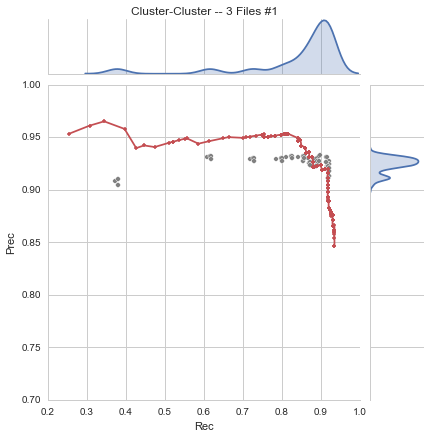

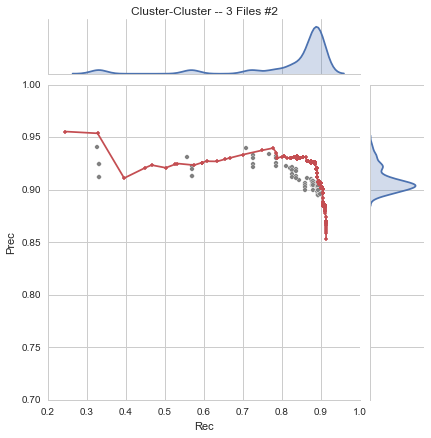

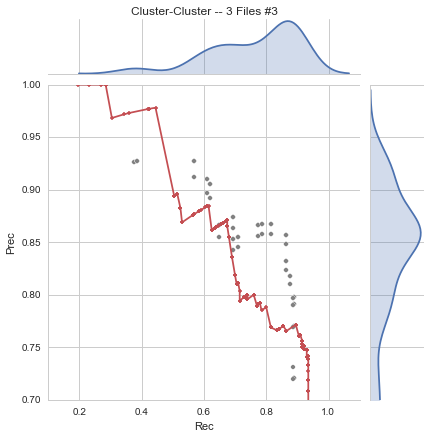

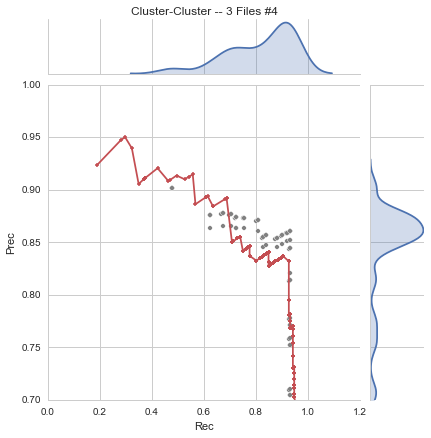

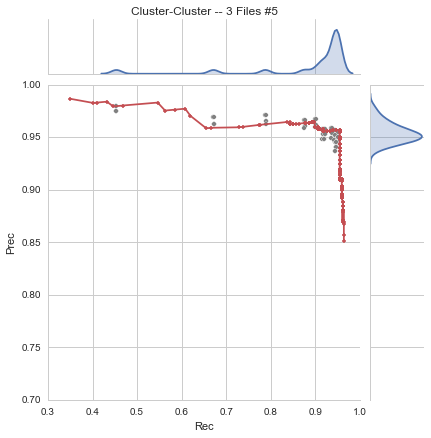

In [53]:
plot_scatter(exp_results_3b, 0, match_cluster_3a, 'Cluster-Cluster -- 3 Files #1')
plot_scatter(exp_results_3b, 1, match_cluster_3b, 'Cluster-Cluster -- 3 Files #2')
plot_scatter(exp_results_3b, 2, match_cluster_3c, 'Cluster-Cluster -- 3 Files #3')
plot_scatter(exp_results_3b, 3, match_cluster_3d, 'Cluster-Cluster -- 3 Files #4')
plot_scatter(exp_results_3b, 4, match_cluster_3e, 'Cluster-Cluster -- 3 Files #5')

<h2>7. Run experiment on sets of 4 files</h2>

In [54]:
n_files = 4
n_iter = 5

In [55]:
training_list_4 = load_or_create_filelist('pickles/beer1pos/training_list_4.p', combined_list, n_iter, n_files)

['std1-file5.txt', 'std1-file10.txt', 'std1-file6.txt', 'std1-file2.txt']
['std1-file8.txt', 'std1-file5.txt', 'std1-file11.txt', 'std1-file3.txt']
['std1-file2.txt', 'std1-file9.txt', 'std1-file7.txt', 'std1-file11.txt']
['std1-file8.txt', 'std1-file3.txt', 'std1-file2.txt', 'std1-file9.txt']
['std1-file6.txt', 'std1-file5.txt', 'std1-file2.txt', 'std1-file8.txt']
Saved to pickles/beer1pos/training_list_4.p


In [56]:
testing_list_4 = load_or_create_filelist('pickles/beer1pos/testing_list_4.p', combined_list, n_iter, n_files)

['std1-file8.txt', 'std1-file6.txt', 'std1-file9.txt', 'std1-file4.txt']
['std1-file8.txt', 'std1-file5.txt', 'std1-file10.txt', 'std1-file3.txt']
['std1-file10.txt', 'std1-file5.txt', 'std1-file4.txt', 'std1-file6.txt']
['std1-file8.txt', 'std1-file7.txt', 'std1-file2.txt', 'std1-file3.txt']
['std1-file3.txt', 'std1-file10.txt', 'std1-file11.txt', 'std1-file7.txt']
Saved to pickles/beer1pos/testing_list_4.p


In [57]:
exp_results_4a = run_experiment(0, training_list_4, testing_list_4, param_list, 'pickles/beer1pos/res_match_feature_4.p', hp, evaluation_method, transformation_file, gt_file)

Iteration 0
Training on ['std1-file5.txt', 'std1-file10.txt', 'std1-file6.txt', 'std1-file2.txt']
mass_tol=2, rt_tol=5, tp=293, fp=29, fn=564, prec=0.910, rec=0.342, f1=0.497, th_prob=1.000
mass_tol=2, rt_tol=10, tp=489, fp=56, fn=368, prec=0.897, rec=0.571, f1=0.698, th_prob=1.000
mass_tol=2, rt_tol=15, tp=660, fp=73, fn=197, prec=0.900, rec=0.770, f1=0.830, th_prob=1.000
mass_tol=2, rt_tol=20, tp=715, fp=86, fn=142, prec=0.893, rec=0.834, f1=0.862, th_prob=1.000
mass_tol=2, rt_tol=25, tp=753, fp=85, fn=104, prec=0.899, rec=0.879, f1=0.888, th_prob=1.000
mass_tol=2, rt_tol=30, tp=776, fp=88, fn=81, prec=0.898, rec=0.905, f1=0.902, th_prob=1.000
mass_tol=2, rt_tol=35, tp=779, fp=90, fn=78, prec=0.896, rec=0.909, f1=0.903, th_prob=1.000
mass_tol=2, rt_tol=40, tp=782, fp=91, fn=75, prec=0.896, rec=0.912, f1=0.904, th_prob=1.000
mass_tol=2, rt_tol=45, tp=784, fp=91, fn=73, prec=0.896, rec=0.915, f1=0.905, th_prob=1.000
mass_tol=2, rt_tol=50, tp=784, fp=91, fn=73, prec=0.896, rec=0.915, f1

In [58]:
exp_results_4b = run_experiment(1, training_list_4, testing_list_4, param_list, 'pickles/beer1pos/res_match_cluster_4.p', hp, evaluation_method, transformation_file, gt_file)

Iteration 0
Training on ['std1-file5.txt', 'std1-file10.txt', 'std1-file6.txt', 'std1-file2.txt']
mass_tol=2, rt_tol=5, tp=294, fp=18, fn=563, prec=0.942, rec=0.343, f1=0.503, th_prob=1.000
mass_tol=2, rt_tol=10, tp=508, fp=39, fn=349, prec=0.929, rec=0.593, f1=0.724, th_prob=1.000
mass_tol=2, rt_tol=15, tp=684, fp=51, fn=173, prec=0.931, rec=0.798, f1=0.859, th_prob=1.000
mass_tol=2, rt_tol=20, tp=744, fp=57, fn=113, prec=0.929, rec=0.868, f1=0.897, th_prob=1.000
mass_tol=2, rt_tol=25, tp=770, fp=58, fn=87, prec=0.930, rec=0.898, f1=0.914, th_prob=1.000
mass_tol=2, rt_tol=30, tp=795, fp=59, fn=62, prec=0.931, rec=0.928, f1=0.929, th_prob=1.000
mass_tol=2, rt_tol=35, tp=798, fp=62, fn=59, prec=0.928, rec=0.931, f1=0.930, th_prob=1.000
mass_tol=2, rt_tol=40, tp=801, fp=62, fn=56, prec=0.928, rec=0.935, f1=0.931, th_prob=1.000
mass_tol=2, rt_tol=45, tp=803, fp=62, fn=54, prec=0.928, rec=0.937, f1=0.933, th_prob=1.000
mass_tol=2, rt_tol=50, tp=803, fp=62, fn=54, prec=0.928, rec=0.937, f1=

In [59]:
match_cluster_4a = second_stage_clustering(hp, training_list_4, 0)

Iteration 0
Training on ['std1-file5.txt', 'std1-file10.txt', 'std1-file6.txt', 'std1-file2.txt']
n 0	cluster_list=8	last_K = 7
n 1	cluster_list=1	last_K = 1
n 2	cluster_list=1	last_K = 1
n 3	cluster_list=3	last_K = 3
n 4	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done   2 jobs       | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done   5 jobs       | elapsed:    4.3s


n 5	cluster_list=17	last_K = 10
n 6	cluster_list=1	last_K = 1
n 7	cluster_list=3	last_K = 2
n 8	cluster_list=6	last_K = 3
n 9	cluster_list=4	last_K = 1
n 10	cluster_list=2	last_K = 2
n 11	cluster_list=1	last_K = 1
n 12	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done   8 jobs       | elapsed:   13.6s
[Parallel(n_jobs=1)]: Done  13 jobs       | elapsed:   16.8s


n 13	cluster_list=1	last_K = 1
n 14	cluster_list=12	last_K = 5
n 15	cluster_list=1	last_K = 1
n 16	cluster_list=1	last_K = 1
n 17	cluster_list=1	last_K = 1
n 18	cluster_list=1	last_K = 1
n 19	cluster_list=1	last_K = 1
n 20	cluster_list=2	last_K = 2
n 21	cluster_list=9	last_K = 7
n 22	cluster_list=1	last_K = 1
n 23	cluster_list=2	last_K = 1
n 24	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  18 jobs       | elapsed:   21.0s
[Parallel(n_jobs=1)]: Done  25 jobs       | elapsed:   25.8s


n 25	cluster_list=1	last_K = 1
n 26	cluster_list=5	last_K = 4
n 27	cluster_list=6	last_K = 2
n 28	cluster_list=1	last_K = 1
n 29	cluster_list=2	last_K = 2
n 30	cluster_list=1	last_K = 1
n 31	cluster_list=1	last_K = 1
n 32	cluster_list=1	last_K = 1
n 33	cluster_list=2	last_K = 1
n 34	cluster_list=1	last_K = 1
n 35	cluster_list=2	last_K = 1
n 36	cluster_list=1	last_K = 1
n 37	cluster_list=2	last_K = 1
n 38	cluster_list=1	last_K = 1
n 39	cluster_list=4	last_K = 4
n 40	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:   29.7s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:   32.6s


n 41	cluster_list=1	last_K = 1
n 42	cluster_list=2	last_K = 1
n 43	cluster_list=1	last_K = 1
n 44	cluster_list=2	last_K = 2
n 45	cluster_list=12	last_K = 4
n 46	cluster_list=1	last_K = 1
n 47	cluster_list=1	last_K = 1
n 48	cluster_list=3	last_K = 2
n 49	cluster_list=2	last_K = 1
n 50	cluster_list=1	last_K = 1
n 51	cluster_list=1	last_K = 1
n 52	cluster_list=1	last_K = 1
n 53	cluster_list=1	last_K = 1
n 54	cluster_list=2	last_K = 1
n 55	cluster_list=1	last_K = 1
n 56	cluster_list=1	last_K = 1
n 57	cluster_list=27	last_K = 18
n 58	cluster_list=1	last_K = 1
n 59	cluster_list=1	last_K = 1
n 60	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:   38.6s
[Parallel(n_jobs=1)]: Done  61 jobs       | elapsed:   59.0s


n 61	cluster_list=2	last_K = 1
n 62	cluster_list=1	last_K = 1
n 63	cluster_list=16	last_K = 16
n 64	cluster_list=1	last_K = 1
n 65	cluster_list=1	last_K = 1
n 66	cluster_list=1	last_K = 1
n 67	cluster_list=5	last_K = 3
n 68	cluster_list=1	last_K = 1
n 69	cluster_list=1	last_K = 1
n 70	cluster_list=9	last_K = 3
n 71	cluster_list=11	last_K = 11
n 72	cluster_list=1	last_K = 1
n 73	cluster_list=1	last_K = 1
n 74	cluster_list=1	last_K = 1
n 75	cluster_list=1	last_K = 1
n 76	cluster_list=1	last_K = 1
n 77	cluster_list=10	last_K = 9
n 78	cluster_list=2	last_K = 1
n 79	cluster_list=1	last_K = 1
n 80	cluster_list=1	last_K = 1
n 81	cluster_list=1	last_K = 1
n 82	cluster_list=41	last_K = 18
n 83	cluster_list=3	last_K = 1
n 84	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  72 jobs       | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  85 jobs       | elapsed:  1.9min


n 85	cluster_list=1	last_K = 1
n 86	cluster_list=1	last_K = 1
n 87	cluster_list=1	last_K = 1
n 88	cluster_list=1	last_K = 1
n 89	cluster_list=1	last_K = 1
n 90	cluster_list=1	last_K = 1
n 91	cluster_list=1	last_K = 1
n 92	cluster_list=6	last_K = 2
n 93	cluster_list=1	last_K = 1
n 94	cluster_list=1	last_K = 1
n 95	cluster_list=16	last_K = 13
n 96	cluster_list=2	last_K = 1
n 97	cluster_list=7	last_K = 3
n 98	cluster_list=2	last_K = 2
n 99	cluster_list=1	last_K = 1
n 100	cluster_list=11	last_K = 9
n 101	cluster_list=1	last_K = 1
n 102	cluster_list=1	last_K = 1
n 103	cluster_list=1	last_K = 1
n 104	cluster_list=20	last_K = 13
n 105	cluster_list=1	last_K = 1
n 106	cluster_list=1	last_K = 1
n 107	cluster_list=1	last_K = 1
n 108	cluster_list=3	last_K = 2
n 109	cluster_list=3	last_K = 2
n 110	cluster_list=2	last_K = 1
n 111	cluster_list=9	last_K = 9
n 112	cluster_list=2	last_K = 2


[Parallel(n_jobs=1)]: Done  98 jobs       | elapsed:  2.2min
[Parallel(n_jobs=1)]: Done 113 jobs       | elapsed:  2.6min


n 113	cluster_list=4	last_K = 4
n 114	cluster_list=1	last_K = 1
n 115	cluster_list=1	last_K = 1
n 116	cluster_list=1	last_K = 1
n 117	cluster_list=2	last_K = 2
n 118	cluster_list=1	last_K = 1
n 119	cluster_list=1	last_K = 1
n 120	cluster_list=1	last_K = 1
n 121	cluster_list=2	last_K = 1
n 122	cluster_list=1	last_K = 1
n 123	cluster_list=1	last_K = 1
n 124	cluster_list=1	last_K = 1
n 125	cluster_list=1	last_K = 1
n 126	cluster_list=1	last_K = 1
n 127	cluster_list=1	last_K = 1
n 128	cluster_list=1	last_K = 1
n 129	cluster_list=1	last_K = 1
n 130	cluster_list=1	last_K = 1
n 131	cluster_list=4	last_K = 1
n 132	cluster_list=2	last_K = 1
n 133	cluster_list=1	last_K = 1
n 134	cluster_list=1	last_K = 1
n 135	cluster_list=2	last_K = 1
n 136	cluster_list=9	last_K = 7
n 137	cluster_list=5	last_K = 5
n 138	cluster_list=1	last_K = 1
n 139	cluster_list=1	last_K = 1
n 140	cluster_list=1	last_K = 1
n 141	cluster_list=1	last_K = 1
n 142	cluster_list=1	last_K = 1
n 143	cluster_list=4	last_K = 1
n 144	cl

[Parallel(n_jobs=1)]: Done 128 jobs       | elapsed:  2.6min
[Parallel(n_jobs=1)]: Done 145 jobs       | elapsed:  2.8min


n 145	cluster_list=1	last_K = 1
n 146	cluster_list=1	last_K = 1
n 147	cluster_list=1	last_K = 1
n 148	cluster_list=2	last_K = 2
n 149	cluster_list=1	last_K = 1
n 150	cluster_list=4	last_K = 4
n 151	cluster_list=4	last_K = 4
n 152	cluster_list=3	last_K = 2
n 153	cluster_list=1	last_K = 1
n 154	cluster_list=1	last_K = 1
n 155	cluster_list=1	last_K = 1
n 156	cluster_list=1	last_K = 1
n 157	cluster_list=2	last_K = 2
n 158	cluster_list=1	last_K = 1
n 159	cluster_list=1	last_K = 1
n 160	cluster_list=1	last_K = 1
n 161	cluster_list=1	last_K = 1
n 162	cluster_list=1	last_K = 1
n 163	cluster_list=2	last_K = 2
n 164	cluster_list=13	last_K = 10
n 165	cluster_list=1	last_K = 1
n 166	cluster_list=5	last_K = 2
n 167	cluster_list=1	last_K = 1
n 168	cluster_list=1	last_K = 1
n 169	cluster_list=2	last_K = 1
n 170	cluster_list=1	last_K = 1
n 171	cluster_list=8	last_K = 8
n 172	cluster_list=1	last_K = 1
n 173	cluster_list=1	last_K = 1
n 174	cluster_list=2	last_K = 1
n 175	cluster_list=1	last_K = 1
n 176	

[Parallel(n_jobs=1)]: Done 162 jobs       | elapsed:  2.8min
[Parallel(n_jobs=1)]: Done 181 jobs       | elapsed:  3.1min


n 181	cluster_list=1	last_K = 1
n 182	cluster_list=2	last_K = 2
n 183	cluster_list=5	last_K = 2
n 184	cluster_list=1	last_K = 1
n 185	cluster_list=1	last_K = 1
n 186	cluster_list=2	last_K = 2
n 187	cluster_list=1	last_K = 1
n 188	cluster_list=32	last_K = 24
n 189	cluster_list=1	last_K = 1
n 190	cluster_list=2	last_K = 2
n 191	cluster_list=2	last_K = 1
n 192	cluster_list=1	last_K = 1
n 193	cluster_list=1	last_K = 1
n 194	cluster_list=1	last_K = 1
n 195	cluster_list=2	last_K = 1
n 196	cluster_list=7	last_K = 7
n 197	cluster_list=4	last_K = 1
n 198	cluster_list=2	last_K = 1
n 199	cluster_list=11	last_K = 4
n 200	cluster_list=6	last_K = 2
n 201	cluster_list=1	last_K = 1
n 202	cluster_list=1	last_K = 1
n 203	cluster_list=1	last_K = 1
n 204	cluster_list=1	last_K = 1
n 205	cluster_list=1	last_K = 1
n 206	cluster_list=1	last_K = 1
n 207	cluster_list=1	last_K = 1
n 208	cluster_list=1	last_K = 1
n 209	cluster_list=3	last_K = 2
n 210	cluster_list=1	last_K = 1
n 211	cluster_list=3	last_K = 2
n 212

[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:  3.8min
[Parallel(n_jobs=1)]: Done 221 jobs       | elapsed:  5.0min


n 221	cluster_list=1	last_K = 1
n 222	cluster_list=1	last_K = 1
n 223	cluster_list=1	last_K = 1
n 224	cluster_list=1	last_K = 1
n 225	cluster_list=1	last_K = 1
n 226	cluster_list=1	last_K = 1
n 227	cluster_list=1	last_K = 1
n 228	cluster_list=2	last_K = 1
n 229	cluster_list=1	last_K = 1
n 230	cluster_list=1	last_K = 1
n 231	cluster_list=1	last_K = 1
n 232	cluster_list=1	last_K = 1
n 233	cluster_list=1	last_K = 1
n 234	cluster_list=4	last_K = 3
n 235	cluster_list=2	last_K = 1
n 236	cluster_list=29	last_K = 17
n 237	cluster_list=1	last_K = 1
n 238	cluster_list=10	last_K = 9
n 239	cluster_list=1	last_K = 1
n 240	cluster_list=2	last_K = 2
n 241	cluster_list=3	last_K = 3
n 242	cluster_list=1	last_K = 1
n 243	cluster_list=2	last_K = 2
n 244	cluster_list=2	last_K = 2
n 245	cluster_list=3	last_K = 3
n 246	cluster_list=2	last_K = 2
n 247	cluster_list=5	last_K = 4
n 248	cluster_list=3	last_K = 3
n 249	cluster_list=1	last_K = 1
n 250	cluster_list=2	last_K = 2
n 251	cluster_list=2	last_K = 2
n 252

[Parallel(n_jobs=1)]: Done 242 jobs       | elapsed:  5.4min
[Parallel(n_jobs=1)]: Done 265 jobs       | elapsed:  5.8min


n 265	cluster_list=1	last_K = 1
n 266	cluster_list=2	last_K = 2
n 267	cluster_list=1	last_K = 1
n 268	cluster_list=1	last_K = 1
n 269	cluster_list=2	last_K = 2
n 270	cluster_list=1	last_K = 1
n 271	cluster_list=2	last_K = 2
n 272	cluster_list=6	last_K = 6
n 273	cluster_list=1	last_K = 1
n 274	cluster_list=4	last_K = 4
n 275	cluster_list=4	last_K = 4
n 276	cluster_list=1	last_K = 1
n 277	cluster_list=4	last_K = 4
n 278	cluster_list=10	last_K = 9
n 279	cluster_list=3	last_K = 3
n 280	cluster_list=1	last_K = 1
n 281	cluster_list=2	last_K = 2
n 282	cluster_list=3	last_K = 3
n 283	cluster_list=13	last_K = 10
n 284	cluster_list=12	last_K = 12
n 285	cluster_list=13	last_K = 10
n 286	cluster_list=6	last_K = 6
n 287	cluster_list=5	last_K = 5
n 288	cluster_list=1	last_K = 1
n 289	cluster_list=17	last_K = 12
n 290	cluster_list=11	last_K = 9
n 291	cluster_list=1	last_K = 1
n 292	cluster_list=4	last_K = 4
n 293	cluster_list=1	last_K = 1
n 294	cluster_list=7	last_K = 7
n 295	cluster_list=2	last_K = 

[Parallel(n_jobs=1)]: Done 288 jobs       | elapsed:  6.4min
[Parallel(n_jobs=1)]: Done 313 jobs       | elapsed:  8.0min


n 313	cluster_list=5	last_K = 5
n 314	cluster_list=2	last_K = 2
n 315	cluster_list=1	last_K = 1
n 316	cluster_list=1	last_K = 1
n 317	cluster_list=3	last_K = 3
n 318	cluster_list=1	last_K = 1
n 319	cluster_list=1	last_K = 1
n 320	cluster_list=1	last_K = 1
n 321	cluster_list=1	last_K = 1
n 322	cluster_list=2	last_K = 2
n 323	cluster_list=3	last_K = 3
n 324	cluster_list=2	last_K = 2
n 325	cluster_list=8	last_K = 6
n 326	cluster_list=2	last_K = 1
n 327	cluster_list=1	last_K = 1
n 328	cluster_list=1	last_K = 1
n 329	cluster_list=1	last_K = 1
n 330	cluster_list=1	last_K = 1
n 331	cluster_list=2	last_K = 2
n 332	cluster_list=2	last_K = 2
n 333	cluster_list=1	last_K = 1
n 334	cluster_list=1	last_K = 1
n 335	cluster_list=1	last_K = 1
n 336	cluster_list=1	last_K = 1
n 337	cluster_list=1	last_K = 1
n 338	cluster_list=1	last_K = 1
n 339	cluster_list=2	last_K = 2
n 340	cluster_list=1	last_K = 1
n 341	cluster_list=2	last_K = 2
n 342	cluster_list=3	last_K = 3
n 343	cluster_list=3	last_K = 3
n 344	cl

[Parallel(n_jobs=1)]: Done 338 jobs       | elapsed:  8.2min
[Parallel(n_jobs=1)]: Done 365 jobs       | elapsed:  9.7min


n 365	cluster_list=7	last_K = 5
n 366	cluster_list=6	last_K = 6
n 367	cluster_list=1	last_K = 1
n 368	cluster_list=33	last_K = 24
n 369	cluster_list=10	last_K = 6
n 370	cluster_list=1	last_K = 1
n 371	cluster_list=15	last_K = 10
n 372	cluster_list=2	last_K = 2
n 373	cluster_list=31	last_K = 23
n 374	cluster_list=2	last_K = 2
n 375	cluster_list=1	last_K = 1
n 376	cluster_list=14	last_K = 10
n 377	cluster_list=3	last_K = 3
n 378	cluster_list=8	last_K = 7
n 379	cluster_list=10	last_K = 8
n 380	cluster_list=1	last_K = 1
n 381	cluster_list=4	last_K = 4
n 382	cluster_list=10	last_K = 7
n 383	cluster_list=4	last_K = 3
n 384	cluster_list=1	last_K = 1
n 385	cluster_list=2	last_K = 2
n 386	cluster_list=2	last_K = 2
n 387	cluster_list=1	last_K = 1
n 388	cluster_list=5	last_K = 5
n 389	cluster_list=2	last_K = 2
n 390	cluster_list=3	last_K = 3
n 391	cluster_list=3	last_K = 3
n 392	cluster_list=2	last_K = 2
n 393	cluster_list=1	last_K = 1
n 394	cluster_list=1	last_K = 1
n 395	cluster_list=4	last_K =

[Parallel(n_jobs=1)]: Done 392 jobs       | elapsed: 11.4min
[Parallel(n_jobs=1)]: Done 421 jobs       | elapsed: 11.5min


n 421	cluster_list=1	last_K = 1
n 422	cluster_list=1	last_K = 1
n 423	cluster_list=9	last_K = 4
n 424	cluster_list=2	last_K = 1
n 425	cluster_list=2	last_K = 2
n 426	cluster_list=1	last_K = 1
n 427	cluster_list=2	last_K = 2
n 428	cluster_list=1	last_K = 1
n 429	cluster_list=1	last_K = 1
n 430	cluster_list=1	last_K = 1
n 431	cluster_list=1	last_K = 1
n 432	cluster_list=1	last_K = 1
n 433	cluster_list=2	last_K = 2
n 434	cluster_list=1	last_K = 1
n 435	cluster_list=2	last_K = 2
n 436	cluster_list=1	last_K = 1
n 437	cluster_list=1	last_K = 1
n 438	cluster_list=1	last_K = 1
n 439	cluster_list=1	last_K = 1
n 440	cluster_list=1	last_K = 1
n 441	cluster_list=4	last_K = 1
n 442	cluster_list=1	last_K = 1
n 443	cluster_list=2	last_K = 2
n 444	cluster_list=1	last_K = 1
n 445	cluster_list=6	last_K = 2
n 446	cluster_list=3	last_K = 1
n 447	cluster_list=1	last_K = 1
n 448	cluster_list=2	last_K = 1
n 449	cluster_list=1	last_K = 1
n 450	cluster_list=1	last_K = 1
n 451	cluster_list=1	last_K = 1
n 452	cl

[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed: 11.7min
[Parallel(n_jobs=1)]: Done 481 jobs       | elapsed: 11.9min


n 481	cluster_list=1	last_K = 1
n 482	cluster_list=2	last_K = 1
n 483	cluster_list=2	last_K = 1
n 484	cluster_list=1	last_K = 1
n 485	cluster_list=1	last_K = 1
n 486	cluster_list=1	last_K = 1
n 487	cluster_list=2	last_K = 2
n 488	cluster_list=17	last_K = 15
n 489	cluster_list=8	last_K = 3
n 490	cluster_list=2	last_K = 1
n 491	cluster_list=2	last_K = 2
n 492	cluster_list=1	last_K = 1
n 493	cluster_list=1	last_K = 1
n 494	cluster_list=9	last_K = 9
n 495	cluster_list=6	last_K = 3
n 496	cluster_list=1	last_K = 1
n 497	cluster_list=5	last_K = 2
n 498	cluster_list=1	last_K = 1
n 499	cluster_list=1	last_K = 1
n 500	cluster_list=1	last_K = 1
n 501	cluster_list=1	last_K = 1
n 502	cluster_list=1	last_K = 1
n 503	cluster_list=2	last_K = 1
n 504	cluster_list=1	last_K = 1
n 505	cluster_list=1	last_K = 1
n 506	cluster_list=1	last_K = 1
n 507	cluster_list=1	last_K = 1
n 508	cluster_list=2	last_K = 2
n 509	cluster_list=1	last_K = 1
n 510	cluster_list=1	last_K = 1
n 511	cluster_list=28	last_K = 19
n 51

[Parallel(n_jobs=1)]: Done 512 jobs       | elapsed: 12.6min
[Parallel(n_jobs=1)]: Done 545 jobs       | elapsed: 13.1min


n 545	cluster_list=1	last_K = 1
n 546	cluster_list=1	last_K = 1
n 547	cluster_list=1	last_K = 1
n 548	cluster_list=1	last_K = 1
n 549	cluster_list=3	last_K = 1
n 550	cluster_list=1	last_K = 1
n 551	cluster_list=4	last_K = 1
n 552	cluster_list=2	last_K = 1
n 553	cluster_list=2	last_K = 1
n 554	cluster_list=1	last_K = 1
n 555	cluster_list=7	last_K = 4
n 556	cluster_list=24	last_K = 13
n 557	cluster_list=1	last_K = 1
n 558	cluster_list=1	last_K = 1
n 559	cluster_list=3	last_K = 2
n 560	cluster_list=1	last_K = 1
n 561	cluster_list=1	last_K = 1
n 562	cluster_list=2	last_K = 2
n 563	cluster_list=1	last_K = 1
n 564	cluster_list=1	last_K = 1
n 565	cluster_list=1	last_K = 1
n 566	cluster_list=1	last_K = 1
n 567	cluster_list=1	last_K = 1
n 568	cluster_list=2	last_K = 1
n 569	cluster_list=1	last_K = 1
n 570	cluster_list=1	last_K = 1
n 571	cluster_list=28	last_K = 15
n 572	cluster_list=1	last_K = 1
n 573	cluster_list=1	last_K = 1
n 574	cluster_list=1	last_K = 1
n 575	cluster_list=1	last_K = 1
n 57

[Parallel(n_jobs=1)]: Done 578 jobs       | elapsed: 13.7min
[Parallel(n_jobs=1)]: Done 613 jobs       | elapsed: 14.8min


n 613	cluster_list=5	last_K = 5
n 614	cluster_list=39	last_K = 18
n 615	cluster_list=1	last_K = 1
n 616	cluster_list=2	last_K = 1
n 617	cluster_list=1	last_K = 1
n 618	cluster_list=1	last_K = 1
n 619	cluster_list=1	last_K = 1
n 620	cluster_list=1	last_K = 1
n 621	cluster_list=1	last_K = 1
n 622	cluster_list=1	last_K = 1
n 623	cluster_list=1	last_K = 1
n 624	cluster_list=2	last_K = 2
n 625	cluster_list=2	last_K = 1
n 626	cluster_list=1	last_K = 1
n 627	cluster_list=3	last_K = 1
n 628	cluster_list=1	last_K = 1
n 629	cluster_list=2	last_K = 1
n 630	cluster_list=1	last_K = 1
n 631	cluster_list=1	last_K = 1
n 632	cluster_list=2	last_K = 1
n 633	cluster_list=2	last_K = 1
n 634	cluster_list=40	last_K = 24
n 635	cluster_list=6	last_K = 3
n 636	cluster_list=14	last_K = 9
n 637	cluster_list=4	last_K = 4
n 638	cluster_list=49	last_K = 23
n 639	cluster_list=6	last_K = 6
n 640	cluster_list=8	last_K = 5
n 641	cluster_list=5	last_K = 5
n 642	cluster_list=2	last_K = 2
n 643	cluster_list=2	last_K = 1
n

[Parallel(n_jobs=1)]: Done 648 jobs       | elapsed: 17.0min
[Parallel(n_jobs=1)]: Done 685 jobs       | elapsed: 17.2min


n 685	cluster_list=1	last_K = 1
n 686	cluster_list=1	last_K = 1
n 687	cluster_list=1	last_K = 1
n 688	cluster_list=3	last_K = 1
n 689	cluster_list=1	last_K = 1
n 690	cluster_list=3	last_K = 2
n 691	cluster_list=1	last_K = 1
n 692	cluster_list=15	last_K = 12
n 693	cluster_list=1	last_K = 1
n 694	cluster_list=1	last_K = 1
n 695	cluster_list=1	last_K = 1
n 696	cluster_list=9	last_K = 8
n 697	cluster_list=44	last_K = 18
n 698	cluster_list=4	last_K = 2
n 699	cluster_list=2	last_K = 1
n 700	cluster_list=2	last_K = 1
n 701	cluster_list=1	last_K = 1
n 702	cluster_list=3	last_K = 2
n 703	cluster_list=2	last_K = 1
n 704	cluster_list=1	last_K = 1
n 705	cluster_list=1	last_K = 1
n 706	cluster_list=1	last_K = 1
n 707	cluster_list=1	last_K = 1
n 708	cluster_list=1	last_K = 1
n 709	cluster_list=3	last_K = 1
n 710	cluster_list=2	last_K = 1
n 711	cluster_list=1	last_K = 1
n 712	cluster_list=1	last_K = 1
n 713	cluster_list=1	last_K = 1
n 714	cluster_list=1	last_K = 1
n 715	cluster_list=3	last_K = 1
n 71

[Parallel(n_jobs=1)]: Done 722 jobs       | elapsed: 18.6min
[Parallel(n_jobs=1)]: Done 761 jobs       | elapsed: 19.0min


n 761	cluster_list=1	last_K = 1
n 762	cluster_list=1	last_K = 1
n 763	cluster_list=1	last_K = 1
n 764	cluster_list=1	last_K = 1
n 765	cluster_list=2	last_K = 2
n 766	cluster_list=1	last_K = 1
n 767	cluster_list=1	last_K = 1
n 768	cluster_list=2	last_K = 2
n 769	cluster_list=1	last_K = 1
n 770	cluster_list=1	last_K = 1
n 771	cluster_list=1	last_K = 1
n 772	cluster_list=1	last_K = 1
n 773	cluster_list=1	last_K = 1
n 774	cluster_list=1	last_K = 1
n 775	cluster_list=1	last_K = 1
n 776	cluster_list=1	last_K = 1
n 777	cluster_list=1	last_K = 1
n 778	cluster_list=1	last_K = 1
n 779	cluster_list=1	last_K = 1
n 780	cluster_list=1	last_K = 1
n 781	cluster_list=1	last_K = 1
n 782	cluster_list=1	last_K = 1
n 783	cluster_list=1	last_K = 1
n 784	cluster_list=1	last_K = 1
n 785	cluster_list=1	last_K = 1
n 786	cluster_list=1	last_K = 1
n 787	cluster_list=1	last_K = 1
n 788	cluster_list=1	last_K = 1
n 789	cluster_list=1	last_K = 1
n 790	cluster_list=1	last_K = 1
n 791	cluster_list=1	last_K = 1
n 792	cl

[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed: 19.0min
[Parallel(n_jobs=1)]: Done 841 jobs       | elapsed: 19.0min


n 841	cluster_list=1	last_K = 1
n 842	cluster_list=1	last_K = 1
n 843	cluster_list=1	last_K = 1
n 844	cluster_list=1	last_K = 1
n 845	cluster_list=1	last_K = 1
n 846	cluster_list=1	last_K = 1
n 847	cluster_list=1	last_K = 1
n 848	cluster_list=1	last_K = 1
n 849	cluster_list=1	last_K = 1
n 850	cluster_list=1	last_K = 1
n 851	cluster_list=1	last_K = 1
n 852	cluster_list=1	last_K = 1
n 853	cluster_list=1	last_K = 1
n 854	cluster_list=1	last_K = 1
n 855	cluster_list=1	last_K = 1
n 856	cluster_list=1	last_K = 1
n 857	cluster_list=1	last_K = 1
n 858	cluster_list=1	last_K = 1
n 859	cluster_list=1	last_K = 1
n 860	cluster_list=1	last_K = 1
n 861	cluster_list=1	last_K = 1
n 862	cluster_list=1	last_K = 1
n 863	cluster_list=1	last_K = 1
n 864	cluster_list=1	last_K = 1
n 865	cluster_list=1	last_K = 1
n 866	cluster_list=1	last_K = 1
n 867	cluster_list=1	last_K = 1
n 868	cluster_list=1	last_K = 1
n 869	cluster_list=1	last_K = 1
n 870	cluster_list=1	last_K = 1
n 871	cluster_list=1	last_K = 1
n 872	cl

[Parallel(n_jobs=1)]: Done 882 jobs       | elapsed: 19.0min
[Parallel(n_jobs=1)]: Done 925 jobs       | elapsed: 19.2min


n 925	cluster_list=1	last_K = 1
n 926	cluster_list=1	last_K = 1
n 927	cluster_list=1	last_K = 1
n 928	cluster_list=2	last_K = 1
n 929	cluster_list=1	last_K = 1
n 930	cluster_list=1	last_K = 1
n 931	cluster_list=2	last_K = 1
n 932	cluster_list=1	last_K = 1
n 933	cluster_list=3	last_K = 2
n 934	cluster_list=4	last_K = 2
n 935	cluster_list=2	last_K = 1
n 936	cluster_list=2	last_K = 1
n 937	cluster_list=2	last_K = 1
n 938	cluster_list=1	last_K = 1
n 939	cluster_list=1	last_K = 1
n 940	cluster_list=18	last_K = 11
n 941	cluster_list=2	last_K = 1
n 942	cluster_list=4	last_K = 1
n 943	cluster_list=2	last_K = 1
n 944	cluster_list=1	last_K = 1
n 945	cluster_list=1	last_K = 1
n 946	cluster_list=3	last_K = 1
n 947	cluster_list=1	last_K = 1
n 948	cluster_list=3	last_K = 1
n 949	cluster_list=1	last_K = 1
n 950	cluster_list=1	last_K = 1
n 951	cluster_list=1	last_K = 1
n 952	cluster_list=2	last_K = 1
n 953	cluster_list=1	last_K = 1
n 954	cluster_list=1	last_K = 1
n 955	cluster_list=1	last_K = 1
n 956	

[Parallel(n_jobs=1)]: Done 968 jobs       | elapsed: 19.6min
[Parallel(n_jobs=1)]: Done 1013 jobs       | elapsed: 19.6min


n 1013	cluster_list=2	last_K = 1
n 1014	cluster_list=1	last_K = 1
n 1015	cluster_list=1	last_K = 1
n 1016	cluster_list=1	last_K = 1
n 1017	cluster_list=1	last_K = 1
n 1018	cluster_list=2	last_K = 1
n 1019	cluster_list=2	last_K = 1
n 1020	cluster_list=1	last_K = 1
n 1021	cluster_list=1	last_K = 1
n 1022	cluster_list=1	last_K = 1
n 1023	cluster_list=1	last_K = 1
n 1024	cluster_list=1	last_K = 1
n 1025	cluster_list=1	last_K = 1
n 1026	cluster_list=1	last_K = 1
n 1027	cluster_list=1	last_K = 1
n 1028	cluster_list=2	last_K = 1
n 1029	cluster_list=1	last_K = 1
n 1030	cluster_list=1	last_K = 1
n 1031	cluster_list=1	last_K = 1
n 1032	cluster_list=1	last_K = 1
n 1033	cluster_list=1	last_K = 1
n 1034	cluster_list=1	last_K = 1
n 1035	cluster_list=1	last_K = 1
n 1036	cluster_list=1	last_K = 1
n 1037	cluster_list=2	last_K = 1
n 1038	cluster_list=1	last_K = 1
n 1039	cluster_list=1	last_K = 1
n 1040	cluster_list=1	last_K = 1
n 1041	cluster_list=2	last_K = 1
n 1042	cluster_list=2	last_K = 1
n 1043	clu

[Parallel(n_jobs=1)]: Done 1058 jobs       | elapsed: 19.7min
[Parallel(n_jobs=1)]: Done 1105 jobs       | elapsed: 20.9min


n 1105	cluster_list=1	last_K = 1
n 1106	cluster_list=1	last_K = 1
n 1107	cluster_list=9	last_K = 6
n 1108	cluster_list=2	last_K = 2
n 1109	cluster_list=1	last_K = 1
n 1110	cluster_list=1	last_K = 1
n 1111	cluster_list=1	last_K = 1
n 1112	cluster_list=6	last_K = 5
n 1113	cluster_list=2	last_K = 2
n 1114	cluster_list=2	last_K = 2
n 1115	cluster_list=1	last_K = 1
n 1116	cluster_list=1	last_K = 1
n 1117	cluster_list=3	last_K = 3
n 1118	cluster_list=3	last_K = 2
n 1119	cluster_list=5	last_K = 3
n 1120	cluster_list=1	last_K = 1
n 1121	cluster_list=3	last_K = 3
n 1122	cluster_list=1	last_K = 1
n 1123	cluster_list=1	last_K = 1
n 1124	cluster_list=2	last_K = 2
n 1125	cluster_list=2	last_K = 2
n 1126	cluster_list=1	last_K = 1
n 1127	cluster_list=3	last_K = 2
n 1128	cluster_list=4	last_K = 1
n 1129	cluster_list=1	last_K = 1
n 1130	cluster_list=5	last_K = 2
n 1131	cluster_list=1	last_K = 1
n 1132	cluster_list=1	last_K = 1
n 1133	cluster_list=1	last_K = 1
n 1134	cluster_list=1	last_K = 1
n 1135	clu

[Parallel(n_jobs=1)]: Done 1152 jobs       | elapsed: 21.8min
[Parallel(n_jobs=1)]: Done 1201 jobs       | elapsed: 21.9min


n 1201	cluster_list=1	last_K = 1
n 1202	cluster_list=1	last_K = 1
n 1203	cluster_list=1	last_K = 1
n 1204	cluster_list=1	last_K = 1
n 1205	cluster_list=1	last_K = 1
n 1206	cluster_list=3	last_K = 2
n 1207	cluster_list=3	last_K = 2
n 1208	cluster_list=2	last_K = 2
n 1209	cluster_list=1	last_K = 1
n 1210	cluster_list=2	last_K = 1
n 1211	cluster_list=3	last_K = 2
n 1212	cluster_list=1	last_K = 1
n 1213	cluster_list=6	last_K = 4
n 1214	cluster_list=1	last_K = 1
n 1215	cluster_list=6	last_K = 4
n 1216	cluster_list=1	last_K = 1
n 1217	cluster_list=1	last_K = 1
n 1218	cluster_list=4	last_K = 3
n 1219	cluster_list=1	last_K = 1
n 1220	cluster_list=2	last_K = 1
n 1221	cluster_list=2	last_K = 2
n 1222	cluster_list=1	last_K = 1
n 1223	cluster_list=2	last_K = 2
n 1224	cluster_list=1	last_K = 1
n 1225	cluster_list=4	last_K = 2
n 1226	cluster_list=5	last_K = 3
n 1227	cluster_list=1	last_K = 1
n 1228	cluster_list=4	last_K = 3
n 1229	cluster_list=5	last_K = 4
n 1230	cluster_list=18	last_K = 14
n 1231	c

[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed: 23.9min
[Parallel(n_jobs=1)]: Done 1301 jobs       | elapsed: 24.7min


n 1301	cluster_list=1	last_K = 1
n 1302	cluster_list=26	last_K = 11
n 1303	cluster_list=65	last_K = 27
n 1304	cluster_list=1	last_K = 1
n 1305	cluster_list=1	last_K = 1
n 1306	cluster_list=1	last_K = 1
n 1307	cluster_list=1	last_K = 1
n 1308	cluster_list=1	last_K = 1
n 1309	cluster_list=2	last_K = 1
n 1310	cluster_list=1	last_K = 1
n 1311	cluster_list=1	last_K = 1
n 1312	cluster_list=3	last_K = 1
n 1313	cluster_list=13	last_K = 10
n 1314	cluster_list=15	last_K = 11
n 1315	cluster_list=1	last_K = 1
n 1316	cluster_list=3	last_K = 1
n 1317	cluster_list=4	last_K = 1
n 1318	cluster_list=5	last_K = 2
n 1319	cluster_list=1	last_K = 1
n 1320	cluster_list=1	last_K = 1
n 1321	cluster_list=3	last_K = 2
n 1322	cluster_list=1	last_K = 1
n 1323	cluster_list=1	last_K = 1
n 1324	cluster_list=1	last_K = 1
n 1325	cluster_list=1	last_K = 1
n 1326	cluster_list=1	last_K = 1
n 1327	cluster_list=1	last_K = 1
n 1328	cluster_list=7	last_K = 5
n 1329	cluster_list=1	last_K = 1
n 1330	cluster_list=1	last_K = 1
n 

[Parallel(n_jobs=1)]: Done 1352 jobs       | elapsed: 27.1min
[Parallel(n_jobs=1)]: Done 1405 jobs       | elapsed: 27.5min


n 1405	cluster_list=1	last_K = 1
n 1406	cluster_list=4	last_K = 2
n 1407	cluster_list=4	last_K = 1
n 1408	cluster_list=1	last_K = 1
n 1409	cluster_list=1	last_K = 1
n 1410	cluster_list=2	last_K = 2
n 1411	cluster_list=1	last_K = 1
n 1412	cluster_list=3	last_K = 1
n 1413	cluster_list=1	last_K = 1
n 1414	cluster_list=2	last_K = 1
n 1415	cluster_list=1	last_K = 1
n 1416	cluster_list=7	last_K = 7
n 1417	cluster_list=1	last_K = 1
n 1418	cluster_list=17	last_K = 9
n 1419	cluster_list=3	last_K = 1
n 1420	cluster_list=1	last_K = 1
n 1421	cluster_list=2	last_K = 2
n 1422	cluster_list=4	last_K = 1
n 1423	cluster_list=1	last_K = 1
n 1424	cluster_list=5	last_K = 5
n 1425	cluster_list=5	last_K = 5
n 1426	cluster_list=11	last_K = 7
n 1427	cluster_list=6	last_K = 5
n 1428	cluster_list=1	last_K = 1
n 1429	cluster_list=2	last_K = 1
n 1430	cluster_list=2	last_K = 2
n 1431	cluster_list=1	last_K = 1
n 1432	cluster_list=1	last_K = 1
n 1433	cluster_list=1	last_K = 1
n 1434	cluster_list=1	last_K = 1
n 1435	c

[Parallel(n_jobs=1)]: Done 1458 jobs       | elapsed: 28.2min
[Parallel(n_jobs=1)]: Done 1513 jobs       | elapsed: 29.3min


n 1513	cluster_list=1	last_K = 1
n 1514	cluster_list=25	last_K = 16
n 1515	cluster_list=3	last_K = 2
n 1516	cluster_list=2	last_K = 1
n 1517	cluster_list=1	last_K = 1
n 1518	cluster_list=1	last_K = 1
n 1519	cluster_list=1	last_K = 1
n 1520	cluster_list=1	last_K = 1
n 1521	cluster_list=1	last_K = 1
n 1522	cluster_list=1	last_K = 1
n 1523	cluster_list=1	last_K = 1
n 1524	cluster_list=7	last_K = 4
n 1525	cluster_list=1	last_K = 1
n 1526	cluster_list=1	last_K = 1
n 1527	cluster_list=1	last_K = 1
n 1528	cluster_list=1	last_K = 1
n 1529	cluster_list=4	last_K = 2
n 1530	cluster_list=9	last_K = 8
n 1531	cluster_list=1	last_K = 1
n 1532	cluster_list=1	last_K = 1
n 1533	cluster_list=16	last_K = 9
n 1534	cluster_list=1	last_K = 1
n 1535	cluster_list=3	last_K = 1
n 1536	cluster_list=8	last_K = 7
n 1537	cluster_list=1	last_K = 1
n 1538	cluster_list=1	last_K = 1
n 1539	cluster_list=1	last_K = 1
n 1540	cluster_list=1	last_K = 1
n 1541	cluster_list=6	last_K = 2
n 1542	cluster_list=1	last_K = 1
n 1543	

[Parallel(n_jobs=1)]: Done 1568 jobs       | elapsed: 30.2min
[Parallel(n_jobs=1)]: Done 1625 jobs       | elapsed: 30.8min


n 1625	cluster_list=2	last_K = 2
n 1626	cluster_list=1	last_K = 1
n 1627	cluster_list=1	last_K = 1
n 1628	cluster_list=1	last_K = 1
n 1629	cluster_list=2	last_K = 1
n 1630	cluster_list=2	last_K = 1
n 1631	cluster_list=1	last_K = 1
n 1632	cluster_list=1	last_K = 1
n 1633	cluster_list=1	last_K = 1
n 1634	cluster_list=1	last_K = 1
n 1635	cluster_list=1	last_K = 1
n 1636	cluster_list=1	last_K = 1
n 1637	cluster_list=1	last_K = 1
n 1638	cluster_list=1	last_K = 1
n 1639	cluster_list=3	last_K = 1
n 1640	cluster_list=1	last_K = 1
n 1641	cluster_list=2	last_K = 1
n 1642	cluster_list=1	last_K = 1
n 1643	cluster_list=1	last_K = 1
n 1644	cluster_list=1	last_K = 1
n 1645	cluster_list=1	last_K = 1
n 1646	cluster_list=1	last_K = 1
n 1647	cluster_list=1	last_K = 1
n 1648	cluster_list=1	last_K = 1
n 1649	cluster_list=1	last_K = 1
n 1650	cluster_list=1	last_K = 1
n 1651	cluster_list=1	last_K = 1
n 1652	cluster_list=1	last_K = 1
n 1653	cluster_list=1	last_K = 1
n 1654	cluster_list=8	last_K = 8
n 1655	clu

[Parallel(n_jobs=1)]: Done 1682 jobs       | elapsed: 31.2min
[Parallel(n_jobs=1)]: Done 1741 jobs       | elapsed: 31.5min


n 1741	cluster_list=1	last_K = 1
n 1742	cluster_list=1	last_K = 1
n 1743	cluster_list=1	last_K = 1
n 1744	cluster_list=8	last_K = 5
n 1745	cluster_list=1	last_K = 1
n 1746	cluster_list=1	last_K = 1
n 1747	cluster_list=1	last_K = 1
n 1748	cluster_list=5	last_K = 3
n 1749	cluster_list=1	last_K = 1
n 1750	cluster_list=7	last_K = 3
n 1751	cluster_list=1	last_K = 1
n 1752	cluster_list=1	last_K = 1
n 1753	cluster_list=4	last_K = 1
n 1754	cluster_list=4	last_K = 1
n 1755	cluster_list=3	last_K = 1
n 1756	cluster_list=1	last_K = 1
n 1757	cluster_list=3	last_K = 2
n 1758	cluster_list=1	last_K = 1
n 1759	cluster_list=2	last_K = 1
n 1760	cluster_list=1	last_K = 1
n 1761	cluster_list=3	last_K = 1
n 1762	cluster_list=1	last_K = 1
n 1763	cluster_list=1	last_K = 1
n 1764	cluster_list=2	last_K = 1
n 1765	cluster_list=1	last_K = 1
n 1766	cluster_list=1	last_K = 1
n 1767	cluster_list=3	last_K = 1
n 1768	cluster_list=4	last_K = 1
n 1769	cluster_list=1	last_K = 1
n 1770	cluster_list=2	last_K = 1
n 1771	clu

[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed: 31.9min
[Parallel(n_jobs=1)]: Done 1861 jobs       | elapsed: 32.3min


n 1861	cluster_list=2	last_K = 2
n 1862	cluster_list=1	last_K = 1
n 1863	cluster_list=1	last_K = 1
n 1864	cluster_list=5	last_K = 2
n 1865	cluster_list=2	last_K = 2
n 1866	cluster_list=1	last_K = 1
n 1867	cluster_list=2	last_K = 2
n 1868	cluster_list=3	last_K = 2
n 1869	cluster_list=2	last_K = 2
n 1870	cluster_list=2	last_K = 1
n 1871	cluster_list=4	last_K = 1
n 1872	cluster_list=1	last_K = 1
n 1873	cluster_list=4	last_K = 1
n 1874	cluster_list=3	last_K = 2
n 1875	cluster_list=1	last_K = 1
n 1876	cluster_list=5	last_K = 2
n 1877	cluster_list=3	last_K = 2
n 1878	cluster_list=1	last_K = 1
n 1879	cluster_list=1	last_K = 1
n 1880	cluster_list=1	last_K = 1
n 1881	cluster_list=1	last_K = 1
n 1882	cluster_list=1	last_K = 1
n 1883	cluster_list=2	last_K = 2
n 1884	cluster_list=1	last_K = 1
n 1885	cluster_list=1	last_K = 1
n 1886	cluster_list=4	last_K = 2
n 1887	cluster_list=1	last_K = 1
n 1888	cluster_list=2	last_K = 1
n 1889	cluster_list=4	last_K = 1
n 1890	cluster_list=1	last_K = 1
n 1891	clu

[Parallel(n_jobs=1)]: Done 1922 jobs       | elapsed: 33.7min
[Parallel(n_jobs=1)]: Done 1985 jobs       | elapsed: 35.3min


n 1985	cluster_list=1	last_K = 1
n 1986	cluster_list=1	last_K = 1
n 1987	cluster_list=3	last_K = 1
n 1988	cluster_list=1	last_K = 1
n 1989	cluster_list=1	last_K = 1
n 1990	cluster_list=1	last_K = 1
n 1991	cluster_list=2	last_K = 2
n 1992	cluster_list=4	last_K = 1
n 1993	cluster_list=1	last_K = 1
n 1994	cluster_list=2	last_K = 1
n 1995	cluster_list=1	last_K = 1
n 1996	cluster_list=3	last_K = 2
n 1997	cluster_list=1	last_K = 1
n 1998	cluster_list=1	last_K = 1
n 1999	cluster_list=2	last_K = 1
n 2000	cluster_list=1	last_K = 1
n 2001	cluster_list=2	last_K = 1
n 2002	cluster_list=2	last_K = 1
n 2003	cluster_list=1	last_K = 1
n 2004	cluster_list=1	last_K = 1
n 2005	cluster_list=1	last_K = 1
n 2006	cluster_list=1	last_K = 1
n 2007	cluster_list=2	last_K = 2
n 2008	cluster_list=1	last_K = 1
n 2009	cluster_list=1	last_K = 1
n 2010	cluster_list=4	last_K = 4
n 2011	cluster_list=30	last_K = 16
n 2012	cluster_list=1	last_K = 1
n 2013	cluster_list=1	last_K = 1
n 2014	cluster_list=1	last_K = 1
n 2015	c

[Parallel(n_jobs=1)]: Done 2048 jobs       | elapsed: 36.8min
[Parallel(n_jobs=1)]: Done 2113 jobs       | elapsed: 37.5min


n 2113	cluster_list=1	last_K = 1
n 2114	cluster_list=1	last_K = 1
n 2115	cluster_list=1	last_K = 1
n 2116	cluster_list=11	last_K = 10
n 2117	cluster_list=4	last_K = 1
n 2118	cluster_list=8	last_K = 5
n 2119	cluster_list=1	last_K = 1
n 2120	cluster_list=3	last_K = 1
n 2121	cluster_list=1	last_K = 1
n 2122	cluster_list=1	last_K = 1
n 2123	cluster_list=1	last_K = 1
n 2124	cluster_list=6	last_K = 2
n 2125	cluster_list=8	last_K = 4
n 2126	cluster_list=5	last_K = 2
n 2127	cluster_list=2	last_K = 2
n 2128	cluster_list=3	last_K = 1
n 2129	cluster_list=4	last_K = 4
n 2130	cluster_list=4	last_K = 1
n 2131	cluster_list=1	last_K = 1
n 2132	cluster_list=3	last_K = 3
n 2133	cluster_list=1	last_K = 1
n 2134	cluster_list=2	last_K = 2
n 2135	cluster_list=2	last_K = 2
n 2136	cluster_list=3	last_K = 1
n 2137	cluster_list=4	last_K = 3
n 2138	cluster_list=4	last_K = 2
n 2139	cluster_list=4	last_K = 3
n 2140	cluster_list=1	last_K = 1
n 2141	cluster_list=2	last_K = 1
n 2142	cluster_list=2	last_K = 1
n 2143	c

[Parallel(n_jobs=1)]: Done 2178 jobs       | elapsed: 38.3min
[Parallel(n_jobs=1)]: Done 2245 jobs       | elapsed: 38.9min


n 2245	cluster_list=2	last_K = 1
n 2246	cluster_list=1	last_K = 1
n 2247	cluster_list=7	last_K = 4
n 2248	cluster_list=2	last_K = 1
n 2249	cluster_list=1	last_K = 1
n 2250	cluster_list=1	last_K = 1
n 2251	cluster_list=1	last_K = 1
n 2252	cluster_list=1	last_K = 1
n 2253	cluster_list=1	last_K = 1
n 2254	cluster_list=1	last_K = 1
n 2255	cluster_list=1	last_K = 1
n 2256	cluster_list=1	last_K = 1
n 2257	cluster_list=1	last_K = 1
n 2258	cluster_list=3	last_K = 1
n 2259	cluster_list=1	last_K = 1
n 2260	cluster_list=1	last_K = 1
n 2261	cluster_list=1	last_K = 1
n 2262	cluster_list=1	last_K = 1
n 2263	cluster_list=2	last_K = 1
n 2264	cluster_list=1	last_K = 1
n 2265	cluster_list=1	last_K = 1
n 2266	cluster_list=1	last_K = 1
n 2267	cluster_list=1	last_K = 1
n 2268	cluster_list=1	last_K = 1
n 2269	cluster_list=1	last_K = 1
n 2270	cluster_list=1	last_K = 1
n 2271	cluster_list=2	last_K = 1
n 2272	cluster_list=7	last_K = 6
n 2273	cluster_list=1	last_K = 1
n 2274	cluster_list=1	last_K = 1
n 2275	clu

[Parallel(n_jobs=1)]: Done 2312 jobs       | elapsed: 39.3min
[Parallel(n_jobs=1)]: Done 2381 jobs       | elapsed: 39.8min


n 2381	cluster_list=2	last_K = 1
n 2382	cluster_list=1	last_K = 1
n 2383	cluster_list=1	last_K = 1
n 2384	cluster_list=2	last_K = 1
n 2385	cluster_list=1	last_K = 1
n 2386	cluster_list=1	last_K = 1
n 2387	cluster_list=1	last_K = 1
n 2388	cluster_list=1	last_K = 1
n 2389	cluster_list=5	last_K = 2
n 2390	cluster_list=1	last_K = 1
n 2391	cluster_list=2	last_K = 1
n 2392	cluster_list=1	last_K = 1
n 2393	cluster_list=8	last_K = 3
n 2394	cluster_list=1	last_K = 1
n 2395	cluster_list=1	last_K = 1
n 2396	cluster_list=2	last_K = 1
n 2397	cluster_list=2	last_K = 1
n 2398	cluster_list=4	last_K = 1
n 2399	cluster_list=4	last_K = 1
n 2400	cluster_list=9	last_K = 3
n 2401	cluster_list=2	last_K = 2
n 2402	cluster_list=2	last_K = 1
n 2403	cluster_list=1	last_K = 1
n 2404	cluster_list=2	last_K = 1
n 2405	cluster_list=1	last_K = 1
n 2406	cluster_list=1	last_K = 1
n 2407	cluster_list=5	last_K = 2
n 2408	cluster_list=1	last_K = 1
n 2409	cluster_list=2	last_K = 1
n 2410	cluster_list=1	last_K = 1
n 2411	clu

[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed: 40.3min
[Parallel(n_jobs=1)]: Done 2521 jobs       | elapsed: 40.8min


n 2521	cluster_list=3	last_K = 1
n 2522	cluster_list=1	last_K = 1
n 2523	cluster_list=1	last_K = 1
n 2524	cluster_list=1	last_K = 1
n 2525	cluster_list=1	last_K = 1
n 2526	cluster_list=2	last_K = 2
n 2527	cluster_list=1	last_K = 1
n 2528	cluster_list=1	last_K = 1
n 2529	cluster_list=4	last_K = 2
n 2530	cluster_list=2	last_K = 1
n 2531	cluster_list=4	last_K = 3
n 2532	cluster_list=1	last_K = 1
n 2533	cluster_list=3	last_K = 1
n 2534	cluster_list=3	last_K = 1
n 2535	cluster_list=1	last_K = 1
n 2536	cluster_list=1	last_K = 1
n 2537	cluster_list=1	last_K = 1
n 2538	cluster_list=3	last_K = 1
n 2539	cluster_list=1	last_K = 1
n 2540	cluster_list=1	last_K = 1
n 2541	cluster_list=1	last_K = 1
n 2542	cluster_list=1	last_K = 1
n 2543	cluster_list=2	last_K = 2
n 2544	cluster_list=2	last_K = 1
n 2545	cluster_list=19	last_K = 17
n 2546	cluster_list=3	last_K = 2
n 2547	cluster_list=2	last_K = 2
n 2548	cluster_list=1	last_K = 1
n 2549	cluster_list=1	last_K = 1
n 2550	cluster_list=6	last_K = 3
n 2551	c

[Parallel(n_jobs=1)]: Done 2592 jobs       | elapsed: 41.8min
[Parallel(n_jobs=1)]: Done 2665 jobs       | elapsed: 42.7min


n 2665	cluster_list=9	last_K = 4
n 2666	cluster_list=2	last_K = 1
n 2667	cluster_list=1	last_K = 1
n 2668	cluster_list=2	last_K = 2
n 2669	cluster_list=2	last_K = 2
n 2670	cluster_list=1	last_K = 1
n 2671	cluster_list=2	last_K = 1
n 2672	cluster_list=3	last_K = 2
n 2673	cluster_list=1	last_K = 1
n 2674	cluster_list=1	last_K = 1
n 2675	cluster_list=1	last_K = 1
n 2676	cluster_list=2	last_K = 1
n 2677	cluster_list=3	last_K = 1
n 2678	cluster_list=1	last_K = 1
n 2679	cluster_list=3	last_K = 1
n 2680	cluster_list=1	last_K = 1
n 2681	cluster_list=1	last_K = 1
n 2682	cluster_list=1	last_K = 1
n 2683	cluster_list=1	last_K = 1
n 2684	cluster_list=1	last_K = 1
n 2685	cluster_list=3	last_K = 3
n 2686	cluster_list=6	last_K = 3
n 2687	cluster_list=1	last_K = 1
n 2688	cluster_list=1	last_K = 1
n 2689	cluster_list=1	last_K = 1
n 2690	cluster_list=1	last_K = 1
n 2691	cluster_list=3	last_K = 2
n 2692	cluster_list=1	last_K = 1
n 2693	cluster_list=1	last_K = 1
n 2694	cluster_list=1	last_K = 1
n 2695	clu

[Parallel(n_jobs=1)]: Done 2738 jobs       | elapsed: 43.0min
[Parallel(n_jobs=1)]: Done 2813 jobs       | elapsed: 43.6min


n 2813	cluster_list=1	last_K = 1
n 2814	cluster_list=6	last_K = 2
n 2815	cluster_list=5	last_K = 2
n 2816	cluster_list=4	last_K = 1
n 2817	cluster_list=6	last_K = 2
n 2818	cluster_list=1	last_K = 1
n 2819	cluster_list=3	last_K = 1
n 2820	cluster_list=8	last_K = 7
n 2821	cluster_list=1	last_K = 1
n 2822	cluster_list=1	last_K = 1
n 2823	cluster_list=3	last_K = 2
n 2824	cluster_list=1	last_K = 1
n 2825	cluster_list=2	last_K = 1
n 2826	cluster_list=3	last_K = 1
n 2827	cluster_list=1	last_K = 1
n 2828	cluster_list=2	last_K = 1
n 2829	cluster_list=4	last_K = 2
n 2830	cluster_list=2	last_K = 2
n 2831	cluster_list=3	last_K = 1
n 2832	cluster_list=2	last_K = 1
n 2833	cluster_list=5	last_K = 2
n 2834	cluster_list=40	last_K = 20
n 2835	cluster_list=1	last_K = 1
n 2836	cluster_list=3	last_K = 2
n 2837	cluster_list=1	last_K = 1
n 2838	cluster_list=1	last_K = 1
n 2839	cluster_list=1	last_K = 1
n 2840	cluster_list=1	last_K = 1
n 2841	cluster_list=1	last_K = 1
n 2842	cluster_list=1	last_K = 1
n 2843	c

[Parallel(n_jobs=1)]: Done 2888 jobs       | elapsed: 45.5min
[Parallel(n_jobs=1)]: Done 2965 jobs       | elapsed: 47.3min


n 2965	cluster_list=1	last_K = 1
n 2966	cluster_list=1	last_K = 1
n 2967	cluster_list=1	last_K = 1
n 2968	cluster_list=2	last_K = 1
n 2969	cluster_list=8	last_K = 8
n 2970	cluster_list=5	last_K = 4
n 2971	cluster_list=1	last_K = 1
n 2972	cluster_list=4	last_K = 2
n 2973	cluster_list=8	last_K = 4
n 2974	cluster_list=1	last_K = 1
n 2975	cluster_list=3	last_K = 3
n 2976	cluster_list=5	last_K = 4
n 2977	cluster_list=1	last_K = 1
n 2978	cluster_list=1	last_K = 1
n 2979	cluster_list=2	last_K = 1
n 2980	cluster_list=2	last_K = 2
n 2981	cluster_list=1	last_K = 1
n 2982	cluster_list=1	last_K = 1
n 2983	cluster_list=1	last_K = 1
n 2984	cluster_list=4	last_K = 1
n 2985	cluster_list=1	last_K = 1
n 2986	cluster_list=1	last_K = 1
n 2987	cluster_list=1	last_K = 1
n 2988	cluster_list=1	last_K = 1
n 2989	cluster_list=1	last_K = 1
n 2990	cluster_list=1	last_K = 1
n 2991	cluster_list=2	last_K = 1
n 2992	cluster_list=9	last_K = 6
n 2993	cluster_list=2	last_K = 1
n 2994	cluster_list=2	last_K = 1
n 2995	clu

[Parallel(n_jobs=1)]: Done 3042 jobs       | elapsed: 48.5min
[Parallel(n_jobs=1)]: Done 3121 jobs       | elapsed: 49.2min


n 3121	cluster_list=1	last_K = 1
n 3122	cluster_list=1	last_K = 1
n 3123	cluster_list=2	last_K = 2
n 3124	cluster_list=1	last_K = 1
n 3125	cluster_list=6	last_K = 3
n 3126	cluster_list=3	last_K = 1
n 3127	cluster_list=3	last_K = 1
n 3128	cluster_list=3	last_K = 2
n 3129	cluster_list=1	last_K = 1
n 3130	cluster_list=11	last_K = 9
n 3131	cluster_list=2	last_K = 1
n 3132	cluster_list=1	last_K = 1
n 3133	cluster_list=2	last_K = 1
n 3134	cluster_list=3	last_K = 1
n 3135	cluster_list=3	last_K = 1
n 3136	cluster_list=1	last_K = 1
n 3137	cluster_list=1	last_K = 1
n 3138	cluster_list=1	last_K = 1
n 3139	cluster_list=2	last_K = 1
n 3140	cluster_list=1	last_K = 1
n 3141	cluster_list=1	last_K = 1
n 3142	cluster_list=1	last_K = 1
n 3143	cluster_list=3	last_K = 2
n 3144	cluster_list=1	last_K = 1
n 3145	cluster_list=4	last_K = 2
n 3146	cluster_list=1	last_K = 1
n 3147	cluster_list=2	last_K = 1
n 3148	cluster_list=1	last_K = 1
n 3149	cluster_list=1	last_K = 1
n 3150	cluster_list=1	last_K = 1
n 3151	cl

[Parallel(n_jobs=1)]: Done 3200 jobs       | elapsed: 50.5min
[Parallel(n_jobs=1)]: Done 3281 jobs       | elapsed: 51.0min


n 3281	cluster_list=1	last_K = 1
n 3282	cluster_list=1	last_K = 1
n 3283	cluster_list=1	last_K = 1
n 3284	cluster_list=2	last_K = 1
n 3285	cluster_list=1	last_K = 1
n 3286	cluster_list=1	last_K = 1
n 3287	cluster_list=1	last_K = 1
n 3288	cluster_list=1	last_K = 1
n 3289	cluster_list=2	last_K = 1
n 3290	cluster_list=1	last_K = 1
n 3291	cluster_list=1	last_K = 1
n 3292	cluster_list=1	last_K = 1
n 3293	cluster_list=1	last_K = 1
n 3294	cluster_list=1	last_K = 1
n 3295	cluster_list=1	last_K = 1
n 3296	cluster_list=1	last_K = 1
n 3297	cluster_list=1	last_K = 1
n 3298	cluster_list=1	last_K = 1
n 3299	cluster_list=1	last_K = 1
n 3300	cluster_list=1	last_K = 1
n 3301	cluster_list=1	last_K = 1
n 3302	cluster_list=1	last_K = 1
n 3303	cluster_list=1	last_K = 1
n 3304	cluster_list=2	last_K = 1
n 3305	cluster_list=1	last_K = 1
n 3306	cluster_list=1	last_K = 1
n 3307	cluster_list=2	last_K = 1
n 3308	cluster_list=1	last_K = 1
n 3309	cluster_list=1	last_K = 1
n 3310	cluster_list=1	last_K = 1
n 3311	clu

[Parallel(n_jobs=1)]: Done 3362 jobs       | elapsed: 52.2min
[Parallel(n_jobs=1)]: Done 3445 jobs       | elapsed: 53.0min


n 3445	cluster_list=2	last_K = 2
n 3446	cluster_list=1	last_K = 1
n 3447	cluster_list=3	last_K = 3
n 3448	cluster_list=1	last_K = 1
n 3449	cluster_list=4	last_K = 4
n 3450	cluster_list=1	last_K = 1
n 3451	cluster_list=2	last_K = 2
n 3452	cluster_list=2	last_K = 2
n 3453	cluster_list=1	last_K = 1
n 3454	cluster_list=1	last_K = 1
n 3455	cluster_list=1	last_K = 1
n 3456	cluster_list=1	last_K = 1
n 3457	cluster_list=1	last_K = 1
n 3458	cluster_list=2	last_K = 1
n 3459	cluster_list=1	last_K = 1
n 3460	cluster_list=1	last_K = 1
n 3461	cluster_list=1	last_K = 1
n 3462	cluster_list=2	last_K = 1
n 3463	cluster_list=1	last_K = 1
n 3464	cluster_list=1	last_K = 1
n 3465	cluster_list=1	last_K = 1
n 3466	cluster_list=1	last_K = 1
n 3467	cluster_list=1	last_K = 1
n 3468	cluster_list=1	last_K = 1
n 3469	cluster_list=2	last_K = 1
n 3470	cluster_list=1	last_K = 1
n 3471	cluster_list=1	last_K = 1
n 3472	cluster_list=1	last_K = 1
n 3473	cluster_list=1	last_K = 1
n 3474	cluster_list=1	last_K = 1
n 3475	clu

[Parallel(n_jobs=1)]: Done 3528 jobs       | elapsed: 53.6min
[Parallel(n_jobs=1)]: Done 3613 jobs       | elapsed: 54.3min


n 3613	cluster_list=1	last_K = 1
n 3614	cluster_list=1	last_K = 1
n 3615	cluster_list=1	last_K = 1
n 3616	cluster_list=2	last_K = 2
n 3617	cluster_list=5	last_K = 2
n 3618	cluster_list=9	last_K = 4
n 3619	cluster_list=1	last_K = 1
n 3620	cluster_list=1	last_K = 1
n 3621	cluster_list=1	last_K = 1
n 3622	cluster_list=1	last_K = 1
n 3623	cluster_list=1	last_K = 1
n 3624	cluster_list=4	last_K = 2
n 3625	cluster_list=1	last_K = 1
n 3626	cluster_list=4	last_K = 1
n 3627	cluster_list=1	last_K = 1
n 3628	cluster_list=4	last_K = 1
n 3629	cluster_list=1	last_K = 1
n 3630	cluster_list=1	last_K = 1
n 3631	cluster_list=11	last_K = 5
n 3632	cluster_list=5	last_K = 2
n 3633	cluster_list=1	last_K = 1
n 3634	cluster_list=4	last_K = 1
n 3635	cluster_list=2	last_K = 1
n 3636	cluster_list=2	last_K = 2
n 3637	cluster_list=1	last_K = 1
n 3638	cluster_list=3	last_K = 2
n 3639	cluster_list=1	last_K = 1
n 3640	cluster_list=4	last_K = 2
n 3641	cluster_list=2	last_K = 1
n 3642	cluster_list=4	last_K = 1
n 3643	cl

[Parallel(n_jobs=1)]: Done 3698 jobs       | elapsed: 55.1min
[Parallel(n_jobs=1)]: Done 3785 jobs       | elapsed: 55.7min


n 3785	cluster_list=1	last_K = 1
n 3786	cluster_list=1	last_K = 1
n 3787	cluster_list=1	last_K = 1
n 3788	cluster_list=1	last_K = 1
n 3789	cluster_list=2	last_K = 1
n 3790	cluster_list=5	last_K = 2
n 3791	cluster_list=5	last_K = 3
n 3792	cluster_list=1	last_K = 1
n 3793	cluster_list=2	last_K = 1
n 3794	cluster_list=1	last_K = 1
n 3795	cluster_list=1	last_K = 1
n 3796	cluster_list=1	last_K = 1
n 3797	cluster_list=2	last_K = 1
n 3798	cluster_list=1	last_K = 1
n 3799	cluster_list=1	last_K = 1
n 3800	cluster_list=1	last_K = 1
n 3801	cluster_list=6	last_K = 3
n 3802	cluster_list=2	last_K = 1
n 3803	cluster_list=1	last_K = 1
n 3804	cluster_list=2	last_K = 1
n 3805	cluster_list=2	last_K = 1
n 3806	cluster_list=1	last_K = 1
n 3807	cluster_list=1	last_K = 1
n 3808	cluster_list=3	last_K = 1
n 3809	cluster_list=4	last_K = 1
n 3810	cluster_list=7	last_K = 3
n 3811	cluster_list=4	last_K = 1
n 3812	cluster_list=2	last_K = 1
n 3813	cluster_list=1	last_K = 1
n 3814	cluster_list=1	last_K = 1
n 3815	clu

[Parallel(n_jobs=1)]: Done 3872 jobs       | elapsed: 56.3min
[Parallel(n_jobs=1)]: Done 3961 jobs       | elapsed: 57.5min


n 3961	cluster_list=4	last_K = 2
n 3962	cluster_list=1	last_K = 1
n 3963	cluster_list=1	last_K = 1
n 3964	cluster_list=1	last_K = 1
n 3965	cluster_list=2	last_K = 2
n 3966	cluster_list=1	last_K = 1
n 3967	cluster_list=3	last_K = 1
n 3968	cluster_list=1	last_K = 1
n 3969	cluster_list=1	last_K = 1
n 3970	cluster_list=1	last_K = 1
n 3971	cluster_list=2	last_K = 2
n 3972	cluster_list=12	last_K = 7
n 3973	cluster_list=1	last_K = 1
n 3974	cluster_list=1	last_K = 1
n 3975	cluster_list=1	last_K = 1
n 3976	cluster_list=2	last_K = 2
n 3977	cluster_list=1	last_K = 1
n 3978	cluster_list=17	last_K = 10
n 3979	cluster_list=1	last_K = 1
n 3980	cluster_list=2	last_K = 1
n 3981	cluster_list=1	last_K = 1
n 3982	cluster_list=4	last_K = 1
n 3983	cluster_list=1	last_K = 1
n 3984	cluster_list=2	last_K = 1
n 3985	cluster_list=1	last_K = 1
n 3986	cluster_list=1	last_K = 1
n 3987	cluster_list=2	last_K = 1
n 3988	cluster_list=1	last_K = 1
n 3989	cluster_list=4	last_K = 4
n 3990	cluster_list=3	last_K = 2
n 3991	

[Parallel(n_jobs=1)]: Done 4050 jobs       | elapsed: 58.3min
[Parallel(n_jobs=1)]: Done 4141 jobs       | elapsed: 58.8min


n 4141	cluster_list=2	last_K = 1
n 4142	cluster_list=1	last_K = 1
n 4143	cluster_list=4	last_K = 1
n 4144	cluster_list=1	last_K = 1
n 4145	cluster_list=1	last_K = 1
n 4146	cluster_list=2	last_K = 2
n 4147	cluster_list=1	last_K = 1
n 4148	cluster_list=3	last_K = 1
n 4149	cluster_list=2	last_K = 1
n 4150	cluster_list=4	last_K = 2
n 4151	cluster_list=4	last_K = 1
n 4152	cluster_list=1	last_K = 1
n 4153	cluster_list=1	last_K = 1
n 4154	cluster_list=1	last_K = 1
n 4155	cluster_list=1	last_K = 1
n 4156	cluster_list=1	last_K = 1
n 4157	cluster_list=4	last_K = 1
n 4158	cluster_list=1	last_K = 1
n 4159	cluster_list=1	last_K = 1
n 4160	cluster_list=1	last_K = 1
n 4161	cluster_list=2	last_K = 1
n 4162	cluster_list=1	last_K = 1
n 4163	cluster_list=4	last_K = 1
n 4164	cluster_list=1	last_K = 1
n 4165	cluster_list=1	last_K = 1
n 4166	cluster_list=1	last_K = 1
n 4167	cluster_list=1	last_K = 1
n 4168	cluster_list=1	last_K = 1
n 4169	cluster_list=1	last_K = 1
n 4170	cluster_list=2	last_K = 2
n 4171	clu

[Parallel(n_jobs=1)]: Done 4232 jobs       | elapsed: 60.0min
[Parallel(n_jobs=1)]: Done 4325 jobs       | elapsed: 61.8min


n 4325	cluster_list=5	last_K = 2
n 4326	cluster_list=1	last_K = 1
n 4327	cluster_list=1	last_K = 1
n 4328	cluster_list=1	last_K = 1
n 4329	cluster_list=1	last_K = 1
n 4330	cluster_list=3	last_K = 2
n 4331	cluster_list=1	last_K = 1
n 4332	cluster_list=1	last_K = 1
n 4333	cluster_list=1	last_K = 1
n 4334	cluster_list=2	last_K = 1
n 4335	cluster_list=1	last_K = 1
n 4336	cluster_list=4	last_K = 1
n 4337	cluster_list=2	last_K = 1
n 4338	cluster_list=1	last_K = 1
n 4339	cluster_list=1	last_K = 1
n 4340	cluster_list=2	last_K = 1
n 4341	cluster_list=1	last_K = 1
n 4342	cluster_list=1	last_K = 1
n 4343	cluster_list=6	last_K = 3
n 4344	cluster_list=2	last_K = 2
n 4345	cluster_list=1	last_K = 1
n 4346	cluster_list=4	last_K = 1
n 4347	cluster_list=1	last_K = 1
n 4348	cluster_list=3	last_K = 3
n 4349	cluster_list=1	last_K = 1
n 4350	cluster_list=2	last_K = 1
n 4351	cluster_list=3	last_K = 1
n 4352	cluster_list=1	last_K = 1
n 4353	cluster_list=6	last_K = 6
n 4354	cluster_list=1	last_K = 1
n 4355	clu

[Parallel(n_jobs=1)]: Done 4418 jobs       | elapsed: 62.4min
[Parallel(n_jobs=1)]: Done 4513 jobs       | elapsed: 63.2min


n 4513	cluster_list=1	last_K = 1
n 4514	cluster_list=4	last_K = 3
n 4515	cluster_list=1	last_K = 1
n 4516	cluster_list=2	last_K = 2
n 4517	cluster_list=2	last_K = 2
n 4518	cluster_list=1	last_K = 1
n 4519	cluster_list=1	last_K = 1
n 4520	cluster_list=3	last_K = 2
n 4521	cluster_list=1	last_K = 1
n 4522	cluster_list=1	last_K = 1
n 4523	cluster_list=3	last_K = 2
n 4524	cluster_list=4	last_K = 1
n 4525	cluster_list=1	last_K = 1
n 4526	cluster_list=2	last_K = 2
n 4527	cluster_list=1	last_K = 1
n 4528	cluster_list=11	last_K = 8
n 4529	cluster_list=2	last_K = 1
n 4530	cluster_list=1	last_K = 1
n 4531	cluster_list=1	last_K = 1
n 4532	cluster_list=2	last_K = 1
n 4533	cluster_list=2	last_K = 1
n 4534	cluster_list=1	last_K = 1
n 4535	cluster_list=1	last_K = 1
n 4536	cluster_list=1	last_K = 1
n 4537	cluster_list=2	last_K = 1
n 4538	cluster_list=1	last_K = 1
n 4539	cluster_list=1	last_K = 1
n 4540	cluster_list=3	last_K = 1
n 4541	cluster_list=1	last_K = 1
n 4542	cluster_list=4	last_K = 1
n 4543	cl

[Parallel(n_jobs=1)]: Done 4608 jobs       | elapsed: 64.2min
[Parallel(n_jobs=1)]: Done 4705 jobs       | elapsed: 64.8min


n 4705	cluster_list=3	last_K = 1
n 4706	cluster_list=5	last_K = 3
n 4707	cluster_list=1	last_K = 1
n 4708	cluster_list=5	last_K = 3
n 4709	cluster_list=1	last_K = 1
n 4710	cluster_list=1	last_K = 1
n 4711	cluster_list=1	last_K = 1
n 4712	cluster_list=1	last_K = 1
n 4713	cluster_list=1	last_K = 1
n 4714	cluster_list=3	last_K = 2
n 4715	cluster_list=4	last_K = 1
n 4716	cluster_list=1	last_K = 1
n 4717	cluster_list=1	last_K = 1
n 4718	cluster_list=2	last_K = 2
n 4719	cluster_list=1	last_K = 1
n 4720	cluster_list=1	last_K = 1
n 4721	cluster_list=1	last_K = 1
n 4722	cluster_list=5	last_K = 5
n 4723	cluster_list=2	last_K = 2
n 4724	cluster_list=1	last_K = 1
n 4725	cluster_list=2	last_K = 2
n 4726	cluster_list=2	last_K = 1
n 4727	cluster_list=3	last_K = 1
n 4728	cluster_list=1	last_K = 1
n 4729	cluster_list=5	last_K = 2
n 4730	cluster_list=4	last_K = 3
n 4731	cluster_list=7	last_K = 3
n 4732	cluster_list=4	last_K = 1
n 4733	cluster_list=1	last_K = 1
n 4734	cluster_list=2	last_K = 1
n 4735	clu

[Parallel(n_jobs=1)]: Done 4802 jobs       | elapsed: 65.9min
[Parallel(n_jobs=1)]: Done 4901 jobs       | elapsed: 66.6min


n 4901	cluster_list=1	last_K = 1
n 4902	cluster_list=1	last_K = 1
n 4903	cluster_list=1	last_K = 1
n 4904	cluster_list=1	last_K = 1
n 4905	cluster_list=3	last_K = 1
n 4906	cluster_list=1	last_K = 1
n 4907	cluster_list=1	last_K = 1
n 4908	cluster_list=1	last_K = 1
n 4909	cluster_list=5	last_K = 2
n 4910	cluster_list=1	last_K = 1
n 4911	cluster_list=4	last_K = 2
n 4912	cluster_list=1	last_K = 1
n 4913	cluster_list=3	last_K = 1
n 4914	cluster_list=3	last_K = 3
n 4915	cluster_list=1	last_K = 1
n 4916	cluster_list=1	last_K = 1
n 4917	cluster_list=3	last_K = 1
n 4918	cluster_list=1	last_K = 1
n 4919	cluster_list=3	last_K = 1
n 4920	cluster_list=5	last_K = 3
n 4921	cluster_list=1	last_K = 1
n 4922	cluster_list=2	last_K = 1
n 4923	cluster_list=3	last_K = 2
n 4924	cluster_list=2	last_K = 2
n 4925	cluster_list=1	last_K = 1
n 4926	cluster_list=1	last_K = 1
n 4927	cluster_list=1	last_K = 1
n 4928	cluster_list=1	last_K = 1
n 4929	cluster_list=3	last_K = 3
n 4930	cluster_list=2	last_K = 1
n 4931	clu

[Parallel(n_jobs=1)]: Done 5000 jobs       | elapsed: 67.0min
[Parallel(n_jobs=1)]: Done 5101 jobs       | elapsed: 67.5min


n 5101	cluster_list=2	last_K = 1
n 5102	cluster_list=1	last_K = 1
n 5103	cluster_list=1	last_K = 1
n 5104	cluster_list=2	last_K = 1
n 5105	cluster_list=2	last_K = 1
n 5106	cluster_list=3	last_K = 1
n 5107	cluster_list=1	last_K = 1
n 5108	cluster_list=1	last_K = 1
n 5109	cluster_list=4	last_K = 1
n 5110	cluster_list=1	last_K = 1
n 5111	cluster_list=1	last_K = 1
n 5112	cluster_list=2	last_K = 2
n 5113	cluster_list=2	last_K = 1
n 5114	cluster_list=1	last_K = 1
n 5115	cluster_list=4	last_K = 1
n 5116	cluster_list=1	last_K = 1
n 5117	cluster_list=8	last_K = 5
n 5118	cluster_list=1	last_K = 1
n 5119	cluster_list=2	last_K = 1
n 5120	cluster_list=4	last_K = 1
n 5121	cluster_list=1	last_K = 1
n 5122	cluster_list=2	last_K = 2
n 5123	cluster_list=1	last_K = 1
n 5124	cluster_list=1	last_K = 1
n 5125	cluster_list=1	last_K = 1
n 5126	cluster_list=6	last_K = 3
n 5127	cluster_list=1	last_K = 1
n 5128	cluster_list=1	last_K = 1
n 5129	cluster_list=1	last_K = 1
n 5130	cluster_list=3	last_K = 1
n 5131	clu

[Parallel(n_jobs=1)]: Done 5202 jobs       | elapsed: 68.2min
[Parallel(n_jobs=1)]: Done 5305 jobs       | elapsed: 68.9min


n 5305	cluster_list=1	last_K = 1
n 5306	cluster_list=1	last_K = 1
n 5307	cluster_list=1	last_K = 1
n 5308	cluster_list=2	last_K = 1
n 5309	cluster_list=5	last_K = 2
n 5310	cluster_list=1	last_K = 1
n 5311	cluster_list=3	last_K = 1
n 5312	cluster_list=14	last_K = 8
n 5313	cluster_list=4	last_K = 3
n 5314	cluster_list=4	last_K = 1
n 5315	cluster_list=4	last_K = 2
n 5316	cluster_list=1	last_K = 1
n 5317	cluster_list=2	last_K = 2
n 5318	cluster_list=10	last_K = 5
n 5319	cluster_list=1	last_K = 1
n 5320	cluster_list=1	last_K = 1
n 5321	cluster_list=2	last_K = 1
n 5322	cluster_list=1	last_K = 1
n 5323	cluster_list=4	last_K = 1
n 5324	cluster_list=1	last_K = 1
n 5325	cluster_list=1	last_K = 1
n 5326	cluster_list=1	last_K = 1
n 5327	cluster_list=1	last_K = 1
n 5328	cluster_list=1	last_K = 1
n 5329	cluster_list=1	last_K = 1
n 5330	cluster_list=2	last_K = 1
n 5331	cluster_list=3	last_K = 2
n 5332	cluster_list=1	last_K = 1
n 5333	cluster_list=3	last_K = 1
n 5334	cluster_list=3	last_K = 1
n 5335	c

[Parallel(n_jobs=1)]: Done 5408 jobs       | elapsed: 69.7min
[Parallel(n_jobs=1)]: Done 5513 jobs       | elapsed: 70.2min


n 5513	cluster_list=1	last_K = 1
n 5514	cluster_list=1	last_K = 1
n 5515	cluster_list=1	last_K = 1
n 5516	cluster_list=1	last_K = 1
n 5517	cluster_list=1	last_K = 1
n 5518	cluster_list=1	last_K = 1
n 5519	cluster_list=1	last_K = 1
n 5520	cluster_list=1	last_K = 1
n 5521	cluster_list=1	last_K = 1
n 5522	cluster_list=1	last_K = 1
n 5523	cluster_list=1	last_K = 1
n 5524	cluster_list=2	last_K = 1
n 5525	cluster_list=1	last_K = 1
n 5526	cluster_list=1	last_K = 1
n 5527	cluster_list=11	last_K = 3
n 5528	cluster_list=7	last_K = 4
n 5529	cluster_list=1	last_K = 1
n 5530	cluster_list=1	last_K = 1
n 5531	cluster_list=1	last_K = 1
n 5532	cluster_list=1	last_K = 1
n 5533	cluster_list=1	last_K = 1
n 5534	cluster_list=2	last_K = 1
n 5535	cluster_list=1	last_K = 1
n 5536	cluster_list=1	last_K = 1
n 5537	cluster_list=1	last_K = 1
n 5538	cluster_list=1	last_K = 1
n 5539	cluster_list=1	last_K = 1
n 5540	cluster_list=1	last_K = 1
n 5541	cluster_list=3	last_K = 1
n 5542	cluster_list=1	last_K = 1
n 5543	cl

[Parallel(n_jobs=1)]: Done 5618 jobs       | elapsed: 70.9min
[Parallel(n_jobs=1)]: Done 5725 jobs       | elapsed: 71.5min


n 5725	cluster_list=1	last_K = 1
n 5726	cluster_list=1	last_K = 1
n 5727	cluster_list=1	last_K = 1
n 5728	cluster_list=1	last_K = 1
n 5729	cluster_list=6	last_K = 2
n 5730	cluster_list=2	last_K = 2
n 5731	cluster_list=11	last_K = 6
n 5732	cluster_list=3	last_K = 1
n 5733	cluster_list=3	last_K = 2
n 5734	cluster_list=14	last_K = 9
n 5735	cluster_list=3	last_K = 1
n 5736	cluster_list=2	last_K = 1
n 5737	cluster_list=5	last_K = 2
n 5738	cluster_list=2	last_K = 1
n 5739	cluster_list=3	last_K = 1
n 5740	cluster_list=2	last_K = 1
n 5741	cluster_list=2	last_K = 1
n 5742	cluster_list=3	last_K = 1
n 5743	cluster_list=3	last_K = 1
n 5744	cluster_list=3	last_K = 2
n 5745	cluster_list=3	last_K = 1
n 5746	cluster_list=1	last_K = 1
n 5747	cluster_list=8	last_K = 2
n 5748	cluster_list=3	last_K = 2
n 5749	cluster_list=2	last_K = 1
n 5750	cluster_list=1	last_K = 1
n 5751	cluster_list=2	last_K = 1
n 5752	cluster_list=3	last_K = 1
n 5753	cluster_list=2	last_K = 1
n 5754	cluster_list=2	last_K = 1
n 5755	c

[Parallel(n_jobs=1)]: Done 5832 jobs       | elapsed: 72.2min
[Parallel(n_jobs=1)]: Done 5941 jobs       | elapsed: 72.7min


n 5941	cluster_list=8	last_K = 6
n 5942	cluster_list=6	last_K = 3
n 5943	cluster_list=1	last_K = 1
n 5944	cluster_list=1	last_K = 1
n 5945	cluster_list=1	last_K = 1
n 5946	cluster_list=3	last_K = 2
n 5947	cluster_list=1	last_K = 1
n 5948	cluster_list=1	last_K = 1
n 5949	cluster_list=1	last_K = 1
n 5950	cluster_list=1	last_K = 1
n 5951	cluster_list=1	last_K = 1
n 5952	cluster_list=2	last_K = 1
n 5953	cluster_list=4	last_K = 1
n 5954	cluster_list=1	last_K = 1
n 5955	cluster_list=3	last_K = 1
n 5956	cluster_list=1	last_K = 1
n 5957	cluster_list=3	last_K = 3
n 5958	cluster_list=8	last_K = 3
n 5959	cluster_list=2	last_K = 1
n 5960	cluster_list=4	last_K = 1
n 5961	cluster_list=11	last_K = 6
n 5962	cluster_list=1	last_K = 1
n 5963	cluster_list=1	last_K = 1
n 5964	cluster_list=1	last_K = 1
n 5965	cluster_list=3	last_K = 1
n 5966	cluster_list=1	last_K = 1
n 5967	cluster_list=1	last_K = 1
n 5968	cluster_list=1	last_K = 1
n 5969	cluster_list=1	last_K = 1
n 5970	cluster_list=1	last_K = 1
n 5971	cl

[Parallel(n_jobs=1)]: Done 6050 jobs       | elapsed: 73.5min
[Parallel(n_jobs=1)]: Done 6161 jobs       | elapsed: 74.2min


n 6161	cluster_list=1	last_K = 1
n 6162	cluster_list=1	last_K = 1
n 6163	cluster_list=1	last_K = 1
n 6164	cluster_list=1	last_K = 1
n 6165	cluster_list=4	last_K = 3
n 6166	cluster_list=1	last_K = 1
n 6167	cluster_list=1	last_K = 1
n 6168	cluster_list=1	last_K = 1
n 6169	cluster_list=1	last_K = 1
n 6170	cluster_list=1	last_K = 1
n 6171	cluster_list=1	last_K = 1
n 6172	cluster_list=2	last_K = 1
n 6173	cluster_list=3	last_K = 2
n 6174	cluster_list=1	last_K = 1
n 6175	cluster_list=4	last_K = 2
n 6176	cluster_list=2	last_K = 2
n 6177	cluster_list=5	last_K = 2
n 6178	cluster_list=1	last_K = 1
n 6179	cluster_list=1	last_K = 1
n 6180	cluster_list=1	last_K = 1
n 6181	cluster_list=3	last_K = 2
n 6182	cluster_list=5	last_K = 3
n 6183	cluster_list=7	last_K = 4
n 6184	cluster_list=1	last_K = 1
n 6185	cluster_list=3	last_K = 3
n 6186	cluster_list=4	last_K = 3
n 6187	cluster_list=2	last_K = 2
n 6188	cluster_list=1	last_K = 1
n 6189	cluster_list=1	last_K = 1
n 6190	cluster_list=1	last_K = 1
n 6191	clu

[Parallel(n_jobs=1)]: Done 6272 jobs       | elapsed: 75.4min
[Parallel(n_jobs=1)]: Done 6385 jobs       | elapsed: 75.9min


n 6385	cluster_list=1	last_K = 1
n 6386	cluster_list=1	last_K = 1
n 6387	cluster_list=1	last_K = 1
n 6388	cluster_list=2	last_K = 1
n 6389	cluster_list=2	last_K = 1
n 6390	cluster_list=1	last_K = 1
n 6391	cluster_list=1	last_K = 1
n 6392	cluster_list=2	last_K = 1
n 6393	cluster_list=1	last_K = 1
n 6394	cluster_list=4	last_K = 2
n 6395	cluster_list=1	last_K = 1
n 6396	cluster_list=1	last_K = 1
n 6397	cluster_list=2	last_K = 1
n 6398	cluster_list=5	last_K = 2
n 6399	cluster_list=1	last_K = 1
n 6400	cluster_list=2	last_K = 1
n 6401	cluster_list=1	last_K = 1
n 6402	cluster_list=3	last_K = 1
n 6403	cluster_list=1	last_K = 1
n 6404	cluster_list=3	last_K = 1
n 6405	cluster_list=7	last_K = 4
n 6406	cluster_list=1	last_K = 1
n 6407	cluster_list=2	last_K = 1
n 6408	cluster_list=2	last_K = 1
n 6409	cluster_list=1	last_K = 1
n 6410	cluster_list=1	last_K = 1
n 6411	cluster_list=2	last_K = 1
n 6412	cluster_list=2	last_K = 1
n 6413	cluster_list=1	last_K = 1
n 6414	cluster_list=1	last_K = 1
n 6415	clu

[Parallel(n_jobs=1)]: Done 6498 jobs       | elapsed: 76.4min
[Parallel(n_jobs=1)]: Done 6613 jobs       | elapsed: 77.3min


n 6613	cluster_list=1	last_K = 1
n 6614	cluster_list=1	last_K = 1
n 6615	cluster_list=1	last_K = 1
n 6616	cluster_list=1	last_K = 1
n 6617	cluster_list=1	last_K = 1
n 6618	cluster_list=1	last_K = 1
n 6619	cluster_list=1	last_K = 1
n 6620	cluster_list=1	last_K = 1
n 6621	cluster_list=1	last_K = 1
n 6622	cluster_list=1	last_K = 1
n 6623	cluster_list=1	last_K = 1
n 6624	cluster_list=2	last_K = 2
n 6625	cluster_list=7	last_K = 4
n 6626	cluster_list=1	last_K = 1
n 6627	cluster_list=1	last_K = 1
n 6628	cluster_list=1	last_K = 1
n 6629	cluster_list=1	last_K = 1
n 6630	cluster_list=2	last_K = 1
n 6631	cluster_list=1	last_K = 1
n 6632	cluster_list=5	last_K = 2
n 6633	cluster_list=1	last_K = 1
n 6634	cluster_list=1	last_K = 1
n 6635	cluster_list=4	last_K = 3
n 6636	cluster_list=2	last_K = 1
n 6637	cluster_list=1	last_K = 1
n 6638	cluster_list=1	last_K = 1
n 6639	cluster_list=1	last_K = 1
n 6640	cluster_list=1	last_K = 1
n 6641	cluster_list=2	last_K = 1
n 6642	cluster_list=1	last_K = 1
n 6643	clu

[Parallel(n_jobs=1)]: Done 6728 jobs       | elapsed: 77.9min
[Parallel(n_jobs=1)]: Done 6845 jobs       | elapsed: 78.6min


n 6845	cluster_list=1	last_K = 1
n 6846	cluster_list=2	last_K = 1
n 6847	cluster_list=1	last_K = 1
n 6848	cluster_list=1	last_K = 1
n 6849	cluster_list=1	last_K = 1
n 6850	cluster_list=3	last_K = 1
n 6851	cluster_list=2	last_K = 1
n 6852	cluster_list=5	last_K = 3
n 6853	cluster_list=1	last_K = 1
n 6854	cluster_list=1	last_K = 1
n 6855	cluster_list=1	last_K = 1
n 6856	cluster_list=1	last_K = 1
n 6857	cluster_list=2	last_K = 1
n 6858	cluster_list=4	last_K = 1
n 6859	cluster_list=1	last_K = 1
n 6860	cluster_list=1	last_K = 1
n 6861	cluster_list=1	last_K = 1
n 6862	cluster_list=1	last_K = 1
n 6863	cluster_list=1	last_K = 1
n 6864	cluster_list=1	last_K = 1
n 6865	cluster_list=3	last_K = 1
n 6866	cluster_list=2	last_K = 1
n 6867	cluster_list=1	last_K = 1
n 6868	cluster_list=1	last_K = 1
n 6869	cluster_list=1	last_K = 1
n 6870	cluster_list=3	last_K = 2
n 6871	cluster_list=1	last_K = 1
n 6872	cluster_list=4	last_K = 1
n 6873	cluster_list=1	last_K = 1
n 6874	cluster_list=4	last_K = 2
n 6875	clu

[Parallel(n_jobs=1)]: Done 6962 jobs       | elapsed: 79.2min
[Parallel(n_jobs=1)]: Done 7081 jobs       | elapsed: 80.0min


n 7081	cluster_list=1	last_K = 1
n 7082	cluster_list=5	last_K = 5
n 7083	cluster_list=1	last_K = 1
n 7084	cluster_list=1	last_K = 1
n 7085	cluster_list=1	last_K = 1
n 7086	cluster_list=2	last_K = 1
n 7087	cluster_list=5	last_K = 2
n 7088	cluster_list=1	last_K = 1
n 7089	cluster_list=2	last_K = 1
n 7090	cluster_list=3	last_K = 2
n 7091	cluster_list=2	last_K = 1
n 7092	cluster_list=3	last_K = 2
n 7093	cluster_list=1	last_K = 1
n 7094	cluster_list=1	last_K = 1
n 7095	cluster_list=5	last_K = 2
n 7096	cluster_list=1	last_K = 1
n 7097	cluster_list=1	last_K = 1
n 7098	cluster_list=2	last_K = 1
n 7099	cluster_list=1	last_K = 1
n 7100	cluster_list=6	last_K = 3
n 7101	cluster_list=4	last_K = 2
n 7102	cluster_list=5	last_K = 3
n 7103	cluster_list=1	last_K = 1
n 7104	cluster_list=1	last_K = 1
n 7105	cluster_list=1	last_K = 1
n 7106	cluster_list=2	last_K = 2
n 7107	cluster_list=2	last_K = 1
n 7108	cluster_list=2	last_K = 2
n 7109	cluster_list=4	last_K = 4
n 7110	cluster_list=2	last_K = 1
n 7111	clu

[Parallel(n_jobs=1)]: Done 7200 jobs       | elapsed: 80.7min
[Parallel(n_jobs=1)]: Done 7321 jobs       | elapsed: 81.6min


n 7321	cluster_list=1	last_K = 1
n 7322	cluster_list=1	last_K = 1
n 7323	cluster_list=1	last_K = 1
n 7324	cluster_list=2	last_K = 1
n 7325	cluster_list=1	last_K = 1
n 7326	cluster_list=1	last_K = 1
n 7327	cluster_list=5	last_K = 4
n 7328	cluster_list=1	last_K = 1
n 7329	cluster_list=1	last_K = 1
n 7330	cluster_list=1	last_K = 1
n 7331	cluster_list=1	last_K = 1
n 7332	cluster_list=2	last_K = 1
n 7333	cluster_list=1	last_K = 1
n 7334	cluster_list=1	last_K = 1
n 7335	cluster_list=1	last_K = 1
n 7336	cluster_list=1	last_K = 1
n 7337	cluster_list=1	last_K = 1
n 7338	cluster_list=2	last_K = 1
n 7339	cluster_list=4	last_K = 1
n 7340	cluster_list=2	last_K = 1
n 7341	cluster_list=5	last_K = 2
n 7342	cluster_list=1	last_K = 1
n 7343	cluster_list=2	last_K = 2
n 7344	cluster_list=2	last_K = 2
n 7345	cluster_list=1	last_K = 1
n 7346	cluster_list=1	last_K = 1
n 7347	cluster_list=1	last_K = 1
n 7348	cluster_list=1	last_K = 1
n 7349	cluster_list=1	last_K = 1
n 7350	cluster_list=4	last_K = 1
n 7351	clu

[Parallel(n_jobs=1)]: Done 7442 jobs       | elapsed: 82.1min
[Parallel(n_jobs=1)]: Done 7565 jobs       | elapsed: 82.9min


n 7565	cluster_list=1	last_K = 1
n 7566	cluster_list=2	last_K = 2
n 7567	cluster_list=2	last_K = 1
n 7568	cluster_list=1	last_K = 1
n 7569	cluster_list=1	last_K = 1
n 7570	cluster_list=1	last_K = 1
n 7571	cluster_list=2	last_K = 1
n 7572	cluster_list=1	last_K = 1
n 7573	cluster_list=1	last_K = 1
n 7574	cluster_list=1	last_K = 1
n 7575	cluster_list=1	last_K = 1
n 7576	cluster_list=1	last_K = 1
n 7577	cluster_list=2	last_K = 1
n 7578	cluster_list=2	last_K = 1
n 7579	cluster_list=2	last_K = 2
n 7580	cluster_list=1	last_K = 1
n 7581	cluster_list=4	last_K = 2
n 7582	cluster_list=1	last_K = 1
n 7583	cluster_list=2	last_K = 1
n 7584	cluster_list=1	last_K = 1
n 7585	cluster_list=1	last_K = 1
n 7586	cluster_list=1	last_K = 1
n 7587	cluster_list=3	last_K = 2
n 7588	cluster_list=1	last_K = 1
n 7589	cluster_list=1	last_K = 1
n 7590	cluster_list=1	last_K = 1
n 7591	cluster_list=1	last_K = 1
n 7592	cluster_list=1	last_K = 1
n 7593	cluster_list=1	last_K = 1
n 7594	cluster_list=2	last_K = 1
n 7595	clu

[Parallel(n_jobs=1)]: Done 7688 jobs       | elapsed: 83.5min
[Parallel(n_jobs=1)]: Done 7813 jobs       | elapsed: 84.0min


n 7813	cluster_list=1	last_K = 1
n 7814	cluster_list=1	last_K = 1
n 7815	cluster_list=1	last_K = 1
n 7816	cluster_list=1	last_K = 1
n 7817	cluster_list=1	last_K = 1
n 7818	cluster_list=1	last_K = 1
n 7819	cluster_list=2	last_K = 2
n 7820	cluster_list=5	last_K = 2
n 7821	cluster_list=1	last_K = 1
n 7822	cluster_list=4	last_K = 1
n 7823	cluster_list=4	last_K = 2
n 7824	cluster_list=1	last_K = 1
n 7825	cluster_list=1	last_K = 1
n 7826	cluster_list=1	last_K = 1
n 7827	cluster_list=2	last_K = 1
n 7828	cluster_list=2	last_K = 2
n 7829	cluster_list=1	last_K = 1
n 7830	cluster_list=1	last_K = 1
n 7831	cluster_list=2	last_K = 1
n 7832	cluster_list=1	last_K = 1
n 7833	cluster_list=3	last_K = 1
n 7834	cluster_list=1	last_K = 1
n 7835	cluster_list=5	last_K = 3
n 7836	cluster_list=1	last_K = 1
n 7837	cluster_list=3	last_K = 1
n 7838	cluster_list=1	last_K = 1
n 7839	cluster_list=4	last_K = 1
n 7840	cluster_list=2	last_K = 2
n 7841	cluster_list=2	last_K = 1
n 7842	cluster_list=1	last_K = 1
n 7843	clu

[Parallel(n_jobs=1)]: Done 7938 jobs       | elapsed: 84.6min
[Parallel(n_jobs=1)]: Done 8065 jobs       | elapsed: 85.3min


n 8065	cluster_list=1	last_K = 1
n 8066	cluster_list=1	last_K = 1
n 8067	cluster_list=2	last_K = 1
n 8068	cluster_list=1	last_K = 1
n 8069	cluster_list=5	last_K = 2
n 8070	cluster_list=1	last_K = 1
n 8071	cluster_list=1	last_K = 1
n 8072	cluster_list=1	last_K = 1
n 8073	cluster_list=1	last_K = 1
n 8074	cluster_list=4	last_K = 2
n 8075	cluster_list=1	last_K = 1
n 8076	cluster_list=1	last_K = 1
n 8077	cluster_list=1	last_K = 1
n 8078	cluster_list=1	last_K = 1
n 8079	cluster_list=2	last_K = 1
n 8080	cluster_list=2	last_K = 2
n 8081	cluster_list=2	last_K = 1
n 8082	cluster_list=2	last_K = 1
n 8083	cluster_list=3	last_K = 2
n 8084	cluster_list=1	last_K = 1
n 8085	cluster_list=1	last_K = 1
n 8086	cluster_list=4	last_K = 1
n 8087	cluster_list=1	last_K = 1
n 8088	cluster_list=1	last_K = 1
n 8089	cluster_list=3	last_K = 1
n 8090	cluster_list=1	last_K = 1
n 8091	cluster_list=2	last_K = 1
n 8092	cluster_list=4	last_K = 1
n 8093	cluster_list=1	last_K = 1
n 8094	cluster_list=1	last_K = 1
n 8095	clu

[Parallel(n_jobs=1)]: Done 8192 jobs       | elapsed: 85.9min
[Parallel(n_jobs=1)]: Done 8321 jobs       | elapsed: 86.3min


n 8321	cluster_list=1	last_K = 1
n 8322	cluster_list=1	last_K = 1
n 8323	cluster_list=1	last_K = 1
n 8324	cluster_list=1	last_K = 1
n 8325	cluster_list=3	last_K = 1
n 8326	cluster_list=1	last_K = 1
n 8327	cluster_list=1	last_K = 1
n 8328	cluster_list=4	last_K = 1
n 8329	cluster_list=4	last_K = 1
n 8330	cluster_list=3	last_K = 1
n 8331	cluster_list=1	last_K = 1
n 8332	cluster_list=2	last_K = 1
n 8333	cluster_list=2	last_K = 1
n 8334	cluster_list=1	last_K = 1
n 8335	cluster_list=1	last_K = 1
n 8336	cluster_list=2	last_K = 1
n 8337	cluster_list=1	last_K = 1
n 8338	cluster_list=2	last_K = 1
n 8339	cluster_list=1	last_K = 1
n 8340	cluster_list=1	last_K = 1
n 8341	cluster_list=1	last_K = 1
n 8342	cluster_list=1	last_K = 1
n 8343	cluster_list=1	last_K = 1
n 8344	cluster_list=1	last_K = 1
n 8345	cluster_list=3	last_K = 1
n 8346	cluster_list=1	last_K = 1
n 8347	cluster_list=1	last_K = 1
n 8348	cluster_list=1	last_K = 1
n 8349	cluster_list=4	last_K = 1
n 8350	cluster_list=4	last_K = 1
n 8351	clu

[Parallel(n_jobs=1)]: Done 8450 jobs       | elapsed: 86.8min
[Parallel(n_jobs=1)]: Done 8581 jobs       | elapsed: 87.2min


n 8581	cluster_list=1	last_K = 1
n 8582	cluster_list=1	last_K = 1
n 8583	cluster_list=1	last_K = 1
n 8584	cluster_list=2	last_K = 1
n 8585	cluster_list=1	last_K = 1
n 8586	cluster_list=1	last_K = 1
n 8587	cluster_list=1	last_K = 1
n 8588	cluster_list=2	last_K = 1
n 8589	cluster_list=1	last_K = 1
n 8590	cluster_list=1	last_K = 1
n 8591	cluster_list=1	last_K = 1
n 8592	cluster_list=1	last_K = 1
n 8593	cluster_list=1	last_K = 1
n 8594	cluster_list=3	last_K = 1
n 8595	cluster_list=1	last_K = 1
n 8596	cluster_list=1	last_K = 1
n 8597	cluster_list=2	last_K = 2
n 8598	cluster_list=3	last_K = 1
n 8599	cluster_list=1	last_K = 1
n 8600	cluster_list=1	last_K = 1
n 8601	cluster_list=1	last_K = 1
n 8602	cluster_list=4	last_K = 1
n 8603	cluster_list=1	last_K = 1
n 8604	cluster_list=2	last_K = 1
n 8605	cluster_list=1	last_K = 1
n 8606	cluster_list=2	last_K = 2
n 8607	cluster_list=1	last_K = 1
n 8608	cluster_list=2	last_K = 1
n 8609	cluster_list=3	last_K = 1
n 8610	cluster_list=1	last_K = 1
n 8611	clu

[Parallel(n_jobs=1)]: Done 8679 out of 8679 | elapsed: 87.5min finished


In [60]:
match_cluster_4b = second_stage_clustering(hp, training_list_4, 1)

Iteration 1
Training on ['std1-file8.txt', 'std1-file5.txt', 'std1-file11.txt', 'std1-file3.txt']
n 0	cluster_list=5	last_K = 4
n 1	cluster_list=2	last_K = 2


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done   2 jobs       | elapsed:    2.2s


n 2	cluster_list=3	last_K = 3
n 3	cluster_list=1	last_K = 1
n 4	cluster_list=22	last_K = 11
n 5	cluster_list=1	last_K = 1
n 6	cluster_list=2	last_K = 2
n 7	cluster_list=4	last_K = 1


[Parallel(n_jobs=1)]: Done   5 jobs       | elapsed:   14.7s
[Parallel(n_jobs=1)]: Done   8 jobs       | elapsed:   16.2s


n 8	cluster_list=4	last_K = 1
n 9	cluster_list=1	last_K = 1
n 10	cluster_list=1	last_K = 1
n 11	cluster_list=17	last_K = 9
n 12	cluster_list=1	last_K = 1
n 13	cluster_list=1	last_K = 1
n 14	cluster_list=2	last_K = 1
n 15	cluster_list=2	last_K = 1
n 16	cluster_list=1	last_K = 1
n 17	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  13 jobs       | elapsed:   25.0s
[Parallel(n_jobs=1)]: Done  18 jobs       | elapsed:   25.9s


n 18	cluster_list=7	last_K = 7
n 19	cluster_list=1	last_K = 1
n 20	cluster_list=1	last_K = 1
n 21	cluster_list=1	last_K = 1
n 22	cluster_list=2	last_K = 1
n 23	cluster_list=1	last_K = 1
n 24	cluster_list=1	last_K = 1
n 25	cluster_list=4	last_K = 3
n 26	cluster_list=8	last_K = 2
n 27	cluster_list=1	last_K = 1
n 28	cluster_list=2	last_K = 2
n 29	cluster_list=1	last_K = 1
n 30	cluster_list=1	last_K = 1
n 31	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  25 jobs       | elapsed:   29.5s
[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:   33.3s


n 32	cluster_list=1	last_K = 1
n 33	cluster_list=1	last_K = 1
n 34	cluster_list=1	last_K = 1
n 35	cluster_list=1	last_K = 1
n 36	cluster_list=1	last_K = 1
n 37	cluster_list=1	last_K = 1
n 38	cluster_list=1	last_K = 1
n 39	cluster_list=1	last_K = 1
n 40	cluster_list=1	last_K = 1
n 41	cluster_list=11	last_K = 5
n 42	cluster_list=1	last_K = 1
n 43	cluster_list=1	last_K = 1
n 44	cluster_list=1	last_K = 1
n 45	cluster_list=1	last_K = 1
n 46	cluster_list=1	last_K = 1
n 47	cluster_list=1	last_K = 1
n 48	cluster_list=1	last_K = 1
n 49	cluster_list=2	last_K = 1


[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:   33.5s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:   37.9s


n 50	cluster_list=2	last_K = 1
n 51	cluster_list=1	last_K = 1
n 52	cluster_list=31	last_K = 17
n 53	cluster_list=1	last_K = 1
n 54	cluster_list=1	last_K = 1
n 55	cluster_list=21	last_K = 16
n 56	cluster_list=3	last_K = 2
n 57	cluster_list=4	last_K = 4
n 58	cluster_list=1	last_K = 1
n 59	cluster_list=9	last_K = 3
n 60	cluster_list=1	last_K = 1
n 61	cluster_list=1	last_K = 1
n 62	cluster_list=1	last_K = 1
n 63	cluster_list=1	last_K = 1
n 64	cluster_list=53	last_K = 19
n 65	cluster_list=3	last_K = 1
n 66	cluster_list=1	last_K = 1
n 67	cluster_list=1	last_K = 1
n 68	cluster_list=2	last_K = 1
n 69	cluster_list=2	last_K = 1
n 70	cluster_list=4	last_K = 2
n 71	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  61 jobs       | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  72 jobs       | elapsed:  2.1min


n 72	cluster_list=30	last_K = 16
n 73	cluster_list=4	last_K = 3
n 74	cluster_list=7	last_K = 5
n 75	cluster_list=5	last_K = 3
n 76	cluster_list=9	last_K = 5
n 77	cluster_list=1	last_K = 1
n 78	cluster_list=2	last_K = 1
n 79	cluster_list=1	last_K = 1
n 80	cluster_list=1	last_K = 1
n 81	cluster_list=1	last_K = 1
n 82	cluster_list=3	last_K = 1
n 83	cluster_list=9	last_K = 9
n 84	cluster_list=4	last_K = 4
n 85	cluster_list=7	last_K = 6
n 86	cluster_list=1	last_K = 1
n 87	cluster_list=1	last_K = 1
n 88	cluster_list=1	last_K = 1
n 89	cluster_list=1	last_K = 1
n 90	cluster_list=1	last_K = 1
n 91	cluster_list=1	last_K = 1
n 92	cluster_list=3	last_K = 1
n 93	cluster_list=2	last_K = 1
n 94	cluster_list=4	last_K = 1
n 95	cluster_list=1	last_K = 1
n 96	cluster_list=1	last_K = 1
n 97	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  85 jobs       | elapsed:  2.6min
[Parallel(n_jobs=1)]: Done  98 jobs       | elapsed:  2.7min


n 98	cluster_list=1	last_K = 1
n 99	cluster_list=1	last_K = 1
n 100	cluster_list=10	last_K = 9
n 101	cluster_list=2	last_K = 1
n 102	cluster_list=1	last_K = 1
n 103	cluster_list=4	last_K = 4
n 104	cluster_list=1	last_K = 1
n 105	cluster_list=1	last_K = 1
n 106	cluster_list=1	last_K = 1
n 107	cluster_list=1	last_K = 1
n 108	cluster_list=3	last_K = 1
n 109	cluster_list=1	last_K = 1
n 110	cluster_list=4	last_K = 1
n 111	cluster_list=1	last_K = 1
n 112	cluster_list=2	last_K = 1
n 113	cluster_list=2	last_K = 2
n 114	cluster_list=1	last_K = 1
n 115	cluster_list=1	last_K = 1
n 116	cluster_list=4	last_K = 2
n 117	cluster_list=2	last_K = 2
n 118	cluster_list=1	last_K = 1
n 119	cluster_list=1	last_K = 1
n 120	cluster_list=1	last_K = 1
n 121	cluster_list=1	last_K = 1
n 122	cluster_list=1	last_K = 1
n 123	cluster_list=2	last_K = 2
n 124	cluster_list=1	last_K = 1
n 125	cluster_list=1	last_K = 1
n 126	cluster_list=1	last_K = 1
n 127	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done 113 jobs       | elapsed:  2.9min
[Parallel(n_jobs=1)]: Done 128 jobs       | elapsed:  2.9min


n 128	cluster_list=7	last_K = 3
n 129	cluster_list=4	last_K = 1
n 130	cluster_list=1	last_K = 1
n 131	cluster_list=2	last_K = 1
n 132	cluster_list=1	last_K = 1
n 133	cluster_list=1	last_K = 1
n 134	cluster_list=1	last_K = 1
n 135	cluster_list=5	last_K = 3
n 136	cluster_list=3	last_K = 1
n 137	cluster_list=1	last_K = 1
n 138	cluster_list=1	last_K = 1
n 139	cluster_list=1	last_K = 1
n 140	cluster_list=1	last_K = 1
n 141	cluster_list=1	last_K = 1
n 142	cluster_list=7	last_K = 4
n 143	cluster_list=4	last_K = 1
n 144	cluster_list=4	last_K = 1
n 145	cluster_list=1	last_K = 1
n 146	cluster_list=3	last_K = 1
n 147	cluster_list=5	last_K = 2
n 148	cluster_list=1	last_K = 1
n 149	cluster_list=1	last_K = 1
n 150	cluster_list=43	last_K = 27
n 151	cluster_list=2	last_K = 2
n 152	cluster_list=1	last_K = 1
n 153	cluster_list=1	last_K = 1
n 154	cluster_list=1	last_K = 1
n 155	cluster_list=1	last_K = 1
n 156	cluster_list=6	last_K = 2
n 157	cluster_list=7	last_K = 6
n 158	cluster_list=5	last_K = 2
n 159	

[Parallel(n_jobs=1)]: Done 145 jobs       | elapsed:  3.1min
[Parallel(n_jobs=1)]: Done 162 jobs       | elapsed:  4.0min


n 162	cluster_list=5	last_K = 2
n 163	cluster_list=1	last_K = 1
n 164	cluster_list=1	last_K = 1
n 165	cluster_list=2	last_K = 2
n 166	cluster_list=1	last_K = 1
n 167	cluster_list=3	last_K = 3
n 168	cluster_list=1	last_K = 1
n 169	cluster_list=1	last_K = 1
n 170	cluster_list=1	last_K = 1
n 171	cluster_list=1	last_K = 1
n 172	cluster_list=2	last_K = 2
n 173	cluster_list=2	last_K = 2
n 174	cluster_list=1	last_K = 1
n 175	cluster_list=47	last_K = 24
n 176	cluster_list=11	last_K = 8
n 177	cluster_list=2	last_K = 2
n 178	cluster_list=1	last_K = 1
n 179	cluster_list=1	last_K = 1
n 180	cluster_list=8	last_K = 6
n 181	cluster_list=1	last_K = 1
n 182	cluster_list=1	last_K = 1
n 183	cluster_list=1	last_K = 1
n 184	cluster_list=1	last_K = 1
n 185	cluster_list=1	last_K = 1
n 186	cluster_list=1	last_K = 1
n 187	cluster_list=1	last_K = 1
n 188	cluster_list=2	last_K = 2
n 189	cluster_list=2	last_K = 2
n 190	cluster_list=1	last_K = 1
n 191	cluster_list=3	last_K = 3
n 192	cluster_list=6	last_K = 6
n 193

[Parallel(n_jobs=1)]: Done 181 jobs       | elapsed:  4.9min
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:  5.3min


n 200	cluster_list=5	last_K = 5
n 201	cluster_list=6	last_K = 4
n 202	cluster_list=2	last_K = 2
n 203	cluster_list=4	last_K = 4
n 204	cluster_list=3	last_K = 2
n 205	cluster_list=1	last_K = 1
n 206	cluster_list=1	last_K = 1
n 207	cluster_list=2	last_K = 2
n 208	cluster_list=1	last_K = 1
n 209	cluster_list=1	last_K = 1
n 210	cluster_list=2	last_K = 2
n 211	cluster_list=1	last_K = 1
n 212	cluster_list=1	last_K = 1
n 213	cluster_list=2	last_K = 2
n 214	cluster_list=1	last_K = 1
n 215	cluster_list=15	last_K = 11
n 216	cluster_list=1	last_K = 1
n 217	cluster_list=1	last_K = 1
n 218	cluster_list=2	last_K = 1
n 219	cluster_list=3	last_K = 1
n 220	cluster_list=1	last_K = 1
n 221	cluster_list=1	last_K = 1
n 222	cluster_list=1	last_K = 1
n 223	cluster_list=1	last_K = 1
n 224	cluster_list=1	last_K = 1
n 225	cluster_list=2	last_K = 2
n 226	cluster_list=1	last_K = 1
n 227	cluster_list=2	last_K = 2
n 228	cluster_list=1	last_K = 1
n 229	cluster_list=11	last_K = 11
n 230	cluster_list=2	last_K = 2
n 23

[Parallel(n_jobs=1)]: Done 221 jobs       | elapsed:  5.6min
[Parallel(n_jobs=1)]: Done 242 jobs       | elapsed:  6.4min


n 242	cluster_list=12	last_K = 12
n 243	cluster_list=10	last_K = 9
n 244	cluster_list=5	last_K = 4
n 245	cluster_list=2	last_K = 2
n 246	cluster_list=2	last_K = 2
n 247	cluster_list=12	last_K = 10
n 248	cluster_list=3	last_K = 3
n 249	cluster_list=9	last_K = 9
n 250	cluster_list=2	last_K = 2
n 251	cluster_list=6	last_K = 6
n 252	cluster_list=16	last_K = 15
n 253	cluster_list=8	last_K = 7
n 254	cluster_list=25	last_K = 24
n 255	cluster_list=9	last_K = 9
n 256	cluster_list=1	last_K = 1
n 257	cluster_list=4	last_K = 4
n 258	cluster_list=4	last_K = 4
n 259	cluster_list=6	last_K = 3
n 260	cluster_list=7	last_K = 7
n 261	cluster_list=1	last_K = 1
n 262	cluster_list=1	last_K = 1
n 263	cluster_list=2	last_K = 2
n 264	cluster_list=2	last_K = 2
n 265	cluster_list=1	last_K = 1
n 266	cluster_list=2	last_K = 2
n 267	cluster_list=1	last_K = 1
n 268	cluster_list=1	last_K = 1
n 269	cluster_list=1	last_K = 1
n 270	cluster_list=1	last_K = 1
n 271	cluster_list=1	last_K = 1
n 272	cluster_list=1	last_K = 1

[Parallel(n_jobs=1)]: Done 265 jobs       | elapsed:  7.7min
[Parallel(n_jobs=1)]: Done 288 jobs       | elapsed:  7.8min


n 288	cluster_list=3	last_K = 2
n 289	cluster_list=1	last_K = 1
n 290	cluster_list=1	last_K = 1
n 291	cluster_list=1	last_K = 1
n 292	cluster_list=5	last_K = 5
n 293	cluster_list=1	last_K = 1
n 294	cluster_list=1	last_K = 1
n 295	cluster_list=1	last_K = 1
n 296	cluster_list=1	last_K = 1
n 297	cluster_list=5	last_K = 3
n 298	cluster_list=2	last_K = 2
n 299	cluster_list=1	last_K = 1
n 300	cluster_list=1	last_K = 1
n 301	cluster_list=5	last_K = 5
n 302	cluster_list=5	last_K = 5
n 303	cluster_list=12	last_K = 9
n 304	cluster_list=34	last_K = 26
n 305	cluster_list=2	last_K = 2
n 306	cluster_list=1	last_K = 1
n 307	cluster_list=11	last_K = 8
n 308	cluster_list=1	last_K = 1
n 309	cluster_list=6	last_K = 5
n 310	cluster_list=1	last_K = 1
n 311	cluster_list=3	last_K = 3
n 312	cluster_list=1	last_K = 1
n 313	cluster_list=2	last_K = 1
n 314	cluster_list=3	last_K = 3
n 315	cluster_list=1	last_K = 1
n 316	cluster_list=2	last_K = 2
n 317	cluster_list=1	last_K = 1
n 318	cluster_list=1	last_K = 1
n 31

[Parallel(n_jobs=1)]: Done 313 jobs       | elapsed:  8.8min
[Parallel(n_jobs=1)]: Done 338 jobs       | elapsed:  8.9min


n 338	cluster_list=1	last_K = 1
n 339	cluster_list=3	last_K = 3
n 340	cluster_list=1	last_K = 1
n 341	cluster_list=1	last_K = 1
n 342	cluster_list=1	last_K = 1
n 343	cluster_list=1	last_K = 1
n 344	cluster_list=1	last_K = 1
n 345	cluster_list=1	last_K = 1
n 346	cluster_list=1	last_K = 1
n 347	cluster_list=1	last_K = 1
n 348	cluster_list=3	last_K = 1
n 349	cluster_list=1	last_K = 1
n 350	cluster_list=2	last_K = 2
n 351	cluster_list=1	last_K = 1
n 352	cluster_list=6	last_K = 3
n 353	cluster_list=1	last_K = 1
n 354	cluster_list=2	last_K = 1
n 355	cluster_list=2	last_K = 1
n 356	cluster_list=1	last_K = 1
n 357	cluster_list=1	last_K = 1
n 358	cluster_list=4	last_K = 1
n 359	cluster_list=1	last_K = 1
n 360	cluster_list=1	last_K = 1
n 361	cluster_list=3	last_K = 2
n 362	cluster_list=1	last_K = 1
n 363	cluster_list=1	last_K = 1
n 364	cluster_list=6	last_K = 2
n 365	cluster_list=1	last_K = 1
n 366	cluster_list=1	last_K = 1
n 367	cluster_list=5	last_K = 2
n 368	cluster_list=2	last_K = 1
n 369	cl

[Parallel(n_jobs=1)]: Done 365 jobs       | elapsed:  9.0min
[Parallel(n_jobs=1)]: Done 392 jobs       | elapsed:  9.2min


n 392	cluster_list=1	last_K = 1
n 393	cluster_list=13	last_K = 12
n 394	cluster_list=5	last_K = 3
n 395	cluster_list=1	last_K = 1
n 396	cluster_list=6	last_K = 3
n 397	cluster_list=1	last_K = 1
n 398	cluster_list=1	last_K = 1
n 399	cluster_list=12	last_K = 8
n 400	cluster_list=3	last_K = 2
n 401	cluster_list=1	last_K = 1
n 402	cluster_list=1	last_K = 1
n 403	cluster_list=1	last_K = 1
n 404	cluster_list=2	last_K = 1
n 405	cluster_list=1	last_K = 1
n 406	cluster_list=27	last_K = 19
n 407	cluster_list=1	last_K = 1
n 408	cluster_list=12	last_K = 10
n 409	cluster_list=1	last_K = 1
n 410	cluster_list=1	last_K = 1
n 411	cluster_list=1	last_K = 1
n 412	cluster_list=2	last_K = 2
n 413	cluster_list=1	last_K = 1
n 414	cluster_list=1	last_K = 1
n 415	cluster_list=1	last_K = 1
n 416	cluster_list=4	last_K = 2
n 417	cluster_list=1	last_K = 1
n 418	cluster_list=1	last_K = 1
n 419	cluster_list=1	last_K = 1
n 420	cluster_list=1	last_K = 1
n 421	cluster_list=1	last_K = 1
n 422	cluster_list=1	last_K = 1
n

[Parallel(n_jobs=1)]: Done 421 jobs       | elapsed: 10.0min
[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed: 10.4min


n 450	cluster_list=1	last_K = 1
n 451	cluster_list=1	last_K = 1
n 452	cluster_list=1	last_K = 1
n 453	cluster_list=1	last_K = 1
n 454	cluster_list=25	last_K = 14
n 455	cluster_list=1	last_K = 1
n 456	cluster_list=1	last_K = 1
n 457	cluster_list=2	last_K = 1
n 458	cluster_list=1	last_K = 1
n 459	cluster_list=1	last_K = 1
n 460	cluster_list=1	last_K = 1
n 461	cluster_list=1	last_K = 1
n 462	cluster_list=1	last_K = 1
n 463	cluster_list=2	last_K = 1
n 464	cluster_list=2	last_K = 1
n 465	cluster_list=1	last_K = 1
n 466	cluster_list=1	last_K = 1
n 467	cluster_list=1	last_K = 1
n 468	cluster_list=1	last_K = 1
n 469	cluster_list=1	last_K = 1
n 470	cluster_list=1	last_K = 1
n 471	cluster_list=4	last_K = 2
n 472	cluster_list=1	last_K = 1
n 473	cluster_list=3	last_K = 1
n 474	cluster_list=4	last_K = 1
n 475	cluster_list=1	last_K = 1
n 476	cluster_list=2	last_K = 2
n 477	cluster_list=2	last_K = 1
n 478	cluster_list=1	last_K = 1
n 479	cluster_list=1	last_K = 1
n 480	cluster_list=1	last_K = 1
n 481	

[Parallel(n_jobs=1)]: Done 481 jobs       | elapsed: 10.8min
[Parallel(n_jobs=1)]: Done 512 jobs       | elapsed: 11.6min


n 512	cluster_list=1	last_K = 1
n 513	cluster_list=1	last_K = 1
n 514	cluster_list=1	last_K = 1
n 515	cluster_list=1	last_K = 1
n 516	cluster_list=1	last_K = 1
n 517	cluster_list=1	last_K = 1
n 518	cluster_list=1	last_K = 1
n 519	cluster_list=1	last_K = 1
n 520	cluster_list=1	last_K = 1
n 521	cluster_list=1	last_K = 1
n 522	cluster_list=1	last_K = 1
n 523	cluster_list=1	last_K = 1
n 524	cluster_list=1	last_K = 1
n 525	cluster_list=1	last_K = 1
n 526	cluster_list=1	last_K = 1
n 527	cluster_list=1	last_K = 1
n 528	cluster_list=1	last_K = 1
n 529	cluster_list=1	last_K = 1
n 530	cluster_list=1	last_K = 1
n 531	cluster_list=1	last_K = 1
n 532	cluster_list=2	last_K = 1
n 533	cluster_list=1	last_K = 1
n 534	cluster_list=1	last_K = 1
n 535	cluster_list=1	last_K = 1
n 536	cluster_list=1	last_K = 1
n 537	cluster_list=1	last_K = 1
n 538	cluster_list=2	last_K = 1
n 539	cluster_list=1	last_K = 1
n 540	cluster_list=2	last_K = 1
n 541	cluster_list=1	last_K = 1
n 542	cluster_list=1	last_K = 1
n 543	cl

[Parallel(n_jobs=1)]: Done 545 jobs       | elapsed: 11.6min
[Parallel(n_jobs=1)]: Done 578 jobs       | elapsed: 13.3min


n 578	cluster_list=3	last_K = 2
n 579	cluster_list=5	last_K = 3
n 580	cluster_list=2	last_K = 2
n 581	cluster_list=2	last_K = 1
n 582	cluster_list=1	last_K = 1
n 583	cluster_list=1	last_K = 1
n 584	cluster_list=1	last_K = 1
n 585	cluster_list=1	last_K = 1
n 586	cluster_list=3	last_K = 1
n 587	cluster_list=2	last_K = 1
n 588	cluster_list=1	last_K = 1
n 589	cluster_list=1	last_K = 1
n 590	cluster_list=1	last_K = 1
n 591	cluster_list=1	last_K = 1
n 592	cluster_list=1	last_K = 1
n 593	cluster_list=1	last_K = 1
n 594	cluster_list=1	last_K = 1
n 595	cluster_list=1	last_K = 1
n 596	cluster_list=1	last_K = 1
n 597	cluster_list=1	last_K = 1
n 598	cluster_list=2	last_K = 2
n 599	cluster_list=3	last_K = 1
n 600	cluster_list=2	last_K = 1
n 601	cluster_list=1	last_K = 1
n 602	cluster_list=3	last_K = 2
n 603	cluster_list=1	last_K = 1
n 604	cluster_list=3	last_K = 1
n 605	cluster_list=27	last_K = 17
n 606	cluster_list=2	last_K = 1
n 607	cluster_list=3	last_K = 1
n 608	cluster_list=2	last_K = 1
n 609	

[Parallel(n_jobs=1)]: Done 613 jobs       | elapsed: 14.5min
[Parallel(n_jobs=1)]: Done 648 jobs       | elapsed: 15.5min


n 648	cluster_list=1	last_K = 1
n 649	cluster_list=1	last_K = 1
n 650	cluster_list=36	last_K = 17
n 651	cluster_list=1	last_K = 1
n 652	cluster_list=1	last_K = 1
n 653	cluster_list=1	last_K = 1
n 654	cluster_list=1	last_K = 1
n 655	cluster_list=3	last_K = 2
n 656	cluster_list=1	last_K = 1
n 657	cluster_list=3	last_K = 2
n 658	cluster_list=1	last_K = 1
n 659	cluster_list=1	last_K = 1
n 660	cluster_list=1	last_K = 1
n 661	cluster_list=1	last_K = 1
n 662	cluster_list=1	last_K = 1
n 663	cluster_list=1	last_K = 1
n 664	cluster_list=1	last_K = 1
n 665	cluster_list=1	last_K = 1
n 666	cluster_list=5	last_K = 2
n 667	cluster_list=1	last_K = 1
n 668	cluster_list=1	last_K = 1
n 669	cluster_list=1	last_K = 1
n 670	cluster_list=1	last_K = 1
n 671	cluster_list=1	last_K = 1
n 672	cluster_list=1	last_K = 1
n 673	cluster_list=1	last_K = 1
n 674	cluster_list=1	last_K = 1
n 675	cluster_list=3	last_K = 3
n 676	cluster_list=2	last_K = 2
n 677	cluster_list=1	last_K = 1
n 678	cluster_list=1	last_K = 1
n 679	

[Parallel(n_jobs=1)]: Done 685 jobs       | elapsed: 16.0min
[Parallel(n_jobs=1)]: Done 722 jobs       | elapsed: 16.1min


n 722	cluster_list=1	last_K = 1
n 723	cluster_list=1	last_K = 1
n 724	cluster_list=1	last_K = 1
n 725	cluster_list=1	last_K = 1
n 726	cluster_list=1	last_K = 1
n 727	cluster_list=1	last_K = 1
n 728	cluster_list=1	last_K = 1
n 729	cluster_list=1	last_K = 1
n 730	cluster_list=1	last_K = 1
n 731	cluster_list=1	last_K = 1
n 732	cluster_list=1	last_K = 1
n 733	cluster_list=1	last_K = 1
n 734	cluster_list=1	last_K = 1
n 735	cluster_list=1	last_K = 1
n 736	cluster_list=1	last_K = 1
n 737	cluster_list=1	last_K = 1
n 738	cluster_list=1	last_K = 1
n 739	cluster_list=1	last_K = 1
n 740	cluster_list=1	last_K = 1
n 741	cluster_list=1	last_K = 1
n 742	cluster_list=1	last_K = 1
n 743	cluster_list=1	last_K = 1
n 744	cluster_list=1	last_K = 1
n 745	cluster_list=1	last_K = 1
n 746	cluster_list=1	last_K = 1
n 747	cluster_list=2	last_K = 1
n 748	cluster_list=1	last_K = 1
n 749	cluster_list=2	last_K = 2
n 750	cluster_list=1	last_K = 1
n 751	cluster_list=1	last_K = 1
n 752	cluster_list=1	last_K = 1
n 753	cl

[Parallel(n_jobs=1)]: Done 761 jobs       | elapsed: 16.1min
[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed: 16.1min


n 800	cluster_list=1	last_K = 1
n 801	cluster_list=1	last_K = 1
n 802	cluster_list=1	last_K = 1
n 803	cluster_list=1	last_K = 1
n 804	cluster_list=1	last_K = 1
n 805	cluster_list=1	last_K = 1
n 806	cluster_list=1	last_K = 1
n 807	cluster_list=2	last_K = 1
n 808	cluster_list=1	last_K = 1
n 809	cluster_list=1	last_K = 1
n 810	cluster_list=1	last_K = 1
n 811	cluster_list=1	last_K = 1
n 812	cluster_list=1	last_K = 1
n 813	cluster_list=2	last_K = 1
n 814	cluster_list=1	last_K = 1
n 815	cluster_list=1	last_K = 1
n 816	cluster_list=1	last_K = 1
n 817	cluster_list=1	last_K = 1
n 818	cluster_list=1	last_K = 1
n 819	cluster_list=2	last_K = 1
n 820	cluster_list=1	last_K = 1
n 821	cluster_list=1	last_K = 1
n 822	cluster_list=1	last_K = 1
n 823	cluster_list=1	last_K = 1
n 824	cluster_list=1	last_K = 1
n 825	cluster_list=1	last_K = 1
n 826	cluster_list=2	last_K = 1
n 827	cluster_list=1	last_K = 1
n 828	cluster_list=1	last_K = 1
n 829	cluster_list=1	last_K = 1
n 830	cluster_list=1	last_K = 1
n 831	cl

[Parallel(n_jobs=1)]: Done 841 jobs       | elapsed: 16.2min
[Parallel(n_jobs=1)]: Done 882 jobs       | elapsed: 16.2min


n 882	cluster_list=1	last_K = 1
n 883	cluster_list=1	last_K = 1
n 884	cluster_list=1	last_K = 1
n 885	cluster_list=1	last_K = 1
n 886	cluster_list=1	last_K = 1
n 887	cluster_list=1	last_K = 1
n 888	cluster_list=1	last_K = 1
n 889	cluster_list=2	last_K = 1
n 890	cluster_list=2	last_K = 1
n 891	cluster_list=1	last_K = 1
n 892	cluster_list=1	last_K = 1
n 893	cluster_list=1	last_K = 1
n 894	cluster_list=2	last_K = 1
n 895	cluster_list=1	last_K = 1
n 896	cluster_list=1	last_K = 1
n 897	cluster_list=1	last_K = 1
n 898	cluster_list=1	last_K = 1
n 899	cluster_list=1	last_K = 1
n 900	cluster_list=2	last_K = 1
n 901	cluster_list=1	last_K = 1
n 902	cluster_list=2	last_K = 1
n 903	cluster_list=1	last_K = 1
n 904	cluster_list=1	last_K = 1
n 905	cluster_list=2	last_K = 1
n 906	cluster_list=1	last_K = 1
n 907	cluster_list=2	last_K = 1
n 908	cluster_list=1	last_K = 1
n 909	cluster_list=1	last_K = 1
n 910	cluster_list=1	last_K = 1
n 911	cluster_list=1	last_K = 1
n 912	cluster_list=2	last_K = 1
n 913	cl

[Parallel(n_jobs=1)]: Done 925 jobs       | elapsed: 16.3min
[Parallel(n_jobs=1)]: Done 968 jobs       | elapsed: 16.4min


n 968	cluster_list=5	last_K = 3
n 969	cluster_list=1	last_K = 1
n 970	cluster_list=1	last_K = 1
n 971	cluster_list=3	last_K = 3
n 972	cluster_list=2	last_K = 1
n 973	cluster_list=1	last_K = 1
n 974	cluster_list=1	last_K = 1
n 975	cluster_list=2	last_K = 1
n 976	cluster_list=1	last_K = 1
n 977	cluster_list=1	last_K = 1
n 978	cluster_list=1	last_K = 1
n 979	cluster_list=1	last_K = 1
n 980	cluster_list=7	last_K = 7
n 981	cluster_list=1	last_K = 1
n 982	cluster_list=1	last_K = 1
n 983	cluster_list=1	last_K = 1
n 984	cluster_list=1	last_K = 1
n 985	cluster_list=2	last_K = 1
n 986	cluster_list=1	last_K = 1
n 987	cluster_list=5	last_K = 3
n 988	cluster_list=1	last_K = 1
n 989	cluster_list=2	last_K = 1
n 990	cluster_list=1	last_K = 1
n 991	cluster_list=1	last_K = 1
n 992	cluster_list=1	last_K = 1
n 993	cluster_list=3	last_K = 2
n 994	cluster_list=2	last_K = 1
n 995	cluster_list=1	last_K = 1
n 996	cluster_list=3	last_K = 2
n 997	cluster_list=2	last_K = 1
n 998	cluster_list=1	last_K = 1
n 999	cl

[Parallel(n_jobs=1)]: Done 1013 jobs       | elapsed: 16.7min
[Parallel(n_jobs=1)]: Done 1058 jobs       | elapsed: 16.8min


n 1058	cluster_list=2	last_K = 1
n 1059	cluster_list=1	last_K = 1
n 1060	cluster_list=2	last_K = 1
n 1061	cluster_list=1	last_K = 1
n 1062	cluster_list=1	last_K = 1
n 1063	cluster_list=1	last_K = 1
n 1064	cluster_list=1	last_K = 1
n 1065	cluster_list=1	last_K = 1
n 1066	cluster_list=2	last_K = 1
n 1067	cluster_list=3	last_K = 1
n 1068	cluster_list=1	last_K = 1
n 1069	cluster_list=2	last_K = 1
n 1070	cluster_list=2	last_K = 1
n 1071	cluster_list=1	last_K = 1
n 1072	cluster_list=1	last_K = 1
n 1073	cluster_list=1	last_K = 1
n 1074	cluster_list=1	last_K = 1
n 1075	cluster_list=2	last_K = 1
n 1076	cluster_list=1	last_K = 1
n 1077	cluster_list=1	last_K = 1
n 1078	cluster_list=2	last_K = 1
n 1079	cluster_list=1	last_K = 1
n 1080	cluster_list=1	last_K = 1
n 1081	cluster_list=1	last_K = 1
n 1082	cluster_list=2	last_K = 1
n 1083	cluster_list=1	last_K = 1
n 1084	cluster_list=1	last_K = 1
n 1085	cluster_list=1	last_K = 1
n 1086	cluster_list=1	last_K = 1
n 1087	cluster_list=1	last_K = 1
n 1088	clu

[Parallel(n_jobs=1)]: Done 1105 jobs       | elapsed: 17.0min
[Parallel(n_jobs=1)]: Done 1152 jobs       | elapsed: 17.1min


n 1152	cluster_list=1	last_K = 1
n 1153	cluster_list=1	last_K = 1
n 1154	cluster_list=1	last_K = 1
n 1155	cluster_list=1	last_K = 1
n 1156	cluster_list=1	last_K = 1
n 1157	cluster_list=1	last_K = 1
n 1158	cluster_list=1	last_K = 1
n 1159	cluster_list=1	last_K = 1
n 1160	cluster_list=1	last_K = 1
n 1161	cluster_list=1	last_K = 1
n 1162	cluster_list=1	last_K = 1
n 1163	cluster_list=2	last_K = 1
n 1164	cluster_list=1	last_K = 1
n 1165	cluster_list=1	last_K = 1
n 1166	cluster_list=1	last_K = 1
n 1167	cluster_list=2	last_K = 1
n 1168	cluster_list=1	last_K = 1
n 1169	cluster_list=1	last_K = 1
n 1170	cluster_list=1	last_K = 1
n 1171	cluster_list=2	last_K = 2
n 1172	cluster_list=1	last_K = 1
n 1173	cluster_list=2	last_K = 2
n 1174	cluster_list=3	last_K = 3
n 1175	cluster_list=2	last_K = 2
n 1176	cluster_list=4	last_K = 4
n 1177	cluster_list=3	last_K = 3
n 1178	cluster_list=3	last_K = 3
n 1179	cluster_list=1	last_K = 1
n 1180	cluster_list=2	last_K = 2
n 1181	cluster_list=1	last_K = 1
n 1182	clu

[Parallel(n_jobs=1)]: Done 1201 jobs       | elapsed: 17.6min
[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed: 18.7min


n 1250	cluster_list=1	last_K = 1
n 1251	cluster_list=1	last_K = 1
n 1252	cluster_list=2	last_K = 1
n 1253	cluster_list=1	last_K = 1
n 1254	cluster_list=1	last_K = 1
n 1255	cluster_list=1	last_K = 1
n 1256	cluster_list=1	last_K = 1
n 1257	cluster_list=1	last_K = 1
n 1258	cluster_list=3	last_K = 2
n 1259	cluster_list=1	last_K = 1
n 1260	cluster_list=1	last_K = 1
n 1261	cluster_list=1	last_K = 1
n 1262	cluster_list=1	last_K = 1
n 1263	cluster_list=1	last_K = 1
n 1264	cluster_list=24	last_K = 17
n 1265	cluster_list=24	last_K = 13
n 1266	cluster_list=2	last_K = 2
n 1267	cluster_list=1	last_K = 1
n 1268	cluster_list=1	last_K = 1
n 1269	cluster_list=1	last_K = 1
n 1270	cluster_list=1	last_K = 1
n 1271	cluster_list=1	last_K = 1
n 1272	cluster_list=1	last_K = 1
n 1273	cluster_list=1	last_K = 1
n 1274	cluster_list=1	last_K = 1
n 1275	cluster_list=1	last_K = 1
n 1276	cluster_list=1	last_K = 1
n 1277	cluster_list=1	last_K = 1
n 1278	cluster_list=1	last_K = 1
n 1279	cluster_list=1	last_K = 1
n 1280

[Parallel(n_jobs=1)]: Done 1301 jobs       | elapsed: 19.4min
[Parallel(n_jobs=1)]: Done 1352 jobs       | elapsed: 22.1min


n 1352	cluster_list=21	last_K = 15
n 1353	cluster_list=1	last_K = 1
n 1354	cluster_list=25	last_K = 18
n 1355	cluster_list=17	last_K = 11
n 1356	cluster_list=1	last_K = 1
n 1357	cluster_list=4	last_K = 4
n 1358	cluster_list=3	last_K = 3
n 1359	cluster_list=8	last_K = 6
n 1360	cluster_list=4	last_K = 4
n 1361	cluster_list=1	last_K = 1
n 1362	cluster_list=6	last_K = 5
n 1363	cluster_list=1	last_K = 1
n 1364	cluster_list=4	last_K = 4
n 1365	cluster_list=7	last_K = 7
n 1366	cluster_list=1	last_K = 1
n 1367	cluster_list=3	last_K = 3
n 1368	cluster_list=1	last_K = 1
n 1369	cluster_list=1	last_K = 1
n 1370	cluster_list=4	last_K = 4
n 1371	cluster_list=4	last_K = 4
n 1372	cluster_list=2	last_K = 2
n 1373	cluster_list=3	last_K = 3
n 1374	cluster_list=2	last_K = 2
n 1375	cluster_list=12	last_K = 12
n 1376	cluster_list=2	last_K = 2
n 1377	cluster_list=47	last_K = 47
n 1378	cluster_list=3	last_K = 3
n 1379	cluster_list=1	last_K = 1
n 1380	cluster_list=1	last_K = 1
n 1381	cluster_list=4	last_K = 4


[Parallel(n_jobs=1)]: Done 1405 jobs       | elapsed: 26.1min
[Parallel(n_jobs=1)]: Done 1458 jobs       | elapsed: 27.4min


n 1458	cluster_list=3	last_K = 1
n 1459	cluster_list=1	last_K = 1
n 1460	cluster_list=1	last_K = 1
n 1461	cluster_list=1	last_K = 1
n 1462	cluster_list=1	last_K = 1
n 1463	cluster_list=1	last_K = 1
n 1464	cluster_list=1	last_K = 1
n 1465	cluster_list=1	last_K = 1
n 1466	cluster_list=1	last_K = 1
n 1467	cluster_list=2	last_K = 2
n 1468	cluster_list=1	last_K = 1
n 1469	cluster_list=4	last_K = 4
n 1470	cluster_list=9	last_K = 9
n 1471	cluster_list=7	last_K = 6
n 1472	cluster_list=5	last_K = 5
n 1473	cluster_list=3	last_K = 3
n 1474	cluster_list=1	last_K = 1
n 1475	cluster_list=4	last_K = 4
n 1476	cluster_list=1	last_K = 1
n 1477	cluster_list=2	last_K = 2
n 1478	cluster_list=3	last_K = 2
n 1479	cluster_list=1	last_K = 1
n 1480	cluster_list=1	last_K = 1
n 1481	cluster_list=1	last_K = 1
n 1482	cluster_list=1	last_K = 1
n 1483	cluster_list=1	last_K = 1
n 1484	cluster_list=3	last_K = 2
n 1485	cluster_list=2	last_K = 2
n 1486	cluster_list=1	last_K = 1
n 1487	cluster_list=2	last_K = 1
n 1488	clu

[Parallel(n_jobs=1)]: Done 1513 jobs       | elapsed: 27.9min
[Parallel(n_jobs=1)]: Done 1568 jobs       | elapsed: 28.7min


n 1568	cluster_list=4	last_K = 3
n 1569	cluster_list=3	last_K = 2
n 1570	cluster_list=4	last_K = 3
n 1571	cluster_list=3	last_K = 2
n 1572	cluster_list=14	last_K = 12
n 1573	cluster_list=2	last_K = 2
n 1574	cluster_list=1	last_K = 1
n 1575	cluster_list=3	last_K = 3
n 1576	cluster_list=2	last_K = 2
n 1577	cluster_list=3	last_K = 2
n 1578	cluster_list=1	last_K = 1
n 1579	cluster_list=2	last_K = 2
n 1580	cluster_list=2	last_K = 2
n 1581	cluster_list=3	last_K = 2
n 1582	cluster_list=6	last_K = 2
n 1583	cluster_list=5	last_K = 4
n 1584	cluster_list=2	last_K = 2
n 1585	cluster_list=15	last_K = 9
n 1586	cluster_list=20	last_K = 16
n 1587	cluster_list=1	last_K = 1
n 1588	cluster_list=10	last_K = 5
n 1589	cluster_list=2	last_K = 2
n 1590	cluster_list=1	last_K = 1
n 1591	cluster_list=2	last_K = 2
n 1592	cluster_list=2	last_K = 2
n 1593	cluster_list=2	last_K = 2
n 1594	cluster_list=1	last_K = 1
n 1595	cluster_list=1	last_K = 1
n 1596	cluster_list=1	last_K = 1
n 1597	cluster_list=1	last_K = 1
n 15

[Parallel(n_jobs=1)]: Done 1625 jobs       | elapsed: 29.6min
[Parallel(n_jobs=1)]: Done 1682 jobs       | elapsed: 31.3min


n 1682	cluster_list=3	last_K = 1
n 1683	cluster_list=1	last_K = 1
n 1684	cluster_list=5	last_K = 3
n 1685	cluster_list=3	last_K = 3
n 1686	cluster_list=1	last_K = 1
n 1687	cluster_list=2	last_K = 2
n 1688	cluster_list=1	last_K = 1
n 1689	cluster_list=1	last_K = 1
n 1690	cluster_list=1	last_K = 1
n 1691	cluster_list=1	last_K = 1
n 1692	cluster_list=1	last_K = 1
n 1693	cluster_list=8	last_K = 2
n 1694	cluster_list=8	last_K = 8
n 1695	cluster_list=1	last_K = 1
n 1696	cluster_list=1	last_K = 1
n 1697	cluster_list=5	last_K = 2
n 1698	cluster_list=1	last_K = 1
n 1699	cluster_list=1	last_K = 1
n 1700	cluster_list=3	last_K = 1
n 1701	cluster_list=2	last_K = 1
n 1702	cluster_list=1	last_K = 1
n 1703	cluster_list=2	last_K = 2
n 1704	cluster_list=1	last_K = 1
n 1705	cluster_list=1	last_K = 1
n 1706	cluster_list=2	last_K = 1
n 1707	cluster_list=1	last_K = 1
n 1708	cluster_list=2	last_K = 2
n 1709	cluster_list=2	last_K = 1
n 1710	cluster_list=4	last_K = 3
n 1711	cluster_list=1	last_K = 1
n 1712	clu

[Parallel(n_jobs=1)]: Done 1741 jobs       | elapsed: 31.7min
[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed: 32.5min


n 1800	cluster_list=9	last_K = 5
n 1801	cluster_list=4	last_K = 1
n 1802	cluster_list=4	last_K = 1
n 1803	cluster_list=2	last_K = 1
n 1804	cluster_list=1	last_K = 1
n 1805	cluster_list=2	last_K = 1
n 1806	cluster_list=1	last_K = 1
n 1807	cluster_list=3	last_K = 2
n 1808	cluster_list=1	last_K = 1
n 1809	cluster_list=2	last_K = 2
n 1810	cluster_list=1	last_K = 1
n 1811	cluster_list=1	last_K = 1
n 1812	cluster_list=22	last_K = 14
n 1813	cluster_list=3	last_K = 3
n 1814	cluster_list=1	last_K = 1
n 1815	cluster_list=1	last_K = 1
n 1816	cluster_list=1	last_K = 1
n 1817	cluster_list=1	last_K = 1
n 1818	cluster_list=1	last_K = 1
n 1819	cluster_list=1	last_K = 1
n 1820	cluster_list=1	last_K = 1
n 1821	cluster_list=1	last_K = 1
n 1822	cluster_list=1	last_K = 1
n 1823	cluster_list=2	last_K = 1
n 1824	cluster_list=3	last_K = 1
n 1825	cluster_list=6	last_K = 2
n 1826	cluster_list=1	last_K = 1
n 1827	cluster_list=1	last_K = 1
n 1828	cluster_list=1	last_K = 1
n 1829	cluster_list=1	last_K = 1
n 1830	c

[Parallel(n_jobs=1)]: Done 1861 jobs       | elapsed: 33.2min
[Parallel(n_jobs=1)]: Done 1922 jobs       | elapsed: 33.5min


n 1922	cluster_list=2	last_K = 1
n 1923	cluster_list=2	last_K = 1
n 1924	cluster_list=2	last_K = 1
n 1925	cluster_list=2	last_K = 1
n 1926	cluster_list=1	last_K = 1
n 1927	cluster_list=1	last_K = 1
n 1928	cluster_list=1	last_K = 1
n 1929	cluster_list=1	last_K = 1
n 1930	cluster_list=1	last_K = 1
n 1931	cluster_list=1	last_K = 1
n 1932	cluster_list=1	last_K = 1
n 1933	cluster_list=1	last_K = 1
n 1934	cluster_list=3	last_K = 1
n 1935	cluster_list=1	last_K = 1
n 1936	cluster_list=5	last_K = 2
n 1937	cluster_list=1	last_K = 1
n 1938	cluster_list=1	last_K = 1
n 1939	cluster_list=1	last_K = 1
n 1940	cluster_list=1	last_K = 1
n 1941	cluster_list=1	last_K = 1
n 1942	cluster_list=1	last_K = 1
n 1943	cluster_list=3	last_K = 3
n 1944	cluster_list=1	last_K = 1
n 1945	cluster_list=2	last_K = 1
n 1946	cluster_list=1	last_K = 1
n 1947	cluster_list=3	last_K = 1
n 1948	cluster_list=1	last_K = 1
n 1949	cluster_list=1	last_K = 1
n 1950	cluster_list=1	last_K = 1
n 1951	cluster_list=6	last_K = 2
n 1952	clu

[Parallel(n_jobs=1)]: Done 1985 jobs       | elapsed: 33.9min
[Parallel(n_jobs=1)]: Done 2048 jobs       | elapsed: 34.7min


n 2048	cluster_list=3	last_K = 3
n 2049	cluster_list=3	last_K = 2
n 2050	cluster_list=2	last_K = 2
n 2051	cluster_list=24	last_K = 17
n 2052	cluster_list=4	last_K = 4
n 2053	cluster_list=1	last_K = 1
n 2054	cluster_list=5	last_K = 3
n 2055	cluster_list=1	last_K = 1
n 2056	cluster_list=3	last_K = 2
n 2057	cluster_list=2	last_K = 2
n 2058	cluster_list=2	last_K = 2
n 2059	cluster_list=5	last_K = 3
n 2060	cluster_list=3	last_K = 3
n 2061	cluster_list=3	last_K = 2
n 2062	cluster_list=3	last_K = 3
n 2063	cluster_list=2	last_K = 1
n 2064	cluster_list=2	last_K = 2
n 2065	cluster_list=1	last_K = 1
n 2066	cluster_list=1	last_K = 1
n 2067	cluster_list=1	last_K = 1
n 2068	cluster_list=1	last_K = 1
n 2069	cluster_list=1	last_K = 1
n 2070	cluster_list=1	last_K = 1
n 2071	cluster_list=3	last_K = 1
n 2072	cluster_list=1	last_K = 1
n 2073	cluster_list=1	last_K = 1
n 2074	cluster_list=8	last_K = 5
n 2075	cluster_list=3	last_K = 2
n 2076	cluster_list=10	last_K = 7
n 2077	cluster_list=51	last_K = 23
n 207

[Parallel(n_jobs=1)]: Done 2113 jobs       | elapsed: 36.2min
[Parallel(n_jobs=1)]: Done 2178 jobs       | elapsed: 37.7min


n 2178	cluster_list=1	last_K = 1
n 2179	cluster_list=4	last_K = 1
n 2180	cluster_list=1	last_K = 1
n 2181	cluster_list=1	last_K = 1
n 2182	cluster_list=1	last_K = 1
n 2183	cluster_list=4	last_K = 1
n 2184	cluster_list=2	last_K = 1
n 2185	cluster_list=3	last_K = 1
n 2186	cluster_list=6	last_K = 3
n 2187	cluster_list=1	last_K = 1
n 2188	cluster_list=3	last_K = 1
n 2189	cluster_list=5	last_K = 3
n 2190	cluster_list=2	last_K = 1
n 2191	cluster_list=4	last_K = 3
n 2192	cluster_list=1	last_K = 1
n 2193	cluster_list=1	last_K = 1
n 2194	cluster_list=1	last_K = 1
n 2195	cluster_list=1	last_K = 1
n 2196	cluster_list=1	last_K = 1
n 2197	cluster_list=7	last_K = 4
n 2198	cluster_list=1	last_K = 1
n 2199	cluster_list=1	last_K = 1
n 2200	cluster_list=2	last_K = 1
n 2201	cluster_list=1	last_K = 1
n 2202	cluster_list=1	last_K = 1
n 2203	cluster_list=1	last_K = 1
n 2204	cluster_list=1	last_K = 1
n 2205	cluster_list=1	last_K = 1
n 2206	cluster_list=2	last_K = 2
n 2207	cluster_list=1	last_K = 1
n 2208	clu

[Parallel(n_jobs=1)]: Done 2245 jobs       | elapsed: 38.2min
[Parallel(n_jobs=1)]: Done 2312 jobs       | elapsed: 39.4min


n 2312	cluster_list=1	last_K = 1
n 2313	cluster_list=1	last_K = 1
n 2314	cluster_list=1	last_K = 1
n 2315	cluster_list=2	last_K = 1
n 2316	cluster_list=1	last_K = 1
n 2317	cluster_list=2	last_K = 1
n 2318	cluster_list=2	last_K = 2
n 2319	cluster_list=1	last_K = 1
n 2320	cluster_list=5	last_K = 5
n 2321	cluster_list=3	last_K = 1
n 2322	cluster_list=8	last_K = 3
n 2323	cluster_list=1	last_K = 1
n 2324	cluster_list=1	last_K = 1
n 2325	cluster_list=2	last_K = 2
n 2326	cluster_list=1	last_K = 1
n 2327	cluster_list=1	last_K = 1
n 2328	cluster_list=1	last_K = 1
n 2329	cluster_list=1	last_K = 1
n 2330	cluster_list=1	last_K = 1
n 2331	cluster_list=5	last_K = 2
n 2332	cluster_list=3	last_K = 1
n 2333	cluster_list=3	last_K = 1
n 2334	cluster_list=1	last_K = 1
n 2335	cluster_list=10	last_K = 6
n 2336	cluster_list=2	last_K = 2
n 2337	cluster_list=1	last_K = 1
n 2338	cluster_list=1	last_K = 1
n 2339	cluster_list=2	last_K = 2
n 2340	cluster_list=1	last_K = 1
n 2341	cluster_list=1	last_K = 1
n 2342	cl

[Parallel(n_jobs=1)]: Done 2381 jobs       | elapsed: 40.0min
[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed: 40.4min


n 2450	cluster_list=1	last_K = 1
n 2451	cluster_list=1	last_K = 1
n 2452	cluster_list=4	last_K = 2
n 2453	cluster_list=5	last_K = 2
n 2454	cluster_list=1	last_K = 1
n 2455	cluster_list=5	last_K = 2
n 2456	cluster_list=1	last_K = 1
n 2457	cluster_list=3	last_K = 2
n 2458	cluster_list=1	last_K = 1
n 2459	cluster_list=1	last_K = 1
n 2460	cluster_list=1	last_K = 1
n 2461	cluster_list=1	last_K = 1
n 2462	cluster_list=1	last_K = 1
n 2463	cluster_list=1	last_K = 1
n 2464	cluster_list=1	last_K = 1
n 2465	cluster_list=3	last_K = 3
n 2466	cluster_list=2	last_K = 2
n 2467	cluster_list=3	last_K = 1
n 2468	cluster_list=1	last_K = 1
n 2469	cluster_list=1	last_K = 1
n 2470	cluster_list=1	last_K = 1
n 2471	cluster_list=1	last_K = 1
n 2472	cluster_list=1	last_K = 1
n 2473	cluster_list=3	last_K = 1
n 2474	cluster_list=1	last_K = 1
n 2475	cluster_list=1	last_K = 1
n 2476	cluster_list=6	last_K = 2
n 2477	cluster_list=6	last_K = 3
n 2478	cluster_list=2	last_K = 2
n 2479	cluster_list=1	last_K = 1
n 2480	clu

[Parallel(n_jobs=1)]: Done 2521 jobs       | elapsed: 40.9min
[Parallel(n_jobs=1)]: Done 2592 jobs       | elapsed: 41.4min


n 2592	cluster_list=1	last_K = 1
n 2593	cluster_list=1	last_K = 1
n 2594	cluster_list=1	last_K = 1
n 2595	cluster_list=1	last_K = 1
n 2596	cluster_list=1	last_K = 1
n 2597	cluster_list=1	last_K = 1
n 2598	cluster_list=1	last_K = 1
n 2599	cluster_list=4	last_K = 1
n 2600	cluster_list=1	last_K = 1
n 2601	cluster_list=1	last_K = 1
n 2602	cluster_list=1	last_K = 1
n 2603	cluster_list=1	last_K = 1
n 2604	cluster_list=1	last_K = 1
n 2605	cluster_list=1	last_K = 1
n 2606	cluster_list=1	last_K = 1
n 2607	cluster_list=1	last_K = 1
n 2608	cluster_list=1	last_K = 1
n 2609	cluster_list=1	last_K = 1
n 2610	cluster_list=4	last_K = 4
n 2611	cluster_list=1	last_K = 1
n 2612	cluster_list=1	last_K = 1
n 2613	cluster_list=1	last_K = 1
n 2614	cluster_list=1	last_K = 1
n 2615	cluster_list=1	last_K = 1
n 2616	cluster_list=11	last_K = 6
n 2617	cluster_list=1	last_K = 1
n 2618	cluster_list=1	last_K = 1
n 2619	cluster_list=1	last_K = 1
n 2620	cluster_list=1	last_K = 1
n 2621	cluster_list=1	last_K = 1
n 2622	cl

[Parallel(n_jobs=1)]: Done 2665 jobs       | elapsed: 41.9min
[Parallel(n_jobs=1)]: Done 2738 jobs       | elapsed: 42.8min


n 2738	cluster_list=1	last_K = 1
n 2739	cluster_list=24	last_K = 13
n 2740	cluster_list=2	last_K = 1
n 2741	cluster_list=4	last_K = 2
n 2742	cluster_list=2	last_K = 2
n 2743	cluster_list=2	last_K = 2
n 2744	cluster_list=1	last_K = 1
n 2745	cluster_list=2	last_K = 2
n 2746	cluster_list=3	last_K = 1
n 2747	cluster_list=2	last_K = 1
n 2748	cluster_list=3	last_K = 3
n 2749	cluster_list=1	last_K = 1
n 2750	cluster_list=10	last_K = 3
n 2751	cluster_list=1	last_K = 1
n 2752	cluster_list=1	last_K = 1
n 2753	cluster_list=2	last_K = 1
n 2754	cluster_list=1	last_K = 1
n 2755	cluster_list=4	last_K = 1
n 2756	cluster_list=1	last_K = 1
n 2757	cluster_list=4	last_K = 3
n 2758	cluster_list=1	last_K = 1
n 2759	cluster_list=4	last_K = 2
n 2760	cluster_list=1	last_K = 1
n 2761	cluster_list=2	last_K = 1
n 2762	cluster_list=1	last_K = 1
n 2763	cluster_list=4	last_K = 2
n 2764	cluster_list=1	last_K = 1
n 2765	cluster_list=1	last_K = 1
n 2766	cluster_list=1	last_K = 1
n 2767	cluster_list=5	last_K = 2
n 2768	

[Parallel(n_jobs=1)]: Done 2813 jobs       | elapsed: 43.6min
[Parallel(n_jobs=1)]: Done 2888 jobs       | elapsed: 44.1min


n 2888	cluster_list=4	last_K = 2
n 2889	cluster_list=4	last_K = 3
n 2890	cluster_list=4	last_K = 1
n 2891	cluster_list=1	last_K = 1
n 2892	cluster_list=1	last_K = 1
n 2893	cluster_list=3	last_K = 1
n 2894	cluster_list=1	last_K = 1
n 2895	cluster_list=1	last_K = 1
n 2896	cluster_list=1	last_K = 1
n 2897	cluster_list=2	last_K = 1
n 2898	cluster_list=1	last_K = 1
n 2899	cluster_list=1	last_K = 1
n 2900	cluster_list=7	last_K = 4
n 2901	cluster_list=1	last_K = 1
n 2902	cluster_list=4	last_K = 1
n 2903	cluster_list=2	last_K = 1
n 2904	cluster_list=2	last_K = 1
n 2905	cluster_list=1	last_K = 1
n 2906	cluster_list=1	last_K = 1
n 2907	cluster_list=1	last_K = 1
n 2908	cluster_list=2	last_K = 1
n 2909	cluster_list=1	last_K = 1
n 2910	cluster_list=4	last_K = 2
n 2911	cluster_list=1	last_K = 1
n 2912	cluster_list=1	last_K = 1
n 2913	cluster_list=1	last_K = 1
n 2914	cluster_list=5	last_K = 2
n 2915	cluster_list=1	last_K = 1
n 2916	cluster_list=1	last_K = 1
n 2917	cluster_list=1	last_K = 1
n 2918	clu

[Parallel(n_jobs=1)]: Done 2965 jobs       | elapsed: 44.6min
[Parallel(n_jobs=1)]: Done 3042 jobs       | elapsed: 47.5min


n 3042	cluster_list=2	last_K = 2
n 3043	cluster_list=1	last_K = 1
n 3044	cluster_list=1	last_K = 1
n 3045	cluster_list=1	last_K = 1
n 3046	cluster_list=8	last_K = 4
n 3047	cluster_list=6	last_K = 2
n 3048	cluster_list=2	last_K = 1
n 3049	cluster_list=1	last_K = 1
n 3050	cluster_list=1	last_K = 1
n 3051	cluster_list=2	last_K = 1
n 3052	cluster_list=4	last_K = 1
n 3053	cluster_list=2	last_K = 1
n 3054	cluster_list=1	last_K = 1
n 3055	cluster_list=5	last_K = 5
n 3056	cluster_list=1	last_K = 1
n 3057	cluster_list=1	last_K = 1
n 3058	cluster_list=1	last_K = 1
n 3059	cluster_list=4	last_K = 1
n 3060	cluster_list=3	last_K = 1
n 3061	cluster_list=2	last_K = 1
n 3062	cluster_list=1	last_K = 1
n 3063	cluster_list=3	last_K = 3
n 3064	cluster_list=3	last_K = 1
n 3065	cluster_list=1	last_K = 1
n 3066	cluster_list=3	last_K = 1
n 3067	cluster_list=4	last_K = 1
n 3068	cluster_list=5	last_K = 2
n 3069	cluster_list=23	last_K = 18
n 3070	cluster_list=3	last_K = 1
n 3071	cluster_list=4	last_K = 2
n 3072	c

[Parallel(n_jobs=1)]: Done 3121 jobs       | elapsed: 49.2min
[Parallel(n_jobs=1)]: Done 3200 jobs       | elapsed: 50.7min


n 3200	cluster_list=2	last_K = 1
n 3201	cluster_list=1	last_K = 1
n 3202	cluster_list=4	last_K = 1
n 3203	cluster_list=5	last_K = 2
n 3204	cluster_list=2	last_K = 2
n 3205	cluster_list=2	last_K = 1
n 3206	cluster_list=1	last_K = 1
n 3207	cluster_list=1	last_K = 1
n 3208	cluster_list=2	last_K = 1
n 3209	cluster_list=5	last_K = 3
n 3210	cluster_list=1	last_K = 1
n 3211	cluster_list=2	last_K = 1
n 3212	cluster_list=1	last_K = 1
n 3213	cluster_list=1	last_K = 1
n 3214	cluster_list=2	last_K = 1
n 3215	cluster_list=6	last_K = 3
n 3216	cluster_list=3	last_K = 1
n 3217	cluster_list=1	last_K = 1
n 3218	cluster_list=4	last_K = 3
n 3219	cluster_list=3	last_K = 1
n 3220	cluster_list=2	last_K = 1
n 3221	cluster_list=1	last_K = 1
n 3222	cluster_list=1	last_K = 1
n 3223	cluster_list=1	last_K = 1
n 3224	cluster_list=4	last_K = 3
n 3225	cluster_list=4	last_K = 1
n 3226	cluster_list=5	last_K = 2
n 3227	cluster_list=1	last_K = 1
n 3228	cluster_list=1	last_K = 1
n 3229	cluster_list=5	last_K = 2
n 3230	clu

[Parallel(n_jobs=1)]: Done 3281 jobs       | elapsed: 51.3min
[Parallel(n_jobs=1)]: Done 3362 jobs       | elapsed: 51.6min


n 3362	cluster_list=1	last_K = 1
n 3363	cluster_list=1	last_K = 1
n 3364	cluster_list=1	last_K = 1
n 3365	cluster_list=1	last_K = 1
n 3366	cluster_list=2	last_K = 2
n 3367	cluster_list=2	last_K = 1
n 3368	cluster_list=1	last_K = 1
n 3369	cluster_list=1	last_K = 1
n 3370	cluster_list=1	last_K = 1
n 3371	cluster_list=2	last_K = 2
n 3372	cluster_list=5	last_K = 5
n 3373	cluster_list=3	last_K = 2
n 3374	cluster_list=2	last_K = 2
n 3375	cluster_list=3	last_K = 3
n 3376	cluster_list=2	last_K = 1
n 3377	cluster_list=1	last_K = 1
n 3378	cluster_list=2	last_K = 1
n 3379	cluster_list=6	last_K = 6
n 3380	cluster_list=4	last_K = 2
n 3381	cluster_list=5	last_K = 4
n 3382	cluster_list=1	last_K = 1
n 3383	cluster_list=2	last_K = 1
n 3384	cluster_list=12	last_K = 10
n 3385	cluster_list=1	last_K = 1
n 3386	cluster_list=2	last_K = 1
n 3387	cluster_list=1	last_K = 1
n 3388	cluster_list=2	last_K = 2
n 3389	cluster_list=8	last_K = 6
n 3390	cluster_list=4	last_K = 4
n 3391	cluster_list=1	last_K = 1
n 3392	c

[Parallel(n_jobs=1)]: Done 3445 jobs       | elapsed: 52.3min
[Parallel(n_jobs=1)]: Done 3528 jobs       | elapsed: 53.8min


n 3528	cluster_list=6	last_K = 6
n 3529	cluster_list=1	last_K = 1
n 3530	cluster_list=1	last_K = 1
n 3531	cluster_list=2	last_K = 2
n 3532	cluster_list=1	last_K = 1
n 3533	cluster_list=1	last_K = 1
n 3534	cluster_list=1	last_K = 1
n 3535	cluster_list=1	last_K = 1
n 3536	cluster_list=2	last_K = 2
n 3537	cluster_list=4	last_K = 1
n 3538	cluster_list=4	last_K = 1
n 3539	cluster_list=4	last_K = 1
n 3540	cluster_list=1	last_K = 1
n 3541	cluster_list=2	last_K = 2
n 3542	cluster_list=1	last_K = 1
n 3543	cluster_list=3	last_K = 2
n 3544	cluster_list=6	last_K = 5
n 3545	cluster_list=1	last_K = 1
n 3546	cluster_list=1	last_K = 1
n 3547	cluster_list=3	last_K = 2
n 3548	cluster_list=1	last_K = 1
n 3549	cluster_list=1	last_K = 1
n 3550	cluster_list=2	last_K = 1
n 3551	cluster_list=1	last_K = 1
n 3552	cluster_list=1	last_K = 1
n 3553	cluster_list=7	last_K = 5
n 3554	cluster_list=36	last_K = 19
n 3555	cluster_list=1	last_K = 1
n 3556	cluster_list=4	last_K = 1
n 3557	cluster_list=18	last_K = 16
n 3558

[Parallel(n_jobs=1)]: Done 3613 jobs       | elapsed: 55.4min
[Parallel(n_jobs=1)]: Done 3698 jobs       | elapsed: 56.3min


n 3698	cluster_list=5	last_K = 2
n 3699	cluster_list=1	last_K = 1
n 3700	cluster_list=2	last_K = 1
n 3701	cluster_list=2	last_K = 1
n 3702	cluster_list=2	last_K = 1
n 3703	cluster_list=1	last_K = 1
n 3704	cluster_list=1	last_K = 1
n 3705	cluster_list=3	last_K = 1
n 3706	cluster_list=3	last_K = 1
n 3707	cluster_list=1	last_K = 1
n 3708	cluster_list=1	last_K = 1
n 3709	cluster_list=1	last_K = 1
n 3710	cluster_list=1	last_K = 1
n 3711	cluster_list=1	last_K = 1
n 3712	cluster_list=2	last_K = 2
n 3713	cluster_list=1	last_K = 1
n 3714	cluster_list=2	last_K = 2
n 3715	cluster_list=1	last_K = 1
n 3716	cluster_list=9	last_K = 5
n 3717	cluster_list=1	last_K = 1
n 3718	cluster_list=1	last_K = 1
n 3719	cluster_list=1	last_K = 1
n 3720	cluster_list=2	last_K = 1
n 3721	cluster_list=2	last_K = 1
n 3722	cluster_list=1	last_K = 1
n 3723	cluster_list=2	last_K = 1
n 3724	cluster_list=1	last_K = 1
n 3725	cluster_list=1	last_K = 1
n 3726	cluster_list=5	last_K = 3
n 3727	cluster_list=1	last_K = 1
n 3728	clu

[Parallel(n_jobs=1)]: Done 3785 jobs       | elapsed: 56.9min
[Parallel(n_jobs=1)]: Done 3872 jobs       | elapsed: 57.6min


n 3872	cluster_list=22	last_K = 10
n 3873	cluster_list=2	last_K = 2
n 3874	cluster_list=4	last_K = 1
n 3875	cluster_list=1	last_K = 1
n 3876	cluster_list=2	last_K = 1
n 3877	cluster_list=1	last_K = 1
n 3878	cluster_list=3	last_K = 1
n 3879	cluster_list=2	last_K = 1
n 3880	cluster_list=2	last_K = 1
n 3881	cluster_list=1	last_K = 1
n 3882	cluster_list=1	last_K = 1
n 3883	cluster_list=3	last_K = 1
n 3884	cluster_list=1	last_K = 1
n 3885	cluster_list=4	last_K = 1
n 3886	cluster_list=1	last_K = 1
n 3887	cluster_list=5	last_K = 2
n 3888	cluster_list=1	last_K = 1
n 3889	cluster_list=1	last_K = 1
n 3890	cluster_list=1	last_K = 1
n 3891	cluster_list=4	last_K = 1
n 3892	cluster_list=1	last_K = 1
n 3893	cluster_list=1	last_K = 1
n 3894	cluster_list=1	last_K = 1
n 3895	cluster_list=1	last_K = 1
n 3896	cluster_list=1	last_K = 1
n 3897	cluster_list=1	last_K = 1
n 3898	cluster_list=1	last_K = 1
n 3899	cluster_list=1	last_K = 1
n 3900	cluster_list=4	last_K = 2
n 3901	cluster_list=1	last_K = 1
n 3902	c

[Parallel(n_jobs=1)]: Done 3961 jobs       | elapsed: 58.5min
[Parallel(n_jobs=1)]: Done 4050 jobs       | elapsed: 59.4min


n 4050	cluster_list=1	last_K = 1
n 4051	cluster_list=1	last_K = 1
n 4052	cluster_list=1	last_K = 1
n 4053	cluster_list=4	last_K = 2
n 4054	cluster_list=1	last_K = 1
n 4055	cluster_list=1	last_K = 1
n 4056	cluster_list=8	last_K = 6
n 4057	cluster_list=9	last_K = 4
n 4058	cluster_list=1	last_K = 1
n 4059	cluster_list=1	last_K = 1
n 4060	cluster_list=1	last_K = 1
n 4061	cluster_list=1	last_K = 1
n 4062	cluster_list=1	last_K = 1
n 4063	cluster_list=1	last_K = 1
n 4064	cluster_list=2	last_K = 2
n 4065	cluster_list=1	last_K = 1
n 4066	cluster_list=2	last_K = 2
n 4067	cluster_list=2	last_K = 2
n 4068	cluster_list=1	last_K = 1
n 4069	cluster_list=4	last_K = 1
n 4070	cluster_list=3	last_K = 1
n 4071	cluster_list=4	last_K = 2
n 4072	cluster_list=1	last_K = 1
n 4073	cluster_list=2	last_K = 1
n 4074	cluster_list=1	last_K = 1
n 4075	cluster_list=1	last_K = 1
n 4076	cluster_list=1	last_K = 1
n 4077	cluster_list=1	last_K = 1
n 4078	cluster_list=7	last_K = 7
n 4079	cluster_list=1	last_K = 1
n 4080	clu

[Parallel(n_jobs=1)]: Done 4141 jobs       | elapsed: 60.6min
[Parallel(n_jobs=1)]: Done 4232 jobs       | elapsed: 61.1min


n 4232	cluster_list=1	last_K = 1
n 4233	cluster_list=1	last_K = 1
n 4234	cluster_list=1	last_K = 1
n 4235	cluster_list=1	last_K = 1
n 4236	cluster_list=1	last_K = 1
n 4237	cluster_list=1	last_K = 1
n 4238	cluster_list=1	last_K = 1
n 4239	cluster_list=1	last_K = 1
n 4240	cluster_list=1	last_K = 1
n 4241	cluster_list=2	last_K = 2
n 4242	cluster_list=2	last_K = 1
n 4243	cluster_list=4	last_K = 1
n 4244	cluster_list=7	last_K = 4
n 4245	cluster_list=8	last_K = 6
n 4246	cluster_list=2	last_K = 2
n 4247	cluster_list=4	last_K = 4
n 4248	cluster_list=3	last_K = 1
n 4249	cluster_list=6	last_K = 2
n 4250	cluster_list=4	last_K = 1
n 4251	cluster_list=1	last_K = 1
n 4252	cluster_list=2	last_K = 2
n 4253	cluster_list=3	last_K = 1
n 4254	cluster_list=3	last_K = 2
n 4255	cluster_list=1	last_K = 1
n 4256	cluster_list=4	last_K = 1
n 4257	cluster_list=12	last_K = 7
n 4258	cluster_list=1	last_K = 1
n 4259	cluster_list=4	last_K = 1
n 4260	cluster_list=5	last_K = 2
n 4261	cluster_list=1	last_K = 1
n 4262	cl

[Parallel(n_jobs=1)]: Done 4325 jobs       | elapsed: 62.3min
[Parallel(n_jobs=1)]: Done 4418 jobs       | elapsed: 64.5min


n 4418	cluster_list=2	last_K = 1
n 4419	cluster_list=1	last_K = 1
n 4420	cluster_list=3	last_K = 1
n 4421	cluster_list=1	last_K = 1
n 4422	cluster_list=1	last_K = 1
n 4423	cluster_list=1	last_K = 1
n 4424	cluster_list=3	last_K = 3
n 4425	cluster_list=5	last_K = 2
n 4426	cluster_list=4	last_K = 1
n 4427	cluster_list=1	last_K = 1
n 4428	cluster_list=1	last_K = 1
n 4429	cluster_list=1	last_K = 1
n 4430	cluster_list=1	last_K = 1
n 4431	cluster_list=5	last_K = 2
n 4432	cluster_list=23	last_K = 18
n 4433	cluster_list=1	last_K = 1
n 4434	cluster_list=1	last_K = 1
n 4435	cluster_list=1	last_K = 1
n 4436	cluster_list=1	last_K = 1
n 4437	cluster_list=1	last_K = 1
n 4438	cluster_list=1	last_K = 1
n 4439	cluster_list=1	last_K = 1
n 4440	cluster_list=1	last_K = 1
n 4441	cluster_list=1	last_K = 1
n 4442	cluster_list=1	last_K = 1
n 4443	cluster_list=1	last_K = 1
n 4444	cluster_list=1	last_K = 1
n 4445	cluster_list=1	last_K = 1
n 4446	cluster_list=1	last_K = 1
n 4447	cluster_list=1	last_K = 1
n 4448	c

[Parallel(n_jobs=1)]: Done 4513 jobs       | elapsed: 65.3min
[Parallel(n_jobs=1)]: Done 4608 jobs       | elapsed: 65.8min


n 4608	cluster_list=1	last_K = 1
n 4609	cluster_list=1	last_K = 1
n 4610	cluster_list=1	last_K = 1
n 4611	cluster_list=17	last_K = 6
n 4612	cluster_list=2	last_K = 1
n 4613	cluster_list=1	last_K = 1
n 4614	cluster_list=2	last_K = 2
n 4615	cluster_list=1	last_K = 1
n 4616	cluster_list=1	last_K = 1
n 4617	cluster_list=1	last_K = 1
n 4618	cluster_list=3	last_K = 1
n 4619	cluster_list=3	last_K = 2
n 4620	cluster_list=3	last_K = 3
n 4621	cluster_list=3	last_K = 1
n 4622	cluster_list=2	last_K = 1
n 4623	cluster_list=1	last_K = 1
n 4624	cluster_list=1	last_K = 1
n 4625	cluster_list=1	last_K = 1
n 4626	cluster_list=1	last_K = 1
n 4627	cluster_list=4	last_K = 3
n 4628	cluster_list=1	last_K = 1
n 4629	cluster_list=1	last_K = 1
n 4630	cluster_list=1	last_K = 1
n 4631	cluster_list=7	last_K = 4
n 4632	cluster_list=3	last_K = 2
n 4633	cluster_list=1	last_K = 1
n 4634	cluster_list=15	last_K = 7
n 4635	cluster_list=1	last_K = 1
n 4636	cluster_list=5	last_K = 2
n 4637	cluster_list=1	last_K = 1
n 4638	c

[Parallel(n_jobs=1)]: Done 4705 jobs       | elapsed: 67.0min
[Parallel(n_jobs=1)]: Done 4802 jobs       | elapsed: 68.2min


n 4802	cluster_list=1	last_K = 1
n 4803	cluster_list=2	last_K = 1
n 4804	cluster_list=1	last_K = 1
n 4805	cluster_list=5	last_K = 2
n 4806	cluster_list=3	last_K = 1
n 4807	cluster_list=1	last_K = 1
n 4808	cluster_list=2	last_K = 1
n 4809	cluster_list=1	last_K = 1
n 4810	cluster_list=1	last_K = 1
n 4811	cluster_list=1	last_K = 1
n 4812	cluster_list=1	last_K = 1
n 4813	cluster_list=1	last_K = 1
n 4814	cluster_list=3	last_K = 3
n 4815	cluster_list=1	last_K = 1
n 4816	cluster_list=1	last_K = 1
n 4817	cluster_list=2	last_K = 1
n 4818	cluster_list=2	last_K = 2
n 4819	cluster_list=4	last_K = 1
n 4820	cluster_list=2	last_K = 1
n 4821	cluster_list=5	last_K = 5
n 4822	cluster_list=1	last_K = 1
n 4823	cluster_list=1	last_K = 1
n 4824	cluster_list=1	last_K = 1
n 4825	cluster_list=3	last_K = 3
n 4826	cluster_list=5	last_K = 2
n 4827	cluster_list=2	last_K = 1
n 4828	cluster_list=1	last_K = 1
n 4829	cluster_list=4	last_K = 1
n 4830	cluster_list=1	last_K = 1
n 4831	cluster_list=10	last_K = 4
n 4832	cl

[Parallel(n_jobs=1)]: Done 4901 jobs       | elapsed: 69.0min
[Parallel(n_jobs=1)]: Done 5000 jobs       | elapsed: 70.2min


n 5000	cluster_list=1	last_K = 1
n 5001	cluster_list=1	last_K = 1
n 5002	cluster_list=1	last_K = 1
n 5003	cluster_list=1	last_K = 1
n 5004	cluster_list=1	last_K = 1
n 5005	cluster_list=1	last_K = 1
n 5006	cluster_list=1	last_K = 1
n 5007	cluster_list=1	last_K = 1
n 5008	cluster_list=1	last_K = 1
n 5009	cluster_list=1	last_K = 1
n 5010	cluster_list=1	last_K = 1
n 5011	cluster_list=1	last_K = 1
n 5012	cluster_list=2	last_K = 1
n 5013	cluster_list=2	last_K = 1
n 5014	cluster_list=1	last_K = 1
n 5015	cluster_list=1	last_K = 1
n 5016	cluster_list=37	last_K = 14
n 5017	cluster_list=1	last_K = 1
n 5018	cluster_list=1	last_K = 1
n 5019	cluster_list=2	last_K = 1
n 5020	cluster_list=1	last_K = 1
n 5021	cluster_list=5	last_K = 4
n 5022	cluster_list=2	last_K = 1
n 5023	cluster_list=1	last_K = 1
n 5024	cluster_list=1	last_K = 1
n 5025	cluster_list=1	last_K = 1
n 5026	cluster_list=1	last_K = 1
n 5027	cluster_list=1	last_K = 1
n 5028	cluster_list=1	last_K = 1
n 5029	cluster_list=2	last_K = 2
n 5030	c

[Parallel(n_jobs=1)]: Done 5101 jobs       | elapsed: 71.3min
[Parallel(n_jobs=1)]: Done 5202 jobs       | elapsed: 71.9min


n 5202	cluster_list=1	last_K = 1
n 5203	cluster_list=1	last_K = 1
n 5204	cluster_list=1	last_K = 1
n 5205	cluster_list=1	last_K = 1
n 5206	cluster_list=1	last_K = 1
n 5207	cluster_list=1	last_K = 1
n 5208	cluster_list=1	last_K = 1
n 5209	cluster_list=1	last_K = 1
n 5210	cluster_list=1	last_K = 1
n 5211	cluster_list=1	last_K = 1
n 5212	cluster_list=2	last_K = 1
n 5213	cluster_list=3	last_K = 3
n 5214	cluster_list=1	last_K = 1
n 5215	cluster_list=1	last_K = 1
n 5216	cluster_list=1	last_K = 1
n 5217	cluster_list=2	last_K = 2
n 5218	cluster_list=1	last_K = 1
n 5219	cluster_list=1	last_K = 1
n 5220	cluster_list=2	last_K = 1
n 5221	cluster_list=2	last_K = 2
n 5222	cluster_list=2	last_K = 1
n 5223	cluster_list=1	last_K = 1
n 5224	cluster_list=1	last_K = 1
n 5225	cluster_list=1	last_K = 1
n 5226	cluster_list=12	last_K = 5
n 5227	cluster_list=1	last_K = 1
n 5228	cluster_list=1	last_K = 1
n 5229	cluster_list=1	last_K = 1
n 5230	cluster_list=1	last_K = 1
n 5231	cluster_list=2	last_K = 2
n 5232	cl

[Parallel(n_jobs=1)]: Done 5305 jobs       | elapsed: 72.3min
[Parallel(n_jobs=1)]: Done 5408 jobs       | elapsed: 73.2min


n 5408	cluster_list=2	last_K = 1
n 5409	cluster_list=1	last_K = 1
n 5410	cluster_list=2	last_K = 1
n 5411	cluster_list=1	last_K = 1
n 5412	cluster_list=6	last_K = 2
n 5413	cluster_list=2	last_K = 1
n 5414	cluster_list=9	last_K = 3
n 5415	cluster_list=2	last_K = 1
n 5416	cluster_list=6	last_K = 3
n 5417	cluster_list=3	last_K = 2
n 5418	cluster_list=2	last_K = 2
n 5419	cluster_list=2	last_K = 1
n 5420	cluster_list=1	last_K = 1
n 5421	cluster_list=1	last_K = 1
n 5422	cluster_list=3	last_K = 1
n 5423	cluster_list=1	last_K = 1
n 5424	cluster_list=1	last_K = 1
n 5425	cluster_list=2	last_K = 1
n 5426	cluster_list=1	last_K = 1
n 5427	cluster_list=1	last_K = 1
n 5428	cluster_list=1	last_K = 1
n 5429	cluster_list=1	last_K = 1
n 5430	cluster_list=2	last_K = 1
n 5431	cluster_list=3	last_K = 1
n 5432	cluster_list=1	last_K = 1
n 5433	cluster_list=3	last_K = 2
n 5434	cluster_list=1	last_K = 1
n 5435	cluster_list=1	last_K = 1
n 5436	cluster_list=4	last_K = 2
n 5437	cluster_list=1	last_K = 1
n 5438	clu

[Parallel(n_jobs=1)]: Done 5513 jobs       | elapsed: 74.0min
[Parallel(n_jobs=1)]: Done 5618 jobs       | elapsed: 74.9min


n 5618	cluster_list=1	last_K = 1
n 5619	cluster_list=1	last_K = 1
n 5620	cluster_list=4	last_K = 1
n 5621	cluster_list=1	last_K = 1
n 5622	cluster_list=14	last_K = 8
n 5623	cluster_list=4	last_K = 2
n 5624	cluster_list=1	last_K = 1
n 5625	cluster_list=4	last_K = 1
n 5626	cluster_list=3	last_K = 1
n 5627	cluster_list=1	last_K = 1
n 5628	cluster_list=1	last_K = 1
n 5629	cluster_list=8	last_K = 6
n 5630	cluster_list=1	last_K = 1
n 5631	cluster_list=1	last_K = 1
n 5632	cluster_list=3	last_K = 2
n 5633	cluster_list=1	last_K = 1
n 5634	cluster_list=2	last_K = 1
n 5635	cluster_list=1	last_K = 1
n 5636	cluster_list=1	last_K = 1
n 5637	cluster_list=3	last_K = 1
n 5638	cluster_list=4	last_K = 1
n 5639	cluster_list=2	last_K = 1
n 5640	cluster_list=1	last_K = 1
n 5641	cluster_list=1	last_K = 1
n 5642	cluster_list=1	last_K = 1
n 5643	cluster_list=1	last_K = 1
n 5644	cluster_list=3	last_K = 2
n 5645	cluster_list=1	last_K = 1
n 5646	cluster_list=6	last_K = 2
n 5647	cluster_list=4	last_K = 1
n 5648	cl

[Parallel(n_jobs=1)]: Done 5725 jobs       | elapsed: 75.7min
[Parallel(n_jobs=1)]: Done 5832 jobs       | elapsed: 76.3min


n 5832	cluster_list=1	last_K = 1
n 5833	cluster_list=1	last_K = 1
n 5834	cluster_list=4	last_K = 1
n 5835	cluster_list=1	last_K = 1
n 5836	cluster_list=1	last_K = 1
n 5837	cluster_list=2	last_K = 1
n 5838	cluster_list=1	last_K = 1
n 5839	cluster_list=2	last_K = 1
n 5840	cluster_list=1	last_K = 1
n 5841	cluster_list=3	last_K = 2
n 5842	cluster_list=2	last_K = 1
n 5843	cluster_list=2	last_K = 1
n 5844	cluster_list=1	last_K = 1
n 5845	cluster_list=4	last_K = 2
n 5846	cluster_list=1	last_K = 1
n 5847	cluster_list=1	last_K = 1
n 5848	cluster_list=3	last_K = 1
n 5849	cluster_list=2	last_K = 1
n 5850	cluster_list=1	last_K = 1
n 5851	cluster_list=4	last_K = 2
n 5852	cluster_list=1	last_K = 1
n 5853	cluster_list=1	last_K = 1
n 5854	cluster_list=2	last_K = 1
n 5855	cluster_list=1	last_K = 1
n 5856	cluster_list=1	last_K = 1
n 5857	cluster_list=2	last_K = 1
n 5858	cluster_list=1	last_K = 1
n 5859	cluster_list=1	last_K = 1
n 5860	cluster_list=2	last_K = 1
n 5861	cluster_list=1	last_K = 1
n 5862	clu

[Parallel(n_jobs=1)]: Done 5941 jobs       | elapsed: 77.2min
[Parallel(n_jobs=1)]: Done 6050 jobs       | elapsed: 77.8min


n 6050	cluster_list=1	last_K = 1
n 6051	cluster_list=1	last_K = 1
n 6052	cluster_list=1	last_K = 1
n 6053	cluster_list=1	last_K = 1
n 6054	cluster_list=1	last_K = 1
n 6055	cluster_list=1	last_K = 1
n 6056	cluster_list=1	last_K = 1
n 6057	cluster_list=2	last_K = 1
n 6058	cluster_list=1	last_K = 1
n 6059	cluster_list=5	last_K = 2
n 6060	cluster_list=1	last_K = 1
n 6061	cluster_list=1	last_K = 1
n 6062	cluster_list=1	last_K = 1
n 6063	cluster_list=1	last_K = 1
n 6064	cluster_list=1	last_K = 1
n 6065	cluster_list=2	last_K = 1
n 6066	cluster_list=1	last_K = 1
n 6067	cluster_list=1	last_K = 1
n 6068	cluster_list=2	last_K = 1
n 6069	cluster_list=5	last_K = 2
n 6070	cluster_list=4	last_K = 2
n 6071	cluster_list=1	last_K = 1
n 6072	cluster_list=1	last_K = 1
n 6073	cluster_list=1	last_K = 1
n 6074	cluster_list=1	last_K = 1
n 6075	cluster_list=3	last_K = 1
n 6076	cluster_list=3	last_K = 1
n 6077	cluster_list=2	last_K = 1
n 6078	cluster_list=4	last_K = 2
n 6079	cluster_list=3	last_K = 1
n 6080	clu

[Parallel(n_jobs=1)]: Done 6161 jobs       | elapsed: 78.5min
[Parallel(n_jobs=1)]: Done 6272 jobs       | elapsed: 79.1min


n 6272	cluster_list=2	last_K = 1
n 6273	cluster_list=1	last_K = 1
n 6274	cluster_list=2	last_K = 1
n 6275	cluster_list=1	last_K = 1
n 6276	cluster_list=1	last_K = 1
n 6277	cluster_list=2	last_K = 1
n 6278	cluster_list=1	last_K = 1
n 6279	cluster_list=1	last_K = 1
n 6280	cluster_list=2	last_K = 1
n 6281	cluster_list=1	last_K = 1
n 6282	cluster_list=2	last_K = 1
n 6283	cluster_list=1	last_K = 1
n 6284	cluster_list=1	last_K = 1
n 6285	cluster_list=1	last_K = 1
n 6286	cluster_list=1	last_K = 1
n 6287	cluster_list=2	last_K = 1
n 6288	cluster_list=1	last_K = 1
n 6289	cluster_list=1	last_K = 1
n 6290	cluster_list=2	last_K = 2
n 6291	cluster_list=1	last_K = 1
n 6292	cluster_list=1	last_K = 1
n 6293	cluster_list=4	last_K = 2
n 6294	cluster_list=1	last_K = 1
n 6295	cluster_list=1	last_K = 1
n 6296	cluster_list=1	last_K = 1
n 6297	cluster_list=1	last_K = 1
n 6298	cluster_list=1	last_K = 1
n 6299	cluster_list=1	last_K = 1
n 6300	cluster_list=1	last_K = 1
n 6301	cluster_list=2	last_K = 1
n 6302	clu

[Parallel(n_jobs=1)]: Done 6385 jobs       | elapsed: 79.9min
[Parallel(n_jobs=1)]: Done 6498 jobs       | elapsed: 81.0min


n 6498	cluster_list=1	last_K = 1
n 6499	cluster_list=2	last_K = 2
n 6500	cluster_list=5	last_K = 2
n 6501	cluster_list=3	last_K = 2
n 6502	cluster_list=1	last_K = 1
n 6503	cluster_list=7	last_K = 4
n 6504	cluster_list=3	last_K = 1
n 6505	cluster_list=6	last_K = 2
n 6506	cluster_list=3	last_K = 2
n 6507	cluster_list=3	last_K = 2
n 6508	cluster_list=2	last_K = 1
n 6509	cluster_list=2	last_K = 2
n 6510	cluster_list=4	last_K = 4
n 6511	cluster_list=2	last_K = 1
n 6512	cluster_list=1	last_K = 1
n 6513	cluster_list=1	last_K = 1
n 6514	cluster_list=1	last_K = 1
n 6515	cluster_list=1	last_K = 1
n 6516	cluster_list=2	last_K = 1
n 6517	cluster_list=2	last_K = 1
n 6518	cluster_list=2	last_K = 1
n 6519	cluster_list=4	last_K = 1
n 6520	cluster_list=1	last_K = 1
n 6521	cluster_list=3	last_K = 1
n 6522	cluster_list=1	last_K = 1
n 6523	cluster_list=2	last_K = 1
n 6524	cluster_list=1	last_K = 1
n 6525	cluster_list=1	last_K = 1
n 6526	cluster_list=1	last_K = 1
n 6527	cluster_list=2	last_K = 2
n 6528	clu

[Parallel(n_jobs=1)]: Done 6613 jobs       | elapsed: 82.0min
[Parallel(n_jobs=1)]: Done 6728 jobs       | elapsed: 83.0min


n 6728	cluster_list=1	last_K = 1
n 6729	cluster_list=1	last_K = 1
n 6730	cluster_list=1	last_K = 1
n 6731	cluster_list=1	last_K = 1
n 6732	cluster_list=1	last_K = 1
n 6733	cluster_list=1	last_K = 1
n 6734	cluster_list=1	last_K = 1
n 6735	cluster_list=1	last_K = 1
n 6736	cluster_list=1	last_K = 1
n 6737	cluster_list=1	last_K = 1
n 6738	cluster_list=1	last_K = 1
n 6739	cluster_list=1	last_K = 1
n 6740	cluster_list=1	last_K = 1
n 6741	cluster_list=1	last_K = 1
n 6742	cluster_list=1	last_K = 1
n 6743	cluster_list=1	last_K = 1
n 6744	cluster_list=1	last_K = 1
n 6745	cluster_list=1	last_K = 1
n 6746	cluster_list=2	last_K = 1
n 6747	cluster_list=1	last_K = 1
n 6748	cluster_list=2	last_K = 1
n 6749	cluster_list=1	last_K = 1
n 6750	cluster_list=2	last_K = 1
n 6751	cluster_list=2	last_K = 1
n 6752	cluster_list=2	last_K = 1
n 6753	cluster_list=2	last_K = 1
n 6754	cluster_list=1	last_K = 1
n 6755	cluster_list=2	last_K = 1
n 6756	cluster_list=2	last_K = 1
n 6757	cluster_list=2	last_K = 1
n 6758	clu

[Parallel(n_jobs=1)]: Done 6845 jobs       | elapsed: 83.4min
[Parallel(n_jobs=1)]: Done 6962 jobs       | elapsed: 84.1min


n 6962	cluster_list=5	last_K = 3
n 6963	cluster_list=9	last_K = 4
n 6964	cluster_list=1	last_K = 1
n 6965	cluster_list=2	last_K = 1
n 6966	cluster_list=6	last_K = 2
n 6967	cluster_list=3	last_K = 2
n 6968	cluster_list=1	last_K = 1
n 6969	cluster_list=4	last_K = 1
n 6970	cluster_list=3	last_K = 1
n 6971	cluster_list=1	last_K = 1
n 6972	cluster_list=3	last_K = 1
n 6973	cluster_list=2	last_K = 1
n 6974	cluster_list=1	last_K = 1
n 6975	cluster_list=7	last_K = 4
n 6976	cluster_list=2	last_K = 2
n 6977	cluster_list=1	last_K = 1
n 6978	cluster_list=3	last_K = 1
n 6979	cluster_list=1	last_K = 1
n 6980	cluster_list=1	last_K = 1
n 6981	cluster_list=1	last_K = 1
n 6982	cluster_list=2	last_K = 1
n 6983	cluster_list=2	last_K = 1
n 6984	cluster_list=2	last_K = 2
n 6985	cluster_list=3	last_K = 1
n 6986	cluster_list=3	last_K = 1
n 6987	cluster_list=5	last_K = 2
n 6988	cluster_list=2	last_K = 1
n 6989	cluster_list=1	last_K = 1
n 6990	cluster_list=2	last_K = 2
n 6991	cluster_list=4	last_K = 1
n 6992	clu

[Parallel(n_jobs=1)]: Done 7081 jobs       | elapsed: 85.1min
[Parallel(n_jobs=1)]: Done 7200 jobs       | elapsed: 85.8min


n 7200	cluster_list=2	last_K = 1
n 7201	cluster_list=1	last_K = 1
n 7202	cluster_list=3	last_K = 1
n 7203	cluster_list=2	last_K = 1
n 7204	cluster_list=4	last_K = 1
n 7205	cluster_list=1	last_K = 1
n 7206	cluster_list=3	last_K = 1
n 7207	cluster_list=4	last_K = 4
n 7208	cluster_list=1	last_K = 1
n 7209	cluster_list=1	last_K = 1
n 7210	cluster_list=1	last_K = 1
n 7211	cluster_list=1	last_K = 1
n 7212	cluster_list=1	last_K = 1
n 7213	cluster_list=1	last_K = 1
n 7214	cluster_list=2	last_K = 1
n 7215	cluster_list=3	last_K = 2
n 7216	cluster_list=1	last_K = 1
n 7217	cluster_list=2	last_K = 2
n 7218	cluster_list=4	last_K = 1
n 7219	cluster_list=1	last_K = 1
n 7220	cluster_list=1	last_K = 1
n 7221	cluster_list=2	last_K = 1
n 7222	cluster_list=2	last_K = 1
n 7223	cluster_list=1	last_K = 1
n 7224	cluster_list=1	last_K = 1
n 7225	cluster_list=2	last_K = 2
n 7226	cluster_list=8	last_K = 4
n 7227	cluster_list=1	last_K = 1
n 7228	cluster_list=4	last_K = 3
n 7229	cluster_list=9	last_K = 3
n 7230	clu

[Parallel(n_jobs=1)]: Done 7321 jobs       | elapsed: 86.5min
[Parallel(n_jobs=1)]: Done 7442 jobs       | elapsed: 87.4min


n 7442	cluster_list=1	last_K = 1
n 7443	cluster_list=1	last_K = 1
n 7444	cluster_list=1	last_K = 1
n 7445	cluster_list=1	last_K = 1
n 7446	cluster_list=3	last_K = 1
n 7447	cluster_list=3	last_K = 1
n 7448	cluster_list=3	last_K = 2
n 7449	cluster_list=2	last_K = 2
n 7450	cluster_list=2	last_K = 1
n 7451	cluster_list=5	last_K = 2
n 7452	cluster_list=3	last_K = 1
n 7453	cluster_list=2	last_K = 1
n 7454	cluster_list=4	last_K = 1
n 7455	cluster_list=1	last_K = 1
n 7456	cluster_list=2	last_K = 1
n 7457	cluster_list=1	last_K = 1
n 7458	cluster_list=4	last_K = 1
n 7459	cluster_list=2	last_K = 1
n 7460	cluster_list=2	last_K = 2
n 7461	cluster_list=1	last_K = 1
n 7462	cluster_list=2	last_K = 2
n 7463	cluster_list=2	last_K = 1
n 7464	cluster_list=1	last_K = 1
n 7465	cluster_list=1	last_K = 1
n 7466	cluster_list=4	last_K = 1
n 7467	cluster_list=1	last_K = 1
n 7468	cluster_list=1	last_K = 1
n 7469	cluster_list=4	last_K = 2
n 7470	cluster_list=1	last_K = 1
n 7471	cluster_list=1	last_K = 1
n 7472	clu

[Parallel(n_jobs=1)]: Done 7565 jobs       | elapsed: 88.4min
[Parallel(n_jobs=1)]: Done 7688 jobs       | elapsed: 89.3min


n 7688	cluster_list=4	last_K = 1
n 7689	cluster_list=1	last_K = 1
n 7690	cluster_list=1	last_K = 1
n 7691	cluster_list=3	last_K = 1
n 7692	cluster_list=1	last_K = 1
n 7693	cluster_list=2	last_K = 1
n 7694	cluster_list=2	last_K = 1
n 7695	cluster_list=4	last_K = 1
n 7696	cluster_list=1	last_K = 1
n 7697	cluster_list=1	last_K = 1
n 7698	cluster_list=1	last_K = 1
n 7699	cluster_list=2	last_K = 1
n 7700	cluster_list=1	last_K = 1
n 7701	cluster_list=2	last_K = 1
n 7702	cluster_list=1	last_K = 1
n 7703	cluster_list=3	last_K = 1
n 7704	cluster_list=2	last_K = 1
n 7705	cluster_list=4	last_K = 1
n 7706	cluster_list=2	last_K = 1
n 7707	cluster_list=1	last_K = 1
n 7708	cluster_list=1	last_K = 1
n 7709	cluster_list=1	last_K = 1
n 7710	cluster_list=4	last_K = 1
n 7711	cluster_list=1	last_K = 1
n 7712	cluster_list=1	last_K = 1
n 7713	cluster_list=4	last_K = 1
n 7714	cluster_list=4	last_K = 1
n 7715	cluster_list=2	last_K = 1
n 7716	cluster_list=14	last_K = 5
n 7717	cluster_list=2	last_K = 1
n 7718	cl

[Parallel(n_jobs=1)]: Done 7813 jobs       | elapsed: 90.1min
[Parallel(n_jobs=1)]: Done 7938 jobs       | elapsed: 90.8min


n 7938	cluster_list=1	last_K = 1
n 7939	cluster_list=3	last_K = 1
n 7940	cluster_list=1	last_K = 1
n 7941	cluster_list=5	last_K = 2
n 7942	cluster_list=1	last_K = 1
n 7943	cluster_list=1	last_K = 1
n 7944	cluster_list=1	last_K = 1
n 7945	cluster_list=1	last_K = 1
n 7946	cluster_list=3	last_K = 1
n 7947	cluster_list=4	last_K = 1
n 7948	cluster_list=1	last_K = 1
n 7949	cluster_list=4	last_K = 1
n 7950	cluster_list=1	last_K = 1
n 7951	cluster_list=2	last_K = 1
n 7952	cluster_list=1	last_K = 1
n 7953	cluster_list=1	last_K = 1
n 7954	cluster_list=2	last_K = 2
n 7955	cluster_list=1	last_K = 1
n 7956	cluster_list=3	last_K = 1
n 7957	cluster_list=5	last_K = 3
n 7958	cluster_list=2	last_K = 1
n 7959	cluster_list=2	last_K = 1
n 7960	cluster_list=1	last_K = 1
n 7961	cluster_list=4	last_K = 3
n 7962	cluster_list=5	last_K = 2
n 7963	cluster_list=1	last_K = 1
n 7964	cluster_list=3	last_K = 2
n 7965	cluster_list=4	last_K = 1
n 7966	cluster_list=1	last_K = 1
n 7967	cluster_list=1	last_K = 1
n 7968	clu

[Parallel(n_jobs=1)]: Done 8065 jobs       | elapsed: 91.6min
[Parallel(n_jobs=1)]: Done 8192 jobs       | elapsed: 92.2min


n 8192	cluster_list=1	last_K = 1
n 8193	cluster_list=3	last_K = 1
n 8194	cluster_list=1	last_K = 1
n 8195	cluster_list=2	last_K = 1
n 8196	cluster_list=1	last_K = 1
n 8197	cluster_list=1	last_K = 1
n 8198	cluster_list=2	last_K = 1
n 8199	cluster_list=1	last_K = 1
n 8200	cluster_list=1	last_K = 1
n 8201	cluster_list=13	last_K = 4
n 8202	cluster_list=1	last_K = 1
n 8203	cluster_list=1	last_K = 1
n 8204	cluster_list=2	last_K = 1
n 8205	cluster_list=1	last_K = 1
n 8206	cluster_list=2	last_K = 1
n 8207	cluster_list=2	last_K = 1
n 8208	cluster_list=1	last_K = 1
n 8209	cluster_list=1	last_K = 1
n 8210	cluster_list=10	last_K = 3
n 8211	cluster_list=1	last_K = 1
n 8212	cluster_list=6	last_K = 3
n 8213	cluster_list=3	last_K = 1
n 8214	cluster_list=5	last_K = 2
n 8215	cluster_list=3	last_K = 1
n 8216	cluster_list=1	last_K = 1
n 8217	cluster_list=1	last_K = 1
n 8218	cluster_list=1	last_K = 1
n 8219	cluster_list=1	last_K = 1
n 8220	cluster_list=3	last_K = 1
n 8221	cluster_list=1	last_K = 1
n 8222	c

[Parallel(n_jobs=1)]: Done 8321 jobs       | elapsed: 92.9min
[Parallel(n_jobs=1)]: Done 8450 jobs       | elapsed: 93.7min


n 8450	cluster_list=2	last_K = 1
n 8451	cluster_list=2	last_K = 2
n 8452	cluster_list=3	last_K = 1
n 8453	cluster_list=1	last_K = 1
n 8454	cluster_list=1	last_K = 1
n 8455	cluster_list=1	last_K = 1
n 8456	cluster_list=1	last_K = 1
n 8457	cluster_list=1	last_K = 1
n 8458	cluster_list=1	last_K = 1
n 8459	cluster_list=1	last_K = 1
n 8460	cluster_list=1	last_K = 1
n 8461	cluster_list=1	last_K = 1
n 8462	cluster_list=1	last_K = 1
n 8463	cluster_list=2	last_K = 1
n 8464	cluster_list=1	last_K = 1
n 8465	cluster_list=1	last_K = 1
n 8466	cluster_list=2	last_K = 1
n 8467	cluster_list=1	last_K = 1
n 8468	cluster_list=4	last_K = 1
n 8469	cluster_list=1	last_K = 1
n 8470	cluster_list=1	last_K = 1
n 8471	cluster_list=3	last_K = 1
n 8472	cluster_list=1	last_K = 1
n 8473	cluster_list=1	last_K = 1
n 8474	cluster_list=1	last_K = 1
n 8475	cluster_list=1	last_K = 1
n 8476	cluster_list=1	last_K = 1
n 8477	cluster_list=1	last_K = 1
n 8478	cluster_list=2	last_K = 1
n 8479	cluster_list=1	last_K = 1
n 8480	clu

[Parallel(n_jobs=1)]: Done 8581 jobs       | elapsed: 94.4min
[Parallel(n_jobs=1)]: Done 8712 jobs       | elapsed: 95.0min


n 8712	cluster_list=3	last_K = 1
n 8713	cluster_list=1	last_K = 1
n 8714	cluster_list=3	last_K = 1
n 8715	cluster_list=1	last_K = 1
n 8716	cluster_list=1	last_K = 1
n 8717	cluster_list=3	last_K = 1
n 8718	cluster_list=3	last_K = 1
n 8719	cluster_list=3	last_K = 1
n 8720	cluster_list=1	last_K = 1
n 8721	cluster_list=2	last_K = 1
n 8722	cluster_list=10	last_K = 6
n 8723	cluster_list=1	last_K = 1
n 8724	cluster_list=1	last_K = 1
n 8725	cluster_list=3	last_K = 1
n 8726	cluster_list=4	last_K = 2
n 8727	cluster_list=1	last_K = 1
n 8728	cluster_list=1	last_K = 1
n 8729	cluster_list=1	last_K = 1
n 8730	cluster_list=3	last_K = 1
n 8731	cluster_list=1	last_K = 1
n 8732	cluster_list=1	last_K = 1
n 8733	cluster_list=1	last_K = 1
n 8734	cluster_list=4	last_K = 1
n 8735	cluster_list=1	last_K = 1
n 8736	cluster_list=1	last_K = 1
n 8737	cluster_list=2	last_K = 2
n 8738	cluster_list=2	last_K = 1
n 8739	cluster_list=4	last_K = 1
n 8740	cluster_list=1	last_K = 1
n 8741	cluster_list=1	last_K = 1
n 8742	cl

[Parallel(n_jobs=1)]: Done 8845 jobs       | elapsed: 95.6min
[Parallel(n_jobs=1)]: Done 8978 jobs       | elapsed: 96.1min


n 8978	cluster_list=1	last_K = 1
n 8979	cluster_list=1	last_K = 1
n 8980	cluster_list=1	last_K = 1
n 8981	cluster_list=1	last_K = 1
n 8982	cluster_list=2	last_K = 1
n 8983	cluster_list=1	last_K = 1
n 8984	cluster_list=1	last_K = 1
n 8985	cluster_list=1	last_K = 1
n 8986	cluster_list=2	last_K = 1
n 8987	cluster_list=1	last_K = 1
n 8988	cluster_list=1	last_K = 1
n 8989	cluster_list=1	last_K = 1
n 8990	cluster_list=1	last_K = 1
n 8991	cluster_list=1	last_K = 1
n 8992	cluster_list=3	last_K = 1
n 8993	cluster_list=4	last_K = 1
n 8994	cluster_list=1	last_K = 1
n 8995	cluster_list=2	last_K = 1
n 8996	cluster_list=2	last_K = 1
n 8997	cluster_list=1	last_K = 1
n 8998	cluster_list=1	last_K = 1
n 8999	cluster_list=3	last_K = 1
n 9000	cluster_list=1	last_K = 1
n 9001	cluster_list=1	last_K = 1
n 9002	cluster_list=3	last_K = 3
n 9003	cluster_list=1	last_K = 1
n 9004	cluster_list=1	last_K = 1
n 9005	cluster_list=2	last_K = 1
n 9006	cluster_list=1	last_K = 1
n 9007	cluster_list=1	last_K = 1
n 9008	clu

[Parallel(n_jobs=1)]: Done 9113 jobs       | elapsed: 96.6min
[Parallel(n_jobs=1)]: Done 9219 out of 9219 | elapsed: 96.9min finished


In [61]:
match_cluster_4c = second_stage_clustering(hp, training_list_4, 2)

Iteration 2
Training on ['std1-file2.txt', 'std1-file9.txt', 'std1-file7.txt', 'std1-file11.txt']
n 0	cluster_list=10	last_K = 7
n 1	cluster_list=1	last_K = 1
n 2	cluster_list=1	last_K = 1
n 3	cluster_list=31	last_K = 15
n 4	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    4.2s
[Parallel(n_jobs=1)]: Done   2 jobs       | elapsed:    4.2s
[Parallel(n_jobs=1)]: Done   5 jobs       | elapsed:   24.1s


n 5	cluster_list=7	last_K = 4
n 6	cluster_list=4	last_K = 2
n 7	cluster_list=1	last_K = 1
n 8	cluster_list=1	last_K = 1
n 9	cluster_list=1	last_K = 1
n 10	cluster_list=10	last_K = 6
n 11	cluster_list=1	last_K = 1
n 12	cluster_list=2	last_K = 2


[Parallel(n_jobs=1)]: Done   8 jobs       | elapsed:   27.4s
[Parallel(n_jobs=1)]: Done  13 jobs       | elapsed:   31.7s


n 13	cluster_list=1	last_K = 1
n 14	cluster_list=3	last_K = 1
n 15	cluster_list=1	last_K = 1
n 16	cluster_list=1	last_K = 1
n 17	cluster_list=1	last_K = 1
n 18	cluster_list=5	last_K = 3
n 19	cluster_list=2	last_K = 2
n 20	cluster_list=4	last_K = 1
n 21	cluster_list=1	last_K = 1
n 22	cluster_list=1	last_K = 1
n 23	cluster_list=1	last_K = 1
n 24	cluster_list=6	last_K = 4


[Parallel(n_jobs=1)]: Done  18 jobs       | elapsed:   32.5s
[Parallel(n_jobs=1)]: Done  25 jobs       | elapsed:   37.4s


n 25	cluster_list=8	last_K = 3
n 26	cluster_list=1	last_K = 1
n 27	cluster_list=2	last_K = 2
n 28	cluster_list=1	last_K = 1
n 29	cluster_list=1	last_K = 1
n 30	cluster_list=2	last_K = 2
n 31	cluster_list=1	last_K = 1
n 32	cluster_list=1	last_K = 1
n 33	cluster_list=2	last_K = 1
n 34	cluster_list=3	last_K = 2
n 35	cluster_list=1	last_K = 1
n 36	cluster_list=1	last_K = 1
n 37	cluster_list=1	last_K = 1
n 38	cluster_list=1	last_K = 1
n 39	cluster_list=1	last_K = 1
n 40	cluster_list=3	last_K = 3


[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:   41.1s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:   43.4s


n 41	cluster_list=1	last_K = 1
n 42	cluster_list=1	last_K = 1
n 43	cluster_list=2	last_K = 2
n 44	cluster_list=1	last_K = 1
n 45	cluster_list=16	last_K = 12
n 46	cluster_list=1	last_K = 1
n 47	cluster_list=1	last_K = 1
n 48	cluster_list=2	last_K = 1
n 49	cluster_list=1	last_K = 1
n 50	cluster_list=39	last_K = 18
n 51	cluster_list=1	last_K = 1
n 52	cluster_list=1	last_K = 1
n 53	cluster_list=1	last_K = 1
n 54	cluster_list=1	last_K = 1
n 55	cluster_list=1	last_K = 1
n 56	cluster_list=1	last_K = 1
n 57	cluster_list=15	last_K = 11
n 58	cluster_list=16	last_K = 16
n 59	cluster_list=2	last_K = 2
n 60	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:   53.3s
[Parallel(n_jobs=1)]: Done  61 jobs       | elapsed:  1.7min


n 61	cluster_list=1	last_K = 1
n 62	cluster_list=4	last_K = 3
n 63	cluster_list=1	last_K = 1
n 64	cluster_list=7	last_K = 3
n 65	cluster_list=1	last_K = 1
n 66	cluster_list=1	last_K = 1
n 67	cluster_list=1	last_K = 1
n 68	cluster_list=1	last_K = 1
n 69	cluster_list=1	last_K = 1
n 70	cluster_list=1	last_K = 1
n 71	cluster_list=13	last_K = 9
n 72	cluster_list=2	last_K = 1
n 73	cluster_list=1	last_K = 1
n 74	cluster_list=2	last_K = 1
n 75	cluster_list=41	last_K = 18
n 76	cluster_list=2	last_K = 1
n 77	cluster_list=2	last_K = 1
n 78	cluster_list=1	last_K = 1
n 79	cluster_list=2	last_K = 1
n 80	cluster_list=1	last_K = 1
n 81	cluster_list=1	last_K = 1
n 82	cluster_list=1	last_K = 1
n 83	cluster_list=1	last_K = 1
n 84	cluster_list=7	last_K = 4


[Parallel(n_jobs=1)]: Done  72 jobs       | elapsed:  1.9min
[Parallel(n_jobs=1)]: Done  85 jobs       | elapsed:  2.5min


n 85	cluster_list=1	last_K = 1
n 86	cluster_list=27	last_K = 15
n 87	cluster_list=15	last_K = 13
n 88	cluster_list=1	last_K = 1
n 89	cluster_list=1	last_K = 1
n 90	cluster_list=6	last_K = 3
n 91	cluster_list=3	last_K = 2
n 92	cluster_list=3	last_K = 2
n 93	cluster_list=1	last_K = 1
n 94	cluster_list=26	last_K = 13
n 95	cluster_list=2	last_K = 1
n 96	cluster_list=1	last_K = 1
n 97	cluster_list=1	last_K = 1
n 98	cluster_list=2	last_K = 2
n 99	cluster_list=3	last_K = 2
n 100	cluster_list=3	last_K = 3
n 101	cluster_list=2	last_K = 2
n 102	cluster_list=1	last_K = 1
n 103	cluster_list=1	last_K = 1
n 104	cluster_list=1	last_K = 1
n 105	cluster_list=1	last_K = 1
n 106	cluster_list=1	last_K = 1
n 107	cluster_list=1	last_K = 1
n 108	cluster_list=1	last_K = 1
n 109	cluster_list=1	last_K = 1
n 110	cluster_list=1	last_K = 1
n 111	cluster_list=1	last_K = 1
n 112	cluster_list=2	last_K = 1


[Parallel(n_jobs=1)]: Done  98 jobs       | elapsed:  3.2min
[Parallel(n_jobs=1)]: Done 113 jobs       | elapsed:  3.3min


n 113	cluster_list=1	last_K = 1
n 114	cluster_list=12	last_K = 10
n 115	cluster_list=1	last_K = 1
n 116	cluster_list=1	last_K = 1
n 117	cluster_list=1	last_K = 1
n 118	cluster_list=2	last_K = 2
n 119	cluster_list=2	last_K = 1
n 120	cluster_list=1	last_K = 1
n 121	cluster_list=1	last_K = 1
n 122	cluster_list=1	last_K = 1
n 123	cluster_list=1	last_K = 1
n 124	cluster_list=5	last_K = 3
n 125	cluster_list=1	last_K = 1
n 126	cluster_list=1	last_K = 1
n 127	cluster_list=1	last_K = 1
n 128	cluster_list=1	last_K = 1
n 129	cluster_list=1	last_K = 1
n 130	cluster_list=2	last_K = 1
n 131	cluster_list=8	last_K = 7
n 132	cluster_list=2	last_K = 2
n 133	cluster_list=4	last_K = 3
n 134	cluster_list=1	last_K = 1
n 135	cluster_list=1	last_K = 1
n 136	cluster_list=1	last_K = 1
n 137	cluster_list=1	last_K = 1
n 138	cluster_list=1	last_K = 1
n 139	cluster_list=1	last_K = 1
n 140	cluster_list=1	last_K = 1
n 141	cluster_list=20	last_K = 12
n 142	cluster_list=3	last_K = 2
n 143	cluster_list=5	last_K = 3
n 14

[Parallel(n_jobs=1)]: Done 128 jobs       | elapsed:  3.4min
[Parallel(n_jobs=1)]: Done 145 jobs       | elapsed:  3.7min


n 145	cluster_list=1	last_K = 1
n 146	cluster_list=1	last_K = 1
n 147	cluster_list=1	last_K = 1
n 148	cluster_list=1	last_K = 1
n 149	cluster_list=2	last_K = 1
n 150	cluster_list=1	last_K = 1
n 151	cluster_list=1	last_K = 1
n 152	cluster_list=2	last_K = 2
n 153	cluster_list=1	last_K = 1
n 154	cluster_list=2	last_K = 1
n 155	cluster_list=1	last_K = 1
n 156	cluster_list=1	last_K = 1
n 157	cluster_list=2	last_K = 2
n 158	cluster_list=1	last_K = 1
n 159	cluster_list=2	last_K = 1
n 160	cluster_list=1	last_K = 1
n 161	cluster_list=4	last_K = 1
n 162	cluster_list=4	last_K = 1
n 163	cluster_list=1	last_K = 1
n 164	cluster_list=6	last_K = 4
n 165	cluster_list=1	last_K = 1
n 166	cluster_list=2	last_K = 2
n 167	cluster_list=1	last_K = 1
n 168	cluster_list=44	last_K = 23
n 169	cluster_list=2	last_K = 2
n 170	cluster_list=1	last_K = 1
n 171	cluster_list=1	last_K = 1
n 172	cluster_list=2	last_K = 2
n 173	cluster_list=1	last_K = 1
n 174	cluster_list=1	last_K = 1
n 175	cluster_list=4	last_K = 3
n 176	

[Parallel(n_jobs=1)]: Done 162 jobs       | elapsed:  3.8min
[Parallel(n_jobs=1)]: Done 181 jobs       | elapsed:  4.8min


n 181	cluster_list=1	last_K = 1
n 182	cluster_list=6	last_K = 4
n 183	cluster_list=1	last_K = 1
n 184	cluster_list=1	last_K = 1
n 185	cluster_list=1	last_K = 1
n 186	cluster_list=1	last_K = 1
n 187	cluster_list=1	last_K = 1
n 188	cluster_list=1	last_K = 1
n 189	cluster_list=1	last_K = 1
n 190	cluster_list=1	last_K = 1
n 191	cluster_list=1	last_K = 1
n 192	cluster_list=4	last_K = 3
n 193	cluster_list=1	last_K = 1
n 194	cluster_list=1	last_K = 1
n 195	cluster_list=2	last_K = 2
n 196	cluster_list=1	last_K = 1
n 197	cluster_list=3	last_K = 2
n 198	cluster_list=1	last_K = 1
n 199	cluster_list=62	last_K = 26
n 200	cluster_list=8	last_K = 6
n 201	cluster_list=9	last_K = 9
n 202	cluster_list=1	last_K = 1
n 203	cluster_list=3	last_K = 2
n 204	cluster_list=3	last_K = 3
n 205	cluster_list=24	last_K = 16
n 206	cluster_list=1	last_K = 1
n 207	cluster_list=1	last_K = 1
n 208	cluster_list=1	last_K = 1
n 209	cluster_list=2	last_K = 1
n 210	cluster_list=1	last_K = 1
n 211	cluster_list=1	last_K = 1
n 21

[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:  5.9min
[Parallel(n_jobs=1)]: Done 221 jobs       | elapsed:  6.9min


n 221	cluster_list=1	last_K = 1
n 222	cluster_list=1	last_K = 1
n 223	cluster_list=1	last_K = 1
n 224	cluster_list=1	last_K = 1
n 225	cluster_list=3	last_K = 3
n 226	cluster_list=2	last_K = 2
n 227	cluster_list=36	last_K = 18
n 228	cluster_list=1	last_K = 1
n 229	cluster_list=2	last_K = 1
n 230	cluster_list=2	last_K = 2
n 231	cluster_list=1	last_K = 1
n 232	cluster_list=1	last_K = 1
n 233	cluster_list=1	last_K = 1
n 234	cluster_list=1	last_K = 1
n 235	cluster_list=2	last_K = 2
n 236	cluster_list=1	last_K = 1
n 237	cluster_list=2	last_K = 2
n 238	cluster_list=6	last_K = 6
n 239	cluster_list=1	last_K = 1
n 240	cluster_list=5	last_K = 4
n 241	cluster_list=3	last_K = 3
n 242	cluster_list=4	last_K = 4
n 243	cluster_list=4	last_K = 4
n 244	cluster_list=1	last_K = 1
n 245	cluster_list=2	last_K = 2
n 246	cluster_list=4	last_K = 4
n 247	cluster_list=1	last_K = 1
n 248	cluster_list=7	last_K = 7
n 249	cluster_list=1	last_K = 1
n 250	cluster_list=18	last_K = 13
n 251	cluster_list=8	last_K = 7
n 25

[Parallel(n_jobs=1)]: Done 242 jobs       | elapsed:  7.5min
[Parallel(n_jobs=1)]: Done 265 jobs       | elapsed:  8.3min


n 265	cluster_list=13	last_K = 10
n 266	cluster_list=1	last_K = 1
n 267	cluster_list=3	last_K = 3
n 268	cluster_list=1	last_K = 1
n 269	cluster_list=3	last_K = 2
n 270	cluster_list=1	last_K = 1
n 271	cluster_list=2	last_K = 2
n 272	cluster_list=1	last_K = 1
n 273	cluster_list=1	last_K = 1
n 274	cluster_list=1	last_K = 1
n 275	cluster_list=2	last_K = 2
n 276	cluster_list=10	last_K = 7
n 277	cluster_list=1	last_K = 1
n 278	cluster_list=1	last_K = 1
n 279	cluster_list=1	last_K = 1
n 280	cluster_list=1	last_K = 1
n 281	cluster_list=1	last_K = 1
n 282	cluster_list=1	last_K = 1
n 283	cluster_list=2	last_K = 2
n 284	cluster_list=1	last_K = 1
n 285	cluster_list=1	last_K = 1
n 286	cluster_list=1	last_K = 1
n 287	cluster_list=1	last_K = 1
n 288	cluster_list=1	last_K = 1
n 289	cluster_list=1	last_K = 1
n 290	cluster_list=1	last_K = 1
n 291	cluster_list=1	last_K = 1
n 292	cluster_list=2	last_K = 2
n 293	cluster_list=3	last_K = 3
n 294	cluster_list=4	last_K = 3
n 295	cluster_list=3	last_K = 3
n 296

[Parallel(n_jobs=1)]: Done 288 jobs       | elapsed:  8.5min
[Parallel(n_jobs=1)]: Done 313 jobs       | elapsed: 10.0min


n 313	cluster_list=3	last_K = 2
n 314	cluster_list=4	last_K = 3
n 315	cluster_list=1	last_K = 1
n 316	cluster_list=9	last_K = 5
n 317	cluster_list=20	last_K = 19
n 318	cluster_list=11	last_K = 7
n 319	cluster_list=9	last_K = 6
n 320	cluster_list=16	last_K = 10
n 321	cluster_list=2	last_K = 2
n 322	cluster_list=7	last_K = 6
n 323	cluster_list=4	last_K = 2
n 324	cluster_list=9	last_K = 9
n 325	cluster_list=12	last_K = 11
n 326	cluster_list=1	last_K = 1
n 327	cluster_list=8	last_K = 7
n 328	cluster_list=12	last_K = 8
n 329	cluster_list=2	last_K = 2
n 330	cluster_list=3	last_K = 3
n 331	cluster_list=2	last_K = 2
n 332	cluster_list=2	last_K = 2
n 333	cluster_list=2	last_K = 2
n 334	cluster_list=3	last_K = 2
n 335	cluster_list=4	last_K = 3
n 336	cluster_list=3	last_K = 3
n 337	cluster_list=1	last_K = 1
n 338	cluster_list=1	last_K = 1
n 339	cluster_list=2	last_K = 1
n 340	cluster_list=1	last_K = 1
n 341	cluster_list=1	last_K = 1
n 342	cluster_list=2	last_K = 2
n 343	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done 338 jobs       | elapsed: 11.1min
[Parallel(n_jobs=1)]: Done 365 jobs       | elapsed: 12.1min


n 365	cluster_list=1	last_K = 1
n 366	cluster_list=1	last_K = 1
n 367	cluster_list=1	last_K = 1
n 368	cluster_list=7	last_K = 4
n 369	cluster_list=1	last_K = 1
n 370	cluster_list=3	last_K = 2
n 371	cluster_list=1	last_K = 1
n 372	cluster_list=2	last_K = 2
n 373	cluster_list=4	last_K = 4
n 374	cluster_list=1	last_K = 1
n 375	cluster_list=2	last_K = 1
n 376	cluster_list=1	last_K = 1
n 377	cluster_list=6	last_K = 3
n 378	cluster_list=1	last_K = 1
n 379	cluster_list=1	last_K = 1
n 380	cluster_list=1	last_K = 1
n 381	cluster_list=3	last_K = 2
n 382	cluster_list=1	last_K = 1
n 383	cluster_list=1	last_K = 1
n 384	cluster_list=1	last_K = 1
n 385	cluster_list=1	last_K = 1
n 386	cluster_list=1	last_K = 1
n 387	cluster_list=1	last_K = 1
n 388	cluster_list=1	last_K = 1
n 389	cluster_list=5	last_K = 2
n 390	cluster_list=1	last_K = 1
n 391	cluster_list=1	last_K = 1
n 392	cluster_list=4	last_K = 3
n 393	cluster_list=11	last_K = 9
n 394	cluster_list=2	last_K = 1
n 395	cluster_list=4	last_K = 2
n 396	c

[Parallel(n_jobs=1)]: Done 392 jobs       | elapsed: 12.2min
[Parallel(n_jobs=1)]: Done 421 jobs       | elapsed: 14.1min


n 421	cluster_list=1	last_K = 1
n 422	cluster_list=1	last_K = 1
n 423	cluster_list=1	last_K = 1
n 424	cluster_list=1	last_K = 1
n 425	cluster_list=1	last_K = 1
n 426	cluster_list=66	last_K = 38
n 427	cluster_list=1	last_K = 1
n 428	cluster_list=1	last_K = 1
n 429	cluster_list=1	last_K = 1
n 430	cluster_list=17	last_K = 15
n 431	cluster_list=8	last_K = 7
n 432	cluster_list=1	last_K = 1
n 433	cluster_list=2	last_K = 2
n 434	cluster_list=11	last_K = 8
n 435	cluster_list=7	last_K = 7
n 436	cluster_list=1	last_K = 1
n 437	cluster_list=2	last_K = 1
n 438	cluster_list=1	last_K = 1
n 439	cluster_list=1	last_K = 1
n 440	cluster_list=1	last_K = 1
n 441	cluster_list=1	last_K = 1
n 442	cluster_list=10	last_K = 8
n 443	cluster_list=1	last_K = 1
n 444	cluster_list=1	last_K = 1
n 445	cluster_list=2	last_K = 1
n 446	cluster_list=1	last_K = 1
n 447	cluster_list=2	last_K = 1
n 448	cluster_list=5	last_K = 3
n 449	cluster_list=1	last_K = 1
n 450	cluster_list=1	last_K = 1
n 451	cluster_list=1	last_K = 1
n 

[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed: 16.1min
[Parallel(n_jobs=1)]: Done 481 jobs       | elapsed: 16.8min


n 481	cluster_list=5	last_K = 5
n 482	cluster_list=1	last_K = 1
n 483	cluster_list=1	last_K = 1
n 484	cluster_list=1	last_K = 1
n 485	cluster_list=1	last_K = 1
n 486	cluster_list=1	last_K = 1
n 487	cluster_list=3	last_K = 2
n 488	cluster_list=3	last_K = 2
n 489	cluster_list=1	last_K = 1
n 490	cluster_list=1	last_K = 1
n 491	cluster_list=1	last_K = 1
n 492	cluster_list=2	last_K = 2
n 493	cluster_list=1	last_K = 1
n 494	cluster_list=1	last_K = 1
n 495	cluster_list=1	last_K = 1
n 496	cluster_list=1	last_K = 1
n 497	cluster_list=1	last_K = 1
n 498	cluster_list=3	last_K = 3
n 499	cluster_list=1	last_K = 1
n 500	cluster_list=39	last_K = 25
n 501	cluster_list=1	last_K = 1
n 502	cluster_list=1	last_K = 1
n 503	cluster_list=1	last_K = 1
n 504	cluster_list=4	last_K = 2
n 505	cluster_list=1	last_K = 1
n 506	cluster_list=1	last_K = 1
n 507	cluster_list=1	last_K = 1
n 508	cluster_list=1	last_K = 1
n 509	cluster_list=2	last_K = 2
n 510	cluster_list=1	last_K = 1
n 511	cluster_list=1	last_K = 1
n 512	

[Parallel(n_jobs=1)]: Done 512 jobs       | elapsed: 17.5min
[Parallel(n_jobs=1)]: Done 545 jobs       | elapsed: 19.4min


n 545	cluster_list=2	last_K = 2
n 546	cluster_list=1	last_K = 1
n 547	cluster_list=1	last_K = 1
n 548	cluster_list=3	last_K = 3
n 549	cluster_list=3	last_K = 3
n 550	cluster_list=1	last_K = 1
n 551	cluster_list=4	last_K = 2
n 552	cluster_list=1	last_K = 1
n 553	cluster_list=5	last_K = 4
n 554	cluster_list=3	last_K = 2
n 555	cluster_list=1	last_K = 1
n 556	cluster_list=3	last_K = 1
n 557	cluster_list=1	last_K = 1
n 558	cluster_list=1	last_K = 1
n 559	cluster_list=8	last_K = 5
n 560	cluster_list=3	last_K = 2
n 561	cluster_list=4	last_K = 3
n 562	cluster_list=5	last_K = 2
n 563	cluster_list=1	last_K = 1
n 564	cluster_list=2	last_K = 1
n 565	cluster_list=1	last_K = 1
n 566	cluster_list=1	last_K = 1
n 567	cluster_list=1	last_K = 1
n 568	cluster_list=1	last_K = 1
n 569	cluster_list=1	last_K = 1
n 570	cluster_list=1	last_K = 1
n 571	cluster_list=1	last_K = 1
n 572	cluster_list=1	last_K = 1
n 573	cluster_list=1	last_K = 1
n 574	cluster_list=1	last_K = 1
n 575	cluster_list=2	last_K = 2
n 576	cl

[Parallel(n_jobs=1)]: Done 578 jobs       | elapsed: 19.7min
[Parallel(n_jobs=1)]: Done 613 jobs       | elapsed: 20.0min


n 613	cluster_list=54	last_K = 26
n 614	cluster_list=2	last_K = 1
n 615	cluster_list=1	last_K = 1
n 616	cluster_list=1	last_K = 1
n 617	cluster_list=1	last_K = 1
n 618	cluster_list=3	last_K = 3
n 619	cluster_list=2	last_K = 1
n 620	cluster_list=1	last_K = 1
n 621	cluster_list=5	last_K = 2
n 622	cluster_list=4	last_K = 4
n 623	cluster_list=1	last_K = 1
n 624	cluster_list=1	last_K = 1
n 625	cluster_list=2	last_K = 2
n 626	cluster_list=15	last_K = 13
n 627	cluster_list=1	last_K = 1
n 628	cluster_list=1	last_K = 1
n 629	cluster_list=1	last_K = 1
n 630	cluster_list=2	last_K = 2
n 631	cluster_list=1	last_K = 1
n 632	cluster_list=3	last_K = 3
n 633	cluster_list=1	last_K = 1
n 634	cluster_list=1	last_K = 1
n 635	cluster_list=1	last_K = 1
n 636	cluster_list=1	last_K = 1
n 637	cluster_list=1	last_K = 1
n 638	cluster_list=3	last_K = 2
n 639	cluster_list=1	last_K = 1
n 640	cluster_list=1	last_K = 1
n 641	cluster_list=1	last_K = 1
n 642	cluster_list=3	last_K = 3
n 643	cluster_list=10	last_K = 10
n 

[Parallel(n_jobs=1)]: Done 648 jobs       | elapsed: 21.4min
[Parallel(n_jobs=1)]: Done 685 jobs       | elapsed: 21.4min


n 685	cluster_list=1	last_K = 1
n 686	cluster_list=1	last_K = 1
n 687	cluster_list=1	last_K = 1
n 688	cluster_list=1	last_K = 1
n 689	cluster_list=1	last_K = 1
n 690	cluster_list=1	last_K = 1
n 691	cluster_list=1	last_K = 1
n 692	cluster_list=1	last_K = 1
n 693	cluster_list=1	last_K = 1
n 694	cluster_list=1	last_K = 1
n 695	cluster_list=1	last_K = 1
n 696	cluster_list=1	last_K = 1
n 697	cluster_list=1	last_K = 1
n 698	cluster_list=1	last_K = 1
n 699	cluster_list=1	last_K = 1
n 700	cluster_list=1	last_K = 1
n 701	cluster_list=1	last_K = 1
n 702	cluster_list=1	last_K = 1
n 703	cluster_list=1	last_K = 1
n 704	cluster_list=1	last_K = 1
n 705	cluster_list=1	last_K = 1
n 706	cluster_list=1	last_K = 1
n 707	cluster_list=1	last_K = 1
n 708	cluster_list=1	last_K = 1
n 709	cluster_list=1	last_K = 1
n 710	cluster_list=1	last_K = 1
n 711	cluster_list=1	last_K = 1
n 712	cluster_list=1	last_K = 1
n 713	cluster_list=1	last_K = 1
n 714	cluster_list=1	last_K = 1
n 715	cluster_list=1	last_K = 1
n 716	cl

[Parallel(n_jobs=1)]: Done 722 jobs       | elapsed: 21.4min
[Parallel(n_jobs=1)]: Done 761 jobs       | elapsed: 21.6min


n 761	cluster_list=1	last_K = 1
n 762	cluster_list=1	last_K = 1
n 763	cluster_list=1	last_K = 1
n 764	cluster_list=1	last_K = 1
n 765	cluster_list=1	last_K = 1
n 766	cluster_list=1	last_K = 1
n 767	cluster_list=1	last_K = 1
n 768	cluster_list=1	last_K = 1
n 769	cluster_list=1	last_K = 1
n 770	cluster_list=1	last_K = 1
n 771	cluster_list=1	last_K = 1
n 772	cluster_list=1	last_K = 1
n 773	cluster_list=1	last_K = 1
n 774	cluster_list=1	last_K = 1
n 775	cluster_list=1	last_K = 1
n 776	cluster_list=1	last_K = 1
n 777	cluster_list=1	last_K = 1
n 778	cluster_list=1	last_K = 1
n 779	cluster_list=1	last_K = 1
n 780	cluster_list=1	last_K = 1
n 781	cluster_list=1	last_K = 1
n 782	cluster_list=1	last_K = 1
n 783	cluster_list=1	last_K = 1
n 784	cluster_list=1	last_K = 1
n 785	cluster_list=1	last_K = 1
n 786	cluster_list=1	last_K = 1
n 787	cluster_list=1	last_K = 1
n 788	cluster_list=1	last_K = 1
n 789	cluster_list=1	last_K = 1
n 790	cluster_list=1	last_K = 1
n 791	cluster_list=1	last_K = 1
n 792	cl

[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed: 21.6min
[Parallel(n_jobs=1)]: Done 841 jobs       | elapsed: 21.7min


n 841	cluster_list=1	last_K = 1
n 842	cluster_list=1	last_K = 1
n 843	cluster_list=1	last_K = 1
n 844	cluster_list=1	last_K = 1
n 845	cluster_list=1	last_K = 1
n 846	cluster_list=1	last_K = 1
n 847	cluster_list=1	last_K = 1
n 848	cluster_list=1	last_K = 1
n 849	cluster_list=1	last_K = 1
n 850	cluster_list=1	last_K = 1
n 851	cluster_list=1	last_K = 1
n 852	cluster_list=1	last_K = 1
n 853	cluster_list=1	last_K = 1
n 854	cluster_list=1	last_K = 1
n 855	cluster_list=1	last_K = 1
n 856	cluster_list=1	last_K = 1
n 857	cluster_list=1	last_K = 1
n 858	cluster_list=1	last_K = 1
n 859	cluster_list=1	last_K = 1
n 860	cluster_list=1	last_K = 1
n 861	cluster_list=1	last_K = 1
n 862	cluster_list=1	last_K = 1
n 863	cluster_list=1	last_K = 1
n 864	cluster_list=1	last_K = 1
n 865	cluster_list=1	last_K = 1
n 866	cluster_list=1	last_K = 1
n 867	cluster_list=1	last_K = 1
n 868	cluster_list=1	last_K = 1
n 869	cluster_list=1	last_K = 1
n 870	cluster_list=1	last_K = 1
n 871	cluster_list=1	last_K = 1
n 872	cl

[Parallel(n_jobs=1)]: Done 882 jobs       | elapsed: 21.7min
[Parallel(n_jobs=1)]: Done 925 jobs       | elapsed: 21.7min


n 925	cluster_list=1	last_K = 1
n 926	cluster_list=1	last_K = 1
n 927	cluster_list=1	last_K = 1
n 928	cluster_list=1	last_K = 1
n 929	cluster_list=1	last_K = 1
n 930	cluster_list=1	last_K = 1
n 931	cluster_list=1	last_K = 1
n 932	cluster_list=1	last_K = 1
n 933	cluster_list=1	last_K = 1
n 934	cluster_list=1	last_K = 1
n 935	cluster_list=1	last_K = 1
n 936	cluster_list=1	last_K = 1
n 937	cluster_list=1	last_K = 1
n 938	cluster_list=1	last_K = 1
n 939	cluster_list=1	last_K = 1
n 940	cluster_list=1	last_K = 1
n 941	cluster_list=1	last_K = 1
n 942	cluster_list=1	last_K = 1
n 943	cluster_list=1	last_K = 1
n 944	cluster_list=1	last_K = 1
n 945	cluster_list=1	last_K = 1
n 946	cluster_list=1	last_K = 1
n 947	cluster_list=1	last_K = 1
n 948	cluster_list=1	last_K = 1
n 949	cluster_list=1	last_K = 1
n 950	cluster_list=1	last_K = 1
n 951	cluster_list=1	last_K = 1
n 952	cluster_list=1	last_K = 1
n 953	cluster_list=1	last_K = 1
n 954	cluster_list=1	last_K = 1
n 955	cluster_list=1	last_K = 1
n 956	cl

[Parallel(n_jobs=1)]: Done 968 jobs       | elapsed: 21.7min
[Parallel(n_jobs=1)]: Done 1013 jobs       | elapsed: 22.1min


n 1013	cluster_list=1	last_K = 1
n 1014	cluster_list=1	last_K = 1
n 1015	cluster_list=1	last_K = 1
n 1016	cluster_list=1	last_K = 1
n 1017	cluster_list=1	last_K = 1
n 1018	cluster_list=1	last_K = 1
n 1019	cluster_list=1	last_K = 1
n 1020	cluster_list=1	last_K = 1
n 1021	cluster_list=1	last_K = 1
n 1022	cluster_list=1	last_K = 1
n 1023	cluster_list=1	last_K = 1
n 1024	cluster_list=1	last_K = 1
n 1025	cluster_list=1	last_K = 1
n 1026	cluster_list=1	last_K = 1
n 1027	cluster_list=1	last_K = 1
n 1028	cluster_list=1	last_K = 1
n 1029	cluster_list=1	last_K = 1
n 1030	cluster_list=1	last_K = 1
n 1031	cluster_list=1	last_K = 1
n 1032	cluster_list=1	last_K = 1
n 1033	cluster_list=1	last_K = 1
n 1034	cluster_list=1	last_K = 1
n 1035	cluster_list=1	last_K = 1
n 1036	cluster_list=1	last_K = 1
n 1037	cluster_list=1	last_K = 1
n 1038	cluster_list=1	last_K = 1
n 1039	cluster_list=1	last_K = 1
n 1040	cluster_list=2	last_K = 2
n 1041	cluster_list=1	last_K = 1
n 1042	cluster_list=1	last_K = 1
n 1043	clu

[Parallel(n_jobs=1)]: Done 1058 jobs       | elapsed: 22.2min
[Parallel(n_jobs=1)]: Done 1105 jobs       | elapsed: 22.2min


n 1105	cluster_list=1	last_K = 1
n 1106	cluster_list=1	last_K = 1
n 1107	cluster_list=1	last_K = 1
n 1108	cluster_list=2	last_K = 2
n 1109	cluster_list=1	last_K = 1
n 1110	cluster_list=1	last_K = 1
n 1111	cluster_list=1	last_K = 1
n 1112	cluster_list=1	last_K = 1
n 1113	cluster_list=1	last_K = 1
n 1114	cluster_list=1	last_K = 1
n 1115	cluster_list=3	last_K = 1
n 1116	cluster_list=1	last_K = 1
n 1117	cluster_list=1	last_K = 1
n 1118	cluster_list=1	last_K = 1
n 1119	cluster_list=1	last_K = 1
n 1120	cluster_list=1	last_K = 1
n 1121	cluster_list=1	last_K = 1
n 1122	cluster_list=1	last_K = 1
n 1123	cluster_list=1	last_K = 1
n 1124	cluster_list=1	last_K = 1
n 1125	cluster_list=1	last_K = 1
n 1126	cluster_list=1	last_K = 1
n 1127	cluster_list=1	last_K = 1
n 1128	cluster_list=1	last_K = 1
n 1129	cluster_list=1	last_K = 1
n 1130	cluster_list=1	last_K = 1
n 1131	cluster_list=1	last_K = 1
n 1132	cluster_list=1	last_K = 1
n 1133	cluster_list=1	last_K = 1
n 1134	cluster_list=1	last_K = 1
n 1135	clu

[Parallel(n_jobs=1)]: Done 1152 jobs       | elapsed: 22.2min
[Parallel(n_jobs=1)]: Done 1201 jobs       | elapsed: 22.3min


n 1201	cluster_list=1	last_K = 1
n 1202	cluster_list=1	last_K = 1
n 1203	cluster_list=1	last_K = 1
n 1204	cluster_list=1	last_K = 1
n 1205	cluster_list=1	last_K = 1
n 1206	cluster_list=1	last_K = 1
n 1207	cluster_list=1	last_K = 1
n 1208	cluster_list=1	last_K = 1
n 1209	cluster_list=1	last_K = 1
n 1210	cluster_list=1	last_K = 1
n 1211	cluster_list=1	last_K = 1
n 1212	cluster_list=1	last_K = 1
n 1213	cluster_list=1	last_K = 1
n 1214	cluster_list=1	last_K = 1
n 1215	cluster_list=1	last_K = 1
n 1216	cluster_list=1	last_K = 1
n 1217	cluster_list=1	last_K = 1
n 1218	cluster_list=1	last_K = 1
n 1219	cluster_list=1	last_K = 1
n 1220	cluster_list=1	last_K = 1
n 1221	cluster_list=1	last_K = 1
n 1222	cluster_list=1	last_K = 1
n 1223	cluster_list=1	last_K = 1
n 1224	cluster_list=1	last_K = 1
n 1225	cluster_list=1	last_K = 1
n 1226	cluster_list=1	last_K = 1
n 1227	cluster_list=1	last_K = 1
n 1228	cluster_list=1	last_K = 1
n 1229	cluster_list=1	last_K = 1
n 1230	cluster_list=1	last_K = 1
n 1231	clu

[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed: 22.3min
[Parallel(n_jobs=1)]: Done 1301 jobs       | elapsed: 22.3min


n 1301	cluster_list=1	last_K = 1
n 1302	cluster_list=1	last_K = 1
n 1303	cluster_list=1	last_K = 1
n 1304	cluster_list=1	last_K = 1
n 1305	cluster_list=1	last_K = 1
n 1306	cluster_list=1	last_K = 1
n 1307	cluster_list=1	last_K = 1
n 1308	cluster_list=1	last_K = 1
n 1309	cluster_list=1	last_K = 1
n 1310	cluster_list=2	last_K = 1
n 1311	cluster_list=1	last_K = 1
n 1312	cluster_list=1	last_K = 1
n 1313	cluster_list=1	last_K = 1
n 1314	cluster_list=1	last_K = 1
n 1315	cluster_list=2	last_K = 2
n 1316	cluster_list=1	last_K = 1
n 1317	cluster_list=1	last_K = 1
n 1318	cluster_list=1	last_K = 1
n 1319	cluster_list=1	last_K = 1
n 1320	cluster_list=1	last_K = 1
n 1321	cluster_list=1	last_K = 1
n 1322	cluster_list=1	last_K = 1
n 1323	cluster_list=1	last_K = 1
n 1324	cluster_list=1	last_K = 1
n 1325	cluster_list=1	last_K = 1
n 1326	cluster_list=1	last_K = 1
n 1327	cluster_list=1	last_K = 1
n 1328	cluster_list=1	last_K = 1
n 1329	cluster_list=2	last_K = 2
n 1330	cluster_list=1	last_K = 1
n 1331	clu

[Parallel(n_jobs=1)]: Done 1352 jobs       | elapsed: 22.4min
[Parallel(n_jobs=1)]: Done 1405 jobs       | elapsed: 23.1min


n 1405	cluster_list=1	last_K = 1
n 1406	cluster_list=2	last_K = 2
n 1407	cluster_list=1	last_K = 1
n 1408	cluster_list=10	last_K = 6
n 1409	cluster_list=1	last_K = 1
n 1410	cluster_list=2	last_K = 1
n 1411	cluster_list=1	last_K = 1
n 1412	cluster_list=1	last_K = 1
n 1413	cluster_list=3	last_K = 2
n 1414	cluster_list=1	last_K = 1
n 1415	cluster_list=1	last_K = 1
n 1416	cluster_list=1	last_K = 1
n 1417	cluster_list=1	last_K = 1
n 1418	cluster_list=1	last_K = 1
n 1419	cluster_list=1	last_K = 1
n 1420	cluster_list=1	last_K = 1
n 1421	cluster_list=1	last_K = 1
n 1422	cluster_list=1	last_K = 1
n 1423	cluster_list=1	last_K = 1
n 1424	cluster_list=1	last_K = 1
n 1425	cluster_list=1	last_K = 1
n 1426	cluster_list=1	last_K = 1
n 1427	cluster_list=1	last_K = 1
n 1428	cluster_list=1	last_K = 1
n 1429	cluster_list=1	last_K = 1
n 1430	cluster_list=1	last_K = 1
n 1431	cluster_list=1	last_K = 1
n 1432	cluster_list=1	last_K = 1
n 1433	cluster_list=1	last_K = 1
n 1434	cluster_list=1	last_K = 1
n 1435	cl

[Parallel(n_jobs=1)]: Done 1458 jobs       | elapsed: 23.2min
[Parallel(n_jobs=1)]: Done 1513 jobs       | elapsed: 23.2min


n 1513	cluster_list=1	last_K = 1
n 1514	cluster_list=1	last_K = 1
n 1515	cluster_list=1	last_K = 1
n 1516	cluster_list=1	last_K = 1
n 1517	cluster_list=1	last_K = 1
n 1518	cluster_list=1	last_K = 1
n 1519	cluster_list=1	last_K = 1
n 1520	cluster_list=1	last_K = 1
n 1521	cluster_list=1	last_K = 1
n 1522	cluster_list=1	last_K = 1
n 1523	cluster_list=1	last_K = 1
n 1524	cluster_list=1	last_K = 1
n 1525	cluster_list=1	last_K = 1
n 1526	cluster_list=1	last_K = 1
n 1527	cluster_list=1	last_K = 1
n 1528	cluster_list=1	last_K = 1
n 1529	cluster_list=1	last_K = 1
n 1530	cluster_list=1	last_K = 1
n 1531	cluster_list=1	last_K = 1
n 1532	cluster_list=1	last_K = 1
n 1533	cluster_list=1	last_K = 1
n 1534	cluster_list=1	last_K = 1
n 1535	cluster_list=1	last_K = 1
n 1536	cluster_list=1	last_K = 1
n 1537	cluster_list=1	last_K = 1
n 1538	cluster_list=1	last_K = 1
n 1539	cluster_list=1	last_K = 1
n 1540	cluster_list=1	last_K = 1
n 1541	cluster_list=1	last_K = 1
n 1542	cluster_list=5	last_K = 5
n 1543	clu

[Parallel(n_jobs=1)]: Done 1568 jobs       | elapsed: 24.2min
[Parallel(n_jobs=1)]: Done 1625 jobs       | elapsed: 24.5min


n 1625	cluster_list=1	last_K = 1
n 1626	cluster_list=1	last_K = 1
n 1627	cluster_list=1	last_K = 1
n 1628	cluster_list=1	last_K = 1
n 1629	cluster_list=1	last_K = 1
n 1630	cluster_list=1	last_K = 1
n 1631	cluster_list=1	last_K = 1
n 1632	cluster_list=1	last_K = 1
n 1633	cluster_list=1	last_K = 1
n 1634	cluster_list=1	last_K = 1
n 1635	cluster_list=1	last_K = 1
n 1636	cluster_list=1	last_K = 1
n 1637	cluster_list=1	last_K = 1
n 1638	cluster_list=1	last_K = 1
n 1639	cluster_list=1	last_K = 1
n 1640	cluster_list=1	last_K = 1
n 1641	cluster_list=1	last_K = 1
n 1642	cluster_list=1	last_K = 1
n 1643	cluster_list=1	last_K = 1
n 1644	cluster_list=1	last_K = 1
n 1645	cluster_list=1	last_K = 1
n 1646	cluster_list=1	last_K = 1
n 1647	cluster_list=1	last_K = 1
n 1648	cluster_list=1	last_K = 1
n 1649	cluster_list=1	last_K = 1
n 1650	cluster_list=1	last_K = 1
n 1651	cluster_list=1	last_K = 1
n 1652	cluster_list=1	last_K = 1
n 1653	cluster_list=1	last_K = 1
n 1654	cluster_list=1	last_K = 1
n 1655	clu

[Parallel(n_jobs=1)]: Done 1682 jobs       | elapsed: 25.1min
[Parallel(n_jobs=1)]: Done 1741 jobs       | elapsed: 25.7min


n 1741	cluster_list=15	last_K = 9
n 1742	cluster_list=14	last_K = 11
n 1743	cluster_list=1	last_K = 1
n 1744	cluster_list=1	last_K = 1
n 1745	cluster_list=9	last_K = 8
n 1746	cluster_list=4	last_K = 4
n 1747	cluster_list=1	last_K = 1
n 1748	cluster_list=3	last_K = 3
n 1749	cluster_list=6	last_K = 3
n 1750	cluster_list=4	last_K = 3
n 1751	cluster_list=44	last_K = 25
n 1752	cluster_list=9	last_K = 5
n 1753	cluster_list=7	last_K = 4
n 1754	cluster_list=3	last_K = 2
n 1755	cluster_list=5	last_K = 5
n 1756	cluster_list=12	last_K = 11
n 1757	cluster_list=2	last_K = 2
n 1758	cluster_list=15	last_K = 14
n 1759	cluster_list=1	last_K = 1
n 1760	cluster_list=7	last_K = 6
n 1761	cluster_list=3	last_K = 3
n 1762	cluster_list=4	last_K = 3
n 1763	cluster_list=20	last_K = 16
n 1764	cluster_list=5	last_K = 5
n 1765	cluster_list=2	last_K = 2
n 1766	cluster_list=5	last_K = 4
n 1767	cluster_list=1	last_K = 1
n 1768	cluster_list=3	last_K = 3
n 1769	cluster_list=12	last_K = 9
n 1770	cluster_list=7	last_K = 

[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed: 28.2min
[Parallel(n_jobs=1)]: Done 1861 jobs       | elapsed: 31.0min


n 1861	cluster_list=1	last_K = 1
n 1862	cluster_list=4	last_K = 3
n 1863	cluster_list=7	last_K = 5
n 1864	cluster_list=2	last_K = 2
n 1865	cluster_list=1	last_K = 1
n 1866	cluster_list=4	last_K = 3
n 1867	cluster_list=2	last_K = 2
n 1868	cluster_list=2	last_K = 1
n 1869	cluster_list=1	last_K = 1
n 1870	cluster_list=1	last_K = 1
n 1871	cluster_list=2	last_K = 1
n 1872	cluster_list=2	last_K = 1
n 1873	cluster_list=1	last_K = 1
n 1874	cluster_list=1	last_K = 1
n 1875	cluster_list=3	last_K = 2
n 1876	cluster_list=1	last_K = 1
n 1877	cluster_list=2	last_K = 2
n 1878	cluster_list=1	last_K = 1
n 1879	cluster_list=1	last_K = 1
n 1880	cluster_list=1	last_K = 1
n 1881	cluster_list=1	last_K = 1
n 1882	cluster_list=2	last_K = 2
n 1883	cluster_list=7	last_K = 6
n 1884	cluster_list=1	last_K = 1
n 1885	cluster_list=1	last_K = 1
n 1886	cluster_list=1	last_K = 1
n 1887	cluster_list=1	last_K = 1
n 1888	cluster_list=2	last_K = 1
n 1889	cluster_list=1	last_K = 1
n 1890	cluster_list=2	last_K = 2
n 1891	clu

[Parallel(n_jobs=1)]: Done 1922 jobs       | elapsed: 31.5min
[Parallel(n_jobs=1)]: Done 1985 jobs       | elapsed: 33.0min


n 1985	cluster_list=2	last_K = 1
n 1986	cluster_list=30	last_K = 27
n 1987	cluster_list=1	last_K = 1
n 1988	cluster_list=2	last_K = 2
n 1989	cluster_list=2	last_K = 1
n 1990	cluster_list=2	last_K = 1
n 1991	cluster_list=2	last_K = 1
n 1992	cluster_list=1	last_K = 1
n 1993	cluster_list=6	last_K = 4
n 1994	cluster_list=3	last_K = 3
n 1995	cluster_list=25	last_K = 24
n 1996	cluster_list=2	last_K = 2
n 1997	cluster_list=6	last_K = 3
n 1998	cluster_list=2	last_K = 1
n 1999	cluster_list=1	last_K = 1
n 2000	cluster_list=7	last_K = 7
n 2001	cluster_list=7	last_K = 6
n 2002	cluster_list=1	last_K = 1
n 2003	cluster_list=18	last_K = 16
n 2004	cluster_list=1	last_K = 1
n 2005	cluster_list=1	last_K = 1
n 2006	cluster_list=2	last_K = 1
n 2007	cluster_list=1	last_K = 1
n 2008	cluster_list=2	last_K = 1
n 2009	cluster_list=6	last_K = 4
n 2010	cluster_list=1	last_K = 1
n 2011	cluster_list=1	last_K = 1
n 2012	cluster_list=1	last_K = 1
n 2013	cluster_list=2	last_K = 1
n 2014	cluster_list=2	last_K = 1
n 20

[Parallel(n_jobs=1)]: Done 2048 jobs       | elapsed: 34.8min
[Parallel(n_jobs=1)]: Done 2113 jobs       | elapsed: 35.6min


n 2113	cluster_list=1	last_K = 1
n 2114	cluster_list=1	last_K = 1
n 2115	cluster_list=2	last_K = 1
n 2116	cluster_list=1	last_K = 1
n 2117	cluster_list=1	last_K = 1
n 2118	cluster_list=5	last_K = 3
n 2119	cluster_list=1	last_K = 1
n 2120	cluster_list=1	last_K = 1
n 2121	cluster_list=2	last_K = 1
n 2122	cluster_list=6	last_K = 3
n 2123	cluster_list=1	last_K = 1
n 2124	cluster_list=1	last_K = 1
n 2125	cluster_list=4	last_K = 4
n 2126	cluster_list=1	last_K = 1
n 2127	cluster_list=1	last_K = 1
n 2128	cluster_list=2	last_K = 2
n 2129	cluster_list=11	last_K = 10
n 2130	cluster_list=1	last_K = 1
n 2131	cluster_list=1	last_K = 1
n 2132	cluster_list=2	last_K = 2
n 2133	cluster_list=1	last_K = 1
n 2134	cluster_list=1	last_K = 1
n 2135	cluster_list=1	last_K = 1
n 2136	cluster_list=1	last_K = 1
n 2137	cluster_list=2	last_K = 1
n 2138	cluster_list=1	last_K = 1
n 2139	cluster_list=4	last_K = 2
n 2140	cluster_list=4	last_K = 3
n 2141	cluster_list=1	last_K = 1
n 2142	cluster_list=1	last_K = 1
n 2143	c

[Parallel(n_jobs=1)]: Done 2178 jobs       | elapsed: 36.0min
[Parallel(n_jobs=1)]: Done 2245 jobs       | elapsed: 36.9min


n 2245	cluster_list=4	last_K = 3
n 2246	cluster_list=1	last_K = 1
n 2247	cluster_list=2	last_K = 1
n 2248	cluster_list=1	last_K = 1
n 2249	cluster_list=1	last_K = 1
n 2250	cluster_list=2	last_K = 1
n 2251	cluster_list=2	last_K = 2
n 2252	cluster_list=1	last_K = 1
n 2253	cluster_list=1	last_K = 1
n 2254	cluster_list=1	last_K = 1
n 2255	cluster_list=1	last_K = 1
n 2256	cluster_list=1	last_K = 1
n 2257	cluster_list=11	last_K = 7
n 2258	cluster_list=1	last_K = 1
n 2259	cluster_list=1	last_K = 1
n 2260	cluster_list=7	last_K = 6
n 2261	cluster_list=1	last_K = 1
n 2262	cluster_list=1	last_K = 1
n 2263	cluster_list=1	last_K = 1
n 2264	cluster_list=2	last_K = 2
n 2265	cluster_list=8	last_K = 6
n 2266	cluster_list=1	last_K = 1
n 2267	cluster_list=2	last_K = 1
n 2268	cluster_list=1	last_K = 1
n 2269	cluster_list=11	last_K = 10
n 2270	cluster_list=2	last_K = 2
n 2271	cluster_list=10	last_K = 5
n 2272	cluster_list=1	last_K = 1
n 2273	cluster_list=2	last_K = 1
n 2274	cluster_list=2	last_K = 2
n 2275

[Parallel(n_jobs=1)]: Done 2312 jobs       | elapsed: 37.6min
[Parallel(n_jobs=1)]: Done 2381 jobs       | elapsed: 38.1min


n 2381	cluster_list=4	last_K = 1
n 2382	cluster_list=1	last_K = 1
n 2383	cluster_list=2	last_K = 1
n 2384	cluster_list=1	last_K = 1
n 2385	cluster_list=27	last_K = 23
n 2386	cluster_list=1	last_K = 1
n 2387	cluster_list=1	last_K = 1
n 2388	cluster_list=1	last_K = 1
n 2389	cluster_list=3	last_K = 3
n 2390	cluster_list=1	last_K = 1
n 2391	cluster_list=2	last_K = 2
n 2392	cluster_list=7	last_K = 7
n 2393	cluster_list=1	last_K = 1
n 2394	cluster_list=12	last_K = 10
n 2395	cluster_list=1	last_K = 1
n 2396	cluster_list=1	last_K = 1
n 2397	cluster_list=1	last_K = 1
n 2398	cluster_list=1	last_K = 1
n 2399	cluster_list=1	last_K = 1
n 2400	cluster_list=3	last_K = 1
n 2401	cluster_list=12	last_K = 9
n 2402	cluster_list=1	last_K = 1
n 2403	cluster_list=2	last_K = 1
n 2404	cluster_list=1	last_K = 1
n 2405	cluster_list=1	last_K = 1
n 2406	cluster_list=1	last_K = 1
n 2407	cluster_list=1	last_K = 1
n 2408	cluster_list=1	last_K = 1
n 2409	cluster_list=1	last_K = 1
n 2410	cluster_list=1	last_K = 1
n 241

[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed: 39.8min
[Parallel(n_jobs=1)]: Done 2521 jobs       | elapsed: 40.1min


n 2521	cluster_list=1	last_K = 1
n 2522	cluster_list=1	last_K = 1
n 2523	cluster_list=1	last_K = 1
n 2524	cluster_list=1	last_K = 1
n 2525	cluster_list=2	last_K = 2
n 2526	cluster_list=2	last_K = 1
n 2527	cluster_list=2	last_K = 1
n 2528	cluster_list=1	last_K = 1
n 2529	cluster_list=6	last_K = 5
n 2530	cluster_list=23	last_K = 10
n 2531	cluster_list=1	last_K = 1
n 2532	cluster_list=2	last_K = 1
n 2533	cluster_list=2	last_K = 2
n 2534	cluster_list=1	last_K = 1
n 2535	cluster_list=1	last_K = 1
n 2536	cluster_list=1	last_K = 1
n 2537	cluster_list=2	last_K = 1
n 2538	cluster_list=1	last_K = 1
n 2539	cluster_list=1	last_K = 1
n 2540	cluster_list=1	last_K = 1
n 2541	cluster_list=1	last_K = 1
n 2542	cluster_list=1	last_K = 1
n 2543	cluster_list=1	last_K = 1
n 2544	cluster_list=2	last_K = 1
n 2545	cluster_list=1	last_K = 1
n 2546	cluster_list=1	last_K = 1
n 2547	cluster_list=1	last_K = 1
n 2548	cluster_list=1	last_K = 1
n 2549	cluster_list=1	last_K = 1
n 2550	cluster_list=1	last_K = 1
n 2551	c

[Parallel(n_jobs=1)]: Done 2592 jobs       | elapsed: 42.1min
[Parallel(n_jobs=1)]: Done 2665 jobs       | elapsed: 42.8min


n 2665	cluster_list=10	last_K = 8
n 2666	cluster_list=3	last_K = 1
n 2667	cluster_list=3	last_K = 1
n 2668	cluster_list=6	last_K = 3
n 2669	cluster_list=6	last_K = 3
n 2670	cluster_list=2	last_K = 2
n 2671	cluster_list=1	last_K = 1
n 2672	cluster_list=2	last_K = 2
n 2673	cluster_list=2	last_K = 1
n 2674	cluster_list=1	last_K = 1
n 2675	cluster_list=2	last_K = 2
n 2676	cluster_list=4	last_K = 2
n 2677	cluster_list=2	last_K = 1
n 2678	cluster_list=11	last_K = 11
n 2679	cluster_list=5	last_K = 4
n 2680	cluster_list=1	last_K = 1
n 2681	cluster_list=4	last_K = 2
n 2682	cluster_list=2	last_K = 2
n 2683	cluster_list=4	last_K = 3
n 2684	cluster_list=8	last_K = 5
n 2685	cluster_list=1	last_K = 1
n 2686	cluster_list=2	last_K = 2
n 2687	cluster_list=1	last_K = 1
n 2688	cluster_list=2	last_K = 2
n 2689	cluster_list=1	last_K = 1
n 2690	cluster_list=7	last_K = 6
n 2691	cluster_list=1	last_K = 1
n 2692	cluster_list=4	last_K = 1
n 2693	cluster_list=1	last_K = 1
n 2694	cluster_list=1	last_K = 1
n 2695	

[Parallel(n_jobs=1)]: Done 2738 jobs       | elapsed: 44.0min
[Parallel(n_jobs=1)]: Done 2813 jobs       | elapsed: 44.6min


n 2813	cluster_list=1	last_K = 1
n 2814	cluster_list=1	last_K = 1
n 2815	cluster_list=1	last_K = 1
n 2816	cluster_list=1	last_K = 1
n 2817	cluster_list=1	last_K = 1
n 2818	cluster_list=1	last_K = 1
n 2819	cluster_list=1	last_K = 1
n 2820	cluster_list=1	last_K = 1
n 2821	cluster_list=1	last_K = 1
n 2822	cluster_list=4	last_K = 4
n 2823	cluster_list=1	last_K = 1
n 2824	cluster_list=1	last_K = 1
n 2825	cluster_list=3	last_K = 1
n 2826	cluster_list=1	last_K = 1
n 2827	cluster_list=1	last_K = 1
n 2828	cluster_list=1	last_K = 1
n 2829	cluster_list=1	last_K = 1
n 2830	cluster_list=1	last_K = 1
n 2831	cluster_list=1	last_K = 1
n 2832	cluster_list=4	last_K = 4
n 2833	cluster_list=1	last_K = 1
n 2834	cluster_list=5	last_K = 3
n 2835	cluster_list=2	last_K = 2
n 2836	cluster_list=1	last_K = 1
n 2837	cluster_list=1	last_K = 1
n 2838	cluster_list=1	last_K = 1
n 2839	cluster_list=3	last_K = 2
n 2840	cluster_list=2	last_K = 2
n 2841	cluster_list=1	last_K = 1
n 2842	cluster_list=10	last_K = 5
n 2843	cl

[Parallel(n_jobs=1)]: Done 2888 jobs       | elapsed: 45.2min
[Parallel(n_jobs=1)]: Done 2965 jobs       | elapsed: 45.6min


n 2965	cluster_list=8	last_K = 4
n 2966	cluster_list=2	last_K = 1
n 2967	cluster_list=1	last_K = 1
n 2968	cluster_list=1	last_K = 1
n 2969	cluster_list=3	last_K = 2
n 2970	cluster_list=3	last_K = 2
n 2971	cluster_list=1	last_K = 1
n 2972	cluster_list=1	last_K = 1
n 2973	cluster_list=1	last_K = 1
n 2974	cluster_list=1	last_K = 1
n 2975	cluster_list=2	last_K = 1
n 2976	cluster_list=1	last_K = 1
n 2977	cluster_list=1	last_K = 1
n 2978	cluster_list=3	last_K = 1
n 2979	cluster_list=1	last_K = 1
n 2980	cluster_list=1	last_K = 1
n 2981	cluster_list=1	last_K = 1
n 2982	cluster_list=1	last_K = 1
n 2983	cluster_list=2	last_K = 2
n 2984	cluster_list=1	last_K = 1
n 2985	cluster_list=1	last_K = 1
n 2986	cluster_list=5	last_K = 3
n 2987	cluster_list=1	last_K = 1
n 2988	cluster_list=2	last_K = 2
n 2989	cluster_list=2	last_K = 1
n 2990	cluster_list=1	last_K = 1
n 2991	cluster_list=1	last_K = 1
n 2992	cluster_list=1	last_K = 1
n 2993	cluster_list=1	last_K = 1
n 2994	cluster_list=1	last_K = 1
n 2995	clu

[Parallel(n_jobs=1)]: Done 3042 jobs       | elapsed: 46.1min
[Parallel(n_jobs=1)]: Done 3121 jobs       | elapsed: 46.8min


n 3121	cluster_list=3	last_K = 1
n 3122	cluster_list=1	last_K = 1
n 3123	cluster_list=9	last_K = 9
n 3124	cluster_list=2	last_K = 2
n 3125	cluster_list=2	last_K = 1
n 3126	cluster_list=2	last_K = 2
n 3127	cluster_list=2	last_K = 2
n 3128	cluster_list=1	last_K = 1
n 3129	cluster_list=1	last_K = 1
n 3130	cluster_list=45	last_K = 21
n 3131	cluster_list=4	last_K = 3
n 3132	cluster_list=2	last_K = 1
n 3133	cluster_list=1	last_K = 1
n 3134	cluster_list=2	last_K = 2
n 3135	cluster_list=9	last_K = 3
n 3136	cluster_list=1	last_K = 1
n 3137	cluster_list=3	last_K = 2
n 3138	cluster_list=2	last_K = 2
n 3139	cluster_list=2	last_K = 2
n 3140	cluster_list=1	last_K = 1
n 3141	cluster_list=4	last_K = 2
n 3142	cluster_list=1	last_K = 1
n 3143	cluster_list=1	last_K = 1
n 3144	cluster_list=1	last_K = 1
n 3145	cluster_list=51	last_K = 18
n 3146	cluster_list=1	last_K = 1
n 3147	cluster_list=5	last_K = 4
n 3148	cluster_list=4	last_K = 1
n 3149	cluster_list=13	last_K = 13
n 3150	cluster_list=1	last_K = 1
n 31

[Parallel(n_jobs=1)]: Done 3200 jobs       | elapsed: 49.3min
[Parallel(n_jobs=1)]: Done 3281 jobs       | elapsed: 50.1min


n 3281	cluster_list=2	last_K = 2
n 3282	cluster_list=2	last_K = 1
n 3283	cluster_list=1	last_K = 1
n 3284	cluster_list=6	last_K = 3
n 3285	cluster_list=1	last_K = 1
n 3286	cluster_list=1	last_K = 1
n 3287	cluster_list=1	last_K = 1
n 3288	cluster_list=1	last_K = 1
n 3289	cluster_list=1	last_K = 1
n 3290	cluster_list=1	last_K = 1
n 3291	cluster_list=1	last_K = 1
n 3292	cluster_list=8	last_K = 4
n 3293	cluster_list=4	last_K = 3
n 3294	cluster_list=1	last_K = 1
n 3295	cluster_list=1	last_K = 1
n 3296	cluster_list=1	last_K = 1
n 3297	cluster_list=4	last_K = 2
n 3298	cluster_list=3	last_K = 2
n 3299	cluster_list=2	last_K = 1
n 3300	cluster_list=1	last_K = 1
n 3301	cluster_list=1	last_K = 1
n 3302	cluster_list=1	last_K = 1
n 3303	cluster_list=3	last_K = 2
n 3304	cluster_list=2	last_K = 2
n 3305	cluster_list=1	last_K = 1
n 3306	cluster_list=1	last_K = 1
n 3307	cluster_list=1	last_K = 1
n 3308	cluster_list=3	last_K = 1
n 3309	cluster_list=5	last_K = 3
n 3310	cluster_list=1	last_K = 1
n 3311	clu

[Parallel(n_jobs=1)]: Done 3362 jobs       | elapsed: 50.6min
[Parallel(n_jobs=1)]: Done 3445 jobs       | elapsed: 53.4min


n 3445	cluster_list=1	last_K = 1
n 3446	cluster_list=1	last_K = 1
n 3447	cluster_list=1	last_K = 1
n 3448	cluster_list=1	last_K = 1
n 3449	cluster_list=4	last_K = 1
n 3450	cluster_list=1	last_K = 1
n 3451	cluster_list=1	last_K = 1
n 3452	cluster_list=1	last_K = 1
n 3453	cluster_list=2	last_K = 2
n 3454	cluster_list=2	last_K = 2
n 3455	cluster_list=1	last_K = 1
n 3456	cluster_list=2	last_K = 2
n 3457	cluster_list=4	last_K = 1
n 3458	cluster_list=5	last_K = 2
n 3459	cluster_list=1	last_K = 1
n 3460	cluster_list=2	last_K = 1
n 3461	cluster_list=16	last_K = 11
n 3462	cluster_list=4	last_K = 1
n 3463	cluster_list=1	last_K = 1
n 3464	cluster_list=21	last_K = 13
n 3465	cluster_list=1	last_K = 1
n 3466	cluster_list=1	last_K = 1
n 3467	cluster_list=1	last_K = 1
n 3468	cluster_list=6	last_K = 3
n 3469	cluster_list=2	last_K = 1
n 3470	cluster_list=5	last_K = 2
n 3471	cluster_list=1	last_K = 1
n 3472	cluster_list=1	last_K = 1
n 3473	cluster_list=1	last_K = 1
n 3474	cluster_list=2	last_K = 1
n 3475

[Parallel(n_jobs=1)]: Done 3528 jobs       | elapsed: 54.9min
[Parallel(n_jobs=1)]: Done 3613 jobs       | elapsed: 55.9min


n 3613	cluster_list=1	last_K = 1
n 3614	cluster_list=1	last_K = 1
n 3615	cluster_list=1	last_K = 1
n 3616	cluster_list=1	last_K = 1
n 3617	cluster_list=1	last_K = 1
n 3618	cluster_list=1	last_K = 1
n 3619	cluster_list=3	last_K = 2
n 3620	cluster_list=1	last_K = 1
n 3621	cluster_list=1	last_K = 1
n 3622	cluster_list=3	last_K = 2
n 3623	cluster_list=1	last_K = 1
n 3624	cluster_list=1	last_K = 1
n 3625	cluster_list=4	last_K = 2
n 3626	cluster_list=4	last_K = 2
n 3627	cluster_list=9	last_K = 4
n 3628	cluster_list=7	last_K = 4
n 3629	cluster_list=1	last_K = 1
n 3630	cluster_list=5	last_K = 3
n 3631	cluster_list=1	last_K = 1
n 3632	cluster_list=1	last_K = 1
n 3633	cluster_list=1	last_K = 1
n 3634	cluster_list=1	last_K = 1
n 3635	cluster_list=4	last_K = 1
n 3636	cluster_list=1	last_K = 1
n 3637	cluster_list=1	last_K = 1
n 3638	cluster_list=1	last_K = 1
n 3639	cluster_list=2	last_K = 1
n 3640	cluster_list=4	last_K = 3
n 3641	cluster_list=1	last_K = 1
n 3642	cluster_list=1	last_K = 1
n 3643	clu

[Parallel(n_jobs=1)]: Done 3698 jobs       | elapsed: 56.5min
[Parallel(n_jobs=1)]: Done 3785 jobs       | elapsed: 57.3min


n 3785	cluster_list=1	last_K = 1
n 3786	cluster_list=1	last_K = 1
n 3787	cluster_list=1	last_K = 1
n 3788	cluster_list=1	last_K = 1
n 3789	cluster_list=2	last_K = 1
n 3790	cluster_list=2	last_K = 1
n 3791	cluster_list=8	last_K = 5
n 3792	cluster_list=6	last_K = 3
n 3793	cluster_list=1	last_K = 1
n 3794	cluster_list=8	last_K = 4
n 3795	cluster_list=5	last_K = 2
n 3796	cluster_list=1	last_K = 1
n 3797	cluster_list=1	last_K = 1
n 3798	cluster_list=3	last_K = 1
n 3799	cluster_list=3	last_K = 1
n 3800	cluster_list=1	last_K = 1
n 3801	cluster_list=2	last_K = 1
n 3802	cluster_list=3	last_K = 1
n 3803	cluster_list=2	last_K = 1
n 3804	cluster_list=5	last_K = 2
n 3805	cluster_list=4	last_K = 2
n 3806	cluster_list=2	last_K = 1
n 3807	cluster_list=1	last_K = 1
n 3808	cluster_list=6	last_K = 3
n 3809	cluster_list=2	last_K = 1
n 3810	cluster_list=1	last_K = 1
n 3811	cluster_list=2	last_K = 1
n 3812	cluster_list=2	last_K = 1
n 3813	cluster_list=2	last_K = 1
n 3814	cluster_list=2	last_K = 1
n 3815	clu

[Parallel(n_jobs=1)]: Done 3872 jobs       | elapsed: 57.8min
[Parallel(n_jobs=1)]: Done 3961 jobs       | elapsed: 59.8min


n 3961	cluster_list=1	last_K = 1
n 3962	cluster_list=6	last_K = 3
n 3963	cluster_list=1	last_K = 1
n 3964	cluster_list=1	last_K = 1
n 3965	cluster_list=6	last_K = 5
n 3966	cluster_list=1	last_K = 1
n 3967	cluster_list=2	last_K = 2
n 3968	cluster_list=1	last_K = 1
n 3969	cluster_list=1	last_K = 1
n 3970	cluster_list=2	last_K = 2
n 3971	cluster_list=1	last_K = 1
n 3972	cluster_list=1	last_K = 1
n 3973	cluster_list=2	last_K = 2
n 3974	cluster_list=2	last_K = 2
n 3975	cluster_list=2	last_K = 1
n 3976	cluster_list=1	last_K = 1
n 3977	cluster_list=1	last_K = 1
n 3978	cluster_list=1	last_K = 1
n 3979	cluster_list=1	last_K = 1
n 3980	cluster_list=1	last_K = 1
n 3981	cluster_list=1	last_K = 1
n 3982	cluster_list=1	last_K = 1
n 3983	cluster_list=1	last_K = 1
n 3984	cluster_list=1	last_K = 1
n 3985	cluster_list=1	last_K = 1
n 3986	cluster_list=2	last_K = 2
n 3987	cluster_list=1	last_K = 1
n 3988	cluster_list=2	last_K = 2
n 3989	cluster_list=1	last_K = 1
n 3990	cluster_list=1	last_K = 1
n 3991	clu

[Parallel(n_jobs=1)]: Done 4050 jobs       | elapsed: 60.6min
[Parallel(n_jobs=1)]: Done 4141 jobs       | elapsed: 61.2min


n 4141	cluster_list=1	last_K = 1
n 4142	cluster_list=1	last_K = 1
n 4143	cluster_list=4	last_K = 1
n 4144	cluster_list=4	last_K = 1
n 4145	cluster_list=2	last_K = 1
n 4146	cluster_list=1	last_K = 1
n 4147	cluster_list=3	last_K = 2
n 4148	cluster_list=2	last_K = 1
n 4149	cluster_list=3	last_K = 2
n 4150	cluster_list=1	last_K = 1
n 4151	cluster_list=1	last_K = 1
n 4152	cluster_list=4	last_K = 2
n 4153	cluster_list=1	last_K = 1
n 4154	cluster_list=1	last_K = 1
n 4155	cluster_list=1	last_K = 1
n 4156	cluster_list=1	last_K = 1
n 4157	cluster_list=7	last_K = 3
n 4158	cluster_list=1	last_K = 1
n 4159	cluster_list=1	last_K = 1
n 4160	cluster_list=9	last_K = 5
n 4161	cluster_list=4	last_K = 1
n 4162	cluster_list=4	last_K = 1
n 4163	cluster_list=1	last_K = 1
n 4164	cluster_list=1	last_K = 1
n 4165	cluster_list=2	last_K = 2
n 4166	cluster_list=1	last_K = 1
n 4167	cluster_list=1	last_K = 1
n 4168	cluster_list=2	last_K = 2
n 4169	cluster_list=3	last_K = 2
n 4170	cluster_list=3	last_K = 2
n 4171	clu

[Parallel(n_jobs=1)]: Done 4232 jobs       | elapsed: 61.9min
[Parallel(n_jobs=1)]: Done 4325 jobs       | elapsed: 62.6min


n 4325	cluster_list=1	last_K = 1
n 4326	cluster_list=1	last_K = 1
n 4327	cluster_list=1	last_K = 1
n 4328	cluster_list=2	last_K = 1
n 4329	cluster_list=1	last_K = 1
n 4330	cluster_list=1	last_K = 1
n 4331	cluster_list=5	last_K = 2
n 4332	cluster_list=1	last_K = 1
n 4333	cluster_list=2	last_K = 2
n 4334	cluster_list=2	last_K = 1
n 4335	cluster_list=1	last_K = 1
n 4336	cluster_list=1	last_K = 1
n 4337	cluster_list=2	last_K = 2
n 4338	cluster_list=2	last_K = 2
n 4339	cluster_list=4	last_K = 1
n 4340	cluster_list=1	last_K = 1
n 4341	cluster_list=1	last_K = 1
n 4342	cluster_list=1	last_K = 1
n 4343	cluster_list=1	last_K = 1
n 4344	cluster_list=3	last_K = 3
n 4345	cluster_list=1	last_K = 1
n 4346	cluster_list=1	last_K = 1
n 4347	cluster_list=3	last_K = 1
n 4348	cluster_list=1	last_K = 1
n 4349	cluster_list=2	last_K = 2
n 4350	cluster_list=4	last_K = 2
n 4351	cluster_list=4	last_K = 2
n 4352	cluster_list=4	last_K = 2
n 4353	cluster_list=2	last_K = 2
n 4354	cluster_list=2	last_K = 2
n 4355	clu

[Parallel(n_jobs=1)]: Done 4418 jobs       | elapsed: 63.8min
[Parallel(n_jobs=1)]: Done 4513 jobs       | elapsed: 64.8min


n 4513	cluster_list=1	last_K = 1
n 4514	cluster_list=1	last_K = 1
n 4515	cluster_list=4	last_K = 4
n 4516	cluster_list=1	last_K = 1
n 4517	cluster_list=1	last_K = 1
n 4518	cluster_list=1	last_K = 1
n 4519	cluster_list=5	last_K = 2
n 4520	cluster_list=1	last_K = 1
n 4521	cluster_list=1	last_K = 1
n 4522	cluster_list=1	last_K = 1
n 4523	cluster_list=1	last_K = 1
n 4524	cluster_list=2	last_K = 2
n 4525	cluster_list=2	last_K = 2
n 4526	cluster_list=1	last_K = 1
n 4527	cluster_list=1	last_K = 1
n 4528	cluster_list=1	last_K = 1
n 4529	cluster_list=8	last_K = 2
n 4530	cluster_list=1	last_K = 1
n 4531	cluster_list=1	last_K = 1
n 4532	cluster_list=1	last_K = 1
n 4533	cluster_list=1	last_K = 1
n 4534	cluster_list=1	last_K = 1
n 4535	cluster_list=2	last_K = 1
n 4536	cluster_list=2	last_K = 1
n 4537	cluster_list=2	last_K = 1
n 4538	cluster_list=5	last_K = 2
n 4539	cluster_list=2	last_K = 1
n 4540	cluster_list=1	last_K = 1
n 4541	cluster_list=1	last_K = 1
n 4542	cluster_list=2	last_K = 1
n 4543	clu

[Parallel(n_jobs=1)]: Done 4608 jobs       | elapsed: 65.4min
[Parallel(n_jobs=1)]: Done 4705 jobs       | elapsed: 66.8min


n 4705	cluster_list=1	last_K = 1
n 4706	cluster_list=1	last_K = 1
n 4707	cluster_list=7	last_K = 4
n 4708	cluster_list=3	last_K = 3
n 4709	cluster_list=4	last_K = 1
n 4710	cluster_list=1	last_K = 1
n 4711	cluster_list=1	last_K = 1
n 4712	cluster_list=4	last_K = 2
n 4713	cluster_list=2	last_K = 1
n 4714	cluster_list=2	last_K = 1
n 4715	cluster_list=2	last_K = 2
n 4716	cluster_list=4	last_K = 1
n 4717	cluster_list=1	last_K = 1
n 4718	cluster_list=2	last_K = 2
n 4719	cluster_list=1	last_K = 1
n 4720	cluster_list=1	last_K = 1
n 4721	cluster_list=5	last_K = 3
n 4722	cluster_list=5	last_K = 2
n 4723	cluster_list=18	last_K = 17
n 4724	cluster_list=4	last_K = 1
n 4725	cluster_list=1	last_K = 1
n 4726	cluster_list=1	last_K = 1
n 4727	cluster_list=1	last_K = 1
n 4728	cluster_list=1	last_K = 1
n 4729	cluster_list=2	last_K = 1
n 4730	cluster_list=1	last_K = 1
n 4731	cluster_list=1	last_K = 1
n 4732	cluster_list=1	last_K = 1
n 4733	cluster_list=4	last_K = 2
n 4734	cluster_list=4	last_K = 1
n 4735	c

[Parallel(n_jobs=1)]: Done 4802 jobs       | elapsed: 67.8min
[Parallel(n_jobs=1)]: Done 4901 jobs       | elapsed: 68.3min


n 4901	cluster_list=1	last_K = 1
n 4902	cluster_list=1	last_K = 1
n 4903	cluster_list=2	last_K = 1
n 4904	cluster_list=2	last_K = 2
n 4905	cluster_list=1	last_K = 1
n 4906	cluster_list=2	last_K = 2
n 4907	cluster_list=1	last_K = 1
n 4908	cluster_list=1	last_K = 1
n 4909	cluster_list=2	last_K = 1
n 4910	cluster_list=7	last_K = 4
n 4911	cluster_list=4	last_K = 2
n 4912	cluster_list=5	last_K = 3
n 4913	cluster_list=21	last_K = 8
n 4914	cluster_list=8	last_K = 5
n 4915	cluster_list=1	last_K = 1
n 4916	cluster_list=2	last_K = 2
n 4917	cluster_list=8	last_K = 3
n 4918	cluster_list=2	last_K = 2
n 4919	cluster_list=1	last_K = 1
n 4920	cluster_list=3	last_K = 2
n 4921	cluster_list=4	last_K = 1
n 4922	cluster_list=1	last_K = 1
n 4923	cluster_list=2	last_K = 2
n 4924	cluster_list=1	last_K = 1
n 4925	cluster_list=2	last_K = 2
n 4926	cluster_list=5	last_K = 3
n 4927	cluster_list=1	last_K = 1
n 4928	cluster_list=1	last_K = 1
n 4929	cluster_list=2	last_K = 2
n 4930	cluster_list=2	last_K = 2
n 4931	cl

[Parallel(n_jobs=1)]: Done 5000 jobs       | elapsed: 69.2min
[Parallel(n_jobs=1)]: Done 5101 jobs       | elapsed: 70.1min


n 5101	cluster_list=3	last_K = 1
n 5102	cluster_list=1	last_K = 1
n 5103	cluster_list=1	last_K = 1
n 5104	cluster_list=1	last_K = 1
n 5105	cluster_list=1	last_K = 1
n 5106	cluster_list=1	last_K = 1
n 5107	cluster_list=2	last_K = 1
n 5108	cluster_list=3	last_K = 1
n 5109	cluster_list=2	last_K = 2
n 5110	cluster_list=4	last_K = 2
n 5111	cluster_list=1	last_K = 1
n 5112	cluster_list=1	last_K = 1
n 5113	cluster_list=3	last_K = 3
n 5114	cluster_list=1	last_K = 1
n 5115	cluster_list=1	last_K = 1
n 5116	cluster_list=1	last_K = 1
n 5117	cluster_list=1	last_K = 1
n 5118	cluster_list=1	last_K = 1
n 5119	cluster_list=1	last_K = 1
n 5120	cluster_list=3	last_K = 1
n 5121	cluster_list=1	last_K = 1
n 5122	cluster_list=2	last_K = 2
n 5123	cluster_list=3	last_K = 2
n 5124	cluster_list=1	last_K = 1
n 5125	cluster_list=2	last_K = 1
n 5126	cluster_list=2	last_K = 2
n 5127	cluster_list=1	last_K = 1
n 5128	cluster_list=2	last_K = 1
n 5129	cluster_list=1	last_K = 1
n 5130	cluster_list=1	last_K = 1
n 5131	clu

[Parallel(n_jobs=1)]: Done 5202 jobs       | elapsed: 70.8min
[Parallel(n_jobs=1)]: Done 5305 jobs       | elapsed: 71.4min


n 5305	cluster_list=2	last_K = 1
n 5306	cluster_list=2	last_K = 1
n 5307	cluster_list=1	last_K = 1
n 5308	cluster_list=2	last_K = 2
n 5309	cluster_list=1	last_K = 1
n 5310	cluster_list=2	last_K = 1
n 5311	cluster_list=2	last_K = 1
n 5312	cluster_list=5	last_K = 5
n 5313	cluster_list=3	last_K = 2
n 5314	cluster_list=3	last_K = 1
n 5315	cluster_list=4	last_K = 1
n 5316	cluster_list=2	last_K = 1
n 5317	cluster_list=1	last_K = 1
n 5318	cluster_list=2	last_K = 2
n 5319	cluster_list=8	last_K = 6
n 5320	cluster_list=4	last_K = 2
n 5321	cluster_list=3	last_K = 1
n 5322	cluster_list=1	last_K = 1
n 5323	cluster_list=2	last_K = 1
n 5324	cluster_list=1	last_K = 1
n 5325	cluster_list=1	last_K = 1
n 5326	cluster_list=2	last_K = 2
n 5327	cluster_list=1	last_K = 1
n 5328	cluster_list=2	last_K = 1
n 5329	cluster_list=4	last_K = 2
n 5330	cluster_list=1	last_K = 1
n 5331	cluster_list=1	last_K = 1
n 5332	cluster_list=1	last_K = 1
n 5333	cluster_list=1	last_K = 1
n 5334	cluster_list=1	last_K = 1
n 5335	clu

[Parallel(n_jobs=1)]: Done 5408 jobs       | elapsed: 72.0min
[Parallel(n_jobs=1)]: Done 5513 jobs       | elapsed: 72.1min


n 5513	cluster_list=13	last_K = 6
n 5514	cluster_list=1	last_K = 1
n 5515	cluster_list=2	last_K = 1
n 5516	cluster_list=1	last_K = 1
n 5517	cluster_list=1	last_K = 1
n 5518	cluster_list=1	last_K = 1
n 5519	cluster_list=1	last_K = 1
n 5520	cluster_list=2	last_K = 2
n 5521	cluster_list=5	last_K = 2
n 5522	cluster_list=1	last_K = 1
n 5523	cluster_list=1	last_K = 1
n 5524	cluster_list=1	last_K = 1
n 5525	cluster_list=2	last_K = 1
n 5526	cluster_list=11	last_K = 7
n 5527	cluster_list=1	last_K = 1
n 5528	cluster_list=2	last_K = 1
n 5529	cluster_list=1	last_K = 1
n 5530	cluster_list=1	last_K = 1
n 5531	cluster_list=1	last_K = 1
n 5532	cluster_list=1	last_K = 1
n 5533	cluster_list=1	last_K = 1
n 5534	cluster_list=1	last_K = 1
n 5535	cluster_list=1	last_K = 1
n 5536	cluster_list=1	last_K = 1
n 5537	cluster_list=1	last_K = 1
n 5538	cluster_list=1	last_K = 1
n 5539	cluster_list=2	last_K = 1
n 5540	cluster_list=1	last_K = 1
n 5541	cluster_list=3	last_K = 1
n 5542	cluster_list=1	last_K = 1
n 5543	c

[Parallel(n_jobs=1)]: Done 5618 jobs       | elapsed: 72.8min
[Parallel(n_jobs=1)]: Done 5725 jobs       | elapsed: 73.5min


n 5725	cluster_list=2	last_K = 2
n 5726	cluster_list=1	last_K = 1
n 5727	cluster_list=1	last_K = 1
n 5728	cluster_list=1	last_K = 1
n 5729	cluster_list=1	last_K = 1
n 5730	cluster_list=1	last_K = 1
n 5731	cluster_list=1	last_K = 1
n 5732	cluster_list=2	last_K = 2
n 5733	cluster_list=4	last_K = 4
n 5734	cluster_list=2	last_K = 2
n 5735	cluster_list=4	last_K = 2
n 5736	cluster_list=3	last_K = 2
n 5737	cluster_list=1	last_K = 1
n 5738	cluster_list=2	last_K = 1
n 5739	cluster_list=1	last_K = 1
n 5740	cluster_list=2	last_K = 1
n 5741	cluster_list=1	last_K = 1
n 5742	cluster_list=2	last_K = 2
n 5743	cluster_list=1	last_K = 1
n 5744	cluster_list=1	last_K = 1
n 5745	cluster_list=2	last_K = 2
n 5746	cluster_list=5	last_K = 5
n 5747	cluster_list=1	last_K = 1
n 5748	cluster_list=1	last_K = 1
n 5749	cluster_list=2	last_K = 2
n 5750	cluster_list=1	last_K = 1
n 5751	cluster_list=1	last_K = 1
n 5752	cluster_list=4	last_K = 2
n 5753	cluster_list=5	last_K = 2
n 5754	cluster_list=1	last_K = 1
n 5755	clu

[Parallel(n_jobs=1)]: Done 5832 jobs       | elapsed: 74.3min
[Parallel(n_jobs=1)]: Done 5941 jobs       | elapsed: 75.2min


n 5941	cluster_list=6	last_K = 2
n 5942	cluster_list=2	last_K = 2
n 5943	cluster_list=4	last_K = 1
n 5944	cluster_list=1	last_K = 1
n 5945	cluster_list=1	last_K = 1
n 5946	cluster_list=2	last_K = 1
n 5947	cluster_list=1	last_K = 1
n 5948	cluster_list=2	last_K = 1
n 5949	cluster_list=1	last_K = 1
n 5950	cluster_list=1	last_K = 1
n 5951	cluster_list=4	last_K = 1
n 5952	cluster_list=2	last_K = 1
n 5953	cluster_list=2	last_K = 2
n 5954	cluster_list=1	last_K = 1
n 5955	cluster_list=2	last_K = 1
n 5956	cluster_list=1	last_K = 1
n 5957	cluster_list=1	last_K = 1
n 5958	cluster_list=1	last_K = 1
n 5959	cluster_list=2	last_K = 1
n 5960	cluster_list=5	last_K = 4
n 5961	cluster_list=1	last_K = 1
n 5962	cluster_list=2	last_K = 1
n 5963	cluster_list=1	last_K = 1
n 5964	cluster_list=1	last_K = 1
n 5965	cluster_list=2	last_K = 1
n 5966	cluster_list=4	last_K = 1
n 5967	cluster_list=1	last_K = 1
n 5968	cluster_list=3	last_K = 3
n 5969	cluster_list=2	last_K = 1
n 5970	cluster_list=1	last_K = 1
n 5971	clu

[Parallel(n_jobs=1)]: Done 6050 jobs       | elapsed: 75.9min
[Parallel(n_jobs=1)]: Done 6161 jobs       | elapsed: 76.3min


n 6161	cluster_list=1	last_K = 1
n 6162	cluster_list=2	last_K = 2
n 6163	cluster_list=3	last_K = 1
n 6164	cluster_list=10	last_K = 4
n 6165	cluster_list=8	last_K = 4
n 6166	cluster_list=1	last_K = 1
n 6167	cluster_list=2	last_K = 1
n 6168	cluster_list=2	last_K = 1
n 6169	cluster_list=3	last_K = 1
n 6170	cluster_list=2	last_K = 1
n 6171	cluster_list=1	last_K = 1
n 6172	cluster_list=1	last_K = 1
n 6173	cluster_list=2	last_K = 1
n 6174	cluster_list=1	last_K = 1
n 6175	cluster_list=2	last_K = 2
n 6176	cluster_list=1	last_K = 1
n 6177	cluster_list=1	last_K = 1
n 6178	cluster_list=1	last_K = 1
n 6179	cluster_list=1	last_K = 1
n 6180	cluster_list=1	last_K = 1
n 6181	cluster_list=1	last_K = 1
n 6182	cluster_list=2	last_K = 1
n 6183	cluster_list=1	last_K = 1
n 6184	cluster_list=3	last_K = 1
n 6185	cluster_list=6	last_K = 6
n 6186	cluster_list=2	last_K = 1
n 6187	cluster_list=1	last_K = 1
n 6188	cluster_list=1	last_K = 1
n 6189	cluster_list=1	last_K = 1
n 6190	cluster_list=4	last_K = 1
n 6191	cl

[Parallel(n_jobs=1)]: Done 6272 jobs       | elapsed: 77.2min
[Parallel(n_jobs=1)]: Done 6385 jobs       | elapsed: 77.8min


n 6385	cluster_list=1	last_K = 1
n 6386	cluster_list=2	last_K = 1
n 6387	cluster_list=1	last_K = 1
n 6388	cluster_list=3	last_K = 1
n 6389	cluster_list=2	last_K = 2
n 6390	cluster_list=1	last_K = 1
n 6391	cluster_list=3	last_K = 1
n 6392	cluster_list=2	last_K = 2
n 6393	cluster_list=2	last_K = 1
n 6394	cluster_list=1	last_K = 1
n 6395	cluster_list=2	last_K = 2
n 6396	cluster_list=3	last_K = 1
n 6397	cluster_list=1	last_K = 1
n 6398	cluster_list=1	last_K = 1
n 6399	cluster_list=2	last_K = 1
n 6400	cluster_list=1	last_K = 1
n 6401	cluster_list=1	last_K = 1
n 6402	cluster_list=2	last_K = 2
n 6403	cluster_list=1	last_K = 1
n 6404	cluster_list=2	last_K = 1
n 6405	cluster_list=1	last_K = 1
n 6406	cluster_list=2	last_K = 2
n 6407	cluster_list=5	last_K = 2
n 6408	cluster_list=1	last_K = 1
n 6409	cluster_list=1	last_K = 1
n 6410	cluster_list=1	last_K = 1
n 6411	cluster_list=4	last_K = 2
n 6412	cluster_list=1	last_K = 1
n 6413	cluster_list=3	last_K = 1
n 6414	cluster_list=3	last_K = 1
n 6415	clu

[Parallel(n_jobs=1)]: Done 6498 jobs       | elapsed: 78.3min
[Parallel(n_jobs=1)]: Done 6613 jobs       | elapsed: 79.1min


n 6613	cluster_list=1	last_K = 1
n 6614	cluster_list=3	last_K = 2
n 6615	cluster_list=3	last_K = 1
n 6616	cluster_list=1	last_K = 1
n 6617	cluster_list=7	last_K = 4
n 6618	cluster_list=1	last_K = 1
n 6619	cluster_list=1	last_K = 1
n 6620	cluster_list=1	last_K = 1
n 6621	cluster_list=1	last_K = 1
n 6622	cluster_list=1	last_K = 1
n 6623	cluster_list=5	last_K = 2
n 6624	cluster_list=1	last_K = 1
n 6625	cluster_list=1	last_K = 1
n 6626	cluster_list=3	last_K = 3
n 6627	cluster_list=6	last_K = 3
n 6628	cluster_list=1	last_K = 1
n 6629	cluster_list=1	last_K = 1
n 6630	cluster_list=11	last_K = 4
n 6631	cluster_list=3	last_K = 2
n 6632	cluster_list=1	last_K = 1
n 6633	cluster_list=1	last_K = 1
n 6634	cluster_list=1	last_K = 1
n 6635	cluster_list=6	last_K = 2
n 6636	cluster_list=1	last_K = 1
n 6637	cluster_list=1	last_K = 1
n 6638	cluster_list=1	last_K = 1
n 6639	cluster_list=1	last_K = 1
n 6640	cluster_list=1	last_K = 1
n 6641	cluster_list=3	last_K = 1
n 6642	cluster_list=8	last_K = 5
n 6643	cl

[Parallel(n_jobs=1)]: Done 6728 jobs       | elapsed: 79.8min
[Parallel(n_jobs=1)]: Done 6845 jobs       | elapsed: 80.6min


n 6845	cluster_list=1	last_K = 1
n 6846	cluster_list=1	last_K = 1
n 6847	cluster_list=1	last_K = 1
n 6848	cluster_list=1	last_K = 1
n 6849	cluster_list=3	last_K = 2
n 6850	cluster_list=2	last_K = 1
n 6851	cluster_list=2	last_K = 1
n 6852	cluster_list=6	last_K = 2
n 6853	cluster_list=5	last_K = 3
n 6854	cluster_list=1	last_K = 1
n 6855	cluster_list=1	last_K = 1
n 6856	cluster_list=2	last_K = 1
n 6857	cluster_list=3	last_K = 2
n 6858	cluster_list=3	last_K = 1
n 6859	cluster_list=1	last_K = 1
n 6860	cluster_list=2	last_K = 1
n 6861	cluster_list=3	last_K = 1
n 6862	cluster_list=2	last_K = 2
n 6863	cluster_list=2	last_K = 1
n 6864	cluster_list=1	last_K = 1
n 6865	cluster_list=2	last_K = 1
n 6866	cluster_list=1	last_K = 1
n 6867	cluster_list=1	last_K = 1
n 6868	cluster_list=1	last_K = 1
n 6869	cluster_list=1	last_K = 1
n 6870	cluster_list=2	last_K = 1
n 6871	cluster_list=3	last_K = 1
n 6872	cluster_list=2	last_K = 2
n 6873	cluster_list=2	last_K = 1
n 6874	cluster_list=1	last_K = 1
n 6875	clu

[Parallel(n_jobs=1)]: Done 6962 jobs       | elapsed: 81.2min
[Parallel(n_jobs=1)]: Done 7081 jobs       | elapsed: 81.7min


n 7081	cluster_list=1	last_K = 1
n 7082	cluster_list=2	last_K = 1
n 7083	cluster_list=1	last_K = 1
n 7084	cluster_list=2	last_K = 1
n 7085	cluster_list=2	last_K = 1
n 7086	cluster_list=1	last_K = 1
n 7087	cluster_list=2	last_K = 1
n 7088	cluster_list=1	last_K = 1
n 7089	cluster_list=1	last_K = 1
n 7090	cluster_list=1	last_K = 1
n 7091	cluster_list=3	last_K = 1
n 7092	cluster_list=1	last_K = 1
n 7093	cluster_list=2	last_K = 1
n 7094	cluster_list=1	last_K = 1
n 7095	cluster_list=1	last_K = 1
n 7096	cluster_list=1	last_K = 1
n 7097	cluster_list=2	last_K = 1
n 7098	cluster_list=1	last_K = 1
n 7099	cluster_list=6	last_K = 3
n 7100	cluster_list=1	last_K = 1
n 7101	cluster_list=4	last_K = 4
n 7102	cluster_list=1	last_K = 1
n 7103	cluster_list=1	last_K = 1
n 7104	cluster_list=2	last_K = 2
n 7105	cluster_list=1	last_K = 1
n 7106	cluster_list=2	last_K = 1
n 7107	cluster_list=3	last_K = 1
n 7108	cluster_list=4	last_K = 2
n 7109	cluster_list=1	last_K = 1
n 7110	cluster_list=1	last_K = 1
n 7111	clu

[Parallel(n_jobs=1)]: Done 7200 jobs       | elapsed: 82.4min
[Parallel(n_jobs=1)]: Done 7321 jobs       | elapsed: 82.9min


n 7321	cluster_list=4	last_K = 2
n 7322	cluster_list=1	last_K = 1
n 7323	cluster_list=1	last_K = 1
n 7324	cluster_list=1	last_K = 1
n 7325	cluster_list=1	last_K = 1
n 7326	cluster_list=1	last_K = 1
n 7327	cluster_list=1	last_K = 1
n 7328	cluster_list=1	last_K = 1
n 7329	cluster_list=1	last_K = 1
n 7330	cluster_list=3	last_K = 1
n 7331	cluster_list=1	last_K = 1
n 7332	cluster_list=4	last_K = 1
n 7333	cluster_list=1	last_K = 1
n 7334	cluster_list=1	last_K = 1
n 7335	cluster_list=1	last_K = 1
n 7336	cluster_list=1	last_K = 1
n 7337	cluster_list=1	last_K = 1
n 7338	cluster_list=3	last_K = 2
n 7339	cluster_list=3	last_K = 1
n 7340	cluster_list=1	last_K = 1
n 7341	cluster_list=2	last_K = 1
n 7342	cluster_list=3	last_K = 2
n 7343	cluster_list=4	last_K = 2
n 7344	cluster_list=1	last_K = 1
n 7345	cluster_list=3	last_K = 1
n 7346	cluster_list=1	last_K = 1
n 7347	cluster_list=3	last_K = 1
n 7348	cluster_list=3	last_K = 1
n 7349	cluster_list=1	last_K = 1
n 7350	cluster_list=2	last_K = 1
n 7351	clu

[Parallel(n_jobs=1)]: Done 7442 jobs       | elapsed: 83.7min
[Parallel(n_jobs=1)]: Done 7565 jobs       | elapsed: 84.3min


n 7565	cluster_list=2	last_K = 1
n 7566	cluster_list=1	last_K = 1
n 7567	cluster_list=1	last_K = 1
n 7568	cluster_list=1	last_K = 1
n 7569	cluster_list=1	last_K = 1
n 7570	cluster_list=1	last_K = 1
n 7571	cluster_list=2	last_K = 2
n 7572	cluster_list=1	last_K = 1
n 7573	cluster_list=1	last_K = 1
n 7574	cluster_list=5	last_K = 2
n 7575	cluster_list=1	last_K = 1
n 7576	cluster_list=1	last_K = 1
n 7577	cluster_list=1	last_K = 1
n 7578	cluster_list=1	last_K = 1
n 7579	cluster_list=1	last_K = 1
n 7580	cluster_list=3	last_K = 1
n 7581	cluster_list=1	last_K = 1
n 7582	cluster_list=1	last_K = 1
n 7583	cluster_list=1	last_K = 1
n 7584	cluster_list=1	last_K = 1
n 7585	cluster_list=1	last_K = 1
n 7586	cluster_list=4	last_K = 1
n 7587	cluster_list=1	last_K = 1
n 7588	cluster_list=2	last_K = 1
n 7589	cluster_list=1	last_K = 1
n 7590	cluster_list=2	last_K = 1
n 7591	cluster_list=1	last_K = 1
n 7592	cluster_list=1	last_K = 1
n 7593	cluster_list=4	last_K = 1
n 7594	cluster_list=2	last_K = 1
n 7595	clu

[Parallel(n_jobs=1)]: Done 7688 jobs       | elapsed: 85.0min
[Parallel(n_jobs=1)]: Done 7813 jobs       | elapsed: 85.7min


n 7813	cluster_list=1	last_K = 1
n 7814	cluster_list=1	last_K = 1
n 7815	cluster_list=4	last_K = 1
n 7816	cluster_list=1	last_K = 1
n 7817	cluster_list=3	last_K = 1
n 7818	cluster_list=5	last_K = 2
n 7819	cluster_list=5	last_K = 3
n 7820	cluster_list=1	last_K = 1
n 7821	cluster_list=1	last_K = 1
n 7822	cluster_list=1	last_K = 1
n 7823	cluster_list=2	last_K = 2
n 7824	cluster_list=4	last_K = 1
n 7825	cluster_list=2	last_K = 1
n 7826	cluster_list=1	last_K = 1
n 7827	cluster_list=1	last_K = 1
n 7828	cluster_list=3	last_K = 1
n 7829	cluster_list=1	last_K = 1
n 7830	cluster_list=1	last_K = 1
n 7831	cluster_list=1	last_K = 1
n 7832	cluster_list=1	last_K = 1
n 7833	cluster_list=1	last_K = 1
n 7834	cluster_list=1	last_K = 1
n 7835	cluster_list=2	last_K = 2
n 7836	cluster_list=3	last_K = 1
n 7837	cluster_list=2	last_K = 1
n 7838	cluster_list=1	last_K = 1
n 7839	cluster_list=2	last_K = 1
n 7840	cluster_list=1	last_K = 1
n 7841	cluster_list=1	last_K = 1
n 7842	cluster_list=1	last_K = 1
n 7843	clu

[Parallel(n_jobs=1)]: Done 7938 jobs       | elapsed: 86.6min
[Parallel(n_jobs=1)]: Done 8065 jobs       | elapsed: 87.2min


n 8065	cluster_list=1	last_K = 1
n 8066	cluster_list=1	last_K = 1
n 8067	cluster_list=1	last_K = 1
n 8068	cluster_list=1	last_K = 1
n 8069	cluster_list=3	last_K = 1
n 8070	cluster_list=5	last_K = 2
n 8071	cluster_list=1	last_K = 1
n 8072	cluster_list=2	last_K = 2
n 8073	cluster_list=1	last_K = 1
n 8074	cluster_list=1	last_K = 1
n 8075	cluster_list=5	last_K = 3
n 8076	cluster_list=1	last_K = 1
n 8077	cluster_list=1	last_K = 1
n 8078	cluster_list=2	last_K = 1
n 8079	cluster_list=1	last_K = 1
n 8080	cluster_list=1	last_K = 1
n 8081	cluster_list=1	last_K = 1
n 8082	cluster_list=2	last_K = 2
n 8083	cluster_list=1	last_K = 1
n 8084	cluster_list=1	last_K = 1
n 8085	cluster_list=1	last_K = 1
n 8086	cluster_list=4	last_K = 1
n 8087	cluster_list=1	last_K = 1
n 8088	cluster_list=1	last_K = 1
n 8089	cluster_list=1	last_K = 1
n 8090	cluster_list=3	last_K = 1
n 8091	cluster_list=1	last_K = 1
n 8092	cluster_list=1	last_K = 1
n 8093	cluster_list=2	last_K = 1
n 8094	cluster_list=7	last_K = 4
n 8095	clu

[Parallel(n_jobs=1)]: Done 8192 jobs       | elapsed: 87.8min
[Parallel(n_jobs=1)]: Done 8321 jobs       | elapsed: 88.4min


n 8321	cluster_list=1	last_K = 1
n 8322	cluster_list=1	last_K = 1
n 8323	cluster_list=1	last_K = 1
n 8324	cluster_list=4	last_K = 2
n 8325	cluster_list=5	last_K = 2
n 8326	cluster_list=1	last_K = 1
n 8327	cluster_list=3	last_K = 1
n 8328	cluster_list=1	last_K = 1
n 8329	cluster_list=1	last_K = 1
n 8330	cluster_list=1	last_K = 1
n 8331	cluster_list=4	last_K = 1
n 8332	cluster_list=3	last_K = 2
n 8333	cluster_list=3	last_K = 1
n 8334	cluster_list=3	last_K = 2
n 8335	cluster_list=2	last_K = 1
n 8336	cluster_list=1	last_K = 1
n 8337	cluster_list=1	last_K = 1
n 8338	cluster_list=1	last_K = 1
n 8339	cluster_list=1	last_K = 1
n 8340	cluster_list=2	last_K = 1
n 8341	cluster_list=1	last_K = 1
n 8342	cluster_list=1	last_K = 1
n 8343	cluster_list=1	last_K = 1
n 8344	cluster_list=1	last_K = 1
n 8345	cluster_list=1	last_K = 1
n 8346	cluster_list=1	last_K = 1
n 8347	cluster_list=1	last_K = 1
n 8348	cluster_list=1	last_K = 1
n 8349	cluster_list=1	last_K = 1
n 8350	cluster_list=1	last_K = 1
n 8351	clu

[Parallel(n_jobs=1)]: Done 8450 jobs       | elapsed: 89.1min
[Parallel(n_jobs=1)]: Done 8581 jobs       | elapsed: 89.6min


n 8581	cluster_list=2	last_K = 1
n 8582	cluster_list=4	last_K = 1
n 8583	cluster_list=1	last_K = 1
n 8584	cluster_list=1	last_K = 1
n 8585	cluster_list=1	last_K = 1
n 8586	cluster_list=1	last_K = 1
n 8587	cluster_list=1	last_K = 1
n 8588	cluster_list=3	last_K = 1
n 8589	cluster_list=1	last_K = 1
n 8590	cluster_list=1	last_K = 1
n 8591	cluster_list=1	last_K = 1
n 8592	cluster_list=3	last_K = 1
n 8593	cluster_list=1	last_K = 1
n 8594	cluster_list=1	last_K = 1
n 8595	cluster_list=1	last_K = 1
n 8596	cluster_list=1	last_K = 1
n 8597	cluster_list=1	last_K = 1
n 8598	cluster_list=1	last_K = 1
n 8599	cluster_list=1	last_K = 1
n 8600	cluster_list=1	last_K = 1
n 8601	cluster_list=1	last_K = 1
n 8602	cluster_list=1	last_K = 1
n 8603	cluster_list=3	last_K = 1
n 8604	cluster_list=1	last_K = 1
n 8605	cluster_list=1	last_K = 1
n 8606	cluster_list=1	last_K = 1
n 8607	cluster_list=1	last_K = 1
n 8608	cluster_list=1	last_K = 1
n 8609	cluster_list=1	last_K = 1
n 8610	cluster_list=1	last_K = 1
n 8611	clu

[Parallel(n_jobs=1)]: Done 8712 jobs       | elapsed: 90.1min
[Parallel(n_jobs=1)]: Done 8845 jobs       | elapsed: 90.5min


n 8845	cluster_list=1	last_K = 1
n 8846	cluster_list=1	last_K = 1
n 8847	cluster_list=3	last_K = 2
n 8848	cluster_list=1	last_K = 1
n 8849	cluster_list=2	last_K = 1
n 8850	cluster_list=1	last_K = 1
n 8851	cluster_list=1	last_K = 1
n 8852	cluster_list=1	last_K = 1
n 8853	cluster_list=1	last_K = 1
n 8854	cluster_list=2	last_K = 1
n 8855	cluster_list=1	last_K = 1
n 8856	cluster_list=1	last_K = 1
n 8857	cluster_list=1	last_K = 1
n 8858	cluster_list=1	last_K = 1
n 8859	cluster_list=3	last_K = 1
n 8860	cluster_list=1	last_K = 1
n 8861	cluster_list=2	last_K = 1
n 8862	cluster_list=1	last_K = 1
n 8863	cluster_list=1	last_K = 1
n 8864	cluster_list=1	last_K = 1
n 8865	cluster_list=1	last_K = 1
n 8866	cluster_list=1	last_K = 1
n 8867	cluster_list=1	last_K = 1
n 8868	cluster_list=1	last_K = 1
n 8869	cluster_list=2	last_K = 1
n 8870	cluster_list=1	last_K = 1
n 8871	cluster_list=1	last_K = 1
n 8872	cluster_list=4	last_K = 1
n 8873	cluster_list=1	last_K = 1
n 8874	cluster_list=3	last_K = 1
n 8875	clu

[Parallel(n_jobs=1)]: Done 8978 jobs       | elapsed: 91.0min
[Parallel(n_jobs=1)]: Done 9113 jobs       | elapsed: 91.3min


n 9113	cluster_list=1	last_K = 1
n 9114	cluster_list=1	last_K = 1
n 9115	cluster_list=1	last_K = 1
n 9116	cluster_list=1	last_K = 1
n 9117	cluster_list=1	last_K = 1
n 9118	cluster_list=1	last_K = 1
n 9119	cluster_list=2	last_K = 1
n 9120	cluster_list=1	last_K = 1
n 9121	cluster_list=1	last_K = 1
n 9122	cluster_list=1	last_K = 1
n 9123	cluster_list=4	last_K = 1
n 9124	cluster_list=1	last_K = 1
n 9125	cluster_list=1	last_K = 1
n 9126	cluster_list=1	last_K = 1
n 9127	cluster_list=1	last_K = 1
n 9128	cluster_list=3	last_K = 1
n 9129	cluster_list=1	last_K = 1
n 9130	cluster_list=2	last_K = 1
n 9131	cluster_list=3	last_K = 2
n 9132	cluster_list=1	last_K = 1
n 9133	cluster_list=1	last_K = 1
n 9134	cluster_list=1	last_K = 1
n 9135	cluster_list=1	last_K = 1
n 9136	cluster_list=2	last_K = 1
n 9137	cluster_list=1	last_K = 1
n 9138	cluster_list=2	last_K = 1
n 9139	cluster_list=1	last_K = 1
n 9140	cluster_list=1	last_K = 1
n 9141	cluster_list=1	last_K = 1
n 9142	cluster_list=1	last_K = 1
n 9143	clu

[Parallel(n_jobs=1)]: Done 9248 jobs       | elapsed: 91.7min
[Parallel(n_jobs=1)]: Done 9385 jobs       | elapsed: 92.0min


n 9385	cluster_list=1	last_K = 1
n 9386	cluster_list=2	last_K = 2
n 9387	cluster_list=1	last_K = 1
n 9388	cluster_list=1	last_K = 1
n 9389	cluster_list=1	last_K = 1
n 9390	cluster_list=1	last_K = 1
n 9391	cluster_list=1	last_K = 1
n 9392	cluster_list=1	last_K = 1
n 9393	cluster_list=1	last_K = 1
n 9394	cluster_list=1	last_K = 1
n 9395	cluster_list=1	last_K = 1
n 9396	cluster_list=1	last_K = 1
n 9397	cluster_list=1	last_K = 1
n 9398	cluster_list=1	last_K = 1
n 9399	cluster_list=1	last_K = 1
n 9400	cluster_list=1	last_K = 1
n 9401	cluster_list=1	last_K = 1
n 9402	cluster_list=1	last_K = 1
n 9403	cluster_list=2	last_K = 2
n 9404	cluster_list=1	last_K = 1
n 9405	cluster_list=1	last_K = 1
n 9406	cluster_list=1	last_K = 1
n 9407	cluster_list=1	last_K = 1
n 9408	cluster_list=1	last_K = 1
n 9409	cluster_list=5	last_K = 3
n 9410	cluster_list=1	last_K = 1
n 9411	cluster_list=4	last_K = 2
n 9412	cluster_list=1	last_K = 1
n 9413	cluster_list=5	last_K = 2
n 9414	cluster_list=2	last_K = 2
n 9415	clu

[Parallel(n_jobs=1)]: Done 9522 jobs       | elapsed: 92.3min
[Parallel(n_jobs=1)]: Done 9661 jobs       | elapsed: 92.6min


n 9661	cluster_list=2	last_K = 1
n 9662	cluster_list=2	last_K = 1
n 9663	cluster_list=1	last_K = 1
n 9664	cluster_list=1	last_K = 1
n 9665	cluster_list=1	last_K = 1
n 9666	cluster_list=1	last_K = 1
n 9667	cluster_list=1	last_K = 1
n 9668	cluster_list=1	last_K = 1
n 9669	cluster_list=1	last_K = 1
n 9670	cluster_list=1	last_K = 1
n 9671	cluster_list=2	last_K = 1
n 9672	cluster_list=1	last_K = 1
n 9673	cluster_list=2	last_K = 1
n 9674	cluster_list=1	last_K = 1
n 9675	cluster_list=2	last_K = 1
n 9676	cluster_list=2	last_K = 2
n 9677	cluster_list=1	last_K = 1
n 9678	cluster_list=1	last_K = 1
n 9679	cluster_list=1	last_K = 1
n 9680	cluster_list=1	last_K = 1
n 9681	cluster_list=1	last_K = 1
n 9682	cluster_list=1	last_K = 1
n 9683	cluster_list=1	last_K = 1
n 9684	cluster_list=1	last_K = 1
n 9685	cluster_list=2	last_K = 1
n 9686	cluster_list=1	last_K = 1
n 9687	cluster_list=1	last_K = 1
n 9688	cluster_list=1	last_K = 1
n 9689	cluster_list=1	last_K = 1
n 9690	cluster_list=1	last_K = 1
n 9691	clu

[Parallel(n_jobs=1)]: Done 9757 out of 9757 | elapsed: 92.7min finished


In [62]:
match_cluster_4d = second_stage_clustering(hp, training_list_4, 3)

Iteration 3
Training on ['std1-file8.txt', 'std1-file3.txt', 'std1-file2.txt', 'std1-file9.txt']
n 0	cluster_list=8	last_K = 7
n 1	cluster_list=1	last_K = 1
n 2	cluster_list=1	last_K = 1
n 3	cluster_list=25	last_K = 15
n 4	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done   2 jobs       | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done   5 jobs       | elapsed:   19.5s


n 5	cluster_list=1	last_K = 1
n 6	cluster_list=7	last_K = 3
n 7	cluster_list=4	last_K = 1
n 8	cluster_list=1	last_K = 1
n 9	cluster_list=1	last_K = 1
n 10	cluster_list=1	last_K = 1
n 11	cluster_list=13	last_K = 7
n 12	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done   8 jobs       | elapsed:   22.4s
[Parallel(n_jobs=1)]: Done  13 jobs       | elapsed:   27.8s


n 13	cluster_list=3	last_K = 2
n 14	cluster_list=1	last_K = 1
n 15	cluster_list=1	last_K = 1
n 16	cluster_list=3	last_K = 1
n 17	cluster_list=1	last_K = 1
n 18	cluster_list=1	last_K = 1
n 19	cluster_list=1	last_K = 1
n 20	cluster_list=1	last_K = 1
n 21	cluster_list=5	last_K = 3
n 22	cluster_list=2	last_K = 2
n 23	cluster_list=1	last_K = 1
n 24	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  18 jobs       | elapsed:   29.3s
[Parallel(n_jobs=1)]: Done  25 jobs       | elapsed:   31.4s


n 25	cluster_list=3	last_K = 1
n 26	cluster_list=1	last_K = 1
n 27	cluster_list=2	last_K = 2
n 28	cluster_list=7	last_K = 5
n 29	cluster_list=8	last_K = 2
n 30	cluster_list=2	last_K = 2
n 31	cluster_list=1	last_K = 1
n 32	cluster_list=1	last_K = 1
n 33	cluster_list=1	last_K = 1
n 34	cluster_list=2	last_K = 2
n 35	cluster_list=1	last_K = 1
n 36	cluster_list=2	last_K = 1
n 37	cluster_list=2	last_K = 1
n 38	cluster_list=1	last_K = 1
n 39	cluster_list=1	last_K = 1
n 40	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:   37.7s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:   39.3s


n 41	cluster_list=1	last_K = 1
n 42	cluster_list=2	last_K = 2
n 43	cluster_list=2	last_K = 1
n 44	cluster_list=9	last_K = 3
n 45	cluster_list=1	last_K = 1
n 46	cluster_list=1	last_K = 1
n 47	cluster_list=1	last_K = 1
n 48	cluster_list=1	last_K = 1
n 49	cluster_list=3	last_K = 1
n 50	cluster_list=1	last_K = 1
n 51	cluster_list=1	last_K = 1
n 52	cluster_list=38	last_K = 20
n 53	cluster_list=1	last_K = 1
n 54	cluster_list=1	last_K = 1
n 55	cluster_list=1	last_K = 1
n 56	cluster_list=1	last_K = 1
n 57	cluster_list=8	last_K = 6
n 58	cluster_list=16	last_K = 16
n 59	cluster_list=3	last_K = 2
n 60	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:   43.7s
[Parallel(n_jobs=1)]: Done  61 jobs       | elapsed:  1.5min


n 61	cluster_list=3	last_K = 3
n 62	cluster_list=8	last_K = 2
n 63	cluster_list=1	last_K = 1
n 64	cluster_list=1	last_K = 1
n 65	cluster_list=1	last_K = 1
n 66	cluster_list=13	last_K = 9
n 67	cluster_list=2	last_K = 1
n 68	cluster_list=2	last_K = 1
n 69	cluster_list=1	last_K = 1
n 70	cluster_list=55	last_K = 20
n 71	cluster_list=2	last_K = 1
n 72	cluster_list=1	last_K = 1
n 73	cluster_list=1	last_K = 1
n 74	cluster_list=2	last_K = 1
n 75	cluster_list=1	last_K = 1
n 76	cluster_list=1	last_K = 1
n 77	cluster_list=1	last_K = 1
n 78	cluster_list=1	last_K = 1
n 79	cluster_list=1	last_K = 1
n 80	cluster_list=5	last_K = 2
n 81	cluster_list=1	last_K = 1
n 82	cluster_list=1	last_K = 1
n 83	cluster_list=14	last_K = 10
n 84	cluster_list=14	last_K = 12


[Parallel(n_jobs=1)]: Done  72 jobs       | elapsed:  2.4min
[Parallel(n_jobs=1)]: Done  85 jobs       | elapsed:  2.7min


n 85	cluster_list=7	last_K = 4
n 86	cluster_list=3	last_K = 2
n 87	cluster_list=3	last_K = 2
n 88	cluster_list=24	last_K = 13
n 89	cluster_list=2	last_K = 1
n 90	cluster_list=1	last_K = 1
n 91	cluster_list=2	last_K = 2
n 92	cluster_list=3	last_K = 2
n 93	cluster_list=1	last_K = 1
n 94	cluster_list=1	last_K = 1
n 95	cluster_list=5	last_K = 5
n 96	cluster_list=1	last_K = 1
n 97	cluster_list=1	last_K = 1
n 98	cluster_list=1	last_K = 1
n 99	cluster_list=1	last_K = 1
n 100	cluster_list=1	last_K = 1
n 101	cluster_list=3	last_K = 1
n 102	cluster_list=1	last_K = 1
n 103	cluster_list=4	last_K = 1
n 104	cluster_list=2	last_K = 1
n 105	cluster_list=1	last_K = 1
n 106	cluster_list=1	last_K = 1
n 107	cluster_list=5	last_K = 3
n 108	cluster_list=2	last_K = 1
n 109	cluster_list=1	last_K = 1
n 110	cluster_list=2	last_K = 1
n 111	cluster_list=1	last_K = 1
n 112	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  98 jobs       | elapsed:  3.0min
[Parallel(n_jobs=1)]: Done 113 jobs       | elapsed:  3.1min


n 113	cluster_list=1	last_K = 1
n 114	cluster_list=1	last_K = 1
n 115	cluster_list=4	last_K = 1
n 116	cluster_list=1	last_K = 1
n 117	cluster_list=1	last_K = 1
n 118	cluster_list=2	last_K = 2
n 119	cluster_list=1	last_K = 1
n 120	cluster_list=1	last_K = 1
n 121	cluster_list=2	last_K = 1
n 122	cluster_list=2	last_K = 1
n 123	cluster_list=10	last_K = 6
n 124	cluster_list=1	last_K = 1
n 125	cluster_list=1	last_K = 1
n 126	cluster_list=3	last_K = 2
n 127	cluster_list=1	last_K = 1
n 128	cluster_list=1	last_K = 1
n 129	cluster_list=1	last_K = 1
n 130	cluster_list=1	last_K = 1
n 131	cluster_list=21	last_K = 10
n 132	cluster_list=2	last_K = 1
n 133	cluster_list=5	last_K = 2
n 134	cluster_list=1	last_K = 1
n 135	cluster_list=1	last_K = 1
n 136	cluster_list=1	last_K = 1
n 137	cluster_list=2	last_K = 1
n 138	cluster_list=1	last_K = 1
n 139	cluster_list=1	last_K = 1
n 140	cluster_list=1	last_K = 1
n 141	cluster_list=1	last_K = 1
n 142	cluster_list=3	last_K = 3
n 143	cluster_list=2	last_K = 1
n 144

[Parallel(n_jobs=1)]: Done 128 jobs       | elapsed:  3.2min
[Parallel(n_jobs=1)]: Done 145 jobs       | elapsed:  3.5min


n 145	cluster_list=1	last_K = 1
n 146	cluster_list=2	last_K = 1
n 147	cluster_list=2	last_K = 1
n 148	cluster_list=1	last_K = 1
n 149	cluster_list=1	last_K = 1
n 150	cluster_list=5	last_K = 4
n 151	cluster_list=4	last_K = 1
n 152	cluster_list=4	last_K = 1
n 153	cluster_list=2	last_K = 2
n 154	cluster_list=6	last_K = 3
n 155	cluster_list=2	last_K = 1
n 156	cluster_list=2	last_K = 2
n 157	cluster_list=1	last_K = 1
n 158	cluster_list=25	last_K = 17
n 159	cluster_list=1	last_K = 1
n 160	cluster_list=2	last_K = 2
n 161	cluster_list=1	last_K = 1
n 162	cluster_list=1	last_K = 1
n 163	cluster_list=1	last_K = 1
n 164	cluster_list=4	last_K = 2
n 165	cluster_list=2	last_K = 2
n 166	cluster_list=1	last_K = 1
n 167	cluster_list=15	last_K = 10
n 168	cluster_list=4	last_K = 1
n 169	cluster_list=1	last_K = 1
n 170	cluster_list=11	last_K = 5
n 171	cluster_list=4	last_K = 1
n 172	cluster_list=1	last_K = 1
n 173	cluster_list=1	last_K = 1
n 174	cluster_list=1	last_K = 1
n 175	cluster_list=2	last_K = 1
n 1

[Parallel(n_jobs=1)]: Done 162 jobs       | elapsed:  3.9min
[Parallel(n_jobs=1)]: Done 181 jobs       | elapsed:  4.2min


n 181	cluster_list=1	last_K = 1
n 182	cluster_list=1	last_K = 1
n 183	cluster_list=3	last_K = 2
n 184	cluster_list=1	last_K = 1
n 185	cluster_list=3	last_K = 2
n 186	cluster_list=1	last_K = 1
n 187	cluster_list=45	last_K = 20
n 188	cluster_list=2	last_K = 1
n 189	cluster_list=3	last_K = 3
n 190	cluster_list=4	last_K = 4
n 191	cluster_list=1	last_K = 1
n 192	cluster_list=2	last_K = 2
n 193	cluster_list=2	last_K = 2
n 194	cluster_list=23	last_K = 15
n 195	cluster_list=1	last_K = 1
n 196	cluster_list=1	last_K = 1
n 197	cluster_list=1	last_K = 1
n 198	cluster_list=2	last_K = 1
n 199	cluster_list=1	last_K = 1
n 200	cluster_list=1	last_K = 1
n 201	cluster_list=1	last_K = 1
n 202	cluster_list=1	last_K = 1
n 203	cluster_list=1	last_K = 1
n 204	cluster_list=1	last_K = 1
n 205	cluster_list=1	last_K = 1
n 206	cluster_list=2	last_K = 2
n 207	cluster_list=2	last_K = 2
n 208	cluster_list=1	last_K = 1
n 209	cluster_list=4	last_K = 3
n 210	cluster_list=6	last_K = 6
n 211	cluster_list=3	last_K = 2
n 21

[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:  5.2min
[Parallel(n_jobs=1)]: Done 221 jobs       | elapsed:  5.8min


n 221	cluster_list=2	last_K = 2
n 222	cluster_list=4	last_K = 4
n 223	cluster_list=3	last_K = 3
n 224	cluster_list=1	last_K = 1
n 225	cluster_list=1	last_K = 1
n 226	cluster_list=1	last_K = 1
n 227	cluster_list=1	last_K = 1
n 228	cluster_list=1	last_K = 1
n 229	cluster_list=1	last_K = 1
n 230	cluster_list=1	last_K = 1
n 231	cluster_list=1	last_K = 1
n 232	cluster_list=3	last_K = 3
n 233	cluster_list=1	last_K = 1
n 234	cluster_list=33	last_K = 16
n 235	cluster_list=1	last_K = 1
n 236	cluster_list=2	last_K = 1
n 237	cluster_list=1	last_K = 1
n 238	cluster_list=1	last_K = 1
n 239	cluster_list=1	last_K = 1
n 240	cluster_list=1	last_K = 1
n 241	cluster_list=1	last_K = 1
n 242	cluster_list=1	last_K = 1
n 243	cluster_list=3	last_K = 3
n 244	cluster_list=1	last_K = 1
n 245	cluster_list=2	last_K = 2
n 246	cluster_list=1	last_K = 1
n 247	cluster_list=12	last_K = 12
n 248	cluster_list=1	last_K = 1
n 249	cluster_list=2	last_K = 2
n 250	cluster_list=2	last_K = 2
n 251	cluster_list=2	last_K = 2
n 25

[Parallel(n_jobs=1)]: Done 242 jobs       | elapsed:  6.2min
[Parallel(n_jobs=1)]: Done 265 jobs       | elapsed:  7.5min


n 265	cluster_list=17	last_K = 17
n 266	cluster_list=7	last_K = 7
n 267	cluster_list=7	last_K = 5
n 268	cluster_list=5	last_K = 4
n 269	cluster_list=11	last_K = 10
n 270	cluster_list=3	last_K = 3
n 271	cluster_list=3	last_K = 3
n 272	cluster_list=8	last_K = 8
n 273	cluster_list=1	last_K = 1
n 274	cluster_list=1	last_K = 1
n 275	cluster_list=5	last_K = 5
n 276	cluster_list=7	last_K = 7
n 277	cluster_list=12	last_K = 10
n 278	cluster_list=8	last_K = 8
n 279	cluster_list=5	last_K = 5
n 280	cluster_list=4	last_K = 4
n 281	cluster_list=2	last_K = 2
n 282	cluster_list=13	last_K = 10
n 283	cluster_list=1	last_K = 1
n 284	cluster_list=2	last_K = 2
n 285	cluster_list=4	last_K = 4
n 286	cluster_list=2	last_K = 2
n 287	cluster_list=3	last_K = 2
n 288	cluster_list=2	last_K = 2
n 289	cluster_list=3	last_K = 3
n 290	cluster_list=1	last_K = 1
n 291	cluster_list=2	last_K = 2
n 292	cluster_list=1	last_K = 1
n 293	cluster_list=1	last_K = 1
n 294	cluster_list=1	last_K = 1
n 295	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done 288 jobs       | elapsed:  8.5min
[Parallel(n_jobs=1)]: Done 313 jobs       | elapsed:  8.6min


n 313	cluster_list=1	last_K = 1
n 314	cluster_list=1	last_K = 1
n 315	cluster_list=1	last_K = 1
n 316	cluster_list=2	last_K = 2
n 317	cluster_list=1	last_K = 1
n 318	cluster_list=1	last_K = 1
n 319	cluster_list=1	last_K = 1
n 320	cluster_list=1	last_K = 1
n 321	cluster_list=1	last_K = 1
n 322	cluster_list=1	last_K = 1
n 323	cluster_list=2	last_K = 2
n 324	cluster_list=3	last_K = 3
n 325	cluster_list=3	last_K = 2
n 326	cluster_list=3	last_K = 3
n 327	cluster_list=7	last_K = 7
n 328	cluster_list=14	last_K = 10
n 329	cluster_list=4	last_K = 4
n 330	cluster_list=6	last_K = 6
n 331	cluster_list=20	last_K = 20
n 332	cluster_list=3	last_K = 3
n 333	cluster_list=4	last_K = 3
n 334	cluster_list=5	last_K = 5
n 335	cluster_list=1	last_K = 1
n 336	cluster_list=1	last_K = 1
n 337	cluster_list=3	last_K = 3
n 338	cluster_list=11	last_K = 11
n 339	cluster_list=5	last_K = 4
n 340	cluster_list=10	last_K = 8
n 341	cluster_list=9	last_K = 7
n 342	cluster_list=3	last_K = 3
n 343	cluster_list=8	last_K = 8
n

[Parallel(n_jobs=1)]: Done 338 jobs       | elapsed:  9.3min
[Parallel(n_jobs=1)]: Done 365 jobs       | elapsed: 10.4min


n 365	cluster_list=2	last_K = 2
n 366	cluster_list=2	last_K = 2
n 367	cluster_list=2	last_K = 2
n 368	cluster_list=5	last_K = 3
n 369	cluster_list=3	last_K = 3
n 370	cluster_list=2	last_K = 2
n 371	cluster_list=2	last_K = 1
n 372	cluster_list=1	last_K = 1
n 373	cluster_list=2	last_K = 2
n 374	cluster_list=1	last_K = 1
n 375	cluster_list=1	last_K = 1
n 376	cluster_list=1	last_K = 1
n 377	cluster_list=1	last_K = 1
n 378	cluster_list=1	last_K = 1
n 379	cluster_list=1	last_K = 1
n 380	cluster_list=7	last_K = 4
n 381	cluster_list=3	last_K = 2
n 382	cluster_list=3	last_K = 3
n 383	cluster_list=2	last_K = 2
n 384	cluster_list=1	last_K = 1
n 385	cluster_list=1	last_K = 1
n 386	cluster_list=1	last_K = 1
n 387	cluster_list=1	last_K = 1
n 388	cluster_list=1	last_K = 1
n 389	cluster_list=1	last_K = 1
n 390	cluster_list=1	last_K = 1
n 391	cluster_list=1	last_K = 1
n 392	cluster_list=3	last_K = 1
n 393	cluster_list=1	last_K = 1
n 394	cluster_list=1	last_K = 1
n 395	cluster_list=1	last_K = 1
n 396	cl

[Parallel(n_jobs=1)]: Done 392 jobs       | elapsed: 10.6min
[Parallel(n_jobs=1)]: Done 421 jobs       | elapsed: 10.7min


n 421	cluster_list=2	last_K = 1
n 422	cluster_list=1	last_K = 1
n 423	cluster_list=2	last_K = 1
n 424	cluster_list=3	last_K = 3
n 425	cluster_list=2	last_K = 2
n 426	cluster_list=4	last_K = 2
n 427	cluster_list=6	last_K = 6
n 428	cluster_list=1	last_K = 1
n 429	cluster_list=1	last_K = 1
n 430	cluster_list=1	last_K = 1
n 431	cluster_list=1	last_K = 1
n 432	cluster_list=1	last_K = 1
n 433	cluster_list=2	last_K = 1
n 434	cluster_list=1	last_K = 1
n 435	cluster_list=1	last_K = 1
n 436	cluster_list=1	last_K = 1
n 437	cluster_list=2	last_K = 1
n 438	cluster_list=1	last_K = 1
n 439	cluster_list=38	last_K = 19
n 440	cluster_list=4	last_K = 2
n 441	cluster_list=1	last_K = 1
n 442	cluster_list=1	last_K = 1
n 443	cluster_list=9	last_K = 9
n 444	cluster_list=5	last_K = 5
n 445	cluster_list=10	last_K = 7
n 446	cluster_list=3	last_K = 2
n 447	cluster_list=1	last_K = 1
n 448	cluster_list=2	last_K = 2
n 449	cluster_list=1	last_K = 1
n 450	cluster_list=1	last_K = 1
n 451	cluster_list=1	last_K = 1
n 452

[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed: 11.5min
[Parallel(n_jobs=1)]: Done 481 jobs       | elapsed: 12.5min


n 481	cluster_list=1	last_K = 1
n 482	cluster_list=6	last_K = 3
n 483	cluster_list=20	last_K = 11
n 484	cluster_list=1	last_K = 1
n 485	cluster_list=1	last_K = 1
n 486	cluster_list=2	last_K = 2
n 487	cluster_list=1	last_K = 1
n 488	cluster_list=1	last_K = 1
n 489	cluster_list=2	last_K = 1
n 490	cluster_list=1	last_K = 1
n 491	cluster_list=1	last_K = 1
n 492	cluster_list=1	last_K = 1
n 493	cluster_list=2	last_K = 1
n 494	cluster_list=2	last_K = 1
n 495	cluster_list=1	last_K = 1
n 496	cluster_list=15	last_K = 11
n 497	cluster_list=2	last_K = 1
n 498	cluster_list=2	last_K = 1
n 499	cluster_list=2	last_K = 1
n 500	cluster_list=1	last_K = 1
n 501	cluster_list=1	last_K = 1
n 502	cluster_list=1	last_K = 1
n 503	cluster_list=1	last_K = 1
n 504	cluster_list=1	last_K = 1
n 505	cluster_list=1	last_K = 1
n 506	cluster_list=1	last_K = 1
n 507	cluster_list=15	last_K = 9
n 508	cluster_list=2	last_K = 1
n 509	cluster_list=4	last_K = 1
n 510	cluster_list=1	last_K = 1
n 511	cluster_list=3	last_K = 3
n 5

[Parallel(n_jobs=1)]: Done 512 jobs       | elapsed: 13.0min
[Parallel(n_jobs=1)]: Done 545 jobs       | elapsed: 13.9min


n 545	cluster_list=1	last_K = 1
n 546	cluster_list=1	last_K = 1
n 547	cluster_list=1	last_K = 1
n 548	cluster_list=1	last_K = 1
n 549	cluster_list=1	last_K = 1
n 550	cluster_list=1	last_K = 1
n 551	cluster_list=1	last_K = 1
n 552	cluster_list=1	last_K = 1
n 553	cluster_list=1	last_K = 1
n 554	cluster_list=1	last_K = 1
n 555	cluster_list=2	last_K = 1
n 556	cluster_list=1	last_K = 1
n 557	cluster_list=1	last_K = 1
n 558	cluster_list=1	last_K = 1
n 559	cluster_list=2	last_K = 2
n 560	cluster_list=1	last_K = 1
n 561	cluster_list=1	last_K = 1
n 562	cluster_list=1	last_K = 1
n 563	cluster_list=1	last_K = 1
n 564	cluster_list=1	last_K = 1
n 565	cluster_list=2	last_K = 1
n 566	cluster_list=2	last_K = 2
n 567	cluster_list=2	last_K = 2
n 568	cluster_list=2	last_K = 1
n 569	cluster_list=48	last_K = 28
n 570	cluster_list=4	last_K = 2
n 571	cluster_list=15	last_K = 10
n 572	cluster_list=33	last_K = 25
n 573	cluster_list=6	last_K = 5
n 574	cluster_list=13	last_K = 9
n 575	cluster_list=10	last_K = 5


[Parallel(n_jobs=1)]: Done 578 jobs       | elapsed: 15.7min
[Parallel(n_jobs=1)]: Done 613 jobs       | elapsed: 16.0min


n 613	cluster_list=2	last_K = 1
n 614	cluster_list=1	last_K = 1
n 615	cluster_list=2	last_K = 2
n 616	cluster_list=36	last_K = 20
n 617	cluster_list=3	last_K = 1
n 618	cluster_list=1	last_K = 1
n 619	cluster_list=1	last_K = 1
n 620	cluster_list=1	last_K = 1
n 621	cluster_list=2	last_K = 1
n 622	cluster_list=1	last_K = 1
n 623	cluster_list=1	last_K = 1
n 624	cluster_list=1	last_K = 1
n 625	cluster_list=1	last_K = 1
n 626	cluster_list=1	last_K = 1
n 627	cluster_list=1	last_K = 1
n 628	cluster_list=1	last_K = 1
n 629	cluster_list=1	last_K = 1
n 630	cluster_list=1	last_K = 1
n 631	cluster_list=2	last_K = 1
n 632	cluster_list=2	last_K = 2
n 633	cluster_list=1	last_K = 1
n 634	cluster_list=1	last_K = 1
n 635	cluster_list=1	last_K = 1
n 636	cluster_list=3	last_K = 2
n 637	cluster_list=1	last_K = 1
n 638	cluster_list=2	last_K = 1
n 639	cluster_list=1	last_K = 1
n 640	cluster_list=1	last_K = 1
n 641	cluster_list=1	last_K = 1
n 642	cluster_list=2	last_K = 1
n 643	cluster_list=1	last_K = 1
n 644	

[Parallel(n_jobs=1)]: Done 648 jobs       | elapsed: 17.6min
[Parallel(n_jobs=1)]: Done 685 jobs       | elapsed: 18.0min


n 685	cluster_list=1	last_K = 1
n 686	cluster_list=1	last_K = 1
n 687	cluster_list=1	last_K = 1
n 688	cluster_list=1	last_K = 1
n 689	cluster_list=1	last_K = 1
n 690	cluster_list=1	last_K = 1
n 691	cluster_list=1	last_K = 1
n 692	cluster_list=1	last_K = 1
n 693	cluster_list=1	last_K = 1
n 694	cluster_list=1	last_K = 1
n 695	cluster_list=1	last_K = 1
n 696	cluster_list=1	last_K = 1
n 697	cluster_list=1	last_K = 1
n 698	cluster_list=1	last_K = 1
n 699	cluster_list=2	last_K = 2
n 700	cluster_list=9	last_K = 4
n 701	cluster_list=2	last_K = 2
n 702	cluster_list=1	last_K = 1
n 703	cluster_list=11	last_K = 11
n 704	cluster_list=2	last_K = 2
n 705	cluster_list=1	last_K = 1
n 706	cluster_list=1	last_K = 1
n 707	cluster_list=2	last_K = 2
n 708	cluster_list=1	last_K = 1
n 709	cluster_list=2	last_K = 1
n 710	cluster_list=1	last_K = 1
n 711	cluster_list=1	last_K = 1
n 712	cluster_list=1	last_K = 1
n 713	cluster_list=1	last_K = 1
n 714	cluster_list=1	last_K = 1
n 715	cluster_list=1	last_K = 1
n 716	

[Parallel(n_jobs=1)]: Done 722 jobs       | elapsed: 18.2min
[Parallel(n_jobs=1)]: Done 761 jobs       | elapsed: 18.2min


n 761	cluster_list=1	last_K = 1
n 762	cluster_list=1	last_K = 1
n 763	cluster_list=1	last_K = 1
n 764	cluster_list=1	last_K = 1
n 765	cluster_list=1	last_K = 1
n 766	cluster_list=1	last_K = 1
n 767	cluster_list=1	last_K = 1
n 768	cluster_list=1	last_K = 1
n 769	cluster_list=1	last_K = 1
n 770	cluster_list=1	last_K = 1
n 771	cluster_list=1	last_K = 1
n 772	cluster_list=1	last_K = 1
n 773	cluster_list=1	last_K = 1
n 774	cluster_list=1	last_K = 1
n 775	cluster_list=1	last_K = 1
n 776	cluster_list=1	last_K = 1
n 777	cluster_list=1	last_K = 1
n 778	cluster_list=1	last_K = 1
n 779	cluster_list=1	last_K = 1
n 780	cluster_list=1	last_K = 1
n 781	cluster_list=1	last_K = 1
n 782	cluster_list=1	last_K = 1
n 783	cluster_list=1	last_K = 1
n 784	cluster_list=1	last_K = 1
n 785	cluster_list=1	last_K = 1
n 786	cluster_list=1	last_K = 1
n 787	cluster_list=1	last_K = 1
n 788	cluster_list=1	last_K = 1
n 789	cluster_list=1	last_K = 1
n 790	cluster_list=1	last_K = 1
n 791	cluster_list=1	last_K = 1
n 792	cl

[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed: 18.3min
[Parallel(n_jobs=1)]: Done 841 jobs       | elapsed: 18.3min


n 841	cluster_list=1	last_K = 1
n 842	cluster_list=1	last_K = 1
n 843	cluster_list=1	last_K = 1
n 844	cluster_list=1	last_K = 1
n 845	cluster_list=1	last_K = 1
n 846	cluster_list=1	last_K = 1
n 847	cluster_list=1	last_K = 1
n 848	cluster_list=1	last_K = 1
n 849	cluster_list=1	last_K = 1
n 850	cluster_list=1	last_K = 1
n 851	cluster_list=1	last_K = 1
n 852	cluster_list=1	last_K = 1
n 853	cluster_list=1	last_K = 1
n 854	cluster_list=1	last_K = 1
n 855	cluster_list=1	last_K = 1
n 856	cluster_list=1	last_K = 1
n 857	cluster_list=1	last_K = 1
n 858	cluster_list=1	last_K = 1
n 859	cluster_list=1	last_K = 1
n 860	cluster_list=2	last_K = 1
n 861	cluster_list=1	last_K = 1
n 862	cluster_list=1	last_K = 1
n 863	cluster_list=1	last_K = 1
n 864	cluster_list=1	last_K = 1
n 865	cluster_list=3	last_K = 1
n 866	cluster_list=1	last_K = 1
n 867	cluster_list=2	last_K = 1
n 868	cluster_list=1	last_K = 1
n 869	cluster_list=1	last_K = 1
n 870	cluster_list=1	last_K = 1
n 871	cluster_list=2	last_K = 1
n 872	cl

[Parallel(n_jobs=1)]: Done 882 jobs       | elapsed: 18.4min
[Parallel(n_jobs=1)]: Done 925 jobs       | elapsed: 18.8min


n 925	cluster_list=6	last_K = 2
n 926	cluster_list=1	last_K = 1
n 927	cluster_list=1	last_K = 1
n 928	cluster_list=1	last_K = 1
n 929	cluster_list=1	last_K = 1
n 930	cluster_list=3	last_K = 1
n 931	cluster_list=1	last_K = 1
n 932	cluster_list=1	last_K = 1
n 933	cluster_list=10	last_K = 5
n 934	cluster_list=2	last_K = 1
n 935	cluster_list=1	last_K = 1
n 936	cluster_list=4	last_K = 1
n 937	cluster_list=1	last_K = 1
n 938	cluster_list=1	last_K = 1
n 939	cluster_list=2	last_K = 1
n 940	cluster_list=2	last_K = 1
n 941	cluster_list=2	last_K = 1
n 942	cluster_list=1	last_K = 1
n 943	cluster_list=1	last_K = 1
n 944	cluster_list=1	last_K = 1
n 945	cluster_list=2	last_K = 1
n 946	cluster_list=2	last_K = 1
n 947	cluster_list=1	last_K = 1
n 948	cluster_list=1	last_K = 1
n 949	cluster_list=2	last_K = 1
n 950	cluster_list=1	last_K = 1
n 951	cluster_list=2	last_K = 1
n 952	cluster_list=3	last_K = 2
n 953	cluster_list=2	last_K = 1
n 954	cluster_list=1	last_K = 1
n 955	cluster_list=2	last_K = 1
n 956	c

[Parallel(n_jobs=1)]: Done 968 jobs       | elapsed: 19.0min
[Parallel(n_jobs=1)]: Done 1013 jobs       | elapsed: 19.1min


n 1013	cluster_list=2	last_K = 1
n 1014	cluster_list=2	last_K = 1
n 1015	cluster_list=1	last_K = 1
n 1016	cluster_list=1	last_K = 1
n 1017	cluster_list=1	last_K = 1
n 1018	cluster_list=2	last_K = 1
n 1019	cluster_list=1	last_K = 1
n 1020	cluster_list=1	last_K = 1
n 1021	cluster_list=2	last_K = 1
n 1022	cluster_list=1	last_K = 1
n 1023	cluster_list=1	last_K = 1
n 1024	cluster_list=2	last_K = 1
n 1025	cluster_list=1	last_K = 1
n 1026	cluster_list=2	last_K = 1
n 1027	cluster_list=1	last_K = 1
n 1028	cluster_list=1	last_K = 1
n 1029	cluster_list=1	last_K = 1
n 1030	cluster_list=1	last_K = 1
n 1031	cluster_list=1	last_K = 1
n 1032	cluster_list=1	last_K = 1
n 1033	cluster_list=1	last_K = 1
n 1034	cluster_list=2	last_K = 1
n 1035	cluster_list=1	last_K = 1
n 1036	cluster_list=1	last_K = 1
n 1037	cluster_list=1	last_K = 1
n 1038	cluster_list=1	last_K = 1
n 1039	cluster_list=1	last_K = 1
n 1040	cluster_list=1	last_K = 1
n 1041	cluster_list=1	last_K = 1
n 1042	cluster_list=2	last_K = 1
n 1043	clu

[Parallel(n_jobs=1)]: Done 1058 jobs       | elapsed: 19.2min
[Parallel(n_jobs=1)]: Done 1105 jobs       | elapsed: 20.2min


n 1105	cluster_list=7	last_K = 3
n 1106	cluster_list=1	last_K = 1
n 1107	cluster_list=1	last_K = 1
n 1108	cluster_list=1	last_K = 1
n 1109	cluster_list=7	last_K = 6
n 1110	cluster_list=5	last_K = 3
n 1111	cluster_list=5	last_K = 5
n 1112	cluster_list=1	last_K = 1
n 1113	cluster_list=1	last_K = 1
n 1114	cluster_list=19	last_K = 18
n 1115	cluster_list=3	last_K = 3
n 1116	cluster_list=3	last_K = 2
n 1117	cluster_list=4	last_K = 3
n 1118	cluster_list=22	last_K = 22
n 1119	cluster_list=2	last_K = 1
n 1120	cluster_list=1	last_K = 1
n 1121	cluster_list=3	last_K = 2
n 1122	cluster_list=3	last_K = 2
n 1123	cluster_list=4	last_K = 1
n 1124	cluster_list=1	last_K = 1
n 1125	cluster_list=5	last_K = 2
n 1126	cluster_list=1	last_K = 1
n 1127	cluster_list=1	last_K = 1
n 1128	cluster_list=3	last_K = 2
n 1129	cluster_list=1	last_K = 1
n 1130	cluster_list=2	last_K = 1
n 1131	cluster_list=2	last_K = 1
n 1132	cluster_list=4	last_K = 2
n 1133	cluster_list=1	last_K = 1
n 1134	cluster_list=1	last_K = 1
n 1135

[Parallel(n_jobs=1)]: Done 1152 jobs       | elapsed: 21.0min
[Parallel(n_jobs=1)]: Done 1201 jobs       | elapsed: 21.7min


n 1201	cluster_list=1	last_K = 1
n 1202	cluster_list=1	last_K = 1
n 1203	cluster_list=2	last_K = 1
n 1204	cluster_list=2	last_K = 2
n 1205	cluster_list=1	last_K = 1
n 1206	cluster_list=1	last_K = 1
n 1207	cluster_list=3	last_K = 3
n 1208	cluster_list=1	last_K = 1
n 1209	cluster_list=1	last_K = 1
n 1210	cluster_list=3	last_K = 3
n 1211	cluster_list=1	last_K = 1
n 1212	cluster_list=1	last_K = 1
n 1213	cluster_list=2	last_K = 1
n 1214	cluster_list=1	last_K = 1
n 1215	cluster_list=5	last_K = 4
n 1216	cluster_list=4	last_K = 3
n 1217	cluster_list=2	last_K = 2
n 1218	cluster_list=1	last_K = 1
n 1219	cluster_list=1	last_K = 1
n 1220	cluster_list=9	last_K = 9
n 1221	cluster_list=2	last_K = 2
n 1222	cluster_list=10	last_K = 7
n 1223	cluster_list=11	last_K = 6
n 1224	cluster_list=57	last_K = 25
n 1225	cluster_list=8	last_K = 5
n 1226	cluster_list=14	last_K = 9
n 1227	cluster_list=5	last_K = 5
n 1228	cluster_list=3	last_K = 3
n 1229	cluster_list=18	last_K = 15
n 1230	cluster_list=3	last_K = 3
n 1

[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed: 24.7min
[Parallel(n_jobs=1)]: Done 1301 jobs       | elapsed: 28.7min


n 1301	cluster_list=4	last_K = 2
n 1302	cluster_list=4	last_K = 4
n 1303	cluster_list=3	last_K = 2
n 1304	cluster_list=4	last_K = 3
n 1305	cluster_list=1	last_K = 1
n 1306	cluster_list=1	last_K = 1
n 1307	cluster_list=2	last_K = 1
n 1308	cluster_list=1	last_K = 1
n 1309	cluster_list=3	last_K = 1
n 1310	cluster_list=1	last_K = 1
n 1311	cluster_list=1	last_K = 1
n 1312	cluster_list=1	last_K = 1
n 1313	cluster_list=28	last_K = 16
n 1314	cluster_list=2	last_K = 2
n 1315	cluster_list=3	last_K = 3
n 1316	cluster_list=7	last_K = 7
n 1317	cluster_list=6	last_K = 6
n 1318	cluster_list=1	last_K = 1
n 1319	cluster_list=1	last_K = 1
n 1320	cluster_list=4	last_K = 1
n 1321	cluster_list=7	last_K = 6
n 1322	cluster_list=1	last_K = 1
n 1323	cluster_list=6	last_K = 3
n 1324	cluster_list=1	last_K = 1
n 1325	cluster_list=2	last_K = 2
n 1326	cluster_list=1	last_K = 1
n 1327	cluster_list=1	last_K = 1
n 1328	cluster_list=1	last_K = 1
n 1329	cluster_list=1	last_K = 1
n 1330	cluster_list=1	last_K = 1
n 1331	c

[Parallel(n_jobs=1)]: Done 1352 jobs       | elapsed: 29.5min
[Parallel(n_jobs=1)]: Done 1405 jobs       | elapsed: 30.1min


n 1405	cluster_list=1	last_K = 1
n 1406	cluster_list=3	last_K = 1
n 1407	cluster_list=4	last_K = 1
n 1408	cluster_list=1	last_K = 1
n 1409	cluster_list=1	last_K = 1
n 1410	cluster_list=17	last_K = 17
n 1411	cluster_list=7	last_K = 6
n 1412	cluster_list=1	last_K = 1
n 1413	cluster_list=1	last_K = 1
n 1414	cluster_list=1	last_K = 1
n 1415	cluster_list=2	last_K = 2
n 1416	cluster_list=2	last_K = 2
n 1417	cluster_list=1	last_K = 1
n 1418	cluster_list=1	last_K = 1
n 1419	cluster_list=1	last_K = 1
n 1420	cluster_list=2	last_K = 2
n 1421	cluster_list=1	last_K = 1
n 1422	cluster_list=5	last_K = 3
n 1423	cluster_list=4	last_K = 2
n 1424	cluster_list=3	last_K = 2
n 1425	cluster_list=1	last_K = 1
n 1426	cluster_list=5	last_K = 3
n 1427	cluster_list=2	last_K = 2
n 1428	cluster_list=2	last_K = 2
n 1429	cluster_list=2	last_K = 2
n 1430	cluster_list=1	last_K = 1
n 1431	cluster_list=4	last_K = 3
n 1432	cluster_list=4	last_K = 3
n 1433	cluster_list=2	last_K = 2
n 1434	cluster_list=1	last_K = 1
n 1435	c

[Parallel(n_jobs=1)]: Done 1458 jobs       | elapsed: 30.9min
[Parallel(n_jobs=1)]: Done 1513 jobs       | elapsed: 32.5min


n 1513	cluster_list=1	last_K = 1
n 1514	cluster_list=2	last_K = 1
n 1515	cluster_list=5	last_K = 4
n 1516	cluster_list=2	last_K = 2
n 1517	cluster_list=6	last_K = 6
n 1518	cluster_list=1	last_K = 1
n 1519	cluster_list=1	last_K = 1
n 1520	cluster_list=2	last_K = 2
n 1521	cluster_list=3	last_K = 1
n 1522	cluster_list=1	last_K = 1
n 1523	cluster_list=5	last_K = 2
n 1524	cluster_list=1	last_K = 1
n 1525	cluster_list=2	last_K = 1
n 1526	cluster_list=1	last_K = 1
n 1527	cluster_list=1	last_K = 1
n 1528	cluster_list=1	last_K = 1
n 1529	cluster_list=1	last_K = 1
n 1530	cluster_list=1	last_K = 1
n 1531	cluster_list=1	last_K = 1
n 1532	cluster_list=1	last_K = 1
n 1533	cluster_list=5	last_K = 2
n 1534	cluster_list=1	last_K = 1
n 1535	cluster_list=2	last_K = 2
n 1536	cluster_list=3	last_K = 1
n 1537	cluster_list=1	last_K = 1
n 1538	cluster_list=2	last_K = 2
n 1539	cluster_list=1	last_K = 1
n 1540	cluster_list=2	last_K = 2
n 1541	cluster_list=11	last_K = 9
n 1542	cluster_list=1	last_K = 1
n 1543	cl

[Parallel(n_jobs=1)]: Done 1568 jobs       | elapsed: 32.9min
[Parallel(n_jobs=1)]: Done 1625 jobs       | elapsed: 33.4min


n 1625	cluster_list=2	last_K = 1
n 1626	cluster_list=1	last_K = 1
n 1627	cluster_list=2	last_K = 1
n 1628	cluster_list=1	last_K = 1
n 1629	cluster_list=2	last_K = 1
n 1630	cluster_list=3	last_K = 1
n 1631	cluster_list=2	last_K = 1
n 1632	cluster_list=1	last_K = 1
n 1633	cluster_list=1	last_K = 1
n 1634	cluster_list=3	last_K = 1
n 1635	cluster_list=1	last_K = 1
n 1636	cluster_list=2	last_K = 1
n 1637	cluster_list=8	last_K = 8
n 1638	cluster_list=1	last_K = 1
n 1639	cluster_list=1	last_K = 1
n 1640	cluster_list=1	last_K = 1
n 1641	cluster_list=1	last_K = 1
n 1642	cluster_list=2	last_K = 1
n 1643	cluster_list=1	last_K = 1
n 1644	cluster_list=1	last_K = 1
n 1645	cluster_list=1	last_K = 1
n 1646	cluster_list=2	last_K = 1
n 1647	cluster_list=2	last_K = 1
n 1648	cluster_list=1	last_K = 1
n 1649	cluster_list=1	last_K = 1
n 1650	cluster_list=1	last_K = 1
n 1651	cluster_list=1	last_K = 1
n 1652	cluster_list=2	last_K = 1
n 1653	cluster_list=2	last_K = 1
n 1654	cluster_list=1	last_K = 1
n 1655	clu

[Parallel(n_jobs=1)]: Done 1682 jobs       | elapsed: 34.1min
[Parallel(n_jobs=1)]: Done 1741 jobs       | elapsed: 34.7min


n 1741	cluster_list=2	last_K = 1
n 1742	cluster_list=3	last_K = 2
n 1743	cluster_list=2	last_K = 2
n 1744	cluster_list=1	last_K = 1
n 1745	cluster_list=1	last_K = 1
n 1746	cluster_list=1	last_K = 1
n 1747	cluster_list=1	last_K = 1
n 1748	cluster_list=1	last_K = 1
n 1749	cluster_list=1	last_K = 1
n 1750	cluster_list=12	last_K = 8
n 1751	cluster_list=1	last_K = 1
n 1752	cluster_list=1	last_K = 1
n 1753	cluster_list=6	last_K = 6
n 1754	cluster_list=1	last_K = 1
n 1755	cluster_list=1	last_K = 1
n 1756	cluster_list=1	last_K = 1
n 1757	cluster_list=1	last_K = 1
n 1758	cluster_list=1	last_K = 1
n 1759	cluster_list=2	last_K = 1
n 1760	cluster_list=1	last_K = 1
n 1761	cluster_list=1	last_K = 1
n 1762	cluster_list=1	last_K = 1
n 1763	cluster_list=5	last_K = 3
n 1764	cluster_list=1	last_K = 1
n 1765	cluster_list=4	last_K = 2
n 1766	cluster_list=9	last_K = 3
n 1767	cluster_list=1	last_K = 1
n 1768	cluster_list=3	last_K = 1
n 1769	cluster_list=1	last_K = 1
n 1770	cluster_list=5	last_K = 3
n 1771	cl

[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed: 35.2min
[Parallel(n_jobs=1)]: Done 1861 jobs       | elapsed: 35.6min


n 1861	cluster_list=4	last_K = 1
n 1862	cluster_list=5	last_K = 2
n 1863	cluster_list=1	last_K = 1
n 1864	cluster_list=6	last_K = 2
n 1865	cluster_list=2	last_K = 2
n 1866	cluster_list=2	last_K = 2
n 1867	cluster_list=1	last_K = 1
n 1868	cluster_list=1	last_K = 1
n 1869	cluster_list=1	last_K = 1
n 1870	cluster_list=1	last_K = 1
n 1871	cluster_list=2	last_K = 2
n 1872	cluster_list=1	last_K = 1
n 1873	cluster_list=1	last_K = 1
n 1874	cluster_list=4	last_K = 2
n 1875	cluster_list=2	last_K = 1
n 1876	cluster_list=4	last_K = 1
n 1877	cluster_list=1	last_K = 1
n 1878	cluster_list=4	last_K = 1
n 1879	cluster_list=1	last_K = 1
n 1880	cluster_list=4	last_K = 2
n 1881	cluster_list=3	last_K = 3
n 1882	cluster_list=2	last_K = 2
n 1883	cluster_list=4	last_K = 4
n 1884	cluster_list=6	last_K = 6
n 1885	cluster_list=1	last_K = 1
n 1886	cluster_list=30	last_K = 23
n 1887	cluster_list=2	last_K = 2
n 1888	cluster_list=1	last_K = 1
n 1889	cluster_list=3	last_K = 3
n 1890	cluster_list=5	last_K = 3
n 1891	c

[Parallel(n_jobs=1)]: Done 1922 jobs       | elapsed: 37.1min
[Parallel(n_jobs=1)]: Done 1985 jobs       | elapsed: 38.0min


n 1985	cluster_list=5	last_K = 3
n 1986	cluster_list=4	last_K = 1
n 1987	cluster_list=1	last_K = 1
n 1988	cluster_list=1	last_K = 1
n 1989	cluster_list=1	last_K = 1
n 1990	cluster_list=2	last_K = 1
n 1991	cluster_list=4	last_K = 1
n 1992	cluster_list=3	last_K = 1
n 1993	cluster_list=2	last_K = 1
n 1994	cluster_list=1	last_K = 1
n 1995	cluster_list=1	last_K = 1
n 1996	cluster_list=1	last_K = 1
n 1997	cluster_list=1	last_K = 1
n 1998	cluster_list=1	last_K = 1
n 1999	cluster_list=1	last_K = 1
n 2000	cluster_list=1	last_K = 1
n 2001	cluster_list=2	last_K = 2
n 2002	cluster_list=1	last_K = 1
n 2003	cluster_list=2	last_K = 1
n 2004	cluster_list=1	last_K = 1
n 2005	cluster_list=6	last_K = 5
n 2006	cluster_list=19	last_K = 8
n 2007	cluster_list=2	last_K = 1
n 2008	cluster_list=2	last_K = 1
n 2009	cluster_list=1	last_K = 1
n 2010	cluster_list=1	last_K = 1
n 2011	cluster_list=1	last_K = 1
n 2012	cluster_list=1	last_K = 1
n 2013	cluster_list=1	last_K = 1
n 2014	cluster_list=2	last_K = 1
n 2015	cl

[Parallel(n_jobs=1)]: Done 2048 jobs       | elapsed: 38.8min
[Parallel(n_jobs=1)]: Done 2113 jobs       | elapsed: 40.0min


n 2113	cluster_list=2	last_K = 1
n 2114	cluster_list=1	last_K = 1
n 2115	cluster_list=1	last_K = 1
n 2116	cluster_list=1	last_K = 1
n 2117	cluster_list=1	last_K = 1
n 2118	cluster_list=1	last_K = 1
n 2119	cluster_list=4	last_K = 3
n 2120	cluster_list=1	last_K = 1
n 2121	cluster_list=1	last_K = 1
n 2122	cluster_list=1	last_K = 1
n 2123	cluster_list=1	last_K = 1
n 2124	cluster_list=1	last_K = 1
n 2125	cluster_list=3	last_K = 2
n 2126	cluster_list=1	last_K = 1
n 2127	cluster_list=1	last_K = 1
n 2128	cluster_list=1	last_K = 1
n 2129	cluster_list=1	last_K = 1
n 2130	cluster_list=1	last_K = 1
n 2131	cluster_list=2	last_K = 1
n 2132	cluster_list=2	last_K = 2
n 2133	cluster_list=1	last_K = 1
n 2134	cluster_list=1	last_K = 1
n 2135	cluster_list=2	last_K = 1
n 2136	cluster_list=7	last_K = 6
n 2137	cluster_list=2	last_K = 1
n 2138	cluster_list=1	last_K = 1
n 2139	cluster_list=4	last_K = 1
n 2140	cluster_list=13	last_K = 9
n 2141	cluster_list=3	last_K = 1
n 2142	cluster_list=3	last_K = 1
n 2143	cl

[Parallel(n_jobs=1)]: Done 2178 jobs       | elapsed: 40.6min
[Parallel(n_jobs=1)]: Done 2245 jobs       | elapsed: 41.2min


n 2245	cluster_list=2	last_K = 2
n 2246	cluster_list=1	last_K = 1
n 2247	cluster_list=3	last_K = 3
n 2248	cluster_list=3	last_K = 2
n 2249	cluster_list=1	last_K = 1
n 2250	cluster_list=3	last_K = 2
n 2251	cluster_list=2	last_K = 1
n 2252	cluster_list=2	last_K = 1
n 2253	cluster_list=5	last_K = 4
n 2254	cluster_list=5	last_K = 2
n 2255	cluster_list=3	last_K = 2
n 2256	cluster_list=5	last_K = 2
n 2257	cluster_list=7	last_K = 4
n 2258	cluster_list=6	last_K = 2
n 2259	cluster_list=1	last_K = 1
n 2260	cluster_list=1	last_K = 1
n 2261	cluster_list=1	last_K = 1
n 2262	cluster_list=1	last_K = 1
n 2263	cluster_list=1	last_K = 1
n 2264	cluster_list=3	last_K = 2
n 2265	cluster_list=2	last_K = 1
n 2266	cluster_list=1	last_K = 1
n 2267	cluster_list=4	last_K = 3
n 2268	cluster_list=1	last_K = 1
n 2269	cluster_list=1	last_K = 1
n 2270	cluster_list=2	last_K = 1
n 2271	cluster_list=1	last_K = 1
n 2272	cluster_list=1	last_K = 1
n 2273	cluster_list=2	last_K = 1
n 2274	cluster_list=8	last_K = 4
n 2275	clu

[Parallel(n_jobs=1)]: Done 2312 jobs       | elapsed: 41.7min
[Parallel(n_jobs=1)]: Done 2381 jobs       | elapsed: 42.3min


n 2381	cluster_list=1	last_K = 1
n 2382	cluster_list=3	last_K = 3
n 2383	cluster_list=1	last_K = 1
n 2384	cluster_list=2	last_K = 2
n 2385	cluster_list=1	last_K = 1
n 2386	cluster_list=1	last_K = 1
n 2387	cluster_list=1	last_K = 1
n 2388	cluster_list=1	last_K = 1
n 2389	cluster_list=1	last_K = 1
n 2390	cluster_list=7	last_K = 2
n 2391	cluster_list=4	last_K = 1
n 2392	cluster_list=7	last_K = 4
n 2393	cluster_list=2	last_K = 1
n 2394	cluster_list=1	last_K = 1
n 2395	cluster_list=2	last_K = 2
n 2396	cluster_list=4	last_K = 1
n 2397	cluster_list=3	last_K = 2
n 2398	cluster_list=1	last_K = 1
n 2399	cluster_list=1	last_K = 1
n 2400	cluster_list=1	last_K = 1
n 2401	cluster_list=2	last_K = 1
n 2402	cluster_list=1	last_K = 1
n 2403	cluster_list=1	last_K = 1
n 2404	cluster_list=2	last_K = 2
n 2405	cluster_list=2	last_K = 1
n 2406	cluster_list=1	last_K = 1
n 2407	cluster_list=1	last_K = 1
n 2408	cluster_list=1	last_K = 1
n 2409	cluster_list=1	last_K = 1
n 2410	cluster_list=1	last_K = 1
n 2411	clu

[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed: 42.7min
[Parallel(n_jobs=1)]: Done 2521 jobs       | elapsed: 43.1min


n 2521	cluster_list=1	last_K = 1
n 2522	cluster_list=1	last_K = 1
n 2523	cluster_list=3	last_K = 1
n 2524	cluster_list=1	last_K = 1
n 2525	cluster_list=2	last_K = 1
n 2526	cluster_list=1	last_K = 1
n 2527	cluster_list=1	last_K = 1
n 2528	cluster_list=1	last_K = 1
n 2529	cluster_list=2	last_K = 1
n 2530	cluster_list=1	last_K = 1
n 2531	cluster_list=1	last_K = 1
n 2532	cluster_list=1	last_K = 1
n 2533	cluster_list=1	last_K = 1
n 2534	cluster_list=1	last_K = 1
n 2535	cluster_list=3	last_K = 1
n 2536	cluster_list=1	last_K = 1
n 2537	cluster_list=1	last_K = 1
n 2538	cluster_list=2	last_K = 1
n 2539	cluster_list=1	last_K = 1
n 2540	cluster_list=1	last_K = 1
n 2541	cluster_list=2	last_K = 1
n 2542	cluster_list=1	last_K = 1
n 2543	cluster_list=2	last_K = 1
n 2544	cluster_list=5	last_K = 2
n 2545	cluster_list=2	last_K = 2
n 2546	cluster_list=1	last_K = 1
n 2547	cluster_list=6	last_K = 3
n 2548	cluster_list=1	last_K = 1
n 2549	cluster_list=1	last_K = 1
n 2550	cluster_list=8	last_K = 4
n 2551	clu

[Parallel(n_jobs=1)]: Done 2592 jobs       | elapsed: 43.6min
[Parallel(n_jobs=1)]: Done 2665 jobs       | elapsed: 45.1min


n 2665	cluster_list=1	last_K = 1
n 2666	cluster_list=2	last_K = 2
n 2667	cluster_list=3	last_K = 2
n 2668	cluster_list=1	last_K = 1
n 2669	cluster_list=5	last_K = 2
n 2670	cluster_list=1	last_K = 1
n 2671	cluster_list=2	last_K = 2
n 2672	cluster_list=1	last_K = 1
n 2673	cluster_list=1	last_K = 1
n 2674	cluster_list=1	last_K = 1
n 2675	cluster_list=1	last_K = 1
n 2676	cluster_list=16	last_K = 8
n 2677	cluster_list=1	last_K = 1
n 2678	cluster_list=2	last_K = 1
n 2679	cluster_list=1	last_K = 1
n 2680	cluster_list=2	last_K = 1
n 2681	cluster_list=1	last_K = 1
n 2682	cluster_list=1	last_K = 1
n 2683	cluster_list=3	last_K = 2
n 2684	cluster_list=1	last_K = 1
n 2685	cluster_list=4	last_K = 2
n 2686	cluster_list=3	last_K = 2
n 2687	cluster_list=1	last_K = 1
n 2688	cluster_list=1	last_K = 1
n 2689	cluster_list=1	last_K = 1
n 2690	cluster_list=1	last_K = 1
n 2691	cluster_list=1	last_K = 1
n 2692	cluster_list=1	last_K = 1
n 2693	cluster_list=1	last_K = 1
n 2694	cluster_list=3	last_K = 3
n 2695	cl

[Parallel(n_jobs=1)]: Done 2738 jobs       | elapsed: 45.6min
[Parallel(n_jobs=1)]: Done 2813 jobs       | elapsed: 46.2min


n 2813	cluster_list=4	last_K = 1
n 2814	cluster_list=5	last_K = 3
n 2815	cluster_list=1	last_K = 1
n 2816	cluster_list=1	last_K = 1
n 2817	cluster_list=1	last_K = 1
n 2818	cluster_list=1	last_K = 1
n 2819	cluster_list=1	last_K = 1
n 2820	cluster_list=1	last_K = 1
n 2821	cluster_list=1	last_K = 1
n 2822	cluster_list=2	last_K = 1
n 2823	cluster_list=8	last_K = 5
n 2824	cluster_list=1	last_K = 1
n 2825	cluster_list=2	last_K = 2
n 2826	cluster_list=2	last_K = 1
n 2827	cluster_list=1	last_K = 1
n 2828	cluster_list=1	last_K = 1
n 2829	cluster_list=1	last_K = 1
n 2830	cluster_list=1	last_K = 1
n 2831	cluster_list=4	last_K = 3
n 2832	cluster_list=4	last_K = 2
n 2833	cluster_list=4	last_K = 1
n 2834	cluster_list=3	last_K = 2
n 2835	cluster_list=1	last_K = 1
n 2836	cluster_list=3	last_K = 1
n 2837	cluster_list=2	last_K = 1
n 2838	cluster_list=3	last_K = 1
n 2839	cluster_list=3	last_K = 2
n 2840	cluster_list=1	last_K = 1
n 2841	cluster_list=7	last_K = 6
n 2842	cluster_list=1	last_K = 1
n 2843	clu

[Parallel(n_jobs=1)]: Done 2888 jobs       | elapsed: 49.1min
[Parallel(n_jobs=1)]: Done 2965 jobs       | elapsed: 50.5min


n 2965	cluster_list=1	last_K = 1
n 2966	cluster_list=1	last_K = 1
n 2967	cluster_list=1	last_K = 1
n 2968	cluster_list=1	last_K = 1
n 2969	cluster_list=2	last_K = 1
n 2970	cluster_list=1	last_K = 1
n 2971	cluster_list=1	last_K = 1
n 2972	cluster_list=2	last_K = 2
n 2973	cluster_list=3	last_K = 2
n 2974	cluster_list=1	last_K = 1
n 2975	cluster_list=1	last_K = 1
n 2976	cluster_list=3	last_K = 2
n 2977	cluster_list=4	last_K = 2
n 2978	cluster_list=1	last_K = 1
n 2979	cluster_list=3	last_K = 2
n 2980	cluster_list=5	last_K = 2
n 2981	cluster_list=1	last_K = 1
n 2982	cluster_list=3	last_K = 2
n 2983	cluster_list=1	last_K = 1
n 2984	cluster_list=1	last_K = 1
n 2985	cluster_list=4	last_K = 1
n 2986	cluster_list=1	last_K = 1
n 2987	cluster_list=2	last_K = 1
n 2988	cluster_list=4	last_K = 3
n 2989	cluster_list=2	last_K = 2
n 2990	cluster_list=1	last_K = 1
n 2991	cluster_list=3	last_K = 1
n 2992	cluster_list=3	last_K = 1
n 2993	cluster_list=7	last_K = 4
n 2994	cluster_list=1	last_K = 1
n 2995	clu

[Parallel(n_jobs=1)]: Done 3042 jobs       | elapsed: 51.5min
[Parallel(n_jobs=1)]: Done 3121 jobs       | elapsed: 52.1min


n 3121	cluster_list=4	last_K = 1
n 3122	cluster_list=3	last_K = 1
n 3123	cluster_list=2	last_K = 1
n 3124	cluster_list=1	last_K = 1
n 3125	cluster_list=2	last_K = 1
n 3126	cluster_list=2	last_K = 1
n 3127	cluster_list=2	last_K = 1
n 3128	cluster_list=5	last_K = 2
n 3129	cluster_list=2	last_K = 1
n 3130	cluster_list=3	last_K = 1
n 3131	cluster_list=1	last_K = 1
n 3132	cluster_list=3	last_K = 1
n 3133	cluster_list=1	last_K = 1
n 3134	cluster_list=1	last_K = 1
n 3135	cluster_list=1	last_K = 1
n 3136	cluster_list=1	last_K = 1
n 3137	cluster_list=1	last_K = 1
n 3138	cluster_list=1	last_K = 1
n 3139	cluster_list=1	last_K = 1
n 3140	cluster_list=1	last_K = 1
n 3141	cluster_list=1	last_K = 1
n 3142	cluster_list=1	last_K = 1
n 3143	cluster_list=2	last_K = 1
n 3144	cluster_list=1	last_K = 1
n 3145	cluster_list=1	last_K = 1
n 3146	cluster_list=1	last_K = 1
n 3147	cluster_list=7	last_K = 4
n 3148	cluster_list=3	last_K = 1
n 3149	cluster_list=1	last_K = 1
n 3150	cluster_list=1	last_K = 1
n 3151	clu

[Parallel(n_jobs=1)]: Done 3200 jobs       | elapsed: 52.3min
[Parallel(n_jobs=1)]: Done 3281 jobs       | elapsed: 53.5min


n 3281	cluster_list=1	last_K = 1
n 3282	cluster_list=1	last_K = 1
n 3283	cluster_list=4	last_K = 2
n 3284	cluster_list=1	last_K = 1
n 3285	cluster_list=1	last_K = 1
n 3286	cluster_list=1	last_K = 1
n 3287	cluster_list=1	last_K = 1
n 3288	cluster_list=3	last_K = 1
n 3289	cluster_list=2	last_K = 1
n 3290	cluster_list=1	last_K = 1
n 3291	cluster_list=1	last_K = 1
n 3292	cluster_list=1	last_K = 1
n 3293	cluster_list=1	last_K = 1
n 3294	cluster_list=2	last_K = 1
n 3295	cluster_list=1	last_K = 1
n 3296	cluster_list=1	last_K = 1
n 3297	cluster_list=1	last_K = 1
n 3298	cluster_list=1	last_K = 1
n 3299	cluster_list=1	last_K = 1
n 3300	cluster_list=1	last_K = 1
n 3301	cluster_list=1	last_K = 1
n 3302	cluster_list=1	last_K = 1
n 3303	cluster_list=1	last_K = 1
n 3304	cluster_list=1	last_K = 1
n 3305	cluster_list=1	last_K = 1
n 3306	cluster_list=1	last_K = 1
n 3307	cluster_list=1	last_K = 1
n 3308	cluster_list=1	last_K = 1
n 3309	cluster_list=1	last_K = 1
n 3310	cluster_list=1	last_K = 1
n 3311	clu

[Parallel(n_jobs=1)]: Done 3362 jobs       | elapsed: 54.9min
[Parallel(n_jobs=1)]: Done 3445 jobs       | elapsed: 55.7min


n 3445	cluster_list=1	last_K = 1
n 3446	cluster_list=1	last_K = 1
n 3447	cluster_list=6	last_K = 3
n 3448	cluster_list=1	last_K = 1
n 3449	cluster_list=3	last_K = 1
n 3450	cluster_list=2	last_K = 1
n 3451	cluster_list=5	last_K = 2
n 3452	cluster_list=1	last_K = 1
n 3453	cluster_list=1	last_K = 1
n 3454	cluster_list=7	last_K = 4
n 3455	cluster_list=1	last_K = 1
n 3456	cluster_list=1	last_K = 1
n 3457	cluster_list=5	last_K = 2
n 3458	cluster_list=5	last_K = 3
n 3459	cluster_list=13	last_K = 8
n 3460	cluster_list=3	last_K = 2
n 3461	cluster_list=9	last_K = 5
n 3462	cluster_list=9	last_K = 4
n 3463	cluster_list=1	last_K = 1
n 3464	cluster_list=8	last_K = 4
n 3465	cluster_list=1	last_K = 1
n 3466	cluster_list=1	last_K = 1
n 3467	cluster_list=1	last_K = 1
n 3468	cluster_list=4	last_K = 2
n 3469	cluster_list=2	last_K = 2
n 3470	cluster_list=1	last_K = 1
n 3471	cluster_list=1	last_K = 1
n 3472	cluster_list=12	last_K = 6
n 3473	cluster_list=6	last_K = 2
n 3474	cluster_list=2	last_K = 1
n 3475	c

[Parallel(n_jobs=1)]: Done 3528 jobs       | elapsed: 56.5min
[Parallel(n_jobs=1)]: Done 3613 jobs       | elapsed: 57.2min


n 3613	cluster_list=2	last_K = 1
n 3614	cluster_list=2	last_K = 1
n 3615	cluster_list=1	last_K = 1
n 3616	cluster_list=7	last_K = 3
n 3617	cluster_list=1	last_K = 1
n 3618	cluster_list=1	last_K = 1
n 3619	cluster_list=2	last_K = 1
n 3620	cluster_list=1	last_K = 1
n 3621	cluster_list=2	last_K = 1
n 3622	cluster_list=6	last_K = 2
n 3623	cluster_list=1	last_K = 1
n 3624	cluster_list=8	last_K = 2
n 3625	cluster_list=1	last_K = 1
n 3626	cluster_list=4	last_K = 2
n 3627	cluster_list=4	last_K = 2
n 3628	cluster_list=3	last_K = 1
n 3629	cluster_list=1	last_K = 1
n 3630	cluster_list=3	last_K = 2
n 3631	cluster_list=1	last_K = 1
n 3632	cluster_list=1	last_K = 1
n 3633	cluster_list=1	last_K = 1
n 3634	cluster_list=1	last_K = 1
n 3635	cluster_list=3	last_K = 2
n 3636	cluster_list=2	last_K = 2
n 3637	cluster_list=1	last_K = 1
n 3638	cluster_list=1	last_K = 1
n 3639	cluster_list=4	last_K = 1
n 3640	cluster_list=1	last_K = 1
n 3641	cluster_list=12	last_K = 8
n 3642	cluster_list=1	last_K = 1
n 3643	cl

[Parallel(n_jobs=1)]: Done 3698 jobs       | elapsed: 57.9min
[Parallel(n_jobs=1)]: Done 3785 jobs       | elapsed: 58.7min


n 3785	cluster_list=4	last_K = 1
n 3786	cluster_list=17	last_K = 10
n 3787	cluster_list=4	last_K = 3
n 3788	cluster_list=2	last_K = 1
n 3789	cluster_list=4	last_K = 2
n 3790	cluster_list=1	last_K = 1
n 3791	cluster_list=5	last_K = 2
n 3792	cluster_list=3	last_K = 2
n 3793	cluster_list=1	last_K = 1
n 3794	cluster_list=2	last_K = 1
n 3795	cluster_list=1	last_K = 1
n 3796	cluster_list=4	last_K = 1
n 3797	cluster_list=2	last_K = 2
n 3798	cluster_list=4	last_K = 2
n 3799	cluster_list=1	last_K = 1
n 3800	cluster_list=5	last_K = 5
n 3801	cluster_list=4	last_K = 1
n 3802	cluster_list=1	last_K = 1
n 3803	cluster_list=1	last_K = 1
n 3804	cluster_list=1	last_K = 1
n 3805	cluster_list=4	last_K = 1
n 3806	cluster_list=1	last_K = 1
n 3807	cluster_list=2	last_K = 2
n 3808	cluster_list=2	last_K = 2
n 3809	cluster_list=1	last_K = 1
n 3810	cluster_list=3	last_K = 1
n 3811	cluster_list=5	last_K = 4
n 3812	cluster_list=11	last_K = 5
n 3813	cluster_list=1	last_K = 1
n 3814	cluster_list=1	last_K = 1
n 3815	

[Parallel(n_jobs=1)]: Done 3872 jobs       | elapsed: 59.8min
[Parallel(n_jobs=1)]: Done 3961 jobs       | elapsed: 60.3min


n 3961	cluster_list=3	last_K = 1
n 3962	cluster_list=2	last_K = 1
n 3963	cluster_list=2	last_K = 1
n 3964	cluster_list=1	last_K = 1
n 3965	cluster_list=2	last_K = 1
n 3966	cluster_list=4	last_K = 2
n 3967	cluster_list=2	last_K = 1
n 3968	cluster_list=1	last_K = 1
n 3969	cluster_list=2	last_K = 1
n 3970	cluster_list=2	last_K = 1
n 3971	cluster_list=1	last_K = 1
n 3972	cluster_list=1	last_K = 1
n 3973	cluster_list=1	last_K = 1
n 3974	cluster_list=1	last_K = 1
n 3975	cluster_list=2	last_K = 1
n 3976	cluster_list=3	last_K = 1
n 3977	cluster_list=1	last_K = 1
n 3978	cluster_list=1	last_K = 1
n 3979	cluster_list=1	last_K = 1
n 3980	cluster_list=1	last_K = 1
n 3981	cluster_list=1	last_K = 1
n 3982	cluster_list=1	last_K = 1
n 3983	cluster_list=1	last_K = 1
n 3984	cluster_list=1	last_K = 1
n 3985	cluster_list=1	last_K = 1
n 3986	cluster_list=1	last_K = 1
n 3987	cluster_list=1	last_K = 1
n 3988	cluster_list=1	last_K = 1
n 3989	cluster_list=2	last_K = 1
n 3990	cluster_list=1	last_K = 1
n 3991	clu

[Parallel(n_jobs=1)]: Done 4050 jobs       | elapsed: 60.8min
[Parallel(n_jobs=1)]: Done 4141 jobs       | elapsed: 62.3min


n 4141	cluster_list=1	last_K = 1
n 4142	cluster_list=1	last_K = 1
n 4143	cluster_list=1	last_K = 1
n 4144	cluster_list=1	last_K = 1
n 4145	cluster_list=5	last_K = 2
n 4146	cluster_list=6	last_K = 2
n 4147	cluster_list=1	last_K = 1
n 4148	cluster_list=1	last_K = 1
n 4149	cluster_list=15	last_K = 15
n 4150	cluster_list=1	last_K = 1
n 4151	cluster_list=1	last_K = 1
n 4152	cluster_list=4	last_K = 1
n 4153	cluster_list=2	last_K = 2
n 4154	cluster_list=1	last_K = 1
n 4155	cluster_list=4	last_K = 4
n 4156	cluster_list=1	last_K = 1
n 4157	cluster_list=1	last_K = 1
n 4158	cluster_list=2	last_K = 1
n 4159	cluster_list=1	last_K = 1
n 4160	cluster_list=1	last_K = 1
n 4161	cluster_list=1	last_K = 1
n 4162	cluster_list=3	last_K = 3
n 4163	cluster_list=5	last_K = 2
n 4164	cluster_list=4	last_K = 1
n 4165	cluster_list=2	last_K = 2
n 4166	cluster_list=24	last_K = 13
n 4167	cluster_list=2	last_K = 1
n 4168	cluster_list=1	last_K = 1
n 4169	cluster_list=1	last_K = 1
n 4170	cluster_list=1	last_K = 1
n 4171

[Parallel(n_jobs=1)]: Done 4232 jobs       | elapsed: 63.1min
[Parallel(n_jobs=1)]: Done 4325 jobs       | elapsed: 63.6min


n 4325	cluster_list=1	last_K = 1
n 4326	cluster_list=2	last_K = 1
n 4327	cluster_list=1	last_K = 1
n 4328	cluster_list=2	last_K = 1
n 4329	cluster_list=4	last_K = 1
n 4330	cluster_list=1	last_K = 1
n 4331	cluster_list=1	last_K = 1
n 4332	cluster_list=1	last_K = 1
n 4333	cluster_list=1	last_K = 1
n 4334	cluster_list=4	last_K = 2
n 4335	cluster_list=4	last_K = 1
n 4336	cluster_list=4	last_K = 1
n 4337	cluster_list=2	last_K = 1
n 4338	cluster_list=1	last_K = 1
n 4339	cluster_list=2	last_K = 2
n 4340	cluster_list=1	last_K = 1
n 4341	cluster_list=1	last_K = 1
n 4342	cluster_list=1	last_K = 1
n 4343	cluster_list=2	last_K = 1
n 4344	cluster_list=3	last_K = 1
n 4345	cluster_list=1	last_K = 1
n 4346	cluster_list=3	last_K = 3
n 4347	cluster_list=3	last_K = 2
n 4348	cluster_list=17	last_K = 7
n 4349	cluster_list=2	last_K = 2
n 4350	cluster_list=2	last_K = 2
n 4351	cluster_list=2	last_K = 1
n 4352	cluster_list=4	last_K = 2
n 4353	cluster_list=3	last_K = 3
n 4354	cluster_list=3	last_K = 1
n 4355	cl

[Parallel(n_jobs=1)]: Done 4418 jobs       | elapsed: 64.5min
[Parallel(n_jobs=1)]: Done 4513 jobs       | elapsed: 65.4min


n 4513	cluster_list=1	last_K = 1
n 4514	cluster_list=2	last_K = 1
n 4515	cluster_list=3	last_K = 1
n 4516	cluster_list=1	last_K = 1
n 4517	cluster_list=2	last_K = 1
n 4518	cluster_list=1	last_K = 1
n 4519	cluster_list=1	last_K = 1
n 4520	cluster_list=2	last_K = 2
n 4521	cluster_list=2	last_K = 1
n 4522	cluster_list=4	last_K = 1
n 4523	cluster_list=2	last_K = 1
n 4524	cluster_list=1	last_K = 1
n 4525	cluster_list=1	last_K = 1
n 4526	cluster_list=2	last_K = 1
n 4527	cluster_list=2	last_K = 1
n 4528	cluster_list=1	last_K = 1
n 4529	cluster_list=3	last_K = 1
n 4530	cluster_list=3	last_K = 1
n 4531	cluster_list=1	last_K = 1
n 4532	cluster_list=1	last_K = 1
n 4533	cluster_list=1	last_K = 1
n 4534	cluster_list=3	last_K = 1
n 4535	cluster_list=1	last_K = 1
n 4536	cluster_list=1	last_K = 1
n 4537	cluster_list=1	last_K = 1
n 4538	cluster_list=2	last_K = 1
n 4539	cluster_list=7	last_K = 4
n 4540	cluster_list=3	last_K = 1
n 4541	cluster_list=2	last_K = 1
n 4542	cluster_list=2	last_K = 2
n 4543	clu

[Parallel(n_jobs=1)]: Done 4608 jobs       | elapsed: 66.0min
[Parallel(n_jobs=1)]: Done 4705 jobs       | elapsed: 67.0min


n 4705	cluster_list=4	last_K = 1
n 4706	cluster_list=4	last_K = 2
n 4707	cluster_list=8	last_K = 3
n 4708	cluster_list=2	last_K = 2
n 4709	cluster_list=2	last_K = 2
n 4710	cluster_list=1	last_K = 1
n 4711	cluster_list=2	last_K = 1
n 4712	cluster_list=2	last_K = 1
n 4713	cluster_list=1	last_K = 1
n 4714	cluster_list=1	last_K = 1
n 4715	cluster_list=1	last_K = 1
n 4716	cluster_list=1	last_K = 1
n 4717	cluster_list=1	last_K = 1
n 4718	cluster_list=1	last_K = 1
n 4719	cluster_list=1	last_K = 1
n 4720	cluster_list=1	last_K = 1
n 4721	cluster_list=1	last_K = 1
n 4722	cluster_list=1	last_K = 1
n 4723	cluster_list=1	last_K = 1
n 4724	cluster_list=1	last_K = 1
n 4725	cluster_list=2	last_K = 1
n 4726	cluster_list=1	last_K = 1
n 4727	cluster_list=1	last_K = 1
n 4728	cluster_list=1	last_K = 1
n 4729	cluster_list=1	last_K = 1
n 4730	cluster_list=1	last_K = 1
n 4731	cluster_list=1	last_K = 1
n 4732	cluster_list=1	last_K = 1
n 4733	cluster_list=20	last_K = 11
n 4734	cluster_list=1	last_K = 1
n 4735	c

[Parallel(n_jobs=1)]: Done 4802 jobs       | elapsed: 67.8min
[Parallel(n_jobs=1)]: Done 4901 jobs       | elapsed: 68.2min


n 4901	cluster_list=1	last_K = 1
n 4902	cluster_list=1	last_K = 1
n 4903	cluster_list=2	last_K = 1
n 4904	cluster_list=1	last_K = 1
n 4905	cluster_list=2	last_K = 1
n 4906	cluster_list=2	last_K = 1
n 4907	cluster_list=2	last_K = 1
n 4908	cluster_list=1	last_K = 1
n 4909	cluster_list=1	last_K = 1
n 4910	cluster_list=2	last_K = 1
n 4911	cluster_list=1	last_K = 1
n 4912	cluster_list=2	last_K = 1
n 4913	cluster_list=1	last_K = 1
n 4914	cluster_list=1	last_K = 1
n 4915	cluster_list=1	last_K = 1
n 4916	cluster_list=1	last_K = 1
n 4917	cluster_list=1	last_K = 1
n 4918	cluster_list=1	last_K = 1
n 4919	cluster_list=4	last_K = 3
n 4920	cluster_list=1	last_K = 1
n 4921	cluster_list=1	last_K = 1
n 4922	cluster_list=1	last_K = 1
n 4923	cluster_list=1	last_K = 1
n 4924	cluster_list=2	last_K = 1
n 4925	cluster_list=1	last_K = 1
n 4926	cluster_list=1	last_K = 1
n 4927	cluster_list=1	last_K = 1
n 4928	cluster_list=1	last_K = 1
n 4929	cluster_list=1	last_K = 1
n 4930	cluster_list=1	last_K = 1
n 4931	clu

[Parallel(n_jobs=1)]: Done 5000 jobs       | elapsed: 68.6min
[Parallel(n_jobs=1)]: Done 5101 jobs       | elapsed: 69.2min


n 5101	cluster_list=3	last_K = 2
n 5102	cluster_list=15	last_K = 6
n 5103	cluster_list=1	last_K = 1
n 5104	cluster_list=4	last_K = 1
n 5105	cluster_list=2	last_K = 2
n 5106	cluster_list=1	last_K = 1
n 5107	cluster_list=4	last_K = 1
n 5108	cluster_list=2	last_K = 1
n 5109	cluster_list=2	last_K = 2
n 5110	cluster_list=3	last_K = 2
n 5111	cluster_list=2	last_K = 1
n 5112	cluster_list=1	last_K = 1
n 5113	cluster_list=3	last_K = 1
n 5114	cluster_list=2	last_K = 1
n 5115	cluster_list=2	last_K = 2
n 5116	cluster_list=1	last_K = 1
n 5117	cluster_list=5	last_K = 3
n 5118	cluster_list=5	last_K = 2
n 5119	cluster_list=1	last_K = 1
n 5120	cluster_list=1	last_K = 1
n 5121	cluster_list=4	last_K = 1
n 5122	cluster_list=1	last_K = 1
n 5123	cluster_list=4	last_K = 1
n 5124	cluster_list=5	last_K = 2
n 5125	cluster_list=1	last_K = 1
n 5126	cluster_list=1	last_K = 1
n 5127	cluster_list=1	last_K = 1
n 5128	cluster_list=1	last_K = 1
n 5129	cluster_list=2	last_K = 1
n 5130	cluster_list=1	last_K = 1
n 5131	cl

[Parallel(n_jobs=1)]: Done 5202 jobs       | elapsed: 70.1min
[Parallel(n_jobs=1)]: Done 5305 jobs       | elapsed: 70.9min


n 5305	cluster_list=1	last_K = 1
n 5306	cluster_list=7	last_K = 4
n 5307	cluster_list=2	last_K = 2
n 5308	cluster_list=4	last_K = 2
n 5309	cluster_list=1	last_K = 1
n 5310	cluster_list=2	last_K = 2
n 5311	cluster_list=1	last_K = 1
n 5312	cluster_list=2	last_K = 1
n 5313	cluster_list=1	last_K = 1
n 5314	cluster_list=1	last_K = 1
n 5315	cluster_list=1	last_K = 1
n 5316	cluster_list=1	last_K = 1
n 5317	cluster_list=3	last_K = 1
n 5318	cluster_list=2	last_K = 2
n 5319	cluster_list=1	last_K = 1
n 5320	cluster_list=2	last_K = 1
n 5321	cluster_list=1	last_K = 1
n 5322	cluster_list=1	last_K = 1
n 5323	cluster_list=2	last_K = 2
n 5324	cluster_list=1	last_K = 1
n 5325	cluster_list=2	last_K = 1
n 5326	cluster_list=1	last_K = 1
n 5327	cluster_list=1	last_K = 1
n 5328	cluster_list=2	last_K = 1
n 5329	cluster_list=1	last_K = 1
n 5330	cluster_list=2	last_K = 1
n 5331	cluster_list=2	last_K = 1
n 5332	cluster_list=1	last_K = 1
n 5333	cluster_list=3	last_K = 2
n 5334	cluster_list=2	last_K = 2
n 5335	clu

[Parallel(n_jobs=1)]: Done 5408 jobs       | elapsed: 71.6min
[Parallel(n_jobs=1)]: Done 5513 jobs       | elapsed: 72.2min


n 5513	cluster_list=1	last_K = 1
n 5514	cluster_list=1	last_K = 1
n 5515	cluster_list=1	last_K = 1
n 5516	cluster_list=4	last_K = 2
n 5517	cluster_list=5	last_K = 2
n 5518	cluster_list=3	last_K = 1
n 5519	cluster_list=1	last_K = 1
n 5520	cluster_list=1	last_K = 1
n 5521	cluster_list=2	last_K = 1
n 5522	cluster_list=1	last_K = 1
n 5523	cluster_list=3	last_K = 2
n 5524	cluster_list=2	last_K = 1
n 5525	cluster_list=2	last_K = 1
n 5526	cluster_list=2	last_K = 1
n 5527	cluster_list=2	last_K = 1
n 5528	cluster_list=1	last_K = 1
n 5529	cluster_list=1	last_K = 1
n 5530	cluster_list=1	last_K = 1
n 5531	cluster_list=1	last_K = 1
n 5532	cluster_list=3	last_K = 2
n 5533	cluster_list=1	last_K = 1
n 5534	cluster_list=3	last_K = 1
n 5535	cluster_list=4	last_K = 1
n 5536	cluster_list=1	last_K = 1
n 5537	cluster_list=4	last_K = 1
n 5538	cluster_list=1	last_K = 1
n 5539	cluster_list=1	last_K = 1
n 5540	cluster_list=1	last_K = 1
n 5541	cluster_list=1	last_K = 1
n 5542	cluster_list=2	last_K = 1
n 5543	clu

[Parallel(n_jobs=1)]: Done 5618 jobs       | elapsed: 72.9min
[Parallel(n_jobs=1)]: Done 5725 jobs       | elapsed: 73.6min


n 5725	cluster_list=1	last_K = 1
n 5726	cluster_list=1	last_K = 1
n 5727	cluster_list=4	last_K = 1
n 5728	cluster_list=1	last_K = 1
n 5729	cluster_list=1	last_K = 1
n 5730	cluster_list=1	last_K = 1
n 5731	cluster_list=1	last_K = 1
n 5732	cluster_list=5	last_K = 2
n 5733	cluster_list=1	last_K = 1
n 5734	cluster_list=1	last_K = 1
n 5735	cluster_list=1	last_K = 1
n 5736	cluster_list=1	last_K = 1
n 5737	cluster_list=2	last_K = 1
n 5738	cluster_list=1	last_K = 1
n 5739	cluster_list=5	last_K = 2
n 5740	cluster_list=1	last_K = 1
n 5741	cluster_list=3	last_K = 1
n 5742	cluster_list=2	last_K = 1
n 5743	cluster_list=1	last_K = 1
n 5744	cluster_list=5	last_K = 3
n 5745	cluster_list=1	last_K = 1
n 5746	cluster_list=5	last_K = 3
n 5747	cluster_list=2	last_K = 1
n 5748	cluster_list=2	last_K = 1
n 5749	cluster_list=3	last_K = 2
n 5750	cluster_list=4	last_K = 2
n 5751	cluster_list=2	last_K = 1
n 5752	cluster_list=4	last_K = 1
n 5753	cluster_list=3	last_K = 2
n 5754	cluster_list=4	last_K = 1
n 5755	clu

[Parallel(n_jobs=1)]: Done 5832 jobs       | elapsed: 74.3min
[Parallel(n_jobs=1)]: Done 5941 jobs       | elapsed: 74.8min


n 5941	cluster_list=3	last_K = 1
n 5942	cluster_list=1	last_K = 1
n 5943	cluster_list=2	last_K = 1
n 5944	cluster_list=6	last_K = 2
n 5945	cluster_list=3	last_K = 1
n 5946	cluster_list=6	last_K = 3
n 5947	cluster_list=2	last_K = 1
n 5948	cluster_list=1	last_K = 1
n 5949	cluster_list=1	last_K = 1
n 5950	cluster_list=2	last_K = 2
n 5951	cluster_list=1	last_K = 1
n 5952	cluster_list=8	last_K = 5
n 5953	cluster_list=2	last_K = 1
n 5954	cluster_list=1	last_K = 1
n 5955	cluster_list=1	last_K = 1
n 5956	cluster_list=5	last_K = 2
n 5957	cluster_list=1	last_K = 1
n 5958	cluster_list=2	last_K = 1
n 5959	cluster_list=2	last_K = 2
n 5960	cluster_list=1	last_K = 1
n 5961	cluster_list=1	last_K = 1
n 5962	cluster_list=1	last_K = 1
n 5963	cluster_list=1	last_K = 1
n 5964	cluster_list=2	last_K = 1
n 5965	cluster_list=2	last_K = 1
n 5966	cluster_list=1	last_K = 1
n 5967	cluster_list=3	last_K = 1
n 5968	cluster_list=1	last_K = 1
n 5969	cluster_list=1	last_K = 1
n 5970	cluster_list=1	last_K = 1
n 5971	clu

[Parallel(n_jobs=1)]: Done 6050 jobs       | elapsed: 75.6min
[Parallel(n_jobs=1)]: Done 6161 jobs       | elapsed: 76.5min


n 6161	cluster_list=1	last_K = 1
n 6162	cluster_list=3	last_K = 1
n 6163	cluster_list=1	last_K = 1
n 6164	cluster_list=3	last_K = 1
n 6165	cluster_list=1	last_K = 1
n 6166	cluster_list=1	last_K = 1
n 6167	cluster_list=9	last_K = 3
n 6168	cluster_list=1	last_K = 1
n 6169	cluster_list=3	last_K = 2
n 6170	cluster_list=1	last_K = 1
n 6171	cluster_list=4	last_K = 1
n 6172	cluster_list=5	last_K = 2
n 6173	cluster_list=3	last_K = 1
n 6174	cluster_list=4	last_K = 2
n 6175	cluster_list=1	last_K = 1
n 6176	cluster_list=2	last_K = 2
n 6177	cluster_list=1	last_K = 1
n 6178	cluster_list=1	last_K = 1
n 6179	cluster_list=1	last_K = 1
n 6180	cluster_list=5	last_K = 2
n 6181	cluster_list=6	last_K = 3
n 6182	cluster_list=1	last_K = 1
n 6183	cluster_list=1	last_K = 1
n 6184	cluster_list=1	last_K = 1
n 6185	cluster_list=1	last_K = 1
n 6186	cluster_list=3	last_K = 3
n 6187	cluster_list=2	last_K = 1
n 6188	cluster_list=4	last_K = 1
n 6189	cluster_list=3	last_K = 2
n 6190	cluster_list=3	last_K = 2
n 6191	clu

[Parallel(n_jobs=1)]: Done 6272 jobs       | elapsed: 77.4min
[Parallel(n_jobs=1)]: Done 6385 jobs       | elapsed: 78.1min


n 6385	cluster_list=2	last_K = 1
n 6386	cluster_list=1	last_K = 1
n 6387	cluster_list=1	last_K = 1
n 6388	cluster_list=1	last_K = 1
n 6389	cluster_list=1	last_K = 1
n 6390	cluster_list=1	last_K = 1
n 6391	cluster_list=4	last_K = 1
n 6392	cluster_list=2	last_K = 2
n 6393	cluster_list=1	last_K = 1
n 6394	cluster_list=1	last_K = 1
n 6395	cluster_list=2	last_K = 1
n 6396	cluster_list=3	last_K = 2
n 6397	cluster_list=3	last_K = 2
n 6398	cluster_list=1	last_K = 1
n 6399	cluster_list=1	last_K = 1
n 6400	cluster_list=1	last_K = 1
n 6401	cluster_list=1	last_K = 1
n 6402	cluster_list=2	last_K = 1
n 6403	cluster_list=1	last_K = 1
n 6404	cluster_list=2	last_K = 1
n 6405	cluster_list=2	last_K = 1
n 6406	cluster_list=1	last_K = 1
n 6407	cluster_list=2	last_K = 1
n 6408	cluster_list=1	last_K = 1
n 6409	cluster_list=2	last_K = 2
n 6410	cluster_list=2	last_K = 1
n 6411	cluster_list=1	last_K = 1
n 6412	cluster_list=1	last_K = 1
n 6413	cluster_list=1	last_K = 1
n 6414	cluster_list=1	last_K = 1
n 6415	clu

[Parallel(n_jobs=1)]: Done 6498 jobs       | elapsed: 78.5min
[Parallel(n_jobs=1)]: Done 6613 jobs       | elapsed: 79.3min


n 6613	cluster_list=1	last_K = 1
n 6614	cluster_list=3	last_K = 2
n 6615	cluster_list=2	last_K = 1
n 6616	cluster_list=5	last_K = 2
n 6617	cluster_list=3	last_K = 1
n 6618	cluster_list=2	last_K = 1
n 6619	cluster_list=1	last_K = 1
n 6620	cluster_list=1	last_K = 1
n 6621	cluster_list=1	last_K = 1
n 6622	cluster_list=1	last_K = 1
n 6623	cluster_list=1	last_K = 1
n 6624	cluster_list=1	last_K = 1
n 6625	cluster_list=1	last_K = 1
n 6626	cluster_list=2	last_K = 1
n 6627	cluster_list=1	last_K = 1
n 6628	cluster_list=1	last_K = 1
n 6629	cluster_list=3	last_K = 2
n 6630	cluster_list=4	last_K = 3
n 6631	cluster_list=1	last_K = 1
n 6632	cluster_list=1	last_K = 1
n 6633	cluster_list=1	last_K = 1
n 6634	cluster_list=1	last_K = 1
n 6635	cluster_list=2	last_K = 1
n 6636	cluster_list=1	last_K = 1
n 6637	cluster_list=4	last_K = 1
n 6638	cluster_list=1	last_K = 1
n 6639	cluster_list=3	last_K = 2
n 6640	cluster_list=4	last_K = 2
n 6641	cluster_list=2	last_K = 1
n 6642	cluster_list=1	last_K = 1
n 6643	clu

[Parallel(n_jobs=1)]: Done 6728 jobs       | elapsed: 80.0min
[Parallel(n_jobs=1)]: Done 6845 jobs       | elapsed: 80.9min


n 6845	cluster_list=1	last_K = 1
n 6846	cluster_list=2	last_K = 1
n 6847	cluster_list=3	last_K = 2
n 6848	cluster_list=3	last_K = 3
n 6849	cluster_list=1	last_K = 1
n 6850	cluster_list=1	last_K = 1
n 6851	cluster_list=1	last_K = 1
n 6852	cluster_list=2	last_K = 1
n 6853	cluster_list=1	last_K = 1
n 6854	cluster_list=4	last_K = 1
n 6855	cluster_list=1	last_K = 1
n 6856	cluster_list=3	last_K = 2
n 6857	cluster_list=1	last_K = 1
n 6858	cluster_list=1	last_K = 1
n 6859	cluster_list=1	last_K = 1
n 6860	cluster_list=1	last_K = 1
n 6861	cluster_list=1	last_K = 1
n 6862	cluster_list=1	last_K = 1
n 6863	cluster_list=1	last_K = 1
n 6864	cluster_list=1	last_K = 1
n 6865	cluster_list=2	last_K = 2
n 6866	cluster_list=2	last_K = 1
n 6867	cluster_list=1	last_K = 1
n 6868	cluster_list=1	last_K = 1
n 6869	cluster_list=2	last_K = 1
n 6870	cluster_list=1	last_K = 1
n 6871	cluster_list=2	last_K = 1
n 6872	cluster_list=4	last_K = 1
n 6873	cluster_list=1	last_K = 1
n 6874	cluster_list=3	last_K = 1
n 6875	clu

[Parallel(n_jobs=1)]: Done 6962 jobs       | elapsed: 81.7min
[Parallel(n_jobs=1)]: Done 7081 jobs       | elapsed: 82.7min


n 7081	cluster_list=1	last_K = 1
n 7082	cluster_list=1	last_K = 1
n 7083	cluster_list=1	last_K = 1
n 7084	cluster_list=5	last_K = 2
n 7085	cluster_list=2	last_K = 2
n 7086	cluster_list=2	last_K = 1
n 7087	cluster_list=2	last_K = 1
n 7088	cluster_list=1	last_K = 1
n 7089	cluster_list=1	last_K = 1
n 7090	cluster_list=4	last_K = 4
n 7091	cluster_list=1	last_K = 1
n 7092	cluster_list=3	last_K = 1
n 7093	cluster_list=1	last_K = 1
n 7094	cluster_list=2	last_K = 1
n 7095	cluster_list=8	last_K = 6
n 7096	cluster_list=3	last_K = 1
n 7097	cluster_list=2	last_K = 1
n 7098	cluster_list=1	last_K = 1
n 7099	cluster_list=1	last_K = 1
n 7100	cluster_list=1	last_K = 1
n 7101	cluster_list=1	last_K = 1
n 7102	cluster_list=1	last_K = 1
n 7103	cluster_list=2	last_K = 2
n 7104	cluster_list=1	last_K = 1
n 7105	cluster_list=17	last_K = 9
n 7106	cluster_list=2	last_K = 1
n 7107	cluster_list=1	last_K = 1
n 7108	cluster_list=1	last_K = 1
n 7109	cluster_list=1	last_K = 1
n 7110	cluster_list=1	last_K = 1
n 7111	cl

[Parallel(n_jobs=1)]: Done 7200 jobs       | elapsed: 83.5min
[Parallel(n_jobs=1)]: Done 7321 jobs       | elapsed: 84.4min


n 7321	cluster_list=8	last_K = 3
n 7322	cluster_list=3	last_K = 2
n 7323	cluster_list=1	last_K = 1
n 7324	cluster_list=1	last_K = 1
n 7325	cluster_list=2	last_K = 2
n 7326	cluster_list=1	last_K = 1
n 7327	cluster_list=1	last_K = 1
n 7328	cluster_list=1	last_K = 1
n 7329	cluster_list=2	last_K = 2
n 7330	cluster_list=5	last_K = 3
n 7331	cluster_list=5	last_K = 3
n 7332	cluster_list=1	last_K = 1
n 7333	cluster_list=2	last_K = 2
n 7334	cluster_list=1	last_K = 1
n 7335	cluster_list=2	last_K = 2
n 7336	cluster_list=1	last_K = 1
n 7337	cluster_list=1	last_K = 1
n 7338	cluster_list=2	last_K = 1
n 7339	cluster_list=1	last_K = 1
n 7340	cluster_list=1	last_K = 1
n 7341	cluster_list=4	last_K = 1
n 7342	cluster_list=1	last_K = 1
n 7343	cluster_list=4	last_K = 1
n 7344	cluster_list=2	last_K = 1
n 7345	cluster_list=3	last_K = 1
n 7346	cluster_list=4	last_K = 2
n 7347	cluster_list=2	last_K = 1
n 7348	cluster_list=2	last_K = 2
n 7349	cluster_list=1	last_K = 1
n 7350	cluster_list=1	last_K = 1
n 7351	clu

[Parallel(n_jobs=1)]: Done 7442 jobs       | elapsed: 85.1min
[Parallel(n_jobs=1)]: Done 7565 jobs       | elapsed: 86.0min


n 7565	cluster_list=3	last_K = 1
n 7566	cluster_list=2	last_K = 1
n 7567	cluster_list=1	last_K = 1
n 7568	cluster_list=1	last_K = 1
n 7569	cluster_list=2	last_K = 1
n 7570	cluster_list=1	last_K = 1
n 7571	cluster_list=4	last_K = 1
n 7572	cluster_list=1	last_K = 1
n 7573	cluster_list=1	last_K = 1
n 7574	cluster_list=2	last_K = 1
n 7575	cluster_list=1	last_K = 1
n 7576	cluster_list=4	last_K = 1
n 7577	cluster_list=1	last_K = 1
n 7578	cluster_list=1	last_K = 1
n 7579	cluster_list=2	last_K = 1
n 7580	cluster_list=3	last_K = 1
n 7581	cluster_list=2	last_K = 1
n 7582	cluster_list=1	last_K = 1
n 7583	cluster_list=2	last_K = 1
n 7584	cluster_list=1	last_K = 1
n 7585	cluster_list=1	last_K = 1
n 7586	cluster_list=1	last_K = 1
n 7587	cluster_list=1	last_K = 1
n 7588	cluster_list=1	last_K = 1
n 7589	cluster_list=4	last_K = 1
n 7590	cluster_list=3	last_K = 1
n 7591	cluster_list=1	last_K = 1
n 7592	cluster_list=1	last_K = 1
n 7593	cluster_list=1	last_K = 1
n 7594	cluster_list=2	last_K = 1
n 7595	clu

[Parallel(n_jobs=1)]: Done 7688 jobs       | elapsed: 86.6min
[Parallel(n_jobs=1)]: Done 7813 jobs       | elapsed: 87.3min


n 7813	cluster_list=2	last_K = 1
n 7814	cluster_list=1	last_K = 1
n 7815	cluster_list=1	last_K = 1
n 7816	cluster_list=1	last_K = 1
n 7817	cluster_list=1	last_K = 1
n 7818	cluster_list=2	last_K = 2
n 7819	cluster_list=1	last_K = 1
n 7820	cluster_list=1	last_K = 1
n 7821	cluster_list=1	last_K = 1
n 7822	cluster_list=1	last_K = 1
n 7823	cluster_list=1	last_K = 1
n 7824	cluster_list=1	last_K = 1
n 7825	cluster_list=1	last_K = 1
n 7826	cluster_list=2	last_K = 1
n 7827	cluster_list=1	last_K = 1
n 7828	cluster_list=3	last_K = 1
n 7829	cluster_list=1	last_K = 1
n 7830	cluster_list=3	last_K = 2
n 7831	cluster_list=1	last_K = 1
n 7832	cluster_list=5	last_K = 2
n 7833	cluster_list=1	last_K = 1
n 7834	cluster_list=2	last_K = 2
n 7835	cluster_list=2	last_K = 1
n 7836	cluster_list=2	last_K = 2
n 7837	cluster_list=1	last_K = 1
n 7838	cluster_list=1	last_K = 1
n 7839	cluster_list=1	last_K = 1
n 7840	cluster_list=1	last_K = 1
n 7841	cluster_list=1	last_K = 1
n 7842	cluster_list=1	last_K = 1
n 7843	clu

[Parallel(n_jobs=1)]: Done 7938 jobs       | elapsed: 87.9min
[Parallel(n_jobs=1)]: Done 8065 jobs       | elapsed: 88.7min


n 8065	cluster_list=1	last_K = 1
n 8066	cluster_list=1	last_K = 1
n 8067	cluster_list=1	last_K = 1
n 8068	cluster_list=1	last_K = 1
n 8069	cluster_list=2	last_K = 1
n 8070	cluster_list=3	last_K = 1
n 8071	cluster_list=1	last_K = 1
n 8072	cluster_list=3	last_K = 2
n 8073	cluster_list=2	last_K = 1
n 8074	cluster_list=4	last_K = 1
n 8075	cluster_list=3	last_K = 1
n 8076	cluster_list=2	last_K = 1
n 8077	cluster_list=4	last_K = 1
n 8078	cluster_list=1	last_K = 1
n 8079	cluster_list=1	last_K = 1
n 8080	cluster_list=4	last_K = 2
n 8081	cluster_list=2	last_K = 1
n 8082	cluster_list=2	last_K = 1
n 8083	cluster_list=2	last_K = 1
n 8084	cluster_list=2	last_K = 1
n 8085	cluster_list=4	last_K = 1
n 8086	cluster_list=1	last_K = 1
n 8087	cluster_list=2	last_K = 1
n 8088	cluster_list=2	last_K = 1
n 8089	cluster_list=2	last_K = 1
n 8090	cluster_list=4	last_K = 1
n 8091	cluster_list=4	last_K = 1
n 8092	cluster_list=1	last_K = 1
n 8093	cluster_list=2	last_K = 1
n 8094	cluster_list=1	last_K = 1
n 8095	clu

[Parallel(n_jobs=1)]: Done 8192 jobs       | elapsed: 89.5min
[Parallel(n_jobs=1)]: Done 8321 jobs       | elapsed: 90.1min


n 8321	cluster_list=1	last_K = 1
n 8322	cluster_list=6	last_K = 4
n 8323	cluster_list=1	last_K = 1
n 8324	cluster_list=3	last_K = 3
n 8325	cluster_list=1	last_K = 1
n 8326	cluster_list=2	last_K = 1
n 8327	cluster_list=1	last_K = 1
n 8328	cluster_list=1	last_K = 1
n 8329	cluster_list=2	last_K = 1
n 8330	cluster_list=1	last_K = 1
n 8331	cluster_list=1	last_K = 1
n 8332	cluster_list=2	last_K = 1
n 8333	cluster_list=1	last_K = 1
n 8334	cluster_list=1	last_K = 1
n 8335	cluster_list=3	last_K = 2
n 8336	cluster_list=1	last_K = 1
n 8337	cluster_list=1	last_K = 1
n 8338	cluster_list=3	last_K = 1
n 8339	cluster_list=1	last_K = 1
n 8340	cluster_list=1	last_K = 1
n 8341	cluster_list=1	last_K = 1
n 8342	cluster_list=4	last_K = 1
n 8343	cluster_list=4	last_K = 1
n 8344	cluster_list=2	last_K = 1
n 8345	cluster_list=3	last_K = 1
n 8346	cluster_list=1	last_K = 1
n 8347	cluster_list=2	last_K = 1
n 8348	cluster_list=1	last_K = 1
n 8349	cluster_list=1	last_K = 1
n 8350	cluster_list=3	last_K = 1
n 8351	clu

[Parallel(n_jobs=1)]: Done 8450 jobs       | elapsed: 90.6min
[Parallel(n_jobs=1)]: Done 8581 jobs       | elapsed: 91.0min


n 8581	cluster_list=1	last_K = 1
n 8582	cluster_list=1	last_K = 1
n 8583	cluster_list=1	last_K = 1
n 8584	cluster_list=1	last_K = 1
n 8585	cluster_list=2	last_K = 1
n 8586	cluster_list=1	last_K = 1
n 8587	cluster_list=2	last_K = 1
n 8588	cluster_list=1	last_K = 1
n 8589	cluster_list=1	last_K = 1
n 8590	cluster_list=1	last_K = 1
n 8591	cluster_list=4	last_K = 1
n 8592	cluster_list=1	last_K = 1
n 8593	cluster_list=1	last_K = 1
n 8594	cluster_list=1	last_K = 1
n 8595	cluster_list=1	last_K = 1
n 8596	cluster_list=1	last_K = 1
n 8597	cluster_list=1	last_K = 1
n 8598	cluster_list=1	last_K = 1
n 8599	cluster_list=1	last_K = 1
n 8600	cluster_list=1	last_K = 1
n 8601	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done 8602 out of 8602 | elapsed: 91.1min finished


In [63]:
match_cluster_4e = second_stage_clustering(hp, training_list_4, 4)

Iteration 4
Training on ['std1-file6.txt', 'std1-file5.txt', 'std1-file2.txt', 'std1-file8.txt']
n 0	cluster_list=8	last_K = 7
n 1	cluster_list=1	last_K = 1
n 2	cluster_list=3	last_K = 3
n 3	cluster_list=1	last_K = 1
n 4	cluster_list=19	last_K = 10


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done   2 jobs       | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done   5 jobs       | elapsed:   13.7s


n 5	cluster_list=1	last_K = 1
n 6	cluster_list=3	last_K = 2
n 7	cluster_list=6	last_K = 3
n 8	cluster_list=4	last_K = 1
n 9	cluster_list=2	last_K = 2
n 10	cluster_list=1	last_K = 1
n 11	cluster_list=1	last_K = 1
n 12	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done   8 jobs       | elapsed:   16.3s
[Parallel(n_jobs=1)]: Done  13 jobs       | elapsed:   17.8s


n 13	cluster_list=10	last_K = 4
n 14	cluster_list=1	last_K = 1
n 15	cluster_list=1	last_K = 1
n 16	cluster_list=1	last_K = 1
n 17	cluster_list=2	last_K = 1
n 18	cluster_list=1	last_K = 1
n 19	cluster_list=1	last_K = 1
n 20	cluster_list=2	last_K = 2
n 21	cluster_list=9	last_K = 7
n 22	cluster_list=1	last_K = 1
n 23	cluster_list=1	last_K = 1
n 24	cluster_list=2	last_K = 1


[Parallel(n_jobs=1)]: Done  18 jobs       | elapsed:   21.4s
[Parallel(n_jobs=1)]: Done  25 jobs       | elapsed:   26.3s


n 25	cluster_list=1	last_K = 1
n 26	cluster_list=1	last_K = 1
n 27	cluster_list=1	last_K = 1
n 28	cluster_list=4	last_K = 4
n 29	cluster_list=8	last_K = 2
n 30	cluster_list=1	last_K = 1
n 31	cluster_list=2	last_K = 2
n 32	cluster_list=1	last_K = 1
n 33	cluster_list=1	last_K = 1
n 34	cluster_list=1	last_K = 1
n 35	cluster_list=1	last_K = 1
n 36	cluster_list=1	last_K = 1
n 37	cluster_list=1	last_K = 1
n 38	cluster_list=1	last_K = 1
n 39	cluster_list=1	last_K = 1
n 40	cluster_list=2	last_K = 1


[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:   30.3s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:   30.9s


n 41	cluster_list=1	last_K = 1
n 42	cluster_list=1	last_K = 1
n 43	cluster_list=1	last_K = 1
n 44	cluster_list=1	last_K = 1
n 45	cluster_list=1	last_K = 1
n 46	cluster_list=1	last_K = 1
n 47	cluster_list=11	last_K = 4
n 48	cluster_list=1	last_K = 1
n 49	cluster_list=1	last_K = 1
n 50	cluster_list=2	last_K = 2
n 51	cluster_list=1	last_K = 1
n 52	cluster_list=1	last_K = 1
n 53	cluster_list=1	last_K = 1
n 54	cluster_list=1	last_K = 1
n 55	cluster_list=2	last_K = 1
n 56	cluster_list=1	last_K = 1
n 57	cluster_list=1	last_K = 1
n 58	cluster_list=38	last_K = 20
n 59	cluster_list=1	last_K = 1
n 60	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:   37.5s
[Parallel(n_jobs=1)]: Done  61 jobs       | elapsed:  1.1min


n 61	cluster_list=1	last_K = 1
n 62	cluster_list=1	last_K = 1
n 63	cluster_list=1	last_K = 1
n 64	cluster_list=16	last_K = 16
n 65	cluster_list=1	last_K = 1
n 66	cluster_list=1	last_K = 1
n 67	cluster_list=2	last_K = 1
n 68	cluster_list=1	last_K = 1
n 69	cluster_list=9	last_K = 3
n 70	cluster_list=11	last_K = 11
n 71	cluster_list=1	last_K = 1
n 72	cluster_list=1	last_K = 1
n 73	cluster_list=10	last_K = 9
n 74	cluster_list=2	last_K = 1
n 75	cluster_list=2	last_K = 1
n 76	cluster_list=1	last_K = 1
n 77	cluster_list=57	last_K = 21
n 78	cluster_list=2	last_K = 1
n 79	cluster_list=1	last_K = 1
n 80	cluster_list=1	last_K = 1
n 81	cluster_list=1	last_K = 1
n 82	cluster_list=1	last_K = 1
n 83	cluster_list=1	last_K = 1
n 84	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  72 jobs       | elapsed:  1.5min
[Parallel(n_jobs=1)]: Done  85 jobs       | elapsed:  2.3min


n 85	cluster_list=5	last_K = 2
n 86	cluster_list=1	last_K = 1
n 87	cluster_list=2	last_K = 2
n 88	cluster_list=15	last_K = 13
n 89	cluster_list=3	last_K = 2
n 90	cluster_list=5	last_K = 3
n 91	cluster_list=1	last_K = 1
n 92	cluster_list=10	last_K = 9
n 93	cluster_list=1	last_K = 1
n 94	cluster_list=1	last_K = 1
n 95	cluster_list=19	last_K = 13
n 96	cluster_list=1	last_K = 1
n 97	cluster_list=1	last_K = 1
n 98	cluster_list=1	last_K = 1
n 99	cluster_list=3	last_K = 2
n 100	cluster_list=3	last_K = 2
n 101	cluster_list=2	last_K = 1
n 102	cluster_list=9	last_K = 9
n 103	cluster_list=4	last_K = 4
n 104	cluster_list=1	last_K = 1
n 105	cluster_list=7	last_K = 6
n 106	cluster_list=1	last_K = 1
n 107	cluster_list=2	last_K = 1
n 108	cluster_list=1	last_K = 1
n 109	cluster_list=1	last_K = 1
n 110	cluster_list=1	last_K = 1
n 111	cluster_list=1	last_K = 1
n 112	cluster_list=1	last_K = 1


[Parallel(n_jobs=1)]: Done  98 jobs       | elapsed:  2.8min
[Parallel(n_jobs=1)]: Done 113 jobs       | elapsed:  3.0min


n 113	cluster_list=1	last_K = 1
n 114	cluster_list=1	last_K = 1
n 115	cluster_list=1	last_K = 1
n 116	cluster_list=4	last_K = 1
n 117	cluster_list=3	last_K = 1
n 118	cluster_list=1	last_K = 1
n 119	cluster_list=10	last_K = 8
n 120	cluster_list=1	last_K = 1
n 121	cluster_list=5	last_K = 5
n 122	cluster_list=1	last_K = 1
n 123	cluster_list=1	last_K = 1
n 124	cluster_list=1	last_K = 1
n 125	cluster_list=4	last_K = 1
n 126	cluster_list=1	last_K = 1
n 127	cluster_list=1	last_K = 1
n 128	cluster_list=1	last_K = 1
n 129	cluster_list=1	last_K = 1
n 130	cluster_list=1	last_K = 1
n 131	cluster_list=1	last_K = 1
n 132	cluster_list=5	last_K = 4
n 133	cluster_list=3	last_K = 2
n 134	cluster_list=1	last_K = 1
n 135	cluster_list=1	last_K = 1
n 136	cluster_list=1	last_K = 1
n 137	cluster_list=2	last_K = 2
n 138	cluster_list=1	last_K = 1
n 139	cluster_list=1	last_K = 1
n 140	cluster_list=1	last_K = 1
n 141	cluster_list=1	last_K = 1
n 142	cluster_list=2	last_K = 2
n 143	cluster_list=14	last_K = 10
n 144

[Parallel(n_jobs=1)]: Done 128 jobs       | elapsed:  3.2min
[Parallel(n_jobs=1)]: Done 145 jobs       | elapsed:  3.4min


n 145	cluster_list=4	last_K = 1
n 146	cluster_list=1	last_K = 1
n 147	cluster_list=1	last_K = 1
n 148	cluster_list=2	last_K = 1
n 149	cluster_list=1	last_K = 1
n 150	cluster_list=1	last_K = 1
n 151	cluster_list=1	last_K = 1
n 152	cluster_list=1	last_K = 1
n 153	cluster_list=1	last_K = 1
n 154	cluster_list=2	last_K = 1
n 155	cluster_list=2	last_K = 1
n 156	cluster_list=1	last_K = 1
n 157	cluster_list=6	last_K = 4
n 158	cluster_list=4	last_K = 1
n 159	cluster_list=4	last_K = 1
n 160	cluster_list=2	last_K = 1
n 161	cluster_list=2	last_K = 2
n 162	cluster_list=2	last_K = 2
n 163	cluster_list=5	last_K = 2
n 164	cluster_list=1	last_K = 1
n 165	cluster_list=2	last_K = 2
n 166	cluster_list=1	last_K = 1
n 167	cluster_list=32	last_K = 24
n 168	cluster_list=1	last_K = 1
n 169	cluster_list=2	last_K = 2
n 170	cluster_list=2	last_K = 1
n 171	cluster_list=1	last_K = 1
n 172	cluster_list=1	last_K = 1
n 173	cluster_list=1	last_K = 1
n 174	cluster_list=3	last_K = 1
n 175	cluster_list=7	last_K = 7
n 176	

[Parallel(n_jobs=1)]: Done 162 jobs       | elapsed:  3.5min
[Parallel(n_jobs=1)]: Done 181 jobs       | elapsed:  4.2min


n 181	cluster_list=1	last_K = 1
n 182	cluster_list=1	last_K = 1
n 183	cluster_list=2	last_K = 2
n 184	cluster_list=1	last_K = 1
n 185	cluster_list=1	last_K = 1
n 186	cluster_list=2	last_K = 2
n 187	cluster_list=2	last_K = 2
n 188	cluster_list=2	last_K = 2
n 189	cluster_list=1	last_K = 1
n 190	cluster_list=2	last_K = 2
n 191	cluster_list=50	last_K = 25
n 192	cluster_list=6	last_K = 6
n 193	cluster_list=3	last_K = 3
n 194	cluster_list=4	last_K = 4
n 195	cluster_list=1	last_K = 1
n 196	cluster_list=1	last_K = 1
n 197	cluster_list=3	last_K = 3
n 198	cluster_list=16	last_K = 13
n 199	cluster_list=1	last_K = 1
n 200	cluster_list=1	last_K = 1
n 201	cluster_list=1	last_K = 1
n 202	cluster_list=1	last_K = 1
n 203	cluster_list=1	last_K = 1
n 204	cluster_list=1	last_K = 1
n 205	cluster_list=1	last_K = 1
n 206	cluster_list=1	last_K = 1
n 207	cluster_list=2	last_K = 1
n 208	cluster_list=1	last_K = 1
n 209	cluster_list=1	last_K = 1
n 210	cluster_list=1	last_K = 1
n 211	cluster_list=2	last_K = 2
n 21

[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:  5.3min
[Parallel(n_jobs=1)]: Done 221 jobs       | elapsed:  5.7min


n 221	cluster_list=4	last_K = 4
n 222	cluster_list=4	last_K = 4
n 223	cluster_list=5	last_K = 5
n 224	cluster_list=12	last_K = 10
n 225	cluster_list=2	last_K = 2
n 226	cluster_list=4	last_K = 4
n 227	cluster_list=2	last_K = 2
n 228	cluster_list=1	last_K = 1
n 229	cluster_list=1	last_K = 1
n 230	cluster_list=1	last_K = 1
n 231	cluster_list=1	last_K = 1
n 232	cluster_list=2	last_K = 2
n 233	cluster_list=4	last_K = 4
n 234	cluster_list=1	last_K = 1
n 235	cluster_list=1	last_K = 1
n 236	cluster_list=1	last_K = 1
n 237	cluster_list=2	last_K = 2
n 238	cluster_list=1	last_K = 1
n 239	cluster_list=1	last_K = 1
n 240	cluster_list=16	last_K = 13
n 241	cluster_list=2	last_K = 1
n 242	cluster_list=1	last_K = 1
n 243	cluster_list=1	last_K = 1
n 244	cluster_list=1	last_K = 1
n 245	cluster_list=1	last_K = 1
n 246	cluster_list=1	last_K = 1
n 247	cluster_list=3	last_K = 3
n 248	cluster_list=1	last_K = 1
n 249	cluster_list=2	last_K = 2
n 250	cluster_list=1	last_K = 1
n 251	cluster_list=12	last_K = 12
n 

[Parallel(n_jobs=1)]: Done 242 jobs       | elapsed:  6.1min
[Parallel(n_jobs=1)]: Done 265 jobs       | elapsed:  7.3min


n 265	cluster_list=12	last_K = 12
n 266	cluster_list=3	last_K = 3
n 267	cluster_list=13	last_K = 9
n 268	cluster_list=12	last_K = 12
n 269	cluster_list=17	last_K = 13
n 270	cluster_list=5	last_K = 5
n 271	cluster_list=4	last_K = 4
n 272	cluster_list=1	last_K = 1
n 273	cluster_list=14	last_K = 11
n 274	cluster_list=3	last_K = 3
n 275	cluster_list=1	last_K = 1
n 276	cluster_list=8	last_K = 8
n 277	cluster_list=7	last_K = 7
n 278	cluster_list=13	last_K = 13
n 279	cluster_list=9	last_K = 8
n 280	cluster_list=1	last_K = 1
n 281	cluster_list=32	last_K = 28
n 282	cluster_list=7	last_K = 5
n 283	cluster_list=17	last_K = 14
n 284	cluster_list=5	last_K = 4
n 285	cluster_list=5	last_K = 5
n 286	cluster_list=11	last_K = 8
n 287	cluster_list=1	last_K = 1
n 288	cluster_list=22	last_K = 17
n 289	cluster_list=3	last_K = 3
n 290	cluster_list=2	last_K = 2
n 291	cluster_list=3	last_K = 3
n 292	cluster_list=1	last_K = 1
n 293	cluster_list=4	last_K = 4
n 294	cluster_list=2	last_K = 2
n 295	cluster_list=5	l

[Parallel(n_jobs=1)]: Done 288 jobs       | elapsed:  9.2min
[Parallel(n_jobs=1)]: Done 313 jobs       | elapsed:  9.7min


n 313	cluster_list=1	last_K = 1
n 314	cluster_list=2	last_K = 2
n 315	cluster_list=8	last_K = 6
n 316	cluster_list=1	last_K = 1
n 317	cluster_list=1	last_K = 1
n 318	cluster_list=1	last_K = 1
n 319	cluster_list=1	last_K = 1
n 320	cluster_list=1	last_K = 1
n 321	cluster_list=2	last_K = 2
n 322	cluster_list=2	last_K = 2
n 323	cluster_list=1	last_K = 1
n 324	cluster_list=1	last_K = 1
n 325	cluster_list=1	last_K = 1
n 326	cluster_list=1	last_K = 1
n 327	cluster_list=1	last_K = 1
n 328	cluster_list=1	last_K = 1
n 329	cluster_list=2	last_K = 2
n 330	cluster_list=1	last_K = 1
n 331	cluster_list=2	last_K = 2
n 332	cluster_list=3	last_K = 3
n 333	cluster_list=3	last_K = 3
n 334	cluster_list=3	last_K = 3
n 335	cluster_list=7	last_K = 7
n 336	cluster_list=20	last_K = 15
n 337	cluster_list=6	last_K = 6
n 338	cluster_list=22	last_K = 21
n 339	cluster_list=9	last_K = 7
n 340	cluster_list=12	last_K = 9
n 341	cluster_list=2	last_K = 2
n 342	cluster_list=15	last_K = 13
n 343	cluster_list=5	last_K = 4
n

[Parallel(n_jobs=1)]: Done 338 jobs       | elapsed: 10.1min
[Parallel(n_jobs=1)]: Done 365 jobs       | elapsed: 12.9min


n 365	cluster_list=10	last_K = 8
n 366	cluster_list=1	last_K = 1
n 367	cluster_list=4	last_K = 4
n 368	cluster_list=10	last_K = 7
n 369	cluster_list=4	last_K = 3
n 370	cluster_list=1	last_K = 1
n 371	cluster_list=5	last_K = 4
n 372	cluster_list=1	last_K = 1
n 373	cluster_list=5	last_K = 5
n 374	cluster_list=2	last_K = 2
n 375	cluster_list=4	last_K = 4
n 376	cluster_list=3	last_K = 3
n 377	cluster_list=2	last_K = 2
n 378	cluster_list=1	last_K = 1
n 379	cluster_list=2	last_K = 2
n 380	cluster_list=1	last_K = 1
n 381	cluster_list=4	last_K = 3
n 382	cluster_list=2	last_K = 2
n 383	cluster_list=2	last_K = 2
n 384	cluster_list=4	last_K = 4
n 385	cluster_list=1	last_K = 1
n 386	cluster_list=1	last_K = 1
n 387	cluster_list=1	last_K = 1
n 388	cluster_list=1	last_K = 1
n 389	cluster_list=1	last_K = 1
n 390	cluster_list=2	last_K = 2
n 391	cluster_list=3	last_K = 3
n 392	cluster_list=1	last_K = 1
n 393	cluster_list=1	last_K = 1
n 394	cluster_list=1	last_K = 1
n 395	cluster_list=1	last_K = 1
n 396	

[Parallel(n_jobs=1)]: Done 392 jobs       | elapsed: 13.3min
[Parallel(n_jobs=1)]: Done 421 jobs       | elapsed: 13.4min


n 421	cluster_list=1	last_K = 1
n 422	cluster_list=1	last_K = 1
n 423	cluster_list=1	last_K = 1
n 424	cluster_list=1	last_K = 1
n 425	cluster_list=3	last_K = 1
n 426	cluster_list=1	last_K = 1
n 427	cluster_list=2	last_K = 2
n 428	cluster_list=1	last_K = 1
n 429	cluster_list=6	last_K = 2
n 430	cluster_list=3	last_K = 1
n 431	cluster_list=1	last_K = 1
n 432	cluster_list=1	last_K = 1
n 433	cluster_list=1	last_K = 1
n 434	cluster_list=1	last_K = 1
n 435	cluster_list=1	last_K = 1
n 436	cluster_list=4	last_K = 1
n 437	cluster_list=1	last_K = 1
n 438	cluster_list=1	last_K = 1
n 439	cluster_list=1	last_K = 1
n 440	cluster_list=1	last_K = 1
n 441	cluster_list=1	last_K = 1
n 442	cluster_list=3	last_K = 1
n 443	cluster_list=1	last_K = 1
n 444	cluster_list=2	last_K = 2
n 445	cluster_list=1	last_K = 1
n 446	cluster_list=5	last_K = 2
n 447	cluster_list=1	last_K = 1
n 448	cluster_list=2	last_K = 1
n 449	cluster_list=4	last_K = 1
n 450	cluster_list=1	last_K = 1
n 451	cluster_list=1	last_K = 1
n 452	cl

[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed: 13.5min
[Parallel(n_jobs=1)]: Done 481 jobs       | elapsed: 14.0min


n 481	cluster_list=9	last_K = 9
n 482	cluster_list=4	last_K = 3
n 483	cluster_list=1	last_K = 1
n 484	cluster_list=4	last_K = 2
n 485	cluster_list=1	last_K = 1
n 486	cluster_list=1	last_K = 1
n 487	cluster_list=2	last_K = 2
n 488	cluster_list=1	last_K = 1
n 489	cluster_list=1	last_K = 1
n 490	cluster_list=2	last_K = 2
n 491	cluster_list=1	last_K = 1
n 492	cluster_list=35	last_K = 21
n 493	cluster_list=1	last_K = 1
n 494	cluster_list=2	last_K = 2
n 495	cluster_list=1	last_K = 1
n 496	cluster_list=16	last_K = 10
n 497	cluster_list=1	last_K = 1
n 498	cluster_list=1	last_K = 1
n 499	cluster_list=2	last_K = 1
n 500	cluster_list=1	last_K = 1
n 501	cluster_list=3	last_K = 3
n 502	cluster_list=1	last_K = 1
n 503	cluster_list=1	last_K = 1
n 504	cluster_list=2	last_K = 2
n 505	cluster_list=11	last_K = 9
n 506	cluster_list=7	last_K = 7
n 507	cluster_list=1	last_K = 1
n 508	cluster_list=2	last_K = 1
n 509	cluster_list=1	last_K = 1
n 510	cluster_list=1	last_K = 1
n 511	cluster_list=1	last_K = 1
n 5

[Parallel(n_jobs=1)]: Done 512 jobs       | elapsed: 14.9min
[Parallel(n_jobs=1)]: Done 545 jobs       | elapsed: 15.3min


n 545	cluster_list=1	last_K = 1
n 546	cluster_list=1	last_K = 1
n 547	cluster_list=1	last_K = 1
n 548	cluster_list=1	last_K = 1
n 549	cluster_list=21	last_K = 16
n 550	cluster_list=1	last_K = 1
n 551	cluster_list=1	last_K = 1
n 552	cluster_list=1	last_K = 1
n 553	cluster_list=1	last_K = 1
n 554	cluster_list=1	last_K = 1
n 555	cluster_list=1	last_K = 1
n 556	cluster_list=1	last_K = 1
n 557	cluster_list=1	last_K = 1
n 558	cluster_list=1	last_K = 1
n 559	cluster_list=11	last_K = 9
n 560	cluster_list=1	last_K = 1
n 561	cluster_list=5	last_K = 2
n 562	cluster_list=1	last_K = 1
n 563	cluster_list=1	last_K = 1
n 564	cluster_list=1	last_K = 1
n 565	cluster_list=1	last_K = 1
n 566	cluster_list=1	last_K = 1
n 567	cluster_list=2	last_K = 1
n 568	cluster_list=1	last_K = 1
n 569	cluster_list=2	last_K = 1
n 570	cluster_list=2	last_K = 2
n 571	cluster_list=1	last_K = 1
n 572	cluster_list=2	last_K = 1
n 573	cluster_list=50	last_K = 27
n 574	cluster_list=2	last_K = 2
n 575	cluster_list=1	last_K = 1
n 5

[Parallel(n_jobs=1)]: Done 578 jobs       | elapsed: 16.6min
[Parallel(n_jobs=1)]: Done 613 jobs       | elapsed: 18.6min


n 613	cluster_list=3	last_K = 1
n 614	cluster_list=1	last_K = 1
n 615	cluster_list=5	last_K = 4
n 616	cluster_list=1	last_K = 1
n 617	cluster_list=1	last_K = 1
n 618	cluster_list=5	last_K = 4
n 619	cluster_list=3	last_K = 2
n 620	cluster_list=7	last_K = 4
n 621	cluster_list=1	last_K = 1
n 622	cluster_list=4	last_K = 2
n 623	cluster_list=2	last_K = 1
n 624	cluster_list=1	last_K = 1
n 625	cluster_list=4	last_K = 2
n 626	cluster_list=1	last_K = 1
n 627	cluster_list=1	last_K = 1
n 628	cluster_list=1	last_K = 1
n 629	cluster_list=1	last_K = 1
n 630	cluster_list=1	last_K = 1
n 631	cluster_list=1	last_K = 1
n 632	cluster_list=3	last_K = 1
n 633	cluster_list=4	last_K = 2
n 634	cluster_list=3	last_K = 2
n 635	cluster_list=1	last_K = 1
n 636	cluster_list=1	last_K = 1
n 637	cluster_list=3	last_K = 1
n 638	cluster_list=1	last_K = 1
n 639	cluster_list=1	last_K = 1
n 640	cluster_list=3	last_K = 1
n 641	cluster_list=1	last_K = 1
n 642	cluster_list=1	last_K = 1
n 643	cluster_list=1	last_K = 1
n 644	cl

[Parallel(n_jobs=1)]: Done 648 jobs       | elapsed: 18.8min
[Parallel(n_jobs=1)]: Done 685 jobs       | elapsed: 20.4min


n 685	cluster_list=6	last_K = 3
n 686	cluster_list=1	last_K = 1
n 687	cluster_list=1	last_K = 1
n 688	cluster_list=1	last_K = 1
n 689	cluster_list=1	last_K = 1
n 690	cluster_list=13	last_K = 9
n 691	cluster_list=1	last_K = 1
n 692	cluster_list=2	last_K = 2
n 693	cluster_list=1	last_K = 1
n 694	cluster_list=1	last_K = 1
n 695	cluster_list=1	last_K = 1
n 696	cluster_list=1	last_K = 1
n 697	cluster_list=2	last_K = 1
n 698	cluster_list=3	last_K = 2
n 699	cluster_list=1	last_K = 1
n 700	cluster_list=1	last_K = 1
n 701	cluster_list=1	last_K = 1
n 702	cluster_list=1	last_K = 1
n 703	cluster_list=1	last_K = 1
n 704	cluster_list=1	last_K = 1
n 705	cluster_list=1	last_K = 1
n 706	cluster_list=6	last_K = 3
n 707	cluster_list=1	last_K = 1
n 708	cluster_list=1	last_K = 1
n 709	cluster_list=2	last_K = 2
n 710	cluster_list=2	last_K = 2
n 711	cluster_list=1	last_K = 1
n 712	cluster_list=1	last_K = 1
n 713	cluster_list=1	last_K = 1
n 714	cluster_list=1	last_K = 1
n 715	cluster_list=1	last_K = 1
n 716	c

[Parallel(n_jobs=1)]: Done 722 jobs       | elapsed: 20.6min
[Parallel(n_jobs=1)]: Done 761 jobs       | elapsed: 20.7min


n 761	cluster_list=1	last_K = 1
n 762	cluster_list=1	last_K = 1
n 763	cluster_list=1	last_K = 1
n 764	cluster_list=1	last_K = 1
n 765	cluster_list=1	last_K = 1
n 766	cluster_list=1	last_K = 1
n 767	cluster_list=1	last_K = 1
n 768	cluster_list=1	last_K = 1
n 769	cluster_list=1	last_K = 1
n 770	cluster_list=1	last_K = 1
n 771	cluster_list=1	last_K = 1
n 772	cluster_list=1	last_K = 1
n 773	cluster_list=1	last_K = 1
n 774	cluster_list=1	last_K = 1
n 775	cluster_list=1	last_K = 1
n 776	cluster_list=1	last_K = 1
n 777	cluster_list=1	last_K = 1
n 778	cluster_list=1	last_K = 1
n 779	cluster_list=1	last_K = 1
n 780	cluster_list=1	last_K = 1
n 781	cluster_list=1	last_K = 1
n 782	cluster_list=1	last_K = 1
n 783	cluster_list=1	last_K = 1
n 784	cluster_list=1	last_K = 1
n 785	cluster_list=1	last_K = 1
n 786	cluster_list=1	last_K = 1
n 787	cluster_list=1	last_K = 1
n 788	cluster_list=1	last_K = 1
n 789	cluster_list=1	last_K = 1
n 790	cluster_list=1	last_K = 1
n 791	cluster_list=1	last_K = 1
n 792	cl

[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed: 20.7min
[Parallel(n_jobs=1)]: Done 841 jobs       | elapsed: 20.7min


n 841	cluster_list=3	last_K = 1
n 842	cluster_list=1	last_K = 1
n 843	cluster_list=1	last_K = 1
n 844	cluster_list=2	last_K = 1
n 845	cluster_list=1	last_K = 1
n 846	cluster_list=1	last_K = 1
n 847	cluster_list=1	last_K = 1
n 848	cluster_list=1	last_K = 1
n 849	cluster_list=1	last_K = 1
n 850	cluster_list=1	last_K = 1
n 851	cluster_list=1	last_K = 1
n 852	cluster_list=2	last_K = 2
n 853	cluster_list=1	last_K = 1
n 854	cluster_list=1	last_K = 1
n 855	cluster_list=1	last_K = 1
n 856	cluster_list=1	last_K = 1
n 857	cluster_list=1	last_K = 1
n 858	cluster_list=1	last_K = 1
n 859	cluster_list=1	last_K = 1
n 860	cluster_list=1	last_K = 1
n 861	cluster_list=2	last_K = 1
n 862	cluster_list=2	last_K = 1
n 863	cluster_list=1	last_K = 1
n 864	cluster_list=3	last_K = 3
n 865	cluster_list=2	last_K = 1
n 866	cluster_list=1	last_K = 1
n 867	cluster_list=1	last_K = 1
n 868	cluster_list=1	last_K = 1
n 869	cluster_list=2	last_K = 1
n 870	cluster_list=1	last_K = 1
n 871	cluster_list=1	last_K = 1
n 872	cl

[Parallel(n_jobs=1)]: Done 882 jobs       | elapsed: 20.9min
[Parallel(n_jobs=1)]: Done 925 jobs       | elapsed: 21.3min


n 925	cluster_list=2	last_K = 1
n 926	cluster_list=1	last_K = 1
n 927	cluster_list=1	last_K = 1
n 928	cluster_list=1	last_K = 1
n 929	cluster_list=1	last_K = 1
n 930	cluster_list=2	last_K = 1
n 931	cluster_list=1	last_K = 1
n 932	cluster_list=1	last_K = 1
n 933	cluster_list=1	last_K = 1
n 934	cluster_list=1	last_K = 1
n 935	cluster_list=2	last_K = 1
n 936	cluster_list=1	last_K = 1
n 937	cluster_list=1	last_K = 1
n 938	cluster_list=2	last_K = 1
n 939	cluster_list=1	last_K = 1
n 940	cluster_list=1	last_K = 1
n 941	cluster_list=1	last_K = 1
n 942	cluster_list=3	last_K = 1
n 943	cluster_list=1	last_K = 1
n 944	cluster_list=2	last_K = 1
n 945	cluster_list=1	last_K = 1
n 946	cluster_list=1	last_K = 1
n 947	cluster_list=4	last_K = 2
n 948	cluster_list=3	last_K = 1
n 949	cluster_list=1	last_K = 1
n 950	cluster_list=1	last_K = 1
n 951	cluster_list=1	last_K = 1
n 952	cluster_list=1	last_K = 1
n 953	cluster_list=1	last_K = 1
n 954	cluster_list=3	last_K = 1
n 955	cluster_list=3	last_K = 1
n 956	cl

[Parallel(n_jobs=1)]: Done 968 jobs       | elapsed: 21.4min
[Parallel(n_jobs=1)]: Done 1013 jobs       | elapsed: 21.5min


n 1013	cluster_list=1	last_K = 1
n 1014	cluster_list=1	last_K = 1
n 1015	cluster_list=1	last_K = 1
n 1016	cluster_list=1	last_K = 1
n 1017	cluster_list=2	last_K = 2
n 1018	cluster_list=2	last_K = 2
n 1019	cluster_list=1	last_K = 1
n 1020	cluster_list=1	last_K = 1
n 1021	cluster_list=5	last_K = 5
n 1022	cluster_list=1	last_K = 1
n 1023	cluster_list=1	last_K = 1
n 1024	cluster_list=3	last_K = 3
n 1025	cluster_list=3	last_K = 3
n 1026	cluster_list=1	last_K = 1
n 1027	cluster_list=4	last_K = 4
n 1028	cluster_list=7	last_K = 5
n 1029	cluster_list=35	last_K = 19
n 1030	cluster_list=11	last_K = 11
n 1031	cluster_list=2	last_K = 2
n 1032	cluster_list=1	last_K = 1
n 1033	cluster_list=4	last_K = 3
n 1034	cluster_list=9	last_K = 8
n 1035	cluster_list=4	last_K = 3
n 1036	cluster_list=1	last_K = 1
n 1037	cluster_list=1	last_K = 1
n 1038	cluster_list=4	last_K = 4
n 1039	cluster_list=3	last_K = 3
n 1040	cluster_list=8	last_K = 8
n 1041	cluster_list=2	last_K = 2
n 1042	cluster_list=2	last_K = 2
n 1043

[Parallel(n_jobs=1)]: Done 1058 jobs       | elapsed: 22.8min
[Parallel(n_jobs=1)]: Done 1105 jobs       | elapsed: 23.7min


n 1105	cluster_list=1	last_K = 1
n 1106	cluster_list=2	last_K = 1
n 1107	cluster_list=1	last_K = 1
n 1108	cluster_list=1	last_K = 1
n 1109	cluster_list=1	last_K = 1
n 1110	cluster_list=1	last_K = 1
n 1111	cluster_list=1	last_K = 1
n 1112	cluster_list=1	last_K = 1
n 1113	cluster_list=1	last_K = 1
n 1114	cluster_list=1	last_K = 1
n 1115	cluster_list=2	last_K = 1
n 1116	cluster_list=3	last_K = 2
n 1117	cluster_list=1	last_K = 1
n 1118	cluster_list=2	last_K = 1
n 1119	cluster_list=1	last_K = 1
n 1120	cluster_list=1	last_K = 1
n 1121	cluster_list=2	last_K = 1
n 1122	cluster_list=1	last_K = 1
n 1123	cluster_list=1	last_K = 1
n 1124	cluster_list=1	last_K = 1
n 1125	cluster_list=1	last_K = 1
n 1126	cluster_list=3	last_K = 2
n 1127	cluster_list=1	last_K = 1
n 1128	cluster_list=1	last_K = 1
n 1129	cluster_list=1	last_K = 1
n 1130	cluster_list=1	last_K = 1
n 1131	cluster_list=1	last_K = 1
n 1132	cluster_list=1	last_K = 1
n 1133	cluster_list=1	last_K = 1
n 1134	cluster_list=3	last_K = 1
n 1135	clu

[Parallel(n_jobs=1)]: Done 1152 jobs       | elapsed: 23.9min
[Parallel(n_jobs=1)]: Done 1201 jobs       | elapsed: 26.1min


n 1201	cluster_list=2	last_K = 2
n 1202	cluster_list=6	last_K = 5
n 1203	cluster_list=1	last_K = 1
n 1204	cluster_list=2	last_K = 2
n 1205	cluster_list=3	last_K = 3
n 1206	cluster_list=2	last_K = 2
n 1207	cluster_list=3	last_K = 3
n 1208	cluster_list=3	last_K = 2
n 1209	cluster_list=1	last_K = 1
n 1210	cluster_list=3	last_K = 2
n 1211	cluster_list=3	last_K = 3
n 1212	cluster_list=6	last_K = 6
n 1213	cluster_list=3	last_K = 3
n 1214	cluster_list=4	last_K = 4
n 1215	cluster_list=1	last_K = 1
n 1216	cluster_list=10	last_K = 10
n 1217	cluster_list=4	last_K = 4
n 1218	cluster_list=48	last_K = 47
n 1219	cluster_list=1	last_K = 1
n 1220	cluster_list=4	last_K = 4
n 1221	cluster_list=2	last_K = 2
n 1222	cluster_list=3	last_K = 3
n 1223	cluster_list=2	last_K = 2
n 1224	cluster_list=5	last_K = 5
n 1225	cluster_list=3	last_K = 3
n 1226	cluster_list=1	last_K = 1
n 1227	cluster_list=2	last_K = 2
n 1228	cluster_list=2	last_K = 1
n 1229	cluster_list=2	last_K = 2
n 1230	cluster_list=1	last_K = 1
n 1231

[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed: 29.2min
[Parallel(n_jobs=1)]: Done 1301 jobs       | elapsed: 29.9min


n 1301	cluster_list=4	last_K = 4
n 1302	cluster_list=9	last_K = 9
n 1303	cluster_list=20	last_K = 17
n 1304	cluster_list=5	last_K = 5
n 1305	cluster_list=5	last_K = 4
n 1306	cluster_list=5	last_K = 4
n 1307	cluster_list=1	last_K = 1
n 1308	cluster_list=2	last_K = 2
n 1309	cluster_list=1	last_K = 1
n 1310	cluster_list=1	last_K = 1
n 1311	cluster_list=1	last_K = 1
n 1312	cluster_list=1	last_K = 1
n 1313	cluster_list=1	last_K = 1
n 1314	cluster_list=1	last_K = 1
n 1315	cluster_list=2	last_K = 2
n 1316	cluster_list=1	last_K = 1
n 1317	cluster_list=1	last_K = 1
n 1318	cluster_list=1	last_K = 1
n 1319	cluster_list=1	last_K = 1
n 1320	cluster_list=1	last_K = 1
n 1321	cluster_list=2	last_K = 2
n 1322	cluster_list=5	last_K = 3
n 1323	cluster_list=1	last_K = 1
n 1324	cluster_list=1	last_K = 1
n 1325	cluster_list=1	last_K = 1
n 1326	cluster_list=5	last_K = 3
n 1327	cluster_list=1	last_K = 1
n 1328	cluster_list=7	last_K = 6
n 1329	cluster_list=1	last_K = 1
n 1330	cluster_list=1	last_K = 1
n 1331	c

[Parallel(n_jobs=1)]: Done 1352 jobs       | elapsed: 30.6min
[Parallel(n_jobs=1)]: Done 1405 jobs       | elapsed: 31.2min


n 1405	cluster_list=6	last_K = 4
n 1406	cluster_list=5	last_K = 5
n 1407	cluster_list=5	last_K = 3
n 1408	cluster_list=19	last_K = 10
n 1409	cluster_list=8	last_K = 5
n 1410	cluster_list=7	last_K = 5
n 1411	cluster_list=20	last_K = 17
n 1412	cluster_list=2	last_K = 2
n 1413	cluster_list=3	last_K = 1
n 1414	cluster_list=3	last_K = 3
n 1415	cluster_list=2	last_K = 2
n 1416	cluster_list=1	last_K = 1
n 1417	cluster_list=2	last_K = 2
n 1418	cluster_list=2	last_K = 1
n 1419	cluster_list=1	last_K = 1
n 1420	cluster_list=1	last_K = 1
n 1421	cluster_list=2	last_K = 2
n 1422	cluster_list=1	last_K = 1
n 1423	cluster_list=1	last_K = 1
n 1424	cluster_list=2	last_K = 1
n 1425	cluster_list=2	last_K = 1
n 1426	cluster_list=1	last_K = 1
n 1427	cluster_list=1	last_K = 1
n 1428	cluster_list=1	last_K = 1
n 1429	cluster_list=1	last_K = 1
n 1430	cluster_list=4	last_K = 2
n 1431	cluster_list=1	last_K = 1
n 1432	cluster_list=2	last_K = 1
n 1433	cluster_list=2	last_K = 2
n 1434	cluster_list=1	last_K = 1
n 1435

[Parallel(n_jobs=1)]: Done 1458 jobs       | elapsed: 32.3min
[Parallel(n_jobs=1)]: Done 1513 jobs       | elapsed: 33.1min


n 1513	cluster_list=3	last_K = 1
n 1514	cluster_list=2	last_K = 1
n 1515	cluster_list=1	last_K = 1
n 1516	cluster_list=3	last_K = 1
n 1517	cluster_list=1	last_K = 1
n 1518	cluster_list=2	last_K = 2
n 1519	cluster_list=2	last_K = 2
n 1520	cluster_list=2	last_K = 2
n 1521	cluster_list=4	last_K = 4
n 1522	cluster_list=2	last_K = 2
n 1523	cluster_list=2	last_K = 1
n 1524	cluster_list=1	last_K = 1
n 1525	cluster_list=1	last_K = 1
n 1526	cluster_list=2	last_K = 2
n 1527	cluster_list=7	last_K = 4
n 1528	cluster_list=1	last_K = 1
n 1529	cluster_list=21	last_K = 16
n 1530	cluster_list=1	last_K = 1
n 1531	cluster_list=1	last_K = 1
n 1532	cluster_list=1	last_K = 1
n 1533	cluster_list=1	last_K = 1
n 1534	cluster_list=4	last_K = 2
n 1535	cluster_list=1	last_K = 1
n 1536	cluster_list=1	last_K = 1
n 1537	cluster_list=2	last_K = 1
n 1538	cluster_list=1	last_K = 1
n 1539	cluster_list=1	last_K = 1
n 1540	cluster_list=2	last_K = 1
n 1541	cluster_list=1	last_K = 1
n 1542	cluster_list=4	last_K = 3
n 1543	c

[Parallel(n_jobs=1)]: Done 1568 jobs       | elapsed: 33.7min
[Parallel(n_jobs=1)]: Done 1625 jobs       | elapsed: 34.4min


n 1625	cluster_list=2	last_K = 1
n 1626	cluster_list=1	last_K = 1
n 1627	cluster_list=3	last_K = 2
n 1628	cluster_list=1	last_K = 1
n 1629	cluster_list=1	last_K = 1
n 1630	cluster_list=1	last_K = 1
n 1631	cluster_list=1	last_K = 1
n 1632	cluster_list=5	last_K = 2
n 1633	cluster_list=1	last_K = 1
n 1634	cluster_list=3	last_K = 1
n 1635	cluster_list=1	last_K = 1
n 1636	cluster_list=2	last_K = 2
n 1637	cluster_list=1	last_K = 1
n 1638	cluster_list=2	last_K = 1
n 1639	cluster_list=5	last_K = 2
n 1640	cluster_list=2	last_K = 1
n 1641	cluster_list=3	last_K = 1
n 1642	cluster_list=1	last_K = 1
n 1643	cluster_list=1	last_K = 1
n 1644	cluster_list=1	last_K = 1
n 1645	cluster_list=2	last_K = 1
n 1646	cluster_list=2	last_K = 1
n 1647	cluster_list=1	last_K = 1
n 1648	cluster_list=1	last_K = 1
n 1649	cluster_list=2	last_K = 1
n 1650	cluster_list=5	last_K = 2
n 1651	cluster_list=1	last_K = 1
n 1652	cluster_list=1	last_K = 1
n 1653	cluster_list=2	last_K = 1
n 1654	cluster_list=1	last_K = 1
n 1655	clu

[Parallel(n_jobs=1)]: Done 1682 jobs       | elapsed: 34.7min
[Parallel(n_jobs=1)]: Done 1741 jobs       | elapsed: 34.9min


n 1741	cluster_list=1	last_K = 1
n 1742	cluster_list=1	last_K = 1
n 1743	cluster_list=1	last_K = 1
n 1744	cluster_list=3	last_K = 1
n 1745	cluster_list=1	last_K = 1
n 1746	cluster_list=5	last_K = 2
n 1747	cluster_list=3	last_K = 1
n 1748	cluster_list=1	last_K = 1
n 1749	cluster_list=3	last_K = 3
n 1750	cluster_list=1	last_K = 1
n 1751	cluster_list=1	last_K = 1
n 1752	cluster_list=1	last_K = 1
n 1753	cluster_list=1	last_K = 1
n 1754	cluster_list=7	last_K = 4
n 1755	cluster_list=1	last_K = 1
n 1756	cluster_list=1	last_K = 1
n 1757	cluster_list=5	last_K = 2
n 1758	cluster_list=4	last_K = 2
n 1759	cluster_list=2	last_K = 2
n 1760	cluster_list=1	last_K = 1
n 1761	cluster_list=5	last_K = 2
n 1762	cluster_list=2	last_K = 1
n 1763	cluster_list=1	last_K = 1
n 1764	cluster_list=1	last_K = 1
n 1765	cluster_list=1	last_K = 1
n 1766	cluster_list=1	last_K = 1
n 1767	cluster_list=3	last_K = 2
n 1768	cluster_list=1	last_K = 1
n 1769	cluster_list=3	last_K = 2
n 1770	cluster_list=2	last_K = 1
n 1771	clu

[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed: 35.3min
[Parallel(n_jobs=1)]: Done 1861 jobs       | elapsed: 37.1min


n 1861	cluster_list=3	last_K = 1
n 1862	cluster_list=1	last_K = 1
n 1863	cluster_list=2	last_K = 1
n 1864	cluster_list=1	last_K = 1
n 1865	cluster_list=3	last_K = 1
n 1866	cluster_list=3	last_K = 2
n 1867	cluster_list=8	last_K = 6
n 1868	cluster_list=45	last_K = 19
n 1869	cluster_list=9	last_K = 8
n 1870	cluster_list=1	last_K = 1
n 1871	cluster_list=3	last_K = 1
n 1872	cluster_list=7	last_K = 7
n 1873	cluster_list=1	last_K = 1
n 1874	cluster_list=2	last_K = 1
n 1875	cluster_list=2	last_K = 2
n 1876	cluster_list=1	last_K = 1
n 1877	cluster_list=1	last_K = 1
n 1878	cluster_list=1	last_K = 1
n 1879	cluster_list=2	last_K = 2
n 1880	cluster_list=2	last_K = 2
n 1881	cluster_list=1	last_K = 1
n 1882	cluster_list=1	last_K = 1
n 1883	cluster_list=1	last_K = 1
n 1884	cluster_list=2	last_K = 1
n 1885	cluster_list=1	last_K = 1
n 1886	cluster_list=1	last_K = 1
n 1887	cluster_list=1	last_K = 1
n 1888	cluster_list=1	last_K = 1
n 1889	cluster_list=1	last_K = 1
n 1890	cluster_list=6	last_K = 3
n 1891	c

[Parallel(n_jobs=1)]: Done 1922 jobs       | elapsed: 38.1min
[Parallel(n_jobs=1)]: Done 1985 jobs       | elapsed: 39.3min


n 1985	cluster_list=4	last_K = 1
n 1986	cluster_list=3	last_K = 2
n 1987	cluster_list=2	last_K = 1
n 1988	cluster_list=5	last_K = 2
n 1989	cluster_list=3	last_K = 2
n 1990	cluster_list=1	last_K = 1
n 1991	cluster_list=13	last_K = 8
n 1992	cluster_list=4	last_K = 2
n 1993	cluster_list=3	last_K = 2
n 1994	cluster_list=7	last_K = 3
n 1995	cluster_list=8	last_K = 2
n 1996	cluster_list=3	last_K = 1
n 1997	cluster_list=1	last_K = 1
n 1998	cluster_list=1	last_K = 1
n 1999	cluster_list=3	last_K = 2
n 2000	cluster_list=2	last_K = 1
n 2001	cluster_list=4	last_K = 2
n 2002	cluster_list=2	last_K = 1
n 2003	cluster_list=1	last_K = 1
n 2004	cluster_list=3	last_K = 1
n 2005	cluster_list=1	last_K = 1
n 2006	cluster_list=2	last_K = 2
n 2007	cluster_list=1	last_K = 1
n 2008	cluster_list=1	last_K = 1
n 2009	cluster_list=1	last_K = 1
n 2010	cluster_list=1	last_K = 1
n 2011	cluster_list=1	last_K = 1
n 2012	cluster_list=2	last_K = 2
n 2013	cluster_list=1	last_K = 1
n 2014	cluster_list=1	last_K = 1
n 2015	cl

[Parallel(n_jobs=1)]: Done 2048 jobs       | elapsed: 40.0min
[Parallel(n_jobs=1)]: Done 2113 jobs       | elapsed: 40.7min


n 2113	cluster_list=1	last_K = 1
n 2114	cluster_list=1	last_K = 1
n 2115	cluster_list=1	last_K = 1
n 2116	cluster_list=3	last_K = 1
n 2117	cluster_list=2	last_K = 1
n 2118	cluster_list=1	last_K = 1
n 2119	cluster_list=3	last_K = 3
n 2120	cluster_list=2	last_K = 2
n 2121	cluster_list=2	last_K = 1
n 2122	cluster_list=1	last_K = 1
n 2123	cluster_list=3	last_K = 2
n 2124	cluster_list=2	last_K = 1
n 2125	cluster_list=2	last_K = 2
n 2126	cluster_list=6	last_K = 5
n 2127	cluster_list=1	last_K = 1
n 2128	cluster_list=5	last_K = 2
n 2129	cluster_list=2	last_K = 1
n 2130	cluster_list=4	last_K = 2
n 2131	cluster_list=6	last_K = 4
n 2132	cluster_list=7	last_K = 3
n 2133	cluster_list=4	last_K = 1
n 2134	cluster_list=1	last_K = 1
n 2135	cluster_list=2	last_K = 1
n 2136	cluster_list=6	last_K = 2
n 2137	cluster_list=3	last_K = 1
n 2138	cluster_list=1	last_K = 1
n 2139	cluster_list=3	last_K = 2
n 2140	cluster_list=3	last_K = 1
n 2141	cluster_list=1	last_K = 1
n 2142	cluster_list=2	last_K = 1
n 2143	clu

[Parallel(n_jobs=1)]: Done 2178 jobs       | elapsed: 41.2min
[Parallel(n_jobs=1)]: Done 2245 jobs       | elapsed: 41.7min


n 2245	cluster_list=1	last_K = 1
n 2246	cluster_list=1	last_K = 1
n 2247	cluster_list=1	last_K = 1
n 2248	cluster_list=7	last_K = 3
n 2249	cluster_list=4	last_K = 1
n 2250	cluster_list=1	last_K = 1
n 2251	cluster_list=7	last_K = 4
n 2252	cluster_list=1	last_K = 1
n 2253	cluster_list=1	last_K = 1
n 2254	cluster_list=1	last_K = 1
n 2255	cluster_list=4	last_K = 1
n 2256	cluster_list=2	last_K = 2
n 2257	cluster_list=3	last_K = 1
n 2258	cluster_list=1	last_K = 1
n 2259	cluster_list=2	last_K = 2
n 2260	cluster_list=1	last_K = 1
n 2261	cluster_list=1	last_K = 1
n 2262	cluster_list=1	last_K = 1
n 2263	cluster_list=1	last_K = 1
n 2264	cluster_list=1	last_K = 1
n 2265	cluster_list=1	last_K = 1
n 2266	cluster_list=1	last_K = 1
n 2267	cluster_list=1	last_K = 1
n 2268	cluster_list=1	last_K = 1
n 2269	cluster_list=1	last_K = 1
n 2270	cluster_list=1	last_K = 1
n 2271	cluster_list=1	last_K = 1
n 2272	cluster_list=1	last_K = 1
n 2273	cluster_list=3	last_K = 1
n 2274	cluster_list=2	last_K = 1
n 2275	clu

[Parallel(n_jobs=1)]: Done 2312 jobs       | elapsed: 42.1min
[Parallel(n_jobs=1)]: Done 2381 jobs       | elapsed: 42.5min


n 2381	cluster_list=1	last_K = 1
n 2382	cluster_list=1	last_K = 1
n 2383	cluster_list=5	last_K = 2
n 2384	cluster_list=1	last_K = 1
n 2385	cluster_list=1	last_K = 1
n 2386	cluster_list=2	last_K = 1
n 2387	cluster_list=1	last_K = 1
n 2388	cluster_list=3	last_K = 2
n 2389	cluster_list=1	last_K = 1
n 2390	cluster_list=2	last_K = 1
n 2391	cluster_list=5	last_K = 3
n 2392	cluster_list=1	last_K = 1
n 2393	cluster_list=1	last_K = 1
n 2394	cluster_list=1	last_K = 1
n 2395	cluster_list=5	last_K = 3
n 2396	cluster_list=6	last_K = 2
n 2397	cluster_list=5	last_K = 2
n 2398	cluster_list=1	last_K = 1
n 2399	cluster_list=2	last_K = 2
n 2400	cluster_list=3	last_K = 1
n 2401	cluster_list=2	last_K = 1
n 2402	cluster_list=1	last_K = 1
n 2403	cluster_list=1	last_K = 1
n 2404	cluster_list=1	last_K = 1
n 2405	cluster_list=1	last_K = 1
n 2406	cluster_list=1	last_K = 1
n 2407	cluster_list=1	last_K = 1
n 2408	cluster_list=4	last_K = 2
n 2409	cluster_list=2	last_K = 1
n 2410	cluster_list=2	last_K = 2
n 2411	clu

[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed: 43.4min
[Parallel(n_jobs=1)]: Done 2521 jobs       | elapsed: 44.3min


n 2521	cluster_list=1	last_K = 1
n 2522	cluster_list=4	last_K = 2
n 2523	cluster_list=1	last_K = 1
n 2524	cluster_list=9	last_K = 4
n 2525	cluster_list=1	last_K = 1
n 2526	cluster_list=1	last_K = 1
n 2527	cluster_list=2	last_K = 2
n 2528	cluster_list=3	last_K = 2
n 2529	cluster_list=3	last_K = 1
n 2530	cluster_list=3	last_K = 1
n 2531	cluster_list=1	last_K = 1
n 2532	cluster_list=1	last_K = 1
n 2533	cluster_list=1	last_K = 1
n 2534	cluster_list=3	last_K = 1
n 2535	cluster_list=1	last_K = 1
n 2536	cluster_list=4	last_K = 2
n 2537	cluster_list=1	last_K = 1
n 2538	cluster_list=6	last_K = 3
n 2539	cluster_list=1	last_K = 1
n 2540	cluster_list=1	last_K = 1
n 2541	cluster_list=2	last_K = 1
n 2542	cluster_list=1	last_K = 1
n 2543	cluster_list=1	last_K = 1
n 2544	cluster_list=1	last_K = 1
n 2545	cluster_list=1	last_K = 1
n 2546	cluster_list=1	last_K = 1
n 2547	cluster_list=1	last_K = 1
n 2548	cluster_list=1	last_K = 1
n 2549	cluster_list=1	last_K = 1
n 2550	cluster_list=5	last_K = 2
n 2551	clu

[Parallel(n_jobs=1)]: Done 2592 jobs       | elapsed: 44.8min
[Parallel(n_jobs=1)]: Done 2665 jobs       | elapsed: 45.3min


n 2665	cluster_list=1	last_K = 1
n 2666	cluster_list=2	last_K = 1
n 2667	cluster_list=3	last_K = 1
n 2668	cluster_list=3	last_K = 1
n 2669	cluster_list=1	last_K = 1
n 2670	cluster_list=4	last_K = 1
n 2671	cluster_list=41	last_K = 20
n 2672	cluster_list=1	last_K = 1
n 2673	cluster_list=1	last_K = 1
n 2674	cluster_list=2	last_K = 2
n 2675	cluster_list=1	last_K = 1
n 2676	cluster_list=2	last_K = 1
n 2677	cluster_list=11	last_K = 5
n 2678	cluster_list=4	last_K = 1
n 2679	cluster_list=1	last_K = 1
n 2680	cluster_list=4	last_K = 2
n 2681	cluster_list=1	last_K = 1
n 2682	cluster_list=1	last_K = 1
n 2683	cluster_list=2	last_K = 1
n 2684	cluster_list=4	last_K = 2
n 2685	cluster_list=2	last_K = 2
n 2686	cluster_list=8	last_K = 8
n 2687	cluster_list=1	last_K = 1
n 2688	cluster_list=2	last_K = 1
n 2689	cluster_list=1	last_K = 1
n 2690	cluster_list=1	last_K = 1
n 2691	cluster_list=1	last_K = 1
n 2692	cluster_list=4	last_K = 2
n 2693	cluster_list=2	last_K = 2
n 2694	cluster_list=1	last_K = 1
n 2695	

[Parallel(n_jobs=1)]: Done 2738 jobs       | elapsed: 48.1min
[Parallel(n_jobs=1)]: Done 2813 jobs       | elapsed: 49.1min


n 2813	cluster_list=3	last_K = 1
n 2814	cluster_list=2	last_K = 1
n 2815	cluster_list=2	last_K = 1
n 2816	cluster_list=2	last_K = 1
n 2817	cluster_list=3	last_K = 1
n 2818	cluster_list=4	last_K = 1
n 2819	cluster_list=6	last_K = 6
n 2820	cluster_list=1	last_K = 1
n 2821	cluster_list=1	last_K = 1
n 2822	cluster_list=1	last_K = 1
n 2823	cluster_list=8	last_K = 6
n 2824	cluster_list=1	last_K = 1
n 2825	cluster_list=22	last_K = 13
n 2826	cluster_list=2	last_K = 2
n 2827	cluster_list=1	last_K = 1
n 2828	cluster_list=1	last_K = 1
n 2829	cluster_list=1	last_K = 1
n 2830	cluster_list=1	last_K = 1
n 2831	cluster_list=1	last_K = 1
n 2832	cluster_list=1	last_K = 1
n 2833	cluster_list=4	last_K = 3
n 2834	cluster_list=1	last_K = 1
n 2835	cluster_list=2	last_K = 1
n 2836	cluster_list=1	last_K = 1
n 2837	cluster_list=2	last_K = 2
n 2838	cluster_list=1	last_K = 1
n 2839	cluster_list=1	last_K = 1
n 2840	cluster_list=1	last_K = 1
n 2841	cluster_list=4	last_K = 2
n 2842	cluster_list=20	last_K = 11
n 2843

[Parallel(n_jobs=1)]: Done 2888 jobs       | elapsed: 50.1min
[Parallel(n_jobs=1)]: Done 2965 jobs       | elapsed: 50.5min


n 2965	cluster_list=1	last_K = 1
n 2966	cluster_list=1	last_K = 1
n 2967	cluster_list=3	last_K = 3
n 2968	cluster_list=1	last_K = 1
n 2969	cluster_list=1	last_K = 1
n 2970	cluster_list=3	last_K = 1
n 2971	cluster_list=1	last_K = 1
n 2972	cluster_list=1	last_K = 1
n 2973	cluster_list=1	last_K = 1
n 2974	cluster_list=1	last_K = 1
n 2975	cluster_list=1	last_K = 1
n 2976	cluster_list=1	last_K = 1
n 2977	cluster_list=1	last_K = 1
n 2978	cluster_list=1	last_K = 1
n 2979	cluster_list=1	last_K = 1
n 2980	cluster_list=1	last_K = 1
n 2981	cluster_list=1	last_K = 1
n 2982	cluster_list=1	last_K = 1
n 2983	cluster_list=1	last_K = 1
n 2984	cluster_list=3	last_K = 2
n 2985	cluster_list=1	last_K = 1
n 2986	cluster_list=1	last_K = 1
n 2987	cluster_list=3	last_K = 2
n 2988	cluster_list=1	last_K = 1
n 2989	cluster_list=2	last_K = 1
n 2990	cluster_list=1	last_K = 1
n 2991	cluster_list=1	last_K = 1
n 2992	cluster_list=1	last_K = 1
n 2993	cluster_list=2	last_K = 2
n 2994	cluster_list=3	last_K = 2
n 2995	clu

[Parallel(n_jobs=1)]: Done 3042 jobs       | elapsed: 51.6min
[Parallel(n_jobs=1)]: Done 3121 jobs       | elapsed: 51.9min


n 3121	cluster_list=1	last_K = 1
n 3122	cluster_list=1	last_K = 1
n 3123	cluster_list=1	last_K = 1
n 3124	cluster_list=1	last_K = 1
n 3125	cluster_list=1	last_K = 1
n 3126	cluster_list=1	last_K = 1
n 3127	cluster_list=1	last_K = 1
n 3128	cluster_list=1	last_K = 1
n 3129	cluster_list=1	last_K = 1
n 3130	cluster_list=1	last_K = 1
n 3131	cluster_list=2	last_K = 1
n 3132	cluster_list=1	last_K = 1
n 3133	cluster_list=1	last_K = 1
n 3134	cluster_list=1	last_K = 1
n 3135	cluster_list=1	last_K = 1
n 3136	cluster_list=1	last_K = 1
n 3137	cluster_list=1	last_K = 1
n 3138	cluster_list=1	last_K = 1
n 3139	cluster_list=1	last_K = 1
n 3140	cluster_list=1	last_K = 1
n 3141	cluster_list=1	last_K = 1
n 3142	cluster_list=2	last_K = 2
n 3143	cluster_list=4	last_K = 3
n 3144	cluster_list=3	last_K = 3
n 3145	cluster_list=9	last_K = 5
n 3146	cluster_list=65	last_K = 26
n 3147	cluster_list=1	last_K = 1
n 3148	cluster_list=3	last_K = 3
n 3149	cluster_list=7	last_K = 6
n 3150	cluster_list=1	last_K = 1
n 3151	c

[Parallel(n_jobs=1)]: Done 3200 jobs       | elapsed: 53.6min
[Parallel(n_jobs=1)]: Done 3281 jobs       | elapsed: 54.1min


n 3281	cluster_list=1	last_K = 1
n 3282	cluster_list=5	last_K = 2
n 3283	cluster_list=2	last_K = 1
n 3284	cluster_list=1	last_K = 1
n 3285	cluster_list=1	last_K = 1
n 3286	cluster_list=4	last_K = 2
n 3287	cluster_list=6	last_K = 3
n 3288	cluster_list=2	last_K = 1
n 3289	cluster_list=6	last_K = 3
n 3290	cluster_list=9	last_K = 5
n 3291	cluster_list=1	last_K = 1
n 3292	cluster_list=1	last_K = 1
n 3293	cluster_list=4	last_K = 3
n 3294	cluster_list=1	last_K = 1
n 3295	cluster_list=2	last_K = 1
n 3296	cluster_list=3	last_K = 2
n 3297	cluster_list=5	last_K = 2
n 3298	cluster_list=1	last_K = 1
n 3299	cluster_list=4	last_K = 2
n 3300	cluster_list=1	last_K = 1
n 3301	cluster_list=4	last_K = 3
n 3302	cluster_list=7	last_K = 2
n 3303	cluster_list=2	last_K = 2
n 3304	cluster_list=3	last_K = 3
n 3305	cluster_list=4	last_K = 3
n 3306	cluster_list=2	last_K = 1
n 3307	cluster_list=8	last_K = 3
n 3308	cluster_list=1	last_K = 1
n 3309	cluster_list=3	last_K = 2
n 3310	cluster_list=3	last_K = 1
n 3311	clu

[Parallel(n_jobs=1)]: Done 3362 jobs       | elapsed: 54.8min
[Parallel(n_jobs=1)]: Done 3445 jobs       | elapsed: 55.4min


n 3445	cluster_list=2	last_K = 2
n 3446	cluster_list=3	last_K = 2
n 3447	cluster_list=1	last_K = 1
n 3448	cluster_list=1	last_K = 1
n 3449	cluster_list=1	last_K = 1
n 3450	cluster_list=2	last_K = 1
n 3451	cluster_list=1	last_K = 1
n 3452	cluster_list=6	last_K = 3
n 3453	cluster_list=2	last_K = 1
n 3454	cluster_list=1	last_K = 1
n 3455	cluster_list=2	last_K = 1
n 3456	cluster_list=1	last_K = 1
n 3457	cluster_list=1	last_K = 1
n 3458	cluster_list=6	last_K = 3
n 3459	cluster_list=1	last_K = 1
n 3460	cluster_list=2	last_K = 2
n 3461	cluster_list=1	last_K = 1
n 3462	cluster_list=1	last_K = 1
n 3463	cluster_list=8	last_K = 2
n 3464	cluster_list=1	last_K = 1
n 3465	cluster_list=4	last_K = 2
n 3466	cluster_list=3	last_K = 1
n 3467	cluster_list=2	last_K = 1
n 3468	cluster_list=1	last_K = 1
n 3469	cluster_list=3	last_K = 2
n 3470	cluster_list=2	last_K = 1
n 3471	cluster_list=2	last_K = 1
n 3472	cluster_list=1	last_K = 1
n 3473	cluster_list=2	last_K = 1
n 3474	cluster_list=2	last_K = 2
n 3475	clu

[Parallel(n_jobs=1)]: Done 3528 jobs       | elapsed: 56.0min
[Parallel(n_jobs=1)]: Done 3613 jobs       | elapsed: 56.6min


n 3613	cluster_list=2	last_K = 2
n 3614	cluster_list=1	last_K = 1
n 3615	cluster_list=4	last_K = 1
n 3616	cluster_list=2	last_K = 2
n 3617	cluster_list=1	last_K = 1
n 3618	cluster_list=1	last_K = 1
n 3619	cluster_list=1	last_K = 1
n 3620	cluster_list=1	last_K = 1
n 3621	cluster_list=1	last_K = 1
n 3622	cluster_list=1	last_K = 1
n 3623	cluster_list=2	last_K = 2
n 3624	cluster_list=1	last_K = 1
n 3625	cluster_list=1	last_K = 1
n 3626	cluster_list=1	last_K = 1
n 3627	cluster_list=3	last_K = 2
n 3628	cluster_list=1	last_K = 1
n 3629	cluster_list=1	last_K = 1
n 3630	cluster_list=1	last_K = 1
n 3631	cluster_list=1	last_K = 1
n 3632	cluster_list=1	last_K = 1
n 3633	cluster_list=1	last_K = 1
n 3634	cluster_list=1	last_K = 1
n 3635	cluster_list=4	last_K = 1
n 3636	cluster_list=1	last_K = 1
n 3637	cluster_list=2	last_K = 1
n 3638	cluster_list=1	last_K = 1
n 3639	cluster_list=4	last_K = 1
n 3640	cluster_list=9	last_K = 9
n 3641	cluster_list=6	last_K = 5
n 3642	cluster_list=7	last_K = 4
n 3643	clu

[Parallel(n_jobs=1)]: Done 3698 jobs       | elapsed: 57.3min
[Parallel(n_jobs=1)]: Done 3785 jobs       | elapsed: 58.0min


n 3785	cluster_list=1	last_K = 1
n 3786	cluster_list=1	last_K = 1
n 3787	cluster_list=1	last_K = 1
n 3788	cluster_list=1	last_K = 1
n 3789	cluster_list=1	last_K = 1
n 3790	cluster_list=1	last_K = 1
n 3791	cluster_list=1	last_K = 1
n 3792	cluster_list=1	last_K = 1
n 3793	cluster_list=1	last_K = 1
n 3794	cluster_list=5	last_K = 5
n 3795	cluster_list=2	last_K = 2
n 3796	cluster_list=1	last_K = 1
n 3797	cluster_list=1	last_K = 1
n 3798	cluster_list=2	last_K = 2
n 3799	cluster_list=5	last_K = 2
n 3800	cluster_list=1	last_K = 1
n 3801	cluster_list=1	last_K = 1
n 3802	cluster_list=1	last_K = 1
n 3803	cluster_list=1	last_K = 1
n 3804	cluster_list=1	last_K = 1
n 3805	cluster_list=1	last_K = 1
n 3806	cluster_list=2	last_K = 2
n 3807	cluster_list=1	last_K = 1
n 3808	cluster_list=1	last_K = 1
n 3809	cluster_list=1	last_K = 1
n 3810	cluster_list=7	last_K = 3
n 3811	cluster_list=1	last_K = 1
n 3812	cluster_list=2	last_K = 1
n 3813	cluster_list=1	last_K = 1
n 3814	cluster_list=1	last_K = 1
n 3815	clu

[Parallel(n_jobs=1)]: Done 3872 jobs       | elapsed: 58.4min
[Parallel(n_jobs=1)]: Done 3961 jobs       | elapsed: 60.2min


n 3961	cluster_list=1	last_K = 1
n 3962	cluster_list=1	last_K = 1
n 3963	cluster_list=1	last_K = 1
n 3964	cluster_list=15	last_K = 12
n 3965	cluster_list=1	last_K = 1
n 3966	cluster_list=4	last_K = 2
n 3967	cluster_list=1	last_K = 1
n 3968	cluster_list=1	last_K = 1
n 3969	cluster_list=1	last_K = 1
n 3970	cluster_list=3	last_K = 1
n 3971	cluster_list=1	last_K = 1
n 3972	cluster_list=1	last_K = 1
n 3973	cluster_list=1	last_K = 1
n 3974	cluster_list=4	last_K = 1
n 3975	cluster_list=1	last_K = 1
n 3976	cluster_list=1	last_K = 1
n 3977	cluster_list=1	last_K = 1
n 3978	cluster_list=1	last_K = 1
n 3979	cluster_list=13	last_K = 11
n 3980	cluster_list=1	last_K = 1
n 3981	cluster_list=3	last_K = 1
n 3982	cluster_list=1	last_K = 1
n 3983	cluster_list=1	last_K = 1
n 3984	cluster_list=2	last_K = 2
n 3985	cluster_list=1	last_K = 1
n 3986	cluster_list=4	last_K = 1
n 3987	cluster_list=7	last_K = 4
n 3988	cluster_list=5	last_K = 2
n 3989	cluster_list=1	last_K = 1
n 3990	cluster_list=1	last_K = 1
n 3991

[Parallel(n_jobs=1)]: Done 4050 jobs       | elapsed: 61.9min
[Parallel(n_jobs=1)]: Done 4141 jobs       | elapsed: 62.4min


n 4141	cluster_list=1	last_K = 1
n 4142	cluster_list=5	last_K = 2
n 4143	cluster_list=1	last_K = 1
n 4144	cluster_list=1	last_K = 1
n 4145	cluster_list=1	last_K = 1
n 4146	cluster_list=1	last_K = 1
n 4147	cluster_list=2	last_K = 1
n 4148	cluster_list=1	last_K = 1
n 4149	cluster_list=1	last_K = 1
n 4150	cluster_list=2	last_K = 2
n 4151	cluster_list=3	last_K = 2
n 4152	cluster_list=2	last_K = 1
n 4153	cluster_list=1	last_K = 1
n 4154	cluster_list=1	last_K = 1
n 4155	cluster_list=1	last_K = 1
n 4156	cluster_list=1	last_K = 1
n 4157	cluster_list=5	last_K = 2
n 4158	cluster_list=1	last_K = 1
n 4159	cluster_list=4	last_K = 1
n 4160	cluster_list=4	last_K = 1
n 4161	cluster_list=1	last_K = 1
n 4162	cluster_list=1	last_K = 1
n 4163	cluster_list=2	last_K = 2
n 4164	cluster_list=2	last_K = 2
n 4165	cluster_list=1	last_K = 1
n 4166	cluster_list=6	last_K = 4
n 4167	cluster_list=2	last_K = 1
n 4168	cluster_list=1	last_K = 1
n 4169	cluster_list=2	last_K = 2
n 4170	cluster_list=1	last_K = 1
n 4171	clu

[Parallel(n_jobs=1)]: Done 4232 jobs       | elapsed: 63.1min
[Parallel(n_jobs=1)]: Done 4325 jobs       | elapsed: 64.0min


n 4325	cluster_list=1	last_K = 1
n 4326	cluster_list=4	last_K = 2
n 4327	cluster_list=19	last_K = 13
n 4328	cluster_list=1	last_K = 1
n 4329	cluster_list=1	last_K = 1
n 4330	cluster_list=1	last_K = 1
n 4331	cluster_list=2	last_K = 1
n 4332	cluster_list=4	last_K = 2
n 4333	cluster_list=1	last_K = 1
n 4334	cluster_list=1	last_K = 1
n 4335	cluster_list=1	last_K = 1
n 4336	cluster_list=3	last_K = 2
n 4337	cluster_list=3	last_K = 1
n 4338	cluster_list=1	last_K = 1
n 4339	cluster_list=3	last_K = 2
n 4340	cluster_list=3	last_K = 1
n 4341	cluster_list=2	last_K = 1
n 4342	cluster_list=1	last_K = 1
n 4343	cluster_list=1	last_K = 1
n 4344	cluster_list=1	last_K = 1
n 4345	cluster_list=2	last_K = 2
n 4346	cluster_list=1	last_K = 1
n 4347	cluster_list=4	last_K = 1
n 4348	cluster_list=3	last_K = 2
n 4349	cluster_list=2	last_K = 1
n 4350	cluster_list=1	last_K = 1
n 4351	cluster_list=1	last_K = 1
n 4352	cluster_list=1	last_K = 1
n 4353	cluster_list=4	last_K = 2
n 4354	cluster_list=1	last_K = 1
n 4355	c

[Parallel(n_jobs=1)]: Done 4418 jobs       | elapsed: 64.9min
[Parallel(n_jobs=1)]: Done 4513 jobs       | elapsed: 65.8min


n 4513	cluster_list=1	last_K = 1
n 4514	cluster_list=6	last_K = 3
n 4515	cluster_list=1	last_K = 1
n 4516	cluster_list=1	last_K = 1
n 4517	cluster_list=1	last_K = 1
n 4518	cluster_list=3	last_K = 2
n 4519	cluster_list=2	last_K = 1
n 4520	cluster_list=2	last_K = 1
n 4521	cluster_list=1	last_K = 1
n 4522	cluster_list=1	last_K = 1
n 4523	cluster_list=3	last_K = 1
n 4524	cluster_list=1	last_K = 1
n 4525	cluster_list=1	last_K = 1
n 4526	cluster_list=1	last_K = 1
n 4527	cluster_list=1	last_K = 1
n 4528	cluster_list=1	last_K = 1
n 4529	cluster_list=2	last_K = 1
n 4530	cluster_list=1	last_K = 1
n 4531	cluster_list=1	last_K = 1
n 4532	cluster_list=1	last_K = 1
n 4533	cluster_list=1	last_K = 1
n 4534	cluster_list=1	last_K = 1
n 4535	cluster_list=20	last_K = 10
n 4536	cluster_list=1	last_K = 1
n 4537	cluster_list=1	last_K = 1
n 4538	cluster_list=2	last_K = 1
n 4539	cluster_list=1	last_K = 1
n 4540	cluster_list=3	last_K = 3
n 4541	cluster_list=1	last_K = 1
n 4542	cluster_list=1	last_K = 1
n 4543	c

[Parallel(n_jobs=1)]: Done 4608 jobs       | elapsed: 66.4min
[Parallel(n_jobs=1)]: Done 4705 jobs       | elapsed: 66.9min


n 4705	cluster_list=1	last_K = 1
n 4706	cluster_list=1	last_K = 1
n 4707	cluster_list=3	last_K = 2
n 4708	cluster_list=1	last_K = 1
n 4709	cluster_list=2	last_K = 1
n 4710	cluster_list=1	last_K = 1
n 4711	cluster_list=1	last_K = 1
n 4712	cluster_list=2	last_K = 1
n 4713	cluster_list=1	last_K = 1
n 4714	cluster_list=2	last_K = 1
n 4715	cluster_list=2	last_K = 1
n 4716	cluster_list=2	last_K = 1
n 4717	cluster_list=1	last_K = 1
n 4718	cluster_list=1	last_K = 1
n 4719	cluster_list=2	last_K = 1
n 4720	cluster_list=1	last_K = 1
n 4721	cluster_list=2	last_K = 1
n 4722	cluster_list=1	last_K = 1
n 4723	cluster_list=1	last_K = 1
n 4724	cluster_list=1	last_K = 1
n 4725	cluster_list=1	last_K = 1
n 4726	cluster_list=1	last_K = 1
n 4727	cluster_list=1	last_K = 1
n 4728	cluster_list=1	last_K = 1
n 4729	cluster_list=2	last_K = 1
n 4730	cluster_list=1	last_K = 1
n 4731	cluster_list=1	last_K = 1
n 4732	cluster_list=1	last_K = 1
n 4733	cluster_list=1	last_K = 1
n 4734	cluster_list=3	last_K = 2
n 4735	clu

[Parallel(n_jobs=1)]: Done 4802 jobs       | elapsed: 67.3min
[Parallel(n_jobs=1)]: Done 4901 jobs       | elapsed: 67.9min


n 4901	cluster_list=1	last_K = 1
n 4902	cluster_list=2	last_K = 2
n 4903	cluster_list=2	last_K = 1
n 4904	cluster_list=3	last_K = 3
n 4905	cluster_list=2	last_K = 1
n 4906	cluster_list=3	last_K = 1
n 4907	cluster_list=1	last_K = 1
n 4908	cluster_list=1	last_K = 1
n 4909	cluster_list=1	last_K = 1
n 4910	cluster_list=3	last_K = 1
n 4911	cluster_list=7	last_K = 3
n 4912	cluster_list=1	last_K = 1
n 4913	cluster_list=1	last_K = 1
n 4914	cluster_list=1	last_K = 1
n 4915	cluster_list=1	last_K = 1
n 4916	cluster_list=5	last_K = 2
n 4917	cluster_list=3	last_K = 1
n 4918	cluster_list=1	last_K = 1
n 4919	cluster_list=7	last_K = 4
n 4920	cluster_list=2	last_K = 1
n 4921	cluster_list=5	last_K = 2
n 4922	cluster_list=5	last_K = 3
n 4923	cluster_list=1	last_K = 1
n 4924	cluster_list=1	last_K = 1
n 4925	cluster_list=1	last_K = 1
n 4926	cluster_list=1	last_K = 1
n 4927	cluster_list=1	last_K = 1
n 4928	cluster_list=1	last_K = 1
n 4929	cluster_list=2	last_K = 1
n 4930	cluster_list=1	last_K = 1
n 4931	clu

[Parallel(n_jobs=1)]: Done 5000 jobs       | elapsed: 68.5min
[Parallel(n_jobs=1)]: Done 5101 jobs       | elapsed: 69.2min


n 5101	cluster_list=14	last_K = 8
n 5102	cluster_list=3	last_K = 2
n 5103	cluster_list=4	last_K = 1
n 5104	cluster_list=2	last_K = 1
n 5105	cluster_list=1	last_K = 1
n 5106	cluster_list=1	last_K = 1
n 5107	cluster_list=10	last_K = 5
n 5108	cluster_list=1	last_K = 1
n 5109	cluster_list=1	last_K = 1
n 5110	cluster_list=2	last_K = 1
n 5111	cluster_list=1	last_K = 1
n 5112	cluster_list=1	last_K = 1
n 5113	cluster_list=1	last_K = 1
n 5114	cluster_list=4	last_K = 1
n 5115	cluster_list=1	last_K = 1
n 5116	cluster_list=1	last_K = 1
n 5117	cluster_list=1	last_K = 1
n 5118	cluster_list=1	last_K = 1
n 5119	cluster_list=1	last_K = 1
n 5120	cluster_list=3	last_K = 2
n 5121	cluster_list=1	last_K = 1
n 5122	cluster_list=3	last_K = 1
n 5123	cluster_list=3	last_K = 1
n 5124	cluster_list=2	last_K = 2
n 5125	cluster_list=5	last_K = 2
n 5126	cluster_list=4	last_K = 1
n 5127	cluster_list=1	last_K = 1
n 5128	cluster_list=1	last_K = 1
n 5129	cluster_list=2	last_K = 2
n 5130	cluster_list=1	last_K = 1
n 5131	c

[Parallel(n_jobs=1)]: Done 5202 jobs       | elapsed: 69.9min
[Parallel(n_jobs=1)]: Done 5305 jobs       | elapsed: 70.3min


n 5305	cluster_list=1	last_K = 1
n 5306	cluster_list=1	last_K = 1
n 5307	cluster_list=1	last_K = 1
n 5308	cluster_list=1	last_K = 1
n 5309	cluster_list=1	last_K = 1
n 5310	cluster_list=1	last_K = 1
n 5311	cluster_list=1	last_K = 1
n 5312	cluster_list=1	last_K = 1
n 5313	cluster_list=1	last_K = 1
n 5314	cluster_list=1	last_K = 1
n 5315	cluster_list=1	last_K = 1
n 5316	cluster_list=1	last_K = 1
n 5317	cluster_list=1	last_K = 1
n 5318	cluster_list=1	last_K = 1
n 5319	cluster_list=1	last_K = 1
n 5320	cluster_list=11	last_K = 3
n 5321	cluster_list=6	last_K = 3
n 5322	cluster_list=1	last_K = 1
n 5323	cluster_list=1	last_K = 1
n 5324	cluster_list=1	last_K = 1
n 5325	cluster_list=1	last_K = 1
n 5326	cluster_list=2	last_K = 1
n 5327	cluster_list=1	last_K = 1
n 5328	cluster_list=2	last_K = 1
n 5329	cluster_list=1	last_K = 1
n 5330	cluster_list=1	last_K = 1
n 5331	cluster_list=1	last_K = 1
n 5332	cluster_list=1	last_K = 1
n 5333	cluster_list=1	last_K = 1
n 5334	cluster_list=1	last_K = 1
n 5335	cl

[Parallel(n_jobs=1)]: Done 5408 jobs       | elapsed: 71.0min
[Parallel(n_jobs=1)]: Done 5513 jobs       | elapsed: 71.8min


n 5513	cluster_list=1	last_K = 1
n 5514	cluster_list=1	last_K = 1
n 5515	cluster_list=1	last_K = 1
n 5516	cluster_list=1	last_K = 1
n 5517	cluster_list=1	last_K = 1
n 5518	cluster_list=1	last_K = 1
n 5519	cluster_list=1	last_K = 1
n 5520	cluster_list=1	last_K = 1
n 5521	cluster_list=1	last_K = 1
n 5522	cluster_list=1	last_K = 1
n 5523	cluster_list=1	last_K = 1
n 5524	cluster_list=1	last_K = 1
n 5525	cluster_list=2	last_K = 1
n 5526	cluster_list=1	last_K = 1
n 5527	cluster_list=1	last_K = 1
n 5528	cluster_list=1	last_K = 1
n 5529	cluster_list=1	last_K = 1
n 5530	cluster_list=1	last_K = 1
n 5531	cluster_list=1	last_K = 1
n 5532	cluster_list=1	last_K = 1
n 5533	cluster_list=1	last_K = 1
n 5534	cluster_list=1	last_K = 1
n 5535	cluster_list=1	last_K = 1
n 5536	cluster_list=1	last_K = 1
n 5537	cluster_list=1	last_K = 1
n 5538	cluster_list=1	last_K = 1
n 5539	cluster_list=1	last_K = 1
n 5540	cluster_list=1	last_K = 1
n 5541	cluster_list=1	last_K = 1
n 5542	cluster_list=2	last_K = 1
n 5543	clu

[Parallel(n_jobs=1)]: Done 5618 jobs       | elapsed: 72.2min
[Parallel(n_jobs=1)]: Done 5725 jobs       | elapsed: 72.8min


n 5725	cluster_list=1	last_K = 1
n 5726	cluster_list=4	last_K = 3
n 5727	cluster_list=5	last_K = 2
n 5728	cluster_list=3	last_K = 1
n 5729	cluster_list=4	last_K = 1
n 5730	cluster_list=1	last_K = 1
n 5731	cluster_list=1	last_K = 1
n 5732	cluster_list=2	last_K = 1
n 5733	cluster_list=1	last_K = 1
n 5734	cluster_list=2	last_K = 1
n 5735	cluster_list=1	last_K = 1
n 5736	cluster_list=2	last_K = 1
n 5737	cluster_list=1	last_K = 1
n 5738	cluster_list=1	last_K = 1
n 5739	cluster_list=3	last_K = 1
n 5740	cluster_list=1	last_K = 1
n 5741	cluster_list=1	last_K = 1
n 5742	cluster_list=2	last_K = 1
n 5743	cluster_list=1	last_K = 1
n 5744	cluster_list=1	last_K = 1
n 5745	cluster_list=1	last_K = 1
n 5746	cluster_list=1	last_K = 1
n 5747	cluster_list=1	last_K = 1
n 5748	cluster_list=4	last_K = 1
n 5749	cluster_list=1	last_K = 1
n 5750	cluster_list=2	last_K = 2
n 5751	cluster_list=4	last_K = 4
n 5752	cluster_list=1	last_K = 1
n 5753	cluster_list=2	last_K = 2
n 5754	cluster_list=2	last_K = 2
n 5755	clu

[Parallel(n_jobs=1)]: Done 5832 jobs       | elapsed: 73.6min
[Parallel(n_jobs=1)]: Done 5941 jobs       | elapsed: 74.4min


n 5941	cluster_list=1	last_K = 1
n 5942	cluster_list=3	last_K = 1
n 5943	cluster_list=3	last_K = 1
n 5944	cluster_list=1	last_K = 1
n 5945	cluster_list=2	last_K = 2
n 5946	cluster_list=1	last_K = 1
n 5947	cluster_list=2	last_K = 2
n 5948	cluster_list=1	last_K = 1
n 5949	cluster_list=5	last_K = 3
n 5950	cluster_list=1	last_K = 1
n 5951	cluster_list=1	last_K = 1
n 5952	cluster_list=1	last_K = 1
n 5953	cluster_list=2	last_K = 1
n 5954	cluster_list=2	last_K = 2
n 5955	cluster_list=4	last_K = 2
n 5956	cluster_list=1	last_K = 1
n 5957	cluster_list=2	last_K = 1
n 5958	cluster_list=7	last_K = 2
n 5959	cluster_list=3	last_K = 1
n 5960	cluster_list=1	last_K = 1
n 5961	cluster_list=1	last_K = 1
n 5962	cluster_list=3	last_K = 1
n 5963	cluster_list=1	last_K = 1
n 5964	cluster_list=2	last_K = 1
n 5965	cluster_list=1	last_K = 1
n 5966	cluster_list=1	last_K = 1
n 5967	cluster_list=1	last_K = 1
n 5968	cluster_list=1	last_K = 1
n 5969	cluster_list=1	last_K = 1
n 5970	cluster_list=7	last_K = 2
n 5971	clu

[Parallel(n_jobs=1)]: Done 6050 jobs       | elapsed: 75.3min
[Parallel(n_jobs=1)]: Done 6161 jobs       | elapsed: 75.8min


n 6161	cluster_list=1	last_K = 1
n 6162	cluster_list=2	last_K = 1
n 6163	cluster_list=1	last_K = 1
n 6164	cluster_list=2	last_K = 1
n 6165	cluster_list=1	last_K = 1
n 6166	cluster_list=2	last_K = 1
n 6167	cluster_list=1	last_K = 1
n 6168	cluster_list=2	last_K = 1
n 6169	cluster_list=1	last_K = 1
n 6170	cluster_list=1	last_K = 1
n 6171	cluster_list=1	last_K = 1
n 6172	cluster_list=2	last_K = 1
n 6173	cluster_list=1	last_K = 1
n 6174	cluster_list=1	last_K = 1
n 6175	cluster_list=1	last_K = 1
n 6176	cluster_list=1	last_K = 1
n 6177	cluster_list=1	last_K = 1
n 6178	cluster_list=1	last_K = 1
n 6179	cluster_list=1	last_K = 1
n 6180	cluster_list=1	last_K = 1
n 6181	cluster_list=1	last_K = 1
n 6182	cluster_list=1	last_K = 1
n 6183	cluster_list=1	last_K = 1
n 6184	cluster_list=1	last_K = 1
n 6185	cluster_list=1	last_K = 1
n 6186	cluster_list=1	last_K = 1
n 6187	cluster_list=2	last_K = 2
n 6188	cluster_list=1	last_K = 1
n 6189	cluster_list=2	last_K = 1
n 6190	cluster_list=1	last_K = 1
n 6191	clu

[Parallel(n_jobs=1)]: Done 6272 jobs       | elapsed: 76.3min
[Parallel(n_jobs=1)]: Done 6385 jobs       | elapsed: 77.1min


n 6385	cluster_list=2	last_K = 2
n 6386	cluster_list=2	last_K = 1
n 6387	cluster_list=1	last_K = 1
n 6388	cluster_list=1	last_K = 1
n 6389	cluster_list=6	last_K = 2
n 6390	cluster_list=1	last_K = 1
n 6391	cluster_list=3	last_K = 1
n 6392	cluster_list=1	last_K = 1
n 6393	cluster_list=2	last_K = 1
n 6394	cluster_list=1	last_K = 1
n 6395	cluster_list=8	last_K = 6
n 6396	cluster_list=1	last_K = 1
n 6397	cluster_list=1	last_K = 1
n 6398	cluster_list=1	last_K = 1
n 6399	cluster_list=1	last_K = 1
n 6400	cluster_list=1	last_K = 1
n 6401	cluster_list=1	last_K = 1
n 6402	cluster_list=1	last_K = 1
n 6403	cluster_list=1	last_K = 1
n 6404	cluster_list=1	last_K = 1
n 6405	cluster_list=1	last_K = 1
n 6406	cluster_list=3	last_K = 1
n 6407	cluster_list=1	last_K = 1
n 6408	cluster_list=1	last_K = 1
n 6409	cluster_list=1	last_K = 1
n 6410	cluster_list=1	last_K = 1
n 6411	cluster_list=3	last_K = 1
n 6412	cluster_list=2	last_K = 1
n 6413	cluster_list=1	last_K = 1
n 6414	cluster_list=1	last_K = 1
n 6415	clu

[Parallel(n_jobs=1)]: Done 6498 jobs       | elapsed: 77.7min
[Parallel(n_jobs=1)]: Done 6613 jobs       | elapsed: 78.3min


n 6613	cluster_list=1	last_K = 1
n 6614	cluster_list=1	last_K = 1
n 6615	cluster_list=3	last_K = 1
n 6616	cluster_list=2	last_K = 1
n 6617	cluster_list=1	last_K = 1
n 6618	cluster_list=1	last_K = 1
n 6619	cluster_list=1	last_K = 1
n 6620	cluster_list=1	last_K = 1
n 6621	cluster_list=2	last_K = 1
n 6622	cluster_list=1	last_K = 1
n 6623	cluster_list=2	last_K = 1
n 6624	cluster_list=2	last_K = 1
n 6625	cluster_list=1	last_K = 1
n 6626	cluster_list=2	last_K = 1
n 6627	cluster_list=1	last_K = 1
n 6628	cluster_list=1	last_K = 1
n 6629	cluster_list=2	last_K = 1
n 6630	cluster_list=1	last_K = 1
n 6631	cluster_list=1	last_K = 1
n 6632	cluster_list=3	last_K = 1
n 6633	cluster_list=3	last_K = 3
n 6634	cluster_list=2	last_K = 1
n 6635	cluster_list=3	last_K = 2
n 6636	cluster_list=1	last_K = 1
n 6637	cluster_list=2	last_K = 1
n 6638	cluster_list=1	last_K = 1
n 6639	cluster_list=2	last_K = 1
n 6640	cluster_list=1	last_K = 1
n 6641	cluster_list=1	last_K = 1
n 6642	cluster_list=1	last_K = 1
n 6643	clu

[Parallel(n_jobs=1)]: Done 6728 jobs       | elapsed: 78.9min
[Parallel(n_jobs=1)]: Done 6845 jobs       | elapsed: 79.7min


n 6845	cluster_list=1	last_K = 1
n 6846	cluster_list=1	last_K = 1
n 6847	cluster_list=1	last_K = 1
n 6848	cluster_list=1	last_K = 1
n 6849	cluster_list=1	last_K = 1
n 6850	cluster_list=1	last_K = 1
n 6851	cluster_list=4	last_K = 1
n 6852	cluster_list=1	last_K = 1
n 6853	cluster_list=2	last_K = 1
n 6854	cluster_list=1	last_K = 1
n 6855	cluster_list=1	last_K = 1
n 6856	cluster_list=1	last_K = 1
n 6857	cluster_list=1	last_K = 1
n 6858	cluster_list=1	last_K = 1
n 6859	cluster_list=1	last_K = 1
n 6860	cluster_list=1	last_K = 1
n 6861	cluster_list=6	last_K = 3
n 6862	cluster_list=1	last_K = 1
n 6863	cluster_list=1	last_K = 1
n 6864	cluster_list=1	last_K = 1
n 6865	cluster_list=1	last_K = 1
n 6866	cluster_list=1	last_K = 1
n 6867	cluster_list=1	last_K = 1
n 6868	cluster_list=1	last_K = 1
n 6869	cluster_list=1	last_K = 1
n 6870	cluster_list=1	last_K = 1
n 6871	cluster_list=1	last_K = 1
n 6872	cluster_list=1	last_K = 1
n 6873	cluster_list=1	last_K = 1
n 6874	cluster_list=1	last_K = 1
n 6875	clu

[Parallel(n_jobs=1)]: Done 6962 jobs       | elapsed: 80.4min
[Parallel(n_jobs=1)]: Done 7081 jobs       | elapsed: 81.0min


n 7081	cluster_list=1	last_K = 1
n 7082	cluster_list=1	last_K = 1
n 7083	cluster_list=1	last_K = 1
n 7084	cluster_list=4	last_K = 1
n 7085	cluster_list=1	last_K = 1
n 7086	cluster_list=1	last_K = 1
n 7087	cluster_list=1	last_K = 1
n 7088	cluster_list=1	last_K = 1
n 7089	cluster_list=1	last_K = 1
n 7090	cluster_list=2	last_K = 1
n 7091	cluster_list=1	last_K = 1
n 7092	cluster_list=1	last_K = 1
n 7093	cluster_list=1	last_K = 1
n 7094	cluster_list=2	last_K = 1
n 7095	cluster_list=1	last_K = 1
n 7096	cluster_list=1	last_K = 1
n 7097	cluster_list=2	last_K = 1
n 7098	cluster_list=2	last_K = 1
n 7099	cluster_list=2	last_K = 1
n 7100	cluster_list=1	last_K = 1
n 7101	cluster_list=1	last_K = 1
n 7102	cluster_list=1	last_K = 1
n 7103	cluster_list=5	last_K = 2
n 7104	cluster_list=5	last_K = 2
n 7105	cluster_list=1	last_K = 1
n 7106	cluster_list=1	last_K = 1
n 7107	cluster_list=1	last_K = 1
n 7108	cluster_list=1	last_K = 1
n 7109	cluster_list=1	last_K = 1
n 7110	cluster_list=1	last_K = 1
n 7111	clu

[Parallel(n_jobs=1)]: Done 7200 jobs       | elapsed: 81.7min
[Parallel(n_jobs=1)]: Done 7321 jobs       | elapsed: 82.4min


n 7321	cluster_list=1	last_K = 1
n 7322	cluster_list=2	last_K = 1
n 7323	cluster_list=1	last_K = 1
n 7324	cluster_list=1	last_K = 1
n 7325	cluster_list=2	last_K = 2
n 7326	cluster_list=1	last_K = 1
n 7327	cluster_list=1	last_K = 1
n 7328	cluster_list=1	last_K = 1
n 7329	cluster_list=1	last_K = 1
n 7330	cluster_list=1	last_K = 1
n 7331	cluster_list=1	last_K = 1
n 7332	cluster_list=1	last_K = 1
n 7333	cluster_list=1	last_K = 1
n 7334	cluster_list=2	last_K = 1
n 7335	cluster_list=1	last_K = 1
n 7336	cluster_list=2	last_K = 2
n 7337	cluster_list=1	last_K = 1
n 7338	cluster_list=2	last_K = 1
n 7339	cluster_list=1	last_K = 1
n 7340	cluster_list=1	last_K = 1
n 7341	cluster_list=1	last_K = 1
n 7342	cluster_list=1	last_K = 1
n 7343	cluster_list=1	last_K = 1
n 7344	cluster_list=2	last_K = 1
n 7345	cluster_list=4	last_K = 1
n 7346	cluster_list=3	last_K = 2
n 7347	cluster_list=3	last_K = 1
n 7348	cluster_list=1	last_K = 1
n 7349	cluster_list=1	last_K = 1
n 7350	cluster_list=4	last_K = 1
n 7351	clu

[Parallel(n_jobs=1)]: Done 7442 jobs       | elapsed: 83.0min
[Parallel(n_jobs=1)]: Done 7565 jobs       | elapsed: 83.5min


n 7565	cluster_list=1	last_K = 1
n 7566	cluster_list=1	last_K = 1
n 7567	cluster_list=4	last_K = 1
n 7568	cluster_list=2	last_K = 2
n 7569	cluster_list=1	last_K = 1
n 7570	cluster_list=1	last_K = 1
n 7571	cluster_list=1	last_K = 1
n 7572	cluster_list=1	last_K = 1
n 7573	cluster_list=1	last_K = 1
n 7574	cluster_list=3	last_K = 1
n 7575	cluster_list=1	last_K = 1
n 7576	cluster_list=1	last_K = 1
n 7577	cluster_list=1	last_K = 1
n 7578	cluster_list=1	last_K = 1
n 7579	cluster_list=1	last_K = 1
n 7580	cluster_list=3	last_K = 1
n 7581	cluster_list=1	last_K = 1
n 7582	cluster_list=1	last_K = 1
n 7583	cluster_list=1	last_K = 1
n 7584	cluster_list=1	last_K = 1
n 7585	cluster_list=4	last_K = 1
n 7586	cluster_list=1	last_K = 1
n 7587	cluster_list=1	last_K = 1
n 7588	cluster_list=2	last_K = 1
n 7589	cluster_list=3	last_K = 2
n 7590	cluster_list=1	last_K = 1
n 7591	cluster_list=3	last_K = 1
n 7592	cluster_list=1	last_K = 1
n 7593	cluster_list=1	last_K = 1
n 7594	cluster_list=3	last_K = 1
n 7595	clu

[Parallel(n_jobs=1)]: Done 7688 jobs       | elapsed: 84.1min
[Parallel(n_jobs=1)]: Done 7813 jobs       | elapsed: 84.6min


n 7813	cluster_list=1	last_K = 1
n 7814	cluster_list=1	last_K = 1
n 7815	cluster_list=2	last_K = 1
n 7816	cluster_list=1	last_K = 1
n 7817	cluster_list=3	last_K = 2
n 7818	cluster_list=1	last_K = 1
n 7819	cluster_list=1	last_K = 1
n 7820	cluster_list=4	last_K = 1
n 7821	cluster_list=1	last_K = 1
n 7822	cluster_list=1	last_K = 1
n 7823	cluster_list=2	last_K = 1
n 7824	cluster_list=1	last_K = 1
n 7825	cluster_list=1	last_K = 1
n 7826	cluster_list=4	last_K = 1
n 7827	cluster_list=1	last_K = 1
n 7828	cluster_list=1	last_K = 1
n 7829	cluster_list=1	last_K = 1
n 7830	cluster_list=2	last_K = 1
n 7831	cluster_list=3	last_K = 1
n 7832	cluster_list=1	last_K = 1
n 7833	cluster_list=1	last_K = 1
n 7834	cluster_list=1	last_K = 1
n 7835	cluster_list=3	last_K = 2
n 7836	cluster_list=1	last_K = 1
n 7837	cluster_list=3	last_K = 1
n 7838	cluster_list=1	last_K = 1
n 7839	cluster_list=1	last_K = 1
n 7840	cluster_list=2	last_K = 1
n 7841	cluster_list=1	last_K = 1
n 7842	cluster_list=2	last_K = 1
n 7843	clu

[Parallel(n_jobs=1)]: Done 7938 jobs       | elapsed: 85.1min
[Parallel(n_jobs=1)]: Done 8065 jobs       | elapsed: 85.5min


n 8065	cluster_list=1	last_K = 1
n 8066	cluster_list=1	last_K = 1
n 8067	cluster_list=4	last_K = 1
n 8068	cluster_list=3	last_K = 1
n 8069	cluster_list=2	last_K = 1
n 8070	cluster_list=1	last_K = 1
n 8071	cluster_list=1	last_K = 1
n 8072	cluster_list=1	last_K = 1
n 8073	cluster_list=1	last_K = 1
n 8074	cluster_list=1	last_K = 1
n 8075	cluster_list=1	last_K = 1
n 8076	cluster_list=1	last_K = 1
n 8077	cluster_list=1	last_K = 1
n 8078	cluster_list=1	last_K = 1
n 8079	cluster_list=1	last_K = 1
n 8080	cluster_list=1	last_K = 1
n 8081	cluster_list=1	last_K = 1
n 8082	cluster_list=1	last_K = 1
n 8083	cluster_list=1	last_K = 1
n 8084	cluster_list=1	last_K = 1
n 8085	cluster_list=2	last_K = 1
n 8086	cluster_list=1	last_K = 1
n 8087	cluster_list=1	last_K = 1
n 8088	cluster_list=1	last_K = 1
n 8089	cluster_list=4	last_K = 1
n 8090	cluster_list=3	last_K = 1
n 8091	cluster_list=1	last_K = 1
n 8092	cluster_list=1	last_K = 1
n 8093	cluster_list=3	last_K = 1
n 8094	cluster_list=2	last_K = 1
n 8095	clu

[Parallel(n_jobs=1)]: Done 8192 jobs       | elapsed: 86.0min
[Parallel(n_jobs=1)]: Done 8321 jobs       | elapsed: 86.3min


n 8321	cluster_list=2	last_K = 1
n 8322	cluster_list=1	last_K = 1
n 8323	cluster_list=2	last_K = 1
n 8324	cluster_list=1	last_K = 1
n 8325	cluster_list=1	last_K = 1
n 8326	cluster_list=4	last_K = 1
n 8327	cluster_list=1	last_K = 1
n 8328	cluster_list=1	last_K = 1
n 8329	cluster_list=1	last_K = 1
n 8330	cluster_list=3	last_K = 1
n 8331	cluster_list=1	last_K = 1
n 8332	cluster_list=1	last_K = 1
n 8333	cluster_list=1	last_K = 1
n 8334	cluster_list=1	last_K = 1
n 8335	cluster_list=2	last_K = 1
n 8336	cluster_list=2	last_K = 1
n 8337	cluster_list=2	last_K = 2
n 8338	cluster_list=1	last_K = 1
n 8339	cluster_list=1	last_K = 1
n 8340	cluster_list=1	last_K = 1
n 8341	cluster_list=1	last_K = 1
n 8342	cluster_list=1	last_K = 1
n 8343	cluster_list=1	last_K = 1
n 8344	cluster_list=1	last_K = 1
n 8345	cluster_list=3	last_K = 3
n 8346	cluster_list=1	last_K = 1
n 8347	cluster_list=1	last_K = 1
n 8348	cluster_list=1	last_K = 1
n 8349	cluster_list=1	last_K = 1
n 8350	cluster_list=1	last_K = 1
n 8351	clu

[Parallel(n_jobs=1)]: Done 8399 out of 8399 | elapsed: 86.5min finished


In [64]:
match_cluster_4a.to_pickle('pickles/beer1pos/res_match_cluster_4a.p')
match_cluster_4b.to_pickle('pickles/beer1pos/res_match_cluster_4b.p')
match_cluster_4c.to_pickle('pickles/beer1pos/res_match_cluster_4c.p')
match_cluster_4d.to_pickle('pickles/beer1pos/res_match_cluster_4d.p')
match_cluster_4e.to_pickle('pickles/beer1pos/res_match_cluster_4e.p')

In [65]:
match_cluster_4a = pd.read_pickle('pickles/beer1pos/res_match_cluster_4a.p')
match_cluster_4b = pd.read_pickle('pickles/beer1pos/res_match_cluster_4b.p')
match_cluster_4c = pd.read_pickle('pickles/beer1pos/res_match_cluster_4c.p')
match_cluster_4d = pd.read_pickle('pickles/beer1pos/res_match_cluster_4d.p')
match_cluster_4e = pd.read_pickle('pickles/beer1pos/res_match_cluster_4e.p')

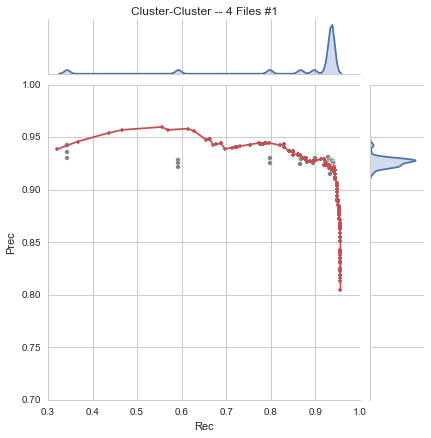

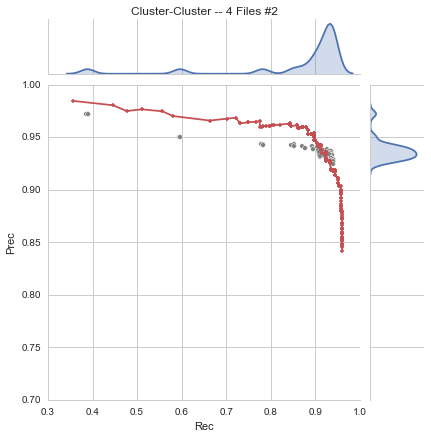

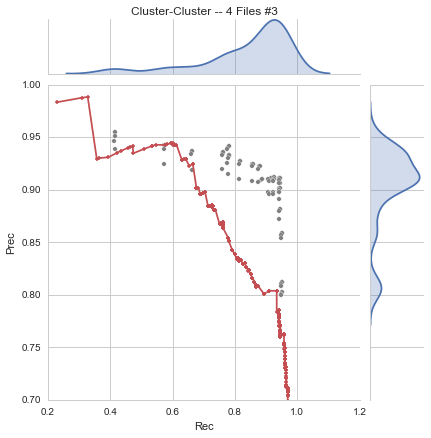

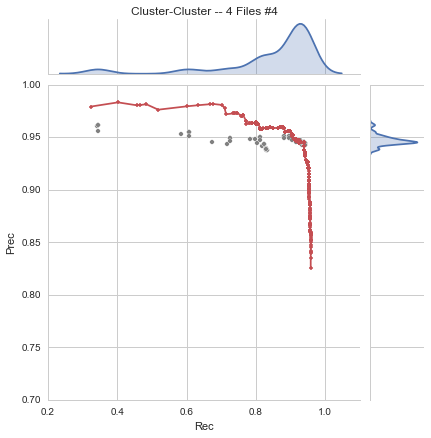

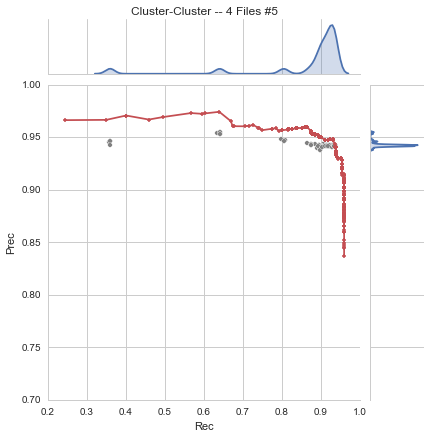

In [66]:
plot_scatter(exp_results_4b, 0, match_cluster_4a, 'Cluster-Cluster -- 4 Files #1')
plot_scatter(exp_results_4b, 1, match_cluster_4b, 'Cluster-Cluster -- 4 Files #2')
plot_scatter(exp_results_4b, 2, match_cluster_4c, 'Cluster-Cluster -- 4 Files #3')
plot_scatter(exp_results_4b, 3, match_cluster_4d, 'Cluster-Cluster -- 4 Files #4')
plot_scatter(exp_results_4b, 4, match_cluster_4e, 'Cluster-Cluster -- 4 Files #5')